# Code for Examining Individual Fit Parameters from the Cosine Moment Extractions

In [1]:
%reset -f
import ROOT
import traceback
from MyCommonAnalysisFunction_richcap import *
from array import array
from datetime import datetime


ROOT.TH1.AddDirectory(0)
# ROOT.gStyle.SetTitleOffset(1.3,'y')
ROOT.gStyle.SetTitleOffset(1.75,'y')

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

print(f"{color.BOLD}\nStarting RG-A SIDIS Analysis\n{color.END}")



Starting RG-A SIDIS Analysis



.

.

.

## Specify the Parameter text file to use:

In [2]:
import glob
# Define the relative path to the file
file_path = 'SIDIS_python_Images_From_5D_Unfold_Test_V6_5_21_2024/Parameters_5D_Unfold_Test_V6_5_21_2024_Q2_y_Bins_Combined.txt'  # Adjust the path based on your specific directory structure
file_path = 'SIDIS_python_Images_From_Sim_Test_Pass_2_5D_Unfold_Test_V6_5_24_2024/Parameters_Sim_Test_Pass_2_5D_Unfold_Test_V6_5_24_2024_Q2_y_Bins_Combined.txt'
file_path = 'Parameters_Pass_2_New_Sector_Cut_Test_V3_6_4_2024_Q2_y_Bins_3_Unsmeared.txt'

file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V10_6_14_2024/Parameters_Pass_2_New_Sector_Cut_Test_V10_6_14_2024_Q2_y_Bins_Combined.txt'

# # file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V10_7_1_2024/Parameters_Pass_2_New_Sector_Cut_Test_V10_7_1_2024_Q2_y_Bins_Combined.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V12_7_9_2024/Parameters_Pass_2_New_Sector_Cut_Test_V12_7_9_2024_Q2_y_Bins_Combined.txt' # Only Includes Smearing

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024_Q2_y_Bins_Combined.txt' # Does NOT include Smearing

# # file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024_Q2_y_Bins_Combined.txt' # Does NOT include Smearing

# # file_path = 'Parameters_Pass_2_New_Fiducial_Cut_Test_V3_8_7_2024_Q2_y_Bins_Combined_Unsmeared.txt'

# # file_path = 'Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V4_8_12_2024_Q2_y_Bins_Combined_Unsmeared.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_V5_8_14_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_V5_8_14_2024_Q2_y_Bins_Combined_Unsmeared.txt'
# # file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V5_8_14_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V5_8_14_2024_Q2_y_Bins_Combined_Unsmeared.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC_14_V12_11_1_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC_14_V12_11_1_2024_Q2_y_Bins_Combined.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_3_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_3_2024_Q2_y_Bins_Combined_Smeared.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_3_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_4_2024_Q2_y_Bins_Combined_*.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_3_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_6_2024_Q2_y_Bins_Combined_ProtonCut_Unsmeared.txt'

# # file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_06_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_6_2024_Q2_y_Bins_Combined_TagProton_Unsmeared.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_3_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_11_4_2024_Q2_y_Bins_Combined_Smeared.txt'


# file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_07_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_7_2024_Q2_y_Bins_Combined_TagProton_Unsmeared.txt'
# # file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_07_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_7_2024_Q2_y_Bins_Combined_ProtonCut_Unsmeared.txt'

# file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_07_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC_14_V14_11_7_2024_Q2_y_Bins_Combined_Smeared.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_FC0_V12_11_12_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_FC0_V12_*_2024_Q2_y_Bins_Combined*.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_Smeared.txt'

file_path = 'SIDIS_python_Images_From_Pass_2_Plots_for_Maria_FC_14_V1_04_16_2025/Parameters_Pass_2_Plots_for_Maria_FC_14_V1_4_16_2025_Q2_y_Bins_Combined_Smeared.txt'

file_path = '../SIDIS_Analysis/Parameters_Pass_2_Plots_for_Maria_FC_14_V2_4_1*_2025_Q2_y_Bins_Combined_Smeared*.txt'
file_path = '../SIDIS_Analysis/Parameters_Pass_2_Plots_for_Maria_FC_14_V3_4_21_2025_Q2_y_Bins_Combined_Smeared.txt'
# # Open the file and read its contents into a string
# with open(file_path, 'r') as file:
#     file_content = file.read()

file_content = ""
# Use glob to find all files matching the pattern
for files_path in glob.glob(file_path):
    # Open each file and read its contents into the combined string
    with open(files_path, 'r') as file:
        file_content += file.read()
        print(f"{color.BOLD}File: {color.BLUE}{files_path}{color.END_B} has been found (and added)...{color.END}")


# print(f"{color.BOLD}File: {color.BLUE}{file_path}{color.END_B} has been found...{color.END}")

# # Now `file_content` holds the content of the file as a string
# print(file_content)  # Display the content to verify it's correct
print("\nDone\n")

File: ../SIDIS_Analysis/Parameters_Pass_2_Plots_for_Maria_FC_14_V3_4_21_2025_Q2_y_Bins_Combined_Smeared.txt has been found (and added)...

Done



In [3]:
# print(file_content[:10000])  # Display the content to verify it's correct

.

.

.

## Declare Pass Version

In [4]:
Pass_Version = "Pass 1"
Pass_Version = "Pass 2" if(any(pass_V in str(file_path) for pass_V in ["Pass_2", "P2"])) else Pass_Version
# Pass_Version = "Pass 2"

Cut_Proton_Q    = ("_ProtonCut"    in str(file_path.split("/")[1]))
Tagged_Proton_Q = ("Tagged_Proton" in str(file_path.split("/")[1])) and not Cut_Proton_Q


print(f"\n{color.BOLD}Pass Version in use   = {color.UNDERLINE}{color.BLUE}{Pass_Version}{color.END}\n")
print(f"{color.BOLD}Using Tagged Proton? -> {color.UNDERLINE}{color.BLUE}{Tagged_Proton_Q}{color.END}\n")
print(f"{color.BOLD}Using Proton Cut?    -> {color.UNDERLINE}{color.BLUE}{Cut_Proton_Q}{color.END}\n")
# if(Cut_Proton_Q):
#     print(f"{color.BOLD}Using Proton Cut?    -> {color.UNDERLINE}{color.BLUE}{Cut_Proton_Q}{color.END}\n")
# else:
#     print(f"{color.BOLD}Using Tagged Proton? -> {color.UNDERLINE}{color.BLUE}{Tagged_Proton_Q}{color.END}\n")


Pass Version in use   = Pass 2

Using Tagged Proton? -> False

Using Proton Cut?    -> False



.

.

.

### Remove User text
(Attempts to limit the lines of text included for humans reading the content of the loaded file so that the computer has an easier time searching through the file)

In [5]:
file_content = file_content.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content = file_content.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")

print(f"\n{color.BOLD}'file_content'{color.END} has been updated\n")


'file_content' has been updated



.

.

.

## Defining Search Functions

In [6]:
def find_bin_block(data, bin_info):
    blocks = re.split(r"==+\n", data)
    for block in blocks:
        if(bin_info in block):
            if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                return f"\n======================================================================\n{block.strip()}\n======================================================================\n"
    return "No data found for the specified Q2-y/z-PT Bin."


def extract_histogram_info(block, histogram_type):
    # pattern = rf"{histogram_type} Histograms:(.*?)(?=\(\*\)|\dD Histograms)"
    pattern = rf"\(\*\) {re.escape(histogram_type)} Histograms:(.*?)(?=\(\*\)|$)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return match.group(1).strip()
    else:
        return "No data found for the specified histogram type."
    

def extract_fit_info(block, fit_type):
    pattern = rf"- {re.escape(fit_type)} Fits:.*?(\n\s+Par A.*?chi2/NDF = \S+)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return f"\n{match.group(1).strip()}"
    else:
        return "No fit details found for the specified type."

    
# def find_parameter(block, parameter, return_err=False):
#     for line in block.split("\n"):
#         if(parameter in line):
#             par_val = (line.split("="))[1]
#             par_val = re.sub(r"{}.*".format(re.escape("±")), "", par_val)
#             return par_val
#     return "ERROR"

def find_parameter(block, parameter, return_err=False):
    for line in block.split("\n"):
        if(parameter in line):
            try:
                # Split the line at "=", then trim whitespace around the parts
                _, par_info = line.split("=")
                par_val, par_err = map(str.strip, par_info.split("±"))
                if(return_err):
                    return par_val, par_err
                else:
                    return par_val
            except ValueError:
                # If splitting fails, likely due to missing '=' or '±'
                continue
    if(return_err):
        return "ERROR", "ERROR"
    else:
        return "ERROR"
            
def Full_Search_Parameter(Parameter_File_str, Bin_Info=False, Histogram_Type=False, Fit_Type=False, Parameter=False, return_err=False):
    Output = "Error"
    if(not Bin_Info):
        print("No kinematic bin given")
        return Parameter_File_str
    else:
        Output = find_bin_block(Parameter_File_str, Bin_Info)
        if(not Histogram_Type):
            print("No histogram given")
            return Output
        else:
            if(Histogram_Type not in ["Skip"]):
                Output = extract_histogram_info(Output, Histogram_Type)
            if(not Fit_Type):
                print("No fit given")
                return Output
            else:
                Output = extract_fit_info(Output, Fit_Type)
                if(not Parameter):
                    print("No parameter given")
                    return Output
                else:
                    Output = find_parameter(Output, Parameter, return_err)
                    return Output
    return Output
    
print("\n\nDone making search functions\n\n")



Done making search functions




In [7]:
def find_bin_block(data, bin_info, multi_search=False):
    blocks = re.split(r"==+\n", data)
    if(not multi_search):
        for block in blocks:
            if(bin_info in block):
                if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                    return f"\n======================================================================\n{block.strip()}\n======================================================================\n"
        return "No data found for the specified Q2-y/z-PT Bin."
    else:
        matching_blocks = []
        for block in blocks:
            if(bin_info in block):
                if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                    matching_blocks.append(f"\n======================================================================\n{block.strip()}\n======================================================================\n")
        return matching_blocks if(matching_blocks) else ["No data found for the specified Q2-y/z-PT Bin."]

def extract_histogram_info(block, histogram_type):
    pattern = rf"\(\*\) {re.escape(histogram_type)} Histograms:(.*?)(?=\(\*\)|$)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return match.group(1).strip()
    else:
        return "No data found for the specified histogram type."

def extract_fit_info(block, fit_type):
    pattern = rf"- {re.escape(fit_type)} Fits:.*?(\n\s+Par A.*?chi2/NDF = \S+)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return f"\n{match.group(1).strip()}"
    else:
        return "No fit details found for the specified type."


        
def find_parameter(block, parameter, return_err=False):
    for line in block.split("\n"):
        if(parameter in line):
            try:
                # Split the line at "=", then trim whitespace around the parts
                _, par_info = line.split("=")
                par_val, par_err = map(str.strip, par_info.split("±"))
                return (par_val, par_err) if(return_err) else par_val
            except ValueError:
                # If splitting fails, likely due to missing '=' or '±'
                continue
    return ("ERROR", "ERROR") if(return_err) else "ERROR"


def Full_Search_Parameter(Parameter_File_str, Bin_Info=False, Histogram_Type=False, Fit_Type=False, Parameter=False, return_err=False, multi_search=False):
    Output = "Error"
    if(not Bin_Info):
        print("No kinematic bin given")
        return Parameter_File_str
    if(multi_search):
        # Get all matching blocks
        blocks = find_bin_block(Parameter_File_str, Bin_Info, multi_search=multi_search)
        results = []
        for block in blocks:
            # If multi_search is off and we have processed a valid result, exit early
            if(results and not multi_search):
                break
            if(not Histogram_Type):
                print("No histogram given")
                results.append(block)
                continue
            if(Histogram_Type != "Skip"):
                block = extract_histogram_info(block, Histogram_Type)
                if("No data found" in block):
                    results.append(block)
                    continue
            if(not Fit_Type):
                print("No fit given")
                results.append(block)
                continue
            block = extract_fit_info(block, Fit_Type)
            if("No fit details found" in block):
                results.append(block)
                continue
            if(not Parameter):
                print("No parameter given")
                results.append(block)
                continue
    
            # Find parameter and error if specified
            param_result = find_parameter(block, Parameter, return_err)
            results.append(param_result)
            
        # Return a single result if multi_search is False, otherwise return all results
        return results[0] if(not multi_search) else results
    else:
        Output = find_bin_block(Parameter_File_str, Bin_Info)
        if(not Histogram_Type):
            print("No histogram given")
            return Output
        else:
            if(Histogram_Type not in ["Skip"]):
                Output = extract_histogram_info(Output, Histogram_Type)
            if(not Fit_Type):
                print("No fit given")
                return Output
            else:
                Output = extract_fit_info(Output, Fit_Type)
                if(not Parameter):
                    print("No parameter given")
                    return Output
                else:
                    Output = find_parameter(Output, Parameter, return_err)
                    return Output
    return Output

print("Done")

Done


In [8]:
def find_bin_block(data, bin_info, multi_search=False):
    blocks = re.split(r"==+\n", data)
    if(not multi_search):
        for block in blocks:
            if(bin_info in block):
                if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                    return f"\n======================================================================\n{block.strip()}\n======================================================================\n"
        return "No data found for the specified Q2-y/z-PT Bin."
    else:
        matching_blocks = []
        for block in blocks:
            if(bin_info in block):
                if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                    matching_blocks.append(f"\n======================================================================\n{block.strip()}\n======================================================================\n")
        return matching_blocks if(matching_blocks) else ["No data found for the specified Q2-y/z-PT Bin."]

def extract_histogram_info(block, histogram_type):
    pattern = rf"\(\*\) {re.escape(histogram_type)} Histograms:(.*?)(?=\(\*\)|$)"
    # print(f"pattern = {pattern}")
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return match.group(1).strip()
    else:
        # print(f"block = {block}")
        return "No data found for the specified histogram type."

def extract_fit_info(block, fit_type):
    pattern = rf"- {re.escape(fit_type)} Fits:.*?(\n\s+Par A.*?chi2/NDF = \S+)"
    match = re.search(pattern, block, re.DOTALL)
    if match:
        return f"\n{match.group(1).strip()}"
    else:
        return "No fit details found for the specified type."

def find_parameter(block, parameter, return_err=False):
    for line in block.split("\n"):
        if parameter in line:
            try:
                _, par_info = line.split("=")
                par_val, par_err = map(str.strip, par_info.split("±"))
                return (par_val, par_err) if return_err else par_val
            except ValueError:
                continue
    return ("ERROR", "ERROR") if return_err else "ERROR"

def Full_Search_Parameter(Parameter_File_str, Bin_Info=False, Histogram_Type=False, Fit_Type=False, Parameter=False, return_err=False, multi_search=True):
    if not Bin_Info:
        print("No kinematic bin given")
        return Parameter_File_str

    if multi_search:
        blocks = find_bin_block(Parameter_File_str, Bin_Info, multi_search=True)
        
        for block in blocks:
            if(Histogram_Type and Histogram_Type != "Skip"):
                histogram_data = extract_histogram_info(block, Histogram_Type)
                if("No data found" in histogram_data):
                    continue  # Skip to the next block if Histogram_Type not found
                block = histogram_data
            
            if Fit_Type:
                fit_data = extract_fit_info(block, Fit_Type)
                if("No fit details found" in fit_data):
                    return ("ERROR", "ERROR") if return_err else "ERROR"
                block = fit_data

            if Parameter:
                parameter_data = find_parameter(block, Parameter, return_err)
                # Ensure the correct structure is returned
                if(return_err):
                    return (parameter_data if(isinstance(parameter_data, tuple)) else (parameter_data, "ERROR"))
                return parameter_data

            return block

        return ("ERROR", "ERROR") if(return_err) else "No data found for the specified criteria."
    
    else:
        block = find_bin_block(Parameter_File_str, Bin_Info)
        if not Histogram_Type:
            print("No histogram given")
            return block

        if Histogram_Type != "Skip":
            block = extract_histogram_info(block, Histogram_Type)
            if "No data found" in block:
                return ("ERROR", "ERROR") if return_err else block

        if Fit_Type:
            block = extract_fit_info(block, Fit_Type)
            if "No fit details found" in block:
                return ("ERROR", "ERROR") if return_err else block

        if Parameter:
            parameter_data = find_parameter(block, Parameter, return_err)
            return (parameter_data if isinstance(parameter_data, tuple) else (parameter_data, "ERROR")) if return_err else parameter_data

    return block

print("Done")

Done


.

.

.

# Create string of C++ Code for the Moment measurements

In [9]:
if(not True):
    String_Print_Cpp = """
    float Moment_Measurement[18][37][2][2];

        // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num][Smear_Num]
        // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
        // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
        // Smear_Num  = 0 -> NOT Smeared
        // Smear_Num  = 1 -> Smeared"""
    for Q2_y_Bin in range(1, 18):
        if(Q2_y_Bin > 1):
            String_Print_Cpp = f"{String_Print_Cpp}\n"
        for z_pT_Bin in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            Num_Spaces  = " "
            for ii in [Q2_y_Bin, z_pT_Bin]:
                if(ii < 10):
                    Num_Spaces += " "
            for Smearing in ["SMEARED ", ""]:
                String_Print_Cpp = f"{String_Print_Cpp}\n"
                if(Smearing in ["SMEARED "]):
                    Smear_Num = "1"
                    String_Print_Cpp = f"{String_Print_Cpp}\n// (Q2-y) + (z-pT) Bin: ({Q2_y_Bin}) + ({z_pT_Bin})"
                else:
                    Smear_Num = "0"
                Bin___Type = f"{Smearing}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Histo_Type = "1D"
                Fit___Type = "Bin-by-Bin Correction"
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    for Par___Type in ["B", "C"]:
                        # Moment_Value = "-0.1500" if(Par___Type in ["B"]) else "0.005"
                        Moment_Value = "N/A" if(Par___Type in ["B"]) else "N/A"
                        Moment_Num   =  0        if(Par___Type in ["B"]) else 1
                        String_Print_Cpp = f"""{String_Print_Cpp}
    Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""
                else:
                    for Par___Type in ["B", "C"]:
                        Moment_Value = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type)
                        Moment_Value = str(round(float(Moment_Value), 5))
                        Moment_Num = 0 if(Par___Type in ["B"]) else 1
                        String_Print_Cpp = f"""{String_Print_Cpp}
    Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""

    String_Print_Cpp = f"{String_Print_Cpp}\n"
    String_Print_Cpp = String_Print_Cpp.replace(";\n", "; \t")
    String_Print_Cpp = String_Print_Cpp.replace("  -",  " -")
    # String_Print_Cpp = String_Print_Cpp.replace("  ",   " ")


    print(f"\n{String_Print_Cpp}\n")

    # String_Print_python = String_Print_Cpp.replace("""float Moment_Measurement[18][37][2]; 	
    #     // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num]
    #     // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
    #     // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
    #
    # """, "")
    # String_Print_python = String_Print_python.replace("][", ", ")
    # String_Print_python = String_Print_python.replace("[", "['")
    # String_Print_python = String_Print_python.replace("]", "']")
    # String_Print_python = String_Print_python.replace("; \t", "\n")
    # print(String_Print_python)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

# Comparison between Fits

## Compare Smearing

In [10]:
if(not True):
    Histo_Type = "1D"
    Histo_Type = "Skip"
    Fit___Type = "Bin-by-Bin Correction"
    Parameters_to_Compare = ["B", "C"]

    Comparison_Output = {}
    Comparison_Output["Title"] = ["Q2-y-z-PT Bin", "Fit Parameter",  "Unsmeared\t\t", "Unsmeared Error\t\t", "Smeared\t\t", "Smeared Error\t\t", "Absolute Dif\t", "Percent Dif\t\t"]
    # Comparison_Output["Title2"] = ["Bin 18-35\t",  "Parameter B\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    # Comparison_Output["Title3"] = ["Bin 1-1\t",    "Parameter C\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    for Q2_y_Bin               in range(1, 18):
        for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type__S = f"SMEARED Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            Bin___Type_NS = f"Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Moment_Value__S, Moment_Value__S_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type__S, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                Moment_Value_NS, Moment_Value_NS_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type_NS, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                # if(("ERROR" in [Moment_Value__S, Moment_Value_NS]) or ("<class 'str'>" in [str(type(Moment_Value__S)), str(type(Moment_Value_NS))])):
                if("ERROR" in [Moment_Value__S, Moment_Value__S_Error, Moment_Value_NS, Moment_Value_NS_Error]):
                    print(f"{color.Error}{Bin___Type_NS}{color.END}")
                    print(f"{color.Error}Moment_Value__S       = {Moment_Value__S}{color.END}")
                    print(f"{color.Error}Moment_Value__S_Error = {Moment_Value_NS_Error}{color.END}")
                    print(f"{color.Error}Moment_Value_NS       = {Moment_Value_NS}{color.END}")
                    print(f"{color.Error}Moment_Value__S_Error = {Moment_Value_NS_Error}{color.END}")
                    Absolute_Dif, Percent__Dif = "ERROR", "ERROR"
                else:
                    Moment_Value__S = float(Moment_Value__S)
                    Moment_Value_NS = float(Moment_Value_NS)
                    Absolute_Dif = Moment_Value__S - Moment_Value_NS
                    Percent__Dif = abs((abs(Absolute_Dif)/Moment_Value_NS)*100)
                    Absolute_Dif = round(Absolute_Dif,       9)
                    Percent__Dif = round(Percent__Dif,       9)
                    if(Percent__Dif > 10):
                        Percent__Dif = f"{color.RED}{Percent__Dif}"
                    Moment_Value__S       = round(Moment_Value__S,       9)
                    Moment_Value__S_Error = round(float(Moment_Value__S_Error), 9)
                    Moment_Value_NS       = round(Moment_Value_NS,       9)
                    Moment_Value_NS_Error = round(float(Moment_Value_NS_Error), 9)
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t ", f"{Moment_Value__S}   \t", f"{Moment_Value__S_Error}   \t", f"{Moment_Value_NS}   \t", f"{Moment_Value_NS_Error}   \t", f"{Absolute_Dif}   \t", f"{Percent__Dif}%  \t"]

    print(f"\n{color.BOLD}Printing Table of Results for {color.UNDERLINE}({Histo_Type}) {Fit___Type}{color.END}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
        full_table_print = "".join([full_table_print, "\n", "" if(color.Error not in str(Line_Info[5])) else color.Error, f"{Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]} || {Line_Info[4]} || {Line_Info[5]}\t|| {Line_Info[6]} || {Line_Info[7]}\t||{color.END}"])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(full_table_print)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

## Compare Methods

In [11]:
if(not True):
    Histo_Type = "1D"
    Smear_Type = "SMEARED "
    Smear_Type = ""
    Parameters_to_Compare = ["B", "C"]

    Fit___Type_to_Compare = ["Bin-by-Bin Correction", "Generated Plot"]
    # Fit___Type_to_Compare = ["Bin-by-Bin Correction", "Bayesian Unfolding"]

    Comparison_Output = {}
    Comparison_Output["Title"] = ["Q2-y-z-PT Bin", "Fit Parameter",  f"{Fit___Type_to_Compare[0]}\t".replace("Correction", ""), f"{Fit___Type_to_Compare[1]}\t".replace("Correction", ""), "Absolute Dif\t", "Percent Dif\t\t"]
    # Comparison_Output["Title2"] = ["Bin 18-35\t",  "Parameter B\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    # Comparison_Output["Title3"] = ["Bin 1-1\t",    "Parameter C\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    for Q2_y_Bin               in range(1, 18):
        for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Moment_Value_F1 = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type_to_Compare[0], Parameter=Par___Type)
                Moment_Value_F2 = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type_to_Compare[1], Parameter=Par___Type)
                Moment_Value_F1 = float(Moment_Value_F1)
                Moment_Value_F2 = float(Moment_Value_F2)
                Absolute_Dif = Moment_Value_F1 - Moment_Value_F2
                Percent__Dif = abs((abs(Absolute_Dif)/Moment_Value_F2)*100)
                Absolute_Dif = round(Absolute_Dif,       9)
                Percent__Dif = round(Percent__Dif,       9)
                if(Percent__Dif > 25):
                    Percent__Dif = f"{color.Error}{Percent__Dif}"
                Moment_Value_F1 = round(Moment_Value_F1, 9)
                Moment_Value_F2 = round(Moment_Value_F2, 9)
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t ", f"{Moment_Value_F1}   \t", f"{Moment_Value_F2}   \t", f"{Absolute_Dif}   \t", f"{Percent__Dif}%  \t"]

    print(f"\n{color.BOLD}Printing Table of Results between ({Histo_Type}) {color.UNDERLINE}{Fit___Type_to_Compare[0]}{color.END_B} and {color.UNDERLINE}{Fit___Type_to_Compare[1]}{color.END}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
        full_table_print = "".join([full_table_print, "\n", "" if(color.Error not in str(Line_Info[5])) else color.Error, f"{Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(full_table_print)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

## Compare Dimensions/Sectors

In [12]:
if(not True):
    # Histo_Type = "1D"
    Smear_Type = "SMEARED "
    # Smear_Type = ""
    Fit___Type = "Bin-by-Bin Correction"
    # Fit___Type = "Bayesian Unfolding"
    Parameters_to_Compare = ["B", "C"]

    Histo_Type_to_Compare = ["1D", "1D (pipsec 1)", "1D (pipsec 2)", "1D (pipsec 3)", "1D (pipsec 4)", "1D (pipsec 5)", "1D (pipsec 6)"]
    # Histo_Type_to_Compare = ["1D (pipsec 1)", "1D (pipsec 2)", "1D (pipsec 3)", "1D (pipsec 4)", "1D (pipsec 5)", "1D (pipsec 6)"]
    # Histo_Type_to_Compare = ["1D"]

    
    Comparison_Output = {}
    Comparison_Output_Title = ["Q2-y-z-PT Bin", "Fit Parameter"]
    for compare in Histo_Type_to_Compare:
        Comparison_Output_Title.append(f"{compare}\t || {compare} Error")
    Comparison_Output["Title"] = Comparison_Output_Title
    del Comparison_Output_Title
    for Q2_y_Bin               in range(1, 18):
    # for Q2_y_Bin               in range(17, 18):
        # for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
        for z_pT_Bin           in range(-1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(z_pT_Bin in [-1]):
                z_pT_Bin = "Integrated"
            elif(z_pT_Bin in [0]):
                z_pT_Bin = "All"
            elif(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Line_to_Add = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t "]
                for Histo_Type in Histo_Type_to_Compare:
                    Moment_Value_val, Moment_Value_err = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                    if(Moment_Value_val not in ["ERROR"]):
                        Moment_Value_val = round(float(Moment_Value_val), 9)
                    if(Moment_Value_err not in ["ERROR"]):
                        Moment_Value_err = round(float(Moment_Value_err), 9)
                    Line_to_Add.append(f"{Moment_Value_val}   \t|| {Moment_Value_err}   \t")
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = Line_to_Add

    print(f"\n{color.BOLD}Printing Table of Results between ({Fit___Type}):")
    for ii in Histo_Type_to_Compare:
        print(f"{color.UNDERLINE}{ii}{color.END_B}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
    #     print(f"Comparison_Output[{ii}] = {Line_Info}\n")
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
            full_table_print = "".join([full_table_print, "\n", "||".join(Line_Info)])
            full_table_print = f"{full_table_print}\n{color.END}Text_output = {color.BBLUE}'''"
        else:
            full_table_print = "".join([full_table_print, "\n", "||".join(Line_Info)])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(f"{full_table_print}\n'''{color.END}")
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

In [13]:
# stop

In [14]:
# import ROOT
# def create_random_histogram():
#     # Create a histogram with 100 bins ranging from -4 to 4
#     histogram = ROOT.TH1D("random_hist", "Random Gaussian", 10000, -4, 4)

#     # Fill the histogram with 1000 random numbers from a Gaussian distribution
#     for _ in range(1000000):
#         histogram.Fill(ROOT.gRandom.Gaus(0, 1))  # Mean = 0, Standard deviation = 1

#     # Set up a canvas to draw the histogram
#     canvas = ROOT.TCanvas("canvas", "Canvas for Histogram", 800, 600)
#     histogram.Draw()  # Draw the histogram on the canvas

#     # Update the canvas to show the histogram
#     canvas.Update()

#     return canvas, histogram  # Return both the canvas and the histogram for further use

# # Run the function to create and show the histogram
# canvas, histogram = create_random_histogram()
# canvas.Draw()

In [15]:
# import psutil
# import os

# # Function to get current process memory usage
# def get_memory_usage():
#     process = psutil.Process(os.getpid())  # Get current process
#     memory_info = process.memory_info()  # Get memory usage statistics
#     return memory_info.rss  # Return the Resident Set Size (RSS) which is the non-swapped physical memory the process has used


# import time
# # Example of using the function in a typical script workflow
# count = 0
# histo, canvas = {}, {}
# while(count < 5):  # Example of a loop, replace with your actual use case
#     # Do some work here
#     canvas[count], histo[count] = create_random_histogram()
#     canvas[count].SetName(f"canvas_{count}")
#     histo[count].SetName(f"histo_{count}")
#     canvas[count].Draw()
#     print(f"Current memory usage: {get_memory_usage() / (1024 * 1024):.2f} MB")  # Print memory usage in MB
# #     time.sleep(1)  # Sleep for a second, you can adjust or remove according to your needs
#     count += 1
# print("Done")

In [16]:
# command = "lt"
# command = f"{command}; echo ' '"
# for ii in range(1, 18):
# #     if(ii not in [7]):
#     command = f"{command}; echo 'Q2_y_Bin_{ii}:'"
#     command = f"{command}; rmdir Q2_y_Bin_{ii}/"
# #     command = f"{command}; ls -1 Q2_y_Bin_{ii}/ | wc -l"
# #     command = f"{command}; mv Q2_y_Bin_{ii}/*png ../../../../"
# #     command = f"{command}; ls -1 Q2_y_Bin_{ii}/ | wc -l"
# #     command = f"{command}; echo ' '"
# print(f"{command}")

.

.

.

.

.

.

.

.

.

### Code for getting bin centers
Get this code from Get_Bin_Center_of_Kinematic_Bins.ipynb

In [17]:
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'mean__y', 'mean__z', 'mean_pT', 'mean_xB'], '1-All': [2.193, 6.27e-05, 0.7002, 1.57e-05, 0.3052, 6.46e-05, 0.4127, 9.97e-05, 0.1577, 6.2e-06], '1-1': [2.197, 0.0004086, 0.6936, 0.0001008, 0.5021, 0.0002779, 0.1529, 0.0001633, 0.1594, 4.07e-05], '1-2': [2.195, 0.0003841, 0.6962, 9.6e-05, 0.4988, 0.0002533, 0.2724, 9.62e-05, 0.1587, 3.82e-05], '1-3': [2.193, 0.0003505, 0.6968, 8.78e-05, 0.4996, 0.0002323, 0.3709, 8.81e-05, 0.1585, 3.48e-05], '1-4': [2.193, 0.000347, 0.6973, 8.68e-05, 0.4996, 0.0002285, 0.4696, 8.67e-05, 0.1583, 3.44e-05], '1-5': [2.193, 0.0003519, 0.6976, 8.82e-05, 0.5011, 0.0002326, 0.5731, 9.71e-05, 0.1583, 3.49e-05], '1-6': [2.192, 0.0003904, 0.6979, 9.79e-05, 0.5042, 0.0002594, 0.6862, 0.0001175, 0.1581, 3.87e-05], '1-7': [2.193, 0.0003957, 0.6982, 9.95e-05, 0.513, 0.0002675, 0.8469, 0.00023, 0.1581, 3.92e-05], '1-8': [2.196, 0.0003504, 0.6967, 8.74e-05, 0.3371, 9.49e-05, 0.1563, 0.000134, 0.1587, 3.48e-05], '1-9': [2.194, 0.0003288, 0.6982, 8.24e-05, 0.3374, 8.98e-05, 0.2724, 8.23e-05, 0.1582, 3.26e-05], '1-10': [2.193, 0.0002964, 0.6989, 7.43e-05, 0.3368, 8.04e-05, 0.3708, 7.41e-05, 0.1579, 2.94e-05], '1-11': [2.193, 0.0002962, 0.6992, 7.47e-05, 0.3375, 8.06e-05, 0.469, 7.42e-05, 0.1578, 2.93e-05], '1-12': [2.193, 0.0003179, 0.6995, 8e-05, 0.3389, 8.67e-05, 0.5716, 8.75e-05, 0.1578, 3.15e-05], '1-13': [2.193, 0.0003886, 0.6997, 9.75e-05, 0.3405, 0.0001071, 0.6838, 0.0001161, 0.1577, 3.85e-05], '1-14': [2.192, 0.0004633, 0.7007, 0.0001166, 0.3434, 0.0001263, 0.8361, 0.0002536, 0.1575, 4.58e-05], '1-15': [2.196, 0.0003431, 0.6976, 8.59e-05, 0.2577, 5.11e-05, 0.1546, 0.0001306, 0.1584, 3.41e-05], '1-16': [2.194, 0.000313, 0.699, 7.85e-05, 0.2571, 4.64e-05, 0.2733, 7.77e-05, 0.158, 3.1e-05], '1-17': [2.192, 0.0002785, 0.6994, 7.01e-05, 0.2572, 4.14e-05, 0.3706, 6.97e-05, 0.1578, 2.77e-05], '1-18': [2.193, 0.0002926, 0.6994, 7.37e-05, 0.258, 4.34e-05, 0.468, 7.32e-05, 0.1578, 2.9e-05], '1-19': [2.194, 0.0003404, 0.6999, 8.57e-05, 0.2585, 5.08e-05, 0.5701, 9.31e-05, 0.1578, 3.38e-05], '1-20': [2.193, 0.0004548, 0.7005, 0.0001138, 0.2596, 6.68e-05, 0.6813, 0.0001319, 0.1576, 4.5e-05], '1-22': [2.195, 0.0003391, 0.698, 8.53e-05, 0.2088, 3.31e-05, 0.1548, 0.0001319, 0.1583, 3.38e-05], '1-23': [2.193, 0.0002926, 0.6991, 7.36e-05, 0.2085, 2.85e-05, 0.2734, 7.28e-05, 0.1579, 2.91e-05], '1-24': [2.193, 0.0002684, 0.6993, 6.75e-05, 0.2088, 2.62e-05, 0.3694, 6.7e-05, 0.1579, 2.66e-05], '1-25': [2.193, 0.0003025, 0.6998, 7.6e-05, 0.2092, 2.96e-05, 0.4667, 7.54e-05, 0.1578, 2.99e-05], '1-26': [2.191, 0.0003816, 0.7016, 9.53e-05, 0.2104, 3.67e-05, 0.5664, 0.0001005, 0.1572, 3.76e-05], '1-29': [2.194, 0.0004046, 0.7094, 9.45e-05, 0.1779, 2.62e-05, 0.1572, 0.0001573, 0.1556, 3.85e-05], '1-30': [2.192, 0.000341, 0.7103, 7.96e-05, 0.1778, 2.22e-05, 0.2732, 8.47e-05, 0.1553, 3.23e-05], '1-31': [2.194, 0.000329, 0.7101, 7.7e-05, 0.178, 2.14e-05, 0.3684, 8.25e-05, 0.1554, 3.12e-05], '1-32': [2.192, 0.0003887, 0.7101, 9.07e-05, 0.1781, 2.49e-05, 0.4663, 9.65e-05, 0.1553, 3.68e-05], '2-All': [2.196, 6.42e-05, 0.6005, 1.6e-05, 0.3491, 7.32e-05, 0.4043, 0.0001031, 0.1842, 7.8e-06], '2-1': [2.197, 0.0003759, 0.5966, 9.33e-05, 0.6019, 0.0002314, 0.1657, 0.0001793, 0.1855, 4.57e-05], '2-2': [2.197, 0.0004355, 0.5969, 0.0001082, 0.5989, 0.0002639, 0.3013, 0.0001093, 0.1854, 5.3e-05], '2-3': [2.196, 0.0004219, 0.5977, 0.0001049, 0.5982, 0.0002559, 0.4001, 0.0001061, 0.1851, 5.12e-05], '2-4': [2.195, 0.0004527, 0.598, 0.0001132, 0.5987, 0.0002752, 0.4944, 0.000102, 0.1849, 5.52e-05], '2-5': [2.196, 0.0004142, 0.5981, 0.0001033, 0.6001, 0.0002528, 0.6018, 0.000135, 0.1849, 5.04e-05], '2-6': [2.194, 0.0003932, 0.5991, 9.83e-05, 0.6016, 0.0002375, 0.7777, 0.0002477, 0.1845, 4.75e-05], '2-7': [2.198, 0.0003394, 0.5972, 8.47e-05, 0.4324, 0.0001015, 0.1693, 0.0001593, 0.1854, 4.14e-05], '2-8': [2.197, 0.0003788, 0.5981, 9.5e-05, 0.4327, 0.0001131, 0.3008, 9.51e-05, 0.185, 4.63e-05], '2-9': [2.196, 0.0003664, 0.5989, 9.19e-05, 0.4324, 0.0001094, 0.4001, 9.22e-05, 0.1847, 4.47e-05], '2-10': [2.195, 0.0003999, 0.5989, 0.0001003, 0.4326, 0.0001191, 0.494, 9.03e-05, 0.1846, 4.87e-05], '2-11': [2.195, 0.0003739, 0.5993, 9.38e-05, 0.4333, 0.0001119, 0.601, 0.0001217, 0.1845, 4.55e-05], '2-12': [2.195, 0.0003935, 0.5999, 9.88e-05, 0.4357, 0.0001184, 0.7699, 0.000243, 0.1843, 4.79e-05], '2-13': [2.197, 0.000327, 0.5978, 8.17e-05, 0.3424, 5.69e-05, 0.1705, 0.0001492, 0.1852, 3.98e-05], '2-14': [2.196, 0.0003683, 0.599, 9.24e-05, 0.3423, 6.41e-05, 0.3015, 9.26e-05, 0.1847, 4.49e-05], '2-15': [2.195, 0.0003476, 0.599, 8.74e-05, 0.3419, 6.06e-05, 0.4003, 8.73e-05, 0.1846, 4.24e-05], '2-16': [2.196, 0.0003851, 0.5993, 9.64e-05, 0.3421, 6.7e-05, 0.4937, 8.67e-05, 0.1846, 4.69e-05], '2-17': [2.196, 0.0003764, 0.5995, 9.41e-05, 0.3429, 6.56e-05, 0.5993, 0.0001211, 0.1845, 4.58e-05], '2-18': [2.194, 0.000447, 0.6007, 0.0001115, 0.3444, 7.77e-05, 0.7615, 0.0002617, 0.184, 5.39e-05], '2-19': [2.197, 0.000317, 0.5983, 7.93e-05, 0.2836, 3.92e-05, 0.1693, 0.0001443, 0.185, 3.86e-05], '2-20': [2.195, 0.0003438, 0.599, 8.63e-05, 0.2832, 4.25e-05, 0.3023, 8.59e-05, 0.1846, 4.19e-05], '2-21': [2.195, 0.0003239, 0.5991, 8.14e-05, 0.2833, 4.01e-05, 0.3999, 8.15e-05, 0.1845, 3.94e-05], '2-22': [2.196, 0.0003659, 0.5996, 9.21e-05, 0.2836, 4.53e-05, 0.493, 8.27e-05, 0.1845, 4.46e-05], '2-23': [2.195, 0.0003831, 0.5995, 9.63e-05, 0.284, 4.75e-05, 0.598, 0.0001241, 0.1844, 4.65e-05], '2-25': [2.197, 0.0003554, 0.5983, 8.89e-05, 0.2444, 2.54e-05, 0.1689, 0.0001636, 0.185, 4.33e-05], '2-26': [2.196, 0.0003699, 0.5988, 9.28e-05, 0.2443, 2.64e-05, 0.3021, 9.2e-05, 0.1847, 4.51e-05], '2-27': [2.195, 0.0003532, 0.5995, 8.83e-05, 0.2444, 2.52e-05, 0.3993, 8.79e-05, 0.1845, 4.32e-05], '2-28': [2.196, 0.0004198, 0.5997, 0.0001055, 0.2446, 3e-05, 0.4922, 9.44e-05, 0.1845, 5.1e-05], '2-29': [2.193, 0.0004674, 0.6019, 0.0001149, 0.2451, 3.33e-05, 0.5938, 0.0001442, 0.1835, 5.6e-05], '2-31': [2.196, 0.0003066, 0.607, 7.23e-05, 0.2124, 2.8e-05, 0.1708, 0.0001439, 0.1822, 3.6e-05], '2-32': [2.195, 0.0003069, 0.6078, 7.19e-05, 0.2121, 2.81e-05, 0.3021, 7.69e-05, 0.1818, 3.59e-05], '2-33': [2.196, 0.0003072, 0.6079, 7.21e-05, 0.2125, 2.8e-05, 0.3981, 7.67e-05, 0.1819, 3.59e-05], '2-34': [2.194, 0.0003799, 0.608, 8.89e-05, 0.2127, 3.46e-05, 0.4922, 8.54e-05, 0.1817, 4.44e-05], '3-All': [2.197, 6.95e-05, 0.5014, 1.74e-05, 0.3891, 7.76e-05, 0.3797, 0.0001013, 0.2209, 1.09e-05], '3-1': [2.198, 0.0004908, 0.4981, 0.0001233, 0.6459, 0.0002366, 0.1364, 0.0001773, 0.2224, 7.71e-05], '3-2': [2.199, 0.0004744, 0.4977, 0.0001189, 0.6442, 0.000228, 0.2517, 0.0001193, 0.2227, 7.44e-05], '3-3': [2.199, 0.0004707, 0.497, 0.0001183, 0.6435, 0.0002233, 0.3449, 0.0001065, 0.2231, 7.45e-05], '3-4': [2.199, 0.0004631, 0.4977, 0.0001163, 0.643, 0.0002191, 0.4392, 0.0001164, 0.2227, 7.29e-05], '3-5': [2.198, 0.0004952, 0.4986, 0.0001248, 0.6406, 0.0002292, 0.5386, 0.0001246, 0.2222, 7.74e-05], '3-6': [2.195, 0.0004662, 0.5007, 0.0001156, 0.6351, 0.0002018, 0.6649, 0.0001957, 0.221, 7.24e-05], '3-7': [2.199, 0.0003794, 0.4988, 9.5e-05, 0.4746, 0.000141, 0.1387, 0.0001364, 0.2223, 5.96e-05], '3-8': [2.198, 0.0003468, 0.4978, 8.68e-05, 0.4739, 0.000129, 0.2514, 8.65e-05, 0.2226, 5.44e-05], '3-9': [2.198, 0.0003586, 0.4983, 9e-05, 0.475, 0.000134, 0.3447, 8.12e-05, 0.2224, 5.65e-05], '3-10': [2.198, 0.000347, 0.499, 8.74e-05, 0.4745, 0.0001298, 0.4393, 8.72e-05, 0.2221, 5.46e-05], '3-11': [2.198, 0.0003751, 0.4989, 9.45e-05, 0.4752, 0.0001408, 0.538, 9.4e-05, 0.2221, 5.9e-05], '3-12': [2.196, 0.0003536, 0.4994, 8.9e-05, 0.4763, 0.0001328, 0.6656, 0.0001496, 0.2217, 5.57e-05], '3-13': [2.198, 0.0003667, 0.4985, 9.2e-05, 0.3664, 7.31e-05, 0.142, 0.0001279, 0.2223, 5.77e-05], '3-14': [2.199, 0.0003441, 0.4977, 8.68e-05, 0.3671, 6.87e-05, 0.2501, 8.65e-05, 0.2228, 5.44e-05], '3-15': [2.198, 0.0003547, 0.4985, 8.93e-05, 0.3664, 7.1e-05, 0.3456, 8.02e-05, 0.2223, 5.6e-05], '3-16': [2.197, 0.0003352, 0.4987, 8.44e-05, 0.3663, 6.7e-05, 0.439, 8.4e-05, 0.2221, 5.27e-05], '3-17': [2.197, 0.0003683, 0.4992, 9.27e-05, 0.3668, 7.36e-05, 0.5377, 9.23e-05, 0.2219, 5.8e-05], '3-18': [2.196, 0.0003814, 0.5011, 9.46e-05, 0.3685, 7.62e-05, 0.6609, 0.0001577, 0.2209, 5.91e-05], '3-19': [2.198, 0.0003721, 0.4984, 9.35e-05, 0.3036, 4.6e-05, 0.1421, 0.000127, 0.2223, 5.84e-05], '3-20': [2.2, 0.0003631, 0.4983, 9.15e-05, 0.3039, 4.49e-05, 0.2507, 9.19e-05, 0.2226, 5.73e-05], '3-21': [2.197, 0.0003517, 0.4988, 8.84e-05, 0.3032, 4.34e-05, 0.346, 7.91e-05, 0.222, 5.51e-05], '3-22': [2.197, 0.0003371, 0.4993, 8.47e-05, 0.3036, 4.18e-05, 0.4388, 8.46e-05, 0.2218, 5.29e-05], '3-23': [2.196, 0.0003921, 0.5004, 9.76e-05, 0.3043, 4.87e-05, 0.5362, 9.77e-05, 0.2213, 6.08e-05], '3-24': [2.193, 0.000484, 0.5066, 0.0001172, 0.3064, 5.92e-05, 0.6492, 0.0001805, 0.2181, 7.33e-05], '3-25': [2.198, 0.0003459, 0.5088, 8.15e-05, 0.2555, 4.6e-05, 0.1396, 0.0001185, 0.2176, 5.17e-05], '3-26': [2.197, 0.0003364, 0.5095, 7.89e-05, 0.255, 4.52e-05, 0.2529, 8.49e-05, 0.2173, 5.02e-05], '3-27': [2.196, 0.0003159, 0.5099, 7.38e-05, 0.255, 4.24e-05, 0.3453, 7.11e-05, 0.217, 4.69e-05], '3-28': [2.197, 0.0003169, 0.5102, 7.39e-05, 0.2554, 4.23e-05, 0.4377, 7.9e-05, 0.2169, 4.7e-05], '3-29': [2.194, 0.0003996, 0.5118, 9.14e-05, 0.2562, 5.27e-05, 0.534, 9.8e-05, 0.216, 5.86e-05], '4-All': [2.199, 8.16e-05, 0.4046, 2.02e-05, 0.434, 7.63e-05, 0.3655, 0.000116, 0.2744, 1.77e-05], '4-1': [2.198, 0.0005597, 0.4001, 0.0001402, 0.6455, 0.0001685, 0.136, 0.0002041, 0.2775, 0.0001232], '4-2': [2.199, 0.0005788, 0.4007, 0.0001432, 0.6435, 0.000172, 0.2467, 0.0001315, 0.2772, 0.0001257], '4-3': [2.195, 0.0005366, 0.4023, 0.0001303, 0.6413, 0.0001562, 0.3353, 0.0001215, 0.2755, 0.0001143], '4-4': [2.196, 0.000551, 0.4048, 0.0001309, 0.6387, 0.0001549, 0.4271, 0.0001384, 0.2738, 0.0001135], '4-5': [2.19, 0.0006366, 0.4133, 0.0001353, 0.6335, 0.0001716, 0.5369, 0.0002049, 0.2671, 0.0001166], '4-7': [2.203, 0.000536, 0.3987, 0.0001362, 0.5422, 0.000122, 0.1376, 0.0001946, 0.2792, 0.0001211], '4-8': [2.201, 0.0005136, 0.3982, 0.0001301, 0.5414, 0.0001164, 0.2475, 0.0001162, 0.2792, 0.0001159], '4-9': [2.202, 0.000469, 0.3976, 0.000118, 0.542, 0.0001063, 0.3351, 0.000106, 0.2798, 0.000105], '4-10': [2.202, 0.000476, 0.3981, 0.0001197, 0.542, 0.0001076, 0.4284, 0.0001205, 0.2795, 0.0001063], '4-11': [2.199, 0.0004743, 0.4002, 0.0001178, 0.5418, 0.000107, 0.5405, 0.0001549, 0.2775, 0.0001037], '4-12': [2.188, 0.0005827, 0.4129, 0.0001247, 0.5397, 0.0001298, 0.6895, 0.0003053, 0.2672, 0.0001074], '4-13': [2.201, 0.0005011, 0.3994, 0.0001271, 0.4629, 8.8e-05, 0.1403, 0.0001807, 0.2785, 0.0001118], '4-14': [2.201, 0.0004599, 0.3987, 0.0001161, 0.4624, 8.06e-05, 0.2472, 0.0001037, 0.2789, 0.0001029], '4-15': [2.203, 0.000442, 0.3976, 0.0001113, 0.463, 7.74e-05, 0.3343, 9.97e-05, 0.2799, 9.91e-05], '4-16': [2.202, 0.0004491, 0.3985, 0.0001133, 0.463, 7.88e-05, 0.4289, 0.0001134, 0.2792, 0.0001011], '4-17': [2.199, 0.000442, 0.4004, 0.0001094, 0.4632, 7.74e-05, 0.5403, 0.000144, 0.2774, 9.66e-05], '4-18': [2.193, 0.0005545, 0.4094, 0.0001283, 0.4643, 9.78e-05, 0.6873, 0.0002832, 0.2703, 0.0001113], '4-19': [2.2, 0.0004966, 0.3995, 0.0001257, 0.4036, 6.18e-05, 0.1425, 0.0001749, 0.2782, 0.0001108], '4-20': [2.201, 0.0004554, 0.3988, 0.0001144, 0.4038, 5.64e-05, 0.2467, 0.0001021, 0.2788, 0.0001016], '4-21': [2.203, 0.0004542, 0.3985, 0.0001145, 0.4041, 5.65e-05, 0.334, 0.0001033, 0.2793, 0.0001017], '4-22': [2.199, 0.0004498, 0.3997, 0.000113, 0.4039, 5.59e-05, 0.4294, 0.0001135, 0.278, 9.95e-05], '4-23': [2.197, 0.0004631, 0.4031, 0.0001135, 0.4042, 5.76e-05, 0.5385, 0.0001502, 0.2752, 9.98e-05], '4-24': [2.193, 0.000653, 0.4096, 0.0001562, 0.4054, 8.12e-05, 0.6814, 0.0003199, 0.2702, 0.000136], '4-25': [2.2, 0.0004197, 0.3998, 0.0001053, 0.3536, 5.18e-05, 0.1434, 0.0001448, 0.278, 9.31e-05], '4-26': [2.201, 0.0003924, 0.3989, 9.83e-05, 0.354, 4.85e-05, 0.2457, 8.81e-05, 0.2788, 8.7e-05], '4-27': [2.2, 0.0004041, 0.3999, 0.0001015, 0.354, 5.02e-05, 0.3346, 9.28e-05, 0.278, 9.02e-05], '4-28': [2.198, 0.0003923, 0.4019, 9.63e-05, 0.3541, 4.85e-05, 0.4282, 9.81e-05, 0.2763, 8.51e-05], '4-29': [2.196, 0.0004398, 0.4062, 0.0001067, 0.3549, 5.43e-05, 0.5362, 0.0001407, 0.273, 9.37e-05], '4-31': [2.198, 0.0004351, 0.4194, 8.15e-05, 0.305, 6.2e-05, 0.1429, 0.0001488, 0.264, 7.7e-05], '4-32': [2.201, 0.0004375, 0.4186, 8.28e-05, 0.3059, 6.18e-05, 0.2444, 9.89e-05, 0.2648, 7.8e-05], '4-33': [2.197, 0.0004285, 0.4198, 7.92e-05, 0.3048, 6.11e-05, 0.3361, 9.61e-05, 0.2637, 7.51e-05], '4-34': [2.197, 0.00042, 0.4206, 7.66e-05, 0.3051, 5.99e-05, 0.4273, 0.0001047, 0.263, 7.27e-05], '4-35': [2.195, 0.0005138, 0.4219, 9.25e-05, 0.306, 7.23e-05, 0.5337, 0.0001628, 0.262, 8.84e-05], '5-All': [2.636, 8.06e-05, 0.6998, 1.62e-05, 0.3068, 6.67e-05, 0.4072, 0.0001022, 0.1897, 7.6e-06], '5-1': [2.642, 0.0007136, 0.6918, 0.0001384, 0.5698, 0.0002784, 0.1498, 0.0002307, 0.1923, 6.74e-05], '5-2': [2.638, 0.000713, 0.6942, 0.0001408, 0.5671, 0.0002706, 0.272, 0.0001422, 0.1913, 6.78e-05], '5-3': [2.637, 0.000689, 0.6949, 0.0001367, 0.5669, 0.0002616, 0.3656, 0.0001237, 0.1911, 6.54e-05], '5-4': [2.637, 0.0006441, 0.6952, 0.0001279, 0.567, 0.000244, 0.4599, 0.0001292, 0.191, 6.1e-05], '5-5': [2.637, 0.0005805, 0.6957, 0.0001156, 0.5675, 0.0002213, 0.5773, 0.0001635, 0.1908, 5.5e-05], '5-6': [2.636, 0.0005197, 0.696, 0.0001035, 0.5709, 0.0001994, 0.7814, 0.0003273, 0.1907, 4.91e-05], '5-7': [2.641, 0.0006026, 0.6954, 0.0001197, 0.428, 0.0001311, 0.1527, 0.0001915, 0.1912, 5.69e-05], '5-8': [2.639, 0.0005723, 0.6975, 0.0001145, 0.4281, 0.0001241, 0.2719, 0.0001141, 0.1905, 5.42e-05], '5-9': [2.638, 0.0005629, 0.698, 0.0001127, 0.4283, 0.0001228, 0.3655, 0.0001015, 0.1903, 5.34e-05], '5-10': [2.636, 0.0005308, 0.6984, 0.0001064, 0.4278, 0.0001156, 0.4596, 0.0001064, 0.1901, 5.03e-05], '5-11': [2.635, 0.0004917, 0.6987, 9.86e-05, 0.4287, 0.0001072, 0.5761, 0.0001375, 0.1899, 4.66e-05], '5-12': [2.635, 0.0004892, 0.6994, 9.84e-05, 0.4307, 0.0001074, 0.7698, 0.000297, 0.1897, 4.64e-05], '5-13': [2.64, 0.0005012, 0.6964, 9.94e-05, 0.3359, 7.92e-05, 0.1545, 0.0001551, 0.1909, 4.74e-05], '5-14': [2.637, 0.0004832, 0.698, 9.65e-05, 0.3363, 7.66e-05, 0.2717, 9.66e-05, 0.1902, 4.56e-05], '5-15': [2.637, 0.0004671, 0.6987, 9.37e-05, 0.3356, 7.39e-05, 0.3657, 8.4e-05, 0.19, 4.42e-05], '5-16': [2.636, 0.0004448, 0.6987, 8.91e-05, 0.336, 7.07e-05, 0.4593, 8.91e-05, 0.19, 4.21e-05], '5-17': [2.636, 0.000428, 0.6992, 8.61e-05, 0.3367, 6.78e-05, 0.5745, 0.0001191, 0.1898, 4.05e-05], '5-18': [2.635, 0.0004837, 0.6997, 9.67e-05, 0.3385, 7.67e-05, 0.7593, 0.0002781, 0.1896, 4.57e-05], '5-19': [2.639, 0.0004437, 0.6974, 8.86e-05, 0.2678, 5.26e-05, 0.1538, 0.0001362, 0.1905, 4.21e-05], '5-20': [2.636, 0.0004227, 0.6987, 8.47e-05, 0.2673, 5.01e-05, 0.273, 8.44e-05, 0.19, 4e-05], '5-21': [2.635, 0.0004013, 0.6991, 8.05e-05, 0.2673, 4.75e-05, 0.3654, 7.22e-05, 0.1898, 3.8e-05], '5-22': [2.636, 0.0003889, 0.6989, 7.79e-05, 0.2676, 4.61e-05, 0.4584, 7.74e-05, 0.1899, 3.68e-05], '5-23': [2.636, 0.0004028, 0.699, 8.06e-05, 0.2683, 4.78e-05, 0.5724, 0.0001114, 0.1899, 3.81e-05], '5-25': [2.638, 0.0004458, 0.6975, 8.92e-05, 0.2189, 3.48e-05, 0.1536, 0.0001385, 0.1905, 4.22e-05], '5-26': [2.636, 0.000402, 0.6989, 8.08e-05, 0.2186, 3.13e-05, 0.273, 7.99e-05, 0.1899, 3.81e-05], '5-27': [2.636, 0.0003846, 0.6989, 7.7e-05, 0.2187, 2.98e-05, 0.3653, 6.88e-05, 0.1899, 3.65e-05], '5-28': [2.636, 0.0003927, 0.6994, 7.88e-05, 0.2191, 3.06e-05, 0.4574, 7.83e-05, 0.1898, 3.72e-05], '5-29': [2.634, 0.000446, 0.7009, 8.94e-05, 0.2202, 3.45e-05, 0.5675, 0.0001186, 0.1892, 4.21e-05], '5-31': [2.638, 0.0004336, 0.7057, 8.44e-05, 0.183, 3e-05, 0.1554, 0.0001359, 0.1882, 4.04e-05], '5-32': [2.635, 0.0003709, 0.7067, 7.21e-05, 0.1828, 2.59e-05, 0.2731, 7.38e-05, 0.1877, 3.44e-05], '5-33': [2.635, 0.0003713, 0.7067, 7.21e-05, 0.1831, 2.58e-05, 0.3641, 6.66e-05, 0.1878, 3.44e-05], '5-34': [2.635, 0.000407, 0.7068, 7.9e-05, 0.1834, 2.82e-05, 0.4563, 8.08e-05, 0.1877, 3.78e-05], '6-All': [2.637, 8.07e-05, 0.6005, 1.61e-05, 0.3466, 7.11e-05, 0.401, 0.000105, 0.2212, 9.4e-06], '6-1': [2.638, 0.0004512, 0.5972, 8.97e-05, 0.5551, 0.0002364, 0.1499, 0.0001443, 0.2225, 5.26e-05], '6-2': [2.639, 0.0004675, 0.5969, 9.29e-05, 0.5532, 0.0002441, 0.2714, 9.36e-05, 0.2227, 5.47e-05], '6-3': [2.639, 0.000473, 0.5977, 9.45e-05, 0.5528, 0.0002462, 0.3651, 8.53e-05, 0.2225, 5.53e-05], '6-4': [2.637, 0.000457, 0.5979, 9.11e-05, 0.5536, 0.0002379, 0.4594, 9.14e-05, 0.2222, 5.35e-05], '6-5': [2.637, 0.0004217, 0.5983, 8.41e-05, 0.5557, 0.0002218, 0.5765, 0.0001179, 0.222, 4.91e-05], '6-6': [2.636, 0.0003948, 0.5994, 7.89e-05, 0.5607, 0.0002071, 0.7799, 0.0002552, 0.2215, 4.6e-05], '6-7': [2.641, 0.0004526, 0.5974, 9e-05, 0.3946, 8.99e-05, 0.1521, 0.0001428, 0.2227, 5.28e-05], '6-8': [2.639, 0.0004606, 0.5979, 9.21e-05, 0.3948, 9.15e-05, 0.271, 9.21e-05, 0.2223, 5.39e-05], '6-9': [2.638, 0.00047, 0.5983, 9.39e-05, 0.3947, 9.35e-05, 0.3651, 8.48e-05, 0.2221, 5.49e-05], '6-10': [2.636, 0.0004537, 0.5987, 9.07e-05, 0.3945, 9.01e-05, 0.4591, 9.05e-05, 0.2218, 5.28e-05], '6-11': [2.636, 0.0004328, 0.599, 8.66e-05, 0.3952, 8.63e-05, 0.5752, 0.0001209, 0.2217, 5.07e-05], '6-12': [2.635, 0.0004619, 0.6, 9.24e-05, 0.3975, 9.22e-05, 0.7649, 0.0002806, 0.2212, 5.39e-05], '6-13': [2.639, 0.0004079, 0.5977, 8.14e-05, 0.3123, 5.66e-05, 0.1525, 0.000127, 0.2224, 4.76e-05], '6-14': [2.639, 0.0004227, 0.5983, 8.44e-05, 0.3124, 5.88e-05, 0.2712, 8.48e-05, 0.2222, 4.95e-05], '6-15': [2.637, 0.0004136, 0.5987, 8.26e-05, 0.3117, 5.75e-05, 0.3656, 7.43e-05, 0.2218, 4.84e-05], '6-16': [2.637, 0.0004013, 0.5988, 8.01e-05, 0.3118, 5.56e-05, 0.459, 8e-05, 0.2218, 4.69e-05], '6-17': [2.636, 0.0004001, 0.5991, 8e-05, 0.3127, 5.54e-05, 0.5731, 0.0001108, 0.2217, 4.67e-05], '6-19': [2.639, 0.0003928, 0.5978, 7.84e-05, 0.2536, 3.87e-05, 0.1512, 0.0001217, 0.2224, 4.59e-05], '6-20': [2.637, 0.0003948, 0.5985, 7.9e-05, 0.2531, 3.89e-05, 0.2731, 7.87e-05, 0.2219, 4.61e-05], '6-21': [2.636, 0.0003788, 0.5987, 7.55e-05, 0.2531, 3.72e-05, 0.3654, 6.8e-05, 0.2218, 4.41e-05], '6-22': [2.637, 0.0003771, 0.5994, 7.53e-05, 0.2536, 3.71e-05, 0.4577, 7.52e-05, 0.2216, 4.39e-05], '6-23': [2.636, 0.0004165, 0.6008, 8.25e-05, 0.2547, 4.07e-05, 0.5694, 0.0001124, 0.2209, 4.8e-05], '6-25': [2.64, 0.0004235, 0.6077, 8.1e-05, 0.2116, 3.38e-05, 0.1507, 0.0001334, 0.2187, 4.8e-05], '6-26': [2.637, 0.0003991, 0.6089, 7.55e-05, 0.2111, 3.22e-05, 0.273, 7.91e-05, 0.2181, 4.5e-05], '6-27': [2.637, 0.0003905, 0.6089, 7.38e-05, 0.2114, 3.12e-05, 0.3645, 6.97e-05, 0.2181, 4.39e-05], '6-28': [2.637, 0.0004168, 0.6089, 7.89e-05, 0.2118, 3.32e-05, 0.4566, 8.32e-05, 0.218, 4.69e-05], '7-All': [2.637, 8.51e-05, 0.5013, 1.7e-05, 0.3937, 7.71e-05, 0.3805, 0.0001021, 0.2653, 1.28e-05], '7-1': [2.637, 0.0006289, 0.4981, 0.000126, 0.6652, 0.000239, 0.1376, 0.00018, 0.267, 9.52e-05], '7-2': [2.638, 0.0006377, 0.4976, 0.0001273, 0.6641, 0.0002413, 0.2466, 0.0001149, 0.2673, 9.62e-05], '7-3': [2.637, 0.0006013, 0.4977, 0.0001194, 0.6622, 0.0002229, 0.3351, 0.0001085, 0.2671, 9e-05], '7-4': [2.638, 0.0005916, 0.4981, 0.0001174, 0.659, 0.0002124, 0.4288, 0.000119, 0.267, 8.83e-05], '7-5': [2.634, 0.0006061, 0.5001, 0.0001207, 0.6525, 0.0002032, 0.5368, 0.0001455, 0.2655, 9.04e-05], '7-7': [2.638, 0.0005417, 0.4985, 0.0001089, 0.5076, 0.0001411, 0.1386, 0.0001547, 0.2668, 8.18e-05], '7-8': [2.639, 0.000529, 0.4979, 0.0001059, 0.5065, 0.000137, 0.2465, 9.47e-05, 0.2672, 8e-05], '7-9': [2.64, 0.0005036, 0.4974, 0.0001011, 0.5077, 0.0001303, 0.3348, 9.07e-05, 0.2677, 7.63e-05], '7-10': [2.639, 0.0004987, 0.498, 9.97e-05, 0.5077, 0.0001291, 0.4291, 9.96e-05, 0.2673, 7.54e-05], '7-11': [2.637, 0.0004974, 0.4985, 9.99e-05, 0.5082, 0.0001298, 0.5374, 0.0001198, 0.2668, 7.54e-05], '7-12': [2.637, 0.0004724, 0.4989, 9.51e-05, 0.5094, 0.0001234, 0.6969, 0.000212, 0.2665, 7.15e-05], '7-13': [2.638, 0.0005127, 0.4986, 0.0001025, 0.4069, 8.19e-05, 0.14, 0.0001449, 0.2668, 7.73e-05], '7-14': [2.64, 0.0004903, 0.4977, 9.8e-05, 0.4068, 7.82e-05, 0.2462, 8.78e-05, 0.2674, 7.4e-05], '7-15': [2.64, 0.0004859, 0.4978, 9.76e-05, 0.4071, 7.76e-05, 0.3346, 8.76e-05, 0.2674, 7.39e-05], '7-16': [2.639, 0.0004774, 0.4984, 9.56e-05, 0.4068, 7.63e-05, 0.4294, 9.54e-05, 0.267, 7.21e-05], '7-17': [2.637, 0.0004763, 0.4986, 9.53e-05, 0.4068, 7.58e-05, 0.5369, 0.000114, 0.2667, 7.19e-05], '7-18': [2.636, 0.0004919, 0.5006, 9.78e-05, 0.4084, 7.84e-05, 0.6887, 0.0002111, 0.2654, 7.34e-05], '7-19': [2.638, 0.0004733, 0.4986, 9.47e-05, 0.338, 5.63e-05, 0.1421, 0.0001314, 0.2667, 7.12e-05], '7-20': [2.641, 0.0004622, 0.4976, 9.28e-05, 0.3383, 5.51e-05, 0.2453, 8.33e-05, 0.2676, 7.01e-05], '7-21': [2.638, 0.0004567, 0.4982, 9.14e-05, 0.3381, 5.44e-05, 0.3355, 8.24e-05, 0.267, 6.9e-05], '7-22': [2.637, 0.0004336, 0.4986, 8.67e-05, 0.3379, 5.13e-05, 0.4291, 8.63e-05, 0.2667, 6.54e-05], '7-23': [2.637, 0.0004447, 0.4994, 8.9e-05, 0.3383, 5.3e-05, 0.5358, 0.0001064, 0.2662, 6.69e-05], '7-24': [2.633, 0.0005509, 0.5052, 0.0001073, 0.341, 6.52e-05, 0.6731, 0.0002114, 0.2627, 8.06e-05], '7-25': [2.638, 0.000483, 0.4982, 9.69e-05, 0.2891, 3.77e-05, 0.1425, 0.0001317, 0.267, 7.3e-05], '7-26': [2.641, 0.0004937, 0.4976, 9.89e-05, 0.2892, 3.86e-05, 0.2452, 8.92e-05, 0.2676, 7.5e-05], '7-27': [2.638, 0.0004644, 0.4987, 9.3e-05, 0.2889, 3.62e-05, 0.3363, 8.33e-05, 0.2667, 7.02e-05], '7-28': [2.636, 0.0004442, 0.4992, 8.88e-05, 0.2892, 3.47e-05, 0.4287, 8.91e-05, 0.2663, 6.71e-05], '7-29': [2.636, 0.0004927, 0.5019, 9.73e-05, 0.2898, 3.85e-05, 0.5328, 0.0001169, 0.2648, 7.31e-05], '7-31': [2.638, 0.000474, 0.5115, 8.52e-05, 0.2503, 4.22e-05, 0.1407, 0.0001291, 0.2598, 6.62e-05], '7-32': [2.639, 0.0004933, 0.512, 8.8e-05, 0.2499, 4.44e-05, 0.2466, 8.95e-05, 0.2597, 6.89e-05], '7-33': [2.636, 0.0004428, 0.5126, 7.87e-05, 0.2498, 3.97e-05, 0.3354, 7.96e-05, 0.259, 6.13e-05], '7-34': [2.637, 0.0004384, 0.5129, 7.75e-05, 0.2501, 3.92e-05, 0.428, 8.75e-05, 0.2589, 6.04e-05], '7-35': [2.632, 0.0005519, 0.515, 9.48e-05, 0.2513, 4.78e-05, 0.5278, 0.0001228, 0.2573, 7.47e-05], '8-All': [2.636, 0.0001055, 0.4041, 2.08e-05, 0.428, 7.56e-05, 0.331, 9.91e-05, 0.3294, 2.2e-05], '8-1': [2.633, 0.0006223, 0.4009, 0.0001232, 0.6209, 0.0001701, 0.1371, 0.0001804, 0.3316, 0.0001291], '8-2': [2.635, 0.0006355, 0.4021, 0.0001233, 0.6185, 0.0001702, 0.2465, 0.0001146, 0.3308, 0.0001292], '8-3': [2.63, 0.0006395, 0.4039, 0.0001231, 0.6154, 0.0001688, 0.33, 0.0001031, 0.3286, 0.0001276], '8-4': [2.626, 0.0006396, 0.4068, 0.00012, 0.6127, 0.0001652, 0.4128, 0.0001155, 0.3256, 0.0001226], '8-5': [2.619, 0.000684, 0.4152, 0.000113, 0.6075, 0.000166, 0.5193, 0.0001897, 0.3178, 0.0001156], '8-6': [2.64, 0.000695, 0.3983, 0.0001398, 0.5232, 9.71e-05, 0.1386, 0.0001982, 0.3348, 0.0001494], '8-7': [2.639, 0.0006673, 0.3977, 0.0001344, 0.5227, 9.32e-05, 0.2473, 0.0001201, 0.3352, 0.0001439], '8-8': [2.638, 0.000642, 0.3975, 0.0001292, 0.5227, 8.97e-05, 0.3303, 0.0001032, 0.3353, 0.0001372], '8-9': [2.641, 0.0006334, 0.3974, 0.0001257, 0.5231, 8.85e-05, 0.4138, 0.0001143, 0.3356, 0.0001346], '8-10': [2.633, 0.0006008, 0.401, 0.0001162, 0.5223, 8.37e-05, 0.5232, 0.0001673, 0.3314, 0.0001204], '8-11': [2.64, 0.0007131, 0.3987, 0.0001432, 0.464, 7.08e-05, 0.1399, 0.0002022, 0.3345, 0.0001532], '8-12': [2.638, 0.0006648, 0.3981, 0.0001342, 0.4639, 6.61e-05, 0.2473, 0.0001196, 0.3348, 0.0001431], '8-13': [2.64, 0.0006537, 0.3974, 0.0001299, 0.464, 6.45e-05, 0.33, 0.0001045, 0.3355, 0.0001398], '8-14': [2.64, 0.0006498, 0.3977, 0.0001304, 0.4641, 6.45e-05, 0.4135, 0.0001172, 0.3354, 0.0001388], '8-15': [2.635, 0.0006089, 0.401, 0.0001197, 0.4641, 6.05e-05, 0.5242, 0.0001701, 0.3318, 0.0001262], '8-16': [2.637, 0.0006264, 0.3992, 0.0001258, 0.4138, 6.17e-05, 0.1415, 0.0001756, 0.3338, 0.000134], '8-17': [2.637, 0.0005672, 0.3983, 0.0001141, 0.4138, 5.62e-05, 0.2471, 0.0001019, 0.3345, 0.0001217], '8-18': [2.641, 0.0005754, 0.398, 0.0001153, 0.414, 5.7e-05, 0.3294, 9.18e-05, 0.3352, 0.0001233], '8-19': [2.639, 0.0005852, 0.3992, 0.0001172, 0.4142, 5.8e-05, 0.4135, 0.0001062, 0.334, 0.0001253], '8-20': [2.634, 0.0005523, 0.4032, 0.0001084, 0.4142, 5.48e-05, 0.5229, 0.0001533, 0.3299, 0.0001144], '8-21': [2.635, 0.0007088, 0.3991, 0.0001431, 0.3746, 4.06e-05, 0.1423, 0.000198, 0.3336, 0.000152], '8-22': [2.637, 0.0006474, 0.3987, 0.0001299, 0.3746, 3.69e-05, 0.2467, 0.0001162, 0.3341, 0.0001381], '8-23': [2.64, 0.0006872, 0.3982, 0.0001373, 0.3748, 3.92e-05, 0.329, 0.0001099, 0.3349, 0.000147], '8-24': [2.637, 0.0006956, 0.4011, 0.0001367, 0.3746, 4e-05, 0.4142, 0.0001259, 0.3319, 0.0001452], '8-25': [2.633, 0.0006771, 0.4053, 0.0001323, 0.3748, 3.89e-05, 0.5208, 0.000187, 0.328, 0.000139], '8-26': [2.637, 0.0006451, 0.3996, 0.0001282, 0.3447, 3.66e-05, 0.1428, 0.0001773, 0.3332, 0.0001368], '8-27': [2.638, 0.0005942, 0.3996, 0.0001176, 0.3447, 3.37e-05, 0.2461, 0.0001061, 0.3334, 0.0001257], '8-28': [2.64, 0.0006489, 0.3999, 0.0001286, 0.3449, 3.72e-05, 0.3291, 0.0001047, 0.3334, 0.000137], '8-29': [2.633, 0.0006436, 0.403, 0.0001253, 0.3448, 3.68e-05, 0.4139, 0.0001156, 0.3298, 0.0001321], '8-30': [2.633, 0.0006718, 0.4068, 0.0001304, 0.345, 3.82e-05, 0.5194, 0.0001834, 0.3268, 0.0001375], '8-31': [2.637, 0.0005364, 0.419, 7.98e-05, 0.3055, 5.9e-05, 0.1429, 0.0001479, 0.317, 9.18e-05], '8-32': [2.64, 0.0005208, 0.4183, 7.83e-05, 0.3062, 5.67e-05, 0.2449, 9.34e-05, 0.3179, 8.91e-05], '8-33': [2.636, 0.0005649, 0.4193, 8.33e-05, 0.3056, 6.21e-05, 0.3303, 9.04e-05, 0.3166, 9.65e-05], '8-34': [2.633, 0.0005501, 0.4205, 7.98e-05, 0.3057, 6.03e-05, 0.4131, 9.86e-05, 0.3154, 9.23e-05], '8-35': [2.631, 0.00061, 0.4216, 8.77e-05, 0.3067, 6.6e-05, 0.5167, 0.0001642, 0.3142, 0.0001018], '9-All': [3.267, 0.0001256, 0.6998, 1.57e-05, 0.3083, 6.5e-05, 0.3982, 9.84e-05, 0.235, 1.08e-05], '9-1': [3.275, 0.0007883, 0.6944, 9.66e-05, 0.5172, 0.0002451, 0.1503, 0.0001577, 0.2374, 6.73e-05], '9-2': [3.273, 0.0009015, 0.6956, 0.0001115, 0.5142, 0.0002758, 0.261, 8.93e-05, 0.2369, 7.73e-05], '9-3': [3.27, 0.0008423, 0.6962, 0.0001047, 0.5147, 0.0002582, 0.3403, 8.38e-05, 0.2364, 7.22e-05], '9-4': [3.269, 0.0008268, 0.6967, 0.0001025, 0.5156, 0.0002524, 0.4198, 8.25e-05, 0.2361, 7.1e-05], '9-5': [3.268, 0.000701, 0.6971, 8.73e-05, 0.5159, 0.000215, 0.5185, 0.0001052, 0.236, 6.01e-05], '9-6': [3.266, 0.0007011, 0.6973, 8.75e-05, 0.5197, 0.0002181, 0.654, 0.00014, 0.2357, 6e-05], '9-7': [3.265, 0.0008599, 0.6976, 0.0001071, 0.5262, 0.0002705, 0.8281, 0.00022, 0.2356, 7.39e-05], '9-8': [3.275, 0.0006453, 0.6966, 8e-05, 0.3514, 9.55e-05, 0.1529, 0.000127, 0.2366, 5.52e-05], '9-9': [3.27, 0.000716, 0.6977, 8.98e-05, 0.3517, 0.0001059, 0.261, 7.13e-05, 0.2359, 6.16e-05], '9-10': [3.269, 0.0006787, 0.6985, 8.47e-05, 0.3514, 0.0001005, 0.3406, 6.76e-05, 0.2356, 5.81e-05], '9-11': [3.267, 0.0006628, 0.6987, 8.31e-05, 0.3511, 9.82e-05, 0.42, 6.64e-05, 0.2353, 5.67e-05], '9-12': [3.265, 0.000581, 0.6988, 7.29e-05, 0.3516, 8.63e-05, 0.5174, 8.69e-05, 0.2352, 4.99e-05], '9-13': [3.265, 0.0006332, 0.6992, 7.93e-05, 0.3537, 9.4e-05, 0.6506, 0.0001249, 0.2351, 5.43e-05], '9-14': [3.262, 0.0009267, 0.7, 0.0001165, 0.3574, 0.0001388, 0.8194, 0.0002284, 0.2345, 7.91e-05], '9-15': [3.272, 0.000665, 0.6973, 8.29e-05, 0.2678, 4.92e-05, 0.1532, 0.0001288, 0.2362, 5.72e-05], '9-16': [3.269, 0.0007362, 0.6985, 9.21e-05, 0.2676, 5.46e-05, 0.2615, 7.34e-05, 0.2355, 6.32e-05], '9-17': [3.267, 0.0006712, 0.699, 8.41e-05, 0.2673, 4.96e-05, 0.3407, 6.67e-05, 0.2353, 5.75e-05], '9-18': [3.265, 0.0006645, 0.6991, 8.3e-05, 0.2674, 4.91e-05, 0.4196, 6.59e-05, 0.2351, 5.69e-05], '9-19': [3.267, 0.0006027, 0.6991, 7.56e-05, 0.2681, 4.47e-05, 0.5158, 8.99e-05, 0.2352, 5.15e-05], '9-20': [3.263, 0.0007357, 0.6998, 9.23e-05, 0.2693, 5.43e-05, 0.6463, 0.0001415, 0.2347, 6.28e-05], '9-22': [3.271, 0.0006736, 0.6976, 8.41e-05, 0.2189, 3.27e-05, 0.1524, 0.0001309, 0.236, 5.79e-05], '9-23': [3.267, 0.0007117, 0.6987, 8.92e-05, 0.2186, 3.46e-05, 0.2622, 7.07e-05, 0.2353, 6.1e-05], '9-24': [3.266, 0.0006436, 0.6989, 8.07e-05, 0.2187, 3.13e-05, 0.3406, 6.42e-05, 0.2352, 5.5e-05], '9-25': [3.266, 0.0006544, 0.6992, 8.22e-05, 0.219, 3.19e-05, 0.4189, 6.53e-05, 0.2351, 5.6e-05], '9-26': [3.264, 0.0006333, 0.6995, 7.96e-05, 0.2194, 3.1e-05, 0.5142, 9.43e-05, 0.2349, 5.43e-05], '9-29': [3.27, 0.0006593, 0.7057, 8.03e-05, 0.1831, 2.86e-05, 0.1535, 0.00013, 0.2332, 5.56e-05], '9-30': [3.266, 0.0006652, 0.7068, 8.09e-05, 0.1828, 2.91e-05, 0.262, 6.61e-05, 0.2325, 5.6e-05], '9-31': [3.264, 0.0006136, 0.7067, 7.44e-05, 0.1829, 2.67e-05, 0.3401, 6.11e-05, 0.2324, 5.16e-05], '9-32': [3.264, 0.0006558, 0.7066, 7.97e-05, 0.1832, 2.84e-05, 0.4181, 6.53e-05, 0.2325, 5.52e-05], '10-All': [3.264, 0.0001272, 0.6004, 1.58e-05, 0.3483, 6.99e-05, 0.3897, 9.93e-05, 0.2738, 1.31e-05], '10-1': [3.265, 0.0008775, 0.5977, 0.0001096, 0.5899, 0.0002387, 0.1453, 0.0001643, 0.2751, 9.11e-05], '10-2': [3.271, 0.0008595, 0.5971, 0.0001069, 0.5902, 0.0002334, 0.2611, 0.0001074, 0.2759, 8.92e-05], '10-3': [3.269, 0.0008815, 0.5972, 0.0001099, 0.5904, 0.0002391, 0.355, 9.91e-05, 0.2757, 9.18e-05], '10-4': [3.266, 0.0008467, 0.5978, 0.0001054, 0.59, 0.0002295, 0.4493, 0.0001061, 0.2752, 8.8e-05], '10-5': [3.267, 0.0007758, 0.5981, 9.71e-05, 0.5916, 0.0002101, 0.5668, 0.0001355, 0.2751, 8.07e-05], '10-6': [3.261, 0.0007628, 0.5995, 9.51e-05, 0.593, 0.0002046, 0.7472, 0.0002394, 0.274, 7.84e-05], '10-7': [3.268, 0.0008453, 0.5981, 0.0001054, 0.4449, 0.0001054, 0.1454, 0.0001587, 0.2752, 8.76e-05], '10-8': [3.269, 0.000827, 0.5974, 0.0001025, 0.4449, 0.0001024, 0.2612, 0.000103, 0.2756, 8.54e-05], '10-9': [3.267, 0.0008434, 0.598, 0.0001052, 0.445, 0.0001044, 0.355, 9.49e-05, 0.2752, 8.78e-05], '10-10': [3.266, 0.0008258, 0.5987, 0.0001033, 0.4453, 0.0001031, 0.449, 0.0001035, 0.2748, 8.58e-05], '10-11': [3.263, 0.0007781, 0.5991, 9.74e-05, 0.4452, 9.71e-05, 0.5657, 0.0001362, 0.2743, 8.06e-05], '10-12': [3.261, 0.0008273, 0.5996, 0.0001037, 0.4465, 0.0001037, 0.7419, 0.0002561, 0.2739, 8.56e-05], '10-13': [3.27, 0.0007086, 0.5981, 8.83e-05, 0.3564, 7.02e-05, 0.1464, 0.000131, 0.2753, 7.33e-05], '10-14': [3.269, 0.0006989, 0.5978, 8.72e-05, 0.3568, 6.9e-05, 0.2608, 8.7e-05, 0.2755, 7.28e-05], '10-15': [3.267, 0.000718, 0.5985, 8.98e-05, 0.3566, 7.15e-05, 0.3551, 8.08e-05, 0.2749, 7.45e-05], '10-16': [3.264, 0.0006893, 0.5985, 8.63e-05, 0.3564, 6.85e-05, 0.4491, 8.62e-05, 0.2747, 7.15e-05], '10-17': [3.263, 0.0006661, 0.5991, 8.32e-05, 0.3567, 6.61e-05, 0.5647, 0.0001159, 0.2743, 6.89e-05], '10-18': [3.258, 0.0007811, 0.6007, 9.76e-05, 0.3587, 7.79e-05, 0.733, 0.0002296, 0.2731, 8.08e-05], '10-19': [3.267, 0.0006464, 0.598, 8.05e-05, 0.288, 4.79e-05, 0.147, 0.000118, 0.2751, 6.69e-05], '10-20': [3.268, 0.0006463, 0.5983, 8.06e-05, 0.288, 4.79e-05, 0.261, 8.1e-05, 0.2751, 6.72e-05], '10-21': [3.263, 0.0006348, 0.5988, 7.94e-05, 0.2875, 4.71e-05, 0.3558, 7.13e-05, 0.2745, 6.59e-05], '10-22': [3.262, 0.0006141, 0.5991, 7.69e-05, 0.2877, 4.55e-05, 0.4487, 7.69e-05, 0.2742, 6.35e-05], '10-23': [3.26, 0.0006249, 0.5995, 7.8e-05, 0.2885, 4.64e-05, 0.5627, 0.0001081, 0.2739, 6.47e-05], '10-25': [3.269, 0.0007787, 0.598, 9.7e-05, 0.2446, 2.77e-05, 0.1459, 0.0001412, 0.2753, 8.07e-05], '10-26': [3.265, 0.0007708, 0.5987, 9.65e-05, 0.2444, 2.75e-05, 0.2623, 9.66e-05, 0.2746, 7.99e-05], '10-27': [3.262, 0.0007365, 0.599, 9.24e-05, 0.2444, 2.63e-05, 0.3553, 8.31e-05, 0.2742, 7.62e-05], '10-28': [3.262, 0.0007389, 0.5994, 9.21e-05, 0.2445, 2.62e-05, 0.4478, 9.18e-05, 0.2741, 7.65e-05], '10-29': [3.256, 0.0008259, 0.6024, 0.000102, 0.2453, 2.94e-05, 0.5562, 0.0001358, 0.2721, 8.39e-05], '10-31': [3.269, 0.0006836, 0.6066, 8.08e-05, 0.2127, 3.1e-05, 0.1443, 0.0001259, 0.2713, 6.89e-05], '10-32': [3.263, 0.0006515, 0.6077, 7.65e-05, 0.2122, 2.98e-05, 0.2633, 8.09e-05, 0.2704, 6.54e-05], '10-33': [3.262, 0.0006305, 0.6078, 7.42e-05, 0.2123, 2.88e-05, 0.3551, 7.09e-05, 0.2702, 6.33e-05], '10-34': [3.262, 0.0006564, 0.6082, 7.69e-05, 0.2126, 2.99e-05, 0.4469, 8.17e-05, 0.27, 6.58e-05], '11-All': [3.26, 0.0001383, 0.5016, 1.73e-05, 0.3858, 7.4e-05, 0.3576, 9.24e-05, 0.3277, 1.82e-05], '11-1': [3.261, 0.000861, 0.498, 0.000108, 0.6104, 0.0002255, 0.1387, 0.0001532, 0.3301, 0.0001141], '11-2': [3.263, 0.0007952, 0.4979, 9.99e-05, 0.6092, 0.0002076, 0.2521, 9.95e-05, 0.3304, 0.0001053], '11-3': [3.261, 0.000749, 0.4981, 9.37e-05, 0.6082, 0.0001935, 0.35, 9.41e-05, 0.3301, 9.84e-05], '11-4': [3.261, 0.0006983, 0.499, 8.7e-05, 0.6055, 0.0001737, 0.4621, 0.000114, 0.3294, 9.1e-05], '11-5': [3.249, 0.0007744, 0.5023, 9.68e-05, 0.5984, 0.0001815, 0.6013, 0.0001551, 0.326, 9.94e-05], '11-6': [3.261, 0.0007132, 0.499, 9.01e-05, 0.4468, 0.0001157, 0.1398, 0.0001266, 0.3295, 9.48e-05], '11-7': [3.262, 0.0006464, 0.4985, 8.11e-05, 0.4461, 0.0001041, 0.2521, 8.06e-05, 0.3299, 8.52e-05], '11-8': [3.266, 0.0006234, 0.4978, 7.85e-05, 0.4471, 0.0001009, 0.3495, 7.81e-05, 0.3307, 8.3e-05], '11-9': [3.264, 0.0005916, 0.4983, 7.43e-05, 0.4475, 9.59e-05, 0.4626, 9.64e-05, 0.3302, 7.88e-05], '11-10': [3.259, 0.0006419, 0.499, 8.09e-05, 0.4478, 0.0001043, 0.6022, 0.0001278, 0.3293, 8.51e-05], '11-11': [3.259, 0.0007219, 0.4992, 9.08e-05, 0.3523, 6.31e-05, 0.1413, 0.0001272, 0.3292, 9.56e-05], '11-12': [3.265, 0.0006444, 0.4979, 8.06e-05, 0.3525, 5.61e-05, 0.2511, 8.01e-05, 0.3306, 8.52e-05], '11-13': [3.262, 0.0006481, 0.4985, 8.14e-05, 0.3527, 5.67e-05, 0.3494, 8.16e-05, 0.33, 8.6e-05], '11-14': [3.26, 0.000599, 0.4992, 7.52e-05, 0.3524, 5.21e-05, 0.4626, 9.74e-05, 0.3292, 7.91e-05], '11-15': [3.256, 0.000698, 0.5017, 8.67e-05, 0.3538, 6.1e-05, 0.598, 0.0001367, 0.3271, 9.09e-05], '11-16': [3.262, 0.0006886, 0.4989, 8.66e-05, 0.2934, 4.26e-05, 0.1427, 0.0001191, 0.3297, 9.11e-05], '11-17': [3.266, 0.0006431, 0.498, 8.08e-05, 0.2939, 3.98e-05, 0.25, 8.05e-05, 0.3307, 8.51e-05], '11-18': [3.259, 0.0006306, 0.4991, 7.93e-05, 0.2936, 3.9e-05, 0.3506, 7.94e-05, 0.3292, 8.34e-05], '11-19': [3.257, 0.000591, 0.5004, 7.38e-05, 0.294, 3.66e-05, 0.4609, 9.59e-05, 0.3281, 7.74e-05], '11-20': [3.247, 0.0008349, 0.5073, 0.0001015, 0.2964, 5.13e-05, 0.5863, 0.0001482, 0.3225, 0.0001057], '11-21': [3.262, 0.0007363, 0.5121, 8.26e-05, 0.25, 4.13e-05, 0.1417, 0.0001261, 0.3209, 9.07e-05], '11-22': [3.263, 0.0007166, 0.5119, 8.06e-05, 0.2502, 4.03e-05, 0.2507, 9.08e-05, 0.3211, 8.87e-05], '11-23': [3.258, 0.0006688, 0.5129, 7.43e-05, 0.2498, 3.78e-05, 0.3502, 8.37e-05, 0.3199, 8.22e-05], '11-24': [3.255, 0.0006612, 0.5142, 7.21e-05, 0.2502, 3.71e-05, 0.4581, 0.0001058, 0.3188, 8.03e-05], '12-All': [3.246, 0.0001744, 0.4065, 2.13e-05, 0.4191, 7.28e-05, 0.3211, 0.0001002, 0.403, 3.01e-05], '12-1': [3.236, 0.0008431, 0.4044, 0.0001037, 0.5806, 0.0001852, 0.1384, 0.0001534, 0.4038, 0.0001432], '12-2': [3.234, 0.0009024, 0.4055, 0.00011, 0.5765, 0.0001934, 0.2411, 9.25e-05, 0.4024, 0.0001505], '12-3': [3.226, 0.0008643, 0.4073, 0.0001042, 0.5728, 0.000181, 0.3198, 8.93e-05, 0.3995, 0.0001389], '12-4': [3.216, 0.0008754, 0.4109, 0.0001012, 0.5679, 0.0001742, 0.4028, 0.0001025, 0.3944, 0.0001326], '12-6': [3.256, 0.0009043, 0.3993, 0.0001132, 0.4676, 9.07e-05, 0.1401, 0.0001596, 0.4118, 0.0001639], '12-7': [3.255, 0.0009008, 0.399, 0.0001128, 0.4669, 9.04e-05, 0.2419, 9.06e-05, 0.412, 0.000162], '12-8': [3.255, 0.0008185, 0.3993, 0.0001025, 0.4669, 8.22e-05, 0.3206, 8.24e-05, 0.4116, 0.0001465], '12-9': [3.25, 0.0007988, 0.4002, 9.94e-05, 0.4673, 8.08e-05, 0.4031, 9.09e-05, 0.4099, 0.0001377], '12-10': [3.231, 0.0007967, 0.4081, 9.1e-05, 0.4673, 8.13e-05, 0.5135, 0.00015, 0.399, 0.0001205], '12-11': [3.256, 0.0008647, 0.3993, 0.0001097, 0.3983, 6.47e-05, 0.1414, 0.0001524, 0.4118, 0.0001582], '12-12': [3.255, 0.0008449, 0.3989, 0.0001066, 0.3981, 6.32e-05, 0.2419, 8.45e-05, 0.4122, 0.0001541], '12-13': [3.256, 0.0007841, 0.3993, 9.86e-05, 0.3985, 5.9e-05, 0.3197, 7.88e-05, 0.4119, 0.0001415], '12-14': [3.256, 0.0008147, 0.401, 0.0001007, 0.3991, 6.12e-05, 0.4025, 9.23e-05, 0.4099, 0.0001443], '12-15': [3.235, 0.0008097, 0.408, 9.64e-05, 0.3992, 6.18e-05, 0.5137, 0.0001509, 0.3998, 0.0001322], '12-16': [3.254, 0.0009135, 0.3999, 0.0001139, 0.3494, 4.45e-05, 0.1421, 0.0001598, 0.4109, 0.0001654], '12-17': [3.253, 0.0008859, 0.4, 0.0001105, 0.3494, 4.34e-05, 0.2417, 8.86e-05, 0.4107, 0.0001607], '12-18': [3.26, 0.0008732, 0.4003, 0.0001078, 0.3498, 4.27e-05, 0.3187, 8.76e-05, 0.4112, 0.0001564], '12-19': [3.249, 0.0009365, 0.4045, 0.0001134, 0.3498, 4.59e-05, 0.403, 0.0001061, 0.4055, 0.0001635], '12-20': [3.236, 0.0009492, 0.4085, 0.000115, 0.3499, 4.74e-05, 0.5115, 0.0001759, 0.3995, 0.0001597], '12-21': [3.255, 0.0008653, 0.4192, 8.09e-05, 0.3056, 5.97e-05, 0.1428, 0.0001502, 0.3911, 0.0001305], '12-22': [3.258, 0.0008687, 0.4189, 8.09e-05, 0.3059, 5.92e-05, 0.2407, 8.68e-05, 0.3916, 0.0001305], '12-23': [3.258, 0.0008969, 0.4191, 8.34e-05, 0.3062, 6.16e-05, 0.319, 9.03e-05, 0.3915, 0.0001347], '12-24': [3.245, 0.00091, 0.4213, 8.2e-05, 0.3055, 6.33e-05, 0.403, 0.0001033, 0.3878, 0.000134], '12-25': [3.238, 0.0009959, 0.4224, 8.89e-05, 0.3068, 6.81e-05, 0.5078, 0.0001753, 0.3859, 0.0001457], '13-All': [4.374, 0.000248, 0.7004, 1.58e-05, 0.3118, 6.61e-05, 0.384, 9.6e-05, 0.3144, 1.94e-05], '13-1': [4.392, 0.0017124, 0.6955, 0.0001071, 0.547, 0.0002357, 0.1515, 0.0001727, 0.3178, 0.0001338], '13-2': [4.4, 0.0015785, 0.6955, 9.9e-05, 0.5463, 0.0002162, 0.2815, 0.0001195, 0.3185, 0.0001239], '13-3': [4.391, 0.0016717, 0.6962, 0.0001046, 0.5458, 0.0002273, 0.39, 0.0001054, 0.3175, 0.0001307], '13-4': [4.38, 0.0014635, 0.6964, 9.24e-05, 0.5477, 0.0002011, 0.5075, 0.0001293, 0.3167, 0.0001148], '13-5': [4.373, 0.0012861, 0.6969, 8.15e-05, 0.5518, 0.0001795, 0.7102, 0.0002509, 0.3159, 0.0001006], '13-6': [4.395, 0.0014612, 0.6976, 9.2e-05, 0.3984, 0.0001007, 0.1514, 0.0001465, 0.3171, 0.0001139], '13-7': [4.392, 0.0013403, 0.6981, 8.48e-05, 0.3984, 9.24e-05, 0.2815, 0.0001016, 0.3167, 0.0001048], '13-8': [4.381, 0.0014331, 0.6989, 9.07e-05, 0.3986, 9.92e-05, 0.3896, 9.07e-05, 0.3155, 0.0001119], '13-9': [4.376, 0.0012889, 0.6993, 8.19e-05, 0.3986, 8.92e-05, 0.5069, 0.0001144, 0.315, 0.0001008], '13-10': [4.364, 0.0012451, 0.6999, 7.94e-05, 0.4002, 8.71e-05, 0.6996, 0.0002347, 0.3138, 9.73e-05], '13-11': [4.391, 0.0014906, 0.6979, 9.39e-05, 0.3178, 5.57e-05, 0.1525, 0.0001484, 0.3167, 0.0001165], '13-12': [4.388, 0.0013741, 0.6988, 8.71e-05, 0.318, 5.15e-05, 0.2814, 0.0001043, 0.3161, 0.0001073], '13-13': [4.377, 0.0014459, 0.6993, 9.18e-05, 0.3177, 5.44e-05, 0.3899, 9.18e-05, 0.3151, 0.000113], '13-14': [4.374, 0.0013139, 0.6995, 8.36e-05, 0.3178, 4.95e-05, 0.5062, 0.0001164, 0.3148, 0.0001028], '13-15': [4.358, 0.0014062, 0.7008, 9e-05, 0.3192, 5.33e-05, 0.6854, 0.000246, 0.3131, 0.0001095], '13-16': [4.39, 0.0013451, 0.6982, 8.51e-05, 0.2636, 4.19e-05, 0.1524, 0.0001328, 0.3165, 0.0001052], '13-17': [4.381, 0.0012244, 0.699, 7.78e-05, 0.2634, 3.83e-05, 0.2828, 9.33e-05, 0.3155, 9.58e-05], '13-18': [4.373, 0.001255, 0.6994, 7.99e-05, 0.2632, 3.92e-05, 0.3898, 7.96e-05, 0.3148, 9.8e-05], '13-19': [4.369, 0.0011771, 0.6997, 7.48e-05, 0.2637, 3.67e-05, 0.5047, 0.0001039, 0.3143, 9.18e-05], '13-21': [4.389, 0.0012761, 0.6981, 8.07e-05, 0.219, 3.14e-05, 0.1514, 0.0001262, 0.3165, 9.97e-05], '13-22': [4.376, 0.0011104, 0.6995, 7.05e-05, 0.2187, 2.74e-05, 0.2836, 8.38e-05, 0.315, 8.67e-05], '13-23': [4.37, 0.0011393, 0.6999, 7.27e-05, 0.2189, 2.83e-05, 0.3893, 7.22e-05, 0.3143, 8.89e-05], '13-24': [4.363, 0.0011569, 0.7011, 7.38e-05, 0.2197, 2.87e-05, 0.5009, 0.0001005, 0.3132, 8.96e-05], '13-26': [4.385, 0.0012571, 0.7059, 7.75e-05, 0.1832, 2.76e-05, 0.1521, 0.0001259, 0.3127, 9.71e-05], '13-27': [4.37, 0.0010492, 0.7073, 6.43e-05, 0.1828, 2.33e-05, 0.2832, 7.93e-05, 0.311, 8.08e-05], '13-28': [4.37, 0.0011296, 0.7074, 6.93e-05, 0.1831, 2.5e-05, 0.388, 7.14e-05, 0.3109, 8.67e-05], '14-All': [4.356, 0.0002602, 0.6013, 1.65e-05, 0.3502, 7.22e-05, 0.3766, 0.0001009, 0.3648, 2.4e-05], '14-1': [4.366, 0.0017836, 0.5985, 0.0001138, 0.5866, 0.0002367, 0.1458, 0.0001712, 0.3674, 0.0001661], '14-2': [4.373, 0.001707, 0.5983, 0.0001083, 0.5873, 0.000226, 0.2617, 0.0001082, 0.3681, 0.0001586], '14-3': [4.376, 0.0017284, 0.5982, 0.0001095, 0.5882, 0.0002297, 0.355, 9.9e-05, 0.3684, 0.0001603], '14-4': [4.376, 0.0016888, 0.5984, 0.0001071, 0.5884, 0.0002236, 0.449, 0.0001077, 0.3683, 0.0001567], '14-5': [4.357, 0.0015787, 0.5993, 0.000101, 0.5878, 0.0002074, 0.566, 0.0001417, 0.3661, 0.0001455], '14-6': [4.309, 0.0016349, 0.6029, 0.0001059, 0.5827, 0.0002088, 0.7393, 0.0002622, 0.3598, 0.0001464], '14-7': [4.368, 0.0015675, 0.5991, 9.95e-05, 0.4388, 0.0001089, 0.1463, 0.000149, 0.3672, 0.0001451], '14-8': [4.375, 0.0015121, 0.5986, 9.57e-05, 0.4385, 0.000105, 0.2614, 9.61e-05, 0.3681, 0.0001399], '14-9': [4.375, 0.0015605, 0.5988, 9.9e-05, 0.4391, 0.0001081, 0.3547, 8.9e-05, 0.368, 0.0001455], '14-10': [4.367, 0.0015617, 0.5991, 9.95e-05, 0.4392, 0.0001092, 0.4486, 9.95e-05, 0.3671, 0.0001454], '14-11': [4.358, 0.001504, 0.5996, 9.55e-05, 0.4394, 0.000105, 0.5654, 0.0001336, 0.3661, 0.0001397], '14-12': [4.345, 0.0016485, 0.6005, 0.0001058, 0.4409, 0.0001166, 0.7399, 0.000259, 0.3644, 0.000153], '14-13': [4.364, 0.0014846, 0.5994, 9.41e-05, 0.3524, 6.58e-05, 0.147, 0.0001411, 0.3667, 0.0001377], '14-14': [4.373, 0.0014264, 0.5987, 9.03e-05, 0.3524, 6.3e-05, 0.2609, 9.04e-05, 0.3678, 0.0001325], '14-15': [4.374, 0.0015046, 0.599, 9.51e-05, 0.3527, 6.63e-05, 0.3546, 8.58e-05, 0.3677, 0.0001396], '14-16': [4.361, 0.0014677, 0.5994, 9.38e-05, 0.3523, 6.5e-05, 0.4488, 9.37e-05, 0.3665, 0.0001366], '14-17': [4.353, 0.0014426, 0.6001, 9.22e-05, 0.3527, 6.42e-05, 0.564, 0.0001284, 0.3654, 0.0001337], '14-18': [4.325, 0.0017723, 0.6026, 0.0001143, 0.3549, 7.99e-05, 0.7246, 0.0002528, 0.3613, 0.0001622], '14-19': [4.364, 0.0014383, 0.5994, 9.13e-05, 0.2936, 4.52e-05, 0.1478, 0.0001352, 0.3667, 0.0001331], '14-20': [4.374, 0.0014159, 0.5989, 9.02e-05, 0.2938, 4.43e-05, 0.2605, 9e-05, 0.3678, 0.0001317], '14-21': [4.36, 0.0014525, 0.5995, 9.26e-05, 0.2935, 4.56e-05, 0.3553, 8.35e-05, 0.3663, 0.0001351], '14-22': [4.355, 0.001412, 0.6001, 9.02e-05, 0.2936, 4.45e-05, 0.4485, 9.02e-05, 0.3655, 0.0001311], '14-23': [4.349, 0.0014438, 0.6009, 9.24e-05, 0.2941, 4.56e-05, 0.5624, 0.000128, 0.3645, 0.0001332], '14-25': [4.367, 0.0013526, 0.5992, 8.62e-05, 0.249, 3.37e-05, 0.1476, 0.0001255, 0.367, 0.0001253], '14-26': [4.368, 0.0013657, 0.5992, 8.68e-05, 0.2491, 3.38e-05, 0.261, 8.71e-05, 0.3672, 0.000127], '14-27': [4.352, 0.0013413, 0.6003, 8.6e-05, 0.2489, 3.35e-05, 0.3551, 7.73e-05, 0.3651, 0.0001244], '14-28': [4.347, 0.0013558, 0.6007, 8.65e-05, 0.2493, 3.39e-05, 0.4478, 8.65e-05, 0.3645, 0.0001253], '14-29': [4.304, 0.0015822, 0.6054, 0.0001009, 0.2511, 4e-05, 0.5517, 0.0001294, 0.3579, 0.0001418], '14-31': [4.372, 0.0013512, 0.6072, 8.05e-05, 0.2126, 3.11e-05, 0.1452, 0.000125, 0.3625, 0.0001223], '14-32': [4.36, 0.0013257, 0.6082, 7.89e-05, 0.2123, 3.08e-05, 0.2625, 8.46e-05, 0.3609, 0.0001201], '14-33': [4.35, 0.0013079, 0.6087, 7.8e-05, 0.2122, 3.06e-05, 0.3546, 7.53e-05, 0.3597, 0.0001179], '14-34': [4.334, 0.0013721, 0.6092, 8.28e-05, 0.2127, 3.24e-05, 0.4457, 8.72e-05, 0.3581, 0.0001231], '15-All': [4.315, 0.000296, 0.5039, 1.92e-05, 0.3829, 7.71e-05, 0.352, 0.0001051, 0.4316, 3.35e-05], '15-1': [4.315, 0.0014919, 0.5007, 9.69e-05, 0.5808, 0.0002184, 0.1515, 0.0001563, 0.4343, 0.0001676], '15-2': [4.308, 0.0014802, 0.5015, 9.73e-05, 0.5781, 0.0002139, 0.2712, 9.81e-05, 0.4329, 0.0001654], '15-3': [4.294, 0.0014441, 0.5022, 9.55e-05, 0.5735, 0.000203, 0.3691, 9.69e-05, 0.4308, 0.0001601], '15-4': [4.267, 0.0014013, 0.5046, 9.35e-05, 0.5679, 0.000189, 0.4802, 0.0001251, 0.4259, 0.0001508], '15-6': [4.339, 0.001616, 0.5001, 0.0001042, 0.4415, 9.32e-05, 0.1526, 0.0001648, 0.4375, 0.0001866], '15-7': [4.339, 0.001552, 0.4995, 0.0001005, 0.4408, 9.01e-05, 0.2718, 0.0001003, 0.438, 0.0001796], '15-8': [4.349, 0.0015009, 0.4989, 9.69e-05, 0.4413, 8.69e-05, 0.3694, 9.7e-05, 0.4395, 0.0001732], '15-9': [4.339, 0.0014668, 0.4995, 9.52e-05, 0.4417, 8.55e-05, 0.481, 0.0001238, 0.4378, 0.0001676], '15-10': [4.268, 0.0015153, 0.5051, 0.0001007, 0.4418, 9.36e-05, 0.6407, 0.0002371, 0.4255, 0.0001608], '15-11': [4.332, 0.0013244, 0.5003, 8.64e-05, 0.3565, 6.83e-05, 0.1535, 0.0001359, 0.4365, 0.0001531], '15-12': [4.339, 0.0012603, 0.4997, 8.16e-05, 0.3566, 6.5e-05, 0.2712, 8.09e-05, 0.4377, 0.0001452], '15-13': [4.344, 0.0012826, 0.4996, 8.29e-05, 0.3575, 6.59e-05, 0.3688, 8.29e-05, 0.4383, 0.0001479], '15-14': [4.326, 0.0012633, 0.5012, 8.15e-05, 0.3573, 6.53e-05, 0.481, 0.0001063, 0.435, 0.0001439], '15-15': [4.273, 0.0014872, 0.5078, 9.61e-05, 0.3607, 7.95e-05, 0.6271, 0.0002039, 0.4238, 0.0001619], '15-16': [4.33, 0.0013267, 0.5001, 8.62e-05, 0.2935, 4.24e-05, 0.1553, 0.0001349, 0.4364, 0.0001531], '15-17': [4.342, 0.0013204, 0.4998, 8.54e-05, 0.2939, 4.21e-05, 0.2696, 8.51e-05, 0.4379, 0.0001518], '15-18': [4.325, 0.0013744, 0.5011, 8.9e-05, 0.2939, 4.4e-05, 0.3695, 8.94e-05, 0.4351, 0.0001576], '15-19': [4.306, 0.0013767, 0.5041, 8.88e-05, 0.2945, 4.48e-05, 0.4779, 0.0001162, 0.4304, 0.0001535], '15-21': [4.34, 0.0013968, 0.5132, 7.95e-05, 0.2498, 4.03e-05, 0.1545, 0.0001401, 0.4259, 0.0001522], '15-22': [4.34, 0.0014769, 0.513, 8.44e-05, 0.2501, 4.27e-05, 0.2698, 9.62e-05, 0.426, 0.0001616], '15-23': [4.322, 0.0014795, 0.5145, 8.28e-05, 0.2496, 4.32e-05, 0.369, 9.54e-05, 0.4229, 0.0001598], '15-24': [4.269, 0.0016414, 0.5175, 9.17e-05, 0.2508, 4.88e-05, 0.47, 0.0001305, 0.4151, 0.0001732], '16-All': [6.202, 0.0005664, 0.7003, 2.39e-05, 0.3175, 9.99e-05, 0.3649, 0.0001414, 0.4458, 4.36e-05], '16-1': [6.237, 0.0031738, 0.6971, 0.0001304, 0.5115, 0.0003065, 0.1523, 0.000209, 0.4503, 0.0002449], '16-2': [6.253, 0.0031599, 0.6968, 0.0001278, 0.513, 0.0003045, 0.2711, 0.0001302, 0.4517, 0.0002434], '16-3': [6.248, 0.0030699, 0.6968, 0.0001262, 0.5139, 0.0003001, 0.3699, 0.000127, 0.4514, 0.0002375], '16-4': [6.236, 0.0032077, 0.6977, 0.0001324, 0.5153, 0.0003141, 0.4686, 0.0001333, 0.45, 0.0002482], '16-5': [6.209, 0.0030613, 0.6982, 0.0001282, 0.5181, 0.0003079, 0.5853, 0.000182, 0.4476, 0.0002351], '16-6': [6.141, 0.0032504, 0.7004, 0.0001421, 0.5182, 0.0003338, 0.7545, 0.000329, 0.4412, 0.000244], '16-7': [6.228, 0.0027361, 0.6983, 0.0001133, 0.3585, 0.0001248, 0.153, 0.0001803, 0.4489, 0.0002094], '16-8': [6.245, 0.0027613, 0.6981, 0.0001147, 0.3586, 0.0001256, 0.2707, 0.000115, 0.4504, 0.0002134], '16-9': [6.235, 0.0027469, 0.6981, 0.0001138, 0.3586, 0.000125, 0.3696, 0.0001144, 0.4495, 0.0002115], '16-10': [6.223, 0.0028987, 0.699, 0.0001211, 0.3584, 0.0001324, 0.4686, 0.0001216, 0.4481, 0.0002229], '16-11': [6.21, 0.0028949, 0.6996, 0.0001215, 0.359, 0.0001329, 0.5837, 0.0001697, 0.4468, 0.0002229], '16-12': [6.145, 0.0035826, 0.7017, 0.0001565, 0.3635, 0.0001711, 0.7426, 0.0003343, 0.4407, 0.0002734], '16-13': [6.229, 0.0025449, 0.6982, 0.0001057, 0.2722, 7.36e-05, 0.153, 0.0001663, 0.4491, 0.0001957], '16-14': [6.235, 0.0026092, 0.6985, 0.0001088, 0.2724, 7.55e-05, 0.2709, 0.0001092, 0.4494, 0.0002018], '16-15': [6.21, 0.0024941, 0.6992, 0.0001052, 0.2716, 7.31e-05, 0.3702, 0.0001054, 0.447, 0.0001922], '16-16': [6.196, 0.0026331, 0.6998, 0.0001117, 0.2721, 7.78e-05, 0.4679, 0.0001115, 0.4457, 0.0002032], '16-17': [6.147, 0.002801, 0.7018, 0.0001222, 0.2747, 8.46e-05, 0.5782, 0.0001656, 0.4408, 0.0002125], '16-19': [6.23, 0.0027551, 0.6978, 0.0001146, 0.2191, 4.48e-05, 0.1516, 0.0001795, 0.4494, 0.0002129], '16-20': [6.218, 0.0028089, 0.6988, 0.0001177, 0.2189, 4.57e-05, 0.2719, 0.0001175, 0.4479, 0.0002167], '16-21': [6.202, 0.0026405, 0.6997, 0.0001109, 0.2189, 4.34e-05, 0.3693, 0.0001116, 0.4461, 0.0002038], '16-22': [6.145, 0.0028647, 0.7017, 0.0001257, 0.2199, 4.91e-05, 0.465, 0.0001235, 0.4407, 0.0002169], '16-25': [6.224, 0.0027335, 0.7054, 0.000111, 0.1833, 3.97e-05, 0.1506, 0.0001815, 0.4441, 0.000209], '16-26': [6.201, 0.0026707, 0.7068, 0.0001091, 0.1829, 3.93e-05, 0.2723, 0.0001122, 0.4415, 0.0002041], '16-27': [6.169, 0.0025385, 0.7075, 0.0001061, 0.1832, 3.83e-05, 0.3685, 0.0001091, 0.4388, 0.0001928], '17-All': [6.153, 0.0006283, 0.6039, 2.71e-05, 0.3452, 0.0001105, 0.3411, 0.0001437, 0.513, 5.63e-05], '17-1': [6.18, 0.0036224, 0.6015, 0.0001561, 0.5318, 0.0003599, 0.1336, 0.0002077, 0.5173, 0.0003239], '17-2': [6.179, 0.003355, 0.6016, 0.0001459, 0.5313, 0.0003355, 0.2369, 0.0001316, 0.5171, 0.0002984], '17-3': [6.159, 0.0030788, 0.6022, 0.0001354, 0.5301, 0.0003106, 0.3251, 0.0001232, 0.5148, 0.0002722], '17-4': [6.133, 0.0032835, 0.6024, 0.0001464, 0.5294, 0.0003357, 0.409, 0.0001192, 0.5124, 0.0002857], '17-5': [6.084, 0.0031604, 0.604, 0.0001473, 0.5279, 0.0003294, 0.4968, 0.0001499, 0.5069, 0.0002701], '17-6': [5.969, 0.0028623, 0.6081, 0.0001453, 0.5233, 0.0003203, 0.6238, 0.0002666, 0.4938, 0.0002388], '17-7': [6.193, 0.0036002, 0.6014, 0.0001517, 0.3851, 0.000152, 0.1339, 0.0002017, 0.5186, 0.0003287], '17-8': [6.197, 0.0032802, 0.6013, 0.000138, 0.3846, 0.0001381, 0.2372, 0.0001245, 0.519, 0.0002987], '17-9': [6.212, 0.00308, 0.601, 0.0001299, 0.385, 0.0001299, 0.325, 0.0001177, 0.5206, 0.00028], '17-10': [6.21, 0.0033821, 0.601, 0.0001428, 0.3857, 0.000143, 0.4089, 0.0001145, 0.5203, 0.0003049], '17-11': [6.172, 0.00331, 0.6019, 0.0001433, 0.3852, 0.0001437, 0.4975, 0.0001449, 0.5163, 0.0002955], '17-12': [6.086, 0.0030826, 0.6047, 0.0001432, 0.3861, 0.0001463, 0.6239, 0.0002545, 0.5065, 0.0002647], '17-13': [6.186, 0.0036008, 0.6016, 0.000153, 0.3081, 9.18e-05, 0.1347, 0.0002024, 0.5179, 0.0003281], '17-14': [6.203, 0.0032315, 0.6012, 0.0001368, 0.3081, 8.16e-05, 0.2366, 0.0001232, 0.5196, 0.0002929], '17-15': [6.209, 0.0031828, 0.601, 0.0001343, 0.3085, 8.05e-05, 0.3242, 0.0001214, 0.5203, 0.0002898], '17-16': [6.176, 0.0035096, 0.6023, 0.0001501, 0.3083, 9.01e-05, 0.4091, 0.0001205, 0.5164, 0.0003177], '17-17': [6.156, 0.0034291, 0.603, 0.0001494, 0.3084, 8.96e-05, 0.4968, 0.0001497, 0.514, 0.0003063], '17-18': [6.019, 0.0036086, 0.6081, 0.0001687, 0.3118, 0.0001037, 0.6102, 0.0002714, 0.498, 0.0003108], '17-19': [6.195, 0.0031786, 0.6015, 0.0001349, 0.2532, 6.65e-05, 0.1353, 0.0001776, 0.5187, 0.0002886], '17-20': [6.203, 0.0029912, 0.6011, 0.0001267, 0.2538, 6.28e-05, 0.2352, 0.0001137, 0.5197, 0.0002716], '17-21': [6.183, 0.0029654, 0.6023, 0.0001258, 0.2537, 6.26e-05, 0.3251, 0.0001148, 0.5169, 0.0002681], '17-22': [6.147, 0.0032069, 0.603, 0.0001386, 0.2538, 6.89e-05, 0.4088, 0.0001114, 0.5132, 0.0002879], '17-23': [6.038, 0.0032054, 0.6072, 0.0001492, 0.2561, 7.54e-05, 0.4924, 0.00015, 0.5004, 0.0002767], '17-25': [6.2, 0.0033607, 0.6093, 0.0001315, 0.2122, 5.22e-05, 0.1349, 0.000185, 0.5122, 0.0002975], '17-26': [6.207, 0.0033249, 0.6095, 0.0001304, 0.2123, 5.18e-05, 0.2355, 0.000128, 0.5126, 0.0002941], '17-27': [6.162, 0.0031698, 0.6105, 0.0001255, 0.2121, 5.05e-05, 0.325, 0.0001235, 0.508, 0.0002812], '17-28': [6.055, 0.0033703, 0.6126, 0.0001459, 0.2128, 5.91e-05, 0.4065, 0.0001267, 0.4974, 0.0002906]}
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT'], '1-All': [2.196, 6.13e-05, 0.7007, 1.54e-05, 0.3051, 6.32e-05, 0.4128, 9.77e-05], '1-1': [2.2, 0.0004016, 0.694, 9.93e-05, 0.5019, 0.0002732, 0.1531, 0.0001609], '1-2': [2.198, 0.0003755, 0.6966, 9.39e-05, 0.4987, 0.0002472, 0.2723, 9.4e-05], '1-3': [2.197, 0.0003435, 0.6973, 8.61e-05, 0.4996, 0.0002276, 0.3709, 8.64e-05], '1-4': [2.196, 0.0003399, 0.6977, 8.52e-05, 0.4994, 0.0002238, 0.4696, 8.5e-05], '1-5': [2.196, 0.0003448, 0.6981, 8.65e-05, 0.501, 0.0002278, 0.5731, 9.52e-05], '1-6': [2.195, 0.000382, 0.6984, 9.59e-05, 0.5041, 0.0002537, 0.6862, 0.0001151], '1-7': [2.196, 0.0003876, 0.6987, 9.74e-05, 0.5126, 0.0002611, 0.8469, 0.0002252], '1-8': [2.199, 0.000343, 0.6971, 8.58e-05, 0.337, 9.32e-05, 0.1567, 0.0001307], '1-9': [2.198, 0.0003225, 0.6987, 8.09e-05, 0.3374, 8.8e-05, 0.2724, 8.09e-05], '1-10': [2.196, 0.0002905, 0.6994, 7.28e-05, 0.3368, 7.88e-05, 0.3708, 7.26e-05], '1-11': [2.196, 0.0002899, 0.6997, 7.3e-05, 0.3375, 7.91e-05, 0.4691, 7.27e-05], '1-12': [2.196, 0.0003111, 0.7, 7.84e-05, 0.3389, 8.49e-05, 0.5716, 8.58e-05], '1-13': [2.196, 0.0003808, 0.7001, 9.55e-05, 0.3405, 0.000105, 0.6839, 0.0001138], '1-14': [2.196, 0.000454, 0.7012, 0.0001142, 0.3433, 0.0001236, 0.8363, 0.0002493], '1-15': [2.199, 0.0003345, 0.698, 8.4e-05, 0.2578, 4.99e-05, 0.1547, 0.0001272], '1-16': [2.197, 0.0003069, 0.6995, 7.7e-05, 0.2571, 4.55e-05, 0.2734, 7.63e-05], '1-17': [2.195, 0.000273, 0.6998, 6.88e-05, 0.2572, 4.07e-05, 0.3707, 6.84e-05], '1-18': [2.196, 0.0002865, 0.7, 7.22e-05, 0.258, 4.26e-05, 0.4679, 7.17e-05], '1-19': [2.197, 0.0003331, 0.7003, 8.38e-05, 0.2585, 4.97e-05, 0.5701, 9.11e-05], '1-20': [2.196, 0.0004444, 0.701, 0.0001114, 0.2596, 6.54e-05, 0.6813, 0.0001291], '1-22': [2.198, 0.0003316, 0.6985, 8.36e-05, 0.2088, 3.24e-05, 0.1544, 0.0001293], '1-23': [2.196, 0.0002865, 0.6996, 7.21e-05, 0.2084, 2.79e-05, 0.2733, 7.14e-05], '1-24': [2.197, 0.0002625, 0.6998, 6.61e-05, 0.2088, 2.56e-05, 0.3694, 6.56e-05], '1-25': [2.196, 0.000296, 0.7003, 7.44e-05, 0.2092, 2.89e-05, 0.4668, 7.38e-05], '1-26': [2.194, 0.0003735, 0.702, 9.33e-05, 0.2104, 3.59e-05, 0.5665, 9.85e-05], '1-29': [2.197, 0.0003955, 0.7099, 9.22e-05, 0.1778, 2.57e-05, 0.1571, 0.0001544], '1-30': [2.195, 0.000333, 0.7107, 7.76e-05, 0.1777, 2.17e-05, 0.2732, 8.28e-05], '1-31': [2.196, 0.0003214, 0.7106, 7.51e-05, 0.1779, 2.09e-05, 0.3684, 8.05e-05], '1-32': [2.195, 0.0003793, 0.7105, 8.82e-05, 0.1781, 2.43e-05, 0.4663, 9.42e-05], '2-All': [2.2, 6.48e-05, 0.601, 1.62e-05, 0.3489, 7.39e-05, 0.4045, 0.0001042], '2-1': [2.202, 0.0003809, 0.5972, 9.48e-05, 0.602, 0.000235, 0.1653, 0.0001831], '2-2': [2.201, 0.0004393, 0.5974, 0.0001095, 0.5982, 0.0002663, 0.3012, 0.0001103], '2-3': [2.201, 0.0004261, 0.5982, 0.0001063, 0.5983, 0.0002592, 0.4001, 0.0001074], '2-4': [2.2, 0.0004573, 0.5986, 0.0001145, 0.5985, 0.0002785, 0.4944, 0.000103], '2-5': [2.2, 0.0004179, 0.5986, 0.0001043, 0.6, 0.0002548, 0.6017, 0.000136], '2-6': [2.199, 0.0003964, 0.5996, 9.9e-05, 0.6015, 0.0002397, 0.7777, 0.0002498], '2-7': [2.202, 0.0003427, 0.5977, 8.59e-05, 0.4324, 0.0001027, 0.17, 0.000161], '2-8': [2.201, 0.0003825, 0.5986, 9.62e-05, 0.4327, 0.0001143, 0.3007, 9.61e-05], '2-9': [2.2, 0.0003703, 0.5993, 9.3e-05, 0.4324, 0.0001107, 0.4001, 9.35e-05], '2-10': [2.199, 0.0004044, 0.5993, 0.0001016, 0.4326, 0.0001206, 0.4939, 9.13e-05], '2-11': [2.199, 0.000378, 0.5999, 9.49e-05, 0.4333, 0.0001132, 0.6009, 0.0001231], '2-12': [2.199, 0.0003967, 0.6005, 9.96e-05, 0.4357, 0.0001196, 0.7699, 0.0002447], '2-13': [2.202, 0.0003298, 0.5983, 8.25e-05, 0.3423, 5.74e-05, 0.1707, 0.0001499], '2-14': [2.2, 0.0003724, 0.5994, 9.35e-05, 0.3423, 6.49e-05, 0.3015, 9.38e-05], '2-15': [2.199, 0.0003514, 0.5996, 8.83e-05, 0.342, 6.13e-05, 0.4002, 8.82e-05], '2-16': [2.2, 0.0003878, 0.5998, 9.74e-05, 0.3421, 6.78e-05, 0.4938, 8.74e-05], '2-17': [2.2, 0.0003805, 0.6001, 9.52e-05, 0.3429, 6.63e-05, 0.5993, 0.0001225], '2-18': [2.198, 0.0004501, 0.6012, 0.0001122, 0.3443, 7.82e-05, 0.7617, 0.0002638], '2-19': [2.202, 0.000319, 0.5988, 8.01e-05, 0.2836, 3.95e-05, 0.1693, 0.000145], '2-20': [2.2, 0.0003477, 0.5995, 8.76e-05, 0.2832, 4.31e-05, 0.3025, 8.7e-05], '2-21': [2.2, 0.0003271, 0.5997, 8.23e-05, 0.2833, 4.04e-05, 0.3998, 8.24e-05], '2-22': [2.2, 0.0003695, 0.6001, 9.3e-05, 0.2836, 4.57e-05, 0.493, 8.35e-05], '2-23': [2.2, 0.0003859, 0.6001, 9.71e-05, 0.2839, 4.79e-05, 0.598, 0.0001251], '2-25': [2.202, 0.0003593, 0.5988, 9e-05, 0.2445, 2.57e-05, 0.1686, 0.0001652], '2-26': [2.2, 0.0003735, 0.5993, 9.38e-05, 0.2443, 2.66e-05, 0.3021, 9.3e-05], '2-27': [2.2, 0.0003568, 0.5999, 8.95e-05, 0.2444, 2.55e-05, 0.3993, 8.89e-05], '2-28': [2.201, 0.0004235, 0.6002, 0.0001066, 0.2446, 3.03e-05, 0.4921, 9.54e-05], '2-29': [2.198, 0.0004714, 0.6023, 0.0001161, 0.2451, 3.36e-05, 0.5938, 0.0001455], '2-31': [2.201, 0.000309, 0.6075, 7.27e-05, 0.2123, 2.83e-05, 0.1705, 0.0001453], '2-32': [2.199, 0.0003095, 0.6083, 7.23e-05, 0.2121, 2.84e-05, 0.302, 7.75e-05], '2-33': [2.2, 0.0003101, 0.6084, 7.26e-05, 0.2125, 2.83e-05, 0.3981, 7.74e-05], '2-34': [2.199, 0.0003827, 0.6085, 8.95e-05, 0.2126, 3.49e-05, 0.4923, 8.61e-05], '3-All': [2.203, 7.2e-05, 0.5019, 1.81e-05, 0.389, 8.08e-05, 0.3798, 0.0001053], '3-1': [2.204, 0.0005089, 0.4984, 0.0001282, 0.6466, 0.000246, 0.1354, 0.0001847], '3-2': [2.204, 0.0004967, 0.4981, 0.0001246, 0.6436, 0.0002391, 0.252, 0.0001253], '3-3': [2.205, 0.0004842, 0.4974, 0.0001224, 0.6433, 0.000231, 0.3449, 0.0001101], '3-4': [2.205, 0.0004809, 0.4982, 0.0001214, 0.6433, 0.0002288, 0.439, 0.0001213], '3-5': [2.202, 0.0005136, 0.4991, 0.0001299, 0.6403, 0.0002386, 0.5385, 0.0001298], '3-6': [2.201, 0.0004819, 0.5012, 0.0001201, 0.635, 0.0002089, 0.6649, 0.0002029], '3-7': [2.205, 0.0003958, 0.4993, 9.94e-05, 0.4746, 0.0001481, 0.1385, 0.0001441], '3-8': [2.204, 0.0003573, 0.4983, 8.98e-05, 0.4739, 0.0001334, 0.2515, 8.95e-05], '3-9': [2.204, 0.0003723, 0.4987, 9.4e-05, 0.4754, 0.0001398, 0.3446, 8.46e-05], '3-10': [2.204, 0.00036, 0.4994, 9.1e-05, 0.4744, 0.0001349, 0.4394, 9.08e-05], '3-11': [2.203, 0.000389, 0.4994, 9.82e-05, 0.4753, 0.0001463, 0.5379, 9.77e-05], '3-12': [2.202, 0.000366, 0.4998, 9.26e-05, 0.4764, 0.0001381, 0.6656, 0.0001554], '3-13': [2.204, 0.0003804, 0.4991, 9.59e-05, 0.3664, 7.63e-05, 0.1426, 0.0001333], '3-14': [2.205, 0.000355, 0.4981, 8.99e-05, 0.3672, 7.12e-05, 0.25, 8.96e-05], '3-15': [2.203, 0.0003687, 0.499, 9.31e-05, 0.3664, 7.39e-05, 0.3457, 8.36e-05], '3-16': [2.202, 0.0003487, 0.4991, 8.79e-05, 0.3662, 6.99e-05, 0.4391, 8.77e-05], '3-17': [2.202, 0.0003818, 0.4997, 9.66e-05, 0.3668, 7.64e-05, 0.5376, 9.58e-05], '3-18': [2.202, 0.0003952, 0.5015, 9.82e-05, 0.3685, 7.92e-05, 0.6609, 0.000164], '3-19': [2.203, 0.0003854, 0.4989, 9.74e-05, 0.3035, 4.78e-05, 0.1424, 0.0001315], '3-20': [2.206, 0.0003768, 0.4987, 9.53e-05, 0.3039, 4.68e-05, 0.2504, 9.58e-05], '3-21': [2.202, 0.0003651, 0.4994, 9.2e-05, 0.3032, 4.51e-05, 0.3461, 8.23e-05], '3-22': [2.203, 0.00035, 0.4998, 8.83e-05, 0.3036, 4.34e-05, 0.4388, 8.82e-05], '3-23': [2.202, 0.0004072, 0.5009, 0.0001015, 0.3043, 5.06e-05, 0.5362, 0.0001017], '3-24': [2.199, 0.0005006, 0.5071, 0.0001214, 0.3064, 6.14e-05, 0.6493, 0.0001879], '3-25': [2.204, 0.0003571, 0.5093, 8.41e-05, 0.2554, 4.78e-05, 0.1397, 0.0001223], '3-26': [2.203, 0.0003476, 0.51, 8.15e-05, 0.2549, 4.71e-05, 0.2529, 8.84e-05], '3-27': [2.202, 0.0003266, 0.5104, 7.63e-05, 0.2549, 4.41e-05, 0.3453, 7.38e-05], '3-28': [2.202, 0.0003274, 0.5106, 7.64e-05, 0.2553, 4.41e-05, 0.4377, 8.21e-05], '3-29': [2.2, 0.0004147, 0.5122, 9.47e-05, 0.2561, 5.49e-05, 0.534, 0.0001019], '4-All': [2.205, 8.68e-05, 0.4048, 2.16e-05, 0.434, 8.13e-05, 0.3659, 0.0001236], '4-1': [2.205, 0.0005971, 0.4004, 0.0001504, 0.6457, 0.0001798, 0.1349, 0.0002187], '4-2': [2.206, 0.0006245, 0.4007, 0.0001552, 0.6432, 0.0001852, 0.247, 0.0001419], '4-3': [2.201, 0.0005708, 0.4026, 0.0001388, 0.6411, 0.0001659, 0.3354, 0.0001289], '4-4': [2.203, 0.000585, 0.4049, 0.0001391, 0.6387, 0.0001645, 0.4268, 0.0001466], '4-5': [2.196, 0.0006817, 0.4134, 0.0001449, 0.6333, 0.0001826, 0.5368, 0.0002193], '4-7': [2.208, 0.0005746, 0.399, 0.0001466, 0.5422, 0.0001314, 0.1367, 0.0002111], '4-8': [2.206, 0.000548, 0.3983, 0.0001393, 0.5412, 0.0001239, 0.2478, 0.0001236], '4-9': [2.207, 0.0004958, 0.3979, 0.0001254, 0.542, 0.0001127, 0.335, 0.0001123], '4-10': [2.209, 0.0005079, 0.3982, 0.000128, 0.542, 0.000115, 0.4285, 0.0001286], '4-11': [2.205, 0.0005043, 0.4003, 0.0001255, 0.5417, 0.0001138, 0.5407, 0.0001646], '4-12': [2.195, 0.000622, 0.4131, 0.0001324, 0.5397, 0.0001382, 0.6893, 0.0003253], '4-13': [2.207, 0.0005389, 0.3995, 0.0001372, 0.4628, 9.5e-05, 0.1404, 0.0001954], '4-14': [2.206, 0.0004874, 0.399, 0.0001236, 0.4625, 8.55e-05, 0.2473, 0.0001101], '4-15': [2.208, 0.0004678, 0.3977, 0.0001182, 0.463, 8.22e-05, 0.3341, 0.0001059], '4-16': [2.208, 0.0004782, 0.3986, 0.0001211, 0.463, 8.39e-05, 0.4291, 0.0001208], '4-17': [2.204, 0.0004688, 0.4005, 0.0001164, 0.4631, 8.23e-05, 0.5403, 0.0001528], '4-18': [2.199, 0.0005903, 0.4098, 0.0001364, 0.4644, 0.000104, 0.6876, 0.0003021], '4-19': [2.206, 0.0005337, 0.3996, 0.0001352, 0.4036, 6.63e-05, 0.143, 0.000187], '4-20': [2.207, 0.0004824, 0.3991, 0.0001221, 0.4038, 6.01e-05, 0.2468, 0.0001085], '4-21': [2.208, 0.0004845, 0.3987, 0.0001223, 0.404, 6.04e-05, 0.3339, 0.0001104], '4-22': [2.205, 0.0004808, 0.3999, 0.000121, 0.4039, 5.98e-05, 0.4295, 0.0001213], '4-23': [2.203, 0.0004908, 0.4034, 0.0001209, 0.4044, 6.11e-05, 0.5384, 0.0001595], '4-24': [2.2, 0.0006965, 0.4099, 0.0001667, 0.4054, 8.67e-05, 0.6813, 0.0003422], '4-25': [2.206, 0.0004475, 0.3999, 0.0001126, 0.3536, 5.54e-05, 0.1438, 0.0001535], '4-26': [2.208, 0.0004157, 0.3993, 0.0001046, 0.354, 5.15e-05, 0.2458, 9.36e-05], '4-27': [2.207, 0.0004314, 0.4, 0.0001085, 0.3541, 5.37e-05, 0.3345, 9.91e-05], '4-28': [2.205, 0.0004176, 0.4021, 0.0001029, 0.3541, 5.17e-05, 0.4282, 0.0001044], '4-29': [2.203, 0.0004687, 0.4065, 0.0001137, 0.3549, 5.79e-05, 0.5361, 0.0001499], '4-31': [2.205, 0.0004632, 0.4196, 8.71e-05, 0.305, 6.64e-05, 0.143, 0.0001581], '4-32': [2.208, 0.000463, 0.4187, 8.77e-05, 0.3059, 6.56e-05, 0.2443, 0.0001048], '4-33': [2.204, 0.0004557, 0.42, 8.44e-05, 0.3048, 6.53e-05, 0.3362, 0.0001026], '4-34': [2.204, 0.0004457, 0.4208, 8.15e-05, 0.3051, 6.37e-05, 0.4274, 0.0001114], '4-35': [2.202, 0.0005466, 0.4221, 9.85e-05, 0.306, 7.7e-05, 0.5337, 0.0001731], '5-All': [2.638, 7.63e-05, 0.7, 1.53e-05, 0.3068, 6.31e-05, 0.4074, 9.67e-05], '5-1': [2.644, 0.0006771, 0.692, 0.0001314, 0.5698, 0.0002635, 0.1498, 0.000219], '5-2': [2.64, 0.000672, 0.6945, 0.000133, 0.5671, 0.0002553, 0.2719, 0.0001339], '5-3': [2.639, 0.0006509, 0.6951, 0.0001291, 0.5669, 0.0002467, 0.3656, 0.0001167], '5-4': [2.639, 0.0006094, 0.6954, 0.0001214, 0.5667, 0.000231, 0.4599, 0.0001224], '5-5': [2.639, 0.0005488, 0.6959, 0.0001094, 0.5674, 0.0002092, 0.5773, 0.0001546], '5-6': [2.638, 0.0004915, 0.6962, 9.81e-05, 0.5708, 0.0001884, 0.7815, 0.0003099], '5-7': [2.643, 0.0005718, 0.6957, 0.0001135, 0.428, 0.000124, 0.153, 0.0001808], '5-8': [2.64, 0.000542, 0.6978, 0.0001086, 0.428, 0.0001176, 0.2718, 0.0001081], '5-9': [2.639, 0.0005319, 0.6982, 0.0001068, 0.4283, 0.0001162, 0.3656, 9.61e-05], '5-10': [2.638, 0.0005029, 0.6985, 0.0001007, 0.4279, 0.0001093, 0.4596, 0.0001008], '5-11': [2.637, 0.0004657, 0.6989, 9.36e-05, 0.4286, 0.0001016, 0.5761, 0.0001302], '5-12': [2.637, 0.0004627, 0.6996, 9.31e-05, 0.4308, 0.0001016, 0.7701, 0.0002814], '5-13': [2.642, 0.0004751, 0.6966, 9.43e-05, 0.3358, 7.51e-05, 0.1547, 0.0001467], '5-14': [2.639, 0.0004578, 0.6982, 9.14e-05, 0.3362, 7.26e-05, 0.2718, 9.15e-05], '5-15': [2.639, 0.0004418, 0.6989, 8.86e-05, 0.3356, 7e-05, 0.3658, 7.94e-05], '5-16': [2.638, 0.000421, 0.699, 8.45e-05, 0.336, 6.68e-05, 0.4592, 8.42e-05], '5-17': [2.638, 0.0004051, 0.6994, 8.15e-05, 0.3367, 6.42e-05, 0.5746, 0.0001128], '5-18': [2.637, 0.0004569, 0.6999, 9.14e-05, 0.3385, 7.25e-05, 0.7596, 0.000263], '5-19': [2.641, 0.000419, 0.6976, 8.38e-05, 0.2678, 4.97e-05, 0.1539, 0.0001284], '5-20': [2.638, 0.0004, 0.6989, 8.02e-05, 0.2673, 4.74e-05, 0.273, 7.99e-05], '5-21': [2.637, 0.0003795, 0.6992, 7.62e-05, 0.2673, 4.5e-05, 0.3654, 6.83e-05], '5-22': [2.639, 0.0003683, 0.6992, 7.39e-05, 0.2677, 4.36e-05, 0.4583, 7.33e-05], '5-23': [2.638, 0.0003811, 0.6993, 7.63e-05, 0.2683, 4.52e-05, 0.5725, 0.0001054], '5-25': [2.64, 0.000423, 0.6977, 8.46e-05, 0.2189, 3.29e-05, 0.1534, 0.0001312], '5-26': [2.638, 0.0003807, 0.6991, 7.66e-05, 0.2186, 2.97e-05, 0.273, 7.57e-05], '5-27': [2.638, 0.0003637, 0.6991, 7.29e-05, 0.2186, 2.82e-05, 0.3653, 6.51e-05], '5-28': [2.638, 0.0003719, 0.6996, 7.46e-05, 0.2191, 2.9e-05, 0.4574, 7.41e-05], '5-29': [2.636, 0.0004221, 0.701, 8.47e-05, 0.2202, 3.27e-05, 0.5675, 0.000112], '5-31': [2.64, 0.0004103, 0.706, 7.98e-05, 0.183, 2.84e-05, 0.1553, 0.0001286], '5-32': [2.637, 0.0003513, 0.7069, 6.81e-05, 0.1827, 2.45e-05, 0.2731, 6.98e-05], '5-33': [2.637, 0.0003511, 0.7069, 6.81e-05, 0.1831, 2.45e-05, 0.3641, 6.31e-05], '5-34': [2.637, 0.0003851, 0.707, 7.47e-05, 0.1834, 2.67e-05, 0.4564, 7.66e-05], '6-All': [2.64, 7.74e-05, 0.6008, 1.55e-05, 0.3466, 6.82e-05, 0.4013, 0.0001008], '6-1': [2.641, 0.0004332, 0.5974, 8.61e-05, 0.5554, 0.0002274, 0.1496, 0.0001391], '6-2': [2.642, 0.0004484, 0.5972, 8.92e-05, 0.553, 0.0002339, 0.2714, 8.97e-05], '6-3': [2.642, 0.000454, 0.5978, 9.07e-05, 0.5527, 0.0002365, 0.3651, 8.19e-05], '6-4': [2.641, 0.0004389, 0.5983, 8.76e-05, 0.5535, 0.0002283, 0.4593, 8.78e-05], '6-5': [2.64, 0.0004044, 0.5986, 8.07e-05, 0.5558, 0.0002125, 0.5765, 0.000113], '6-6': [2.639, 0.0003779, 0.5997, 7.56e-05, 0.5606, 0.0001981, 0.7802, 0.0002444], '6-7': [2.644, 0.0004353, 0.5976, 8.67e-05, 0.3945, 8.65e-05, 0.1523, 0.0001373], '6-8': [2.643, 0.0004422, 0.5981, 8.84e-05, 0.3947, 8.78e-05, 0.271, 8.84e-05], '6-9': [2.641, 0.0004515, 0.5986, 9.04e-05, 0.3947, 8.97e-05, 0.3651, 8.14e-05], '6-10': [2.639, 0.0004351, 0.599, 8.69e-05, 0.3945, 8.64e-05, 0.4591, 8.69e-05], '6-11': [2.639, 0.0004151, 0.5992, 8.31e-05, 0.3951, 8.28e-05, 0.5752, 0.0001159], '6-12': [2.638, 0.0004422, 0.6002, 8.85e-05, 0.3973, 8.82e-05, 0.7648, 0.0002686], '6-13': [2.642, 0.0003908, 0.5979, 7.81e-05, 0.3123, 5.42e-05, 0.1527, 0.0001214], '6-14': [2.642, 0.0004065, 0.5987, 8.11e-05, 0.3125, 5.64e-05, 0.2712, 8.16e-05], '6-15': [2.64, 0.0003975, 0.599, 7.95e-05, 0.3118, 5.52e-05, 0.3656, 7.14e-05], '6-16': [2.64, 0.0003846, 0.5991, 7.69e-05, 0.3118, 5.33e-05, 0.4589, 7.68e-05], '6-17': [2.64, 0.0003836, 0.5993, 7.67e-05, 0.3127, 5.31e-05, 0.5732, 0.0001062], '6-19': [2.642, 0.0003769, 0.5981, 7.52e-05, 0.2537, 3.71e-05, 0.1512, 0.0001164], '6-20': [2.64, 0.0003792, 0.5988, 7.58e-05, 0.2531, 3.73e-05, 0.2732, 7.56e-05], '6-21': [2.64, 0.0003633, 0.599, 7.25e-05, 0.2531, 3.57e-05, 0.3653, 6.54e-05], '6-22': [2.64, 0.0003621, 0.5997, 7.23e-05, 0.2536, 3.56e-05, 0.4577, 7.22e-05], '6-23': [2.639, 0.0003994, 0.6011, 7.91e-05, 0.2547, 3.9e-05, 0.5694, 0.0001079], '6-25': [2.643, 0.0004061, 0.6079, 7.75e-05, 0.2115, 3.25e-05, 0.1504, 0.0001277], '6-26': [2.64, 0.0003826, 0.6091, 7.23e-05, 0.211, 3.1e-05, 0.2731, 7.58e-05], '6-27': [2.64, 0.0003742, 0.6092, 7.05e-05, 0.2113, 2.99e-05, 0.3646, 6.69e-05], '6-28': [2.64, 0.0003996, 0.6092, 7.55e-05, 0.2117, 3.18e-05, 0.4566, 7.97e-05], '7-All': [2.641, 8.31e-05, 0.5016, 1.66e-05, 0.3936, 7.52e-05, 0.3806, 9.97e-05], '7-1': [2.642, 0.0006113, 0.4984, 0.0001223, 0.6658, 0.0002323, 0.1368, 0.0001756], '7-2': [2.643, 0.0006261, 0.4981, 0.0001253, 0.6638, 0.0002368, 0.2466, 0.0001129], '7-3': [2.641, 0.0005883, 0.4981, 0.0001167, 0.6619, 0.000218, 0.3352, 0.0001061], '7-4': [2.641, 0.0005783, 0.4984, 0.0001147, 0.659, 0.0002074, 0.4288, 0.0001164], '7-5': [2.639, 0.0005926, 0.5005, 0.0001183, 0.6524, 0.0001993, 0.537, 0.0001428], '7-7': [2.643, 0.0005293, 0.4987, 0.0001064, 0.5076, 0.0001378, 0.1379, 0.000152], '7-8': [2.643, 0.0005177, 0.4983, 0.0001036, 0.5063, 0.0001338, 0.2467, 9.26e-05], '7-9': [2.644, 0.0004927, 0.4977, 9.87e-05, 0.5077, 0.0001272, 0.3347, 8.85e-05], '7-10': [2.644, 0.0004882, 0.4984, 9.76e-05, 0.5076, 0.0001262, 0.4292, 9.76e-05], '7-11': [2.642, 0.0004854, 0.4988, 9.75e-05, 0.5083, 0.0001267, 0.5376, 0.0001169], '7-12': [2.641, 0.0004617, 0.4992, 9.27e-05, 0.5094, 0.0001204, 0.6969, 0.0002069], '7-13': [2.642, 0.0005019, 0.4989, 0.0001003, 0.4068, 8e-05, 0.1401, 0.0001423], '7-14': [2.643, 0.0004765, 0.4981, 9.54e-05, 0.4068, 7.6e-05, 0.2461, 8.52e-05], '7-15': [2.644, 0.0004755, 0.4981, 9.54e-05, 0.4071, 7.58e-05, 0.3346, 8.56e-05], '7-16': [2.643, 0.0004656, 0.4987, 9.33e-05, 0.4067, 7.44e-05, 0.4295, 9.29e-05], '7-17': [2.641, 0.0004641, 0.499, 9.3e-05, 0.4068, 7.39e-05, 0.5368, 0.0001111], '7-18': [2.64, 0.0004789, 0.5009, 9.52e-05, 0.4083, 7.64e-05, 0.6889, 0.0002059], '7-19': [2.642, 0.0004627, 0.4989, 9.26e-05, 0.338, 5.5e-05, 0.1425, 0.000128], '7-20': [2.645, 0.0004507, 0.4979, 9.06e-05, 0.3384, 5.37e-05, 0.2452, 8.12e-05], '7-21': [2.642, 0.0004473, 0.4985, 8.94e-05, 0.3381, 5.32e-05, 0.3355, 8.08e-05], '7-22': [2.641, 0.000423, 0.4989, 8.47e-05, 0.3378, 5.02e-05, 0.4291, 8.44e-05], '7-23': [2.641, 0.0004341, 0.4997, 8.69e-05, 0.3384, 5.17e-05, 0.5357, 0.0001039], '7-24': [2.637, 0.000537, 0.5056, 0.0001044, 0.3411, 6.36e-05, 0.6731, 0.000206], '7-25': [2.642, 0.000471, 0.4985, 9.48e-05, 0.289, 3.68e-05, 0.1426, 0.0001282], '7-26': [2.645, 0.0004816, 0.4979, 9.67e-05, 0.2893, 3.77e-05, 0.245, 8.71e-05], '7-27': [2.642, 0.0004542, 0.4991, 9.09e-05, 0.289, 3.54e-05, 0.3364, 8.15e-05], '7-28': [2.64, 0.0004332, 0.4995, 8.69e-05, 0.2892, 3.39e-05, 0.4287, 8.7e-05], '7-29': [2.64, 0.0004819, 0.5022, 9.5e-05, 0.2897, 3.76e-05, 0.5329, 0.0001141], '7-31': [2.642, 0.0004612, 0.5117, 8.27e-05, 0.2503, 4.11e-05, 0.1408, 0.0001256], '7-32': [2.644, 0.0004813, 0.5122, 8.6e-05, 0.2499, 4.34e-05, 0.2465, 8.76e-05], '7-33': [2.64, 0.0004319, 0.5128, 7.65e-05, 0.2498, 3.87e-05, 0.3355, 7.76e-05], '7-34': [2.64, 0.000427, 0.5132, 7.54e-05, 0.25, 3.84e-05, 0.4279, 8.54e-05], '7-35': [2.635, 0.0005384, 0.5153, 9.24e-05, 0.2513, 4.67e-05, 0.5279, 0.0001199], '8-All': [2.64, 0.0001047, 0.4044, 2.06e-05, 0.4279, 7.5e-05, 0.3312, 9.82e-05], '8-1': [2.638, 0.000616, 0.4012, 0.0001218, 0.6212, 0.0001686, 0.1362, 0.0001792], '8-2': [2.639, 0.0006375, 0.4024, 0.0001235, 0.6185, 0.0001707, 0.2465, 0.0001145], '8-3': [2.634, 0.0006343, 0.4041, 0.0001222, 0.6154, 0.0001672, 0.3302, 0.0001022], '8-4': [2.63, 0.0006323, 0.407, 0.0001184, 0.6129, 0.0001635, 0.4128, 0.0001143], '8-5': [2.623, 0.0006802, 0.4154, 0.0001117, 0.6074, 0.0001645, 0.5194, 0.0001886], '8-6': [2.645, 0.0006919, 0.3987, 0.000139, 0.5232, 9.67e-05, 0.1381, 0.0001985], '8-7': [2.643, 0.000663, 0.3978, 0.0001338, 0.5226, 9.27e-05, 0.2474, 0.0001195], '8-8': [2.642, 0.0006347, 0.3978, 0.0001278, 0.5228, 8.87e-05, 0.3302, 0.0001019], '8-9': [2.645, 0.0006275, 0.3977, 0.0001248, 0.5231, 8.76e-05, 0.4136, 0.0001134], '8-10': [2.637, 0.0005956, 0.4012, 0.0001153, 0.5223, 8.29e-05, 0.5234, 0.0001657], '8-11': [2.645, 0.000713, 0.3991, 0.0001427, 0.4641, 7.06e-05, 0.1397, 0.0002034], '8-12': [2.642, 0.0006578, 0.3982, 0.0001327, 0.4638, 6.53e-05, 0.2475, 0.0001183], '8-13': [2.644, 0.000644, 0.3976, 0.0001283, 0.4641, 6.37e-05, 0.33, 0.0001033], '8-14': [2.644, 0.0006447, 0.398, 0.0001295, 0.4641, 6.38e-05, 0.4134, 0.0001165], '8-15': [2.639, 0.0006025, 0.4012, 0.0001182, 0.4641, 5.98e-05, 0.5242, 0.0001679], '8-16': [2.642, 0.0006245, 0.3994, 0.0001258, 0.4138, 6.16e-05, 0.1415, 0.0001758], '8-17': [2.642, 0.0005612, 0.3987, 0.0001129, 0.4138, 5.57e-05, 0.2472, 0.0001009], '8-18': [2.645, 0.0005694, 0.3983, 0.0001143, 0.414, 5.64e-05, 0.3293, 9.08e-05], '8-19': [2.644, 0.0005803, 0.3994, 0.0001163, 0.4142, 5.76e-05, 0.4136, 0.0001053], '8-20': [2.639, 0.0005501, 0.4034, 0.0001076, 0.4142, 5.45e-05, 0.523, 0.0001521], '8-21': [2.641, 0.0007052, 0.3994, 0.0001421, 0.3746, 4.03e-05, 0.1427, 0.0001962], '8-22': [2.642, 0.0006399, 0.399, 0.0001287, 0.3746, 3.66e-05, 0.2468, 0.000115], '8-23': [2.644, 0.0006807, 0.3984, 0.0001364, 0.3748, 3.89e-05, 0.3289, 0.0001087], '8-24': [2.641, 0.000692, 0.4013, 0.0001357, 0.3746, 3.96e-05, 0.4143, 0.0001247], '8-25': [2.638, 0.000675, 0.4056, 0.0001313, 0.3748, 3.87e-05, 0.5207, 0.0001855], '8-26': [2.642, 0.0006414, 0.3999, 0.0001274, 0.3447, 3.64e-05, 0.143, 0.0001755], '8-27': [2.643, 0.0005884, 0.3999, 0.0001167, 0.3447, 3.34e-05, 0.2462, 0.0001051], '8-28': [2.645, 0.0006458, 0.4001, 0.0001278, 0.3449, 3.69e-05, 0.329, 0.000104], '8-29': [2.637, 0.0006398, 0.4034, 0.0001246, 0.3448, 3.66e-05, 0.4139, 0.000115], '8-30': [2.638, 0.0006655, 0.407, 0.0001293, 0.345, 3.79e-05, 0.5194, 0.0001821], '8-31': [2.641, 0.0005323, 0.419, 7.89e-05, 0.3055, 5.84e-05, 0.1432, 0.0001457], '8-32': [2.644, 0.0005142, 0.4183, 7.73e-05, 0.3062, 5.59e-05, 0.2448, 9.21e-05], '8-33': [2.64, 0.0005613, 0.4195, 8.28e-05, 0.3055, 6.17e-05, 0.3304, 9.01e-05], '8-34': [2.638, 0.0005444, 0.4205, 7.88e-05, 0.3057, 5.96e-05, 0.413, 9.75e-05], '8-35': [2.635, 0.0006054, 0.4218, 8.69e-05, 0.3066, 6.54e-05, 0.5168, 0.0001626], '9-All': [3.269, 0.0001165, 0.6999, 1.46e-05, 0.3084, 6.03e-05, 0.3984, 9.13e-05], '9-1': [3.278, 0.0007305, 0.6944, 8.95e-05, 0.5174, 0.0002271, 0.1504, 0.0001459], '9-2': [3.274, 0.0008356, 0.6957, 0.0001037, 0.5142, 0.000256, 0.261, 8.29e-05], '9-3': [3.272, 0.0007809, 0.6963, 9.72e-05, 0.5148, 0.0002392, 0.3404, 7.77e-05], '9-4': [3.271, 0.000767, 0.6968, 9.51e-05, 0.5154, 0.0002339, 0.4198, 7.65e-05], '9-5': [3.27, 0.0006497, 0.6971, 8.09e-05, 0.516, 0.0001993, 0.5185, 9.75e-05], '9-6': [3.267, 0.0006492, 0.6974, 8.11e-05, 0.5197, 0.000202, 0.6541, 0.0001296], '9-7': [3.266, 0.0007975, 0.6977, 9.93e-05, 0.5261, 0.0002509, 0.8279, 0.0002039], '9-8': [3.276, 0.0005991, 0.6967, 7.44e-05, 0.3515, 8.87e-05, 0.1528, 0.000118], '9-9': [3.272, 0.0006638, 0.6979, 8.32e-05, 0.3516, 9.83e-05, 0.261, 6.61e-05], '9-10': [3.271, 0.0006286, 0.6985, 7.85e-05, 0.3514, 9.32e-05, 0.3406, 6.26e-05], '9-11': [3.269, 0.0006151, 0.6989, 7.72e-05, 0.3511, 9.12e-05, 0.4199, 6.16e-05], '9-12': [3.268, 0.0005387, 0.6989, 6.76e-05, 0.3517, 8e-05, 0.5174, 8.06e-05], '9-13': [3.267, 0.000587, 0.6992, 7.35e-05, 0.3537, 8.72e-05, 0.6505, 0.0001158], '9-14': [3.264, 0.0008573, 0.7002, 0.0001078, 0.3574, 0.0001284, 0.8193, 0.0002115], '9-15': [3.274, 0.0006174, 0.6975, 7.7e-05, 0.2679, 4.58e-05, 0.1532, 0.0001197], '9-16': [3.271, 0.0006838, 0.6986, 8.55e-05, 0.2676, 5.07e-05, 0.2615, 6.81e-05], '9-17': [3.269, 0.0006231, 0.6991, 7.81e-05, 0.2673, 4.6e-05, 0.3407, 6.19e-05], '9-18': [3.267, 0.0006169, 0.6991, 7.71e-05, 0.2674, 4.56e-05, 0.4196, 6.12e-05], '9-19': [3.269, 0.0005591, 0.6991, 7.01e-05, 0.2681, 4.14e-05, 0.5158, 8.34e-05], '9-20': [3.265, 0.0006808, 0.6999, 8.54e-05, 0.2692, 5.03e-05, 0.6462, 0.000131], '9-22': [3.273, 0.0006254, 0.6977, 7.82e-05, 0.2189, 3.04e-05, 0.1523, 0.0001217], '9-23': [3.27, 0.0006611, 0.6988, 8.27e-05, 0.2186, 3.21e-05, 0.2622, 6.56e-05], '9-24': [3.268, 0.0005985, 0.699, 7.5e-05, 0.2187, 2.91e-05, 0.3406, 5.97e-05], '9-25': [3.268, 0.0006067, 0.6993, 7.63e-05, 0.219, 2.96e-05, 0.4189, 6.06e-05], '9-26': [3.266, 0.0005885, 0.6996, 7.39e-05, 0.2194, 2.87e-05, 0.5143, 8.75e-05], '9-29': [3.272, 0.0006124, 0.7058, 7.45e-05, 0.1831, 2.66e-05, 0.1535, 0.0001209], '9-30': [3.268, 0.0006171, 0.7068, 7.5e-05, 0.1828, 2.7e-05, 0.262, 6.13e-05], '9-31': [3.266, 0.0005693, 0.7067, 6.9e-05, 0.1829, 2.48e-05, 0.3401, 5.67e-05], '9-32': [3.266, 0.0006085, 0.7067, 7.39e-05, 0.1833, 2.64e-05, 0.4181, 6.06e-05], '10-All': [3.267, 0.0001184, 0.6004, 1.47e-05, 0.3484, 6.51e-05, 0.3898, 9.25e-05], '10-1': [3.269, 0.0008119, 0.5977, 0.0001014, 0.59, 0.000221, 0.1451, 0.0001523], '10-2': [3.273, 0.0007987, 0.5971, 9.92e-05, 0.5904, 0.0002169, 0.261, 9.99e-05], '10-3': [3.271, 0.0008212, 0.5972, 0.0001025, 0.5904, 0.0002234, 0.355, 9.24e-05], '10-4': [3.269, 0.000788, 0.5979, 9.81e-05, 0.5899, 0.0002135, 0.4494, 9.87e-05], '10-5': [3.269, 0.0007206, 0.5982, 9.02e-05, 0.5917, 0.0001954, 0.5669, 0.0001261], '10-6': [3.264, 0.0007079, 0.5996, 8.83e-05, 0.593, 0.0001898, 0.7471, 0.0002222], '10-7': [3.272, 0.000783, 0.5981, 9.76e-05, 0.4451, 9.77e-05, 0.1452, 0.000147], '10-8': [3.271, 0.0007712, 0.5974, 9.58e-05, 0.4449, 9.56e-05, 0.2611, 9.62e-05], '10-9': [3.27, 0.0007863, 0.5981, 9.8e-05, 0.4449, 9.73e-05, 0.355, 8.86e-05], '10-10': [3.268, 0.0007683, 0.5987, 9.59e-05, 0.4453, 9.57e-05, 0.449, 9.61e-05], '10-11': [3.266, 0.0007256, 0.599, 9.06e-05, 0.4453, 9.04e-05, 0.5657, 0.0001268], '10-12': [3.264, 0.0007678, 0.5997, 9.62e-05, 0.4465, 9.62e-05, 0.742, 0.0002375], '10-13': [3.273, 0.0006589, 0.5981, 8.2e-05, 0.3564, 6.53e-05, 0.1461, 0.0001219], '10-14': [3.272, 0.0006516, 0.5979, 8.14e-05, 0.3568, 6.44e-05, 0.2609, 8.12e-05], '10-15': [3.27, 0.0006673, 0.5985, 8.34e-05, 0.3566, 6.64e-05, 0.3551, 7.51e-05], '10-16': [3.266, 0.0006412, 0.5985, 8.02e-05, 0.3564, 6.37e-05, 0.4491, 8.01e-05], '10-17': [3.266, 0.0006199, 0.5991, 7.74e-05, 0.3567, 6.15e-05, 0.5647, 0.0001078], '10-18': [3.261, 0.0007275, 0.6006, 9.07e-05, 0.3587, 7.24e-05, 0.7331, 0.0002138], '10-19': [3.27, 0.000602, 0.5981, 7.49e-05, 0.288, 4.46e-05, 0.1468, 0.0001102], '10-20': [3.271, 0.0006021, 0.5984, 7.5e-05, 0.2881, 4.47e-05, 0.261, 7.55e-05], '10-21': [3.267, 0.0005911, 0.5988, 7.38e-05, 0.2875, 4.38e-05, 0.3558, 6.63e-05], '10-22': [3.265, 0.0005725, 0.5992, 7.16e-05, 0.2877, 4.24e-05, 0.4487, 7.17e-05], '10-23': [3.264, 0.0005814, 0.5996, 7.25e-05, 0.2885, 4.32e-05, 0.5627, 0.0001005], '10-25': [3.271, 0.0007248, 0.5981, 9.03e-05, 0.2445, 2.58e-05, 0.1459, 0.0001316], '10-26': [3.269, 0.0007178, 0.5988, 8.98e-05, 0.2444, 2.56e-05, 0.2624, 9.01e-05], '10-27': [3.265, 0.0006871, 0.5991, 8.6e-05, 0.2444, 2.45e-05, 0.3553, 7.75e-05], '10-28': [3.265, 0.0006876, 0.5994, 8.57e-05, 0.2445, 2.44e-05, 0.4478, 8.54e-05], '10-29': [3.258, 0.0007699, 0.6024, 9.5e-05, 0.2453, 2.75e-05, 0.5562, 0.0001264], '10-31': [3.271, 0.0006361, 0.6065, 7.51e-05, 0.2126, 2.89e-05, 0.1443, 0.0001171], '10-32': [3.266, 0.0006072, 0.6077, 7.12e-05, 0.2122, 2.77e-05, 0.2633, 7.53e-05], '10-33': [3.264, 0.0005869, 0.6079, 6.91e-05, 0.2123, 2.69e-05, 0.355, 6.6e-05], '10-34': [3.265, 0.000611, 0.6082, 7.16e-05, 0.2126, 2.78e-05, 0.4469, 7.6e-05], '11-All': [3.265, 0.0001297, 0.5017, 1.62e-05, 0.3859, 6.93e-05, 0.3575, 8.66e-05], '11-1': [3.266, 0.0008011, 0.4981, 0.0001002, 0.6106, 0.0002098, 0.1383, 0.0001425], '11-2': [3.268, 0.0007454, 0.4982, 9.35e-05, 0.6094, 0.0001945, 0.2521, 9.33e-05], '11-3': [3.266, 0.0007026, 0.4982, 8.79e-05, 0.6084, 0.0001817, 0.3501, 8.83e-05], '11-4': [3.264, 0.0006566, 0.4992, 8.18e-05, 0.6055, 0.0001634, 0.4621, 0.0001071], '11-5': [3.254, 0.0007258, 0.5025, 9.06e-05, 0.5981, 0.0001696, 0.6013, 0.0001452], '11-6': [3.267, 0.0006658, 0.4992, 8.4e-05, 0.4469, 0.0001081, 0.1395, 0.0001183], '11-7': [3.266, 0.0006071, 0.4986, 7.6e-05, 0.4461, 9.75e-05, 0.2521, 7.56e-05], '11-8': [3.269, 0.000586, 0.498, 7.37e-05, 0.4471, 9.47e-05, 0.3495, 7.34e-05], '11-9': [3.269, 0.0005539, 0.4984, 6.95e-05, 0.4474, 8.97e-05, 0.4626, 9.02e-05], '11-10': [3.264, 0.0006011, 0.4991, 7.57e-05, 0.4478, 9.76e-05, 0.6022, 0.0001198], '11-11': [3.264, 0.0006766, 0.4994, 8.49e-05, 0.3523, 5.9e-05, 0.1413, 0.0001192], '11-12': [3.269, 0.0006036, 0.498, 7.55e-05, 0.3525, 5.26e-05, 0.2511, 7.52e-05], '11-13': [3.267, 0.0006074, 0.4986, 7.62e-05, 0.3527, 5.3e-05, 0.3494, 7.64e-05], '11-14': [3.265, 0.0005618, 0.4994, 7.05e-05, 0.3524, 4.89e-05, 0.4626, 9.12e-05], '11-15': [3.26, 0.0006543, 0.5019, 8.12e-05, 0.3538, 5.72e-05, 0.5981, 0.000128], '11-16': [3.266, 0.000647, 0.499, 8.13e-05, 0.2934, 4e-05, 0.1427, 0.0001117], '11-17': [3.271, 0.0006036, 0.4981, 7.57e-05, 0.294, 3.73e-05, 0.25, 7.55e-05], '11-18': [3.264, 0.0005922, 0.4993, 7.44e-05, 0.2936, 3.67e-05, 0.3507, 7.45e-05], '11-19': [3.261, 0.0005554, 0.5006, 6.93e-05, 0.294, 3.44e-05, 0.4609, 9.01e-05], '11-20': [3.252, 0.0007827, 0.5075, 9.49e-05, 0.2964, 4.81e-05, 0.5862, 0.0001386], '11-21': [3.266, 0.0006911, 0.5122, 7.73e-05, 0.25, 3.88e-05, 0.1418, 0.000118], '11-22': [3.268, 0.0006728, 0.512, 7.55e-05, 0.2502, 3.78e-05, 0.2507, 8.53e-05], '11-23': [3.263, 0.0006264, 0.5131, 6.95e-05, 0.2498, 3.54e-05, 0.3502, 7.83e-05], '11-24': [3.259, 0.0006197, 0.5143, 6.75e-05, 0.2502, 3.48e-05, 0.4582, 9.91e-05], '12-All': [3.251, 0.0001655, 0.4067, 2.01e-05, 0.419, 6.9e-05, 0.3211, 9.5e-05], '12-1': [3.241, 0.0007971, 0.4046, 9.78e-05, 0.5807, 0.0001746, 0.138, 0.0001452], '12-2': [3.241, 0.0008597, 0.4058, 0.0001042, 0.5766, 0.0001837, 0.2411, 8.79e-05], '12-3': [3.231, 0.0008217, 0.4075, 9.89e-05, 0.5728, 0.000172, 0.3199, 8.47e-05], '12-4': [3.22, 0.0008339, 0.4111, 9.55e-05, 0.5679, 0.0001651, 0.4027, 9.73e-05], '12-6': [3.262, 0.0008577, 0.3996, 0.0001072, 0.4676, 8.59e-05, 0.1399, 0.0001513], '12-7': [3.261, 0.0008563, 0.3994, 0.0001069, 0.4669, 8.55e-05, 0.2419, 8.6e-05], '12-8': [3.26, 0.0007764, 0.3994, 9.7e-05, 0.4669, 7.78e-05, 0.3206, 7.82e-05], '12-9': [3.256, 0.0007575, 0.4004, 9.41e-05, 0.4673, 7.66e-05, 0.4031, 8.63e-05], '12-10': [3.237, 0.0007569, 0.4084, 8.59e-05, 0.4672, 7.7e-05, 0.5136, 0.0001419], '12-11': [3.262, 0.0008205, 0.3996, 0.000104, 0.3983, 6.14e-05, 0.1414, 0.0001445], '12-12': [3.261, 0.0008004, 0.3993, 0.0001007, 0.3981, 5.97e-05, 0.2419, 8e-05], '12-13': [3.261, 0.0007444, 0.3994, 9.36e-05, 0.3985, 5.59e-05, 0.3197, 7.48e-05], '12-14': [3.261, 0.0007727, 0.4013, 9.52e-05, 0.3991, 5.79e-05, 0.4024, 8.74e-05], '12-15': [3.24, 0.0007681, 0.4083, 9.11e-05, 0.3992, 5.85e-05, 0.5137, 0.0001428], '12-16': [3.261, 0.0008682, 0.4001, 0.000108, 0.3494, 4.22e-05, 0.1423, 0.0001513], '12-17': [3.259, 0.0008399, 0.4003, 0.0001046, 0.3494, 4.11e-05, 0.2417, 8.41e-05], '12-18': [3.265, 0.0008289, 0.4006, 0.0001021, 0.3498, 4.05e-05, 0.3187, 8.28e-05], '12-19': [3.255, 0.0008891, 0.4047, 0.0001073, 0.3498, 4.36e-05, 0.403, 0.0001008], '12-20': [3.241, 0.0008999, 0.4088, 0.0001086, 0.3499, 4.48e-05, 0.5114, 0.0001663], '12-21': [3.26, 0.0008186, 0.4194, 7.63e-05, 0.3055, 5.64e-05, 0.1429, 0.0001416], '12-22': [3.263, 0.0008216, 0.419, 7.62e-05, 0.306, 5.59e-05, 0.2407, 8.2e-05], '12-23': [3.263, 0.0008494, 0.4193, 7.88e-05, 0.3062, 5.83e-05, 0.319, 8.54e-05], '12-24': [3.251, 0.0008649, 0.4214, 7.73e-05, 0.3055, 6e-05, 0.4031, 9.78e-05], '12-25': [3.243, 0.0009439, 0.4226, 8.4e-05, 0.3068, 6.44e-05, 0.5077, 0.0001656], '13-All': [4.376, 0.0002279, 0.7003, 1.45e-05, 0.3119, 6.07e-05, 0.3841, 8.82e-05], '13-1': [4.393, 0.0015621, 0.6954, 9.76e-05, 0.5468, 0.0002147, 0.1514, 0.0001575], '13-2': [4.402, 0.0014532, 0.6954, 9.1e-05, 0.5464, 0.0001991, 0.2814, 0.00011], '13-3': [4.392, 0.0015378, 0.6962, 9.64e-05, 0.546, 0.0002097, 0.39, 9.69e-05], '13-4': [4.382, 0.0013436, 0.6964, 8.49e-05, 0.5475, 0.0001847, 0.5077, 0.0001189], '13-5': [4.374, 0.0011797, 0.6969, 7.48e-05, 0.552, 0.0001647, 0.7102, 0.0002302], '13-6': [4.398, 0.0013408, 0.6974, 8.43e-05, 0.3985, 9.24e-05, 0.151, 0.0001345], '13-7': [4.392, 0.0012345, 0.6981, 7.82e-05, 0.3984, 8.51e-05, 0.2816, 9.37e-05], '13-8': [4.384, 0.0013156, 0.6989, 8.33e-05, 0.3986, 9.09e-05, 0.3896, 8.32e-05], '13-9': [4.377, 0.0011846, 0.6993, 7.52e-05, 0.3986, 8.2e-05, 0.5069, 0.0001051], '13-10': [4.366, 0.0011423, 0.6999, 7.29e-05, 0.4002, 8e-05, 0.6998, 0.0002156], '13-11': [4.393, 0.0013687, 0.6978, 8.63e-05, 0.3179, 5.12e-05, 0.1519, 0.0001369], '13-12': [4.389, 0.0012633, 0.6987, 8e-05, 0.318, 4.74e-05, 0.2815, 9.59e-05], '13-13': [4.38, 0.0013262, 0.6992, 8.43e-05, 0.3177, 4.99e-05, 0.39, 8.41e-05], '13-14': [4.375, 0.0012084, 0.6994, 7.68e-05, 0.3178, 4.54e-05, 0.5063, 0.0001069], '13-15': [4.36, 0.0012896, 0.7007, 8.26e-05, 0.3192, 4.89e-05, 0.6855, 0.0002253], '13-16': [4.391, 0.0012384, 0.6981, 7.83e-05, 0.2636, 3.86e-05, 0.1522, 0.0001227], '13-17': [4.383, 0.0011236, 0.6989, 7.14e-05, 0.2634, 3.51e-05, 0.2827, 8.56e-05], '13-18': [4.375, 0.0011534, 0.6994, 7.34e-05, 0.2632, 3.6e-05, 0.3898, 7.32e-05], '13-19': [4.371, 0.0010805, 0.6997, 6.87e-05, 0.2637, 3.37e-05, 0.5046, 9.53e-05], '13-21': [4.39, 0.0011746, 0.6981, 7.43e-05, 0.219, 2.89e-05, 0.1513, 0.0001165], '13-22': [4.378, 0.0010214, 0.6994, 6.48e-05, 0.2187, 2.52e-05, 0.2835, 7.71e-05], '13-23': [4.372, 0.0010473, 0.6998, 6.68e-05, 0.2188, 2.6e-05, 0.3894, 6.64e-05], '13-24': [4.363, 0.0010623, 0.7011, 6.78e-05, 0.2197, 2.64e-05, 0.5008, 9.23e-05], '13-26': [4.387, 0.0011566, 0.7059, 7.13e-05, 0.1832, 2.54e-05, 0.1522, 0.000116], '13-27': [4.372, 0.000965, 0.7073, 5.92e-05, 0.1828, 2.14e-05, 0.2832, 7.3e-05], '13-28': [4.372, 0.001039, 0.7074, 6.38e-05, 0.1831, 2.3e-05, 0.3881, 6.56e-05], '14-All': [4.359, 0.0002384, 0.6012, 1.52e-05, 0.3504, 6.62e-05, 0.3766, 9.25e-05], '14-1': [4.369, 0.0016177, 0.5984, 0.0001032, 0.5865, 0.0002146, 0.1459, 0.000155], '14-2': [4.377, 0.0015599, 0.5982, 9.88e-05, 0.5874, 0.0002066, 0.2616, 9.89e-05], '14-3': [4.379, 0.0015873, 0.5981, 0.0001006, 0.5885, 0.000211, 0.3549, 9.09e-05], '14-4': [4.377, 0.0015518, 0.5984, 9.84e-05, 0.5881, 0.0002056, 0.4492, 9.89e-05], '14-5': [4.36, 0.0014469, 0.5993, 9.24e-05, 0.5876, 0.0001896, 0.5662, 0.0001298], '14-6': [4.312, 0.0014982, 0.6028, 9.7e-05, 0.5825, 0.0001909, 0.7393, 0.0002398], '14-7': [4.372, 0.0014249, 0.599, 9.03e-05, 0.4388, 9.89e-05, 0.146, 0.0001354], '14-8': [4.378, 0.0013896, 0.5985, 8.8e-05, 0.4386, 9.65e-05, 0.2612, 8.82e-05], '14-9': [4.376, 0.0014343, 0.5988, 9.11e-05, 0.439, 9.94e-05, 0.3548, 8.2e-05], '14-10': [4.369, 0.0014245, 0.599, 9.08e-05, 0.4391, 9.95e-05, 0.4486, 9.09e-05], '14-11': [4.361, 0.0013744, 0.5995, 8.73e-05, 0.4394, 9.59e-05, 0.5654, 0.0001221], '14-12': [4.348, 0.0015064, 0.6004, 9.68e-05, 0.4409, 0.0001065, 0.7399, 0.0002369], '14-13': [4.368, 0.0013552, 0.5993, 8.59e-05, 0.3524, 6e-05, 0.1465, 0.0001288], '14-14': [4.374, 0.0013136, 0.5987, 8.32e-05, 0.3524, 5.8e-05, 0.2609, 8.33e-05], '14-15': [4.375, 0.0013729, 0.5991, 8.7e-05, 0.3526, 6.05e-05, 0.3547, 7.84e-05], '14-16': [4.365, 0.0013439, 0.5993, 8.59e-05, 0.3523, 5.95e-05, 0.4487, 8.57e-05], '14-17': [4.357, 0.0013222, 0.6, 8.43e-05, 0.3527, 5.87e-05, 0.5641, 0.0001176], '14-18': [4.327, 0.0016221, 0.6025, 0.0001047, 0.3548, 7.31e-05, 0.7247, 0.0002313], '14-19': [4.368, 0.0013197, 0.5994, 8.37e-05, 0.2936, 4.14e-05, 0.1473, 0.0001242], '14-20': [4.375, 0.0013, 0.5989, 8.28e-05, 0.2938, 4.06e-05, 0.2606, 8.26e-05], '14-21': [4.364, 0.0013289, 0.5995, 8.46e-05, 0.2935, 4.17e-05, 0.3553, 7.63e-05], '14-22': [4.358, 0.0012914, 0.6001, 8.24e-05, 0.2936, 4.07e-05, 0.4484, 8.26e-05], '14-23': [4.351, 0.0013231, 0.6009, 8.47e-05, 0.2941, 4.18e-05, 0.5625, 0.0001171], '14-25': [4.368, 0.0012436, 0.5991, 7.92e-05, 0.249, 3.09e-05, 0.1472, 0.0001157], '14-26': [4.37, 0.0012503, 0.5991, 7.94e-05, 0.2491, 3.1e-05, 0.261, 7.97e-05], '14-27': [4.355, 0.0012296, 0.6002, 7.87e-05, 0.2489, 3.07e-05, 0.3551, 7.08e-05], '14-28': [4.349, 0.0012419, 0.6007, 7.94e-05, 0.2492, 3.1e-05, 0.4479, 7.92e-05], '14-29': [4.307, 0.0014499, 0.6054, 9.25e-05, 0.2512, 3.66e-05, 0.5518, 0.0001186], '14-31': [4.374, 0.0012402, 0.6072, 7.4e-05, 0.2126, 2.85e-05, 0.1452, 0.000115], '14-32': [4.362, 0.0012148, 0.6081, 7.22e-05, 0.2122, 2.83e-05, 0.2625, 7.75e-05], '14-33': [4.352, 0.0012005, 0.6087, 7.15e-05, 0.2122, 2.81e-05, 0.3546, 6.9e-05], '14-34': [4.336, 0.0012588, 0.6091, 7.58e-05, 0.2128, 2.96e-05, 0.4457, 7.98e-05], '15-All': [4.319, 0.000271, 0.5039, 1.75e-05, 0.3831, 7.06e-05, 0.3516, 9.63e-05], '15-1': [4.319, 0.0013527, 0.5008, 8.78e-05, 0.5808, 0.000198, 0.1514, 0.0001419], '15-2': [4.313, 0.0013519, 0.5015, 8.87e-05, 0.5781, 0.0001949, 0.271, 8.93e-05], '15-3': [4.298, 0.0013289, 0.5023, 8.76e-05, 0.5738, 0.0001865, 0.3691, 8.91e-05], '15-4': [4.27, 0.0012878, 0.5046, 8.59e-05, 0.5675, 0.0001733, 0.4803, 0.0001149], '15-6': [4.343, 0.0014638, 0.5001, 9.45e-05, 0.4415, 8.43e-05, 0.1524, 0.0001494], '15-7': [4.343, 0.001423, 0.4994, 9.2e-05, 0.4409, 8.25e-05, 0.2716, 9.17e-05], '15-8': [4.352, 0.0013838, 0.4989, 8.92e-05, 0.4413, 7.99e-05, 0.3694, 8.92e-05], '15-9': [4.343, 0.0013439, 0.4995, 8.71e-05, 0.4417, 7.82e-05, 0.4811, 0.0001132], '15-10': [4.272, 0.0013867, 0.5051, 9.18e-05, 0.4418, 8.54e-05, 0.6407, 0.0002169], '15-11': [4.337, 0.0012058, 0.5003, 7.86e-05, 0.3566, 6.21e-05, 0.1533, 0.0001237], '15-12': [4.341, 0.0011582, 0.4996, 7.49e-05, 0.3566, 5.96e-05, 0.2712, 7.44e-05], '15-13': [4.347, 0.0011741, 0.4997, 7.59e-05, 0.3574, 6.03e-05, 0.3689, 7.59e-05], '15-14': [4.329, 0.0011545, 0.5012, 7.45e-05, 0.3573, 5.97e-05, 0.481, 9.71e-05], '15-15': [4.276, 0.0013608, 0.5078, 8.77e-05, 0.3608, 7.27e-05, 0.627, 0.0001863], '15-16': [4.334, 0.0012156, 0.5002, 7.89e-05, 0.2935, 3.88e-05, 0.155, 0.0001235], '15-17': [4.344, 0.0012106, 0.4998, 7.83e-05, 0.2939, 3.86e-05, 0.2698, 7.81e-05], '15-18': [4.33, 0.0012588, 0.5011, 8.13e-05, 0.2939, 4.02e-05, 0.3694, 8.18e-05], '15-19': [4.309, 0.0012597, 0.5041, 8.13e-05, 0.2946, 4.1e-05, 0.4779, 0.0001063], '15-21': [4.343, 0.0012826, 0.5131, 7.3e-05, 0.2498, 3.69e-05, 0.1543, 0.0001286], '15-22': [4.343, 0.001356, 0.513, 7.73e-05, 0.2501, 3.91e-05, 0.2699, 8.81e-05], '15-23': [4.326, 0.0013528, 0.5145, 7.57e-05, 0.2496, 3.94e-05, 0.369, 8.72e-05], '15-24': [4.272, 0.001507, 0.5175, 8.39e-05, 0.2508, 4.46e-05, 0.47, 0.0001195], '16-All': [6.206, 0.000519, 0.7004, 2.18e-05, 0.3176, 9.13e-05, 0.3649, 0.0001294], '16-1': [6.242, 0.0028821, 0.697, 0.0001182, 0.5113, 0.0002771, 0.1522, 0.0001894], '16-2': [6.257, 0.0028925, 0.6966, 0.000117, 0.5133, 0.0002787, 0.271, 0.000119], '16-3': [6.25, 0.0028205, 0.697, 0.0001158, 0.5142, 0.0002758, 0.3699, 0.0001166], '16-4': [6.237, 0.0029423, 0.6978, 0.0001213, 0.5152, 0.0002874, 0.4687, 0.0001221], '16-5': [6.212, 0.0027965, 0.6982, 0.0001173, 0.5178, 0.0002814, 0.5854, 0.0001661], '16-6': [6.142, 0.0029641, 0.7004, 0.0001298, 0.5184, 0.0003049, 0.7544, 0.0002995], '16-7': [6.232, 0.0024965, 0.6983, 0.0001034, 0.3586, 0.0001136, 0.1525, 0.0001643], '16-8': [6.247, 0.0025398, 0.6981, 0.0001054, 0.3585, 0.0001153, 0.2708, 0.0001057], '16-9': [6.237, 0.002515, 0.6982, 0.0001042, 0.3585, 0.0001142, 0.3697, 0.0001045], '16-10': [6.225, 0.002651, 0.699, 0.0001105, 0.3584, 0.0001206, 0.4686, 0.0001107], '16-11': [6.212, 0.0026469, 0.6995, 0.0001109, 0.3591, 0.0001215, 0.5837, 0.0001549], '16-12': [6.15, 0.0032769, 0.7017, 0.0001427, 0.3635, 0.0001557, 0.7423, 0.000304], '16-13': [6.235, 0.0023364, 0.6982, 9.66e-05, 0.2722, 6.73e-05, 0.1523, 0.0001527], '16-14': [6.233, 0.002391, 0.6985, 9.96e-05, 0.2723, 6.91e-05, 0.271, 0.0001], '16-15': [6.214, 0.0022851, 0.6992, 9.61e-05, 0.2718, 6.67e-05, 0.3701, 9.61e-05], '16-16': [6.2, 0.0024133, 0.6998, 0.0001021, 0.2721, 7.11e-05, 0.4679, 0.0001019], '16-17': [6.15, 0.0025689, 0.7018, 0.0001118, 0.2746, 7.73e-05, 0.5782, 0.0001511], '16-19': [6.235, 0.0025323, 0.6979, 0.0001049, 0.219, 4.09e-05, 0.1512, 0.000165], '16-20': [6.221, 0.0025644, 0.6989, 0.0001072, 0.2189, 4.16e-05, 0.2719, 0.000107], '16-21': [6.207, 0.0024222, 0.6998, 0.0001016, 0.2189, 3.96e-05, 0.3693, 0.0001019], '16-22': [6.149, 0.0026233, 0.7017, 0.0001149, 0.2199, 4.48e-05, 0.465, 0.0001128], '16-25': [6.231, 0.0025218, 0.7056, 0.0001018, 0.1832, 3.65e-05, 0.1506, 0.0001667], '16-26': [6.208, 0.0024547, 0.7069, 9.97e-05, 0.1829, 3.59e-05, 0.2722, 0.0001025], '16-27': [6.174, 0.0023324, 0.7076, 9.71e-05, 0.1831, 3.51e-05, 0.3685, 9.96e-05], '17-All': [6.154, 0.0005723, 0.6039, 2.47e-05, 0.3454, 0.0001008, 0.3407, 0.0001312], '17-1': [6.181, 0.0032614, 0.6015, 0.0001406, 0.5319, 0.000324, 0.1335, 0.0001875], '17-2': [6.181, 0.0030342, 0.6016, 0.0001315, 0.5314, 0.0003033, 0.2368, 0.000119], '17-3': [6.161, 0.0028031, 0.602, 0.0001233, 0.5305, 0.0002827, 0.3249, 0.0001121], '17-4': [6.133, 0.0030158, 0.6024, 0.0001344, 0.5295, 0.0003083, 0.4091, 0.0001094], '17-5': [6.085, 0.0028903, 0.604, 0.0001347, 0.5275, 0.0003009, 0.4969, 0.000137], '17-6': [5.968, 0.0025994, 0.608, 0.0001322, 0.5232, 0.000291, 0.624, 0.0002426], '17-7': [6.195, 0.0032346, 0.6014, 0.0001367, 0.3852, 0.0001368, 0.1338, 0.0001817], '17-8': [6.201, 0.0029915, 0.6011, 0.000126, 0.3848, 0.0001259, 0.237, 0.0001138], '17-9': [6.211, 0.0028253, 0.6009, 0.0001191, 0.3849, 0.0001192, 0.3252, 0.0001079], '17-10': [6.21, 0.0030847, 0.601, 0.0001304, 0.3856, 0.0001302, 0.409, 0.0001044], '17-11': [6.174, 0.003006, 0.602, 0.0001301, 0.3851, 0.0001306, 0.4975, 0.0001316], '17-12': [6.087, 0.0028061, 0.6046, 0.0001305, 0.3861, 0.0001331, 0.6239, 0.0002315], '17-13': [6.189, 0.0032561, 0.6015, 0.0001381, 0.3081, 8.3e-05, 0.1342, 0.0001831], '17-14': [6.202, 0.0029654, 0.601, 0.0001256, 0.3081, 7.5e-05, 0.2365, 0.0001131], '17-15': [6.207, 0.0029053, 0.601, 0.0001227, 0.3085, 7.34e-05, 0.3245, 0.000111], '17-16': [6.178, 0.0031925, 0.6022, 0.0001364, 0.3083, 8.17e-05, 0.4091, 0.0001095], '17-17': [6.157, 0.0031234, 0.603, 0.000136, 0.3085, 8.17e-05, 0.4968, 0.0001365], '17-18': [6.022, 0.003295, 0.6082, 0.0001536, 0.3118, 9.46e-05, 0.6101, 0.0002471], '17-19': [6.195, 0.0028895, 0.6015, 0.0001226, 0.2532, 6.05e-05, 0.1347, 0.0001625], '17-20': [6.202, 0.0027346, 0.601, 0.0001158, 0.2537, 5.75e-05, 0.2354, 0.0001042], '17-21': [6.184, 0.0026946, 0.6022, 0.0001145, 0.2537, 5.7e-05, 0.3251, 0.0001044], '17-22': [6.15, 0.0029272, 0.603, 0.0001266, 0.2538, 6.29e-05, 0.4086, 0.0001016], '17-23': [6.038, 0.0029271, 0.6071, 0.0001362, 0.2561, 6.88e-05, 0.4924, 0.0001368], '17-25': [6.201, 0.0030685, 0.6093, 0.00012, 0.2122, 4.77e-05, 0.1346, 0.0001695], '17-26': [6.206, 0.003034, 0.6094, 0.0001194, 0.2123, 4.74e-05, 0.2356, 0.0001168], '17-27': [6.166, 0.0028893, 0.6105, 0.0001144, 0.2121, 4.6e-05, 0.3248, 0.0001123], '17-28': [6.057, 0.0030682, 0.6125, 0.0001329, 0.2128, 5.37e-05, 0.4065, 0.0001154]}

# V3 - no Proton
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], '1-All': [2.195, 0.0001045, 0.6999, 2.63e-05, 0.2895, 9.84e-05, 0.4708, 0.0001568, 0.1578, 1.04e-05], '1-1': [2.217, 0.0023617, 0.6755, 0.0004398, 0.4782, 0.001501, 0.1893, 0.0005249, 0.1652, 0.0002232], '1-2': [2.202, 0.0010723, 0.6877, 0.0002493, 0.483, 0.0006689, 0.2795, 0.0002574, 0.1611, 0.000105], '1-3': [2.199, 0.0007336, 0.6928, 0.0001798, 0.4861, 0.0004618, 0.374, 0.0001832, 0.1598, 7.29e-05], '1-4': [2.196, 0.000636, 0.695, 0.0001578, 0.4909, 0.0004022, 0.4711, 0.0001587, 0.1591, 6.36e-05], '1-5': [2.197, 0.000597, 0.6961, 0.0001494, 0.4951, 0.000384, 0.5748, 0.0001647, 0.1589, 5.96e-05], '1-6': [2.194, 0.0006202, 0.697, 0.0001549, 0.4981, 0.0004005, 0.6874, 0.0001863, 0.1585, 6.15e-05], '1-7': [2.195, 0.0005734, 0.6976, 0.0001444, 0.5058, 0.0003835, 0.8512, 0.0003359, 0.1583, 5.74e-05], '1-8': [2.203, 0.0013036, 0.6864, 0.0002992, 0.3298, 0.0003362, 0.1874, 0.0002946, 0.1616, 0.0001274], '1-9': [2.199, 0.0006592, 0.6943, 0.0001633, 0.3334, 0.0001745, 0.2762, 0.0001618, 0.1595, 6.58e-05], '1-10': [2.196, 0.0005237, 0.6971, 0.0001309, 0.3356, 0.0001411, 0.3718, 0.0001313, 0.1586, 5.22e-05], '1-11': [2.195, 0.000485, 0.698, 0.0001216, 0.3359, 0.0001314, 0.4704, 0.0001214, 0.1583, 4.82e-05], '1-12': [2.195, 0.0004794, 0.6987, 0.000121, 0.337, 0.0001302, 0.573, 0.0001326, 0.1581, 4.8e-05], '1-13': [2.195, 0.0005388, 0.6992, 0.0001352, 0.3383, 0.0001476, 0.6854, 0.000162, 0.158, 5.34e-05], '1-14': [2.193, 0.0006019, 0.7012, 0.0001507, 0.3427, 0.0001626, 0.8379, 0.0003314, 0.1575, 5.95e-05], '1-15': [2.202, 0.000931, 0.6913, 0.0002267, 0.2554, 0.0001371, 0.1837, 0.0002267, 0.1603, 9.31e-05], '1-16': [2.197, 0.0005665, 0.6969, 0.0001419, 0.2568, 8.42e-05, 0.274, 0.0001405, 0.1587, 5.66e-05], '1-17': [2.194, 0.0004655, 0.698, 0.0001169, 0.2566, 6.92e-05, 0.3724, 0.0001162, 0.1582, 4.63e-05], '1-18': [2.194, 0.0004384, 0.6987, 0.0001105, 0.257, 6.51e-05, 0.4699, 0.0001096, 0.1581, 4.38e-05], '1-19': [2.195, 0.000462, 0.6997, 0.0001161, 0.2578, 6.86e-05, 0.5715, 0.0001269, 0.1579, 4.58e-05], '1-20': [2.193, 0.0005984, 0.7021, 0.0001482, 0.2599, 8.73e-05, 0.6812, 0.0001734, 0.1572, 5.89e-05], '1-22': [2.2, 0.0007702, 0.6941, 0.0001908, 0.208, 7.49e-05, 0.1785, 0.0002034, 0.1596, 7.72e-05], '1-23': [2.196, 0.0005135, 0.6975, 0.0001291, 0.2082, 5.01e-05, 0.2753, 0.0001279, 0.1584, 5.11e-05], '1-24': [2.195, 0.0004169, 0.6984, 0.0001046, 0.2084, 4.06e-05, 0.3717, 0.0001041, 0.1582, 4.13e-05], '1-25': [2.194, 0.0004177, 0.6998, 0.0001048, 0.2089, 4.07e-05, 0.4681, 0.0001041, 0.1578, 4.13e-05], '1-26': [2.191, 0.000517, 0.704, 0.0001276, 0.2108, 4.96e-05, 0.566, 0.0001367, 0.1566, 5.05e-05], '1-29': [2.199, 0.0008714, 0.7069, 0.0002078, 0.178, 5.63e-05, 0.1761, 0.0002412, 0.1565, 8.44e-05], '1-30': [2.193, 0.0005766, 0.7095, 0.0001356, 0.1777, 3.79e-05, 0.2757, 0.0001425, 0.1555, 5.52e-05], '1-31': [2.194, 0.0004792, 0.7102, 0.000112, 0.1777, 3.13e-05, 0.3707, 0.0001194, 0.1554, 4.57e-05], '1-32': [2.192, 0.0005288, 0.7115, 0.0001215, 0.1781, 3.4e-05, 0.4655, 0.0001301, 0.155, 4.96e-05], '2-All': [2.198, 0.0001061, 0.6003, 2.65e-05, 0.3394, 0.0001146, 0.4475, 0.0001612, 0.1845, 1.29e-05], '2-1': [2.207, 0.0010161, 0.5885, 0.0002379, 0.5979, 0.000626, 0.1882, 0.0004057, 0.1889, 0.0001205], '2-2': [2.202, 0.0008866, 0.5942, 0.0002175, 0.5966, 0.0005373, 0.3032, 0.0002213, 0.1866, 0.0001071], '2-3': [2.2, 0.0007792, 0.5955, 0.0001919, 0.5916, 0.0004618, 0.4018, 0.0001936, 0.1861, 9.44e-05], '2-4': [2.199, 0.0007655, 0.5962, 0.0001919, 0.5932, 0.0004604, 0.4953, 0.0001732, 0.1859, 9.31e-05], '2-5': [2.2, 0.0006636, 0.5968, 0.000164, 0.5957, 0.0003982, 0.6029, 0.000215, 0.1857, 8e-05], '2-6': [2.197, 0.0005847, 0.5985, 0.0001466, 0.5978, 0.0003482, 0.7813, 0.0003719, 0.1849, 7.08e-05], '2-7': [2.205, 0.000857, 0.5917, 0.0002062, 0.4311, 0.0002548, 0.1905, 0.0003262, 0.1877, 0.0001038], '2-8': [2.201, 0.0006877, 0.5957, 0.0001718, 0.4298, 0.0002032, 0.3036, 0.0001722, 0.1861, 8.42e-05], '2-9': [2.2, 0.0006048, 0.5973, 0.0001507, 0.4314, 0.0001793, 0.4007, 0.0001528, 0.1856, 7.39e-05], '2-10': [2.197, 0.0006345, 0.598, 0.0001588, 0.4321, 0.0001892, 0.4946, 0.0001434, 0.1851, 7.7e-05], '2-11': [2.197, 0.0005639, 0.5986, 0.0001414, 0.4326, 0.0001684, 0.6021, 0.0001835, 0.1849, 6.87e-05], '2-12': [2.196, 0.0005537, 0.5998, 0.0001388, 0.4348, 0.000167, 0.7738, 0.0003443, 0.1845, 6.73e-05], '2-13': [2.203, 0.0007468, 0.594, 0.0001833, 0.3413, 0.0001295, 0.1934, 0.0002714, 0.1868, 9.11e-05], '2-14': [2.2, 0.0006089, 0.5973, 0.0001521, 0.3419, 0.0001059, 0.3025, 0.0001518, 0.1855, 7.44e-05], '2-15': [2.199, 0.0005613, 0.5981, 0.0001407, 0.3418, 9.82e-05, 0.4011, 0.0001415, 0.1852, 6.85e-05], '2-16': [2.198, 0.0005862, 0.5984, 0.0001473, 0.3418, 0.0001022, 0.4945, 0.0001324, 0.185, 7.13e-05], '2-17': [2.197, 0.0005428, 0.5991, 0.0001356, 0.3424, 9.44e-05, 0.601, 0.000175, 0.1848, 6.59e-05], '2-18': [2.195, 0.0006235, 0.6032, 0.000154, 0.3451, 0.0001081, 0.7577, 0.0003562, 0.1833, 7.48e-05], '2-19': [2.202, 0.0006493, 0.5954, 0.0001612, 0.2828, 8.02e-05, 0.1935, 0.0002288, 0.1864, 7.91e-05], '2-20': [2.199, 0.0005705, 0.598, 0.0001431, 0.2831, 7.04e-05, 0.3019, 0.0001428, 0.1852, 6.96e-05], '2-21': [2.198, 0.0005068, 0.5984, 0.0001274, 0.2829, 6.26e-05, 0.4012, 0.0001271, 0.1851, 6.17e-05], '2-22': [2.197, 0.0005368, 0.5993, 0.0001348, 0.2833, 6.65e-05, 0.494, 0.0001216, 0.1847, 6.53e-05], '2-23': [2.195, 0.0005436, 0.6018, 0.0001348, 0.2843, 6.73e-05, 0.597, 0.0001749, 0.1837, 6.55e-05], '2-25': [2.202, 0.0006816, 0.5962, 0.0001703, 0.2443, 4.89e-05, 0.1905, 0.0002415, 0.1861, 8.33e-05], '2-26': [2.198, 0.0006084, 0.5981, 0.0001527, 0.2442, 4.35e-05, 0.3034, 0.0001538, 0.1851, 7.43e-05], '2-27': [2.198, 0.0005348, 0.5987, 0.0001341, 0.2443, 3.82e-05, 0.4006, 0.0001338, 0.185, 6.54e-05], '2-28': [2.197, 0.0006047, 0.6015, 0.0001498, 0.2447, 4.33e-05, 0.4921, 0.0001359, 0.184, 7.26e-05], '2-29': [2.194, 0.0007224, 0.6062, 0.0001765, 0.2454, 5.13e-05, 0.5919, 0.0002209, 0.1823, 8.61e-05], '2-31': [2.201, 0.0005729, 0.6056, 0.0001359, 0.2124, 5.23e-05, 0.1884, 0.0002124, 0.183, 6.75e-05], '2-32': [2.198, 0.000495, 0.6075, 0.0001165, 0.212, 4.55e-05, 0.3038, 0.0001231, 0.1822, 5.79e-05], '2-33': [2.198, 0.0004562, 0.6085, 0.0001063, 0.2123, 4.19e-05, 0.3992, 0.0001135, 0.1818, 5.31e-05], '2-34': [2.194, 0.0005834, 0.6112, 0.0001336, 0.2131, 5.29e-05, 0.4905, 0.0001307, 0.1807, 6.72e-05], '3-All': [2.201, 0.0001139, 0.5014, 2.86e-05, 0.3884, 0.0001255, 0.4012, 0.0001591, 0.2213, 1.79e-05], '3-1': [2.205, 0.00095, 0.4932, 0.0002317, 0.6464, 0.0004597, 0.1459, 0.0003149, 0.2254, 0.0001476], '3-2': [2.204, 0.0008509, 0.4945, 0.0002112, 0.6468, 0.0004102, 0.2503, 0.0002144, 0.2247, 0.000134], '3-3': [2.205, 0.0008558, 0.496, 0.0002158, 0.6426, 0.0004096, 0.3458, 0.000195, 0.2242, 0.0001367], '3-4': [2.203, 0.0007628, 0.4967, 0.0001912, 0.6384, 0.0003558, 0.441, 0.0001919, 0.2236, 0.0001198], '3-5': [2.201, 0.0007611, 0.4974, 0.0001928, 0.639, 0.0003517, 0.5388, 0.000193, 0.2231, 0.0001199], '3-6': [2.199, 0.0006931, 0.5002, 0.0001725, 0.633, 0.0002972, 0.6671, 0.0002947, 0.2217, 0.0001084], '3-7': [2.204, 0.0007601, 0.4949, 0.0001866, 0.476, 0.0002838, 0.1479, 0.0002388, 0.2246, 0.0001186], '3-8': [2.204, 0.0006435, 0.4966, 0.0001612, 0.4719, 0.0002403, 0.2535, 0.0001618, 0.2238, 0.0001016], '3-9': [2.202, 0.0005767, 0.4973, 0.0001443, 0.4719, 0.0002117, 0.3461, 0.0001297, 0.2232, 9.08e-05], '3-10': [2.203, 0.0005345, 0.4981, 0.000135, 0.4744, 0.0002001, 0.4392, 0.0001351, 0.223, 8.47e-05], '3-11': [2.201, 0.0005622, 0.4984, 0.0001421, 0.4744, 0.0002117, 0.5386, 0.000142, 0.2226, 8.91e-05], '3-12': [2.2, 0.0005154, 0.5001, 0.000129, 0.477, 0.0001941, 0.6656, 0.0002181, 0.2217, 8.09e-05], '3-13': [2.205, 0.0007604, 0.4958, 0.0001899, 0.3661, 0.0001528, 0.1525, 0.0002279, 0.2242, 0.0001198], '3-14': [2.205, 0.0005638, 0.4965, 0.0001421, 0.3659, 0.0001125, 0.2532, 0.000141, 0.2239, 8.9e-05], '3-15': [2.203, 0.0005458, 0.4978, 0.0001378, 0.3665, 0.0001094, 0.3455, 0.0001236, 0.2231, 8.61e-05], '3-16': [2.2, 0.0005145, 0.4984, 0.0001299, 0.3662, 0.0001033, 0.4399, 0.0001299, 0.2225, 8.12e-05], '3-17': [2.199, 0.0005501, 0.5008, 0.0001374, 0.3674, 0.0001103, 0.5373, 0.0001383, 0.2214, 8.59e-05], '3-18': [2.197, 0.000607, 0.5054, 0.0001487, 0.3699, 0.0001218, 0.6585, 0.0002497, 0.2191, 9.33e-05], '3-19': [2.203, 0.0007365, 0.4956, 0.0001844, 0.3031, 9.14e-05, 0.1567, 0.0002007, 0.2242, 0.0001158], '3-20': [2.204, 0.0005674, 0.4975, 0.0001422, 0.3037, 7.04e-05, 0.2519, 0.0001424, 0.2234, 8.97e-05], '3-21': [2.202, 0.0005538, 0.4989, 0.0001394, 0.3035, 6.89e-05, 0.346, 0.0001265, 0.2225, 8.73e-05], '3-22': [2.199, 0.0005189, 0.5013, 0.0001287, 0.304, 6.44e-05, 0.4384, 0.0001306, 0.221, 8.05e-05], '3-23': [2.198, 0.0006394, 0.5055, 0.0001576, 0.305, 8e-05, 0.5351, 0.0001601, 0.2191, 9.86e-05], '3-24': [2.195, 0.0008149, 0.5074, 0.0002009, 0.3064, 0.000101, 0.6497, 0.00031, 0.218, 0.0001254], '3-25': [2.203, 0.000654, 0.5075, 0.0001558, 0.2553, 8.72e-05, 0.1548, 0.0001737, 0.2187, 9.83e-05], '3-26': [2.202, 0.0005246, 0.5088, 0.0001246, 0.2554, 7.06e-05, 0.252, 0.0001327, 0.218, 7.88e-05], '3-27': [2.199, 0.0004972, 0.5108, 0.0001149, 0.2546, 6.74e-05, 0.346, 0.000112, 0.2169, 7.36e-05], '3-28': [2.197, 0.0005235, 0.5138, 0.0001176, 0.2558, 7.04e-05, 0.4355, 0.0001312, 0.2153, 7.61e-05], '3-29': [2.197, 0.0007001, 0.5127, 0.0001612, 0.2564, 9.35e-05, 0.5347, 0.0001737, 0.2157, 0.0001033], '4-All': [2.203, 0.0001362, 0.4051, 3.38e-05, 0.4407, 0.0001289, 0.3652, 0.0001859, 0.2746, 2.95e-05], '4-1': [2.203, 0.0009399, 0.3991, 0.0002352, 0.6459, 0.0002843, 0.1426, 0.0003259, 0.2788, 0.0002071], '4-2': [2.204, 0.0009025, 0.3999, 0.0002223, 0.6447, 0.0002691, 0.2458, 0.000204, 0.2782, 0.000194], '4-3': [2.205, 0.0009139, 0.4, 0.0002237, 0.6412, 0.0002669, 0.3341, 0.0002084, 0.2783, 0.0001948], '4-4': [2.199, 0.000883, 0.4038, 0.0002114, 0.6361, 0.0002434, 0.4295, 0.0002219, 0.2748, 0.0001824], '4-5': [2.195, 0.000943, 0.413, 0.0002018, 0.6333, 0.0002526, 0.5363, 0.0003045, 0.2678, 0.0001719], '4-7': [2.206, 0.0009225, 0.3986, 0.0002342, 0.5429, 0.0002116, 0.1452, 0.000309, 0.2795, 0.0002071], '4-8': [2.209, 0.0008464, 0.3962, 0.000213, 0.5419, 0.0001937, 0.2467, 0.000192, 0.2816, 0.0001891], '4-9': [2.206, 0.0007655, 0.3955, 0.0001924, 0.5407, 0.0001728, 0.3366, 0.0001739, 0.2818, 0.0001716], '4-10': [2.205, 0.0007097, 0.3979, 0.0001774, 0.542, 0.000161, 0.4288, 0.0001794, 0.2799, 0.0001572], '4-11': [2.203, 0.0007385, 0.4029, 0.0001788, 0.5426, 0.0001673, 0.5392, 0.0002418, 0.276, 0.0001561], '4-12': [2.192, 0.0009484, 0.4164, 0.0001945, 0.5423, 0.0002134, 0.6867, 0.0004861, 0.2653, 0.0001707], '4-13': [2.206, 0.0009023, 0.3992, 0.0002307, 0.4635, 0.0001601, 0.1488, 0.0002893, 0.2793, 0.0002036], '4-14': [2.207, 0.0007482, 0.396, 0.0001893, 0.462, 0.0001314, 0.2476, 0.0001693, 0.2817, 0.000168], '4-15': [2.206, 0.0006753, 0.3972, 0.0001704, 0.4626, 0.000118, 0.3353, 0.0001518, 0.2806, 0.0001512], '4-16': [2.205, 0.0006971, 0.4002, 0.0001715, 0.4637, 0.000122, 0.4278, 0.0001744, 0.2783, 0.000152], '4-17': [2.199, 0.0007431, 0.4061, 0.0001796, 0.4641, 0.0001306, 0.539, 0.0002412, 0.2734, 0.0001565], '4-18': [2.196, 0.0010076, 0.4122, 0.000233, 0.4652, 0.0001775, 0.6864, 0.0005169, 0.2688, 0.000204], '4-19': [2.205, 0.0009324, 0.3988, 0.0002338, 0.4037, 0.0001155, 0.1538, 0.0002795, 0.2793, 0.0002068], '4-20': [2.207, 0.0007122, 0.3966, 0.0001791, 0.4036, 8.91e-05, 0.2474, 0.0001599, 0.2812, 0.0001594], '4-21': [2.205, 0.0006962, 0.3996, 0.0001735, 0.4042, 8.68e-05, 0.334, 0.0001584, 0.2787, 0.000153], '4-22': [2.203, 0.0007553, 0.4049, 0.0001831, 0.4047, 9.4e-05, 0.4267, 0.0001915, 0.2748, 0.0001608], '4-23': [2.198, 0.0008436, 0.4082, 0.0002081, 0.4048, 0.0001053, 0.5368, 0.0002744, 0.2719, 0.000181], '4-24': [2.196, 0.0011854, 0.4094, 0.0002878, 0.405, 0.0001483, 0.6862, 0.0006133, 0.2707, 0.000249], '4-25': [2.205, 0.0007615, 0.3983, 0.0001901, 0.3533, 9.41e-05, 0.1579, 0.000209, 0.2797, 0.0001675], '4-26': [2.206, 0.0006062, 0.3985, 0.0001527, 0.3541, 7.54e-05, 0.2454, 0.0001371, 0.2797, 0.0001348], '4-27': [2.204, 0.00065, 0.4037, 0.0001577, 0.3546, 8.06e-05, 0.3329, 0.0001472, 0.2756, 0.0001392], '4-28': [2.2, 0.0007313, 0.4091, 0.0001744, 0.355, 9.05e-05, 0.4272, 0.0001832, 0.2714, 0.0001524], '4-29': [2.199, 0.0008432, 0.4075, 0.0002076, 0.3549, 0.000105, 0.5364, 0.0002739, 0.2725, 0.0001815], '4-31': [2.204, 0.0007717, 0.4186, 0.0001472, 0.3051, 0.0001106, 0.1576, 0.0001999, 0.2651, 0.0001378], '4-32': [2.206, 0.0006739, 0.4186, 0.0001276, 0.3059, 9.55e-05, 0.2452, 0.0001537, 0.2655, 0.0001202], '4-33': [2.201, 0.0007248, 0.422, 0.0001278, 0.3053, 0.0001031, 0.3326, 0.0001624, 0.2626, 0.0001229], '4-34': [2.199, 0.000818, 0.4232, 0.000144, 0.3055, 0.0001159, 0.4265, 0.0002064, 0.2617, 0.0001378], '4-35': [2.197, 0.0009521, 0.4219, 0.0001728, 0.3053, 0.0001363, 0.5379, 0.0003062, 0.2622, 0.0001649], '5-All': [2.637, 0.0001327, 0.6993, 2.66e-05, 0.2929, 0.0001015, 0.4622, 0.000159, 0.1899, 1.26e-05], '5-1': [2.671, 0.0036569, 0.6751, 0.0005247, 0.5679, 0.0015315, 0.1813, 0.0007979, 0.1991, 0.0003217], '5-2': [2.649, 0.0019503, 0.685, 0.0003456, 0.5626, 0.0007373, 0.2775, 0.0003797, 0.1946, 0.0001804], '5-3': [2.643, 0.0015103, 0.6903, 0.0002874, 0.5627, 0.000573, 0.3684, 0.0002665, 0.1928, 0.0001424], '5-4': [2.642, 0.0012026, 0.6924, 0.0002353, 0.5627, 0.0004528, 0.4619, 0.0002414, 0.1921, 0.0001142], '5-5': [2.639, 0.000993, 0.6936, 0.000195, 0.5649, 0.0003744, 0.5793, 0.0002768, 0.1916, 9.39e-05], '5-6': [2.637, 0.0007914, 0.6951, 0.0001567, 0.5691, 0.0003034, 0.7878, 0.0005044, 0.191, 7.46e-05], '5-7': [2.66, 0.0024675, 0.6828, 0.0004218, 0.4248, 0.0005307, 0.1815, 0.0005231, 0.1962, 0.0002246], '5-8': [2.646, 0.0013153, 0.692, 0.0002546, 0.4244, 0.0002819, 0.2771, 0.0002524, 0.1924, 0.0001258], '5-9': [2.64, 0.001039, 0.6949, 0.0002054, 0.4255, 0.0002235, 0.3675, 0.0001856, 0.1913, 9.87e-05], '5-10': [2.639, 0.0009035, 0.6965, 0.0001794, 0.4267, 0.0001942, 0.4606, 0.0001802, 0.1908, 8.54e-05], '5-11': [2.637, 0.0007751, 0.697, 0.0001551, 0.4278, 0.0001678, 0.578, 0.0002169, 0.1905, 7.39e-05], '5-12': [2.635, 0.0006928, 0.6984, 0.0001391, 0.4295, 0.0001517, 0.778, 0.000429, 0.19, 6.56e-05], '5-13': [2.649, 0.0016406, 0.6876, 0.0003004, 0.3329, 0.0002511, 0.1826, 0.0003384, 0.1939, 0.0001516], '5-14': [2.64, 0.0009209, 0.6945, 0.0001802, 0.3342, 0.0001436, 0.2758, 0.0001804, 0.1914, 8.73e-05], '5-15': [2.639, 0.0007997, 0.6966, 0.0001599, 0.3355, 0.000126, 0.3664, 0.000144, 0.1907, 7.58e-05], '5-16': [2.638, 0.0007165, 0.6971, 0.0001427, 0.3353, 0.0001131, 0.4606, 0.0001429, 0.1906, 6.79e-05], '5-17': [2.636, 0.0006344, 0.6982, 0.0001271, 0.3358, 0.0001009, 0.5768, 0.0001775, 0.1901, 6e-05], '5-18': [2.634, 0.0006398, 0.6995, 0.000128, 0.3378, 0.0001013, 0.7642, 0.0003708, 0.1896, 6.04e-05], '5-19': [2.648, 0.0011738, 0.6912, 0.0002248, 0.2658, 0.0001367, 0.1811, 0.0002439, 0.1929, 0.0001106], '5-20': [2.639, 0.00074, 0.6964, 0.0001478, 0.2669, 8.72e-05, 0.2739, 0.000146, 0.1908, 7e-05], '5-21': [2.638, 0.0006631, 0.6974, 0.0001328, 0.2667, 7.82e-05, 0.3669, 0.000119, 0.1904, 6.29e-05], '5-22': [2.638, 0.0005903, 0.698, 0.0001181, 0.2671, 6.98e-05, 0.4598, 0.0001173, 0.1902, 5.59e-05], '5-23': [2.636, 0.0005534, 0.6988, 0.0001105, 0.2677, 6.54e-05, 0.5747, 0.0001537, 0.1899, 5.21e-05], '5-25': [2.643, 0.000985, 0.6933, 0.0001926, 0.2182, 7.63e-05, 0.1772, 0.0002173, 0.1919, 9.29e-05], '5-26': [2.639, 0.0006933, 0.6974, 0.0001388, 0.2184, 5.4e-05, 0.2742, 0.0001389, 0.1905, 6.54e-05], '5-27': [2.638, 0.0006038, 0.6979, 0.0001206, 0.2183, 4.67e-05, 0.3666, 0.0001078, 0.1903, 5.72e-05], '5-28': [2.635, 0.0005544, 0.699, 0.0001112, 0.2187, 4.31e-05, 0.4589, 0.0001105, 0.1898, 5.25e-05], '5-29': [2.634, 0.000605, 0.7028, 0.0001199, 0.2204, 4.67e-05, 0.5669, 0.0001598, 0.1887, 5.67e-05], '5-31': [2.641, 0.0008957, 0.7033, 0.0001751, 0.1831, 6.17e-05, 0.1743, 0.0002054, 0.1891, 8.41e-05], '5-32': [2.638, 0.0006208, 0.7058, 0.0001208, 0.1826, 4.33e-05, 0.2752, 0.0001226, 0.1882, 5.77e-05], '5-33': [2.635, 0.0005494, 0.7063, 0.0001067, 0.1828, 3.84e-05, 0.3659, 9.85e-05, 0.1878, 5.09e-05], '5-34': [2.634, 0.0005581, 0.7079, 0.0001076, 0.1834, 3.89e-05, 0.4559, 0.0001101, 0.1874, 5.17e-05], '6-All': [2.639, 0.0001296, 0.6002, 2.59e-05, 0.3408, 0.0001103, 0.44, 0.0001623, 0.2214, 1.51e-05], '6-1': [2.648, 0.0011252, 0.5896, 0.0002126, 0.5531, 0.0005808, 0.1616, 0.0003284, 0.2262, 0.0001287], '6-2': [2.644, 0.0009145, 0.5941, 0.0001789, 0.5499, 0.0004774, 0.2737, 0.0001816, 0.2242, 0.0001071], '6-3': [2.642, 0.0008279, 0.5956, 0.0001644, 0.5461, 0.0004253, 0.3666, 0.0001487, 0.2235, 9.68e-05], '6-4': [2.64, 0.000741, 0.5965, 0.0001468, 0.5482, 0.000378, 0.4605, 0.0001475, 0.2229, 8.7e-05], '6-5': [2.639, 0.0006473, 0.5974, 0.0001288, 0.5523, 0.0003349, 0.5778, 0.0001815, 0.2225, 7.52e-05], '6-6': [2.639, 0.0005599, 0.5987, 0.0001118, 0.5569, 0.0002901, 0.7857, 0.0003669, 0.222, 6.52e-05], '6-7': [2.65, 0.0010732, 0.5923, 0.0002076, 0.3934, 0.0002129, 0.1667, 0.0002945, 0.2254, 0.0001243], '6-8': [2.642, 0.0008129, 0.5958, 0.0001609, 0.3929, 0.0001599, 0.2742, 0.0001599, 0.2234, 9.46e-05], '6-9': [2.64, 0.0007403, 0.5969, 0.0001478, 0.3941, 0.0001465, 0.3656, 0.0001332, 0.2227, 8.64e-05], '6-10': [2.638, 0.0006945, 0.598, 0.000139, 0.3943, 0.0001384, 0.4599, 0.000139, 0.2223, 8.11e-05], '6-11': [2.638, 0.0006307, 0.5981, 0.0001259, 0.3945, 0.0001254, 0.5763, 0.0001758, 0.2222, 7.38e-05], '6-12': [2.636, 0.0006359, 0.6009, 0.0001271, 0.3977, 0.0001269, 0.7647, 0.0003818, 0.221, 7.4e-05], '6-13': [2.644, 0.0008862, 0.5937, 0.0001739, 0.3113, 0.000123, 0.1701, 0.0002295, 0.2243, 0.000103], '6-14': [2.641, 0.0006775, 0.5969, 0.0001337, 0.312, 9.35e-05, 0.2727, 0.0001343, 0.2229, 7.9e-05], '6-15': [2.639, 0.0006473, 0.5978, 0.0001294, 0.3118, 9.03e-05, 0.3657, 0.0001167, 0.2224, 7.62e-05], '6-16': [2.639, 0.0005968, 0.598, 0.0001191, 0.3115, 8.23e-05, 0.4599, 0.000119, 0.2223, 6.99e-05], '6-17': [2.637, 0.000567, 0.5995, 0.0001129, 0.3125, 7.82e-05, 0.5739, 0.0001571, 0.2215, 6.6e-05], '6-19': [2.643, 0.0007688, 0.5949, 0.0001521, 0.2528, 7.54e-05, 0.1701, 0.0001912, 0.2238, 9e-05], '6-20': [2.64, 0.0006262, 0.5974, 0.0001248, 0.2532, 6.14e-05, 0.2726, 0.0001249, 0.2226, 7.3e-05], '6-21': [2.637, 0.0005789, 0.598, 0.0001153, 0.2528, 5.68e-05, 0.3665, 0.0001038, 0.2222, 6.74e-05], '6-22': [2.637, 0.0005502, 0.6001, 0.0001089, 0.2535, 5.4e-05, 0.4584, 0.0001096, 0.2214, 6.34e-05], '6-23': [2.634, 0.0006216, 0.6044, 0.0001218, 0.2556, 6.04e-05, 0.5673, 0.0001666, 0.2195, 7.12e-05], '6-25': [2.643, 0.0007823, 0.6062, 0.0001507, 0.2115, 6.24e-05, 0.1678, 0.0001984, 0.2196, 8.89e-05], '6-26': [2.639, 0.0006366, 0.6084, 0.000121, 0.2111, 5.14e-05, 0.2739, 0.0001277, 0.2184, 7.18e-05], '6-27': [2.638, 0.0005834, 0.6091, 0.0001096, 0.2112, 4.68e-05, 0.3651, 0.000104, 0.218, 6.54e-05], '6-28': [2.635, 0.0006307, 0.6118, 0.0001154, 0.2119, 5.01e-05, 0.4549, 0.0001245, 0.2169, 6.98e-05], '7-All': [2.639, 0.0001361, 0.5012, 2.72e-05, 0.3953, 0.0001214, 0.3971, 0.0001577, 0.2655, 2.04e-05], '7-1': [2.645, 0.001109, 0.4946, 0.0002167, 0.6665, 0.0004204, 0.1426, 0.0003066, 0.2697, 0.0001671], '7-2': [2.644, 0.0010546, 0.4948, 0.0002089, 0.666, 0.0004008, 0.2458, 0.0001899, 0.2695, 0.0001598], '7-3': [2.642, 0.0010391, 0.4964, 0.0002045, 0.6626, 0.000385, 0.3354, 0.0001869, 0.2682, 0.000156], '7-4': [2.639, 0.0009758, 0.4971, 0.0001937, 0.6557, 0.0003477, 0.4305, 0.0001957, 0.2677, 0.0001451], '7-5': [2.637, 0.0009184, 0.4989, 0.000183, 0.6505, 0.000304, 0.5378, 0.0002197, 0.2665, 0.0001374], '7-7': [2.643, 0.0010041, 0.4951, 0.0001975, 0.5086, 0.0002609, 0.1449, 0.0002684, 0.2692, 0.0001522], '7-8': [2.645, 0.0009297, 0.4958, 0.0001852, 0.5067, 0.0002426, 0.2464, 0.0001674, 0.269, 0.0001406], '7-9': [2.641, 0.000833, 0.4965, 0.0001661, 0.5051, 0.0002132, 0.3366, 0.0001488, 0.2683, 0.0001258], '7-10': [2.642, 0.0007451, 0.4972, 0.0001487, 0.5067, 0.0001911, 0.4297, 0.0001483, 0.268, 0.0001129], '7-11': [2.64, 0.0007312, 0.4979, 0.0001459, 0.508, 0.0001895, 0.5383, 0.0001755, 0.2673, 0.0001107], '7-12': [2.637, 0.0006761, 0.4999, 0.0001334, 0.5102, 0.0001756, 0.6962, 0.0002999, 0.266, 0.0001005], '7-13': [2.643, 0.0009836, 0.4958, 0.0001939, 0.4072, 0.0001565, 0.148, 0.0002535, 0.2688, 0.0001481], '7-14': [2.644, 0.0008237, 0.4962, 0.0001649, 0.4057, 0.0001308, 0.2476, 0.0001475, 0.2687, 0.000125], '7-15': [2.641, 0.00073, 0.4971, 0.000146, 0.4063, 0.0001155, 0.3356, 0.0001307, 0.2679, 0.0001112], '7-16': [2.641, 0.0007063, 0.4979, 0.000141, 0.4068, 0.0001126, 0.4293, 0.0001406, 0.2675, 0.0001069], '7-17': [2.638, 0.0006918, 0.4993, 0.000137, 0.4072, 0.0001102, 0.5369, 0.000165, 0.2664, 0.0001035], '7-18': [2.634, 0.0007516, 0.5045, 0.0001471, 0.4097, 0.0001201, 0.6849, 0.0003172, 0.2632, 0.0001104], '7-19': [2.644, 0.0009089, 0.4959, 0.0001797, 0.3377, 0.0001078, 0.153, 0.0002189, 0.2689, 0.0001374], '7-20': [2.643, 0.0007241, 0.4964, 0.0001449, 0.3378, 8.6e-05, 0.247, 0.00013, 0.2685, 0.0001098], '7-21': [2.642, 0.0006781, 0.4977, 0.000135, 0.3382, 8.03e-05, 0.3353, 0.000122, 0.2677, 0.0001022], '7-22': [2.639, 0.0006498, 0.4993, 0.0001293, 0.338, 7.73e-05, 0.4294, 0.0001303, 0.2665, 9.71e-05], '7-23': [2.636, 0.0006883, 0.5036, 0.0001357, 0.3395, 8.26e-05, 0.5338, 0.0001639, 0.2638, 0.0001015], '7-24': [2.633, 0.000921, 0.5077, 0.0001807, 0.3414, 0.0001098, 0.6734, 0.0003578, 0.2615, 0.0001352], '7-25': [2.641, 0.0008833, 0.496, 0.0001765, 0.2888, 6.86e-05, 0.1553, 0.0001962, 0.2685, 0.0001344], '7-26': [2.644, 0.0007417, 0.4972, 0.0001482, 0.2891, 5.82e-05, 0.2463, 0.0001337, 0.2682, 0.0001127], '7-27': [2.64, 0.0007116, 0.4989, 0.0001413, 0.2892, 5.53e-05, 0.3355, 0.000128, 0.2668, 0.0001067], '7-28': [2.635, 0.0006981, 0.5031, 0.0001361, 0.2896, 5.44e-05, 0.4279, 0.0001389, 0.264, 0.0001027], '7-29': [2.634, 0.0008453, 0.5059, 0.0001681, 0.2901, 6.59e-05, 0.5319, 0.0002003, 0.2624, 0.000126], '7-31': [2.644, 0.0008524, 0.5098, 0.0001549, 0.2504, 7.58e-05, 0.1538, 0.0001891, 0.2613, 0.0001207], '7-32': [2.643, 0.000743, 0.5113, 0.0001332, 0.2502, 6.65e-05, 0.2462, 0.000134, 0.2604, 0.000104], '7-33': [2.637, 0.0006909, 0.5137, 0.0001202, 0.2496, 6.21e-05, 0.3358, 0.0001241, 0.2585, 9.4e-05], '7-34': [2.635, 0.0007384, 0.5164, 0.0001255, 0.2504, 6.6e-05, 0.4255, 0.0001476, 0.2569, 9.95e-05], '7-35': [2.632, 0.0009581, 0.5154, 0.0001662, 0.2512, 8.34e-05, 0.5294, 0.0002165, 0.2571, 0.0001303], '8-All': [2.638, 0.0001702, 0.4047, 3.34e-05, 0.4355, 0.000123, 0.3288, 0.0001508, 0.3291, 3.54e-05], '8-1': [2.638, 0.0009935, 0.4007, 0.0001968, 0.6219, 0.0002727, 0.1404, 0.0002832, 0.3324, 0.0002059], '8-2': [2.637, 0.0009665, 0.4015, 0.0001862, 0.6193, 0.0002599, 0.2462, 0.0001721, 0.3315, 0.0001962], '8-3': [2.635, 0.0009957, 0.4018, 0.0001925, 0.6153, 0.0002629, 0.3296, 0.000162, 0.331, 0.0001994], '8-4': [2.628, 0.0009884, 0.4056, 0.0001873, 0.6109, 0.0002534, 0.4138, 0.0001806, 0.3269, 0.0001916], '8-5': [2.621, 0.0009908, 0.4152, 0.0001604, 0.6067, 0.0002341, 0.5193, 0.000271, 0.3179, 0.0001663], '8-6': [2.644, 0.0011672, 0.3984, 0.000233, 0.5236, 0.0001627, 0.1442, 0.0003177, 0.3352, 0.0002512], '8-7': [2.644, 0.0010327, 0.3961, 0.0002055, 0.5226, 0.0001437, 0.2474, 0.0001849, 0.3372, 0.000221], '8-8': [2.643, 0.0009867, 0.3957, 0.0001986, 0.5225, 0.0001386, 0.3306, 0.0001591, 0.3374, 0.0002121], '8-9': [2.641, 0.0009333, 0.398, 0.0001838, 0.5229, 0.0001302, 0.414, 0.0001678, 0.3352, 0.0001962], '8-10': [2.634, 0.0009193, 0.4048, 0.000174, 0.5232, 0.0001287, 0.5209, 0.0002552, 0.3284, 0.0001812], '8-11': [2.643, 0.0012372, 0.3987, 0.0002459, 0.4645, 0.0001235, 0.1474, 0.00033, 0.3348, 0.0002631], '8-12': [2.642, 0.0010149, 0.3959, 0.0002033, 0.4637, 0.0001012, 0.2479, 0.0001831, 0.3371, 0.0002186], '8-13': [2.642, 0.0009722, 0.3967, 0.0001923, 0.4638, 9.6e-05, 0.3305, 0.000156, 0.3364, 0.000207], '8-14': [2.642, 0.0009763, 0.4004, 0.0001902, 0.4644, 9.55e-05, 0.4127, 0.0001746, 0.3333, 0.0002025], '8-15': [2.635, 0.0010042, 0.4068, 0.0001929, 0.4648, 0.0001001, 0.5215, 0.0002794, 0.3268, 0.0002036], '8-16': [2.642, 0.0010988, 0.399, 0.0002212, 0.4139, 0.0001084, 0.1512, 0.0002805, 0.3346, 0.0002351], '8-17': [2.641, 0.0008484, 0.3965, 0.0001695, 0.4136, 8.44e-05, 0.2477, 0.0001522, 0.3364, 0.0001829], '8-18': [2.643, 0.0008575, 0.3993, 0.0001694, 0.4142, 8.49e-05, 0.3292, 0.0001366, 0.3343, 0.0001821], '8-19': [2.64, 0.0009264, 0.4039, 0.0001799, 0.4149, 9.18e-05, 0.4119, 0.0001674, 0.33, 0.0001926], '8-20': [2.633, 0.0009895, 0.4085, 0.0001923, 0.4148, 9.86e-05, 0.5208, 0.0002749, 0.3253, 0.0002028], '8-21': [2.638, 0.0012529, 0.3983, 0.0002523, 0.3745, 7.16e-05, 0.1543, 0.000302, 0.3346, 0.0002702], '8-22': [2.641, 0.0009487, 0.3969, 0.0001891, 0.3745, 5.43e-05, 0.2466, 0.0001694, 0.3361, 0.0002022], '8-23': [2.64, 0.0010499, 0.4016, 0.0002049, 0.375, 5.99e-05, 0.3285, 0.0001688, 0.332, 0.0002191], '8-24': [2.639, 0.001198, 0.4081, 0.0002278, 0.375, 6.87e-05, 0.4117, 0.0002136, 0.3264, 0.0002448], '8-25': [2.631, 0.0012889, 0.4086, 0.0002518, 0.3749, 7.43e-05, 0.5213, 0.0003561, 0.3251, 0.000264], '8-26': [2.641, 0.0011267, 0.3986, 0.0002215, 0.3445, 6.36e-05, 0.1562, 0.0002561, 0.3346, 0.0002377], '8-27': [2.64, 0.0008809, 0.3994, 0.0001731, 0.3449, 5e-05, 0.2449, 0.000156, 0.3339, 0.0001848], '8-28': [2.639, 0.0010343, 0.4053, 0.0001981, 0.3451, 5.9e-05, 0.328, 0.0001653, 0.3287, 0.0002102], '8-29': [2.631, 0.001214, 0.4103, 0.0002298, 0.3452, 6.95e-05, 0.4115, 0.0002201, 0.3236, 0.0002434], '8-30': [2.632, 0.0012781, 0.4072, 0.0002533, 0.345, 7.31e-05, 0.5216, 0.0003562, 0.3264, 0.0002654], '8-31': [2.64, 0.0009087, 0.4184, 0.0001356, 0.3053, 9.94e-05, 0.1569, 0.0001991, 0.3177, 0.0001559], '8-32': [2.641, 0.0007803, 0.4183, 0.0001172, 0.3062, 8.51e-05, 0.2445, 0.0001403, 0.3181, 0.0001334], '8-33': [2.636, 0.0009296, 0.4218, 0.000132, 0.3063, 0.0001016, 0.3271, 0.0001475, 0.3146, 0.0001554], '8-34': [2.629, 0.001089, 0.4233, 0.0001506, 0.3055, 0.0001204, 0.4128, 0.0001972, 0.3126, 0.0001783], '8-35': [2.631, 0.0011204, 0.4214, 0.0001623, 0.3063, 0.0001218, 0.5209, 0.0003112, 0.3143, 0.000189], '9-All': [3.27, 0.0002037, 0.6992, 2.55e-05, 0.2962, 9.85e-05, 0.4487, 0.0001513, 0.2354, 1.75e-05], '9-1': [3.307, 0.0028615, 0.6818, 0.0002991, 0.5118, 0.0008975, 0.1708, 0.000469, 0.244, 0.0002366], '9-2': [3.285, 0.0021575, 0.6889, 0.0002516, 0.5054, 0.0006407, 0.2639, 0.0002104, 0.2399, 0.000182], '9-3': [3.279, 0.0016816, 0.6923, 0.0002029, 0.5063, 0.0004966, 0.3424, 0.0001667, 0.2384, 0.0001438], '9-4': [3.278, 0.0014756, 0.6943, 0.0001802, 0.5082, 0.0004371, 0.4209, 0.0001468, 0.2377, 0.0001258], '9-5': [3.275, 0.0011558, 0.6952, 0.0001426, 0.5107, 0.0003447, 0.52, 0.0001732, 0.2371, 9.91e-05], '9-6': [3.272, 0.0010756, 0.6958, 0.0001334, 0.5157, 0.000329, 0.656, 0.0002149, 0.2367, 9.21e-05], '9-7': [3.268, 0.0012275, 0.6966, 0.000152, 0.5224, 0.0003827, 0.8306, 0.0003152, 0.2362, 0.0001055], '9-8': [3.293, 0.0019006, 0.6888, 0.0002212, 0.347, 0.0002745, 0.1759, 0.0002874, 0.2407, 0.0001612], '9-9': [3.279, 0.0013609, 0.694, 0.0001664, 0.3475, 0.0001966, 0.2634, 0.0001333, 0.2378, 0.0001166], '9-10': [3.276, 0.001146, 0.6962, 0.0001416, 0.3492, 0.000166, 0.3415, 0.0001132, 0.2369, 9.8e-05], '9-11': [3.273, 0.0010683, 0.697, 0.0001329, 0.3503, 0.0001574, 0.4204, 0.000107, 0.2364, 9.17e-05], '9-12': [3.27, 0.0008857, 0.6975, 0.0001106, 0.3502, 0.0001304, 0.5187, 0.0001326, 0.236, 7.59e-05], '9-13': [3.268, 0.0008936, 0.6983, 0.0001117, 0.3521, 0.0001324, 0.6528, 0.0001769, 0.2356, 7.67e-05], '9-14': [3.264, 0.0012096, 0.7004, 0.000151, 0.3561, 0.0001789, 0.8206, 0.0002979, 0.2345, 0.0001031], '9-15': [3.289, 0.0015974, 0.6923, 0.0001944, 0.2663, 0.0001178, 0.1765, 0.0002315, 0.2391, 0.0001379], '9-16': [3.275, 0.0012452, 0.6963, 0.0001545, 0.2673, 9.21e-05, 0.2625, 0.0001227, 0.2367, 0.0001067], '9-17': [3.274, 0.0010985, 0.6977, 0.0001367, 0.2671, 8.08e-05, 0.3412, 0.0001091, 0.2362, 9.43e-05], '9-18': [3.268, 0.0010232, 0.6978, 0.0001275, 0.267, 7.53e-05, 0.4204, 0.0001013, 0.2358, 8.79e-05], '9-19': [3.268, 0.0008605, 0.6983, 0.0001075, 0.2674, 6.36e-05, 0.5178, 0.0001286, 0.2355, 7.35e-05], '9-20': [3.265, 0.0009708, 0.7006, 0.0001213, 0.2693, 7.15e-05, 0.6468, 0.0001865, 0.2346, 8.27e-05], '9-22': [3.28, 0.0014144, 0.6937, 0.0001726, 0.2182, 6.82e-05, 0.1736, 0.0002088, 0.238, 0.0001211], '9-23': [3.274, 0.0011915, 0.6971, 0.0001485, 0.2186, 5.79e-05, 0.2621, 0.0001185, 0.2364, 0.0001022], '9-24': [3.268, 0.0010078, 0.6977, 0.000126, 0.2184, 4.88e-05, 0.3418, 0.0001001, 0.2358, 8.64e-05], '9-25': [3.269, 0.000955, 0.6986, 0.0001198, 0.2187, 4.66e-05, 0.4198, 9.52e-05, 0.2355, 8.21e-05], '9-26': [3.263, 0.0008667, 0.7006, 0.0001081, 0.2195, 4.23e-05, 0.5147, 0.0001283, 0.2344, 7.4e-05], '9-29': [3.277, 0.0012981, 0.7032, 0.0001591, 0.1832, 5.59e-05, 0.1708, 0.0001996, 0.2345, 0.0001103], '9-30': [3.272, 0.0010954, 0.7058, 0.0001335, 0.1827, 4.77e-05, 0.2633, 0.0001087, 0.2332, 9.25e-05], '9-31': [3.268, 0.0009194, 0.7064, 0.000112, 0.1828, 4.03e-05, 0.3413, 9.17e-05, 0.2328, 7.76e-05], '9-32': [3.265, 0.0009132, 0.7072, 0.0001103, 0.183, 3.98e-05, 0.4188, 9.07e-05, 0.2323, 7.66e-05], '10-All': [3.267, 0.0002001, 0.5999, 2.49e-05, 0.3445, 0.0001067, 0.4218, 0.0001505, 0.2743, 2.07e-05], '10-1': [3.289, 0.0018977, 0.5907, 0.0002264, 0.592, 0.0005141, 0.1485, 0.0003468, 0.2804, 0.000196], '10-2': [3.28, 0.0016285, 0.5939, 0.0002003, 0.5889, 0.0004413, 0.263, 0.0002034, 0.2782, 0.0001696], '10-3': [3.276, 0.001539, 0.5955, 0.0001883, 0.5871, 0.0004123, 0.3561, 0.0001717, 0.2771, 0.0001594], '10-4': [3.27, 0.0013488, 0.5963, 0.0001668, 0.5867, 0.000362, 0.4503, 0.0001681, 0.2762, 0.0001398], '10-5': [3.269, 0.0011701, 0.5968, 0.0001456, 0.5885, 0.0003129, 0.5681, 0.0002048, 0.2759, 0.0001221], '10-6': [3.265, 0.001076, 0.5985, 0.0001335, 0.5903, 0.0002847, 0.7503, 0.0003385, 0.2747, 0.0001109], '10-7': [3.284, 0.0018704, 0.5929, 0.0002263, 0.4447, 0.0002321, 0.152, 0.0003323, 0.279, 0.0001932], '10-8': [3.276, 0.0014752, 0.5949, 0.0001828, 0.4435, 0.0001821, 0.2637, 0.0001835, 0.2774, 0.0001533], '10-9': [3.273, 0.0013453, 0.5964, 0.0001668, 0.4437, 0.0001649, 0.3564, 0.000151, 0.2764, 0.0001401], '10-10': [3.27, 0.0012394, 0.5974, 0.0001546, 0.4446, 0.0001538, 0.4495, 0.0001549, 0.2756, 0.0001292], '10-11': [3.267, 0.0011251, 0.598, 0.0001403, 0.4448, 0.00014, 0.5668, 0.0001967, 0.2751, 0.0001168], '10-12': [3.264, 0.0011294, 0.5993, 0.0001416, 0.4462, 0.0001411, 0.744, 0.0003513, 0.2742, 0.000117], '10-13': [3.283, 0.0015184, 0.5939, 0.0001853, 0.3558, 0.0001505, 0.1575, 0.0002578, 0.2785, 0.0001569], '10-14': [3.273, 0.0011466, 0.5961, 0.0001423, 0.3557, 0.000113, 0.2634, 0.0001417, 0.2765, 0.0001194], '10-15': [3.273, 0.0010822, 0.5972, 0.0001346, 0.3564, 0.0001072, 0.3555, 0.0001213, 0.276, 0.0001124], '10-16': [3.268, 0.0010172, 0.5977, 0.0001272, 0.3562, 0.000101, 0.4497, 0.0001276, 0.2754, 0.0001055], '10-17': [3.265, 0.0009392, 0.5985, 0.0001168, 0.3564, 9.28e-05, 0.566, 0.0001634, 0.2748, 9.69e-05], '10-18': [3.257, 0.0010931, 0.603, 0.0001348, 0.3596, 0.0001085, 0.73, 0.0003138, 0.272, 0.0001122], '10-19': [3.279, 0.0013022, 0.5947, 0.0001597, 0.2872, 9.58e-05, 0.161, 0.0002051, 0.2777, 0.0001345], '10-20': [3.273, 0.000995, 0.597, 0.0001227, 0.2876, 7.33e-05, 0.2625, 0.0001229, 0.2761, 0.0001034], '10-21': [3.271, 0.0009639, 0.5976, 0.0001196, 0.2876, 7.16e-05, 0.356, 0.0001084, 0.2756, 0.0001001], '10-22': [3.265, 0.0008924, 0.5985, 0.000111, 0.2876, 6.57e-05, 0.4494, 0.0001112, 0.2748, 9.19e-05], '10-23': [3.261, 0.0008946, 0.6018, 0.00011, 0.2892, 6.64e-05, 0.562, 0.0001537, 0.2728, 9.13e-05], '10-25': [3.278, 0.001456, 0.5953, 0.0001801, 0.2444, 5.16e-05, 0.1607, 0.000224, 0.2773, 0.0001511], '10-26': [3.271, 0.0011719, 0.5974, 0.0001461, 0.2444, 4.18e-05, 0.262, 0.0001457, 0.2758, 0.0001219], '10-27': [3.266, 0.0011043, 0.5983, 0.0001374, 0.2443, 3.93e-05, 0.3565, 0.0001249, 0.2749, 0.0001142], '10-28': [3.263, 0.0010739, 0.6008, 0.0001321, 0.2447, 3.83e-05, 0.4475, 0.0001338, 0.2735, 0.0001099], '10-29': [3.253, 0.0012785, 0.6062, 0.0001563, 0.2456, 4.57e-05, 0.554, 0.0002081, 0.2702, 0.0001291], '10-31': [3.276, 0.001232, 0.6047, 0.0001456, 0.2126, 5.57e-05, 0.159, 0.0001921, 0.2728, 0.0001245], '10-32': [3.268, 0.0010066, 0.6068, 0.0001186, 0.2124, 4.6e-05, 0.2629, 0.000126, 0.2712, 0.0001014], '10-33': [3.263, 0.0009294, 0.6077, 0.0001089, 0.2123, 4.27e-05, 0.3554, 0.0001041, 0.2703, 9.3e-05], '10-34': [3.258, 0.0010145, 0.6112, 0.0001155, 0.2129, 4.62e-05, 0.4453, 0.0001261, 0.2682, 0.0001003], '11-All': [3.265, 0.0002149, 0.5014, 2.68e-05, 0.3896, 0.0001141, 0.3672, 0.0001379, 0.3283, 2.82e-05], '11-1': [3.275, 0.0014088, 0.4955, 0.0001734, 0.614, 0.000368, 0.1408, 0.0002476, 0.3333, 0.000185], '11-2': [3.273, 0.0012621, 0.4954, 0.0001556, 0.6119, 0.0003305, 0.2518, 0.0001575, 0.3331, 0.0001658], '11-3': [3.27, 0.001203, 0.4967, 0.0001495, 0.6084, 0.0003109, 0.3503, 0.0001508, 0.3318, 0.0001583], '11-4': [3.265, 0.0010529, 0.498, 0.0001307, 0.602, 0.0002585, 0.4637, 0.0001712, 0.3305, 0.0001375], '11-5': [3.255, 0.0010942, 0.5016, 0.0001361, 0.5965, 0.0002512, 0.6025, 0.0002184, 0.327, 0.0001403], '11-6': [3.27, 0.0012528, 0.497, 0.0001553, 0.4481, 0.0002041, 0.145, 0.0002118, 0.3317, 0.0001657], '11-7': [3.274, 0.0010423, 0.4964, 0.0001295, 0.4453, 0.0001672, 0.2528, 0.0001295, 0.3325, 0.0001381], '11-8': [3.268, 0.0009327, 0.497, 0.0001171, 0.445, 0.0001492, 0.3508, 0.0001166, 0.3316, 0.0001244], '11-9': [3.269, 0.0008367, 0.4977, 0.0001045, 0.4471, 0.0001352, 0.4628, 0.0001359, 0.3312, 0.0001113], '11-10': [3.261, 0.0009129, 0.5008, 0.0001135, 0.4495, 0.0001481, 0.6012, 0.000181, 0.3283, 0.0001191], '11-11': [3.269, 0.0012955, 0.4971, 0.0001611, 0.3522, 0.0001133, 0.1507, 0.0002054, 0.3316, 0.0001714], '11-12': [3.271, 0.0009797, 0.4966, 0.0001225, 0.3518, 8.5e-05, 0.2525, 0.0001223, 0.3321, 0.0001301], '11-13': [3.268, 0.0009265, 0.4979, 0.0001157, 0.3526, 8.04e-05, 0.3497, 0.0001157, 0.3309, 0.0001228], '11-14': [3.262, 0.0008848, 0.5013, 0.0001088, 0.3532, 7.69e-05, 0.4613, 0.0001433, 0.3281, 0.000115], '11-15': [3.253, 0.0011146, 0.5062, 0.0001373, 0.3551, 9.75e-05, 0.595, 0.0002167, 0.3239, 0.0001438], '11-16': [3.27, 0.0011987, 0.4966, 0.0001494, 0.2932, 7.4e-05, 0.1539, 0.0001765, 0.332, 0.000158], '11-17': [3.272, 0.0009414, 0.4973, 0.0001176, 0.2937, 5.8e-05, 0.2511, 0.0001171, 0.3317, 0.0001249], '11-18': [3.265, 0.0009364, 0.5002, 0.0001159, 0.2942, 5.79e-05, 0.3489, 0.000118, 0.329, 0.0001222], '11-19': [3.255, 0.0009558, 0.5053, 0.0001179, 0.2949, 5.94e-05, 0.4584, 0.0001538, 0.3247, 0.000123], '11-20': [3.248, 0.0014365, 0.5083, 0.0001758, 0.2964, 8.83e-05, 0.5877, 0.000257, 0.322, 0.0001821], '11-21': [3.27, 0.0012545, 0.5107, 0.0001414, 0.2502, 6.99e-05, 0.1526, 0.0001825, 0.3226, 0.0001549], '11-22': [3.269, 0.0010471, 0.5118, 0.000117, 0.2502, 5.86e-05, 0.2507, 0.0001307, 0.3218, 0.0001298], '11-23': [3.258, 0.0010456, 0.5153, 0.0001116, 0.2498, 5.95e-05, 0.3486, 0.0001313, 0.3183, 0.0001253], '11-24': [3.253, 0.0011657, 0.5163, 0.0001253, 0.2504, 6.49e-05, 0.4569, 0.0001889, 0.3173, 0.0001411], '12-All': [3.251, 0.0002727, 0.4071, 3.3e-05, 0.4273, 0.0001153, 0.3154, 0.0001469, 0.403, 4.69e-05], '12-1': [3.244, 0.0012965, 0.4046, 0.0001575, 0.5836, 0.0002869, 0.1399, 0.0002338, 0.4046, 0.0002189], '12-2': [3.24, 0.0013162, 0.4056, 0.0001591, 0.5771, 0.000284, 0.2415, 0.0001344, 0.4031, 0.0002178], '12-3': [3.234, 0.0012636, 0.4062, 0.0001521, 0.5722, 0.0002626, 0.3197, 0.0001296, 0.4015, 0.0002028], '12-4': [3.224, 0.0012962, 0.4106, 0.0001471, 0.5663, 0.0002525, 0.4028, 0.000151, 0.3957, 0.0001948], '12-6': [3.266, 0.0014864, 0.3994, 0.0001843, 0.4682, 0.0001494, 0.1453, 0.0002525, 0.413, 0.0002683], '12-7': [3.263, 0.001307, 0.3984, 0.0001628, 0.4668, 0.0001309, 0.2425, 0.0001307, 0.4136, 0.0002348], '12-8': [3.263, 0.0011824, 0.3986, 0.0001458, 0.4668, 0.0001185, 0.3204, 0.0001188, 0.4133, 0.00021], '12-9': [3.257, 0.0011756, 0.4028, 0.0001427, 0.4678, 0.0001181, 0.4026, 0.0001331, 0.408, 0.0001994], '12-10': [3.238, 0.0012711, 0.412, 0.0001423, 0.4692, 0.00013, 0.5103, 0.0002372, 0.3961, 0.0001935], '12-11': [3.264, 0.0014569, 0.3991, 0.0001849, 0.3984, 0.0001094, 0.1505, 0.0002364, 0.413, 0.0002671], '12-12': [3.263, 0.0012054, 0.3981, 0.0001502, 0.3978, 9e-05, 0.2423, 0.0001204, 0.4138, 0.0002165], '12-13': [3.261, 0.0011459, 0.4007, 0.0001417, 0.399, 8.57e-05, 0.3189, 0.0001148, 0.411, 0.0002042], '12-14': [3.259, 0.0012941, 0.406, 0.0001574, 0.4001, 9.71e-05, 0.4007, 0.0001453, 0.4051, 0.0002266], '12-15': [3.236, 0.0014816, 0.4119, 0.0001728, 0.4002, 0.0001126, 0.5117, 0.0002776, 0.3962, 0.0002401], '12-16': [3.261, 0.001518, 0.3993, 0.0001882, 0.3492, 7.37e-05, 0.1539, 0.0002311, 0.4125, 0.0002744], '12-17': [3.258, 0.0012576, 0.4001, 0.0001545, 0.3494, 6.14e-05, 0.2412, 0.0001249, 0.4111, 0.0002248], '12-18': [3.263, 0.0013466, 0.4044, 0.0001641, 0.3502, 6.59e-05, 0.3172, 0.0001348, 0.4074, 0.0002404], '12-19': [3.252, 0.0016793, 0.4102, 0.0001993, 0.3507, 8.18e-05, 0.3997, 0.0001869, 0.4001, 0.0002899], '12-20': [3.233, 0.001815, 0.4106, 0.0002193, 0.3499, 9.14e-05, 0.5152, 0.0003425, 0.3972, 0.0002999], '12-21': [3.259, 0.0013984, 0.419, 0.0001301, 0.3053, 9.62e-05, 0.1551, 0.0002044, 0.3918, 0.0002116], '12-22': [3.262, 0.001252, 0.419, 0.0001149, 0.3061, 8.51e-05, 0.2397, 0.0001244, 0.3921, 0.0001868], '12-23': [3.255, 0.0014506, 0.4217, 0.0001308, 0.307, 9.86e-05, 0.3164, 0.0001442, 0.3886, 0.0002145], '12-24': [3.242, 0.0018164, 0.4233, 0.0001583, 0.3058, 0.000127, 0.4017, 0.0002097, 0.3855, 0.000266], '12-25': [3.241, 0.0018342, 0.4224, 0.0001643, 0.3063, 0.0001266, 0.5116, 0.000329, 0.3862, 0.0002688], '13-All': [4.384, 0.0003924, 0.6996, 2.49e-05, 0.3017, 9.88e-05, 0.4277, 0.0001449, 0.3154, 3.07e-05], '13-1': [4.48, 0.0049122, 0.6856, 0.0002759, 0.5502, 0.0006969, 0.1592, 0.0004705, 0.3288, 0.0003831], '13-2': [4.434, 0.0033546, 0.6913, 0.0002019, 0.5405, 0.0004537, 0.287, 0.0002474, 0.3228, 0.0002617], '13-3': [4.418, 0.0029511, 0.6934, 0.0001811, 0.542, 0.0003952, 0.3919, 0.0001836, 0.3208, 0.0002307], '13-4': [4.4, 0.0023597, 0.6946, 0.0001475, 0.544, 0.0003205, 0.5098, 0.0002075, 0.3189, 0.0001848], '13-5': [4.384, 0.0018663, 0.6958, 0.0001176, 0.5498, 0.000259, 0.7157, 0.0003673, 0.3172, 0.0001462], '13-6': [4.453, 0.0038963, 0.6897, 0.0002314, 0.3966, 0.0002667, 0.1661, 0.0003527, 0.3249, 0.0003035], '13-7': [4.415, 0.0024768, 0.695, 0.0001541, 0.3963, 0.0001678, 0.286, 0.000183, 0.3198, 0.000194], '13-8': [4.399, 0.0022815, 0.6974, 0.0001434, 0.3973, 0.0001564, 0.3909, 0.0001435, 0.3175, 0.0001781], '13-9': [4.39, 0.0019408, 0.6977, 0.0001222, 0.3979, 0.0001331, 0.5081, 0.0001716, 0.3168, 0.0001521], '13-10': [4.373, 0.0017188, 0.6991, 0.0001094, 0.3993, 0.0001198, 0.7056, 0.0003294, 0.3149, 0.0001343], '13-11': [4.435, 0.0035705, 0.6926, 0.0002169, 0.3166, 0.0001321, 0.17, 0.0003018, 0.3224, 0.0002797], '13-12': [4.402, 0.0022658, 0.6964, 0.0001427, 0.3172, 8.46e-05, 0.2851, 0.0001694, 0.3183, 0.0001773], '13-13': [4.395, 0.0022232, 0.6977, 0.0001408, 0.3176, 8.34e-05, 0.3905, 0.0001408, 0.3172, 0.0001741], '13-14': [4.384, 0.0019047, 0.6983, 0.0001207, 0.3175, 7.13e-05, 0.5079, 0.0001678, 0.316, 0.0001492], '13-15': [4.362, 0.0018743, 0.7006, 0.0001193, 0.3191, 7.12e-05, 0.6901, 0.0003311, 0.3134, 0.000146], '13-16': [4.421, 0.0029042, 0.6938, 0.0001804, 0.2627, 8.94e-05, 0.1705, 0.0002365, 0.3208, 0.0002283], '13-17': [4.399, 0.0019274, 0.6973, 0.0001219, 0.2633, 6e-05, 0.284, 0.0001448, 0.3176, 0.0001513], '13-18': [4.384, 0.0018923, 0.6982, 0.0001203, 0.263, 5.9e-05, 0.3909, 0.0001203, 0.316, 0.000148], '13-19': [4.377, 0.001651, 0.699, 0.0001047, 0.2635, 5.15e-05, 0.5066, 0.0001462, 0.3152, 0.0001288], '13-21': [4.415, 0.0024912, 0.6947, 0.0001547, 0.2184, 6.07e-05, 0.1692, 0.0002052, 0.3199, 0.0001948], '13-22': [4.391, 0.001742, 0.6981, 0.0001097, 0.2187, 4.28e-05, 0.284, 0.0001315, 0.3167, 0.000136], '13-23': [4.381, 0.001667, 0.6989, 0.0001058, 0.2187, 4.11e-05, 0.3904, 0.0001052, 0.3155, 0.0001301], '13-24': [4.362, 0.001594, 0.7021, 0.0001007, 0.2197, 3.94e-05, 0.5014, 0.0001379, 0.3127, 0.000123], '13-26': [4.407, 0.0023131, 0.7036, 0.0001438, 0.1832, 5.02e-05, 0.1676, 0.0001932, 0.3152, 0.0001793], '13-27': [4.383, 0.0016193, 0.7064, 9.9e-05, 0.1828, 3.57e-05, 0.2854, 0.000122, 0.3123, 0.0001248], '13-28': [4.369, 0.0015994, 0.7075, 9.8e-05, 0.183, 3.56e-05, 0.389, 0.000101, 0.3108, 0.0001227], '14-All': [4.367, 0.0003966, 0.6008, 2.51e-05, 0.3492, 0.0001077, 0.4007, 0.00015, 0.3661, 3.67e-05], '14-1': [4.417, 0.0031679, 0.5931, 0.0001938, 0.5904, 0.0004193, 0.1448, 0.0003021, 0.375, 0.000293], '14-2': [4.4, 0.0030171, 0.5946, 0.0001875, 0.5875, 0.0003978, 0.2629, 0.0001909, 0.3728, 0.0002822], '14-3': [4.394, 0.0028171, 0.5966, 0.0001776, 0.5855, 0.0003714, 0.3561, 0.0001605, 0.371, 0.0002622], '14-4': [4.391, 0.002589, 0.5974, 0.0001631, 0.586, 0.0003379, 0.45, 0.0001646, 0.3702, 0.0002401], '14-5': [4.371, 0.0022886, 0.5981, 0.0001455, 0.5853, 0.0002972, 0.5674, 0.0002052, 0.3681, 0.0002113], '14-6': [4.317, 0.0022386, 0.6021, 0.0001449, 0.5803, 0.0002809, 0.7428, 0.0003609, 0.3609, 0.0002003], '14-7': [4.406, 0.0030184, 0.5945, 0.0001858, 0.4398, 0.0002087, 0.1482, 0.0002834, 0.3732, 0.0002786], '14-8': [4.396, 0.0025401, 0.5966, 0.0001593, 0.4373, 0.000174, 0.2635, 0.000159, 0.3711, 0.0002366], '14-9': [4.386, 0.0023856, 0.5976, 0.000151, 0.4382, 0.0001645, 0.3557, 0.0001356, 0.3696, 0.0002225], '14-10': [4.379, 0.0022425, 0.5979, 0.0001421, 0.4381, 0.0001556, 0.4493, 0.0001426, 0.3689, 0.0002092], '14-11': [4.371, 0.0020781, 0.5987, 0.0001317, 0.4389, 0.0001447, 0.5665, 0.0001846, 0.3677, 0.0001931], '14-12': [4.353, 0.0021984, 0.6008, 0.0001401, 0.4412, 0.0001551, 0.74, 0.0003438, 0.3648, 0.0002033], '14-13': [4.401, 0.0028588, 0.5958, 0.0001782, 0.3522, 0.0001252, 0.1543, 0.0002555, 0.3721, 0.0002658], '14-14': [4.386, 0.0022449, 0.5971, 0.0001409, 0.3517, 9.86e-05, 0.2626, 0.0001409, 0.3699, 0.0002088], '14-15': [4.386, 0.0021686, 0.5979, 0.0001366, 0.3522, 9.49e-05, 0.3556, 0.0001232, 0.3694, 0.0002015], '14-16': [4.375, 0.0020795, 0.5986, 0.000132, 0.3523, 9.18e-05, 0.4491, 0.0001324, 0.3681, 0.0001935], '14-17': [4.362, 0.0019822, 0.5997, 0.0001254, 0.3528, 8.76e-05, 0.5646, 0.0001755, 0.3663, 0.0001825], '14-18': [4.318, 0.0025105, 0.6058, 0.0001591, 0.3559, 0.0001129, 0.7202, 0.0003477, 0.3588, 0.0002274], '14-19': [4.393, 0.0026845, 0.5964, 0.0001672, 0.2933, 8.33e-05, 0.1575, 0.0002262, 0.3709, 0.0002484], '14-20': [4.387, 0.0021098, 0.5979, 0.0001335, 0.2935, 6.58e-05, 0.2624, 0.0001328, 0.3696, 0.0001964], '14-21': [4.38, 0.0020846, 0.5987, 0.0001316, 0.2936, 6.52e-05, 0.3551, 0.0001192, 0.3684, 0.000194], '14-22': [4.363, 0.0019961, 0.5999, 0.0001267, 0.2936, 6.26e-05, 0.449, 0.0001275, 0.3663, 0.0001848], '14-23': [4.346, 0.0020656, 0.6037, 0.0001297, 0.2947, 6.52e-05, 0.5606, 0.0001817, 0.3624, 0.000188], '14-25': [4.389, 0.0023924, 0.5965, 0.000151, 0.2487, 5.9e-05, 0.1579, 0.0001978, 0.3705, 0.0002223], '14-26': [4.379, 0.0019748, 0.598, 0.000125, 0.249, 4.89e-05, 0.2614, 0.0001246, 0.3688, 0.0001844], '14-27': [4.365, 0.0019512, 0.6, 0.0001242, 0.249, 4.84e-05, 0.3554, 0.0001125, 0.3664, 0.00018], '14-28': [4.346, 0.0019614, 0.603, 0.000123, 0.2498, 4.9e-05, 0.4469, 0.0001246, 0.3628, 0.0001788], '14-29': [4.297, 0.0024667, 0.6091, 0.000156, 0.2516, 6.25e-05, 0.5505, 0.0002018, 0.3551, 0.0002198], '14-31': [4.388, 0.0022933, 0.6056, 0.0001365, 0.2124, 5.24e-05, 0.1564, 0.0001904, 0.3648, 0.0002085], '14-32': [4.376, 0.0019498, 0.6072, 0.0001159, 0.2125, 4.51e-05, 0.2619, 0.000124, 0.3628, 0.0001765], '14-33': [4.351, 0.0019138, 0.6098, 0.0001119, 0.2121, 4.48e-05, 0.3545, 0.0001093, 0.3591, 0.0001706], '14-34': [4.324, 0.0021786, 0.6126, 0.000128, 0.2131, 5.15e-05, 0.4438, 0.000139, 0.3553, 0.0001934], '15-All': [4.327, 0.0004437, 0.5038, 2.86e-05, 0.3892, 0.0001153, 0.3543, 0.0001522, 0.4328, 5.01e-05], '15-1': [4.338, 0.0022053, 0.4995, 0.0001415, 0.5845, 0.0003224, 0.1509, 0.0002307, 0.4375, 0.0002456], '15-2': [4.33, 0.0022035, 0.4995, 0.0001432, 0.5781, 0.0003145, 0.2709, 0.0001445, 0.4367, 0.000245], '15-3': [4.314, 0.002158, 0.5008, 0.0001411, 0.5715, 0.0002959, 0.3694, 0.0001433, 0.434, 0.0002384], '15-4': [4.276, 0.0019979, 0.5035, 0.0001333, 0.5646, 0.0002633, 0.4817, 0.0001773, 0.4278, 0.0002152], '15-6': [4.367, 0.0025712, 0.4984, 0.0001642, 0.4421, 0.0001477, 0.1561, 0.0002587, 0.4418, 0.0002959], '15-7': [4.362, 0.0022966, 0.4975, 0.0001471, 0.4407, 0.000132, 0.2721, 0.0001473, 0.442, 0.0002659], '15-8': [4.365, 0.002143, 0.4978, 0.000137, 0.4407, 0.000123, 0.3702, 0.0001376, 0.442, 0.0002473], '15-9': [4.343, 0.0020189, 0.4999, 0.0001294, 0.4419, 0.0001168, 0.4809, 0.0001691, 0.4378, 0.000228], '15-10': [4.275, 0.0022053, 0.5081, 0.0001411, 0.4435, 0.0001345, 0.6369, 0.0003341, 0.4236, 0.0002313], '15-11': [4.358, 0.0021443, 0.4988, 0.0001388, 0.3566, 0.0001102, 0.1616, 0.0002047, 0.4404, 0.0002473], '15-12': [4.353, 0.0018098, 0.4981, 0.000116, 0.3562, 9.23e-05, 0.272, 0.0001155, 0.4406, 0.0002086], '15-13': [4.349, 0.0017747, 0.4999, 0.0001139, 0.3575, 9.07e-05, 0.369, 0.0001144, 0.4384, 0.0002028], '15-14': [4.327, 0.0018623, 0.5049, 0.0001174, 0.359, 9.66e-05, 0.4787, 0.0001558, 0.4319, 0.0002082], '15-15': [4.271, 0.0024031, 0.5103, 0.0001551, 0.3622, 0.0001287, 0.6243, 0.0003289, 0.4216, 0.0002617], '15-16': [4.349, 0.0021041, 0.4983, 0.0001352, 0.2934, 6.65e-05, 0.165, 0.0001893, 0.44, 0.0002423], '15-17': [4.349, 0.0018521, 0.4993, 0.000119, 0.294, 5.88e-05, 0.2702, 0.0001189, 0.4391, 0.0002122], '15-18': [4.327, 0.0020392, 0.5047, 0.0001286, 0.295, 6.51e-05, 0.3669, 0.0001324, 0.432, 0.0002289], '15-19': [4.302, 0.0023116, 0.5083, 0.000148, 0.2955, 7.51e-05, 0.4761, 0.0001946, 0.4264, 0.000257], '15-21': [4.361, 0.0021903, 0.5118, 0.000125, 0.2499, 6.26e-05, 0.1638, 0.0001929, 0.4291, 0.0002391], '15-22': [4.349, 0.002106, 0.5135, 0.0001179, 0.2501, 6.04e-05, 0.2688, 0.0001345, 0.4264, 0.0002275], '15-23': [4.311, 0.0024402, 0.5179, 0.0001309, 0.25, 7.1e-05, 0.366, 0.0001576, 0.419, 0.0002609], '15-24': [4.27, 0.0029263, 0.5185, 0.0001621, 0.251, 8.67e-05, 0.47, 0.0002335, 0.4144, 0.0003084], '16-All': [6.221, 0.0008686, 0.6996, 3.63e-05, 0.3107, 0.0001463, 0.4003, 0.0002099, 0.4476, 6.68e-05], '16-1': [6.353, 0.0070714, 0.6896, 0.0002668, 0.5153, 0.0006821, 0.1533, 0.0004525, 0.4637, 0.0005443], '16-2': [6.301, 0.0060468, 0.6934, 0.0002366, 0.5077, 0.0005647, 0.2738, 0.0002445, 0.4573, 0.0004656], '16-3': [6.282, 0.0050871, 0.695, 0.0002049, 0.5091, 0.0004763, 0.3713, 0.0002056, 0.455, 0.0003928], '16-4': [6.266, 0.0049219, 0.6962, 0.0001998, 0.5121, 0.0004695, 0.4697, 0.0002024, 0.453, 0.000379], '16-5': [6.233, 0.0044328, 0.6971, 0.0001843, 0.5145, 0.0004359, 0.5863, 0.0002606, 0.45, 0.0003406], '16-6': [6.162, 0.0044407, 0.6996, 0.0001922, 0.5149, 0.0004477, 0.7571, 0.0004482, 0.4432, 0.0003328], '16-7': [6.309, 0.0058837, 0.6932, 0.0002328, 0.3568, 0.0002611, 0.1619, 0.0003592, 0.4581, 0.0004507], '16-8': [6.266, 0.0046012, 0.6959, 0.0001869, 0.3565, 0.0002048, 0.2735, 0.0001881, 0.4532, 0.0003552], '16-9': [6.259, 0.004114, 0.6968, 0.0001682, 0.3574, 0.0001849, 0.3708, 0.000169, 0.4521, 0.0003154], '16-10': [6.249, 0.0041566, 0.6981, 0.0001719, 0.3579, 0.0001878, 0.4692, 0.0001723, 0.4505, 0.0003188], '16-11': [6.227, 0.0039737, 0.6986, 0.0001656, 0.3584, 0.0001819, 0.5848, 0.0002313, 0.4487, 0.000306], '16-12': [6.16, 0.0047056, 0.7016, 0.0002035, 0.3633, 0.0002216, 0.7447, 0.00044, 0.4419, 0.0003582], '16-13': [6.282, 0.0050368, 0.6945, 0.0002017, 0.2709, 0.000142, 0.1648, 0.0002907, 0.4553, 0.0003867], '16-14': [6.252, 0.0039584, 0.6969, 0.0001631, 0.2716, 0.0001133, 0.2728, 0.0001622, 0.4516, 0.0003043], '16-15': [6.239, 0.0036385, 0.6981, 0.0001515, 0.2716, 0.0001049, 0.3704, 0.0001518, 0.4498, 0.0002795], '16-16': [6.215, 0.0036631, 0.6991, 0.0001541, 0.2718, 0.0001071, 0.4687, 0.0001538, 0.4475, 0.0002822], '16-17': [6.158, 0.0037759, 0.7021, 0.0001626, 0.2746, 0.0001129, 0.5788, 0.0002217, 0.4414, 0.0002858], '16-19': [6.265, 0.0049891, 0.6952, 0.0002027, 0.2186, 7.95e-05, 0.1645, 0.0002903, 0.4536, 0.0003844], '16-20': [6.242, 0.0041447, 0.6976, 0.0001713, 0.2189, 6.68e-05, 0.2716, 0.0001709, 0.4505, 0.0003194], '16-21': [6.22, 0.0037997, 0.6993, 0.0001579, 0.2188, 6.16e-05, 0.3705, 0.0001582, 0.4477, 0.000293], '16-22': [6.16, 0.0039726, 0.7025, 0.000171, 0.22, 6.73e-05, 0.4652, 0.00017, 0.4413, 0.0002992], '16-25': [6.257, 0.0047103, 0.7037, 0.0001898, 0.1832, 6.72e-05, 0.1636, 0.0002774, 0.4474, 0.0003593], '16-26': [6.229, 0.0040055, 0.7057, 0.0001621, 0.1829, 5.8e-05, 0.273, 0.0001665, 0.4442, 0.0003051], '16-27': [6.18, 0.0036114, 0.7081, 0.000149, 0.1831, 5.41e-05, 0.3686, 0.0001526, 0.4392, 0.000272], '17-All': [6.17, 0.0009239, 0.6034, 3.95e-05, 0.3454, 0.0001587, 0.3559, 0.000206, 0.5149, 8.27e-05], '17-1': [6.229, 0.0056971, 0.5986, 0.0002391, 0.5368, 0.0005624, 0.1319, 0.0003259, 0.5238, 0.0005044], '17-2': [6.222, 0.0053709, 0.5983, 0.0002285, 0.5321, 0.0005361, 0.2369, 0.0002093, 0.5235, 0.0004733], '17-3': [6.187, 0.0047879, 0.5997, 0.0002064, 0.5271, 0.0004667, 0.3259, 0.0001868, 0.5194, 0.0004237], '17-4': [6.155, 0.0048588, 0.6011, 0.000213, 0.5259, 0.0004823, 0.4097, 0.0001742, 0.5153, 0.0004211], '17-5': [6.094, 0.0044995, 0.6033, 0.0002081, 0.5252, 0.0004566, 0.4978, 0.0002121, 0.5083, 0.000384], '17-6': [5.971, 0.0038308, 0.6073, 0.0001947, 0.5202, 0.0004211, 0.6257, 0.0003592, 0.4945, 0.0003189], '17-7': [6.248, 0.0062087, 0.5986, 0.0002538, 0.3856, 0.0002582, 0.1357, 0.0003373, 0.5256, 0.0005634], '17-8': [6.234, 0.0051119, 0.5988, 0.0002124, 0.3841, 0.0002116, 0.2387, 0.0001901, 0.5244, 0.0004649], '17-9': [6.225, 0.0044918, 0.6, 0.0001872, 0.3842, 0.0001873, 0.3259, 0.0001702, 0.5226, 0.0004075], '17-10': [6.218, 0.0046589, 0.6001, 0.0001966, 0.3847, 0.0001969, 0.4097, 0.0001574, 0.5218, 0.0004203], '17-11': [6.184, 0.0044128, 0.6016, 0.0001911, 0.3849, 0.0001916, 0.4977, 0.0001943, 0.5175, 0.0003934], '17-12': [6.095, 0.0041179, 0.6056, 0.0001869, 0.3872, 0.0001928, 0.6232, 0.0003348, 0.5063, 0.0003501], '17-13': [6.232, 0.0062259, 0.5984, 0.0002583, 0.3078, 0.000157, 0.1403, 0.0003255, 0.5244, 0.0005642], '17-14': [6.219, 0.0048396, 0.5995, 0.0002031, 0.3077, 0.0001212, 0.238, 0.0001828, 0.5224, 0.0004412], '17-15': [6.22, 0.0044204, 0.6002, 0.0001852, 0.3081, 0.0001108, 0.3251, 0.0001668, 0.522, 0.0004021], '17-16': [6.193, 0.0047848, 0.6016, 0.0002025, 0.3087, 0.0001217, 0.409, 0.0001628, 0.5183, 0.0004311], '17-17': [6.157, 0.004733, 0.6044, 0.0002012, 0.3092, 0.0001235, 0.4964, 0.0002057, 0.5128, 0.0004192], '17-18': [6.033, 0.0052568, 0.6117, 0.000234, 0.3129, 0.0001485, 0.6084, 0.0003867, 0.4962, 0.0004477], '17-19': [6.235, 0.0054142, 0.5988, 0.0002245, 0.253, 0.000111, 0.1418, 0.0002719, 0.5244, 0.0004922], '17-20': [6.218, 0.0042762, 0.5998, 0.0001797, 0.2533, 8.92e-05, 0.2371, 0.000161, 0.5221, 0.0003886], '17-21': [6.2, 0.0040907, 0.6019, 0.0001722, 0.254, 8.62e-05, 0.3247, 0.0001574, 0.5187, 0.0003688], '17-22': [6.146, 0.0045441, 0.6049, 0.0001921, 0.2545, 9.79e-05, 0.4082, 0.0001581, 0.5115, 0.0004033], '17-23': [6.045, 0.0048592, 0.6112, 0.0002164, 0.2571, 0.0001125, 0.4914, 0.000223, 0.4976, 0.0004158], '17-25': [6.229, 0.0055845, 0.6078, 0.0002159, 0.2122, 8.52e-05, 0.141, 0.0002822, 0.5158, 0.0004946], '17-26': [6.222, 0.0046481, 0.6089, 0.0001816, 0.2122, 7.16e-05, 0.236, 0.0001759, 0.5143, 0.0004103], '17-27': [6.172, 0.0045534, 0.6117, 0.0001754, 0.2121, 7.26e-05, 0.3241, 0.0001775, 0.5078, 0.0003989], '17-28': [6.057, 0.0052355, 0.6158, 0.0002164, 0.2133, 9.05e-05, 0.4052, 0.0001947, 0.4947, 0.0004449]}

# V4 - w/Proton (no Proton Cut or Smearing)
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], '1-All': [2.196, 0.000229, 0.6997, 5.76e-05, 0.2862, 0.0002108, 0.4698, 0.0003446, 0.158, 2.28e-05], '1-1': [2.209, 0.0057457, 0.675, 0.0010493, 0.4753, 0.0035235, 0.189, 0.0012689, 0.1645, 0.000547], '1-2': [2.2, 0.0026151, 0.6874, 0.0006163, 0.4759, 0.0015612, 0.2791, 0.000642, 0.161, 0.0002573], '1-3': [2.2, 0.00175, 0.6932, 0.0004329, 0.4824, 0.0010811, 0.3738, 0.0004389, 0.1598, 0.0001731], '1-4': [2.199, 0.0014927, 0.6947, 0.0003675, 0.488, 0.0009317, 0.4719, 0.0003764, 0.1593, 0.0001497], '1-5': [2.199, 0.0013668, 0.6958, 0.0003405, 0.4922, 0.0008635, 0.5758, 0.000375, 0.1592, 0.0001366], '1-6': [2.195, 0.0013628, 0.6974, 0.0003393, 0.4959, 0.0008689, 0.688, 0.0004119, 0.1584, 0.0001354], '1-7': [2.196, 0.0012105, 0.6982, 0.0003082, 0.5031, 0.0008002, 0.8523, 0.0007083, 0.1583, 0.0001204], '1-8': [2.207, 0.0029436, 0.6864, 0.0006602, 0.3287, 0.0007394, 0.1861, 0.0006867, 0.1619, 0.0002839], '1-9': [2.2, 0.0015052, 0.6933, 0.0003675, 0.3319, 0.0003884, 0.2764, 0.0003639, 0.1598, 0.0001499], '1-10': [2.198, 0.0011765, 0.6966, 0.0002934, 0.335, 0.0003166, 0.3717, 0.0002955, 0.1589, 0.0001176], '1-11': [2.196, 0.0010792, 0.6981, 0.0002706, 0.3352, 0.0002906, 0.4707, 0.0002699, 0.1584, 0.000108], '1-12': [2.195, 0.001042, 0.6987, 0.0002621, 0.3362, 0.0002817, 0.5735, 0.0002889, 0.1581, 0.000104], '1-13': [2.195, 0.0011514, 0.6993, 0.0002892, 0.3381, 0.0003135, 0.6855, 0.0003447, 0.158, 0.0001135], '1-14': [2.191, 0.0012637, 0.7014, 0.0003164, 0.3421, 0.0003419, 0.8374, 0.0006892, 0.1573, 0.0001247], '1-15': [2.202, 0.0020152, 0.6911, 0.0004847, 0.255, 0.0002943, 0.1836, 0.0004885, 0.1604, 0.0001995], '1-16': [2.199, 0.0012351, 0.6961, 0.0003094, 0.2565, 0.0001843, 0.2738, 0.0003047, 0.159, 0.0001244], '1-17': [2.195, 0.0010307, 0.698, 0.0002588, 0.2565, 0.0001523, 0.3727, 0.0002561, 0.1584, 0.0001032], '1-18': [2.195, 0.0009435, 0.6984, 0.000239, 0.2569, 0.0001407, 0.4702, 0.0002381, 0.1583, 9.4e-05], '1-19': [2.196, 0.0009811, 0.6994, 0.0002455, 0.2578, 0.000146, 0.5715, 0.0002695, 0.158, 9.74e-05], '1-20': [2.194, 0.0012546, 0.7026, 0.000312, 0.26, 0.0001838, 0.6811, 0.0003635, 0.1572, 0.0001246], '1-22': [2.202, 0.0016247, 0.6938, 0.0004062, 0.2078, 0.0001587, 0.179, 0.0004316, 0.1597, 0.0001644], '1-23': [2.198, 0.0011046, 0.6975, 0.0002797, 0.2082, 0.000108, 0.2753, 0.0002754, 0.1586, 0.0001096], '1-24': [2.197, 0.0008993, 0.698, 0.0002245, 0.2084, 8.68e-05, 0.3717, 0.0002231, 0.1584, 8.9e-05], '1-25': [2.194, 0.0008878, 0.6995, 0.000222, 0.2089, 8.6e-05, 0.4687, 0.0002195, 0.1579, 8.78e-05], '1-26': [2.19, 0.0010875, 0.7039, 0.000269, 0.2108, 0.0001048, 0.5665, 0.0002868, 0.1565, 0.0001065], '1-29': [2.2, 0.0018704, 0.7067, 0.0004379, 0.178, 0.0001207, 0.1761, 0.0005064, 0.1565, 0.0001805], '1-30': [2.195, 0.0012222, 0.7094, 0.0002908, 0.1777, 8.1e-05, 0.2762, 0.0003046, 0.1557, 0.0001184], '1-31': [2.196, 0.0010152, 0.7099, 0.0002377, 0.1777, 6.64e-05, 0.3709, 0.0002535, 0.1557, 9.7e-05], '1-32': [2.192, 0.0011074, 0.7114, 0.0002563, 0.1779, 7.22e-05, 0.4655, 0.0002742, 0.1549, 0.0001039], '2-All': [2.2, 0.000234, 0.6, 5.83e-05, 0.3345, 0.0002455, 0.445, 0.0003549, 0.1847, 2.84e-05], '2-1': [2.213, 0.0025265, 0.5881, 0.0005739, 0.5902, 0.0015284, 0.1877, 0.0010074, 0.1897, 0.0002931], '2-2': [2.208, 0.0021807, 0.594, 0.0005441, 0.5904, 0.0013077, 0.3033, 0.0005553, 0.1873, 0.0002683], '2-3': [2.203, 0.0018984, 0.5954, 0.000472, 0.5869, 0.0011108, 0.4025, 0.0004708, 0.1863, 0.0002338], '2-4': [2.204, 0.0017999, 0.5957, 0.0004523, 0.5889, 0.0010691, 0.4962, 0.0003984, 0.1865, 0.000216], '2-5': [2.204, 0.0014977, 0.5963, 0.0003691, 0.5935, 0.0008896, 0.6038, 0.0004835, 0.1863, 0.0001796], '2-6': [2.198, 0.0012715, 0.5983, 0.0003159, 0.5972, 0.0007547, 0.7833, 0.0008023, 0.1851, 0.0001522], '2-7': [2.208, 0.001922, 0.5917, 0.0004672, 0.4303, 0.0005748, 0.1902, 0.0007334, 0.188, 0.0002338], '2-8': [2.201, 0.0015869, 0.5954, 0.000395, 0.4282, 0.0004601, 0.304, 0.0003991, 0.1862, 0.0001943], '2-9': [2.202, 0.0013768, 0.5971, 0.0003443, 0.4307, 0.0004071, 0.4002, 0.0003494, 0.1858, 0.0001692], '2-10': [2.198, 0.0014386, 0.5979, 0.0003563, 0.4316, 0.000427, 0.4948, 0.0003236, 0.1851, 0.0001752], '2-11': [2.198, 0.0012294, 0.598, 0.0003071, 0.4325, 0.0003651, 0.6026, 0.0004005, 0.1852, 0.000151], '2-12': [2.196, 0.0011749, 0.5997, 0.0002949, 0.4343, 0.0003553, 0.7742, 0.0007329, 0.1845, 0.0001434], '2-13': [2.206, 0.0016573, 0.5932, 0.0004056, 0.3414, 0.0002868, 0.1931, 0.0006038, 0.1875, 0.0002025], '2-14': [2.2, 0.0013545, 0.5969, 0.0003388, 0.3418, 0.0002368, 0.3022, 0.0003391, 0.1858, 0.0001658], '2-15': [2.202, 0.0012318, 0.5975, 0.0003101, 0.3413, 0.0002157, 0.4011, 0.0003135, 0.1856, 0.0001513], '2-16': [2.2, 0.0012935, 0.5986, 0.0003262, 0.3415, 0.0002262, 0.495, 0.0002917, 0.1852, 0.0001586], '2-17': [2.199, 0.0011593, 0.5995, 0.0002879, 0.342, 0.0002015, 0.6016, 0.0003738, 0.1848, 0.0001399], '2-18': [2.197, 0.0013057, 0.603, 0.0003291, 0.345, 0.0002262, 0.759, 0.0007505, 0.1835, 0.0001586], '2-19': [2.206, 0.0014235, 0.5951, 0.0003497, 0.283, 0.0001748, 0.194, 0.0004984, 0.1868, 0.000172], '2-20': [2.2, 0.0012416, 0.5979, 0.0003102, 0.2835, 0.0001534, 0.3017, 0.0003113, 0.1854, 0.0001514], '2-21': [2.198, 0.0011097, 0.5984, 0.0002763, 0.2829, 0.0001375, 0.4019, 0.0002757, 0.1851, 0.0001344], '2-22': [2.197, 0.0011431, 0.5993, 0.0002876, 0.2832, 0.0001415, 0.4945, 0.0002616, 0.1848, 0.0001401], '2-23': [2.196, 0.00115, 0.6013, 0.000284, 0.2841, 0.0001424, 0.5976, 0.0003696, 0.1839, 0.0001392], '2-25': [2.203, 0.0014531, 0.5963, 0.0003616, 0.2441, 0.0001039, 0.1906, 0.0005175, 0.1861, 0.0001775], '2-26': [2.2, 0.0013061, 0.5979, 0.0003267, 0.2442, 9.3e-05, 0.3034, 0.0003303, 0.1853, 0.0001585], '2-27': [2.2, 0.0011375, 0.5986, 0.0002847, 0.2442, 8.11e-05, 0.4, 0.0002861, 0.1851, 0.0001391], '2-28': [2.199, 0.0012794, 0.6017, 0.0003152, 0.2447, 9.15e-05, 0.4919, 0.0002857, 0.184, 0.0001527], '2-29': [2.193, 0.0015028, 0.6055, 0.0003689, 0.2452, 0.0001077, 0.5923, 0.0004598, 0.1824, 0.0001793], '2-31': [2.202, 0.0012123, 0.6051, 0.0002854, 0.2123, 0.0001108, 0.188, 0.0004496, 0.1832, 0.0001431], '2-32': [2.199, 0.001059, 0.6075, 0.0002485, 0.212, 9.67e-05, 0.304, 0.0002608, 0.1823, 0.0001234], '2-33': [2.198, 0.0009664, 0.6085, 0.0002241, 0.2121, 8.91e-05, 0.3992, 0.0002415, 0.1819, 0.000112], '2-34': [2.196, 0.0011957, 0.6114, 0.0002766, 0.2129, 0.0001102, 0.4907, 0.0002726, 0.1808, 0.0001379], '3-All': [2.203, 0.0002502, 0.5014, 6.28e-05, 0.3817, 0.0002684, 0.4037, 0.0003501, 0.2214, 3.93e-05], '3-1': [2.211, 0.0023187, 0.493, 0.0005667, 0.6462, 0.0011364, 0.1468, 0.0007578, 0.2262, 0.0003589], '3-2': [2.208, 0.0020395, 0.494, 0.0005096, 0.6454, 0.0009882, 0.2498, 0.0005201, 0.2253, 0.0003273], '3-3': [2.21, 0.002054, 0.496, 0.0005259, 0.64, 0.0010039, 0.3457, 0.0004672, 0.2247, 0.0003284], '3-4': [2.205, 0.0017895, 0.4963, 0.0004459, 0.6365, 0.0008267, 0.4416, 0.0004446, 0.224, 0.0002789], '3-5': [2.203, 0.0017418, 0.4969, 0.0004396, 0.6391, 0.0007996, 0.5395, 0.0004409, 0.2235, 0.0002739], '3-6': [2.2, 0.001511, 0.5, 0.0003755, 0.6341, 0.0006499, 0.6666, 0.0006401, 0.2219, 0.0002338], '3-7': [2.208, 0.0017549, 0.4951, 0.0004276, 0.4751, 0.0006545, 0.1471, 0.0005563, 0.2248, 0.0002743], '3-8': [2.203, 0.0014815, 0.4963, 0.0003653, 0.4703, 0.0005475, 0.2533, 0.0003691, 0.2237, 0.0002325], '3-9': [2.203, 0.0013311, 0.4968, 0.0003294, 0.4696, 0.0004769, 0.3459, 0.0002954, 0.2237, 0.0002086], '3-10': [2.206, 0.0011993, 0.4981, 0.0003061, 0.4742, 0.0004532, 0.44, 0.0003077, 0.2233, 0.0001913], '3-11': [2.203, 0.0012361, 0.4983, 0.0003116, 0.4744, 0.0004654, 0.5391, 0.0003119, 0.2228, 0.0001966], '3-12': [2.198, 0.0011261, 0.5001, 0.0002805, 0.4761, 0.0004218, 0.6658, 0.0004719, 0.2216, 0.0001773], '3-13': [2.207, 0.0016943, 0.4959, 0.0004239, 0.3655, 0.0003369, 0.1518, 0.000511, 0.2245, 0.0002656], '3-14': [2.206, 0.00125, 0.4962, 0.0003145, 0.3658, 0.0002481, 0.2533, 0.0003146, 0.2241, 0.0001973], '3-15': [2.206, 0.0012079, 0.4976, 0.0003067, 0.3661, 0.0002415, 0.3459, 0.0002741, 0.2234, 0.0001887], '3-16': [2.202, 0.0011199, 0.4983, 0.000285, 0.3657, 0.0002263, 0.4405, 0.000285, 0.2228, 0.0001771], '3-17': [2.2, 0.001176, 0.5006, 0.000296, 0.3674, 0.0002362, 0.538, 0.0002934, 0.2216, 0.0001827], '3-18': [2.198, 0.0012777, 0.5052, 0.000313, 0.37, 0.000256, 0.6592, 0.0005281, 0.2192, 0.0001975], '3-19': [2.206, 0.0015869, 0.4953, 0.0003958, 0.3029, 0.0001958, 0.1565, 0.0004326, 0.2245, 0.0002533], '3-20': [2.207, 0.0012298, 0.4975, 0.0003065, 0.3037, 0.0001529, 0.2512, 0.0003073, 0.2237, 0.0001953], '3-21': [2.204, 0.0012155, 0.4988, 0.000305, 0.3033, 0.0001506, 0.3461, 0.0002769, 0.2228, 0.0001902], '3-22': [2.2, 0.0011125, 0.5008, 0.000275, 0.304, 0.000137, 0.4385, 0.0002804, 0.2215, 0.0001732], '3-23': [2.199, 0.0013464, 0.505, 0.0003329, 0.3048, 0.0001683, 0.5356, 0.0003378, 0.2195, 0.0002073], '3-24': [2.195, 0.0016556, 0.5075, 0.0004154, 0.3062, 0.0002093, 0.6497, 0.0006452, 0.2179, 0.0002577], '3-25': [2.208, 0.0013778, 0.5074, 0.00033, 0.2551, 0.0001859, 0.1544, 0.000369, 0.2192, 0.0002093], '3-26': [2.204, 0.0011118, 0.5088, 0.0002637, 0.2552, 0.0001502, 0.2516, 0.0002837, 0.2182, 0.0001669], '3-27': [2.201, 0.001063, 0.5105, 0.000247, 0.2545, 0.0001441, 0.3456, 0.0002404, 0.2173, 0.0001577], '3-28': [2.197, 0.0011081, 0.5135, 0.0002463, 0.2557, 0.0001475, 0.4356, 0.0002761, 0.2155, 0.0001596], '3-29': [2.195, 0.0014562, 0.5127, 0.0003369, 0.2561, 0.0001951, 0.5347, 0.0003593, 0.2156, 0.0002161], '4-All': [2.205, 0.0003086, 0.4046, 7.65e-05, 0.4406, 0.0002873, 0.3572, 0.0004094, 0.2753, 6.7e-05], '4-1': [2.204, 0.0021484, 0.3985, 0.000535, 0.6462, 0.0006483, 0.1425, 0.0007458, 0.2793, 0.000466], '4-2': [2.207, 0.0020983, 0.3991, 0.0005139, 0.6446, 0.0006182, 0.2456, 0.0004744, 0.2792, 0.0004478], '4-3': [2.21, 0.0020703, 0.3998, 0.0005092, 0.6402, 0.0006029, 0.3345, 0.0004775, 0.2792, 0.0004362], '4-4': [2.206, 0.0020264, 0.4034, 0.0004854, 0.6354, 0.0005506, 0.4298, 0.0005039, 0.276, 0.0004245], '4-5': [2.195, 0.002055, 0.413, 0.0004385, 0.6322, 0.0005363, 0.5381, 0.0006663, 0.2677, 0.0003699], '4-7': [2.21, 0.0021295, 0.3973, 0.000533, 0.5435, 0.0004856, 0.1448, 0.000709, 0.2811, 0.0004792], '4-8': [2.211, 0.0019382, 0.3947, 0.0004865, 0.5419, 0.0004326, 0.246, 0.0004321, 0.2829, 0.0004331], '4-9': [2.21, 0.0017221, 0.3947, 0.0004311, 0.541, 0.0003929, 0.3367, 0.0003883, 0.2828, 0.000387], '4-10': [2.207, 0.0015727, 0.3967, 0.0003924, 0.5418, 0.0003537, 0.4292, 0.0003993, 0.2809, 0.0003463], '4-11': [2.205, 0.0016072, 0.4024, 0.0003874, 0.543, 0.0003616, 0.5399, 0.0005204, 0.2767, 0.0003381], '4-12': [2.194, 0.0020229, 0.4169, 0.0004078, 0.5415, 0.0004521, 0.6872, 0.001034, 0.2652, 0.0003646], '4-13': [2.208, 0.0020533, 0.3989, 0.0005269, 0.4636, 0.0003627, 0.1483, 0.0006641, 0.2797, 0.0004596], '4-14': [2.211, 0.001701, 0.3949, 0.0004357, 0.4618, 0.0003013, 0.2471, 0.0003876, 0.2827, 0.0003834], '4-15': [2.209, 0.0015675, 0.397, 0.0003905, 0.4625, 0.0002724, 0.3351, 0.0003522, 0.2812, 0.000352], '4-16': [2.207, 0.0015693, 0.4001, 0.0003878, 0.4639, 0.0002743, 0.4289, 0.0003926, 0.2786, 0.0003453], '4-17': [2.202, 0.0016235, 0.4059, 0.0003826, 0.4643, 0.0002836, 0.5395, 0.0005232, 0.2739, 0.0003378], '4-18': [2.198, 0.0022151, 0.4121, 0.0005075, 0.4647, 0.0003832, 0.6872, 0.0011207, 0.2691, 0.0004441], '4-19': [2.206, 0.0020898, 0.3995, 0.0005235, 0.4034, 0.0002599, 0.1535, 0.0006183, 0.279, 0.0004649], '4-20': [2.207, 0.0016235, 0.3967, 0.0004036, 0.4035, 0.0002029, 0.2479, 0.0003654, 0.281, 0.0003572], '4-21': [2.206, 0.001559, 0.3993, 0.0003897, 0.4041, 0.000196, 0.3337, 0.0003569, 0.279, 0.0003442], '4-22': [2.204, 0.001682, 0.4048, 0.0004033, 0.4045, 0.0002068, 0.4266, 0.0004256, 0.2748, 0.0003559], '4-23': [2.202, 0.0018472, 0.4087, 0.0004558, 0.4048, 0.0002286, 0.5366, 0.0005973, 0.2722, 0.0003977], '4-24': [2.201, 0.0025481, 0.4105, 0.000606, 0.4049, 0.0003147, 0.6872, 0.0013319, 0.2707, 0.0005256], '4-25': [2.207, 0.0016665, 0.3985, 0.0004162, 0.3535, 0.000206, 0.1574, 0.0004624, 0.2799, 0.0003664], '4-26': [2.209, 0.0013172, 0.3987, 0.0003328, 0.3537, 0.0001643, 0.2451, 0.0003006, 0.2799, 0.000295], '4-27': [2.205, 0.0014344, 0.4041, 0.0003501, 0.3543, 0.0001789, 0.3329, 0.0003299, 0.2755, 0.0003085], '4-28': [2.201, 0.0016185, 0.409, 0.000388, 0.3548, 0.0001994, 0.4274, 0.0004075, 0.2716, 0.0003371], '4-29': [2.199, 0.0018342, 0.4077, 0.0004516, 0.3548, 0.0002289, 0.5372, 0.0005957, 0.2725, 0.0003951], '4-31': [2.207, 0.0016448, 0.4186, 0.0003107, 0.3049, 0.0002346, 0.1578, 0.0004263, 0.2655, 0.0002934], '4-32': [2.208, 0.0014291, 0.4186, 0.0002737, 0.3057, 0.0002044, 0.2449, 0.0003294, 0.2657, 0.0002555], '4-33': [2.202, 0.0015471, 0.422, 0.000275, 0.3049, 0.0002213, 0.3326, 0.0003483, 0.2627, 0.0002652], '4-34': [2.199, 0.0017593, 0.4235, 0.0003107, 0.3052, 0.0002496, 0.4263, 0.0004517, 0.2614, 0.0003011], '5-All': [2.639, 0.0002903, 0.6989, 5.82e-05, 0.2917, 0.0002213, 0.4528, 0.0003423, 0.1901, 2.75e-05], '5-1': [2.668, 0.0087009, 0.6745, 0.001257, 0.5664, 0.0035618, 0.1792, 0.0018709, 0.1988, 0.0007469], '5-2': [2.65, 0.0044954, 0.6859, 0.0008241, 0.5592, 0.0016653, 0.2769, 0.0008807, 0.1943, 0.0004073], '5-3': [2.649, 0.0034857, 0.6891, 0.0006597, 0.5629, 0.0013285, 0.368, 0.0006215, 0.1934, 0.0003366], '5-4': [2.644, 0.0028031, 0.6933, 0.0005417, 0.5595, 0.0010299, 0.4627, 0.0005554, 0.1919, 0.0002651], '5-5': [2.645, 0.0022133, 0.6942, 0.0004343, 0.5625, 0.0008169, 0.5805, 0.0006166, 0.1918, 0.0002087], '5-6': [2.637, 0.0016841, 0.6948, 0.0003302, 0.5678, 0.0006391, 0.7893, 0.0010744, 0.1911, 0.0001582], '5-7': [2.672, 0.0056076, 0.6827, 0.000959, 0.4234, 0.0012169, 0.1823, 0.0011728, 0.1971, 0.0005103], '5-8': [2.643, 0.0029418, 0.6914, 0.0005628, 0.4232, 0.0006268, 0.2772, 0.0005616, 0.1923, 0.0002778], '5-9': [2.642, 0.0023333, 0.6945, 0.0004567, 0.4247, 0.0004999, 0.3682, 0.0004224, 0.1915, 0.0002239], '5-10': [2.639, 0.0020173, 0.6955, 0.0004007, 0.4262, 0.0004272, 0.4614, 0.0004013, 0.1911, 0.0001942], '5-11': [2.639, 0.0016839, 0.697, 0.0003387, 0.4272, 0.0003688, 0.5782, 0.0004696, 0.1906, 0.0001607], '5-12': [2.638, 0.0014704, 0.6983, 0.0002936, 0.4296, 0.0003222, 0.7797, 0.0009082, 0.1902, 0.0001386], '5-13': [2.647, 0.0035484, 0.6875, 0.0006461, 0.3337, 0.0005506, 0.1818, 0.0007363, 0.1939, 0.0003245], '5-14': [2.641, 0.0019971, 0.6946, 0.0003961, 0.3337, 0.0003129, 0.2762, 0.0003951, 0.1914, 0.0001908], '5-15': [2.639, 0.0017613, 0.6963, 0.0003483, 0.3357, 0.0002755, 0.3661, 0.0003192, 0.1907, 0.000167], '5-16': [2.64, 0.0015479, 0.6972, 0.0003095, 0.3347, 0.0002447, 0.4606, 0.0003077, 0.1907, 0.0001464], '5-17': [2.638, 0.0013517, 0.6978, 0.0002705, 0.336, 0.0002146, 0.5777, 0.0003782, 0.1903, 0.0001275], '5-18': [2.633, 0.0013429, 0.6992, 0.0002715, 0.3381, 0.0002134, 0.764, 0.0007776, 0.1896, 0.0001273], '5-19': [2.651, 0.0024882, 0.691, 0.0004772, 0.2657, 0.0002906, 0.1816, 0.0005082, 0.1932, 0.0002316], '5-20': [2.643, 0.0015862, 0.6962, 0.0003194, 0.2668, 0.0001871, 0.2742, 0.0003155, 0.1912, 0.000151], '5-21': [2.639, 0.0014291, 0.6976, 0.000286, 0.2665, 0.0001688, 0.3672, 0.000256, 0.1904, 0.0001353], '5-22': [2.639, 0.0012501, 0.6979, 0.0002499, 0.2671, 0.0001468, 0.4598, 0.0002474, 0.1904, 0.0001189], '5-23': [2.637, 0.0011524, 0.6988, 0.0002303, 0.2674, 0.0001357, 0.5752, 0.0003227, 0.19, 0.0001084], '5-25': [2.643, 0.0020581, 0.6933, 0.0004109, 0.2181, 0.0001608, 0.1774, 0.0004646, 0.192, 0.0001966], '5-26': [2.64, 0.0014769, 0.6973, 0.000296, 0.2185, 0.0001148, 0.2742, 0.0002941, 0.1906, 0.0001391], '5-27': [2.639, 0.0012825, 0.6975, 0.0002575, 0.2183, 9.95e-05, 0.367, 0.0002287, 0.1905, 0.000121], '5-28': [2.635, 0.0011616, 0.699, 0.0002332, 0.2187, 9.03e-05, 0.4591, 0.0002323, 0.1898, 0.0001103], '5-29': [2.632, 0.0012693, 0.7027, 0.0002523, 0.2203, 9.77e-05, 0.5666, 0.000336, 0.1886, 0.0001179], '5-31': [2.643, 0.0018625, 0.7031, 0.0003685, 0.1832, 0.00013, 0.1738, 0.0004316, 0.1892, 0.0001767], '5-32': [2.639, 0.0013046, 0.7056, 0.0002532, 0.1827, 9.06e-05, 0.2754, 0.0002565, 0.1883, 0.0001206], '5-33': [2.637, 0.0011507, 0.7062, 0.0002228, 0.1827, 7.97e-05, 0.366, 0.0002054, 0.188, 0.0001065], '5-34': [2.637, 0.0011589, 0.7074, 0.0002259, 0.1835, 8.07e-05, 0.4558, 0.0002284, 0.1877, 0.0001076], '6-All': [2.641, 0.0002834, 0.5999, 5.67e-05, 0.3386, 0.0002399, 0.4291, 0.0003471, 0.2218, 3.31e-05], '6-1': [2.654, 0.0025364, 0.5886, 0.0004779, 0.5483, 0.001298, 0.1616, 0.0007482, 0.227, 0.0002899], '6-2': [2.649, 0.0021356, 0.5939, 0.0004185, 0.5462, 0.0010851, 0.2738, 0.0004206, 0.2247, 0.0002526], '6-3': [2.647, 0.001885, 0.5957, 0.0003811, 0.5425, 0.0009611, 0.3666, 0.0003437, 0.2238, 0.0002203], '6-4': [2.642, 0.0016507, 0.5961, 0.0003304, 0.5447, 0.0008384, 0.4613, 0.0003335, 0.2232, 0.0001953], '6-5': [2.642, 0.0014103, 0.5967, 0.0002808, 0.5517, 0.0007322, 0.5786, 0.0003974, 0.223, 0.0001652], '6-6': [2.641, 0.001188, 0.599, 0.0002382, 0.5563, 0.0006191, 0.7851, 0.0007777, 0.222, 0.0001383], '6-7': [2.654, 0.0023322, 0.5922, 0.0004458, 0.3925, 0.0004546, 0.1673, 0.0006304, 0.2258, 0.0002693], '6-8': [2.644, 0.0017887, 0.596, 0.0003518, 0.3922, 0.0003522, 0.2741, 0.0003517, 0.2235, 0.000207], '6-9': [2.642, 0.0016197, 0.5969, 0.0003225, 0.3944, 0.0003221, 0.3655, 0.0002908, 0.223, 0.0001882], '6-10': [2.641, 0.0015102, 0.5977, 0.0003032, 0.3942, 0.0003001, 0.4604, 0.0003057, 0.2226, 0.0001765], '6-11': [2.641, 0.0013511, 0.5981, 0.000271, 0.3943, 0.0002695, 0.577, 0.0003752, 0.2225, 0.000158], '6-12': [2.635, 0.0013468, 0.6012, 0.0002687, 0.3976, 0.0002703, 0.7647, 0.0008101, 0.2209, 0.0001577], '6-13': [2.643, 0.0018667, 0.5938, 0.0003697, 0.3112, 0.0002622, 0.1693, 0.0004876, 0.2241, 0.0002191], '6-14': [2.644, 0.0014508, 0.5966, 0.0002884, 0.3116, 0.0002003, 0.2727, 0.0002888, 0.2232, 0.0001689], '6-15': [2.643, 0.0013794, 0.5977, 0.0002754, 0.3116, 0.0001931, 0.366, 0.0002503, 0.2227, 0.0001638], '6-16': [2.641, 0.0012643, 0.5976, 0.0002545, 0.3112, 0.0001751, 0.46, 0.0002532, 0.2226, 0.0001483], '6-17': [2.638, 0.0011901, 0.5993, 0.0002377, 0.3122, 0.0001639, 0.5741, 0.0003294, 0.2217, 0.0001389], '6-19': [2.644, 0.0016005, 0.5952, 0.0003178, 0.2527, 0.0001567, 0.1699, 0.0003978, 0.2237, 0.0001874], '6-20': [2.642, 0.0013264, 0.5968, 0.0002611, 0.2533, 0.0001297, 0.2723, 0.0002637, 0.223, 0.0001543], '6-21': [2.639, 0.0012226, 0.5977, 0.0002433, 0.2527, 0.0001192, 0.3668, 0.0002186, 0.2224, 0.0001425], '6-22': [2.638, 0.0011471, 0.6, 0.0002281, 0.2534, 0.0001133, 0.4586, 0.0002296, 0.2215, 0.0001327], '6-23': [2.634, 0.0012924, 0.6048, 0.0002543, 0.2557, 0.0001266, 0.568, 0.0003493, 0.2193, 0.0001475], '6-25': [2.642, 0.0016225, 0.6061, 0.0003139, 0.2113, 0.0001311, 0.1675, 0.0004147, 0.2196, 0.0001839], '6-26': [2.641, 0.0013328, 0.6084, 0.0002518, 0.2108, 0.0001075, 0.2739, 0.0002668, 0.2185, 0.0001502], '6-27': [2.642, 0.0012167, 0.6096, 0.0002262, 0.211, 9.72e-05, 0.3651, 0.0002167, 0.2182, 0.0001359], '6-28': [2.637, 0.0013018, 0.6116, 0.0002387, 0.2119, 0.000104, 0.4548, 0.0002589, 0.2171, 0.0001451], '7-All': [2.642, 0.0002972, 0.5011, 5.93e-05, 0.3845, 0.0002516, 0.39, 0.0003336, 0.2658, 4.47e-05], '7-1': [2.65, 0.0025766, 0.4938, 0.0005091, 0.6675, 0.0009782, 0.1433, 0.0007065, 0.2707, 0.0003945], '7-2': [2.649, 0.0024788, 0.4938, 0.0004977, 0.6654, 0.0009429, 0.2454, 0.0004521, 0.2706, 0.0003782], '7-3': [2.648, 0.0024014, 0.4954, 0.0004687, 0.6609, 0.0008763, 0.3359, 0.000433, 0.2695, 0.0003592], '7-4': [2.645, 0.0022047, 0.4967, 0.0004366, 0.6557, 0.0007678, 0.4307, 0.0004426, 0.2686, 0.0003246], '7-5': [2.64, 0.0019791, 0.498, 0.0003919, 0.6507, 0.0006547, 0.5377, 0.000471, 0.2672, 0.0002913], '7-7': [2.645, 0.0022477, 0.4949, 0.0004421, 0.5069, 0.0005903, 0.1453, 0.0006013, 0.2694, 0.0003398], '7-8': [2.65, 0.0021088, 0.4953, 0.0004151, 0.5066, 0.0005425, 0.2462, 0.000376, 0.2697, 0.000317], '7-9': [2.645, 0.001851, 0.4967, 0.000369, 0.5048, 0.0004697, 0.3361, 0.0003297, 0.2686, 0.0002795], '7-10': [2.644, 0.0016697, 0.4976, 0.0003348, 0.5065, 0.0004302, 0.43, 0.0003299, 0.268, 0.0002538], '7-11': [2.643, 0.0016005, 0.4981, 0.0003163, 0.5078, 0.0004123, 0.5388, 0.0003834, 0.2676, 0.0002401], '7-12': [2.638, 0.0014563, 0.4996, 0.0002882, 0.5099, 0.0003773, 0.6969, 0.0006428, 0.2662, 0.0002165], '7-13': [2.647, 0.0021603, 0.4956, 0.0004204, 0.407, 0.0003416, 0.1469, 0.0005636, 0.2692, 0.0003228], '7-14': [2.647, 0.0017899, 0.4961, 0.0003615, 0.4052, 0.0002848, 0.2474, 0.0003221, 0.2691, 0.0002742], '7-15': [2.644, 0.0016023, 0.4968, 0.0003199, 0.406, 0.0002547, 0.3354, 0.0002848, 0.2684, 0.0002428], '7-16': [2.644, 0.0015483, 0.4979, 0.0003082, 0.4065, 0.0002454, 0.4297, 0.0003089, 0.2678, 0.0002356], '7-17': [2.639, 0.0014847, 0.4993, 0.000293, 0.4069, 0.0002373, 0.5374, 0.0003563, 0.2665, 0.000221], '7-18': [2.632, 0.0015864, 0.5045, 0.0003149, 0.4096, 0.0002543, 0.6847, 0.0006768, 0.263, 0.0002338], '7-19': [2.646, 0.0019386, 0.4958, 0.0003802, 0.3375, 0.0002286, 0.1534, 0.0004645, 0.269, 0.00029], '7-20': [2.644, 0.0015524, 0.4965, 0.0003128, 0.3374, 0.0001844, 0.2471, 0.0002807, 0.2685, 0.0002364], '7-21': [2.642, 0.0014692, 0.4976, 0.000292, 0.3381, 0.0001737, 0.3357, 0.0002649, 0.2678, 0.0002223], '7-22': [2.641, 0.0013768, 0.4989, 0.0002743, 0.3379, 0.0001642, 0.4298, 0.0002778, 0.2669, 0.0002088], '7-23': [2.637, 0.0014464, 0.5035, 0.0002837, 0.3392, 0.0001745, 0.5339, 0.0003454, 0.264, 0.0002123], '7-24': [2.632, 0.0018979, 0.5069, 0.0003736, 0.3413, 0.0002265, 0.6742, 0.0007433, 0.2617, 0.0002826], '7-25': [2.643, 0.0018553, 0.4963, 0.0003692, 0.2887, 0.0001432, 0.1548, 0.0004107, 0.2686, 0.0002805], '7-26': [2.648, 0.0015497, 0.4966, 0.000313, 0.289, 0.0001232, 0.2462, 0.0002816, 0.2689, 0.0002371], '7-27': [2.64, 0.0014922, 0.4987, 0.0003001, 0.2892, 0.0001169, 0.3359, 0.0002696, 0.2669, 0.0002242], '7-28': [2.637, 0.0014608, 0.5027, 0.0002859, 0.2894, 0.0001137, 0.4281, 0.0002931, 0.2644, 0.0002172], '7-29': [2.634, 0.0017557, 0.506, 0.0003512, 0.29, 0.0001355, 0.5319, 0.0004113, 0.2624, 0.0002626], '7-31': [2.645, 0.0017927, 0.5098, 0.0003222, 0.2504, 0.0001583, 0.1527, 0.0003983, 0.2614, 0.0002498], '7-32': [2.645, 0.0015525, 0.5113, 0.0002754, 0.25, 0.0001378, 0.2462, 0.0002787, 0.2606, 0.0002153], '7-33': [2.636, 0.0014453, 0.5136, 0.0002536, 0.2497, 0.000129, 0.3358, 0.00026, 0.2586, 0.0001975], '7-34': [2.637, 0.0015351, 0.5164, 0.000263, 0.2502, 0.0001369, 0.4254, 0.0003066, 0.257, 0.0002063], '7-35': [2.637, 0.0019668, 0.5152, 0.0003363, 0.2513, 0.0001689, 0.5299, 0.0004421, 0.2577, 0.0002658], '8-All': [2.641, 0.0003721, 0.4042, 7.31e-05, 0.4368, 0.0002674, 0.3254, 0.0003254, 0.3299, 7.75e-05], '8-1': [2.643, 0.0021765, 0.4005, 0.0004287, 0.6223, 0.0005878, 0.1401, 0.000623, 0.333, 0.0004464], '8-2': [2.644, 0.0020917, 0.4009, 0.0003997, 0.6192, 0.0005601, 0.2461, 0.0003749, 0.3327, 0.0004158], '8-3': [2.641, 0.0021865, 0.4019, 0.0004229, 0.6151, 0.0005729, 0.3303, 0.0003529, 0.3317, 0.0004423], '8-4': [2.631, 0.0021747, 0.405, 0.0004093, 0.6106, 0.0005523, 0.4139, 0.0003956, 0.3278, 0.0004153], '8-5': [2.625, 0.0021138, 0.4151, 0.0003416, 0.6061, 0.0004941, 0.5204, 0.0005878, 0.3184, 0.0003569], '8-6': [2.646, 0.0025725, 0.397, 0.0005171, 0.5231, 0.0003557, 0.1436, 0.0006916, 0.3369, 0.000559], '8-7': [2.649, 0.0022829, 0.3946, 0.0004506, 0.5225, 0.0003154, 0.2478, 0.000408, 0.3392, 0.0004933], '8-8': [2.647, 0.0021498, 0.3946, 0.00043, 0.523, 0.0003015, 0.3311, 0.0003461, 0.3389, 0.0004651], '8-9': [2.644, 0.0020391, 0.3973, 0.0004004, 0.5227, 0.0002828, 0.4143, 0.0003686, 0.3361, 0.0004262], '8-10': [2.638, 0.0019435, 0.4044, 0.0003656, 0.5232, 0.0002729, 0.5213, 0.0005402, 0.3292, 0.0003817], '8-11': [2.648, 0.0027024, 0.3981, 0.0005336, 0.4647, 0.0002691, 0.147, 0.000716, 0.3359, 0.0005836], '8-12': [2.647, 0.0022836, 0.3952, 0.0004504, 0.4637, 0.0002235, 0.2477, 0.0004015, 0.3384, 0.0004905], '8-13': [2.646, 0.0021386, 0.3958, 0.0004224, 0.4639, 0.0002116, 0.3307, 0.0003421, 0.3375, 0.000459], '8-14': [2.647, 0.0021341, 0.3992, 0.0004126, 0.4643, 0.0002061, 0.4128, 0.0003771, 0.3349, 0.0004393], '8-15': [2.635, 0.0021273, 0.4062, 0.0004092, 0.465, 0.0002129, 0.5222, 0.0005904, 0.3274, 0.0004334], '8-16': [2.643, 0.002387, 0.3989, 0.0004869, 0.4139, 0.0002378, 0.1515, 0.0006254, 0.3347, 0.0005135], '8-17': [2.643, 0.0018448, 0.3959, 0.0003721, 0.4138, 0.0001822, 0.2477, 0.000331, 0.3373, 0.0004015], '8-18': [2.646, 0.0018833, 0.3986, 0.0003712, 0.4139, 0.0001835, 0.3289, 0.0003003, 0.3353, 0.0004029], '8-19': [2.643, 0.0020349, 0.4034, 0.0003941, 0.4147, 0.0002022, 0.4119, 0.0003659, 0.3307, 0.0004202], '8-20': [2.636, 0.002095, 0.4084, 0.0004097, 0.4151, 0.0002104, 0.5216, 0.0005866, 0.3256, 0.0004303], '8-21': [2.639, 0.0027188, 0.3994, 0.0005451, 0.3745, 0.0001572, 0.1548, 0.0006673, 0.3337, 0.0005855], '8-22': [2.643, 0.0020463, 0.3973, 0.0004099, 0.3744, 0.0001173, 0.247, 0.0003669, 0.336, 0.0004345], '8-23': [2.643, 0.0022692, 0.4026, 0.0004439, 0.375, 0.0001299, 0.3286, 0.0003649, 0.3315, 0.0004786], '8-24': [2.638, 0.0025692, 0.4074, 0.0004864, 0.3752, 0.0001476, 0.412, 0.0004581, 0.3268, 0.0005244], '8-25': [2.633, 0.0027667, 0.4079, 0.0005531, 0.3752, 0.0001586, 0.5223, 0.000775, 0.3258, 0.0005765], '8-26': [2.646, 0.002396, 0.3989, 0.0004696, 0.3444, 0.0001349, 0.1562, 0.0005429, 0.3348, 0.0004997], '8-27': [2.642, 0.0018957, 0.3995, 0.000374, 0.3449, 0.0001071, 0.2447, 0.0003375, 0.3341, 0.0003977], '8-28': [2.641, 0.0022265, 0.4049, 0.000425, 0.3451, 0.0001263, 0.3284, 0.0003553, 0.3293, 0.0004511], '8-29': [2.632, 0.0026019, 0.4104, 0.0004899, 0.3451, 0.0001477, 0.4113, 0.000468, 0.3235, 0.0005268], '8-30': [2.634, 0.0027188, 0.4071, 0.0005406, 0.3448, 0.000155, 0.5217, 0.0007604, 0.3267, 0.0005688], '8-31': [2.642, 0.0018846, 0.4189, 0.0002806, 0.305, 0.000209, 0.1564, 0.0004151, 0.3175, 0.0003216], '8-32': [2.644, 0.0016627, 0.4187, 0.0002476, 0.3058, 0.0001823, 0.244, 0.0002972, 0.318, 0.0002825], '8-33': [2.635, 0.0019714, 0.4221, 0.0002731, 0.3059, 0.0002132, 0.3278, 0.0003098, 0.3143, 0.000327], '8-34': [2.63, 0.0023026, 0.4234, 0.0003153, 0.3053, 0.0002559, 0.4128, 0.0004118, 0.3127, 0.0003734], '9-All': [3.273, 0.0004397, 0.6985, 5.49e-05, 0.2986, 0.0002113, 0.4409, 0.0003271, 0.2359, 3.77e-05], '9-1': [3.308, 0.006278, 0.6817, 0.000652, 0.5093, 0.001979, 0.1691, 0.0010507, 0.2442, 0.000526], '9-2': [3.291, 0.0047496, 0.6885, 0.0005422, 0.5043, 0.0014134, 0.2641, 0.0004641, 0.2405, 0.0003991], '9-3': [3.285, 0.0036901, 0.6919, 0.0004482, 0.5047, 0.0010863, 0.3427, 0.0003679, 0.2389, 0.0003158], '9-4': [3.287, 0.0032373, 0.6937, 0.0003965, 0.5066, 0.0009601, 0.4208, 0.0003238, 0.2385, 0.0002798], '9-5': [3.276, 0.0024828, 0.6955, 0.0003075, 0.5088, 0.0007316, 0.5207, 0.0003702, 0.2372, 0.000211], '9-6': [3.277, 0.00227, 0.6953, 0.000281, 0.5147, 0.0006868, 0.6562, 0.0004525, 0.2373, 0.0001938], '9-7': [3.269, 0.0025674, 0.6968, 0.0003165, 0.5226, 0.0007972, 0.8298, 0.0006634, 0.2362, 0.0002212], '9-8': [3.299, 0.0039889, 0.689, 0.0004689, 0.3466, 0.0005797, 0.1756, 0.0006044, 0.2411, 0.0003361], '9-9': [3.283, 0.0028853, 0.6939, 0.0003535, 0.3474, 0.0004155, 0.2636, 0.0002843, 0.2382, 0.0002494], '9-10': [3.279, 0.002412, 0.6964, 0.0003025, 0.3489, 0.0003533, 0.3416, 0.0002396, 0.2371, 0.000209], '9-11': [3.277, 0.0022714, 0.697, 0.0002829, 0.35, 0.0003357, 0.4203, 0.0002274, 0.2367, 0.0001947], '9-12': [3.273, 0.0018774, 0.6973, 0.0002338, 0.3503, 0.000275, 0.5187, 0.0002801, 0.2363, 0.0001612], '9-13': [3.27, 0.0018692, 0.6985, 0.0002334, 0.3523, 0.0002792, 0.653, 0.0003716, 0.2357, 0.0001593], '9-14': [3.264, 0.0025441, 0.7005, 0.0003186, 0.3564, 0.0003781, 0.8194, 0.0006269, 0.2345, 0.0002166], '9-15': [3.293, 0.0033557, 0.6924, 0.0004046, 0.2664, 0.0002459, 0.1766, 0.0004755, 0.2393, 0.0002887], '9-16': [3.277, 0.0026223, 0.6956, 0.0003241, 0.2672, 0.000193, 0.2626, 0.0002557, 0.2372, 0.0002242], '9-17': [3.274, 0.002324, 0.6973, 0.000289, 0.2671, 0.0001704, 0.3413, 0.0002308, 0.2363, 0.0001995], '9-18': [3.27, 0.0021403, 0.6973, 0.0002653, 0.2667, 0.0001573, 0.4207, 0.0002106, 0.2361, 0.000184], '9-19': [3.27, 0.0017875, 0.6984, 0.0002224, 0.2674, 0.0001316, 0.518, 0.0002674, 0.2356, 0.0001526], '9-20': [3.268, 0.0020198, 0.7004, 0.0002521, 0.2692, 0.0001474, 0.646, 0.0003855, 0.2349, 0.0001714], '9-22': [3.282, 0.0028874, 0.6934, 0.0003524, 0.2182, 0.00014, 0.1736, 0.0004266, 0.2382, 0.0002467], '9-23': [3.276, 0.0024512, 0.6971, 0.0003092, 0.2185, 0.0001202, 0.262, 0.000246, 0.2366, 0.0002116], '9-24': [3.268, 0.0020943, 0.6975, 0.0002625, 0.2183, 0.0001019, 0.3419, 0.0002083, 0.2358, 0.0001797], '9-25': [3.268, 0.0020017, 0.6985, 0.00025, 0.2187, 9.72e-05, 0.4196, 0.0001988, 0.2354, 0.0001709], '9-26': [3.261, 0.0017961, 0.7004, 0.0002228, 0.2195, 8.71e-05, 0.5145, 0.0002656, 0.2343, 0.0001529], '9-29': [3.278, 0.0026998, 0.7033, 0.0003264, 0.1831, 0.0001151, 0.1709, 0.0004074, 0.2346, 0.0002288], '9-30': [3.274, 0.0022698, 0.7057, 0.0002749, 0.1827, 9.89e-05, 0.2631, 0.0002242, 0.2334, 0.0001927], '9-31': [3.271, 0.0019035, 0.7061, 0.0002311, 0.1827, 8.27e-05, 0.341, 0.0001884, 0.2331, 0.0001602], '9-32': [3.267, 0.0018857, 0.707, 0.000229, 0.183, 8.22e-05, 0.4191, 0.0001862, 0.2325, 0.000158], '10-All': [3.27, 0.0004261, 0.5995, 5.29e-05, 0.3427, 0.0002255, 0.4143, 0.0003157, 0.2747, 4.41e-05], '10-1': [3.298, 0.0041712, 0.5902, 0.0005011, 0.59, 0.001145, 0.1479, 0.0007729, 0.2815, 0.0004352], '10-2': [3.287, 0.0035807, 0.5937, 0.0004459, 0.5867, 0.0009671, 0.263, 0.0004484, 0.2788, 0.0003735], '10-3': [3.288, 0.0033909, 0.5951, 0.0004118, 0.5861, 0.0009016, 0.3564, 0.0003784, 0.2783, 0.0003492], '10-4': [3.273, 0.0029139, 0.5957, 0.0003561, 0.5864, 0.0007833, 0.4505, 0.0003644, 0.2767, 0.0003042], '10-5': [3.273, 0.0024675, 0.596, 0.0003064, 0.5878, 0.000661, 0.5689, 0.0004287, 0.2767, 0.0002572], '10-6': [3.267, 0.002306, 0.5987, 0.0002855, 0.5911, 0.0006092, 0.7504, 0.0007207, 0.2748, 0.0002388], '10-7': [3.285, 0.0040325, 0.593, 0.0004872, 0.444, 0.0005025, 0.1517, 0.0007174, 0.279, 0.000415], '10-8': [3.28, 0.0032098, 0.5943, 0.0003993, 0.443, 0.0003916, 0.2635, 0.0003995, 0.2779, 0.0003343], '10-9': [3.28, 0.0029338, 0.5966, 0.0003595, 0.4432, 0.0003551, 0.3567, 0.0003266, 0.277, 0.0003024], '10-10': [3.27, 0.002677, 0.5975, 0.0003318, 0.4441, 0.0003287, 0.4499, 0.0003321, 0.2757, 0.0002773], '10-11': [3.27, 0.0023806, 0.598, 0.0002942, 0.4445, 0.0002992, 0.567, 0.0004166, 0.2753, 0.0002478], '10-12': [3.263, 0.0023851, 0.5992, 0.0003016, 0.446, 0.0002997, 0.7441, 0.0007431, 0.2741, 0.0002471], '10-13': [3.287, 0.0031817, 0.5937, 0.0003829, 0.3555, 0.0003121, 0.1571, 0.0005395, 0.2789, 0.0003279], '10-14': [3.273, 0.0024421, 0.5963, 0.0003019, 0.3559, 0.000241, 0.2633, 0.000301, 0.2764, 0.0002552], '10-15': [3.275, 0.0022756, 0.5975, 0.0002848, 0.3568, 0.0002264, 0.3557, 0.000258, 0.2761, 0.0002358], '10-16': [3.269, 0.0021412, 0.5979, 0.0002677, 0.356, 0.0002125, 0.4498, 0.0002682, 0.2755, 0.000222], '10-17': [3.265, 0.0019654, 0.5984, 0.0002441, 0.3558, 0.000193, 0.5667, 0.0003407, 0.2748, 0.0002035], '10-18': [3.257, 0.0022912, 0.6032, 0.0002808, 0.3593, 0.0002289, 0.73, 0.0006566, 0.272, 0.0002349], '10-19': [3.281, 0.0026997, 0.5944, 0.0003322, 0.2871, 0.0001997, 0.161, 0.0004247, 0.278, 0.00028], '10-20': [3.275, 0.0020643, 0.5971, 0.0002556, 0.2872, 0.0001516, 0.2623, 0.0002551, 0.2762, 0.0002157], '10-21': [3.274, 0.0020192, 0.5975, 0.0002507, 0.2874, 0.00015, 0.356, 0.0002268, 0.2761, 0.0002097], '10-22': [3.268, 0.0018501, 0.5979, 0.0002304, 0.2873, 0.0001358, 0.4495, 0.0002299, 0.2754, 0.0001907], '10-23': [3.26, 0.001854, 0.6016, 0.0002282, 0.289, 0.0001378, 0.5616, 0.0003184, 0.2729, 0.0001894], '10-25': [3.28, 0.0029541, 0.5954, 0.0003654, 0.2443, 0.0001046, 0.1609, 0.0004578, 0.2774, 0.000308], '10-26': [3.273, 0.0023995, 0.597, 0.0002994, 0.2445, 8.6e-05, 0.2615, 0.0003005, 0.2761, 0.0002509], '10-27': [3.27, 0.0022836, 0.5982, 0.0002853, 0.2443, 8.09e-05, 0.3565, 0.0002574, 0.2753, 0.0002386], '10-28': [3.267, 0.002222, 0.6008, 0.0002736, 0.2444, 7.9e-05, 0.4471, 0.0002754, 0.2738, 0.000224], '10-29': [3.255, 0.0026279, 0.6057, 0.0003249, 0.2456, 9.45e-05, 0.5545, 0.0004281, 0.2705, 0.0002671], '10-31': [3.277, 0.002517, 0.6044, 0.0002968, 0.2126, 0.000114, 0.159, 0.0003947, 0.273, 0.0002579], '10-32': [3.269, 0.0020729, 0.6067, 0.0002413, 0.2123, 9.37e-05, 0.2628, 0.000257, 0.2713, 0.0002088], '10-33': [3.265, 0.0019053, 0.6075, 0.000223, 0.2122, 8.71e-05, 0.355, 0.000212, 0.2706, 0.0001905], '10-34': [3.255, 0.0020616, 0.6111, 0.0002346, 0.2127, 9.44e-05, 0.4454, 0.0002571, 0.268, 0.0002045], '11-All': [3.269, 0.0004522, 0.5013, 5.63e-05, 0.3869, 0.0002392, 0.3652, 0.0002894, 0.3288, 5.94e-05], '11-1': [3.278, 0.0029883, 0.4954, 0.0003764, 0.6145, 0.0007963, 0.1407, 0.0005352, 0.3338, 0.0003985], '11-2': [3.284, 0.0026953, 0.4951, 0.0003338, 0.6144, 0.0007149, 0.2521, 0.0003381, 0.3344, 0.000355], '11-3': [3.275, 0.0025665, 0.4963, 0.0003165, 0.6094, 0.0006645, 0.3505, 0.0003214, 0.3326, 0.0003365], '11-4': [3.269, 0.0022287, 0.4971, 0.0002736, 0.6021, 0.0005447, 0.4637, 0.0003622, 0.3315, 0.0002894], '11-5': [3.262, 0.002309, 0.5012, 0.0002851, 0.5963, 0.0005176, 0.6032, 0.0004558, 0.3281, 0.0002944], '11-6': [3.272, 0.0026874, 0.4976, 0.0003311, 0.4477, 0.0004378, 0.1448, 0.0004513, 0.3315, 0.0003567], '11-7': [3.277, 0.0022503, 0.4965, 0.0002802, 0.4449, 0.00036, 0.2528, 0.0002804, 0.3328, 0.0002988], '11-8': [3.271, 0.0020103, 0.4969, 0.0002524, 0.4441, 0.0003205, 0.3509, 0.0002514, 0.332, 0.0002686], '11-9': [3.272, 0.0017846, 0.4976, 0.0002235, 0.4469, 0.0002882, 0.4635, 0.0002898, 0.3315, 0.0002372], '11-10': [3.261, 0.0019583, 0.5006, 0.0002409, 0.4497, 0.0003159, 0.6013, 0.0003843, 0.3284, 0.0002547], '11-11': [3.272, 0.0026795, 0.4969, 0.0003304, 0.3516, 0.0002335, 0.1506, 0.0004229, 0.332, 0.0003556], '11-12': [3.278, 0.0020497, 0.4964, 0.0002556, 0.3516, 0.0001778, 0.2527, 0.0002563, 0.3329, 0.0002717], '11-13': [3.269, 0.0019435, 0.4973, 0.0002421, 0.3526, 0.0001699, 0.35, 0.0002439, 0.3314, 0.0002576], '11-14': [3.266, 0.0018691, 0.5012, 0.0002279, 0.3529, 0.0001605, 0.4609, 0.0003012, 0.3286, 0.0002428], '11-15': [3.256, 0.002347, 0.5066, 0.0002853, 0.3546, 0.0002033, 0.5946, 0.000453, 0.324, 0.0003033], '11-16': [3.276, 0.0024498, 0.4968, 0.0003047, 0.2928, 0.0001508, 0.1532, 0.0003606, 0.3325, 0.0003235], '11-17': [3.275, 0.0019394, 0.497, 0.0002407, 0.2936, 0.0001188, 0.251, 0.0002386, 0.3323, 0.0002579], '11-18': [3.269, 0.0019448, 0.4999, 0.0002395, 0.2941, 0.0001202, 0.3491, 0.000245, 0.3297, 0.0002527], '11-19': [3.256, 0.0019819, 0.5052, 0.0002454, 0.2948, 0.0001231, 0.4585, 0.0003192, 0.3249, 0.0002563], '11-20': [3.254, 0.0029326, 0.5085, 0.0003568, 0.2964, 0.0001786, 0.5874, 0.0005261, 0.3224, 0.0003704], '11-21': [3.272, 0.0025514, 0.5106, 0.0002826, 0.2499, 0.0001404, 0.1526, 0.0003674, 0.3228, 0.0003139], '11-22': [3.268, 0.002153, 0.5113, 0.0002399, 0.2502, 0.0001201, 0.2505, 0.0002677, 0.322, 0.0002674], '11-23': [3.262, 0.002134, 0.5149, 0.0002292, 0.2499, 0.0001214, 0.3487, 0.0002649, 0.319, 0.0002565], '11-24': [3.259, 0.0023585, 0.5161, 0.0002536, 0.2504, 0.0001312, 0.4576, 0.0003824, 0.3179, 0.0002863], '12-All': [3.259, 0.0005867, 0.4058, 7.15e-05, 0.4241, 0.0002408, 0.3031, 0.0002968, 0.4054, 0.0001018], '12-1': [3.25, 0.0026997, 0.4032, 0.0003313, 0.5832, 0.0005973, 0.1401, 0.000488, 0.4066, 0.0004572], '12-2': [3.244, 0.0026996, 0.4046, 0.0003313, 0.5767, 0.0005894, 0.2416, 0.0002787, 0.4045, 0.0004521], '12-3': [3.245, 0.0026195, 0.4061, 0.0003131, 0.5722, 0.0005403, 0.3194, 0.0002676, 0.403, 0.0004211], '12-4': [3.228, 0.0026888, 0.4103, 0.0003037, 0.5657, 0.0005227, 0.4025, 0.0003098, 0.3965, 0.0004075], '12-6': [3.275, 0.0031299, 0.3981, 0.0003857, 0.4683, 0.0003117, 0.1452, 0.0005279, 0.4156, 0.0005668], '12-7': [3.271, 0.0027997, 0.3977, 0.0003454, 0.467, 0.0002777, 0.243, 0.0002774, 0.4155, 0.0005014], '12-8': [3.27, 0.0024774, 0.3976, 0.0003055, 0.4671, 0.0002504, 0.3206, 0.000249, 0.4153, 0.000437], '12-9': [3.264, 0.0024907, 0.4018, 0.0002971, 0.4679, 0.0002499, 0.4025, 0.0002795, 0.4099, 0.0004166], '12-10': [3.244, 0.0026208, 0.4118, 0.0002924, 0.4695, 0.0002669, 0.5106, 0.0004853, 0.3969, 0.0004014], '12-11': [3.266, 0.0030954, 0.3982, 0.000393, 0.398, 0.0002296, 0.1504, 0.0004993, 0.4143, 0.0005647], '12-12': [3.271, 0.0025486, 0.3977, 0.0003191, 0.3978, 0.0001885, 0.2424, 0.0002541, 0.4154, 0.0004631], '12-13': [3.269, 0.0024254, 0.3996, 0.0002974, 0.3993, 0.00018, 0.3192, 0.0002377, 0.4131, 0.0004331], '12-14': [3.265, 0.002686, 0.4052, 0.0003271, 0.4001, 0.0002029, 0.4006, 0.0003021, 0.4069, 0.0004768], '12-15': [3.24, 0.0031103, 0.4112, 0.0003631, 0.4001, 0.000236, 0.5126, 0.0005788, 0.3974, 0.0005039], '12-16': [3.27, 0.0031612, 0.3986, 0.0003907, 0.3492, 0.0001516, 0.1539, 0.0004761, 0.4143, 0.000573], '12-17': [3.264, 0.0026226, 0.4001, 0.0003243, 0.3493, 0.0001277, 0.2409, 0.0002602, 0.4117, 0.0004711], '12-18': [3.268, 0.0027652, 0.404, 0.0003409, 0.3502, 0.000136, 0.3175, 0.00028, 0.4086, 0.0004998], '12-19': [3.259, 0.0034228, 0.4095, 0.0004108, 0.3506, 0.0001665, 0.4001, 0.0003815, 0.4015, 0.0006025], '12-20': [3.239, 0.0038673, 0.4102, 0.0004623, 0.3497, 0.0001933, 0.515, 0.000719, 0.3982, 0.0006458], '12-21': [3.262, 0.0028286, 0.4193, 0.0002656, 0.3052, 0.0001957, 0.1546, 0.0004166, 0.3918, 0.0004311], '12-22': [3.268, 0.0025408, 0.4191, 0.0002317, 0.3057, 0.0001716, 0.2397, 0.0002536, 0.3927, 0.0003782], '12-23': [3.258, 0.0030469, 0.4219, 0.0002738, 0.3065, 0.0002067, 0.3167, 0.0003059, 0.3887, 0.0004481], '12-24': [3.249, 0.0037383, 0.4236, 0.000327, 0.3054, 0.000263, 0.4018, 0.0004317, 0.3861, 0.0005473], '13-All': [4.393, 0.0008432, 0.6989, 5.33e-05, 0.3047, 0.0002137, 0.4121, 0.0003079, 0.3165, 6.59e-05], '13-1': [4.497, 0.0103049, 0.6862, 0.0005768, 0.5501, 0.0014741, 0.1593, 0.0009993, 0.3297, 0.0008092], '13-2': [4.441, 0.0071117, 0.691, 0.0004245, 0.5392, 0.0009487, 0.287, 0.0005242, 0.3236, 0.0005541], '13-3': [4.428, 0.0062208, 0.6933, 0.0003851, 0.5408, 0.0008273, 0.3921, 0.0003887, 0.3216, 0.0004863], '13-4': [4.402, 0.0049454, 0.6948, 0.000309, 0.5441, 0.0006756, 0.51, 0.0004356, 0.319, 0.0003865], '13-5': [4.38, 0.0039326, 0.696, 0.0002467, 0.5498, 0.0005435, 0.7146, 0.0007686, 0.3168, 0.0003069], '13-6': [4.452, 0.0079741, 0.6899, 0.0004739, 0.3962, 0.000554, 0.1654, 0.0007258, 0.3249, 0.0006222], '13-7': [4.428, 0.0051957, 0.695, 0.0003221, 0.3961, 0.0003521, 0.286, 0.0003821, 0.3207, 0.0004051], '13-8': [4.406, 0.0048042, 0.6977, 0.0003016, 0.3972, 0.0003285, 0.3907, 0.0003018, 0.3178, 0.0003754], '13-9': [4.4, 0.0040422, 0.6977, 0.0002542, 0.3976, 0.0002759, 0.5079, 0.000357, 0.3175, 0.0003164], '13-10': [4.375, 0.0036139, 0.6991, 0.0002304, 0.399, 0.0002506, 0.7052, 0.0006871, 0.315, 0.0002815], '13-11': [4.444, 0.0072968, 0.6924, 0.0004397, 0.3164, 0.0002714, 0.1689, 0.0006191, 0.3232, 0.0005735], '13-12': [4.408, 0.0046326, 0.6963, 0.000293, 0.3172, 0.0001747, 0.2849, 0.0003507, 0.3187, 0.0003623], '13-13': [4.407, 0.0045965, 0.6973, 0.0002926, 0.3175, 0.0001726, 0.3905, 0.0002942, 0.3183, 0.000359], '13-14': [4.384, 0.0039597, 0.6986, 0.0002517, 0.3173, 0.0001486, 0.5074, 0.0003476, 0.3159, 0.000308], '13-15': [4.353, 0.0039148, 0.7007, 0.000249, 0.3193, 0.0001496, 0.6886, 0.0006893, 0.3127, 0.0003056], '13-16': [4.426, 0.0058523, 0.6938, 0.0003635, 0.2624, 0.0001819, 0.1706, 0.0004754, 0.3212, 0.0004583], '13-17': [4.405, 0.0039477, 0.6969, 0.0002501, 0.2632, 0.0001232, 0.2842, 0.000298, 0.3182, 0.0003108], '13-18': [4.393, 0.0038895, 0.6984, 0.0002476, 0.2629, 0.0001213, 0.3907, 0.0002475, 0.3166, 0.0003047], '13-19': [4.378, 0.0034301, 0.6988, 0.0002177, 0.2636, 0.0001068, 0.5065, 0.0003031, 0.3154, 0.0002684], '13-21': [4.421, 0.0049597, 0.6941, 0.0003081, 0.2183, 0.0001225, 0.1689, 0.0004081, 0.3205, 0.0003876], '13-22': [4.394, 0.0035722, 0.698, 0.000224, 0.2187, 8.77e-05, 0.2835, 0.0002714, 0.317, 0.0002793], '13-23': [4.379, 0.0033984, 0.6986, 0.0002166, 0.2187, 8.42e-05, 0.3902, 0.0002145, 0.3155, 0.000265], '13-24': [4.364, 0.0033081, 0.7022, 0.0002085, 0.2197, 8.18e-05, 0.5011, 0.0002862, 0.3128, 0.0002545], '13-26': [4.417, 0.0046107, 0.7037, 0.0002853, 0.1831, 9.96e-05, 0.1676, 0.0003834, 0.316, 0.0003576], '13-27': [4.392, 0.0032961, 0.7059, 0.0001999, 0.1828, 7.22e-05, 0.2848, 0.0002469, 0.3132, 0.0002537], '13-28': [4.373, 0.0032635, 0.7074, 0.0001999, 0.1829, 7.24e-05, 0.3889, 0.0002066, 0.3112, 0.0002506], '14-All': [4.374, 0.0008238, 0.6004, 5.21e-05, 0.3468, 0.000223, 0.3922, 0.000305, 0.3669, 7.63e-05], '14-1': [4.431, 0.0066045, 0.5926, 0.0004018, 0.5905, 0.0008806, 0.1445, 0.0006318, 0.3766, 0.000611], '14-2': [4.414, 0.0063936, 0.5946, 0.0003935, 0.5871, 0.0008366, 0.263, 0.0004034, 0.3739, 0.0005956], '14-3': [4.4, 0.0058897, 0.596, 0.0003735, 0.5862, 0.0007843, 0.3562, 0.0003386, 0.3718, 0.0005489], '14-4': [4.408, 0.0053931, 0.597, 0.0003422, 0.5874, 0.0007053, 0.4503, 0.0003423, 0.3719, 0.0005013], '14-5': [4.373, 0.0047432, 0.5982, 0.0003023, 0.5848, 0.00061, 0.567, 0.000426, 0.3683, 0.0004407], '14-6': [4.317, 0.0047659, 0.6023, 0.0003083, 0.5808, 0.000598, 0.7408, 0.0007642, 0.3608, 0.0004284], '14-7': [4.416, 0.0062076, 0.5941, 0.0003808, 0.4398, 0.0004274, 0.1475, 0.0005871, 0.3743, 0.0005765], '14-8': [4.403, 0.005269, 0.5966, 0.0003327, 0.4373, 0.0003629, 0.2641, 0.0003316, 0.3718, 0.0004929], '14-9': [4.387, 0.0049311, 0.5977, 0.0003153, 0.4379, 0.0003405, 0.3555, 0.0002812, 0.3697, 0.0004617], '14-10': [4.384, 0.0046957, 0.5979, 0.0002965, 0.4384, 0.0003259, 0.4499, 0.0003003, 0.3693, 0.0004373], '14-11': [4.37, 0.004367, 0.5986, 0.0002761, 0.4392, 0.000305, 0.5659, 0.0003902, 0.3677, 0.0004074], '14-12': [4.353, 0.0047079, 0.6007, 0.0002986, 0.4414, 0.0003316, 0.7389, 0.0007359, 0.3648, 0.0004344], '14-13': [4.406, 0.0058567, 0.5958, 0.0003639, 0.3521, 0.0002558, 0.1545, 0.0005201, 0.3724, 0.0005451], '14-14': [4.403, 0.0046366, 0.597, 0.0002911, 0.3513, 0.0002025, 0.2624, 0.0002908, 0.3714, 0.00043], '14-15': [4.392, 0.0045261, 0.5982, 0.0002839, 0.3524, 0.0001977, 0.3555, 0.0002552, 0.3698, 0.0004228], '14-16': [4.383, 0.0043461, 0.5985, 0.0002745, 0.3521, 0.0001916, 0.4489, 0.000275, 0.3688, 0.0004055], '14-17': [4.354, 0.0041576, 0.5996, 0.0002626, 0.3528, 0.0001838, 0.5648, 0.0003675, 0.3657, 0.0003827], '14-18': [4.306, 0.0052545, 0.6057, 0.0003366, 0.3557, 0.0002367, 0.7192, 0.0007266, 0.358, 0.0004799], '14-19': [4.402, 0.0053763, 0.5962, 0.0003358, 0.293, 0.0001652, 0.1575, 0.0004546, 0.3718, 0.0005009], '14-20': [4.393, 0.0042803, 0.5976, 0.0002717, 0.2935, 0.0001324, 0.2625, 0.0002685, 0.3702, 0.0003984], '14-21': [4.382, 0.0042612, 0.5983, 0.0002696, 0.2937, 0.0001339, 0.3552, 0.0002436, 0.3688, 0.0003972], '14-22': [4.365, 0.0041244, 0.5994, 0.000264, 0.2936, 0.0001294, 0.4491, 0.0002625, 0.3668, 0.0003803], '14-23': [4.349, 0.0043082, 0.6034, 0.000268, 0.2944, 0.0001349, 0.5607, 0.0003748, 0.3629, 0.0003944], '14-25': [4.399, 0.0047705, 0.5957, 0.0002994, 0.2486, 0.0001175, 0.158, 0.0003942, 0.3719, 0.0004428], '14-26': [4.386, 0.0039854, 0.5976, 0.0002519, 0.2489, 9.82e-05, 0.2612, 0.0002524, 0.3697, 0.0003702], '14-27': [4.371, 0.0039493, 0.5996, 0.0002503, 0.2489, 9.77e-05, 0.3556, 0.0002267, 0.3672, 0.0003668], '14-28': [4.346, 0.0039982, 0.6027, 0.0002507, 0.2497, 9.93e-05, 0.4469, 0.0002531, 0.3631, 0.0003655], '14-29': [4.299, 0.0050472, 0.6083, 0.0003231, 0.2514, 0.0001287, 0.5503, 0.0004133, 0.3557, 0.0004501], '14-31': [4.4, 0.0045957, 0.6051, 0.0002716, 0.2125, 0.0001048, 0.1558, 0.0003779, 0.3661, 0.0004175], '14-32': [4.379, 0.0038589, 0.607, 0.0002303, 0.2125, 8.97e-05, 0.2618, 0.0002452, 0.3633, 0.000351], '14-33': [4.355, 0.0038439, 0.6096, 0.0002246, 0.2121, 8.99e-05, 0.3546, 0.0002189, 0.3596, 0.0003435], '14-34': [4.334, 0.0043906, 0.6119, 0.0002579, 0.2131, 0.0001032, 0.4438, 0.0002787, 0.3565, 0.0003909], '15-All': [4.342, 0.0009304, 0.5031, 5.97e-05, 0.3822, 0.0002359, 0.3387, 0.0002959, 0.435, 0.0001055], '15-1': [4.347, 0.0045277, 0.4993, 0.0002876, 0.5854, 0.0006547, 0.1505, 0.0004733, 0.4387, 0.0005035], '15-2': [4.344, 0.0045173, 0.4993, 0.0002944, 0.5792, 0.0006387, 0.2711, 0.0002941, 0.4385, 0.0005042], '15-3': [4.328, 0.0044633, 0.5001, 0.0002879, 0.5712, 0.0005945, 0.3691, 0.0002931, 0.436, 0.0004952], '15-4': [4.285, 0.0040857, 0.5033, 0.0002727, 0.5645, 0.0005376, 0.4821, 0.0003646, 0.4287, 0.0004376], '15-6': [4.381, 0.0053568, 0.4977, 0.0003412, 0.4423, 0.0003087, 0.1557, 0.0005337, 0.4438, 0.0006236], '15-7': [4.376, 0.0047909, 0.4972, 0.0003043, 0.4405, 0.0002706, 0.2718, 0.0003029, 0.4437, 0.0005584], '15-8': [4.381, 0.0044709, 0.4975, 0.0002845, 0.4406, 0.0002523, 0.3702, 0.0002848, 0.444, 0.0005196], '15-9': [4.355, 0.0042192, 0.4992, 0.0002686, 0.4418, 0.0002425, 0.4806, 0.0003485, 0.4398, 0.0004821], '15-10': [4.275, 0.0045594, 0.5076, 0.0002973, 0.4439, 0.0002797, 0.6369, 0.0006948, 0.424, 0.0004837], '15-11': [4.361, 0.0043302, 0.4987, 0.0002823, 0.3563, 0.0002237, 0.1617, 0.0004122, 0.4409, 0.0005004], '15-12': [4.364, 0.00371, 0.498, 0.0002363, 0.356, 0.0001872, 0.272, 0.0002354, 0.4417, 0.0004286], '15-13': [4.357, 0.0036969, 0.4998, 0.0002348, 0.3572, 0.0001864, 0.3685, 0.000235, 0.4395, 0.0004253], '15-14': [4.33, 0.0038442, 0.5042, 0.000243, 0.3588, 0.0001988, 0.4784, 0.0003223, 0.4327, 0.0004305], '15-15': [4.27, 0.0049937, 0.5097, 0.000323, 0.3623, 0.0002695, 0.6253, 0.0006905, 0.4219, 0.0005425], '15-16': [4.354, 0.0041694, 0.498, 0.0002679, 0.2932, 0.0001315, 0.1643, 0.0003785, 0.4408, 0.0004822], '15-17': [4.36, 0.0037208, 0.4988, 0.0002385, 0.2939, 0.0001178, 0.2703, 0.0002378, 0.4405, 0.0004288], '15-18': [4.338, 0.0041296, 0.5047, 0.0002598, 0.2949, 0.0001315, 0.3667, 0.0002676, 0.4331, 0.0004637], '15-19': [4.308, 0.0047644, 0.508, 0.0003024, 0.2953, 0.0001528, 0.4759, 0.0003981, 0.4273, 0.0005302], '15-21': [4.375, 0.004299, 0.5117, 0.0002435, 0.2497, 0.0001222, 0.1638, 0.0003768, 0.4306, 0.000469], '15-22': [4.36, 0.0041776, 0.5134, 0.0002338, 0.25, 0.0001195, 0.2684, 0.0002662, 0.4275, 0.0004489], '15-23': [4.317, 0.0048568, 0.5177, 0.0002594, 0.25, 0.00014, 0.3654, 0.0003113, 0.4198, 0.0005213], '15-24': [4.259, 0.0057561, 0.5182, 0.0003269, 0.2509, 0.0001725, 0.4704, 0.0004703, 0.4136, 0.0006059], '16-All': [6.235, 0.0018397, 0.6989, 7.62e-05, 0.3107, 0.0003074, 0.3866, 0.000432, 0.449, 0.0001406], '16-1': [6.362, 0.014472, 0.6896, 0.0005559, 0.5138, 0.0013986, 0.1534, 0.0009486, 0.4645, 0.0011365], '16-2': [6.277, 0.0122629, 0.6929, 0.0004855, 0.5079, 0.0011576, 0.2738, 0.0005027, 0.4559, 0.0009381], '16-3': [6.27, 0.0104026, 0.6952, 0.000428, 0.5093, 0.0009842, 0.3705, 0.0004296, 0.454, 0.0008044], '16-4': [6.273, 0.0101213, 0.6959, 0.0004082, 0.5128, 0.0009654, 0.4689, 0.000418, 0.4537, 0.0007795], '16-5': [6.226, 0.0094094, 0.6976, 0.0003878, 0.5147, 0.0009208, 0.5866, 0.0005437, 0.4492, 0.0007206], '16-6': [6.148, 0.009516, 0.6998, 0.0004118, 0.5152, 0.0009639, 0.7554, 0.00096, 0.442, 0.000711], '16-7': [6.311, 0.0121128, 0.6938, 0.0004782, 0.3569, 0.0005284, 0.1616, 0.0007367, 0.4579, 0.0009264], '16-8': [6.273, 0.0096182, 0.6965, 0.0003888, 0.3561, 0.0004212, 0.2731, 0.0003897, 0.4533, 0.0007365], '16-9': [6.274, 0.0085783, 0.697, 0.000351, 0.357, 0.000381, 0.3706, 0.0003507, 0.453, 0.0006593], '16-10': [6.239, 0.0086805, 0.6981, 0.0003609, 0.3575, 0.0003931, 0.4693, 0.0003615, 0.4499, 0.0006595], '16-11': [6.219, 0.0084241, 0.6987, 0.0003489, 0.3581, 0.0003825, 0.5841, 0.0004876, 0.4481, 0.0006452], '16-12': [6.144, 0.010283, 0.702, 0.0004513, 0.3628, 0.0004871, 0.7428, 0.0009601, 0.4403, 0.0007755], '16-13': [6.28, 0.0100159, 0.6945, 0.0003992, 0.2714, 0.0002831, 0.1635, 0.0005874, 0.455, 0.0007593], '16-14': [6.256, 0.0081217, 0.6969, 0.0003295, 0.2718, 0.00023, 0.2726, 0.000329, 0.4519, 0.0006214], '16-15': [6.239, 0.007562, 0.6978, 0.0003102, 0.2716, 0.0002162, 0.3708, 0.0003117, 0.4501, 0.0005788], '16-16': [6.209, 0.0076047, 0.6992, 0.000322, 0.2715, 0.0002224, 0.4682, 0.0003217, 0.447, 0.0005839], '16-17': [6.154, 0.0080162, 0.7017, 0.0003451, 0.2747, 0.0002405, 0.5785, 0.0004729, 0.4412, 0.0006035], '16-19': [6.283, 0.010014, 0.6951, 0.0004041, 0.2187, 0.0001594, 0.1648, 0.0005746, 0.4549, 0.0007659], '16-20': [6.253, 0.0083973, 0.6975, 0.0003452, 0.219, 0.000133, 0.2712, 0.0003397, 0.4514, 0.0006462], '16-21': [6.226, 0.0077791, 0.6989, 0.000322, 0.2186, 0.0001249, 0.3705, 0.0003232, 0.4483, 0.0005951], '16-22': [6.162, 0.0081567, 0.7027, 0.000355, 0.2198, 0.0001372, 0.4651, 0.0003496, 0.4414, 0.0006159], '16-25': [6.271, 0.0092141, 0.7036, 0.0003701, 0.1833, 0.0001302, 0.1635, 0.0005387, 0.4485, 0.0007029], '16-26': [6.251, 0.0080907, 0.7049, 0.0003211, 0.183, 0.0001143, 0.273, 0.0003277, 0.4463, 0.0006055], '16-27': [6.188, 0.0073388, 0.708, 0.0002986, 0.1832, 0.000108, 0.3678, 0.0003032, 0.4397, 0.0005471], '17-All': [6.183, 0.00189, 0.6028, 8.04e-05, 0.343, 0.0003239, 0.3484, 0.0004125, 0.5165, 0.0001696], '17-1': [6.247, 0.0116164, 0.5976, 0.0004805, 0.5386, 0.0011528, 0.1324, 0.0006554, 0.5261, 0.0010309], '17-2': [6.239, 0.0110838, 0.5984, 0.0004728, 0.5346, 0.0011216, 0.2367, 0.0004342, 0.5248, 0.0009832], '17-3': [6.202, 0.009802, 0.5985, 0.000418, 0.5297, 0.000962, 0.3262, 0.0003808, 0.5217, 0.0008644], '17-4': [6.172, 0.0102612, 0.6007, 0.000435, 0.5271, 0.0010064, 0.41, 0.0003568, 0.517, 0.0008869], '17-5': [6.102, 0.0092089, 0.6035, 0.0004272, 0.5255, 0.0009314, 0.4987, 0.0004371, 0.509, 0.0007886], '17-6': [5.976, 0.008095, 0.6067, 0.0004113, 0.5211, 0.0008882, 0.6238, 0.0007501, 0.4953, 0.0006742], '17-7': [6.229, 0.0122318, 0.5978, 0.0005109, 0.3854, 0.0005143, 0.1357, 0.000673, 0.5244, 0.0011075], '17-8': [6.243, 0.0103638, 0.5986, 0.000433, 0.3838, 0.0004282, 0.2393, 0.0003825, 0.5254, 0.0009475], '17-9': [6.221, 0.0090427, 0.5997, 0.0003847, 0.3837, 0.0003795, 0.3259, 0.0003448, 0.5226, 0.0008254], '17-10': [6.214, 0.0096724, 0.6, 0.000407, 0.385, 0.0004096, 0.4095, 0.0003245, 0.5216, 0.0008858], '17-11': [6.191, 0.0092843, 0.6017, 0.000397, 0.3852, 0.0003966, 0.4969, 0.0004041, 0.5179, 0.0008323], '17-12': [6.102, 0.0088058, 0.6055, 0.0003996, 0.3873, 0.0004113, 0.6218, 0.0007097, 0.5071, 0.0007408], '17-13': [6.223, 0.0123906, 0.5984, 0.0005153, 0.3078, 0.0003175, 0.141, 0.0006494, 0.5236, 0.0011355], '17-14': [6.225, 0.0096125, 0.5989, 0.0004049, 0.3076, 0.0002402, 0.2381, 0.0003615, 0.5235, 0.0008809], '17-15': [6.22, 0.0089523, 0.5999, 0.000373, 0.3082, 0.0002231, 0.3252, 0.0003379, 0.5222, 0.0008132], '17-16': [6.203, 0.0096693, 0.6003, 0.0004091, 0.3087, 0.0002449, 0.4091, 0.0003295, 0.5204, 0.0008864], '17-17': [6.157, 0.0096778, 0.6048, 0.000411, 0.309, 0.0002529, 0.4962, 0.0004229, 0.5127, 0.000862], '17-18': [6.033, 0.0111321, 0.6105, 0.0004986, 0.3124, 0.0003148, 0.6067, 0.0007982, 0.4972, 0.0009564], '17-19': [6.249, 0.0106715, 0.5978, 0.0004384, 0.253, 0.0002174, 0.1412, 0.0005252, 0.5264, 0.0009734], '17-20': [6.219, 0.0084148, 0.5989, 0.000352, 0.2532, 0.0001754, 0.237, 0.0003163, 0.5229, 0.0007667], '17-21': [6.217, 0.008263, 0.6014, 0.0003458, 0.2537, 0.0001721, 0.3245, 0.0003155, 0.5206, 0.0007497], '17-22': [6.144, 0.0090958, 0.6045, 0.0003909, 0.2544, 0.0001977, 0.4084, 0.0003189, 0.5116, 0.0008117], '17-23': [6.04, 0.0099861, 0.612, 0.0004349, 0.257, 0.0002314, 0.4914, 0.0004517, 0.4964, 0.0008448], '17-25': [6.255, 0.0108906, 0.6072, 0.0004168, 0.2122, 0.0001615, 0.141, 0.0005365, 0.5187, 0.0009687], '17-26': [6.25, 0.0091602, 0.6082, 0.0003529, 0.2121, 0.0001394, 0.2359, 0.0003376, 0.5172, 0.0008111], '17-27': [6.183, 0.0089186, 0.6113, 0.0003402, 0.2119, 0.0001419, 0.3241, 0.0003473, 0.509, 0.0007819], '17-28': [6.067, 0.0103834, 0.6156, 0.0004291, 0.2132, 0.0001805, 0.4048, 0.0003797, 0.4956, 0.0008741]}

if(Cut_Proton_Q):
    # From Common_Name = Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_All (Added on November 6, 2024 - With Proton Cut)
    Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], 'All-All': [3.016, 0.0005919, 0.6662, 3.94e-05, 0.2597, 4.41e-05, 0.3369, 9.44e-05, 0.2281, 4.3e-05], '1-All': [2.194, 0.0001769, 0.7028, 4.42e-05, 0.2611, 0.0001202, 0.3787, 0.000242, 0.1571, 1.74e-05], '1-1': [2.194, 0.0018344, 0.6983, 0.0004504, 0.4541, 0.0006848, 0.1575, 0.0007014, 0.1582, 0.0001817], '1-2': [2.194, 0.0016055, 0.7019, 0.0004032, 0.4542, 0.0006107, 0.272, 0.0004004, 0.1573, 0.0001597], '1-3': [2.191, 0.0015077, 0.7028, 0.0003763, 0.4529, 0.0005549, 0.3707, 0.0003817, 0.157, 0.0001462], '1-4': [2.191, 0.0015578, 0.7045, 0.0003841, 0.4504, 0.0005568, 0.469, 0.0003939, 0.1565, 0.0001513], '1-5': [2.187, 0.0016931, 0.7072, 0.0004097, 0.4491, 0.0005635, 0.5714, 0.0004686, 0.1556, 0.0001586], '1-6': [2.183, 0.0021378, 0.7097, 0.0005075, 0.4446, 0.0006528, 0.682, 0.0006393, 0.1547, 0.0002028], '1-7': [2.186, 0.0034587, 0.718, 0.0007156, 0.4372, 0.0008965, 0.8134, 0.0015121, 0.153, 0.0003011], '1-8': [2.199, 0.000981, 0.6977, 0.0002449, 0.3332, 0.0002607, 0.158, 0.0003661, 0.1586, 9.81e-05], '1-9': [2.195, 0.0009317, 0.6994, 0.0002325, 0.3346, 0.0002489, 0.2723, 0.0002329, 0.158, 9.24e-05], '1-10': [2.193, 0.000843, 0.7004, 0.0002105, 0.3336, 0.0002247, 0.3706, 0.0002107, 0.1576, 8.32e-05], '1-11': [2.192, 0.0008501, 0.7017, 0.0002136, 0.3342, 0.0002264, 0.4686, 0.000214, 0.1573, 8.4e-05], '1-12': [2.191, 0.0009303, 0.7026, 0.0002325, 0.3351, 0.0002486, 0.571, 0.0002587, 0.157, 9.12e-05], '1-13': [2.192, 0.0012137, 0.7039, 0.0003017, 0.3366, 0.0003271, 0.6815, 0.0003598, 0.1567, 0.000119], '1-14': [2.185, 0.0017848, 0.7096, 0.0004191, 0.337, 0.0004804, 0.8171, 0.0008441, 0.155, 0.0001686], '1-15': [2.197, 0.0008434, 0.6984, 0.0002142, 0.2573, 0.0001267, 0.1552, 0.0003176, 0.1583, 8.41e-05], '1-16': [2.195, 0.0008006, 0.7001, 0.0001994, 0.2565, 0.0001178, 0.2732, 0.0001993, 0.1578, 7.96e-05], '1-17': [2.193, 0.0007142, 0.7009, 0.0001797, 0.2566, 0.0001057, 0.3705, 0.00018, 0.1575, 7.13e-05], '1-18': [2.192, 0.0007512, 0.7011, 0.0001898, 0.2574, 0.0001112, 0.4679, 0.0001898, 0.1574, 7.47e-05], '1-19': [2.195, 0.0008865, 0.7022, 0.0002211, 0.2581, 0.0001318, 0.5693, 0.0002408, 0.1573, 8.76e-05], '1-20': [2.191, 0.0012759, 0.7045, 0.000311, 0.259, 0.000187, 0.6791, 0.0003617, 0.1565, 0.0001254], '1-22': [2.197, 0.0008119, 0.6988, 0.000206, 0.2085, 7.99e-05, 0.1543, 0.0003172, 0.1583, 8.14e-05], '1-23': [2.195, 0.0007208, 0.7003, 0.0001807, 0.2082, 7.01e-05, 0.2735, 0.0001787, 0.1577, 7.11e-05], '1-24': [2.194, 0.0006582, 0.7004, 0.0001654, 0.2086, 6.41e-05, 0.3695, 0.000165, 0.1577, 6.52e-05], '1-25': [2.194, 0.0007396, 0.7014, 0.0001855, 0.2091, 7.23e-05, 0.4671, 0.0001838, 0.1574, 7.31e-05], '1-26': [2.19, 0.0009602, 0.7035, 0.000239, 0.2103, 9.23e-05, 0.5661, 0.0002514, 0.1566, 9.38e-05], '1-29': [2.195, 0.0009564, 0.7099, 0.0002226, 0.1778, 6.29e-05, 0.1563, 0.0003763, 0.1556, 9.16e-05], '1-30': [2.193, 0.000812, 0.7112, 0.0001885, 0.1776, 5.34e-05, 0.2733, 0.0002031, 0.1552, 7.69e-05], '1-31': [2.195, 0.0007849, 0.7113, 0.0001815, 0.1778, 5.14e-05, 0.3683, 0.0001955, 0.1552, 7.4e-05], '1-32': [2.191, 0.0009225, 0.7114, 0.0002134, 0.1779, 6e-05, 0.4658, 0.00023, 0.1549, 8.69e-05], '2-All': [2.195, 0.0002364, 0.6065, 5.73e-05, 0.2727, 0.0001284, 0.3407, 0.0002956, 0.1822, 2.79e-05], '2-1': [2.178, 0.0084308, 0.6263, 0.0012362, 0.5192, 0.0011266, 0.1558, 0.0040354, 0.1743, 0.0008461], '2-2': [2.172, 0.0096499, 0.634, 0.0014031, 0.5168, 0.0012456, 0.2987, 0.0024912, 0.172, 0.0009299], '2-3': [2.184, 0.0136164, 0.6348, 0.0015364, 0.5143, 0.0012442, 0.3927, 0.003459, 0.1727, 0.0013478], '2-4': [2.155, 0.0246167, 0.64, 0.001401, 0.5095, 0.0016673, 0.4945, 0.0057308, 0.1696, 0.0023002], '2-5': [2.075, 0.0235702, 0.6417, 0.0027217, 0.505, 0.0, 0.565, 0.004714, 0.1611, 0.0040063], '2-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '2-7': [2.194, 0.0015619, 0.6064, 0.0003798, 0.419, 0.0004052, 0.1693, 0.0007284, 0.1821, 0.0001822], '2-8': [2.192, 0.0018743, 0.6096, 0.000439, 0.419, 0.0004864, 0.2985, 0.0004705, 0.181, 0.0002172], '2-9': [2.186, 0.0020072, 0.6128, 0.0004617, 0.4176, 0.0005189, 0.3979, 0.0005126, 0.1795, 0.0002292], '2-10': [2.18, 0.0024856, 0.6157, 0.0005425, 0.415, 0.0005874, 0.4921, 0.0005598, 0.1782, 0.0002722], '2-11': [2.177, 0.0029936, 0.6214, 0.0005582, 0.4117, 0.0006654, 0.5918, 0.0009294, 0.1762, 0.0003058], '2-12': [2.167, 0.0067642, 0.6331, 0.000754, 0.4071, 0.0013076, 0.7144, 0.002128, 0.1715, 0.0006561], '2-13': [2.199, 0.0010656, 0.6022, 0.0002651, 0.3406, 0.0001849, 0.1707, 0.0004815, 0.1839, 0.0001282], '2-14': [2.195, 0.0012606, 0.6038, 0.0003134, 0.3406, 0.0002185, 0.3007, 0.0003187, 0.1832, 0.00015], '2-15': [2.191, 0.0012529, 0.6052, 0.0003072, 0.3394, 0.0002133, 0.3991, 0.0003149, 0.1823, 0.0001481], '2-16': [2.192, 0.001468, 0.6078, 0.0003515, 0.3392, 0.0002515, 0.4926, 0.0003309, 0.1816, 0.0001717], '2-17': [2.185, 0.0016389, 0.6119, 0.0003702, 0.3392, 0.0002787, 0.5935, 0.0005131, 0.1798, 0.0001816], '2-18': [2.179, 0.0033791, 0.6255, 0.0005742, 0.3394, 0.0005814, 0.7202, 0.0012337, 0.1752, 0.000343], '2-19': [2.2, 0.0009153, 0.6014, 0.0002272, 0.2831, 0.000112, 0.1688, 0.0004102, 0.1843, 0.0001102], '2-20': [2.194, 0.001039, 0.6026, 0.000259, 0.2827, 0.0001281, 0.3021, 0.0002611, 0.1835, 0.0001256], '2-21': [2.194, 0.0010094, 0.6035, 0.0002484, 0.2825, 0.0001246, 0.3992, 0.0002548, 0.1831, 0.0001206], '2-22': [2.193, 0.0011815, 0.6052, 0.0002934, 0.2829, 0.000147, 0.4923, 0.0002682, 0.1824, 0.0001412], '2-23': [2.19, 0.0013848, 0.6088, 0.000328, 0.2831, 0.0001722, 0.5942, 0.0004396, 0.181, 0.0001607], '2-25': [2.198, 0.0009729, 0.6005, 0.0002402, 0.2444, 6.92e-05, 0.1672, 0.0004427, 0.1844, 0.0001171], '2-26': [2.197, 0.0010436, 0.6021, 0.0002614, 0.2441, 7.44e-05, 0.3019, 0.0002601, 0.1837, 0.0001254], '2-27': [2.195, 0.00102, 0.6029, 0.0002527, 0.2442, 7.24e-05, 0.3988, 0.0002559, 0.1833, 0.0001225], '2-28': [2.197, 0.0012637, 0.6046, 0.0003131, 0.2444, 9.09e-05, 0.4908, 0.0002847, 0.1831, 0.0001497], '2-29': [2.19, 0.0015882, 0.6101, 0.0003727, 0.2448, 0.0001145, 0.59, 0.0004843, 0.1807, 0.000183], '2-31': [2.198, 0.0007968, 0.6092, 0.0001852, 0.2119, 7.37e-05, 0.1696, 0.0003731, 0.1816, 9.28e-05], '2-32': [2.195, 0.000828, 0.6107, 0.0001877, 0.2115, 7.62e-05, 0.302, 0.0002064, 0.1809, 9.46e-05], '2-33': [2.195, 0.0008423, 0.6108, 0.0001927, 0.2119, 7.83e-05, 0.3976, 0.000211, 0.1809, 9.66e-05], '2-34': [2.194, 0.001089, 0.6124, 0.0002436, 0.212, 0.000101, 0.4906, 0.0002424, 0.1803, 0.0001232], '3-All': [2.189, 0.0004907, 0.5206, 9.52e-05, 0.278, 0.0001763, 0.2836, 0.0005296, 0.2115, 6.44e-05], '3-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-7': [2.174, 0.0096031, 0.5335, 0.0009805, 0.4268, 0.0011392, 0.1345, 0.0032065, 0.2049, 0.0009568], '3-8': [2.157, 0.0099841, 0.5351, 0.0010449, 0.424, 0.001065, 0.245, 0.0026925, 0.2022, 0.0011296], '3-9': [2.18, 0.0150007, 0.5385, 0.0011177, 0.4222, 0.001255, 0.3348, 0.0029245, 0.2042, 0.0014619], '3-10': [2.105, 0.0284605, 0.543, 0.0012649, 0.421, 0.0032249, 0.436, 0.0106254, 0.1945, 0.0030877], '3-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '3-13': [2.184, 0.0024568, 0.5211, 0.0004517, 0.3576, 0.0004501, 0.1419, 0.0008846, 0.2108, 0.000305], '3-14': [2.186, 0.0026423, 0.5237, 0.0004435, 0.3582, 0.0004771, 0.2472, 0.0006582, 0.2098, 0.0003159], '3-15': [2.182, 0.003225, 0.5274, 0.0004826, 0.3559, 0.0005788, 0.3443, 0.0007483, 0.2077, 0.0003811], '3-16': [2.17, 0.0040857, 0.5331, 0.0004473, 0.3527, 0.0006518, 0.433, 0.0010113, 0.2039, 0.0004299], '3-17': [2.156, 0.0078435, 0.5376, 0.0006499, 0.3503, 0.0010165, 0.5231, 0.0018923, 0.2013, 0.0008327], '3-18': [2.103, 0.0159302, 0.5428, 0.0013858, 0.3439, 0.0024568, 0.605, 0.003849, 0.1971, 0.0020399], '3-19': [2.191, 0.0016823, 0.512, 0.0003787, 0.3016, 0.0002075, 0.143, 0.0005641, 0.2155, 0.0002361], '3-20': [2.192, 0.00179, 0.5149, 0.0003815, 0.3019, 0.0002209, 0.2475, 0.000456, 0.2141, 0.0002442], '3-21': [2.187, 0.0020478, 0.5198, 0.0003843, 0.3005, 0.0002454, 0.3442, 0.0004616, 0.2117, 0.0002634], '3-22': [2.182, 0.00238, 0.5255, 0.0003671, 0.3007, 0.0002874, 0.4337, 0.0005922, 0.2088, 0.0002767], '3-23': [2.169, 0.0041016, 0.5337, 0.0004522, 0.3004, 0.0004995, 0.5282, 0.0009647, 0.2043, 0.0004407], '3-24': [2.149, 0.0128423, 0.5406, 0.0006773, 0.2983, 0.0015087, 0.6129, 0.0023565, 0.199, 0.00133], '3-25': [2.196, 0.0011964, 0.5167, 0.0002509, 0.2525, 0.0001647, 0.1389, 0.0004077, 0.2139, 0.0001637], '3-26': [2.194, 0.0012697, 0.5191, 0.0002518, 0.2511, 0.0001753, 0.252, 0.0003243, 0.2126, 0.0001698], '3-27': [2.192, 0.0012847, 0.5216, 0.0002361, 0.2507, 0.0001774, 0.3429, 0.0002921, 0.2114, 0.0001642], '3-28': [2.186, 0.0014928, 0.5257, 0.0002373, 0.2503, 0.0002061, 0.434, 0.000372, 0.2089, 0.0001775], '3-29': [2.174, 0.0026529, 0.532, 0.000328, 0.2509, 0.0003856, 0.5266, 0.0006284, 0.2052, 0.0002928], '4-All': [2.132, 0.0059993, 0.4428, 0.0002917, 0.2824, 0.0008373, 0.1655, 0.0035683, 0.2413, 0.0007222], '4-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-7': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-8': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-13': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-14': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-15': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-16': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-17': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-18': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-19': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-20': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-21': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-22': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-23': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-24': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-25': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-26': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-27': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-28': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-29': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '4-31': [2.139, 0.006952, 0.4425, 0.0003562, 0.2831, 0.0009499, 0.1417, 0.0027819, 0.2424, 0.000852], '4-32': [2.112, 0.0122115, 0.4437, 0.0004494, 0.281, 0.0018291, 0.2366, 0.0034186, 0.2384, 0.0012941], '4-33': [2.075, 0.0141421, 0.445, 0.0, 0.271, 0.0035777, 0.315, 0.0063246, 0.2328, 0.0026332], '4-34': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '5-All': [2.634, 0.0002329, 0.7026, 4.65e-05, 0.2594, 0.0001239, 0.3626, 0.0002413, 0.1888, 2.19e-05], '5-1': [2.637, 0.005403, 0.7044, 0.0010539, 0.5202, 0.0009255, 0.1554, 0.0017123, 0.1884, 0.0004926], '5-2': [2.624, 0.0049326, 0.7115, 0.0009303, 0.5228, 0.0008521, 0.271, 0.0009731, 0.1855, 0.0004503], '5-3': [2.621, 0.0051896, 0.7115, 0.0009697, 0.5201, 0.0008531, 0.3651, 0.0009616, 0.1855, 0.0004704], '5-4': [2.621, 0.0054924, 0.7158, 0.0009125, 0.5174, 0.0008073, 0.4566, 0.0010863, 0.1844, 0.0004646], '5-5': [2.625, 0.006382, 0.7207, 0.0009441, 0.5137, 0.0008624, 0.5681, 0.0017364, 0.1837, 0.0005252], '5-6': [2.585, 0.0105574, 0.7304, 0.0012391, 0.508, 0.0011182, 0.7126, 0.004542, 0.1778, 0.0008078], '5-7': [2.64, 0.0020594, 0.698, 0.00041, 0.4214, 0.0004308, 0.1562, 0.0006369, 0.1904, 0.0001921], '5-8': [2.634, 0.0019236, 0.7008, 0.0003817, 0.4223, 0.0004031, 0.2716, 0.0003846, 0.1892, 0.0001806], '5-9': [2.63, 0.0019574, 0.7018, 0.0003931, 0.4225, 0.0004135, 0.365, 0.000355, 0.1886, 0.0001852], '5-10': [2.628, 0.0019319, 0.7038, 0.0003798, 0.4213, 0.0003963, 0.4591, 0.0003874, 0.1881, 0.0001792], '5-11': [2.626, 0.0019018, 0.706, 0.0003731, 0.4202, 0.0003934, 0.5726, 0.0005328, 0.1872, 0.0001728], '5-12': [2.614, 0.0026894, 0.7144, 0.0004782, 0.4183, 0.0005317, 0.7299, 0.0011925, 0.1842, 0.0002345], '5-13': [2.637, 0.0014139, 0.6972, 0.0002782, 0.3338, 0.0002192, 0.1573, 0.0004227, 0.1904, 0.0001327], '5-14': [2.635, 0.0013491, 0.6999, 0.0002695, 0.3344, 0.0002122, 0.2714, 0.0002722, 0.1895, 0.0001261], '5-15': [2.634, 0.0013478, 0.7005, 0.0002664, 0.3341, 0.000211, 0.3658, 0.000242, 0.1893, 0.0001264], '5-16': [2.634, 0.0013034, 0.7014, 0.0002596, 0.3341, 0.0002058, 0.459, 0.0002607, 0.1891, 0.0001217], '5-17': [2.631, 0.0013109, 0.7023, 0.0002616, 0.3347, 0.0002065, 0.5734, 0.0003606, 0.1886, 0.0001225], '5-18': [2.625, 0.001813, 0.7073, 0.0003541, 0.3357, 0.0002868, 0.7329, 0.000851, 0.1868, 0.0001672], '5-19': [2.639, 0.0011144, 0.6982, 0.0002223, 0.267, 0.0001323, 0.155, 0.0003331, 0.1903, 0.0001055], '5-20': [2.636, 0.0010931, 0.7002, 0.0002188, 0.2668, 0.0001293, 0.2727, 0.0002184, 0.1896, 0.0001031], '5-21': [2.635, 0.0010379, 0.7006, 0.0002091, 0.2667, 0.0001229, 0.3651, 0.0001872, 0.1893, 9.83e-05], '5-22': [2.634, 0.0010135, 0.7007, 0.0002023, 0.2671, 0.0001196, 0.4581, 0.0002019, 0.1893, 9.54e-05], '5-23': [2.633, 0.0010746, 0.7016, 0.0002145, 0.2676, 0.000127, 0.571, 0.000298, 0.189, 0.0001006], '5-25': [2.638, 0.0010761, 0.6981, 0.000216, 0.2188, 8.35e-05, 0.1528, 0.0003324, 0.1903, 0.0001019], '5-26': [2.635, 0.0009934, 0.6998, 0.0001999, 0.2185, 7.74e-05, 0.2731, 0.000197, 0.1896, 9.35e-05], '5-27': [2.634, 0.00095, 0.7002, 0.0001907, 0.2184, 7.38e-05, 0.3655, 0.0001705, 0.1894, 8.99e-05], '5-28': [2.635, 0.0009836, 0.701, 0.0001964, 0.2189, 7.61e-05, 0.4572, 0.0001952, 0.1892, 9.25e-05], '5-29': [2.631, 0.001153, 0.7032, 0.0002301, 0.2198, 8.89e-05, 0.5654, 0.000305, 0.1883, 0.0001071], '5-31': [2.638, 0.0010217, 0.7063, 0.0001988, 0.183, 7.16e-05, 0.1547, 0.0003197, 0.188, 9.54e-05], '5-32': [2.636, 0.0008829, 0.7077, 0.0001706, 0.1825, 6.19e-05, 0.2732, 0.0001764, 0.1875, 8.17e-05], '5-33': [2.635, 0.0008881, 0.7078, 0.0001712, 0.1829, 6.2e-05, 0.364, 0.0001591, 0.1874, 8.21e-05], '5-34': [2.635, 0.0009756, 0.7079, 0.0001888, 0.1832, 6.81e-05, 0.4559, 0.0001934, 0.1874, 9.02e-05], '6-All': [2.633, 0.0003091, 0.6075, 5.96e-05, 0.2677, 0.0001277, 0.324, 0.0002921, 0.2182, 3.49e-05], '6-1': [2.616, 0.0054603, 0.6194, 0.0009049, 0.4738, 0.0007772, 0.1482, 0.0018673, 0.2124, 0.0005314], '6-2': [2.604, 0.0064079, 0.6231, 0.0008987, 0.4732, 0.000864, 0.2712, 0.0013172, 0.2101, 0.0006247], '6-3': [2.609, 0.0076541, 0.6287, 0.0009078, 0.4726, 0.0010138, 0.3628, 0.0014149, 0.2086, 0.0007153], '6-4': [2.61, 0.0099543, 0.6302, 0.0011313, 0.4682, 0.0009832, 0.4553, 0.0020436, 0.2081, 0.0008713], '6-5': [2.56, 0.017764, 0.6375, 0.001389, 0.4621, 0.0012555, 0.5571, 0.0039018, 0.2017, 0.0014998], '6-6': [2.425, 0.0, 0.645, 0.0, 0.46, 0.0035355, 0.675, 0.0141421, 0.1857, 0.0], '6-7': [2.631, 0.0018876, 0.6056, 0.0003579, 0.3862, 0.0003466, 0.153, 0.0005885, 0.2188, 0.0002093], '6-8': [2.627, 0.0019942, 0.6087, 0.0003749, 0.3861, 0.0003633, 0.2695, 0.0003959, 0.2172, 0.0002183], '6-9': [2.622, 0.0022355, 0.6107, 0.0004128, 0.3856, 0.0004068, 0.3636, 0.0004115, 0.2162, 0.0002436], '6-10': [2.619, 0.0024472, 0.6141, 0.0004247, 0.3836, 0.0004361, 0.4567, 0.0004944, 0.2146, 0.0002555], '6-11': [2.609, 0.0030436, 0.6211, 0.0004589, 0.3826, 0.0005315, 0.5649, 0.0008348, 0.2114, 0.0003031], '6-12': [2.58, 0.0072978, 0.6335, 0.0007026, 0.3769, 0.001161, 0.689, 0.0018263, 0.2042, 0.0006479], '6-13': [2.635, 0.0012447, 0.6019, 0.0002474, 0.3106, 0.0001728, 0.1533, 0.0003833, 0.2205, 0.0001443], '6-14': [2.634, 0.0013623, 0.6033, 0.0002698, 0.3109, 0.0001876, 0.2702, 0.0002777, 0.2199, 0.000156], '6-15': [2.632, 0.0014039, 0.6052, 0.0002743, 0.3095, 0.0001934, 0.3653, 0.0002536, 0.219, 0.0001603], '6-16': [2.629, 0.0014549, 0.607, 0.0002816, 0.3092, 0.0001983, 0.4578, 0.0002924, 0.2181, 0.0001642], '6-17': [2.62, 0.0017061, 0.6122, 0.0003054, 0.3091, 0.000232, 0.5657, 0.0004577, 0.2154, 0.000181], '6-19': [2.639, 0.0010799, 0.6011, 0.0002143, 0.2529, 0.0001057, 0.1514, 0.0003298, 0.2211, 0.0001245], '6-20': [2.634, 0.0011487, 0.6019, 0.0002258, 0.2525, 0.0001123, 0.2727, 0.0002293, 0.2203, 0.0001316], '6-21': [2.634, 0.0011273, 0.6033, 0.0002223, 0.2523, 0.0001108, 0.3646, 0.0002036, 0.2198, 0.0001286], '6-22': [2.631, 0.0011671, 0.6047, 0.0002294, 0.2528, 0.0001151, 0.4569, 0.0002343, 0.2191, 0.0001331], '6-23': [2.622, 0.0015288, 0.6108, 0.0002827, 0.2538, 0.0001498, 0.5633, 0.0003983, 0.2161, 0.000166], '6-25': [2.64, 0.0010941, 0.6098, 0.0002072, 0.2109, 8.93e-05, 0.1498, 0.000344, 0.218, 0.0001234], '6-26': [2.635, 0.0010631, 0.6118, 0.0001941, 0.2102, 8.73e-05, 0.2727, 0.0002106, 0.2168, 0.0001174], '6-27': [2.637, 0.0010675, 0.6127, 0.000192, 0.2105, 8.64e-05, 0.3639, 0.0001899, 0.2166, 0.0001178], '6-28': [2.635, 0.0011905, 0.6134, 0.000214, 0.2108, 9.78e-05, 0.4548, 0.0002373, 0.2162, 0.0001303], '7-All': [2.617, 0.0007271, 0.5244, 0.0001001, 0.2715, 0.00019, 0.2656, 0.0005907, 0.251, 8.52e-05], '7-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-7': [2.425, 0.0, 0.545, 0.0, 0.465, 0.0, 0.105, 0.0, 0.2151, 0.0], '7-8': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-13': [2.59, 0.0074569, 0.5333, 0.0006096, 0.3909, 0.0009046, 0.1386, 0.0022068, 0.2436, 0.0007423], '7-14': [2.594, 0.0083133, 0.5367, 0.0006109, 0.3887, 0.0009499, 0.2418, 0.0016857, 0.2427, 0.0008608], '7-15': [2.564, 0.0129107, 0.5377, 0.000944, 0.3869, 0.0011606, 0.3259, 0.0023829, 0.2397, 0.0012134], '7-16': [2.504, 0.0170213, 0.5418, 0.0011354, 0.3857, 0.0024185, 0.4221, 0.0054832, 0.2314, 0.0018719], '7-17': [2.475, 0.0, 0.545, 0.0, 0.375, 0.0, 0.495, 0.0, 0.2298, 0.0], '7-18': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-19': [2.617, 0.0032951, 0.5245, 0.0004356, 0.3331, 0.0003693, 0.1423, 0.0009117, 0.2509, 0.0003721], '7-20': [2.61, 0.0036217, 0.5266, 0.0004435, 0.3329, 0.0004122, 0.2425, 0.0006675, 0.2489, 0.0003944], '7-21': [2.591, 0.0043332, 0.5297, 0.0004799, 0.3329, 0.0005063, 0.3331, 0.0008461, 0.2456, 0.0004544], '7-22': [2.591, 0.0058071, 0.5352, 0.0004495, 0.3305, 0.000641, 0.4192, 0.0011735, 0.2428, 0.0005683], '7-23': [2.546, 0.0134571, 0.541, 0.0006497, 0.3279, 0.0015092, 0.5116, 0.0031458, 0.2365, 0.0012598], '7-24': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '7-25': [2.619, 0.0023529, 0.516, 0.0003838, 0.2874, 0.0001824, 0.1421, 0.0006238, 0.2554, 0.000293], '7-26': [2.622, 0.0026867, 0.5183, 0.0004081, 0.2878, 0.0002123, 0.2427, 0.0004894, 0.2545, 0.0003163], '7-27': [2.618, 0.0030086, 0.5242, 0.0003873, 0.2873, 0.0002346, 0.3346, 0.0005496, 0.2512, 0.000332], '7-28': [2.6, 0.0036195, 0.5302, 0.0003699, 0.287, 0.0002837, 0.4221, 0.0007351, 0.2465, 0.000372], '7-29': [2.582, 0.0066298, 0.5378, 0.0004858, 0.2878, 0.0005656, 0.5152, 0.0014664, 0.241, 0.0006689], '7-31': [2.629, 0.0017555, 0.5212, 0.0002588, 0.2473, 0.0001616, 0.1385, 0.0004726, 0.2538, 0.0002145], '7-32': [2.625, 0.0019533, 0.5226, 0.0002736, 0.2462, 0.0001824, 0.2451, 0.0003594, 0.2526, 0.0002333], '7-33': [2.62, 0.0019346, 0.526, 0.0002415, 0.2455, 0.0001788, 0.3333, 0.00035, 0.2505, 0.0002162], '7-34': [2.615, 0.0023429, 0.5304, 0.0002393, 0.2452, 0.0002216, 0.4226, 0.0004593, 0.2477, 0.000249], '7-35': [2.591, 0.0046197, 0.5366, 0.0003374, 0.2451, 0.0004598, 0.5132, 0.0008857, 0.2424, 0.0004619], '8-All': [2.482, 0.0187044, 0.4436, 0.0013226, 0.2807, 0.0027532, 0.1207, 0.0066569, 0.2782, 0.0025134], '8-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-7': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-8': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-13': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-14': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-15': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-16': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-17': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-18': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-19': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-20': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-21': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-22': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-23': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-24': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-25': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-26': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-27': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-28': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-29': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-30': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-31': [2.482, 0.0187044, 0.4436, 0.0013226, 0.2807, 0.0027532, 0.1207, 0.0066569, 0.2782, 0.0025134], '8-32': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-33': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '8-34': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '9-All': [3.261, 0.0003761, 0.7032, 4.68e-05, 0.2577, 0.0001188, 0.3467, 0.0002404, 0.2334, 3.18e-05], '9-1': [3.249, 0.0042727, 0.7024, 0.0005345, 0.4624, 0.0006352, 0.1533, 0.0008788, 0.2329, 0.0003517], '9-2': [3.246, 0.0047479, 0.7068, 0.000579, 0.4621, 0.000705, 0.2612, 0.0004806, 0.231, 0.0003915], '9-3': [3.236, 0.0046357, 0.708, 0.0005671, 0.4611, 0.0006568, 0.3398, 0.0004696, 0.2299, 0.000381], '9-4': [3.235, 0.0049153, 0.7094, 0.0005805, 0.4579, 0.0006575, 0.4188, 0.0005013, 0.2295, 0.0004069], '9-5': [3.224, 0.0046442, 0.7121, 0.0005423, 0.4563, 0.0005981, 0.5146, 0.0007192, 0.2277, 0.0003708], '9-6': [3.196, 0.0063124, 0.7194, 0.0006644, 0.452, 0.0007666, 0.6424, 0.0013107, 0.2234, 0.0004751], '9-7': [3.199, 0.0184218, 0.7308, 0.0013946, 0.4427, 0.0014507, 0.7803, 0.002822, 0.2201, 0.001258], '9-8': [3.271, 0.0018968, 0.699, 0.0002346, 0.3463, 0.0002717, 0.1554, 0.0003625, 0.2355, 0.0001603], '9-9': [3.262, 0.0021056, 0.7006, 0.0002622, 0.3471, 0.0003011, 0.2608, 0.0002102, 0.2344, 0.0001777], '9-10': [3.259, 0.0020296, 0.7017, 0.0002551, 0.347, 0.0002969, 0.3401, 0.0002048, 0.2337, 0.0001725], '9-11': [3.255, 0.0020458, 0.7024, 0.0002574, 0.3454, 0.0002972, 0.4193, 0.000207, 0.2332, 0.0001743], '9-12': [3.252, 0.0019064, 0.7041, 0.0002338, 0.3457, 0.0002745, 0.516, 0.0002858, 0.2323, 0.0001604], '9-13': [3.242, 0.0023552, 0.7079, 0.0002872, 0.3461, 0.0003435, 0.6443, 0.0004632, 0.2303, 0.0001919], '9-14': [3.203, 0.0053359, 0.7178, 0.0005686, 0.3459, 0.000797, 0.7924, 0.0010871, 0.2243, 0.0004101], '9-15': [3.273, 0.0016736, 0.699, 0.0002092, 0.2671, 0.0001233, 0.154, 0.0003193, 0.2356, 0.0001428], '9-16': [3.265, 0.0019143, 0.7002, 0.0002391, 0.2672, 0.0001416, 0.2615, 0.0001919, 0.2346, 0.0001626], '9-17': [3.262, 0.0017712, 0.7011, 0.0002223, 0.2666, 0.0001297, 0.3409, 0.0001765, 0.2342, 0.0001511], '9-18': [3.261, 0.0017632, 0.7011, 0.0002189, 0.2667, 0.0001299, 0.4194, 0.0001755, 0.2341, 0.0001498], '9-19': [3.258, 0.0016502, 0.7023, 0.0002055, 0.2673, 0.0001219, 0.5149, 0.0002476, 0.2335, 0.0001399], '9-20': [3.247, 0.002208, 0.7053, 0.0002734, 0.2682, 0.0001651, 0.6407, 0.0004159, 0.2317, 0.000182], '9-22': [3.267, 0.001623, 0.6989, 0.000203, 0.2187, 7.9e-05, 0.152, 0.000312, 0.2354, 0.0001392], '9-23': [3.264, 0.0017543, 0.7001, 0.0002215, 0.2184, 8.51e-05, 0.2623, 0.0001754, 0.2347, 0.0001504], '9-24': [3.262, 0.0016074, 0.7006, 0.0002011, 0.2184, 7.84e-05, 0.3408, 0.0001612, 0.2344, 0.0001367], '9-25': [3.26, 0.0016426, 0.7014, 0.0002068, 0.2187, 8.08e-05, 0.4186, 0.0001645, 0.2339, 0.0001399], '9-26': [3.255, 0.0016444, 0.7022, 0.0002046, 0.2193, 8.01e-05, 0.513, 0.0002439, 0.2333, 0.0001395], '9-29': [3.27, 0.0015453, 0.7068, 0.0001873, 0.1829, 6.77e-05, 0.1521, 0.0003073, 0.2329, 0.0001298], '9-30': [3.266, 0.0015893, 0.7081, 0.0001908, 0.1825, 7.02e-05, 0.262, 0.0001572, 0.2321, 0.0001335], '9-31': [3.264, 0.0014675, 0.7079, 0.0001759, 0.1826, 6.42e-05, 0.3398, 0.0001464, 0.232, 0.0001228], '9-32': [3.261, 0.0015963, 0.7081, 0.0001902, 0.1829, 6.94e-05, 0.4182, 0.0001581, 0.2316, 0.0001328], '10-All': [3.243, 0.0005352, 0.6095, 6.35e-05, 0.2619, 0.000127, 0.3059, 0.0003064, 0.2678, 5.28e-05], '10-1': [3.154, 0.0645685, 0.6393, 0.0027532, 0.5179, 0.0038936, 0.145, 0.012289, 0.2467, 0.0055066], '10-2': [3.058, 0.0593171, 0.645, 0.0, 0.5117, 0.0027217, 0.295, 0.004714, 0.2397, 0.0040063], '10-3': [2.975, 0.0, 0.645, 0.0, 0.505, 0.0, 0.335, 0.0, 0.2298, 0.0], '10-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '10-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '10-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '10-7': [3.211, 0.0058627, 0.6185, 0.0006082, 0.4279, 0.000589, 0.1449, 0.0011768, 0.2609, 0.0005312], '10-8': [3.2, 0.0066983, 0.6217, 0.0006419, 0.426, 0.0006277, 0.2601, 0.0008898, 0.2586, 0.000575], '10-9': [3.189, 0.0079557, 0.6264, 0.0006839, 0.4264, 0.0007759, 0.3518, 0.0009596, 0.2558, 0.0006835], '10-10': [3.18, 0.0101158, 0.6292, 0.0007719, 0.4235, 0.0009198, 0.4414, 0.0013339, 0.2539, 0.0008276], '10-11': [3.135, 0.0139677, 0.6359, 0.0008805, 0.4178, 0.0011418, 0.5441, 0.0026476, 0.247, 0.0011261], '10-12': [3.0, 0.0279508, 0.645, 0.0, 0.415, 0.005, 0.66, 0.0129904, 0.2372, 0.00368], '10-13': [3.241, 0.0027968, 0.6081, 0.0003339, 0.3518, 0.0002674, 0.1471, 0.0005196, 0.2682, 0.00027], '10-14': [3.233, 0.0029143, 0.6087, 0.0003501, 0.3517, 0.0002782, 0.2587, 0.000371, 0.2674, 0.000281], '10-15': [3.224, 0.0033427, 0.6123, 0.000388, 0.3504, 0.0003231, 0.3538, 0.000388, 0.2648, 0.0003119], '10-16': [3.211, 0.0036344, 0.6176, 0.0003792, 0.3497, 0.0003556, 0.4456, 0.0004745, 0.2615, 0.0003233], '10-17': [3.195, 0.0048377, 0.6251, 0.0004084, 0.3476, 0.0004547, 0.553, 0.0008305, 0.2568, 0.0004097], '10-18': [3.116, 0.0136256, 0.6348, 0.0008448, 0.3455, 0.0012857, 0.6725, 0.0019066, 0.2464, 0.0011179], '10-19': [3.255, 0.0019913, 0.6038, 0.0002478, 0.2864, 0.0001483, 0.1481, 0.0003616, 0.2714, 0.000202], '10-20': [3.25, 0.0021131, 0.6053, 0.000261, 0.2864, 0.0001575, 0.2596, 0.0002685, 0.2703, 0.0002125], '10-21': [3.242, 0.0022435, 0.607, 0.0002716, 0.2852, 0.0001655, 0.3549, 0.0002564, 0.2688, 0.000221], '10-22': [3.229, 0.002328, 0.61, 0.0002751, 0.2855, 0.0001726, 0.4463, 0.0002976, 0.2664, 0.0002229], '10-23': [3.21, 0.0030112, 0.6182, 0.0003126, 0.2857, 0.0002317, 0.5528, 0.0005183, 0.2611, 0.000271], '10-25': [3.259, 0.0022038, 0.6026, 0.0002711, 0.2442, 7.87e-05, 0.1458, 0.0003954, 0.2724, 0.0002235], '10-26': [3.25, 0.0023241, 0.6037, 0.000288, 0.2441, 8.37e-05, 0.2615, 0.0002973, 0.2711, 0.0002351], '10-27': [3.248, 0.0023051, 0.605, 0.0002826, 0.244, 8.22e-05, 0.3544, 0.0002605, 0.2702, 0.000231], '10-28': [3.24, 0.0024956, 0.6082, 0.000299, 0.244, 9e-05, 0.4453, 0.0003105, 0.2681, 0.0002397], '10-29': [3.214, 0.0034202, 0.6166, 0.0003697, 0.2448, 0.0001258, 0.5503, 0.0005517, 0.2622, 0.0003065], '10-31': [3.261, 0.0017902, 0.6095, 0.0002064, 0.212, 8.19e-05, 0.1439, 0.0003263, 0.2693, 0.0001777], '10-32': [3.255, 0.0018166, 0.6112, 0.0002052, 0.2114, 8.37e-05, 0.2629, 0.0002265, 0.2681, 0.0001798], '10-33': [3.248, 0.0017845, 0.6124, 0.000202, 0.2113, 8.39e-05, 0.3541, 0.0002028, 0.267, 0.0001737], '10-34': [3.239, 0.0020075, 0.6148, 0.0002174, 0.2115, 9.5e-05, 0.4443, 0.0002519, 0.2651, 0.0001926], '11-All': [3.183, 0.0015722, 0.5302, 0.0001131, 0.2627, 0.0002357, 0.2379, 0.0007523, 0.3017, 0.0001569], '11-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-6': [3.043, 0.0407941, 0.5423, 0.001859, 0.3995, 0.0019766, 0.1332, 0.0147047, 0.2834, 0.0039119], '11-7': [3.05, 0.0176777, 0.545, 0.0, 0.395, 0.0, 0.235, 0.0070711, 0.2814, 0.0052043], '11-8': [2.942, 0.0136083, 0.545, 0.0, 0.395, 0.0, 0.3117, 0.0027217, 0.274, 0.0], '11-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-11': [3.15, 0.0078538, 0.5344, 0.0004953, 0.3409, 0.0006329, 0.1388, 0.0016844, 0.2959, 0.0007226], '11-12': [3.118, 0.0094463, 0.5347, 0.0005489, 0.34, 0.0007774, 0.2427, 0.0014999, 0.2927, 0.0008923], '11-13': [3.077, 0.0109082, 0.5388, 0.0007258, 0.3361, 0.0011837, 0.3386, 0.0021648, 0.2873, 0.0010011], '11-14': [3.017, 0.0124168, 0.5424, 0.0008873, 0.3324, 0.0020615, 0.4326, 0.0049153, 0.2794, 0.0013882], '11-15': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-16': [3.188, 0.0047083, 0.5276, 0.0003614, 0.2897, 0.0003022, 0.1418, 0.0008411, 0.3034, 0.0004592], '11-17': [3.18, 0.0051093, 0.5301, 0.0003587, 0.2908, 0.0003375, 0.2458, 0.0006939, 0.3013, 0.0004906], '11-18': [3.121, 0.0058704, 0.5338, 0.0003911, 0.2888, 0.000428, 0.3442, 0.0009369, 0.2939, 0.0005568], '11-19': [3.074, 0.009193, 0.5392, 0.000499, 0.2878, 0.0007596, 0.4372, 0.001777, 0.286, 0.0008686], '11-20': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '11-21': [3.214, 0.003233, 0.5267, 0.0002494, 0.2448, 0.0001912, 0.1407, 0.0005633, 0.3069, 0.0003306], '11-22': [3.203, 0.0035853, 0.5289, 0.0002594, 0.2446, 0.0002196, 0.2484, 0.0004875, 0.3044, 0.0003527], '11-23': [3.179, 0.0039575, 0.5332, 0.00024, 0.243, 0.0002555, 0.3448, 0.0005307, 0.2995, 0.0003719], '11-24': [3.122, 0.0058646, 0.5372, 0.000298, 0.2432, 0.0004341, 0.439, 0.0009547, 0.2915, 0.0005453], '12-All': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-7': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-8': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-13': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-14': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-15': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-16': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-17': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-18': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-19': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-20': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-21': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-22': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-23': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '12-24': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '13-All': [4.328, 0.0008083, 0.7054, 5.19e-05, 0.2483, 0.0001198, 0.3167, 0.0002434, 0.3087, 6.17e-05], '13-1': [4.137, 0.0154926, 0.7165, 0.0010413, 0.4867, 0.0009027, 0.1467, 0.0019521, 0.29, 0.0010744], '13-2': [4.133, 0.0146487, 0.7206, 0.0009506, 0.4846, 0.0008356, 0.2796, 0.0014976, 0.2883, 0.0010316], '13-3': [4.111, 0.0198492, 0.7218, 0.0012572, 0.4825, 0.0010143, 0.3875, 0.0017841, 0.2862, 0.0013844], '13-4': [4.006, 0.01716, 0.7281, 0.0011491, 0.4814, 0.0011868, 0.4949, 0.002599, 0.2767, 0.0012143], '13-5': [3.988, 0.0499122, 0.7375, 0.0022375, 0.4804, 0.0026955, 0.6286, 0.0055608, 0.2714, 0.0032453], '13-6': [4.301, 0.0053319, 0.7048, 0.0003494, 0.3891, 0.0003634, 0.1528, 0.000564, 0.3069, 0.0003988], '13-7': [4.284, 0.0051595, 0.7072, 0.0003381, 0.3897, 0.0003548, 0.2798, 0.0004208, 0.3048, 0.0003836], '13-8': [4.257, 0.0059507, 0.7101, 0.0003763, 0.3884, 0.0004028, 0.3885, 0.0004087, 0.3014, 0.0004358], '13-9': [4.201, 0.0058904, 0.7141, 0.0003822, 0.3868, 0.0004203, 0.5016, 0.0005982, 0.2959, 0.0004203], '13-10': [4.101, 0.0085763, 0.7216, 0.0005558, 0.3838, 0.0006294, 0.6493, 0.0013544, 0.2857, 0.0006017], '13-11': [4.343, 0.0043277, 0.7013, 0.0002791, 0.3161, 0.0001639, 0.1541, 0.0004362, 0.3117, 0.0003323], '13-12': [4.333, 0.0041082, 0.7035, 0.0002667, 0.3165, 0.0001574, 0.2802, 0.0003241, 0.3099, 0.0003107], '13-13': [4.305, 0.0045152, 0.7049, 0.0002996, 0.3157, 0.0001782, 0.3892, 0.0003066, 0.3073, 0.0003422], '13-14': [4.266, 0.0043586, 0.707, 0.0002911, 0.3157, 0.0001755, 0.5025, 0.000413, 0.3035, 0.0003207], '13-15': [4.18, 0.0063133, 0.7152, 0.0004214, 0.3166, 0.0002813, 0.6489, 0.0009437, 0.2938, 0.0004428], '13-16': [4.352, 0.003457, 0.7011, 0.0002233, 0.263, 0.0001091, 0.1528, 0.0003421, 0.3124, 0.0002659], '13-17': [4.344, 0.0033319, 0.702, 0.0002159, 0.263, 0.0001065, 0.282, 0.0002617, 0.3115, 0.0002561], '13-18': [4.325, 0.0035164, 0.7039, 0.0002274, 0.2625, 0.0001128, 0.3891, 0.0002305, 0.3093, 0.0002695], '13-19': [4.291, 0.0034968, 0.7059, 0.0002279, 0.2627, 0.0001143, 0.5016, 0.0003214, 0.3058, 0.0002625], '13-21': [4.365, 0.0031707, 0.7, 0.0002028, 0.2187, 7.88e-05, 0.1506, 0.0003123, 0.3139, 0.000246], '13-22': [4.345, 0.002843, 0.7024, 0.0001832, 0.2183, 7.12e-05, 0.2832, 0.0002202, 0.3114, 0.0002194], '13-23': [4.33, 0.0029981, 0.703, 0.0001937, 0.2185, 7.58e-05, 0.3887, 0.0001942, 0.31, 0.0002292], '13-24': [4.306, 0.0031961, 0.7056, 0.0002084, 0.2191, 8.28e-05, 0.498, 0.0002865, 0.3071, 0.0002412], '13-26': [4.376, 0.0029775, 0.7074, 0.0001834, 0.1828, 6.64e-05, 0.1512, 0.0002986, 0.3113, 0.0002277], '13-27': [4.353, 0.0025744, 0.7095, 0.0001561, 0.1824, 5.86e-05, 0.2828, 0.0001962, 0.3087, 0.0001959], '13-28': [4.341, 0.002819, 0.71, 0.0001727, 0.1826, 6.42e-05, 0.3873, 0.0001811, 0.3076, 0.0002128], '14-All': [4.205, 0.0013269, 0.6164, 8.1e-05, 0.2489, 0.0001524, 0.2766, 0.000394, 0.3431, 0.0001112], '14-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-7': [4.04, 0.0153586, 0.6309, 0.0007284, 0.4142, 0.0009804, 0.143, 0.002228, 0.3217, 0.0012391], '14-8': [4.005, 0.0165125, 0.6315, 0.0008961, 0.4111, 0.0010448, 0.257, 0.0017898, 0.3183, 0.0013046], '14-9': [3.952, 0.018978, 0.6331, 0.0010744, 0.4106, 0.0013645, 0.346, 0.0022814, 0.3135, 0.0015081], '14-10': [3.858, 0.0203877, 0.6368, 0.0015835, 0.4034, 0.0016683, 0.4359, 0.0037042, 0.3041, 0.0018898], '14-11': [3.819, 0.0487146, 0.6428, 0.0020951, 0.4006, 0.0022831, 0.5328, 0.0076623, 0.2953, 0.0046899], '14-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '14-13': [4.147, 0.00742, 0.619, 0.0004599, 0.3462, 0.0003758, 0.1468, 0.0008748, 0.3368, 0.0005931], '14-14': [4.116, 0.0076221, 0.6214, 0.0004687, 0.3463, 0.0004103, 0.2582, 0.0006273, 0.333, 0.0005908], '14-15': [4.09, 0.0088957, 0.625, 0.000526, 0.3455, 0.0005061, 0.3522, 0.0007494, 0.3289, 0.000696], '14-16': [4.015, 0.0097643, 0.6294, 0.0005615, 0.3439, 0.0006349, 0.4431, 0.0009794, 0.3203, 0.0007795], '14-17': [3.928, 0.0139785, 0.6356, 0.0008257, 0.3427, 0.001226, 0.54, 0.0022277, 0.3107, 0.0011409], '14-18': [3.819, 0.0493441, 0.6383, 0.0022222, 0.3317, 0.0027217, 0.6606, 0.0038845, 0.3002, 0.0044957], '14-19': [4.203, 0.0053625, 0.6125, 0.0003461, 0.2915, 0.0001884, 0.1484, 0.0005657, 0.3452, 0.0004462], '14-20': [4.189, 0.0057008, 0.6153, 0.0003661, 0.2917, 0.0002032, 0.2583, 0.0004204, 0.3424, 0.0004611], '14-21': [4.151, 0.0063596, 0.6183, 0.000399, 0.291, 0.0002387, 0.3536, 0.0004417, 0.3374, 0.0005043], '14-22': [4.103, 0.0070364, 0.6241, 0.0004115, 0.2907, 0.0002956, 0.4427, 0.0005894, 0.3302, 0.0005457], '14-23': [3.981, 0.0084472, 0.6314, 0.0004898, 0.2902, 0.0004913, 0.5441, 0.0012175, 0.3164, 0.0006758], '14-25': [4.256, 0.0043787, 0.6092, 0.0002852, 0.248, 0.000119, 0.1468, 0.0004462, 0.3515, 0.0003757], '14-26': [4.224, 0.0047517, 0.6111, 0.0003104, 0.248, 0.0001316, 0.2594, 0.0003405, 0.3476, 0.0003935], '14-27': [4.188, 0.0050418, 0.6149, 0.0003213, 0.2478, 0.0001424, 0.3538, 0.0003306, 0.3424, 0.0004018], '14-28': [4.118, 0.005492, 0.6207, 0.0003414, 0.2482, 0.0001761, 0.4435, 0.0004466, 0.3335, 0.0004373], '14-29': [4.028, 0.0076371, 0.6295, 0.0004481, 0.2486, 0.0003141, 0.5418, 0.0009238, 0.3211, 0.0006043], '14-31': [4.294, 0.0038514, 0.6136, 0.000223, 0.2112, 9.63e-05, 0.1446, 0.0003705, 0.352, 0.0003286], '14-32': [4.261, 0.0039442, 0.6156, 0.0002269, 0.2106, 0.0001022, 0.2614, 0.0002741, 0.3481, 0.0003307], '14-33': [4.222, 0.0041886, 0.6186, 0.0002346, 0.2103, 0.0001116, 0.3531, 0.0002666, 0.3431, 0.0003396], '14-34': [4.163, 0.0048957, 0.6231, 0.0002655, 0.2105, 0.0001458, 0.4415, 0.0003641, 0.3358, 0.000389], '15-All': [3.936, 0.004389, 0.5375, 0.00021, 0.248, 0.0004913, 0.1934, 0.0016658, 0.3676, 0.0004074], '15-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-7': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-8': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-10': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-11': [3.775, 0.0131762, 0.5433, 0.0010758, 0.33, 0.0025, 0.1383, 0.0103638, 0.3501, 0.0023489], '15-12': [3.8, 0.053033, 0.545, 0.0, 0.335, 0.0070711, 0.25, 0.0035355, 0.3476, 0.0], '15-13': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-14': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-15': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-16': [3.892, 0.0107075, 0.5385, 0.0005753, 0.2888, 0.0009574, 0.1504, 0.0031668, 0.3628, 0.0009752], '15-17': [3.863, 0.0151183, 0.5413, 0.0007471, 0.2875, 0.0014163, 0.2559, 0.0031108, 0.3571, 0.001361], '15-18': [3.763, 0.0207289, 0.545, 0.0, 0.2875, 0.0064952, 0.345, 0.0070711, 0.3476, 0.0], '15-19': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '15-21': [3.972, 0.0064573, 0.5362, 0.0003058, 0.2413, 0.0003853, 0.1509, 0.0012831, 0.3719, 0.0005891], '15-22': [3.905, 0.0076938, 0.5383, 0.0003876, 0.2405, 0.000626, 0.2644, 0.0012912, 0.3642, 0.0006916], '15-23': [3.856, 0.0103622, 0.5411, 0.0004619, 0.2396, 0.0012621, 0.3493, 0.0019764, 0.3572, 0.0009808], '15-24': [3.75, 0.0176777, 0.545, 0.0, 0.23, 0.0035355, 0.43, 0.0035355, 0.3476, 0.0], '16-All': [5.936, 0.0021492, 0.712, 0.0001061, 0.2292, 0.0002069, 0.2743, 0.0004621, 0.4192, 0.0001531], '16-1': [5.567, 0.0232003, 0.7284, 0.0017779, 0.4408, 0.0019653, 0.1438, 0.0055945, 0.3843, 0.0019156], '16-2': [5.586, 0.0340379, 0.7296, 0.0021016, 0.438, 0.002005, 0.2656, 0.003974, 0.3856, 0.0022456], '16-3': [5.593, 0.0383805, 0.7332, 0.0018554, 0.4371, 0.002143, 0.3563, 0.0043269, 0.3821, 0.0027542], '16-4': [5.505, 0.0617252, 0.741, 0.0020976, 0.436, 0.0055588, 0.462, 0.0084912, 0.3726, 0.0036356], '16-5': [5.575, 0.0, 0.745, 0.0, 0.425, 0.0, 0.555, 0.0, 0.377, 0.0], '16-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '16-7': [5.792, 0.0099005, 0.7142, 0.0005985, 0.3459, 0.0006402, 0.1526, 0.0010691, 0.4076, 0.0007], '16-8': [5.788, 0.0110205, 0.7172, 0.0006189, 0.345, 0.0007097, 0.2674, 0.0007531, 0.4059, 0.0007579], '16-9': [5.751, 0.0117351, 0.7199, 0.0007078, 0.3422, 0.0007996, 0.366, 0.0008923, 0.4016, 0.0008036], '16-10': [5.686, 0.0144542, 0.7255, 0.0008864, 0.3397, 0.00109, 0.4635, 0.0012735, 0.3937, 0.0009754], '16-11': [5.575, 0.0174643, 0.7334, 0.0008867, 0.3354, 0.0014947, 0.5666, 0.002577, 0.3816, 0.001253], '16-12': [5.518, 0.0356121, 0.7421, 0.0017075, 0.3336, 0.0051224, 0.6979, 0.0043866, 0.3728, 0.0025134], '16-13': [5.941, 0.0072561, 0.7077, 0.0003767, 0.2695, 0.0002674, 0.1521, 0.0006119, 0.4222, 0.0005134], '16-14': [5.903, 0.0077009, 0.7099, 0.0004115, 0.2697, 0.0002987, 0.2693, 0.0004451, 0.4179, 0.0005348], '16-15': [5.835, 0.0076558, 0.7131, 0.0004346, 0.2682, 0.0003245, 0.3682, 0.0004792, 0.4112, 0.0005265], '16-16': [5.763, 0.0083657, 0.7186, 0.0004957, 0.2686, 0.0004113, 0.463, 0.0006021, 0.4031, 0.0005712], '16-17': [5.651, 0.0112382, 0.7278, 0.0006359, 0.2691, 0.0006662, 0.5659, 0.0012809, 0.3903, 0.0007828], '16-19': [6.015, 0.0072675, 0.7049, 0.0003533, 0.2184, 0.00014, 0.1511, 0.000562, 0.4291, 0.0005181], '16-20': [5.975, 0.0076075, 0.7077, 0.0003857, 0.2182, 0.0001523, 0.2701, 0.0004008, 0.4244, 0.0005338], '16-21': [5.907, 0.0073104, 0.7108, 0.0003859, 0.2179, 0.0001617, 0.3672, 0.0004186, 0.4177, 0.0005031], '16-22': [5.804, 0.0082435, 0.7172, 0.0004637, 0.2186, 0.0002158, 0.462, 0.0005363, 0.4069, 0.0005714], '16-25': [6.073, 0.0067633, 0.7112, 0.0002906, 0.1821, 0.0001129, 0.1493, 0.0004972, 0.4292, 0.0004841], '16-26': [6.021, 0.0067921, 0.7133, 0.0003032, 0.1816, 0.0001197, 0.2711, 0.0003324, 0.4245, 0.0004804], '16-27': [5.936, 0.0064782, 0.7156, 0.0003076, 0.182, 0.0001275, 0.3665, 0.0003493, 0.417, 0.0004516], '17-All': [5.628, 0.0043908, 0.6311, 0.0002232, 0.2267, 0.0004671, 0.2126, 0.0013768, 0.4482, 0.0003556], '17-1': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-2': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-3': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-4': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-5': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-6': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-7': [5.413, 0.0207289, 0.6425, 0.0021651, 0.3525, 0.0021651, 0.115, 0.0215058, 0.4212, 0.0], '17-8': [5.475, 0.0559017, 0.64, 0.0043301, 0.3475, 0.0021651, 0.2425, 0.0124373, 0.4286, 0.00368], '17-9': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-10': [5.375, 0.0, 0.645, 0.0, 0.345, 0.0, 0.395, 0.0, 0.4212, 0.0], '17-11': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-12': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-13': [5.523, 0.016702, 0.6357, 0.000968, 0.2999, 0.0013127, 0.1357, 0.0033169, 0.4363, 0.00137], '17-14': [5.501, 0.0168899, 0.6367, 0.0009781, 0.3021, 0.0017273, 0.2348, 0.0027681, 0.4347, 0.0014985], '17-15': [5.521, 0.0210836, 0.64, 0.0007795, 0.2969, 0.0016045, 0.3144, 0.0033125, 0.4341, 0.0017683], '17-16': [5.433, 0.0570291, 0.64, 0.003118, 0.29, 0.003118, 0.3933, 0.0095501, 0.4286, 0.0045898], '17-17': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-18': [0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0], '17-19': [5.647, 0.0121302, 0.6301, 0.0006287, 0.2498, 0.0005918, 0.1336, 0.0015899, 0.4501, 0.0009409], '17-20': [5.593, 0.0110713, 0.632, 0.0006506, 0.2497, 0.0006448, 0.2308, 0.0011881, 0.4451, 0.0009115], '17-21': [5.499, 0.0110047, 0.6351, 0.0007873, 0.2489, 0.0008715, 0.3202, 0.0016961, 0.4349, 0.0009125], '17-22': [5.475, 0.0194007, 0.6407, 0.0009536, 0.2462, 0.0014924, 0.401, 0.0027909, 0.4295, 0.0015658], '17-23': [5.388, 0.040984, 0.645, 0.0, 0.2475, 0.0041458, 0.4675, 0.0021651, 0.4175, 0.0061026], '17-25': [5.708, 0.0096631, 0.6268, 0.0004787, 0.2082, 0.0003118, 0.1325, 0.0010875, 0.4574, 0.000736], '17-26': [5.665, 0.0102407, 0.6306, 0.0004956, 0.2085, 0.0003814, 0.2331, 0.0009061, 0.4514, 0.0008028], '17-27': [5.569, 0.0102107, 0.6337, 0.0005153, 0.2078, 0.0004882, 0.318, 0.0011703, 0.4417, 0.0008145], '17-28': [5.499, 0.0154844, 0.6379, 0.0007213, 0.2049, 0.0008383, 0.3997, 0.0019536, 0.4321, 0.0013518]}
elif(not Tagged_Proton_Q):
    # From REAL_File_Name = Pass_2_New_Fiducial_Cut_Test_V5_All (Common_Name = Pass_2_New_Fiducial_Cut_Test_V5_All)
    Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], '1-All': [2.192, 5.82e-05, 0.7, 1.46e-05, 0.3081, 6.01e-05, 0.4096, 9.19e-05, 0.1577, 5.8e-06], '1-1': [2.196, 0.0003769, 0.6934, 9.28e-05, 0.5012, 0.000255, 0.1532, 0.0001502, 0.1594, 3.75e-05], '1-2': [2.194, 0.0003531, 0.696, 8.81e-05, 0.4981, 0.000232, 0.2724, 8.83e-05, 0.1587, 3.5e-05], '1-3': [2.193, 0.0003214, 0.6966, 8.04e-05, 0.4992, 0.000212, 0.3709, 8.07e-05, 0.1585, 3.19e-05], '1-4': [2.192, 0.000317, 0.697, 7.92e-05, 0.4993, 0.0002084, 0.4696, 7.92e-05, 0.1583, 3.15e-05], '1-5': [2.192, 0.0003212, 0.6974, 8.05e-05, 0.5009, 0.0002121, 0.5732, 8.87e-05, 0.1582, 3.19e-05], '1-6': [2.192, 0.0003555, 0.6978, 8.9e-05, 0.5041, 0.0002357, 0.6861, 0.000107, 0.1581, 3.52e-05], '1-7': [2.192, 0.0003592, 0.698, 9.02e-05, 0.5128, 0.000243, 0.8468, 0.0002084, 0.1581, 3.57e-05], '1-8': [2.195, 0.0003221, 0.6964, 8.03e-05, 0.337, 8.71e-05, 0.1562, 0.0001233, 0.1587, 3.2e-05], '1-9': [2.193, 0.0003007, 0.698, 7.53e-05, 0.3373, 8.2e-05, 0.2724, 7.53e-05, 0.1582, 2.99e-05], '1-10': [2.192, 0.0002709, 0.6988, 6.79e-05, 0.3368, 7.34e-05, 0.3709, 6.77e-05, 0.1579, 2.69e-05], '1-11': [2.192, 0.0002705, 0.6991, 6.8e-05, 0.3375, 7.37e-05, 0.4691, 6.77e-05, 0.1578, 2.68e-05], '1-12': [2.192, 0.0002901, 0.6994, 7.31e-05, 0.339, 7.92e-05, 0.5715, 7.98e-05, 0.1577, 2.88e-05], '1-13': [2.192, 0.000355, 0.6996, 8.89e-05, 0.3407, 9.78e-05, 0.6838, 0.0001059, 0.1577, 3.52e-05], '1-14': [2.191, 0.0004255, 0.701, 0.0001067, 0.344, 0.0001156, 0.8354, 0.0002318, 0.1574, 4.2e-05], '1-15': [2.194, 0.000315, 0.6975, 7.89e-05, 0.2577, 4.69e-05, 0.1548, 0.0001203, 0.1584, 3.13e-05], '1-16': [2.193, 0.0002872, 0.6989, 7.2e-05, 0.2572, 4.26e-05, 0.2733, 7.14e-05, 0.1579, 2.85e-05], '1-17': [2.191, 0.0002562, 0.6993, 6.45e-05, 0.2573, 3.81e-05, 0.3706, 6.41e-05, 0.1577, 2.55e-05], '1-18': [2.192, 0.0002687, 0.6994, 6.77e-05, 0.258, 4e-05, 0.4679, 6.72e-05, 0.1578, 2.67e-05], '1-19': [2.193, 0.0003127, 0.6999, 7.86e-05, 0.2586, 4.66e-05, 0.57, 8.53e-05, 0.1577, 3.1e-05], '1-20': [2.191, 0.0004245, 0.7016, 0.0001057, 0.2603, 6.22e-05, 0.6805, 0.0001232, 0.1572, 4.18e-05], '1-22': [2.194, 0.0003138, 0.698, 7.88e-05, 0.2088, 3.06e-05, 0.1548, 0.0001223, 0.1582, 3.12e-05], '1-23': [2.192, 0.0002711, 0.6991, 6.82e-05, 0.2085, 2.64e-05, 0.2733, 6.75e-05, 0.1578, 2.69e-05], '1-24': [2.192, 0.0002483, 0.6993, 6.25e-05, 0.2089, 2.42e-05, 0.3694, 6.2e-05, 0.1578, 2.46e-05], '1-25': [2.192, 0.0002804, 0.6999, 7.03e-05, 0.2093, 2.74e-05, 0.4667, 6.98e-05, 0.1577, 2.77e-05], '1-26': [2.19, 0.0003671, 0.7033, 9.07e-05, 0.2109, 3.52e-05, 0.5655, 9.65e-05, 0.1567, 3.58e-05], '1-29': [2.193, 0.0003781, 0.7093, 8.84e-05, 0.1779, 2.45e-05, 0.1574, 0.000147, 0.1555, 3.6e-05], '1-30': [2.191, 0.0003174, 0.7102, 7.41e-05, 0.1778, 2.06e-05, 0.2731, 7.88e-05, 0.1552, 3.01e-05], '1-31': [2.192, 0.0003066, 0.7101, 7.17e-05, 0.178, 1.99e-05, 0.3683, 7.67e-05, 0.1553, 2.91e-05], '1-32': [2.191, 0.0003707, 0.7111, 8.54e-05, 0.1782, 2.37e-05, 0.4648, 9.1e-05, 0.155, 3.49e-05], '2-All': [2.195, 5.99e-05, 0.6004, 1.49e-05, 0.3547, 6.87e-05, 0.3962, 9.46e-05, 0.1841, 7.3e-06], '2-1': [2.197, 0.0003425, 0.5964, 8.49e-05, 0.6013, 0.0002106, 0.1664, 0.0001622, 0.1855, 4.16e-05], '2-2': [2.196, 0.0003957, 0.5968, 9.86e-05, 0.5985, 0.0002402, 0.3012, 9.94e-05, 0.1854, 4.83e-05], '2-3': [2.195, 0.0003833, 0.5976, 9.53e-05, 0.5977, 0.0002321, 0.4001, 9.62e-05, 0.1851, 4.66e-05], '2-4': [2.195, 0.0004096, 0.5979, 0.0001025, 0.5987, 0.0002493, 0.4944, 9.24e-05, 0.1849, 5e-05], '2-5': [2.196, 0.0003747, 0.598, 9.33e-05, 0.5999, 0.0002285, 0.6018, 0.000122, 0.1849, 4.56e-05], '2-6': [2.194, 0.0003546, 0.599, 8.85e-05, 0.6013, 0.0002139, 0.7777, 0.0002235, 0.1845, 4.28e-05], '2-7': [2.197, 0.0003086, 0.5971, 7.68e-05, 0.4325, 9.22e-05, 0.1692, 0.0001446, 0.1854, 3.76e-05], '2-8': [2.196, 0.0003438, 0.5981, 8.62e-05, 0.4326, 0.0001026, 0.3009, 8.64e-05, 0.185, 4.2e-05], '2-9': [2.195, 0.0003321, 0.5989, 8.33e-05, 0.4325, 9.93e-05, 0.4001, 8.35e-05, 0.1847, 4.06e-05], '2-10': [2.194, 0.0003624, 0.5989, 9.08e-05, 0.4326, 0.0001079, 0.494, 8.17e-05, 0.1845, 4.41e-05], '2-11': [2.194, 0.0003385, 0.5994, 8.48e-05, 0.4333, 0.0001013, 0.601, 0.00011, 0.1844, 4.12e-05], '2-12': [2.194, 0.0003569, 0.6001, 8.93e-05, 0.4359, 0.0001074, 0.7695, 0.0002193, 0.1841, 4.34e-05], '2-13': [2.197, 0.0002981, 0.5978, 7.42e-05, 0.3424, 5.17e-05, 0.1701, 0.0001365, 0.1851, 3.62e-05], '2-14': [2.195, 0.0003342, 0.5988, 8.37e-05, 0.3423, 5.82e-05, 0.3014, 8.4e-05, 0.1846, 4.07e-05], '2-15': [2.194, 0.0003168, 0.5991, 7.95e-05, 0.3421, 5.52e-05, 0.4001, 7.93e-05, 0.1845, 3.86e-05], '2-16': [2.195, 0.0003496, 0.5993, 8.77e-05, 0.3421, 6.1e-05, 0.4938, 7.88e-05, 0.1845, 4.26e-05], '2-17': [2.195, 0.0003421, 0.5997, 8.55e-05, 0.343, 5.96e-05, 0.5991, 0.0001101, 0.1844, 4.17e-05], '2-18': [2.193, 0.0004251, 0.6027, 0.0001052, 0.3454, 7.38e-05, 0.7558, 0.0002409, 0.1832, 5.09e-05], '2-19': [2.197, 0.0002903, 0.5984, 7.26e-05, 0.2837, 3.59e-05, 0.1691, 0.0001328, 0.1849, 3.54e-05], '2-20': [2.194, 0.0003149, 0.5991, 7.91e-05, 0.2832, 3.89e-05, 0.3023, 7.86e-05, 0.1845, 3.83e-05], '2-21': [2.194, 0.0002962, 0.5991, 7.44e-05, 0.2833, 3.66e-05, 0.3999, 7.44e-05, 0.1845, 3.61e-05], '2-22': [2.195, 0.0003352, 0.5998, 8.41e-05, 0.2837, 4.15e-05, 0.4929, 7.56e-05, 0.1843, 4.08e-05], '2-23': [2.193, 0.0003618, 0.6014, 8.98e-05, 0.2846, 4.48e-05, 0.5963, 0.0001162, 0.1837, 4.36e-05], '2-25': [2.196, 0.0003276, 0.5984, 8.19e-05, 0.2445, 2.34e-05, 0.1689, 0.0001511, 0.1849, 3.99e-05], '2-26': [2.195, 0.0003404, 0.5988, 8.53e-05, 0.2443, 2.43e-05, 0.3022, 8.48e-05, 0.1846, 4.15e-05], '2-27': [2.195, 0.000325, 0.5996, 8.13e-05, 0.2445, 2.32e-05, 0.3992, 8.08e-05, 0.1844, 3.97e-05], '2-28': [2.194, 0.0003952, 0.6012, 9.81e-05, 0.2449, 2.83e-05, 0.4914, 8.83e-05, 0.1838, 4.76e-05], '2-29': [2.191, 0.0004843, 0.6051, 0.0001188, 0.2455, 3.45e-05, 0.5913, 0.0001481, 0.1824, 5.78e-05], '2-31': [2.196, 0.0002843, 0.6071, 6.69e-05, 0.2124, 2.59e-05, 0.171, 0.0001332, 0.1821, 3.33e-05], '2-32': [2.194, 0.0002842, 0.6079, 6.65e-05, 0.2121, 2.6e-05, 0.302, 7.1e-05, 0.1817, 3.32e-05], '2-33': [2.195, 0.0002866, 0.6083, 6.69e-05, 0.2126, 2.61e-05, 0.3976, 7.12e-05, 0.1816, 3.34e-05], '2-34': [2.192, 0.0003878, 0.6104, 8.92e-05, 0.2132, 3.5e-05, 0.4902, 8.66e-05, 0.1808, 4.49e-05], '3-All': [2.197, 6.49e-05, 0.5014, 1.62e-05, 0.3961, 7.3e-05, 0.3715, 9.33e-05, 0.2208, 1.01e-05], '3-1': [2.198, 0.0004447, 0.4978, 0.0001114, 0.6458, 0.0002136, 0.1369, 0.0001597, 0.2226, 6.96e-05], '3-2': [2.198, 0.000427, 0.4975, 0.0001067, 0.6443, 0.0002041, 0.2516, 0.0001071, 0.2227, 6.68e-05], '3-3': [2.199, 0.0004268, 0.4969, 0.0001068, 0.6437, 0.0002027, 0.3448, 9.65e-05, 0.2231, 6.71e-05], '3-4': [2.198, 0.0004173, 0.4977, 0.0001047, 0.643, 0.0001974, 0.4391, 0.0001048, 0.2226, 6.55e-05], '3-5': [2.196, 0.0004451, 0.4984, 0.0001119, 0.6407, 0.0002063, 0.5384, 0.0001119, 0.2221, 6.95e-05], '3-6': [2.195, 0.0004184, 0.5006, 0.0001036, 0.6349, 0.0001803, 0.6651, 0.0001755, 0.2211, 6.47e-05], '3-7': [2.199, 0.0003418, 0.4986, 8.54e-05, 0.4745, 0.0001271, 0.1389, 0.0001223, 0.2223, 5.35e-05], '3-8': [2.198, 0.0003152, 0.4977, 7.88e-05, 0.4741, 0.0001172, 0.2514, 7.86e-05, 0.2226, 4.94e-05], '3-9': [2.198, 0.000325, 0.4982, 8.13e-05, 0.4751, 0.0001211, 0.3448, 7.34e-05, 0.2224, 5.09e-05], '3-10': [2.197, 0.0003137, 0.4988, 7.89e-05, 0.4746, 0.0001172, 0.4393, 7.88e-05, 0.2221, 4.93e-05], '3-11': [2.197, 0.0003399, 0.4988, 8.53e-05, 0.4754, 0.0001272, 0.5381, 8.49e-05, 0.222, 5.33e-05], '3-12': [2.195, 0.0003228, 0.5001, 8.06e-05, 0.4775, 0.0001207, 0.6646, 0.0001356, 0.2213, 5.04e-05], '3-13': [2.198, 0.0003328, 0.4985, 8.34e-05, 0.3666, 6.63e-05, 0.1415, 0.0001164, 0.2222, 5.22e-05], '3-14': [2.199, 0.0003143, 0.4977, 7.9e-05, 0.3671, 6.27e-05, 0.2503, 7.88e-05, 0.2227, 4.95e-05], '3-15': [2.197, 0.0003229, 0.4986, 8.11e-05, 0.3665, 6.45e-05, 0.3456, 7.28e-05, 0.2222, 5.07e-05], '3-16': [2.196, 0.0003056, 0.4988, 7.67e-05, 0.3664, 6.09e-05, 0.439, 7.65e-05, 0.222, 4.79e-05], '3-17': [2.196, 0.0003422, 0.5005, 8.5e-05, 0.3676, 6.8e-05, 0.5369, 8.53e-05, 0.2211, 5.31e-05], '3-18': [2.194, 0.0003819, 0.5042, 9.4e-05, 0.37, 7.62e-05, 0.6577, 0.0001554, 0.2194, 5.86e-05], '3-19': [2.197, 0.0003422, 0.4985, 8.59e-05, 0.3037, 4.23e-05, 0.1419, 0.0001168, 0.2222, 5.36e-05], '3-20': [2.199, 0.0003336, 0.4982, 8.38e-05, 0.3039, 4.11e-05, 0.2507, 8.44e-05, 0.2225, 5.25e-05], '3-21': [2.196, 0.0003222, 0.4989, 8.07e-05, 0.3033, 3.97e-05, 0.3461, 7.24e-05, 0.222, 5.04e-05], '3-22': [2.196, 0.0003166, 0.5009, 7.85e-05, 0.3041, 3.91e-05, 0.4379, 7.91e-05, 0.2209, 4.9e-05], '3-23': [2.195, 0.0003975, 0.504, 9.83e-05, 0.305, 4.93e-05, 0.5347, 9.86e-05, 0.2195, 6.12e-05], '3-24': [2.192, 0.0005265, 0.5065, 0.0001295, 0.3066, 6.44e-05, 0.6488, 0.0001974, 0.2181, 8.06e-05], '3-25': [2.198, 0.0003209, 0.5088, 7.55e-05, 0.2556, 4.26e-05, 0.1397, 0.0001096, 0.2176, 4.78e-05], '3-26': [2.197, 0.0003093, 0.5095, 7.26e-05, 0.2551, 4.17e-05, 0.2529, 7.81e-05, 0.2172, 4.61e-05], '3-27': [2.195, 0.0002941, 0.5104, 6.81e-05, 0.255, 3.95e-05, 0.3449, 6.6e-05, 0.2167, 4.32e-05], '3-28': [2.195, 0.0003203, 0.5125, 7.27e-05, 0.256, 4.24e-05, 0.4354, 7.93e-05, 0.2157, 4.66e-05], '3-29': [2.194, 0.000442, 0.5121, 0.0001016, 0.2567, 5.79e-05, 0.5338, 0.0001083, 0.2158, 6.49e-05], '4-All': [2.195, 7.82e-05, 0.4039, 1.94e-05, 0.4439, 7.31e-05, 0.342, 0.0001049, 0.2744, 1.69e-05], '4-1': [2.195, 0.0004979, 0.3994, 0.0001245, 0.6455, 0.0001489, 0.1366, 0.0001807, 0.2776, 0.0001088], '4-2': [2.195, 0.0005123, 0.4, 0.0001264, 0.6437, 0.0001511, 0.2466, 0.0001153, 0.2771, 0.00011], '4-3': [2.192, 0.0004783, 0.4016, 0.0001161, 0.6415, 0.0001386, 0.3353, 0.0001079, 0.2755, 0.000101], '4-4': [2.192, 0.0004907, 0.4043, 0.0001166, 0.6386, 0.0001376, 0.4271, 0.0001226, 0.2737, 0.0001001], '4-5': [2.187, 0.0005651, 0.4129, 0.0001207, 0.6335, 0.0001518, 0.5366, 0.0001814, 0.267, 0.0001028], '4-7': [2.199, 0.0004752, 0.3982, 0.0001202, 0.5422, 0.0001076, 0.1378, 0.0001708, 0.279, 0.0001061], '4-8': [2.197, 0.0004572, 0.3976, 0.0001152, 0.5415, 0.000103, 0.2473, 0.0001029, 0.2792, 0.0001018], '4-9': [2.197, 0.0004195, 0.3971, 0.0001052, 0.5421, 9.46e-05, 0.3351, 9.43e-05, 0.2795, 9.3e-05], '4-10': [2.198, 0.0004256, 0.3978, 0.0001064, 0.5422, 9.58e-05, 0.4283, 0.0001068, 0.279, 9.37e-05], '4-11': [2.194, 0.0004371, 0.402, 0.0001064, 0.5424, 9.83e-05, 0.5395, 0.0001418, 0.2756, 9.25e-05], '4-12': [2.185, 0.0005728, 0.4148, 0.0001199, 0.5415, 0.0001281, 0.6859, 0.0002901, 0.2655, 0.0001036], '4-13': [2.198, 0.0004454, 0.3988, 0.0001127, 0.463, 7.78e-05, 0.1399, 0.0001596, 0.2784, 9.87e-05], '4-14': [2.196, 0.000413, 0.3982, 0.000104, 0.4626, 7.21e-05, 0.2472, 9.27e-05, 0.2786, 9.15e-05], '4-15': [2.198, 0.0003965, 0.3973, 9.93e-05, 0.4631, 6.92e-05, 0.3342, 8.92e-05, 0.2795, 8.78e-05], '4-16': [2.197, 0.0004117, 0.3999, 0.0001018, 0.4634, 7.2e-05, 0.428, 0.000103, 0.2775, 8.97e-05], '4-17': [2.193, 0.0004324, 0.4039, 0.0001061, 0.4638, 7.56e-05, 0.5387, 0.00014, 0.2741, 9.22e-05], '4-18': [2.189, 0.0005796, 0.4096, 0.0001373, 0.4646, 0.0001021, 0.6861, 0.0002942, 0.2697, 0.0001177], '4-19': [2.196, 0.0004459, 0.3991, 0.0001125, 0.4037, 5.52e-05, 0.142, 0.0001569, 0.2779, 9.86e-05], '4-20': [2.197, 0.0004114, 0.3983, 0.0001031, 0.4038, 5.08e-05, 0.2467, 9.2e-05, 0.2787, 9.1e-05], '4-21': [2.198, 0.0004148, 0.399, 0.0001033, 0.4042, 5.13e-05, 0.3336, 9.36e-05, 0.2783, 9.1e-05], '4-22': [2.194, 0.0004341, 0.4032, 0.0001063, 0.4043, 5.38e-05, 0.4282, 0.000109, 0.2748, 9.31e-05], '4-23': [2.193, 0.0004779, 0.4051, 0.0001192, 0.4046, 5.92e-05, 0.5371, 0.0001543, 0.2733, 0.0001034], '4-24': [2.19, 0.0006843, 0.4077, 0.0001656, 0.4052, 8.47e-05, 0.6838, 0.0003412, 0.2712, 0.0001434], '4-25': [2.197, 0.0003791, 0.3994, 9.5e-05, 0.3537, 4.67e-05, 0.1433, 0.0001308, 0.2778, 8.35e-05], '4-26': [2.197, 0.0003573, 0.3989, 8.91e-05, 0.3542, 4.41e-05, 0.2455, 7.98e-05, 0.2783, 7.83e-05], '4-27': [2.195, 0.0003838, 0.4025, 9.38e-05, 0.3545, 4.75e-05, 0.3336, 8.76e-05, 0.2754, 8.25e-05], '4-28': [2.193, 0.0004003, 0.4053, 9.84e-05, 0.3546, 4.94e-05, 0.4269, 9.94e-05, 0.2732, 8.58e-05], '4-29': [2.193, 0.0004701, 0.4052, 0.0001162, 0.355, 5.8e-05, 0.5363, 0.0001505, 0.2733, 0.0001011], '4-31': [2.196, 0.0003995, 0.4192, 7.5e-05, 0.3052, 5.67e-05, 0.143, 0.000136, 0.2638, 7.04e-05], '4-32': [2.198, 0.0004029, 0.4185, 7.59e-05, 0.306, 5.65e-05, 0.2444, 9.07e-05, 0.2646, 7.12e-05], '4-33': [2.193, 0.0004141, 0.4213, 7.38e-05, 0.3049, 5.87e-05, 0.3344, 9.25e-05, 0.2621, 7.06e-05], '4-34': [2.193, 0.0004535, 0.4213, 8.25e-05, 0.3057, 6.4e-05, 0.4262, 0.0001131, 0.2621, 7.82e-05], '5-All': [2.636, 7.63e-05, 0.6995, 1.53e-05, 0.3111, 6.38e-05, 0.3991, 9.49e-05, 0.1897, 7.2e-06], '5-1': [2.642, 0.0006661, 0.6914, 0.0001285, 0.5695, 0.000259, 0.1501, 0.0002147, 0.1923, 6.26e-05], '5-2': [2.637, 0.0006614, 0.6938, 0.0001301, 0.5671, 0.0002512, 0.272, 0.000132, 0.1914, 6.28e-05], '5-3': [2.636, 0.0006359, 0.6946, 0.0001258, 0.5666, 0.0002408, 0.3658, 0.000114, 0.1911, 6.04e-05], '5-4': [2.636, 0.0005958, 0.695, 0.0001185, 0.5667, 0.0002251, 0.4599, 0.0001195, 0.191, 5.65e-05], '5-5': [2.637, 0.0005347, 0.6953, 0.0001063, 0.5676, 0.0002042, 0.5774, 0.0001505, 0.1909, 5.06e-05], '5-6': [2.635, 0.0004765, 0.6958, 9.49e-05, 0.5709, 0.0001829, 0.7817, 0.0003002, 0.1907, 4.51e-05], '5-7': [2.641, 0.0005565, 0.6952, 0.0001104, 0.428, 0.000121, 0.1525, 0.0001766, 0.1913, 5.26e-05], '5-8': [2.638, 0.0005297, 0.6973, 0.0001059, 0.4279, 0.0001149, 0.272, 0.0001056, 0.1905, 5.02e-05], '5-9': [2.637, 0.000518, 0.6977, 0.0001039, 0.4282, 0.0001129, 0.3656, 9.35e-05, 0.1903, 4.92e-05], '5-10': [2.636, 0.0004885, 0.6982, 9.78e-05, 0.4279, 0.0001061, 0.4596, 9.78e-05, 0.1901, 4.62e-05], '5-11': [2.635, 0.0004516, 0.6985, 9.07e-05, 0.4286, 9.86e-05, 0.5762, 0.0001262, 0.19, 4.28e-05], '5-12': [2.634, 0.0004482, 0.6992, 9.01e-05, 0.4308, 9.84e-05, 0.7699, 0.0002724, 0.1897, 4.25e-05], '5-13': [2.639, 0.0004649, 0.6961, 9.22e-05, 0.3359, 7.34e-05, 0.1541, 0.0001447, 0.1909, 4.39e-05], '5-14': [2.637, 0.0004459, 0.6979, 8.9e-05, 0.3361, 7.06e-05, 0.2719, 8.91e-05, 0.1902, 4.21e-05], '5-15': [2.636, 0.0004304, 0.6984, 8.62e-05, 0.3357, 6.81e-05, 0.3658, 7.73e-05, 0.19, 4.07e-05], '5-16': [2.636, 0.0004101, 0.6986, 8.21e-05, 0.336, 6.51e-05, 0.4593, 8.2e-05, 0.19, 3.89e-05], '5-17': [2.635, 0.0003935, 0.6991, 7.92e-05, 0.3368, 6.26e-05, 0.5746, 0.0001097, 0.1898, 3.71e-05], '5-18': [2.634, 0.000445, 0.6997, 8.89e-05, 0.3387, 7.06e-05, 0.7586, 0.0002543, 0.1895, 4.2e-05], '5-19': [2.639, 0.0004113, 0.6973, 8.21e-05, 0.2678, 4.88e-05, 0.1538, 0.0001269, 0.1905, 3.9e-05], '5-20': [2.636, 0.0003901, 0.6985, 7.81e-05, 0.2674, 4.62e-05, 0.2729, 7.79e-05, 0.19, 3.69e-05], '5-21': [2.635, 0.0003716, 0.699, 7.46e-05, 0.2674, 4.41e-05, 0.3655, 6.68e-05, 0.1898, 3.52e-05], '5-22': [2.636, 0.0003602, 0.6988, 7.21e-05, 0.2677, 4.27e-05, 0.4584, 7.16e-05, 0.1899, 3.41e-05], '5-23': [2.636, 0.0003729, 0.6991, 7.47e-05, 0.2684, 4.43e-05, 0.5725, 0.0001031, 0.1898, 3.53e-05], '5-25': [2.638, 0.0004168, 0.6975, 8.33e-05, 0.219, 3.25e-05, 0.1536, 0.0001297, 0.1904, 3.94e-05], '5-26': [2.636, 0.0003755, 0.6988, 7.54e-05, 0.2187, 2.92e-05, 0.273, 7.46e-05, 0.1899, 3.55e-05], '5-27': [2.635, 0.0003582, 0.6988, 7.18e-05, 0.2187, 2.78e-05, 0.3652, 6.42e-05, 0.1899, 3.4e-05], '5-28': [2.636, 0.0003664, 0.6993, 7.33e-05, 0.2192, 2.85e-05, 0.4573, 7.29e-05, 0.1898, 3.47e-05], '5-29': [2.634, 0.0004291, 0.7022, 8.54e-05, 0.2206, 3.31e-05, 0.566, 0.0001131, 0.1888, 4.03e-05], '5-31': [2.638, 0.0004094, 0.7057, 7.96e-05, 0.1831, 2.83e-05, 0.1556, 0.0001281, 0.1882, 3.81e-05], '5-32': [2.635, 0.0003495, 0.7066, 6.79e-05, 0.1828, 2.44e-05, 0.2731, 6.95e-05, 0.1877, 3.24e-05], '5-33': [2.635, 0.0003488, 0.7065, 6.78e-05, 0.1832, 2.43e-05, 0.3641, 6.27e-05, 0.1878, 3.24e-05], '5-34': [2.634, 0.0003906, 0.7074, 7.52e-05, 0.1837, 2.7e-05, 0.4552, 7.68e-05, 0.1875, 3.62e-05], '6-All': [2.637, 7.65e-05, 0.6003, 1.53e-05, 0.3534, 6.84e-05, 0.3875, 9.66e-05, 0.2213, 8.9e-06], '6-1': [2.638, 0.0004127, 0.597, 8.18e-05, 0.5545, 0.0002155, 0.1504, 0.0001311, 0.2226, 4.81e-05], '6-2': [2.639, 0.0004274, 0.5967, 8.48e-05, 0.5533, 0.0002232, 0.2713, 8.55e-05, 0.2228, 5e-05], '6-3': [2.639, 0.0004326, 0.5975, 8.62e-05, 0.5524, 0.0002248, 0.3652, 7.78e-05, 0.2225, 5.06e-05], '6-4': [2.637, 0.0004159, 0.5978, 8.28e-05, 0.5536, 0.0002164, 0.4594, 8.32e-05, 0.2222, 4.87e-05], '6-5': [2.637, 0.0003837, 0.5982, 7.64e-05, 0.5558, 0.0002016, 0.5765, 0.0001072, 0.222, 4.47e-05], '6-6': [2.636, 0.000358, 0.5994, 7.15e-05, 0.5605, 0.0001876, 0.7802, 0.0002316, 0.2215, 4.17e-05], '6-7': [2.641, 0.0004136, 0.5972, 8.23e-05, 0.3947, 8.21e-05, 0.1516, 0.0001306, 0.2227, 4.83e-05], '6-8': [2.639, 0.0004228, 0.5979, 8.43e-05, 0.3947, 8.4e-05, 0.2712, 8.45e-05, 0.2223, 4.94e-05], '6-9': [2.637, 0.0004289, 0.5982, 8.56e-05, 0.3947, 8.54e-05, 0.3651, 7.73e-05, 0.2221, 5.01e-05], '6-10': [2.636, 0.0004143, 0.5988, 8.26e-05, 0.3946, 8.22e-05, 0.4591, 8.27e-05, 0.2218, 4.83e-05], '6-11': [2.636, 0.0003944, 0.5989, 7.9e-05, 0.3951, 7.87e-05, 0.5752, 0.0001103, 0.2217, 4.62e-05], '6-12': [2.635, 0.0004281, 0.6008, 8.52e-05, 0.3982, 8.53e-05, 0.7602, 0.0002518, 0.2209, 4.97e-05], '6-13': [2.639, 0.0003743, 0.5977, 7.46e-05, 0.3124, 5.2e-05, 0.152, 0.0001172, 0.2224, 4.37e-05], '6-14': [2.639, 0.0003872, 0.5985, 7.73e-05, 0.3125, 5.39e-05, 0.2713, 7.77e-05, 0.2221, 4.52e-05], '6-15': [2.637, 0.0003797, 0.5987, 7.6e-05, 0.3119, 5.28e-05, 0.3656, 6.83e-05, 0.2218, 4.45e-05], '6-16': [2.637, 0.0003679, 0.5988, 7.35e-05, 0.3119, 5.1e-05, 0.4589, 7.34e-05, 0.2218, 4.3e-05], '6-17': [2.636, 0.0003699, 0.5996, 7.36e-05, 0.3131, 5.12e-05, 0.5725, 0.000102, 0.2214, 4.3e-05], '6-19': [2.639, 0.0003641, 0.5979, 7.26e-05, 0.2537, 3.59e-05, 0.1511, 0.0001133, 0.2223, 4.25e-05], '6-20': [2.637, 0.0003645, 0.5986, 7.29e-05, 0.2532, 3.59e-05, 0.2731, 7.27e-05, 0.2219, 4.26e-05], '6-21': [2.636, 0.00035, 0.5988, 6.98e-05, 0.2532, 3.44e-05, 0.3653, 6.29e-05, 0.2218, 4.07e-05], '6-22': [2.636, 0.0003524, 0.6001, 6.99e-05, 0.2539, 3.46e-05, 0.4573, 7.01e-05, 0.2212, 4.08e-05], '6-23': [2.634, 0.0004191, 0.6037, 8.24e-05, 0.2558, 4.08e-05, 0.5665, 0.000112, 0.2197, 4.8e-05], '6-25': [2.639, 0.000396, 0.6077, 7.57e-05, 0.2116, 3.17e-05, 0.1507, 0.0001251, 0.2187, 4.49e-05], '6-26': [2.637, 0.0003712, 0.6088, 7.02e-05, 0.2111, 2.99e-05, 0.273, 7.36e-05, 0.2181, 4.18e-05], '6-27': [2.636, 0.0003643, 0.6091, 6.87e-05, 0.2114, 2.91e-05, 0.3644, 6.51e-05, 0.2179, 4.09e-05], '6-28': [2.635, 0.0004161, 0.6108, 7.71e-05, 0.2122, 3.3e-05, 0.4542, 8.2e-05, 0.2172, 4.63e-05], '7-All': [2.637, 8.11e-05, 0.5013, 1.62e-05, 0.3965, 7.23e-05, 0.3639, 9.29e-05, 0.2652, 1.22e-05], '7-1': [2.637, 0.0005715, 0.4978, 0.0001142, 0.6652, 0.0002166, 0.1381, 0.0001629, 0.2671, 8.62e-05], '7-2': [2.638, 0.0005748, 0.4974, 0.0001145, 0.664, 0.000217, 0.2465, 0.0001033, 0.2674, 8.65e-05], '7-3': [2.637, 0.0005483, 0.4977, 0.0001087, 0.6624, 0.0002031, 0.335, 9.88e-05, 0.2671, 8.2e-05], '7-4': [2.637, 0.0005384, 0.498, 0.0001067, 0.659, 0.000193, 0.4288, 0.0001084, 0.2669, 8.02e-05], '7-5': [2.634, 0.0005486, 0.5, 0.0001094, 0.6523, 0.0001839, 0.5369, 0.0001319, 0.2656, 8.18e-05], '7-7': [2.638, 0.0004894, 0.4982, 9.83e-05, 0.5075, 0.0001271, 0.1387, 0.0001391, 0.2669, 7.4e-05], '7-8': [2.639, 0.0004828, 0.4978, 9.64e-05, 0.5068, 0.0001248, 0.2464, 8.64e-05, 0.2673, 7.27e-05], '7-9': [2.639, 0.0004608, 0.4974, 9.24e-05, 0.5075, 0.0001192, 0.3349, 8.28e-05, 0.2675, 6.97e-05], '7-10': [2.64, 0.0004526, 0.498, 9.02e-05, 0.5078, 0.0001169, 0.4292, 9.04e-05, 0.2673, 6.84e-05], '7-11': [2.637, 0.0004511, 0.4984, 9.05e-05, 0.5082, 0.0001175, 0.5376, 0.0001086, 0.2668, 6.84e-05], '7-12': [2.635, 0.0004351, 0.4999, 8.66e-05, 0.5104, 0.0001134, 0.6951, 0.0001933, 0.2658, 6.51e-05], '7-13': [2.638, 0.0004652, 0.4985, 9.3e-05, 0.407, 7.41e-05, 0.1399, 0.0001313, 0.2668, 7.01e-05], '7-14': [2.64, 0.0004499, 0.4978, 8.99e-05, 0.4069, 7.17e-05, 0.2461, 8.06e-05, 0.2674, 6.79e-05], '7-15': [2.639, 0.0004438, 0.4979, 8.91e-05, 0.4071, 7.08e-05, 0.3348, 7.98e-05, 0.2673, 6.73e-05], '7-16': [2.638, 0.0004343, 0.4984, 8.71e-05, 0.4068, 6.94e-05, 0.4294, 8.68e-05, 0.2669, 6.56e-05], '7-17': [2.636, 0.0004368, 0.4994, 8.7e-05, 0.4073, 6.97e-05, 0.5362, 0.0001043, 0.2662, 6.54e-05], '7-18': [2.634, 0.0004851, 0.5035, 9.57e-05, 0.4095, 7.75e-05, 0.6842, 0.0002047, 0.2637, 7.17e-05], '7-19': [2.638, 0.0004348, 0.4986, 8.69e-05, 0.3381, 5.17e-05, 0.1416, 0.0001209, 0.2667, 6.54e-05], '7-20': [2.64, 0.0004266, 0.4977, 8.56e-05, 0.3384, 5.07e-05, 0.2454, 7.67e-05, 0.2675, 6.46e-05], '7-21': [2.638, 0.0004187, 0.4983, 8.38e-05, 0.3381, 4.98e-05, 0.3355, 7.56e-05, 0.267, 6.31e-05], '7-22': [2.636, 0.0004004, 0.4991, 7.97e-05, 0.3381, 4.74e-05, 0.4287, 7.97e-05, 0.2663, 6e-05], '7-23': [2.635, 0.0004338, 0.5026, 8.6e-05, 0.3392, 5.19e-05, 0.5341, 0.0001034, 0.2642, 6.42e-05], '7-24': [2.633, 0.0005903, 0.5064, 0.0001159, 0.3415, 6.98e-05, 0.6712, 0.0002253, 0.2621, 8.67e-05], '7-25': [2.638, 0.0004469, 0.4982, 8.97e-05, 0.2891, 3.49e-05, 0.1421, 0.0001225, 0.2669, 6.75e-05], '7-26': [2.64, 0.0004577, 0.4978, 9.17e-05, 0.2893, 3.58e-05, 0.2453, 8.28e-05, 0.2675, 6.95e-05], '7-27': [2.636, 0.0004302, 0.4991, 8.59e-05, 0.2891, 3.35e-05, 0.3361, 7.7e-05, 0.2663, 6.45e-05], '7-28': [2.634, 0.0004311, 0.5021, 8.49e-05, 0.2896, 3.38e-05, 0.4274, 8.64e-05, 0.2645, 6.39e-05], '7-29': [2.634, 0.0005248, 0.5042, 0.0001048, 0.2902, 4.1e-05, 0.5311, 0.0001239, 0.2634, 7.83e-05], '7-31': [2.638, 0.0004426, 0.5113, 7.97e-05, 0.2504, 3.94e-05, 0.1406, 0.0001207, 0.2599, 6.18e-05], '7-32': [2.639, 0.0004585, 0.512, 8.18e-05, 0.2499, 4.12e-05, 0.2466, 8.3e-05, 0.2596, 6.4e-05], '7-33': [2.635, 0.0004175, 0.5133, 7.31e-05, 0.2498, 3.74e-05, 0.3349, 7.48e-05, 0.2585, 5.72e-05], '7-34': [2.634, 0.0004518, 0.5152, 7.83e-05, 0.2504, 4.03e-05, 0.4257, 9.03e-05, 0.2575, 6.15e-05], '7-35': [2.631, 0.0006148, 0.5147, 0.0001069, 0.2516, 5.29e-05, 0.5279, 0.0001374, 0.2575, 8.38e-05], '8-All': [2.635, 0.0001015, 0.4043, 2e-05, 0.4383, 7.33e-05, 0.3153, 9.3e-05, 0.329, 2.11e-05], '8-1': [2.632, 0.0005566, 0.4008, 0.0001102, 0.6209, 0.0001522, 0.1375, 0.0001607, 0.3316, 0.0001158], '8-2': [2.634, 0.0005672, 0.402, 0.0001103, 0.6187, 0.0001524, 0.2463, 0.0001027, 0.3308, 0.000116], '8-3': [2.629, 0.0005757, 0.4037, 0.000111, 0.6158, 0.0001525, 0.3299, 9.29e-05, 0.3286, 0.0001151], '8-4': [2.625, 0.000579, 0.4068, 0.0001088, 0.6128, 0.0001498, 0.4128, 0.0001051, 0.3255, 0.0001111], '8-5': [2.618, 0.0006178, 0.4155, 0.0001007, 0.6078, 0.0001496, 0.5192, 0.0001711, 0.3174, 0.0001039], '8-6': [2.64, 0.0006209, 0.3983, 0.0001248, 0.5232, 8.68e-05, 0.1389, 0.0001767, 0.3348, 0.0001338], '8-7': [2.638, 0.000601, 0.3977, 0.0001213, 0.5228, 8.44e-05, 0.2471, 0.0001088, 0.3351, 0.0001297], '8-8': [2.637, 0.0005826, 0.3975, 0.0001173, 0.5229, 8.16e-05, 0.3301, 9.36e-05, 0.3351, 0.0001247], '8-9': [2.639, 0.00058, 0.3985, 0.0001144, 0.5232, 8.12e-05, 0.4134, 0.0001048, 0.3344, 0.0001218], '8-10': [2.631, 0.0005704, 0.404, 0.0001086, 0.523, 7.98e-05, 0.522, 0.0001587, 0.3287, 0.0001129], '8-11': [2.64, 0.0006401, 0.3988, 0.0001286, 0.4641, 6.35e-05, 0.1398, 0.0001814, 0.3343, 0.0001377], '8-12': [2.638, 0.0006035, 0.3982, 0.0001219, 0.4639, 6.01e-05, 0.2473, 0.0001089, 0.3347, 0.0001304], '8-13': [2.639, 0.0005959, 0.3979, 0.0001183, 0.4641, 5.89e-05, 0.3299, 9.55e-05, 0.335, 0.0001269], '8-14': [2.638, 0.0006092, 0.4001, 0.0001205, 0.4644, 6.05e-05, 0.4127, 0.0001101, 0.333, 0.0001278], '8-15': [2.633, 0.0006098, 0.4048, 0.00012, 0.4644, 6.08e-05, 0.5224, 0.0001698, 0.3284, 0.0001263], '8-16': [2.637, 0.0005667, 0.3992, 0.000114, 0.4139, 5.59e-05, 0.1409, 0.0001593, 0.3337, 0.0001216], '8-17': [2.637, 0.0005189, 0.3986, 0.0001043, 0.4138, 5.15e-05, 0.247, 9.34e-05, 0.3341, 0.0001114], '8-18': [2.639, 0.0005365, 0.3995, 0.0001062, 0.4142, 5.32e-05, 0.3291, 8.57e-05, 0.3337, 0.0001134], '8-19': [2.637, 0.0005711, 0.4031, 0.0001125, 0.4146, 5.69e-05, 0.4127, 0.0001038, 0.3304, 0.0001202], '8-20': [2.633, 0.0005789, 0.4055, 0.0001152, 0.4145, 5.76e-05, 0.5214, 0.0001601, 0.3279, 0.0001215], '8-21': [2.636, 0.0006471, 0.3992, 0.0001308, 0.3746, 3.71e-05, 0.1418, 0.0001819, 0.3335, 0.0001394], '8-22': [2.636, 0.0005968, 0.399, 0.0001194, 0.3746, 3.41e-05, 0.2464, 0.0001072, 0.3337, 0.0001265], '8-23': [2.638, 0.0006562, 0.401, 0.000129, 0.3749, 3.76e-05, 0.3283, 0.000105, 0.3322, 0.0001377], '8-24': [2.635, 0.0007093, 0.4053, 0.000139, 0.3748, 4.08e-05, 0.4132, 0.0001279, 0.3283, 0.0001476], '8-25': [2.632, 0.0007284, 0.4056, 0.0001451, 0.3749, 4.19e-05, 0.5206, 0.000203, 0.3277, 0.0001527], '8-26': [2.637, 0.0005927, 0.3997, 0.0001179, 0.3447, 3.37e-05, 0.1424, 0.0001639, 0.3332, 0.000126], '8-27': [2.636, 0.0005543, 0.4005, 0.0001091, 0.3448, 3.15e-05, 0.2456, 9.88e-05, 0.3324, 0.000116], '8-28': [2.638, 0.0006403, 0.4038, 0.0001246, 0.345, 3.67e-05, 0.3282, 0.0001031, 0.3298, 0.0001327], '8-29': [2.631, 0.0006805, 0.4063, 0.0001339, 0.345, 3.9e-05, 0.4129, 0.000122, 0.3268, 0.0001409], '8-30': [2.631, 0.0007244, 0.4058, 0.0001428, 0.3451, 4.14e-05, 0.5205, 0.0002007, 0.3274, 0.0001506], '8-31': [2.635, 0.0004953, 0.4189, 7.38e-05, 0.3057, 5.43e-05, 0.1428, 0.0001371, 0.3169, 8.48e-05], '8-32': [2.638, 0.0004861, 0.4186, 7.25e-05, 0.3062, 5.29e-05, 0.2445, 8.71e-05, 0.3174, 8.27e-05], '8-33': [2.632, 0.0005639, 0.4215, 8.07e-05, 0.3057, 6.22e-05, 0.3288, 9.06e-05, 0.3144, 9.45e-05], '8-34': [2.631, 0.0006039, 0.4212, 8.76e-05, 0.3061, 6.59e-05, 0.4122, 0.0001083, 0.3146, 0.0001016], '9-All': [3.266, 0.00012, 0.6993, 1.5e-05, 0.3143, 6.24e-05, 0.3918, 9.38e-05, 0.2351, 1.03e-05], '9-1': [3.275, 0.0007361, 0.6939, 9e-05, 0.5166, 0.000228, 0.1503, 0.000147, 0.2375, 6.29e-05], '9-2': [3.271, 0.0008406, 0.6953, 0.0001041, 0.5142, 0.0002574, 0.2609, 8.35e-05, 0.2368, 7.23e-05], '9-3': [3.269, 0.0007823, 0.6959, 9.76e-05, 0.5145, 0.0002399, 0.3405, 7.8e-05, 0.2364, 6.71e-05], '9-4': [3.268, 0.0007672, 0.6964, 9.5e-05, 0.515, 0.0002332, 0.4199, 7.64e-05, 0.2362, 6.58e-05], '9-5': [3.267, 0.0006484, 0.6968, 8.07e-05, 0.5158, 0.0001989, 0.5186, 9.74e-05, 0.236, 5.57e-05], '9-6': [3.264, 0.0006469, 0.697, 8.07e-05, 0.5196, 0.0002013, 0.654, 0.0001292, 0.2357, 5.54e-05], '9-7': [3.263, 0.0007936, 0.6973, 9.86e-05, 0.5263, 0.0002501, 0.8279, 0.000203, 0.2356, 6.81e-05], '9-8': [3.273, 0.0006014, 0.6963, 7.46e-05, 0.3515, 8.9e-05, 0.1523, 0.000119, 0.2366, 5.15e-05], '9-9': [3.269, 0.0006652, 0.6975, 8.34e-05, 0.3515, 9.86e-05, 0.261, 6.64e-05, 0.2359, 5.72e-05], '9-10': [3.267, 0.0006277, 0.6982, 7.84e-05, 0.3514, 9.31e-05, 0.3406, 6.26e-05, 0.2356, 5.38e-05], '9-11': [3.266, 0.0006137, 0.6985, 7.71e-05, 0.3512, 9.12e-05, 0.4199, 6.16e-05, 0.2353, 5.26e-05], '9-12': [3.265, 0.0005382, 0.6987, 6.75e-05, 0.3518, 8e-05, 0.5175, 8.06e-05, 0.2352, 4.62e-05], '9-13': [3.263, 0.0005864, 0.699, 7.34e-05, 0.3539, 8.71e-05, 0.6506, 0.0001156, 0.235, 5.03e-05], '9-14': [3.26, 0.0008603, 0.7003, 0.0001079, 0.358, 0.0001284, 0.8185, 0.0002112, 0.2343, 7.34e-05], '9-15': [3.271, 0.0006215, 0.6972, 7.75e-05, 0.2679, 4.61e-05, 0.153, 0.0001211, 0.2361, 5.35e-05], '9-16': [3.268, 0.0006854, 0.6984, 8.56e-05, 0.2677, 5.08e-05, 0.2616, 6.83e-05, 0.2355, 5.88e-05], '9-17': [3.266, 0.0006254, 0.6989, 7.84e-05, 0.2673, 4.62e-05, 0.3408, 6.22e-05, 0.2352, 5.36e-05], '9-18': [3.264, 0.0006207, 0.6989, 7.76e-05, 0.2675, 4.59e-05, 0.4197, 6.16e-05, 0.2351, 5.32e-05], '9-19': [3.266, 0.0005612, 0.6989, 7.04e-05, 0.2681, 4.16e-05, 0.5158, 8.38e-05, 0.2352, 4.8e-05], '9-20': [3.261, 0.0006929, 0.7005, 8.65e-05, 0.2697, 5.11e-05, 0.6452, 0.0001325, 0.2343, 5.9e-05], '9-22': [3.27, 0.0006327, 0.6975, 7.92e-05, 0.219, 3.08e-05, 0.1524, 0.0001236, 0.236, 5.44e-05], '9-23': [3.266, 0.0006691, 0.6986, 8.38e-05, 0.2187, 3.26e-05, 0.2622, 6.64e-05, 0.2353, 5.73e-05], '9-24': [3.264, 0.0006064, 0.6988, 7.6e-05, 0.2187, 2.95e-05, 0.3406, 6.04e-05, 0.2351, 5.19e-05], '9-25': [3.265, 0.0006148, 0.6991, 7.73e-05, 0.2191, 3e-05, 0.4189, 6.14e-05, 0.235, 5.27e-05], '9-26': [3.262, 0.0006039, 0.7002, 7.55e-05, 0.2197, 2.95e-05, 0.5134, 8.94e-05, 0.2344, 5.16e-05], '9-29': [3.268, 0.0006256, 0.7055, 7.63e-05, 0.1832, 2.71e-05, 0.1537, 0.0001235, 0.2331, 5.28e-05], '9-30': [3.265, 0.00063, 0.7065, 7.66e-05, 0.1829, 2.75e-05, 0.262, 6.26e-05, 0.2325, 5.31e-05], '9-31': [3.263, 0.0005803, 0.7065, 7.05e-05, 0.183, 2.52e-05, 0.3401, 5.78e-05, 0.2324, 4.89e-05], '9-32': [3.263, 0.0006241, 0.7068, 7.58e-05, 0.1834, 2.71e-05, 0.4178, 6.21e-05, 0.2323, 5.24e-05], '10-All': [3.264, 0.0001202, 0.6002, 1.5e-05, 0.3551, 6.68e-05, 0.3799, 9.23e-05, 0.2739, 1.24e-05], '10-1': [3.265, 0.0007998, 0.5973, 0.0001, 0.5894, 0.0002174, 0.1457, 0.0001497, 0.2753, 8.31e-05], '10-2': [3.27, 0.0007843, 0.5968, 9.76e-05, 0.5903, 0.0002132, 0.261, 9.82e-05, 0.276, 8.15e-05], '10-3': [3.268, 0.0008086, 0.597, 0.0001006, 0.5904, 0.0002198, 0.3551, 9.1e-05, 0.2757, 8.41e-05], '10-4': [3.266, 0.0007719, 0.5976, 9.62e-05, 0.5898, 0.0002092, 0.4494, 9.67e-05, 0.2752, 8.01e-05], '10-5': [3.266, 0.0007059, 0.5979, 8.83e-05, 0.5917, 0.0001918, 0.5669, 0.0001237, 0.2751, 7.34e-05], '10-6': [3.261, 0.0006924, 0.5994, 8.66e-05, 0.5929, 0.0001855, 0.7472, 0.0002176, 0.274, 7.14e-05], '10-7': [3.268, 0.0007674, 0.5978, 9.55e-05, 0.445, 9.57e-05, 0.1452, 0.0001437, 0.2754, 7.96e-05], '10-8': [3.268, 0.0007621, 0.5973, 9.46e-05, 0.4449, 9.46e-05, 0.2611, 9.5e-05, 0.2755, 7.88e-05], '10-9': [3.266, 0.0007733, 0.5978, 9.62e-05, 0.4449, 9.58e-05, 0.3551, 8.7e-05, 0.2752, 8.06e-05], '10-10': [3.265, 0.0007533, 0.5985, 9.43e-05, 0.4453, 9.41e-05, 0.449, 9.45e-05, 0.2748, 7.85e-05], '10-11': [3.262, 0.0007125, 0.5988, 8.9e-05, 0.4453, 8.89e-05, 0.5657, 0.0001245, 0.2744, 7.38e-05], '10-12': [3.26, 0.0007545, 0.5997, 9.44e-05, 0.4468, 9.46e-05, 0.7414, 0.0002327, 0.2738, 7.81e-05], '10-13': [3.269, 0.0006478, 0.598, 8.06e-05, 0.3565, 6.42e-05, 0.1456, 0.0001203, 0.2754, 6.71e-05], '10-14': [3.268, 0.0006448, 0.5978, 8.05e-05, 0.3568, 6.38e-05, 0.2611, 8.03e-05, 0.2754, 6.71e-05], '10-15': [3.266, 0.0006562, 0.5984, 8.2e-05, 0.3566, 6.53e-05, 0.355, 7.39e-05, 0.2749, 6.8e-05], '10-16': [3.263, 0.0006316, 0.5984, 7.9e-05, 0.3564, 6.28e-05, 0.449, 7.9e-05, 0.2746, 6.56e-05], '10-17': [3.263, 0.00061, 0.599, 7.61e-05, 0.3568, 6.06e-05, 0.5646, 0.0001062, 0.2744, 6.31e-05], '10-18': [3.255, 0.0007508, 0.6024, 9.28e-05, 0.3599, 7.47e-05, 0.7277, 0.0002138, 0.2721, 7.72e-05], '10-19': [3.267, 0.0005982, 0.598, 7.44e-05, 0.2881, 4.44e-05, 0.1462, 0.0001102, 0.2751, 6.19e-05], '10-20': [3.267, 0.000597, 0.5983, 7.43e-05, 0.2881, 4.43e-05, 0.2612, 7.47e-05, 0.275, 6.2e-05], '10-21': [3.263, 0.0005859, 0.5986, 7.32e-05, 0.2876, 4.35e-05, 0.3558, 6.58e-05, 0.2746, 6.08e-05], '10-22': [3.261, 0.0005678, 0.5991, 7.1e-05, 0.2878, 4.21e-05, 0.4487, 7.11e-05, 0.2741, 5.87e-05], '10-23': [3.258, 0.000595, 0.6013, 7.36e-05, 0.2893, 4.42e-05, 0.5608, 0.0001021, 0.2728, 6.11e-05], '10-25': [3.268, 0.0007262, 0.5981, 9.06e-05, 0.2446, 2.59e-05, 0.1456, 0.0001327, 0.2752, 7.54e-05], '10-26': [3.265, 0.000714, 0.5986, 8.94e-05, 0.2444, 2.55e-05, 0.2624, 8.97e-05, 0.2747, 7.41e-05], '10-27': [3.261, 0.0006858, 0.599, 8.58e-05, 0.2444, 2.45e-05, 0.3553, 7.74e-05, 0.2742, 7.1e-05], '10-28': [3.26, 0.000698, 0.6006, 8.63e-05, 0.2447, 2.49e-05, 0.4469, 8.65e-05, 0.2733, 7.17e-05], '10-29': [3.253, 0.0008631, 0.6052, 0.0001064, 0.2456, 3.09e-05, 0.5532, 0.0001401, 0.2707, 8.75e-05], '10-31': [3.268, 0.0006414, 0.6065, 7.59e-05, 0.2127, 2.91e-05, 0.1443, 0.0001188, 0.2713, 6.47e-05], '10-32': [3.263, 0.0006083, 0.6075, 7.14e-05, 0.2123, 2.78e-05, 0.2632, 7.56e-05, 0.2704, 6.12e-05], '10-33': [3.26, 0.0005913, 0.608, 6.94e-05, 0.2124, 2.71e-05, 0.3548, 6.65e-05, 0.2699, 5.92e-05], '10-34': [3.258, 0.0006623, 0.6102, 7.66e-05, 0.2131, 3.01e-05, 0.4446, 8.19e-05, 0.2688, 6.59e-05], '11-All': [3.26, 0.0001306, 0.5017, 1.64e-05, 0.3935, 7.06e-05, 0.3486, 8.64e-05, 0.3275, 1.71e-05], '11-1': [3.262, 0.0007778, 0.4979, 9.73e-05, 0.6102, 0.0002034, 0.139, 0.0001379, 0.3304, 0.000103], '11-2': [3.263, 0.000717, 0.4979, 8.99e-05, 0.6095, 0.0001872, 0.252, 8.97e-05, 0.3305, 9.48e-05], '11-3': [3.262, 0.0006827, 0.498, 8.54e-05, 0.6088, 0.0001766, 0.3499, 8.58e-05, 0.3302, 8.96e-05], '11-4': [3.259, 0.0006352, 0.499, 7.93e-05, 0.6054, 0.0001583, 0.4623, 0.000104, 0.3293, 8.27e-05], '11-5': [3.249, 0.0007019, 0.5023, 8.77e-05, 0.5984, 0.0001641, 0.6012, 0.0001405, 0.326, 9e-05], '11-6': [3.262, 0.000643, 0.4989, 8.12e-05, 0.4469, 0.0001043, 0.1397, 0.0001141, 0.3297, 8.54e-05], '11-7': [3.263, 0.0005928, 0.4985, 7.43e-05, 0.4465, 9.53e-05, 0.2518, 7.38e-05, 0.33, 7.81e-05], '11-8': [3.264, 0.0005721, 0.4978, 7.19e-05, 0.447, 9.24e-05, 0.3497, 7.17e-05, 0.3306, 7.61e-05], '11-9': [3.263, 0.0005388, 0.4984, 6.76e-05, 0.4476, 8.73e-05, 0.4625, 8.78e-05, 0.3301, 7.17e-05], '11-10': [3.257, 0.0005984, 0.5006, 7.49e-05, 0.4495, 9.75e-05, 0.6006, 0.0001189, 0.328, 7.84e-05], '11-11': [3.26, 0.0006583, 0.4993, 8.27e-05, 0.3525, 5.76e-05, 0.1407, 0.0001164, 0.3292, 8.69e-05], '11-12': [3.264, 0.0005952, 0.4979, 7.46e-05, 0.3526, 5.19e-05, 0.2511, 7.42e-05, 0.3305, 7.87e-05], '11-13': [3.262, 0.0005949, 0.4986, 7.46e-05, 0.3528, 5.2e-05, 0.3495, 7.48e-05, 0.3299, 7.87e-05], '11-14': [3.258, 0.000564, 0.5009, 7.01e-05, 0.3531, 4.92e-05, 0.4612, 9.14e-05, 0.3279, 7.35e-05], '11-15': [3.251, 0.000714, 0.5046, 8.9e-05, 0.3548, 6.27e-05, 0.5955, 0.0001391, 0.3248, 9.27e-05], '11-16': [3.262, 0.0006377, 0.4989, 8.02e-05, 0.2935, 3.95e-05, 0.1421, 0.0001111, 0.3297, 8.43e-05], '11-17': [3.266, 0.0005981, 0.4982, 7.5e-05, 0.294, 3.7e-05, 0.2502, 7.49e-05, 0.3306, 7.91e-05], '11-18': [3.258, 0.0005922, 0.5004, 7.38e-05, 0.2939, 3.67e-05, 0.3499, 7.44e-05, 0.3282, 7.73e-05], '11-19': [3.253, 0.0006003, 0.5039, 7.47e-05, 0.2947, 3.73e-05, 0.4587, 9.73e-05, 0.3254, 7.8e-05], '11-20': [3.247, 0.0009061, 0.5072, 0.0001114, 0.2966, 5.57e-05, 0.586, 0.0001609, 0.3227, 0.0001156], '11-21': [3.262, 0.0006882, 0.512, 7.71e-05, 0.2501, 3.85e-05, 0.1414, 0.0001181, 0.3209, 8.48e-05], '11-22': [3.263, 0.0006685, 0.5121, 7.48e-05, 0.2501, 3.76e-05, 0.2509, 8.46e-05, 0.321, 8.25e-05], '11-23': [3.254, 0.0006492, 0.5147, 7.03e-05, 0.2498, 3.68e-05, 0.3485, 8.11e-05, 0.3184, 7.85e-05], '11-24': [3.253, 0.0007192, 0.5153, 7.86e-05, 0.2506, 4.02e-05, 0.4567, 0.0001155, 0.3179, 8.74e-05], '12-All': [3.246, 0.0001735, 0.4064, 2.12e-05, 0.4244, 7.17e-05, 0.297, 9.37e-05, 0.4031, 2.99e-05], '12-1': [3.236, 0.0007576, 0.4043, 9.33e-05, 0.5805, 0.000166, 0.1387, 0.0001376, 0.4039, 0.0001286], '12-2': [3.234, 0.000813, 0.4056, 9.86e-05, 0.577, 0.0001743, 0.241, 8.32e-05, 0.4022, 0.0001351], '12-3': [3.226, 0.0007865, 0.4075, 9.48e-05, 0.5735, 0.0001657, 0.3196, 8.14e-05, 0.3991, 0.0001262], '12-4': [3.214, 0.000806, 0.4115, 9.18e-05, 0.5687, 0.0001609, 0.4026, 9.44e-05, 0.3936, 0.0001214], '12-6': [3.256, 0.000817, 0.3995, 0.0001022, 0.4677, 8.19e-05, 0.14, 0.0001443, 0.4117, 0.0001479], '12-7': [3.255, 0.0008242, 0.3995, 0.000103, 0.4671, 8.26e-05, 0.2417, 8.28e-05, 0.4114, 0.0001474], '12-8': [3.253, 0.0007615, 0.4002, 9.43e-05, 0.4672, 7.66e-05, 0.3202, 7.67e-05, 0.4104, 0.0001349], '12-9': [3.248, 0.0007657, 0.4028, 9.36e-05, 0.468, 7.75e-05, 0.4027, 8.72e-05, 0.407, 0.0001302], '12-10': [3.232, 0.0008099, 0.4108, 9.19e-05, 0.4684, 8.28e-05, 0.5114, 0.0001507, 0.3964, 0.0001233], '12-11': [3.256, 0.0007891, 0.3997, 9.99e-05, 0.3984, 5.91e-05, 0.1408, 0.0001398, 0.4115, 0.0001443], '12-12': [3.253, 0.0007858, 0.3998, 9.84e-05, 0.3983, 5.88e-05, 0.2417, 7.86e-05, 0.4109, 0.0001417], '12-13': [3.254, 0.0007543, 0.4016, 9.36e-05, 0.3989, 5.67e-05, 0.3191, 7.59e-05, 0.4091, 0.000134], '12-14': [3.253, 0.0008257, 0.4049, 0.0001018, 0.3997, 6.2e-05, 0.4015, 9.35e-05, 0.4057, 0.0001459], '12-15': [3.233, 0.0008707, 0.4089, 0.0001049, 0.3995, 6.68e-05, 0.5128, 0.0001627, 0.3988, 0.0001439], '12-16': [3.254, 0.0008427, 0.4003, 0.000105, 0.3494, 4.11e-05, 0.1415, 0.0001481, 0.4106, 0.0001522], '12-17': [3.251, 0.0008393, 0.4018, 0.0001034, 0.3495, 4.12e-05, 0.2411, 8.42e-05, 0.4085, 0.0001495], '12-18': [3.256, 0.000875, 0.4039, 0.0001073, 0.35, 4.28e-05, 0.3178, 8.77e-05, 0.407, 0.0001552], '12-19': [3.246, 0.0010032, 0.4071, 0.0001231, 0.3501, 4.94e-05, 0.4021, 0.000114, 0.4025, 0.0001771], '12-20': [3.236, 0.0010317, 0.4078, 0.0001258, 0.3499, 5.15e-05, 0.5128, 0.0001927, 0.4004, 0.000174], '12-21': [3.255, 0.0008023, 0.4194, 7.49e-05, 0.3056, 5.53e-05, 0.1423, 0.0001404, 0.3909, 0.000121], '12-22': [3.255, 0.0008238, 0.4197, 7.53e-05, 0.3059, 5.63e-05, 0.2401, 8.23e-05, 0.3905, 0.0001222], '12-23': [3.251, 0.0009228, 0.4211, 8.41e-05, 0.3065, 6.34e-05, 0.3174, 9.29e-05, 0.3887, 0.0001375], '12-24': [3.243, 0.0010182, 0.4218, 9.2e-05, 0.3058, 7.08e-05, 0.4026, 0.000116, 0.3871, 0.0001508], '13-All': [4.375, 0.0002415, 0.6998, 1.53e-05, 0.3186, 6.5e-05, 0.374, 9.24e-05, 0.3147, 1.88e-05], '13-1': [4.39, 0.0016066, 0.6951, 0.0001003, 0.5465, 0.0002204, 0.1514, 0.0001618, 0.3179, 0.0001255], '13-2': [4.397, 0.0014878, 0.6953, 9.32e-05, 0.546, 0.0002038, 0.2813, 0.0001126, 0.3184, 0.0001167], '13-3': [4.388, 0.001572, 0.6959, 9.85e-05, 0.5457, 0.000214, 0.39, 9.91e-05, 0.3174, 0.000123], '13-4': [4.377, 0.0013695, 0.6961, 8.64e-05, 0.5474, 0.0001881, 0.5077, 0.0001212, 0.3166, 0.0001073], '13-5': [4.371, 0.0011989, 0.6967, 7.61e-05, 0.5519, 0.0001676, 0.7103, 0.0002343, 0.3158, 9.38e-05], '13-6': [4.394, 0.0013728, 0.6973, 8.63e-05, 0.3985, 9.46e-05, 0.1508, 0.0001378, 0.3172, 0.000107], '13-7': [4.388, 0.0012637, 0.698, 8e-05, 0.3984, 8.71e-05, 0.2817, 9.59e-05, 0.3165, 9.88e-05], '13-8': [4.38, 0.0013394, 0.6987, 8.49e-05, 0.3986, 9.27e-05, 0.3897, 8.48e-05, 0.3155, 0.0001046], '13-9': [4.373, 0.0012068, 0.699, 7.67e-05, 0.3987, 8.36e-05, 0.5069, 0.0001072, 0.3149, 9.44e-05], '13-10': [4.362, 0.001162, 0.6998, 7.42e-05, 0.4003, 8.15e-05, 0.6998, 0.0002194, 0.3138, 9.07e-05], '13-11': [4.39, 0.0014012, 0.6976, 8.84e-05, 0.3179, 5.24e-05, 0.1516, 0.0001405, 0.3168, 0.0001095], '13-12': [4.384, 0.0012916, 0.6986, 8.18e-05, 0.318, 4.85e-05, 0.2816, 9.8e-05, 0.3159, 0.0001009], '13-13': [4.377, 0.0013543, 0.699, 8.62e-05, 0.3177, 5.1e-05, 0.39, 8.59e-05, 0.3152, 0.0001059], '13-14': [4.371, 0.0012347, 0.6993, 7.85e-05, 0.3179, 4.64e-05, 0.5062, 0.0001092, 0.3147, 9.65e-05], '13-15': [4.356, 0.0013225, 0.7008, 8.46e-05, 0.3193, 5.02e-05, 0.6841, 0.0002289, 0.3129, 0.0001028], '13-16': [4.386, 0.0012726, 0.6981, 8.05e-05, 0.2636, 3.96e-05, 0.1519, 0.0001266, 0.3163, 9.95e-05], '13-17': [4.379, 0.0011524, 0.6989, 7.32e-05, 0.2635, 3.6e-05, 0.2828, 8.78e-05, 0.3154, 9.02e-05], '13-18': [4.37, 0.0011836, 0.6993, 7.54e-05, 0.2633, 3.7e-05, 0.3898, 7.52e-05, 0.3146, 9.24e-05], '13-19': [4.367, 0.0011081, 0.6996, 7.05e-05, 0.2637, 3.46e-05, 0.5046, 9.79e-05, 0.3142, 8.64e-05], '13-21': [4.385, 0.0012164, 0.698, 7.7e-05, 0.219, 3e-05, 0.1513, 0.000121, 0.3163, 9.5e-05], '13-22': [4.373, 0.0010548, 0.6993, 6.7e-05, 0.2188, 2.6e-05, 0.2834, 7.98e-05, 0.3148, 8.23e-05], '13-23': [4.367, 0.0010826, 0.6998, 6.9e-05, 0.2189, 2.68e-05, 0.3894, 6.87e-05, 0.3142, 8.45e-05], '13-24': [4.358, 0.0011154, 0.7019, 7.09e-05, 0.22, 2.77e-05, 0.4998, 9.65e-05, 0.3125, 8.62e-05], '13-26': [4.382, 0.0012074, 0.7058, 7.46e-05, 0.1832, 2.65e-05, 0.1523, 0.0001212, 0.3125, 9.33e-05], '13-27': [4.369, 0.0010043, 0.7072, 6.16e-05, 0.1828, 2.23e-05, 0.2832, 7.6e-05, 0.3109, 7.73e-05], '13-28': [4.366, 0.0010855, 0.7076, 6.66e-05, 0.1832, 2.41e-05, 0.3876, 6.85e-05, 0.3105, 8.31e-05], '14-All': [4.354, 0.0002473, 0.6012, 1.57e-05, 0.3561, 6.93e-05, 0.369, 9.48e-05, 0.3647, 2.28e-05], '14-1': [4.363, 0.0016341, 0.5981, 0.0001042, 0.5862, 0.0002168, 0.1461, 0.0001566, 0.3674, 0.0001523], '14-2': [4.37, 0.0015697, 0.5979, 9.95e-05, 0.5873, 0.0002082, 0.2617, 9.96e-05, 0.3681, 0.000146], '14-3': [4.373, 0.0016009, 0.5979, 0.0001014, 0.5886, 0.000213, 0.3549, 9.17e-05, 0.3683, 0.0001484], '14-4': [4.37, 0.001561, 0.5982, 9.91e-05, 0.5882, 0.0002068, 0.4492, 9.96e-05, 0.3679, 0.000145], '14-5': [4.354, 0.0014513, 0.5991, 9.29e-05, 0.5876, 0.0001907, 0.5662, 0.0001306, 0.366, 0.0001338], '14-6': [4.305, 0.0015018, 0.6026, 9.74e-05, 0.5825, 0.0001917, 0.7396, 0.0002407, 0.3597, 0.0001344], '14-7': [4.366, 0.0014339, 0.5988, 9.1e-05, 0.4388, 9.97e-05, 0.1459, 0.0001365, 0.3672, 0.0001328], '14-8': [4.371, 0.0014054, 0.5982, 8.91e-05, 0.4388, 9.77e-05, 0.2612, 8.94e-05, 0.368, 0.0001301], '14-9': [4.369, 0.0014492, 0.5987, 9.21e-05, 0.439, 0.0001004, 0.3548, 8.29e-05, 0.3676, 0.0001349], '14-10': [4.363, 0.0014346, 0.5989, 9.15e-05, 0.4391, 0.0001004, 0.4487, 9.17e-05, 0.3669, 0.0001338], '14-11': [4.354, 0.0013831, 0.5994, 8.8e-05, 0.4394, 9.66e-05, 0.5654, 0.000123, 0.3658, 0.0001284], '14-12': [4.338, 0.001529, 0.601, 9.8e-05, 0.4415, 0.0001084, 0.7383, 0.0002387, 0.3635, 0.0001414], '14-13': [4.361, 0.0013644, 0.5992, 8.67e-05, 0.3524, 6.06e-05, 0.1462, 0.0001303, 0.3665, 0.0001267], '14-14': [4.368, 0.0013335, 0.5986, 8.46e-05, 0.3525, 5.9e-05, 0.2609, 8.47e-05, 0.3675, 0.0001239], '14-15': [4.37, 0.001388, 0.599, 8.8e-05, 0.3526, 6.12e-05, 0.3547, 7.94e-05, 0.3674, 0.0001289], '14-16': [4.358, 0.0013581, 0.5992, 8.69e-05, 0.3523, 6.02e-05, 0.4487, 8.68e-05, 0.3663, 0.0001263], '14-17': [4.349, 0.0013411, 0.6002, 8.56e-05, 0.3529, 5.97e-05, 0.5637, 0.0001194, 0.3649, 0.0001239], '14-18': [4.314, 0.001749, 0.6049, 0.0001122, 0.3558, 7.91e-05, 0.7194, 0.0002423, 0.359, 0.000159], '14-19': [4.361, 0.0013384, 0.5993, 8.51e-05, 0.2937, 4.21e-05, 0.147, 0.0001267, 0.3664, 0.0001239], '14-20': [4.369, 0.001325, 0.5989, 8.46e-05, 0.2938, 4.15e-05, 0.2607, 8.43e-05, 0.3673, 0.0001232], '14-21': [4.357, 0.001349, 0.5994, 8.59e-05, 0.2935, 4.24e-05, 0.3553, 7.76e-05, 0.3661, 0.0001254], '14-22': [4.35, 0.001315, 0.6003, 8.39e-05, 0.2938, 4.16e-05, 0.4483, 8.42e-05, 0.3649, 0.0001217], '14-23': [4.337, 0.0014036, 0.6032, 8.91e-05, 0.2947, 4.46e-05, 0.5603, 0.0001237, 0.3621, 0.0001281], '14-25': [4.363, 0.0012758, 0.5992, 8.14e-05, 0.2491, 3.18e-05, 0.1469, 0.0001193, 0.3667, 0.0001182], '14-26': [4.363, 0.0012784, 0.5991, 8.13e-05, 0.2491, 3.17e-05, 0.2612, 8.16e-05, 0.3668, 0.0001189], '14-27': [4.349, 0.0012587, 0.6002, 8.05e-05, 0.249, 3.14e-05, 0.355, 7.26e-05, 0.3649, 0.0001165], '14-28': [4.336, 0.0013108, 0.6026, 8.31e-05, 0.2497, 3.29e-05, 0.4467, 8.36e-05, 0.3623, 0.0001199], '14-29': [4.296, 0.0016739, 0.6078, 0.0001067, 0.2516, 4.23e-05, 0.5498, 0.0001359, 0.3558, 0.0001497], '14-31': [4.368, 0.0012803, 0.6071, 7.64e-05, 0.2126, 2.95e-05, 0.1451, 0.0001194, 0.3621, 0.0001158], '14-32': [4.355, 0.0012484, 0.6081, 7.44e-05, 0.2123, 2.91e-05, 0.2624, 7.97e-05, 0.3605, 0.000113], '14-33': [4.341, 0.0012509, 0.6096, 7.4e-05, 0.2123, 2.95e-05, 0.3539, 7.2e-05, 0.3585, 0.0001121], '14-34': [4.321, 0.0014385, 0.6113, 8.6e-05, 0.2132, 3.39e-05, 0.4438, 9.15e-05, 0.3557, 0.0001283], '15-All': [4.316, 0.0002878, 0.5037, 1.86e-05, 0.3859, 7.46e-05, 0.3307, 9.53e-05, 0.4318, 3.25e-05], '15-1': [4.312, 0.0013438, 0.5007, 8.74e-05, 0.5808, 0.0001969, 0.1516, 0.0001411, 0.4341, 0.0001509], '15-2': [4.306, 0.0013394, 0.5013, 8.82e-05, 0.5784, 0.0001938, 0.271, 8.88e-05, 0.4329, 0.0001497], '15-3': [4.292, 0.001321, 0.5021, 8.74e-05, 0.5742, 0.0001865, 0.3691, 8.89e-05, 0.4307, 0.0001463], '15-4': [4.263, 0.0012789, 0.5044, 8.56e-05, 0.5677, 0.000173, 0.4803, 0.0001146, 0.4256, 0.0001376], '15-6': [4.335, 0.001456, 0.5, 9.41e-05, 0.4416, 8.42e-05, 0.1525, 0.0001489, 0.4371, 0.0001681], '15-7': [4.336, 0.0014237, 0.4993, 9.23e-05, 0.4411, 8.29e-05, 0.2715, 9.21e-05, 0.4378, 0.0001647], '15-8': [4.345, 0.0013906, 0.4988, 8.97e-05, 0.4413, 8.04e-05, 0.3695, 8.97e-05, 0.4391, 0.0001604], '15-9': [4.332, 0.0013509, 0.5001, 8.73e-05, 0.4421, 7.9e-05, 0.4805, 0.0001141, 0.4366, 0.0001533], '15-10': [4.265, 0.0014842, 0.5075, 9.66e-05, 0.4432, 9.17e-05, 0.6369, 0.0002278, 0.4231, 0.0001567], '15-11': [4.329, 0.0012087, 0.5004, 7.9e-05, 0.3568, 6.25e-05, 0.153, 0.0001247, 0.4362, 0.0001398], '15-12': [4.334, 0.0011701, 0.4996, 7.58e-05, 0.3568, 6.04e-05, 0.2712, 7.54e-05, 0.4374, 0.0001347], '15-13': [4.335, 0.0011913, 0.5004, 7.68e-05, 0.3578, 6.14e-05, 0.3686, 7.71e-05, 0.4367, 0.0001362], '15-14': [4.313, 0.0012265, 0.504, 7.84e-05, 0.3585, 6.4e-05, 0.4792, 0.0001033, 0.4313, 0.0001383], '15-15': [4.265, 0.0015681, 0.5088, 0.0001024, 0.3616, 8.43e-05, 0.6249, 0.0002142, 0.4222, 0.0001714], '15-16': [4.327, 0.0012338, 0.5002, 8.02e-05, 0.2936, 3.95e-05, 0.1546, 0.0001263, 0.4362, 0.0001421], '15-17': [4.334, 0.0012346, 0.5002, 7.99e-05, 0.2941, 3.96e-05, 0.2696, 8e-05, 0.4368, 0.0001412], '15-18': [4.313, 0.0013351, 0.5039, 8.55e-05, 0.2944, 4.3e-05, 0.3682, 8.74e-05, 0.4314, 0.0001508], '15-19': [4.294, 0.0014633, 0.5063, 9.54e-05, 0.2951, 4.8e-05, 0.4762, 0.0001238, 0.4274, 0.000164], '15-21': [4.336, 0.0013099, 0.5131, 7.47e-05, 0.2499, 3.79e-05, 0.1538, 0.0001325, 0.4256, 0.0001426], '15-22': [4.329, 0.0014002, 0.5138, 7.9e-05, 0.25, 4.07e-05, 0.2693, 9.1e-05, 0.4242, 0.0001517], '15-23': [4.306, 0.0015253, 0.5166, 8.41e-05, 0.25, 4.47e-05, 0.3669, 9.91e-05, 0.4196, 0.0001639], '15-24': [4.263, 0.0018289, 0.5174, 0.0001033, 0.2511, 5.43e-05, 0.4703, 0.0001465, 0.4147, 0.0001935], '16-All': [6.219, 0.0005541, 0.7001, 2.31e-05, 0.3226, 9.67e-05, 0.36, 0.0001361, 0.447, 4.23e-05], '16-1': [6.247, 0.0029934, 0.6969, 0.0001222, 0.5109, 0.0002856, 0.1521, 0.0001954, 0.4512, 0.0002293], '16-2': [6.259, 0.0030024, 0.6966, 0.000121, 0.513, 0.0002869, 0.271, 0.000123, 0.4522, 0.00023], '16-3': [6.253, 0.0029184, 0.6971, 0.0001196, 0.5139, 0.0002834, 0.3699, 0.0001198, 0.4515, 0.0002247], '16-4': [6.241, 0.003046, 0.698, 0.0001251, 0.5151, 0.0002952, 0.4687, 0.0001256, 0.4501, 0.0002338], '16-5': [6.215, 0.0028908, 0.6983, 0.0001209, 0.5178, 0.0002885, 0.5855, 0.0001707, 0.4479, 0.0002205], '16-6': [6.146, 0.0030702, 0.7004, 0.0001335, 0.5184, 0.0003127, 0.7544, 0.000307, 0.4415, 0.0002292], '16-7': [6.238, 0.0025925, 0.6983, 0.0001068, 0.3587, 0.000117, 0.1524, 0.0001693, 0.4495, 0.0001972], '16-8': [6.251, 0.0026422, 0.6983, 0.0001091, 0.3585, 0.0001191, 0.2708, 0.0001092, 0.4506, 0.0002028], '16-9': [6.24, 0.0026084, 0.6983, 0.0001077, 0.3586, 0.0001177, 0.3697, 0.0001077, 0.4498, 0.0001995], '16-10': [6.231, 0.0027514, 0.6991, 0.0001141, 0.3585, 0.0001241, 0.4686, 0.0001139, 0.4486, 0.0002099], '16-11': [6.214, 0.0027399, 0.6996, 0.0001143, 0.3592, 0.0001251, 0.5837, 0.0001594, 0.4471, 0.0002098], '16-12': [6.156, 0.0034156, 0.702, 0.0001472, 0.3638, 0.0001605, 0.7422, 0.0003131, 0.4413, 0.0002584], '16-13': [6.241, 0.0024367, 0.6984, 0.0001004, 0.2723, 6.97e-05, 0.152, 0.0001585, 0.4498, 0.000186], '16-14': [6.235, 0.0024964, 0.6987, 0.0001036, 0.2724, 7.17e-05, 0.2711, 0.0001037, 0.4492, 0.0001914], '16-15': [6.218, 0.0023862, 0.6994, 9.98e-05, 0.2718, 6.9e-05, 0.3702, 9.95e-05, 0.4475, 0.0001824], '16-16': [6.205, 0.0025194, 0.7, 0.000106, 0.2722, 7.37e-05, 0.4678, 0.0001054, 0.4462, 0.0001928], '16-17': [6.156, 0.0027029, 0.7023, 0.0001162, 0.2749, 8.04e-05, 0.5779, 0.0001571, 0.4411, 0.0002032], '16-19': [6.239, 0.0026657, 0.6981, 0.0001099, 0.2191, 4.28e-05, 0.1511, 0.000173, 0.4497, 0.0002039], '16-20': [6.224, 0.0026975, 0.699, 0.0001122, 0.219, 4.35e-05, 0.2718, 0.0001116, 0.4481, 0.0002058], '16-21': [6.209, 0.0025435, 0.7, 0.0001061, 0.219, 4.13e-05, 0.3693, 0.0001062, 0.4464, 0.0001947], '16-22': [6.153, 0.0028034, 0.7026, 0.0001209, 0.2202, 4.73e-05, 0.4646, 0.000119, 0.4407, 0.0002097], '16-25': [6.237, 0.002683, 0.7057, 0.0001074, 0.1832, 3.84e-05, 0.1507, 0.0001758, 0.4447, 0.0002028], '16-26': [6.214, 0.0026065, 0.707, 0.000105, 0.1829, 3.77e-05, 0.2722, 0.0001076, 0.4423, 0.0001968], '16-27': [6.176, 0.0024946, 0.7082, 0.0001025, 0.1832, 3.72e-05, 0.368, 0.0001052, 0.4387, 0.0001871], '17-All': [6.156, 0.0006028, 0.6039, 2.6e-05, 0.3506, 0.0001065, 0.336, 0.0001373, 0.5132, 5.4e-05], '17-1': [6.176, 0.0033324, 0.6014, 0.0001437, 0.5319, 0.0003315, 0.1335, 0.000192, 0.5171, 0.0002979], '17-2': [6.179, 0.0031027, 0.6015, 0.0001346, 0.5315, 0.0003102, 0.2368, 0.0001218, 0.5171, 0.0002758], '17-3': [6.16, 0.0028785, 0.6018, 0.0001266, 0.5306, 0.0002901, 0.3249, 0.0001152, 0.5153, 0.0002547], '17-4': [6.129, 0.0030888, 0.6022, 0.0001379, 0.5296, 0.0003161, 0.4091, 0.0001122, 0.5122, 0.0002689], '17-5': [6.08, 0.0029558, 0.604, 0.000138, 0.5277, 0.0003088, 0.497, 0.0001403, 0.5066, 0.0002528], '17-6': [5.964, 0.0026459, 0.608, 0.0001351, 0.5231, 0.0002974, 0.6241, 0.0002477, 0.4934, 0.0002211], '17-7': [6.194, 0.0033198, 0.6014, 0.0001404, 0.3852, 0.0001403, 0.1337, 0.0001866, 0.5187, 0.0003026], '17-8': [6.198, 0.003077, 0.6011, 0.0001297, 0.3849, 0.0001296, 0.2369, 0.0001169, 0.5193, 0.0002803], '17-9': [6.208, 0.0029094, 0.6008, 0.0001229, 0.385, 0.000123, 0.3252, 0.0001114, 0.5203, 0.0002644], '17-10': [6.205, 0.0031588, 0.601, 0.000134, 0.3855, 0.0001336, 0.4091, 0.0001073, 0.5199, 0.0002858], '17-11': [6.17, 0.0030815, 0.602, 0.0001335, 0.3852, 0.0001341, 0.4975, 0.0001352, 0.516, 0.000275], '17-12': [6.085, 0.0029333, 0.6055, 0.0001346, 0.3869, 0.0001384, 0.6227, 0.0002395, 0.5057, 0.000251], '17-13': [6.186, 0.0033556, 0.6015, 0.0001423, 0.3082, 8.55e-05, 0.1339, 0.000189, 0.5179, 0.0003057], '17-14': [6.198, 0.0030667, 0.601, 0.0001302, 0.3082, 7.78e-05, 0.2364, 0.0001174, 0.5193, 0.0002785], '17-15': [6.202, 0.0029988, 0.601, 0.0001268, 0.3085, 7.6e-05, 0.3246, 0.0001147, 0.5197, 0.0002731], '17-16': [6.173, 0.0032939, 0.6024, 0.0001406, 0.3085, 8.45e-05, 0.4091, 0.0001133, 0.516, 0.0002975], '17-17': [6.147, 0.0032847, 0.6044, 0.0001415, 0.309, 8.6e-05, 0.4961, 0.0001434, 0.512, 0.0002913], '17-18': [6.022, 0.0036975, 0.6108, 0.0001676, 0.3126, 0.0001052, 0.6082, 0.000273, 0.496, 0.000316], '17-19': [6.192, 0.0030071, 0.6015, 0.0001278, 0.2533, 6.31e-05, 0.1346, 0.0001694, 0.5183, 0.000273], '17-20': [6.199, 0.0028549, 0.601, 0.0001209, 0.2538, 6e-05, 0.2354, 0.000109, 0.5194, 0.0002596], '17-21': [6.178, 0.0028046, 0.6026, 0.0001189, 0.2538, 5.94e-05, 0.325, 0.0001089, 0.5162, 0.0002526], '17-22': [6.137, 0.0031224, 0.6049, 0.0001335, 0.2544, 6.76e-05, 0.408, 0.0001091, 0.5108, 0.0002784], '17-23': [6.04, 0.003355, 0.61, 0.000152, 0.2568, 7.8e-05, 0.4915, 0.0001548, 0.4982, 0.0002887], '17-25': [6.198, 0.0032221, 0.6093, 0.000126, 0.2123, 5.03e-05, 0.1346, 0.0001784, 0.512, 0.0002853], '17-26': [6.2, 0.0031765, 0.6095, 0.000125, 0.2123, 4.97e-05, 0.2357, 0.0001224, 0.5121, 0.0002812], '17-27': [6.153, 0.0030749, 0.6117, 0.0001204, 0.2121, 4.94e-05, 0.324, 0.0001202, 0.5063, 0.0002709], '17-28': [6.046, 0.0035461, 0.615, 0.0001495, 0.2131, 6.2e-05, 0.4055, 0.0001332, 0.4946, 0.0003036]}
    # From Common_Name = Pass_2_New_Fiducial_Cut_Test_FC_14_V13_All (Added on November 6, 2024)
    Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], 'All-All': [3.268, 0.0001899, 0.5927, 1.72e-05, 0.3507, 2.12e-05, 0.3735, 2.84e-05, 0.2825, 1.61e-05], '1-All': [2.194, 6.83e-05, 0.7004, 1.72e-05, 0.3007, 6.85e-05, 0.4125, 0.000107, 0.1577, 6.8e-06], '1-1': [2.199, 0.0005098, 0.6923, 0.0001241, 0.4962, 0.0003394, 0.1575, 0.0001964, 0.1599, 5.07e-05], '1-2': [2.197, 0.0004438, 0.6959, 0.0001109, 0.4935, 0.0002846, 0.273, 0.0001107, 0.1589, 4.42e-05], '1-3': [2.195, 0.0003967, 0.6968, 9.92e-05, 0.4968, 0.0002591, 0.3712, 9.99e-05, 0.1586, 3.94e-05], '1-4': [2.194, 0.0003884, 0.6973, 9.72e-05, 0.4974, 0.0002538, 0.4697, 9.7e-05, 0.1584, 3.87e-05], '1-5': [2.194, 0.0003908, 0.6978, 9.82e-05, 0.4994, 0.0002567, 0.5733, 0.0001081, 0.1583, 3.89e-05], '1-6': [2.193, 0.0004294, 0.6982, 0.0001076, 0.5026, 0.0002838, 0.6863, 0.0001294, 0.1581, 4.27e-05], '1-7': [2.194, 0.0004304, 0.6986, 0.0001084, 0.5109, 0.000289, 0.8475, 0.0002504, 0.1581, 4.28e-05], '1-8': [2.197, 0.0003952, 0.6963, 9.84e-05, 0.3355, 0.0001068, 0.1594, 0.000146, 0.1588, 3.92e-05], '1-9': [2.196, 0.000361, 0.6981, 9.07e-05, 0.3367, 9.86e-05, 0.2722, 9.08e-05, 0.1583, 3.6e-05], '1-10': [2.194, 0.0003237, 0.6991, 8.12e-05, 0.336, 8.79e-05, 0.371, 8.1e-05, 0.158, 3.22e-05], '1-11': [2.194, 0.0003208, 0.6994, 8.09e-05, 0.3368, 8.75e-05, 0.4691, 8.05e-05, 0.1579, 3.19e-05], '1-12': [2.194, 0.0003418, 0.6997, 8.62e-05, 0.3382, 9.35e-05, 0.5717, 9.44e-05, 0.1578, 3.4e-05], '1-13': [2.194, 0.0004158, 0.7, 0.0001043, 0.3399, 0.000115, 0.684, 0.0001244, 0.1578, 4.13e-05], '1-14': [2.193, 0.0004961, 0.7014, 0.0001244, 0.3432, 0.0001353, 0.8359, 0.0002714, 0.1574, 4.9e-05], '1-15': [2.197, 0.0003689, 0.6978, 9.27e-05, 0.2577, 5.51e-05, 0.1557, 0.0001379, 0.1585, 3.67e-05], '1-16': [2.194, 0.0003371, 0.6994, 8.47e-05, 0.2571, 5.01e-05, 0.2736, 8.4e-05, 0.1579, 3.35e-05], '1-17': [2.193, 0.0002971, 0.6997, 7.48e-05, 0.2572, 4.42e-05, 0.3707, 7.44e-05, 0.1578, 2.96e-05], '1-18': [2.194, 0.0003094, 0.6999, 7.8e-05, 0.2579, 4.61e-05, 0.468, 7.74e-05, 0.1578, 3.08e-05], '1-19': [2.195, 0.0003577, 0.7003, 9e-05, 0.2584, 5.34e-05, 0.5701, 9.8e-05, 0.1577, 3.55e-05], '1-20': [2.193, 0.0004795, 0.7013, 0.0001195, 0.2596, 7.03e-05, 0.6812, 0.0001387, 0.1574, 4.73e-05], '1-22': [2.196, 0.0003654, 0.6984, 9.21e-05, 0.2088, 3.57e-05, 0.1548, 0.000141, 0.1583, 3.65e-05], '1-23': [2.194, 0.0003129, 0.6996, 7.88e-05, 0.2084, 3.06e-05, 0.2735, 7.79e-05, 0.1578, 3.1e-05], '1-24': [2.194, 0.0002844, 0.6998, 7.15e-05, 0.2088, 2.77e-05, 0.3695, 7.11e-05, 0.1578, 2.82e-05], '1-25': [2.195, 0.0003186, 0.7003, 8e-05, 0.2092, 3.11e-05, 0.4669, 7.95e-05, 0.1577, 3.15e-05], '1-26': [2.192, 0.0004004, 0.7022, 9.99e-05, 0.2105, 3.85e-05, 0.5666, 0.0001058, 0.1571, 3.94e-05], '1-29': [2.195, 0.0004357, 0.7098, 0.0001015, 0.1778, 2.83e-05, 0.1572, 0.0001696, 0.1555, 4.15e-05], '1-30': [2.193, 0.000363, 0.7107, 8.47e-05, 0.1777, 2.37e-05, 0.2734, 9.04e-05, 0.1552, 3.44e-05], '1-31': [2.194, 0.0003478, 0.7106, 8.12e-05, 0.1779, 2.27e-05, 0.3685, 8.7e-05, 0.1553, 3.3e-05], '1-32': [2.193, 0.0004069, 0.7106, 9.46e-05, 0.1781, 2.61e-05, 0.4663, 0.0001013, 0.1552, 3.85e-05], '2-All': [2.198, 7.26e-05, 0.6008, 1.81e-05, 0.3468, 8.15e-05, 0.3992, 0.000114, 0.1843, 8.8e-06], '2-1': [2.2, 0.0004531, 0.5959, 0.0001121, 0.6008, 0.0002783, 0.166, 0.0002156, 0.186, 5.5e-05], '2-2': [2.2, 0.0005136, 0.5971, 0.0001279, 0.5954, 0.0003103, 0.3019, 0.0001292, 0.1856, 6.26e-05], '2-3': [2.199, 0.0004867, 0.5978, 0.0001213, 0.5965, 0.0002919, 0.4002, 0.0001223, 0.1853, 5.91e-05], '2-4': [2.198, 0.0005195, 0.5985, 0.0001303, 0.5977, 0.0003172, 0.4945, 0.0001171, 0.1851, 6.35e-05], '2-5': [2.198, 0.0004715, 0.5984, 0.0001177, 0.5985, 0.0002857, 0.6018, 0.0001534, 0.185, 5.74e-05], '2-6': [2.196, 0.0004407, 0.5995, 0.0001103, 0.6008, 0.000266, 0.7781, 0.0002782, 0.1845, 5.32e-05], '2-7': [2.2, 0.0003956, 0.5972, 9.91e-05, 0.4317, 0.0001183, 0.1716, 0.0001843, 0.1856, 4.83e-05], '2-8': [2.199, 0.0004278, 0.5983, 0.0001077, 0.4326, 0.0001276, 0.3008, 0.0001073, 0.1852, 5.24e-05], '2-9': [2.198, 0.0004155, 0.5991, 0.0001044, 0.432, 0.0001243, 0.4002, 0.000105, 0.1848, 5.08e-05], '2-10': [2.196, 0.000451, 0.5991, 0.0001136, 0.4325, 0.0001347, 0.4941, 0.0001018, 0.1847, 5.49e-05], '2-11': [2.197, 0.0004198, 0.5998, 0.0001055, 0.4332, 0.0001257, 0.601, 0.0001367, 0.1844, 5.11e-05], '2-12': [2.196, 0.0004375, 0.6007, 0.0001099, 0.4357, 0.000132, 0.77, 0.0002694, 0.1842, 5.33e-05], '2-13': [2.2, 0.0003649, 0.598, 9.13e-05, 0.3421, 6.34e-05, 0.1728, 0.0001632, 0.1853, 4.45e-05], '2-14': [2.198, 0.0004089, 0.5991, 0.0001024, 0.3423, 7.12e-05, 0.3013, 0.0001032, 0.1848, 4.98e-05], '2-15': [2.197, 0.0003846, 0.5995, 9.64e-05, 0.3418, 6.68e-05, 0.4004, 9.63e-05, 0.1846, 4.69e-05], '2-16': [2.197, 0.0004223, 0.5997, 0.0001061, 0.3419, 7.37e-05, 0.4938, 9.54e-05, 0.1846, 5.14e-05], '2-17': [2.198, 0.0004131, 0.6, 0.0001032, 0.3427, 7.18e-05, 0.5994, 0.000133, 0.1845, 5.03e-05], '2-18': [2.195, 0.0005029, 0.6025, 0.0001242, 0.3448, 8.73e-05, 0.7562, 0.000284, 0.1835, 6.03e-05], '2-19': [2.2, 0.00035, 0.5987, 8.79e-05, 0.2836, 4.33e-05, 0.1705, 0.0001561, 0.1851, 4.27e-05], '2-20': [2.198, 0.0003805, 0.5996, 9.59e-05, 0.2831, 4.71e-05, 0.3026, 9.53e-05, 0.1846, 4.64e-05], '2-21': [2.197, 0.000355, 0.5997, 8.94e-05, 0.2833, 4.39e-05, 0.3999, 8.96e-05, 0.1846, 4.33e-05], '2-22': [2.198, 0.0003995, 0.6002, 0.0001005, 0.2836, 4.94e-05, 0.493, 9.02e-05, 0.1845, 4.87e-05], '2-23': [2.197, 0.0004193, 0.6008, 0.0001052, 0.2841, 5.2e-05, 0.5973, 0.0001352, 0.1842, 5.08e-05], '2-25': [2.199, 0.0003933, 0.5988, 9.87e-05, 0.2445, 2.82e-05, 0.1691, 0.0001784, 0.185, 4.8e-05], '2-26': [2.197, 0.0004074, 0.5994, 0.0001024, 0.2443, 2.91e-05, 0.3023, 0.0001013, 0.1846, 4.97e-05], '2-27': [2.198, 0.0003864, 0.6, 9.7e-05, 0.2444, 2.76e-05, 0.3994, 9.64e-05, 0.1845, 4.72e-05], '2-28': [2.198, 0.0004564, 0.6003, 0.000115, 0.2447, 3.27e-05, 0.4921, 0.0001028, 0.1845, 5.55e-05], '2-29': [2.195, 0.0005332, 0.6046, 0.0001296, 0.2453, 3.8e-05, 0.5917, 0.0001626, 0.1828, 6.31e-05], '2-31': [2.198, 0.0003391, 0.6076, 7.97e-05, 0.2123, 3.11e-05, 0.1707, 0.0001583, 0.1822, 3.97e-05], '2-32': [2.197, 0.0003374, 0.6085, 7.89e-05, 0.212, 3.1e-05, 0.3021, 8.45e-05, 0.1818, 3.93e-05], '2-33': [2.198, 0.0003353, 0.6085, 7.86e-05, 0.2125, 3.07e-05, 0.3982, 8.39e-05, 0.1819, 3.92e-05], '2-34': [2.196, 0.0004189, 0.6093, 9.7e-05, 0.2127, 3.83e-05, 0.4915, 9.35e-05, 0.1814, 4.85e-05], '3-All': [2.2, 8.07e-05, 0.5021, 2.03e-05, 0.3884, 8.98e-05, 0.3753, 0.0001161, 0.2209, 1.27e-05], '3-1': [2.202, 0.0005788, 0.4982, 0.0001451, 0.6468, 0.0002792, 0.1353, 0.0002104, 0.2229, 9.09e-05], '3-2': [2.202, 0.0005682, 0.4977, 0.0001423, 0.6438, 0.000274, 0.2518, 0.0001433, 0.2231, 8.88e-05], '3-3': [2.204, 0.0005581, 0.4969, 0.0001415, 0.6421, 0.0002662, 0.3451, 0.000127, 0.2236, 8.86e-05], '3-4': [2.203, 0.0005428, 0.4982, 0.0001374, 0.6422, 0.000257, 0.4393, 0.0001372, 0.2229, 8.58e-05], '3-5': [2.2, 0.0005796, 0.4991, 0.0001465, 0.6401, 0.0002695, 0.5385, 0.0001464, 0.2222, 9.12e-05], '3-6': [2.198, 0.0005379, 0.5013, 0.000134, 0.6347, 0.0002328, 0.6652, 0.0002271, 0.221, 8.4e-05], '3-7': [2.202, 0.0004519, 0.499, 0.0001133, 0.474, 0.0001693, 0.139, 0.0001638, 0.2225, 7.11e-05], '3-8': [2.202, 0.0004012, 0.498, 0.0001008, 0.4726, 0.0001497, 0.2518, 0.0001005, 0.2229, 6.33e-05], '3-9': [2.202, 0.0004134, 0.4987, 0.0001043, 0.4747, 0.0001548, 0.3445, 9.38e-05, 0.2226, 6.54e-05], '3-10': [2.201, 0.0004029, 0.4993, 0.0001016, 0.4739, 0.0001511, 0.4394, 0.0001017, 0.2223, 6.37e-05], '3-11': [2.2, 0.0004319, 0.4993, 0.000109, 0.4748, 0.0001628, 0.538, 0.0001088, 0.2222, 6.81e-05], '3-12': [2.199, 0.0004097, 0.5003, 0.000103, 0.4765, 0.0001546, 0.6649, 0.000173, 0.2216, 6.43e-05], '3-13': [2.201, 0.0004243, 0.4993, 0.0001068, 0.3663, 8.51e-05, 0.1443, 0.0001464, 0.2222, 6.7e-05], '3-14': [2.203, 0.0003868, 0.4982, 9.79e-05, 0.3671, 7.75e-05, 0.2499, 9.77e-05, 0.223, 6.13e-05], '3-15': [2.201, 0.0004064, 0.4992, 0.0001027, 0.3663, 8.16e-05, 0.3456, 9.24e-05, 0.2223, 6.43e-05], '3-16': [2.199, 0.0003817, 0.4993, 9.64e-05, 0.3661, 7.66e-05, 0.4392, 9.61e-05, 0.2221, 6.02e-05], '3-17': [2.199, 0.0004184, 0.5002, 0.0001056, 0.367, 8.39e-05, 0.5374, 0.000105, 0.2217, 6.59e-05], '3-18': [2.198, 0.00046, 0.5042, 0.0001131, 0.3695, 9.22e-05, 0.6577, 0.0001882, 0.2197, 7.08e-05], '3-19': [2.201, 0.0004253, 0.499, 0.0001076, 0.3035, 5.28e-05, 0.1444, 0.0001416, 0.2224, 6.71e-05], '3-20': [2.204, 0.0004138, 0.4988, 0.0001046, 0.304, 5.13e-05, 0.25, 0.0001051, 0.2228, 6.57e-05], '3-21': [2.2, 0.0004017, 0.4996, 0.0001012, 0.3032, 4.97e-05, 0.3463, 9.06e-05, 0.222, 6.33e-05], '3-22': [2.2, 0.0003834, 0.5002, 9.64e-05, 0.3037, 4.75e-05, 0.4387, 9.65e-05, 0.2217, 6.03e-05], '3-23': [2.199, 0.0004629, 0.5035, 0.000114, 0.3047, 5.77e-05, 0.5351, 0.0001154, 0.2201, 7.1e-05], '3-24': [2.195, 0.000617, 0.5082, 0.0001512, 0.3065, 7.58e-05, 0.6474, 0.0002294, 0.2177, 9.43e-05], '3-25': [2.202, 0.0003928, 0.5095, 9.24e-05, 0.2553, 5.27e-05, 0.1409, 0.0001316, 0.2177, 5.87e-05], '3-26': [2.201, 0.0003839, 0.5101, 9e-05, 0.2549, 5.21e-05, 0.2528, 9.79e-05, 0.2173, 5.72e-05], '3-27': [2.199, 0.0003578, 0.5107, 8.34e-05, 0.2548, 4.84e-05, 0.3454, 8.1e-05, 0.2169, 5.32e-05], '3-28': [2.199, 0.000363, 0.5117, 8.35e-05, 0.2552, 4.91e-05, 0.4368, 9.06e-05, 0.2164, 5.34e-05], '3-29': [2.197, 0.0004994, 0.5136, 0.000113, 0.2567, 6.57e-05, 0.5328, 0.0001229, 0.2154, 7.3e-05], '4-All': [2.203, 0.0001019, 0.4048, 2.53e-05, 0.4378, 9.49e-05, 0.3463, 0.0001358, 0.2748, 2.21e-05], '4-1': [2.202, 0.0006854, 0.4006, 0.0001724, 0.6458, 0.0002067, 0.1346, 0.0002516, 0.2777, 0.000151], '4-2': [2.202, 0.0007167, 0.4011, 0.0001787, 0.6433, 0.0002131, 0.247, 0.0001632, 0.2772, 0.0001556], '4-3': [2.199, 0.0006449, 0.4025, 0.0001577, 0.6409, 0.0001886, 0.3354, 0.0001463, 0.2758, 0.0001373], '4-4': [2.2, 0.0006639, 0.405, 0.0001585, 0.6386, 0.000187, 0.4268, 0.000167, 0.2741, 0.0001371], '4-5': [2.194, 0.0007683, 0.4136, 0.0001639, 0.6335, 0.0002073, 0.5366, 0.0002491, 0.2673, 0.0001401], '4-7': [2.205, 0.0006592, 0.3993, 0.0001679, 0.5422, 0.0001515, 0.1366, 0.0002435, 0.279, 0.0001479], '4-8': [2.204, 0.0006175, 0.3982, 0.0001569, 0.5407, 0.00014, 0.2481, 0.0001395, 0.2796, 0.0001388], '4-9': [2.206, 0.0005531, 0.3977, 0.0001397, 0.5418, 0.0001258, 0.335, 0.0001255, 0.2802, 0.0001237], '4-10': [2.207, 0.0005688, 0.3983, 0.0001431, 0.5418, 0.0001292, 0.4281, 0.000144, 0.2799, 0.0001269], '4-11': [2.201, 0.0005825, 0.4021, 0.0001425, 0.5419, 0.0001319, 0.5398, 0.0001894, 0.2764, 0.0001245], '4-12': [2.191, 0.0007554, 0.4151, 0.0001584, 0.5413, 0.000171, 0.6853, 0.0003847, 0.2661, 0.000138], '4-13': [2.204, 0.0006174, 0.3999, 0.0001573, 0.4628, 0.0001092, 0.1415, 0.0002236, 0.2785, 0.0001383], '4-14': [2.204, 0.0005407, 0.3994, 0.000137, 0.4624, 9.47e-05, 0.2475, 0.0001219, 0.2788, 0.0001208], '4-15': [2.206, 0.0005179, 0.3979, 0.000131, 0.463, 9.1e-05, 0.3341, 0.0001174, 0.2801, 0.0001159], '4-16': [2.205, 0.0005431, 0.3995, 0.0001362, 0.4632, 9.54e-05, 0.4284, 0.0001369, 0.2788, 0.0001204], '4-17': [2.2, 0.0005567, 0.4041, 0.000136, 0.4633, 9.79e-05, 0.539, 0.0001805, 0.2749, 0.0001188], '4-18': [2.195, 0.0007605, 0.411, 0.0001788, 0.4647, 0.0001341, 0.6846, 0.0003831, 0.2696, 0.0001548], '4-19': [2.203, 0.0006086, 0.4001, 0.000154, 0.4035, 7.56e-05, 0.1449, 0.0002097, 0.2782, 0.0001357], '4-20': [2.205, 0.0005323, 0.3995, 0.0001347, 0.4038, 6.64e-05, 0.2469, 0.0001198, 0.2788, 0.0001188], '4-21': [2.206, 0.0005394, 0.3992, 0.000136, 0.4042, 6.73e-05, 0.3335, 0.0001229, 0.2792, 0.0001202], '4-22': [2.202, 0.0005553, 0.4022, 0.0001375, 0.4041, 6.91e-05, 0.4289, 0.0001402, 0.2764, 0.0001197], '4-23': [2.199, 0.0005973, 0.4064, 0.0001474, 0.4045, 7.46e-05, 0.5365, 0.0001934, 0.2731, 0.0001286], '4-24': [2.197, 0.0008903, 0.4087, 0.0002167, 0.4053, 0.0001109, 0.6823, 0.0004504, 0.2713, 0.0001885], '4-25': [2.203, 0.0005064, 0.4004, 0.0001271, 0.3536, 6.26e-05, 0.1459, 0.0001693, 0.278, 0.000112], '4-26': [2.205, 0.0004587, 0.3997, 0.0001156, 0.354, 5.69e-05, 0.2457, 0.0001034, 0.2787, 0.0001018], '4-27': [2.204, 0.0004885, 0.4012, 0.0001218, 0.3542, 6.1e-05, 0.3339, 0.0001123, 0.2774, 0.0001075], '4-28': [2.201, 0.0004911, 0.4053, 0.0001191, 0.3544, 6.09e-05, 0.4274, 0.0001223, 0.2742, 0.0001042], '4-29': [2.2, 0.0005847, 0.4076, 0.0001438, 0.355, 7.26e-05, 0.535, 0.0001877, 0.2725, 0.000126], '4-31': [2.202, 0.0005178, 0.4199, 9.69e-05, 0.3048, 7.43e-05, 0.145, 0.0001719, 0.2641, 9.14e-05], '4-32': [2.206, 0.0005118, 0.4188, 9.69e-05, 0.306, 7.25e-05, 0.2439, 0.0001161, 0.2653, 9.12e-05], '4-33': [2.201, 0.0005127, 0.4206, 9.34e-05, 0.3046, 7.35e-05, 0.3361, 0.0001153, 0.2636, 8.88e-05], '4-34': [2.2, 0.000529, 0.4224, 9.41e-05, 0.3052, 7.56e-05, 0.4255, 0.0001317, 0.2622, 8.99e-05], '5-All': [2.637, 8.85e-05, 0.6999, 1.78e-05, 0.3037, 7.19e-05, 0.4013, 0.0001089, 0.1897, 8.4e-06], '5-1': [2.644, 0.0009012, 0.6899, 0.0001722, 0.5678, 0.0003521, 0.1531, 0.000287, 0.1929, 8.52e-05], '5-2': [2.639, 0.000835, 0.6937, 0.0001644, 0.5651, 0.0003153, 0.2726, 0.0001665, 0.1915, 7.95e-05], '5-3': [2.639, 0.0007868, 0.6947, 0.0001556, 0.565, 0.0002955, 0.3659, 0.0001411, 0.1912, 7.47e-05], '5-4': [2.638, 0.000725, 0.6951, 0.0001441, 0.5659, 0.0002728, 0.4602, 0.0001453, 0.1911, 6.88e-05], '5-5': [2.638, 0.0006471, 0.6958, 0.0001289, 0.5665, 0.0002454, 0.5777, 0.0001817, 0.1909, 6.14e-05], '5-6': [2.636, 0.0005698, 0.6962, 0.0001136, 0.57, 0.0002178, 0.7825, 0.0003602, 0.1906, 5.4e-05], '5-7': [2.642, 0.0007137, 0.6946, 0.0001406, 0.4271, 0.0001541, 0.1564, 0.0002193, 0.1915, 6.72e-05], '5-8': [2.639, 0.0006368, 0.6974, 0.0001274, 0.4272, 0.0001378, 0.2721, 0.0001272, 0.1905, 6.05e-05], '5-9': [2.637, 0.000623, 0.6978, 0.000125, 0.4279, 0.0001361, 0.3657, 0.0001125, 0.1903, 5.92e-05], '5-10': [2.637, 0.0005865, 0.6983, 0.0001174, 0.4276, 0.0001274, 0.4597, 0.0001174, 0.1901, 5.55e-05], '5-11': [2.636, 0.0005369, 0.6986, 0.0001078, 0.4284, 0.000117, 0.5763, 0.0001505, 0.19, 5.09e-05], '5-12': [2.634, 0.0005271, 0.6996, 0.0001061, 0.4305, 0.0001158, 0.7713, 0.000321, 0.1896, 4.99e-05], '5-13': [2.64, 0.0005631, 0.6959, 0.0001115, 0.3349, 8.86e-05, 0.1577, 0.000168, 0.191, 5.32e-05], '5-14': [2.637, 0.0005272, 0.6977, 0.0001052, 0.3359, 8.35e-05, 0.2717, 0.0001056, 0.1903, 4.98e-05], '5-15': [2.637, 0.0005077, 0.6986, 0.0001019, 0.3352, 8.06e-05, 0.3659, 9.13e-05, 0.1901, 4.81e-05], '5-16': [2.637, 0.0004811, 0.6987, 9.64e-05, 0.3357, 7.64e-05, 0.4594, 9.61e-05, 0.19, 4.56e-05], '5-17': [2.636, 0.0004601, 0.6991, 9.27e-05, 0.3363, 7.31e-05, 0.5749, 0.0001281, 0.1899, 4.36e-05], '5-18': [2.635, 0.0005147, 0.6998, 0.000103, 0.3382, 8.19e-05, 0.759, 0.0002942, 0.1896, 4.86e-05], '5-19': [2.64, 0.0004764, 0.6974, 9.51e-05, 0.2676, 5.64e-05, 0.1554, 0.0001424, 0.1906, 4.52e-05], '5-20': [2.636, 0.0004543, 0.6989, 9.09e-05, 0.2673, 5.39e-05, 0.2731, 9.07e-05, 0.1899, 4.29e-05], '5-21': [2.636, 0.0004254, 0.6993, 8.55e-05, 0.2672, 5.04e-05, 0.3655, 7.65e-05, 0.1898, 4.03e-05], '5-22': [2.637, 0.0004112, 0.6992, 8.24e-05, 0.2676, 4.87e-05, 0.4585, 8.17e-05, 0.1899, 3.89e-05], '5-23': [2.635, 0.0004223, 0.6994, 8.46e-05, 0.2683, 5.02e-05, 0.5727, 0.0001169, 0.1898, 3.99e-05], '5-25': [2.639, 0.0004785, 0.6978, 9.58e-05, 0.2189, 3.73e-05, 0.1536, 0.0001468, 0.1904, 4.53e-05], '5-26': [2.636, 0.0004294, 0.6991, 8.63e-05, 0.2186, 3.34e-05, 0.2733, 8.52e-05, 0.1898, 4.06e-05], '5-27': [2.636, 0.0004068, 0.6992, 8.15e-05, 0.2186, 3.15e-05, 0.3654, 7.29e-05, 0.1898, 3.86e-05], '5-28': [2.636, 0.0004128, 0.6997, 8.29e-05, 0.2191, 3.22e-05, 0.4574, 8.24e-05, 0.1897, 3.91e-05], '5-29': [2.634, 0.0004679, 0.7014, 9.36e-05, 0.2201, 3.62e-05, 0.5674, 0.0001242, 0.1891, 4.41e-05], '5-31': [2.638, 0.0004662, 0.706, 9.05e-05, 0.183, 3.23e-05, 0.1553, 0.0001452, 0.1881, 4.34e-05], '5-32': [2.636, 0.0003951, 0.7071, 7.66e-05, 0.1827, 2.76e-05, 0.2732, 7.86e-05, 0.1877, 3.66e-05], '5-33': [2.635, 0.0003915, 0.707, 7.6e-05, 0.1831, 2.73e-05, 0.3642, 7.04e-05, 0.1877, 3.63e-05], '5-34': [2.636, 0.0004259, 0.7071, 8.26e-05, 0.1834, 2.96e-05, 0.4564, 8.48e-05, 0.1877, 3.95e-05], '6-All': [2.638, 9.08e-05, 0.6006, 1.81e-05, 0.3461, 7.96e-05, 0.3898, 0.0001135, 0.2212, 1.06e-05], '6-1': [2.64, 0.000527, 0.5965, 0.0001041, 0.5553, 0.0002764, 0.1494, 0.0001695, 0.2229, 6.14e-05], '6-2': [2.64, 0.0005377, 0.5969, 0.000107, 0.5503, 0.0002791, 0.2718, 0.0001077, 0.2227, 6.3e-05], '6-3': [2.64, 0.0005353, 0.5977, 0.0001073, 0.5502, 0.0002758, 0.3653, 9.66e-05, 0.2225, 6.28e-05], '6-4': [2.639, 0.0005131, 0.5982, 0.0001023, 0.5524, 0.0002658, 0.4594, 0.0001025, 0.2222, 6.02e-05], '6-5': [2.638, 0.0004702, 0.5986, 9.38e-05, 0.5547, 0.0002459, 0.5766, 0.0001316, 0.222, 5.48e-05], '6-6': [2.637, 0.0004348, 0.5997, 8.69e-05, 0.5599, 0.0002276, 0.781, 0.0002817, 0.2215, 5.07e-05], '6-7': [2.642, 0.0005153, 0.5971, 0.0001024, 0.3937, 0.0001023, 0.1541, 0.0001609, 0.2229, 6.02e-05], '6-8': [2.64, 0.000509, 0.5978, 0.0001014, 0.3942, 0.0001009, 0.271, 0.0001013, 0.2225, 5.96e-05], '6-9': [2.638, 0.0005223, 0.5984, 0.0001044, 0.3944, 0.000104, 0.365, 9.42e-05, 0.2221, 6.1e-05], '6-10': [2.637, 0.0004992, 0.599, 9.98e-05, 0.3941, 9.93e-05, 0.4594, 9.96e-05, 0.2218, 5.82e-05], '6-11': [2.637, 0.0004755, 0.599, 9.51e-05, 0.3948, 9.47e-05, 0.5753, 0.0001326, 0.2217, 5.57e-05], '6-12': [2.635, 0.0005115, 0.6009, 0.000102, 0.3976, 0.0001022, 0.7605, 0.0003002, 0.2209, 5.95e-05], '6-13': [2.639, 0.0004458, 0.5979, 8.89e-05, 0.3121, 6.19e-05, 0.1548, 0.0001353, 0.2224, 5.2e-05], '6-14': [2.64, 0.0004605, 0.5987, 9.17e-05, 0.3125, 6.4e-05, 0.2709, 9.25e-05, 0.2222, 5.38e-05], '6-15': [2.637, 0.0004503, 0.599, 8.99e-05, 0.3116, 6.25e-05, 0.3657, 8.09e-05, 0.2217, 5.28e-05], '6-16': [2.638, 0.0004332, 0.5992, 8.66e-05, 0.3118, 5.99e-05, 0.459, 8.63e-05, 0.2218, 5.07e-05], '6-17': [2.637, 0.0004299, 0.5995, 8.59e-05, 0.3127, 5.96e-05, 0.5731, 0.000119, 0.2216, 5.01e-05], '6-19': [2.64, 0.000428, 0.5981, 8.53e-05, 0.2536, 4.21e-05, 0.1524, 0.0001296, 0.2223, 5e-05], '6-20': [2.638, 0.000431, 0.5989, 8.63e-05, 0.253, 4.24e-05, 0.2734, 8.61e-05, 0.2218, 5.03e-05], '6-21': [2.637, 0.0004095, 0.5991, 8.16e-05, 0.2531, 4.01e-05, 0.3654, 7.35e-05, 0.2217, 4.76e-05], '6-22': [2.637, 0.000406, 0.5999, 8.1e-05, 0.2536, 3.99e-05, 0.4578, 8.1e-05, 0.2214, 4.72e-05], '6-23': [2.635, 0.0004613, 0.6028, 9.07e-05, 0.2551, 4.5e-05, 0.5674, 0.0001232, 0.2201, 5.3e-05], '6-25': [2.641, 0.0004612, 0.6079, 8.81e-05, 0.2115, 3.69e-05, 0.1508, 0.0001431, 0.2187, 5.23e-05], '6-26': [2.637, 0.0004333, 0.6093, 8.19e-05, 0.211, 3.52e-05, 0.2734, 8.59e-05, 0.2179, 4.88e-05], '6-27': [2.638, 0.0004203, 0.6094, 7.9e-05, 0.2113, 3.36e-05, 0.3647, 7.51e-05, 0.2179, 4.72e-05], '6-28': [2.637, 0.0004516, 0.6098, 8.46e-05, 0.2117, 3.61e-05, 0.4561, 8.94e-05, 0.2177, 5.06e-05], '7-All': [2.639, 9.85e-05, 0.5018, 1.97e-05, 0.389, 8.63e-05, 0.3674, 0.0001121, 0.2651, 1.48e-05], '7-1': [2.64, 0.000714, 0.4985, 0.0001425, 0.6665, 0.0002713, 0.1359, 0.000205, 0.267, 0.0001079], '7-2': [2.641, 0.0007458, 0.498, 0.0001492, 0.6638, 0.0002833, 0.2465, 0.0001345, 0.2674, 0.0001126], '7-3': [2.639, 0.0007009, 0.4977, 0.0001383, 0.6614, 0.0002592, 0.3353, 0.0001262, 0.2673, 0.0001046], '7-4': [2.638, 0.0006871, 0.4982, 0.0001364, 0.658, 0.0002457, 0.4291, 0.000138, 0.267, 0.0001025], '7-5': [2.636, 0.0006969, 0.5005, 0.000139, 0.6523, 0.0002336, 0.5371, 0.0001673, 0.2655, 0.0001039], '7-7': [2.64, 0.0006354, 0.4988, 0.0001277, 0.5077, 0.0001656, 0.1375, 0.0001842, 0.2669, 9.62e-05], '7-8': [2.641, 0.0006095, 0.4981, 0.0001218, 0.5057, 0.0001569, 0.2469, 0.0001087, 0.2673, 9.19e-05], '7-9': [2.641, 0.0005758, 0.4976, 0.0001155, 0.5071, 0.0001483, 0.3348, 0.0001033, 0.2677, 8.74e-05], '7-10': [2.642, 0.0005705, 0.4983, 0.0001142, 0.5075, 0.0001476, 0.4291, 0.000114, 0.2673, 8.65e-05], '7-11': [2.639, 0.0005667, 0.4989, 0.0001139, 0.508, 0.0001479, 0.5377, 0.0001364, 0.2667, 8.6e-05], '7-12': [2.637, 0.0005437, 0.5001, 0.0001084, 0.5102, 0.0001418, 0.6951, 0.000241, 0.2659, 8.13e-05], '7-13': [2.639, 0.0005905, 0.4989, 0.0001178, 0.4066, 9.41e-05, 0.1417, 0.0001659, 0.2667, 8.9e-05], '7-14': [2.641, 0.0005419, 0.498, 0.0001084, 0.4065, 8.62e-05, 0.2461, 9.7e-05, 0.2674, 8.18e-05], '7-15': [2.642, 0.0005445, 0.498, 0.0001088, 0.407, 8.65e-05, 0.3342, 9.8e-05, 0.2675, 8.26e-05], '7-16': [2.64, 0.0005366, 0.4988, 0.0001072, 0.4065, 8.53e-05, 0.4296, 0.000107, 0.2669, 8.1e-05], '7-17': [2.638, 0.0005317, 0.4992, 0.000106, 0.4068, 8.46e-05, 0.5366, 0.000127, 0.2664, 7.99e-05], '7-18': [2.635, 0.0005812, 0.5034, 0.0001144, 0.409, 9.25e-05, 0.6835, 0.0002434, 0.2638, 8.58e-05], '7-19': [2.638, 0.0005363, 0.4991, 0.0001073, 0.3379, 6.38e-05, 0.1447, 0.000145, 0.2666, 8.09e-05], '7-20': [2.643, 0.0005095, 0.498, 0.0001022, 0.3384, 6.07e-05, 0.2451, 9.17e-05, 0.2676, 7.72e-05], '7-21': [2.64, 0.0005144, 0.4988, 0.0001027, 0.3381, 6.11e-05, 0.3354, 9.29e-05, 0.2669, 7.76e-05], '7-22': [2.638, 0.0004837, 0.4992, 9.66e-05, 0.3378, 5.72e-05, 0.4292, 9.63e-05, 0.2665, 7.26e-05], '7-23': [2.636, 0.0005075, 0.5017, 0.0001006, 0.3388, 6.06e-05, 0.5346, 0.000121, 0.2649, 7.54e-05], '7-24': [2.634, 0.0006915, 0.5074, 0.0001346, 0.3415, 8.17e-05, 0.6695, 0.0002605, 0.2616, 0.000101], '7-25': [2.639, 0.0005413, 0.4987, 0.0001087, 0.289, 4.22e-05, 0.1447, 0.0001433, 0.2668, 8.21e-05], '7-26': [2.643, 0.0005492, 0.4981, 0.0001099, 0.2894, 4.3e-05, 0.2446, 9.9e-05, 0.2676, 8.34e-05], '7-27': [2.639, 0.000524, 0.4995, 0.0001046, 0.289, 4.07e-05, 0.3367, 9.4e-05, 0.2664, 7.89e-05], '7-28': [2.636, 0.0004984, 0.5005, 9.93e-05, 0.2893, 3.9e-05, 0.4283, 9.98e-05, 0.2656, 7.48e-05], '7-29': [2.636, 0.0005909, 0.505, 0.0001156, 0.29, 4.61e-05, 0.5311, 0.0001384, 0.2631, 8.7e-05], '7-31': [2.64, 0.000527, 0.512, 9.43e-05, 0.2502, 4.71e-05, 0.1422, 0.0001402, 0.2597, 7.34e-05], '7-32': [2.641, 0.0005538, 0.5124, 9.87e-05, 0.2498, 5e-05, 0.2462, 0.0001011, 0.2596, 7.74e-05], '7-33': [2.637, 0.0004927, 0.5131, 8.71e-05, 0.2497, 4.42e-05, 0.3357, 8.83e-05, 0.2589, 6.81e-05], '7-34': [2.637, 0.0004968, 0.5145, 8.59e-05, 0.2499, 4.47e-05, 0.4269, 9.84e-05, 0.258, 6.75e-05], '7-35': [2.631, 0.0006853, 0.5162, 0.0001177, 0.2515, 5.93e-05, 0.5265, 0.0001529, 0.2566, 9.3e-05], '8-All': [2.637, 0.0001269, 0.4047, 2.5e-05, 0.4325, 9.05e-05, 0.3201, 0.0001143, 0.3291, 2.64e-05], '8-1': [2.636, 0.0007333, 0.4014, 0.0001453, 0.6215, 0.0002019, 0.1349, 0.0002143, 0.3315, 0.0001526], '8-2': [2.635, 0.0007675, 0.4025, 0.000149, 0.6182, 0.0002062, 0.2468, 0.0001377, 0.3305, 0.0001561], '8-3': [2.631, 0.0007489, 0.4039, 0.0001449, 0.6149, 0.0001968, 0.3303, 0.0001206, 0.3288, 0.0001506], '8-4': [2.628, 0.0007403, 0.4068, 0.0001392, 0.6127, 0.0001915, 0.4126, 0.0001342, 0.3258, 0.0001424], '8-5': [2.621, 0.0008065, 0.4157, 0.0001317, 0.6075, 0.0001945, 0.5192, 0.0002234, 0.3176, 0.000136], '8-6': [2.641, 0.0008329, 0.3991, 0.0001664, 0.5232, 0.0001163, 0.1376, 0.0002414, 0.3344, 0.0001785], '8-7': [2.64, 0.0007794, 0.3978, 0.0001563, 0.5223, 0.0001087, 0.2479, 0.00014, 0.3351, 0.0001678], '8-8': [2.64, 0.0007336, 0.3979, 0.0001475, 0.5226, 0.0001028, 0.3302, 0.0001178, 0.3351, 0.0001568], '8-9': [2.642, 0.0007345, 0.3979, 0.000145, 0.5231, 0.0001025, 0.4131, 0.0001325, 0.3354, 0.0001554], '8-10': [2.634, 0.0007277, 0.4037, 0.000138, 0.5227, 0.0001016, 0.5221, 0.0002022, 0.3293, 0.0001438], '8-11': [2.642, 0.0008566, 0.3996, 0.0001715, 0.4642, 8.51e-05, 0.1408, 0.0002452, 0.334, 0.0001837], '8-12': [2.64, 0.0007587, 0.3986, 0.0001535, 0.4638, 7.55e-05, 0.2477, 0.0001364, 0.3346, 0.0001644], '8-13': [2.641, 0.0007381, 0.3979, 0.0001472, 0.4641, 7.33e-05, 0.3299, 0.0001186, 0.3353, 0.0001574], '8-14': [2.642, 0.0007644, 0.3993, 0.0001516, 0.4643, 7.53e-05, 0.4127, 0.0001374, 0.3343, 0.000161], '8-15': [2.635, 0.0007533, 0.4049, 0.0001463, 0.4643, 7.52e-05, 0.5229, 0.0002095, 0.3284, 0.0001545], '8-16': [2.639, 0.0007455, 0.3998, 0.0001501, 0.4137, 7.34e-05, 0.1437, 0.0002072, 0.3334, 0.00016], '8-17': [2.639, 0.0006456, 0.3992, 0.0001301, 0.4138, 6.41e-05, 0.2474, 0.0001161, 0.334, 0.0001391], '8-18': [2.643, 0.000658, 0.3988, 0.0001314, 0.4141, 6.51e-05, 0.3291, 0.0001049, 0.3348, 0.000141], '8-19': [2.64, 0.000702, 0.4019, 0.0001386, 0.4145, 6.98e-05, 0.4126, 0.0001274, 0.3318, 0.0001477], '8-20': [2.634, 0.0007045, 0.4064, 0.0001382, 0.4143, 7.01e-05, 0.5214, 0.0001936, 0.3272, 0.0001458], '8-21': [2.638, 0.0008372, 0.3998, 0.0001693, 0.3745, 4.81e-05, 0.1452, 0.0002275, 0.3334, 0.0001804], '8-22': [2.64, 0.0007349, 0.3992, 0.0001478, 0.3746, 4.21e-05, 0.2468, 0.0001321, 0.3341, 0.0001575], '8-23': [2.641, 0.0007956, 0.3993, 0.0001583, 0.3749, 4.54e-05, 0.3283, 0.0001267, 0.3341, 0.0001686], '8-24': [2.637, 0.0008582, 0.4049, 0.0001651, 0.3747, 4.92e-05, 0.4139, 0.0001548, 0.3288, 0.0001757], '8-25': [2.633, 0.0008781, 0.4073, 0.0001725, 0.3749, 5.03e-05, 0.519, 0.0002397, 0.3265, 0.0001815], '8-26': [2.639, 0.0007587, 0.4002, 0.0001506, 0.3446, 4.31e-05, 0.1454, 0.0002015, 0.333, 0.0001614], '8-27': [2.639, 0.0006749, 0.4003, 0.000134, 0.3447, 3.85e-05, 0.2463, 0.0001205, 0.3329, 0.0001424], '8-28': [2.642, 0.0007705, 0.4018, 0.0001508, 0.345, 4.39e-05, 0.328, 0.0001237, 0.332, 0.0001605], '8-29': [2.632, 0.0008012, 0.4068, 0.0001543, 0.3448, 4.6e-05, 0.4136, 0.0001445, 0.3265, 0.0001629], '8-30': [2.635, 0.000878, 0.4075, 0.0001722, 0.345, 4.99e-05, 0.5188, 0.0002421, 0.3265, 0.0001817], '8-31': [2.637, 0.0006222, 0.4193, 9.19e-05, 0.3053, 6.85e-05, 0.1454, 0.0001658, 0.3167, 0.000106], '8-32': [2.642, 0.0005916, 0.4185, 8.84e-05, 0.3062, 6.42e-05, 0.2446, 0.0001057, 0.318, 0.0001012], '8-33': [2.637, 0.0006642, 0.4204, 9.64e-05, 0.3053, 7.35e-05, 0.33, 0.0001067, 0.3159, 0.0001122], '8-34': [2.632, 0.0006826, 0.422, 9.64e-05, 0.3056, 7.47e-05, 0.4117, 0.0001218, 0.314, 0.0001129], '9-All': [3.269, 0.0001376, 0.6997, 1.72e-05, 0.3075, 6.96e-05, 0.3937, 0.0001064, 0.2352, 1.18e-05], '9-1': [3.279, 0.0009475, 0.693, 0.0001149, 0.5141, 0.0002922, 0.1522, 0.0001889, 0.2381, 8.11e-05], '9-2': [3.273, 0.001023, 0.6955, 0.0001268, 0.5104, 0.0003072, 0.2614, 0.0001013, 0.2369, 8.76e-05], '9-3': [3.272, 0.0009424, 0.6961, 0.0001169, 0.5126, 0.0002849, 0.3406, 9.36e-05, 0.2366, 8.09e-05], '9-4': [3.272, 0.0009188, 0.6968, 0.0001139, 0.5137, 0.000277, 0.4199, 9.15e-05, 0.2364, 7.87e-05], '9-5': [3.271, 0.0007724, 0.6971, 9.6e-05, 0.5146, 0.0002348, 0.5187, 0.0001157, 0.2362, 6.62e-05], '9-6': [3.268, 0.0007623, 0.6973, 9.5e-05, 0.5187, 0.0002364, 0.6543, 0.0001522, 0.2359, 6.53e-05], '9-7': [3.265, 0.0009271, 0.6979, 0.0001154, 0.5248, 0.0002904, 0.8282, 0.0002374, 0.2355, 7.96e-05], '9-8': [3.276, 0.000721, 0.6963, 8.93e-05, 0.3499, 0.0001063, 0.1559, 0.0001379, 0.2368, 6.17e-05], '9-9': [3.272, 0.0007747, 0.6976, 9.68e-05, 0.3511, 0.0001146, 0.2609, 7.7e-05, 0.2361, 6.66e-05], '9-10': [3.271, 0.0007334, 0.6985, 9.17e-05, 0.3509, 0.0001088, 0.3406, 7.32e-05, 0.2357, 6.29e-05], '9-11': [3.269, 0.0007161, 0.6986, 8.98e-05, 0.3504, 0.0001062, 0.42, 7.16e-05, 0.2355, 6.14e-05], '9-12': [3.267, 0.0006238, 0.6989, 7.82e-05, 0.351, 9.26e-05, 0.5176, 9.33e-05, 0.2353, 5.35e-05], '9-13': [3.267, 0.0006755, 0.6993, 8.46e-05, 0.3531, 0.0001005, 0.6509, 0.0001332, 0.2352, 5.79e-05], '9-14': [3.264, 0.0009855, 0.7005, 0.0001235, 0.3575, 0.0001475, 0.8191, 0.0002417, 0.2345, 8.43e-05], '9-15': [3.274, 0.0007088, 0.6975, 8.83e-05, 0.2677, 5.24e-05, 0.1549, 0.0001339, 0.2363, 6.09e-05], '9-16': [3.27, 0.0007872, 0.6988, 9.85e-05, 0.2677, 5.84e-05, 0.2615, 7.86e-05, 0.2355, 6.75e-05], '9-17': [3.268, 0.0007105, 0.6994, 8.91e-05, 0.2672, 5.23e-05, 0.3409, 7.04e-05, 0.2352, 6.09e-05], '9-18': [3.266, 0.0006997, 0.6992, 8.74e-05, 0.2673, 5.17e-05, 0.4196, 6.95e-05, 0.2351, 6.01e-05], '9-19': [3.268, 0.0006314, 0.6993, 7.9e-05, 0.2679, 4.68e-05, 0.516, 9.41e-05, 0.2352, 5.39e-05], '9-20': [3.264, 0.0007664, 0.7002, 9.61e-05, 0.2693, 5.66e-05, 0.646, 0.0001473, 0.2347, 6.54e-05], '9-22': [3.273, 0.0007161, 0.6978, 8.95e-05, 0.2189, 3.48e-05, 0.1527, 0.000137, 0.2361, 6.15e-05], '9-23': [3.268, 0.0007568, 0.6991, 9.5e-05, 0.2186, 3.68e-05, 0.2625, 7.51e-05, 0.2353, 6.49e-05], '9-24': [3.267, 0.0006794, 0.6992, 8.51e-05, 0.2187, 3.3e-05, 0.3407, 6.76e-05, 0.2352, 5.81e-05], '9-25': [3.268, 0.0006864, 0.6995, 8.61e-05, 0.219, 3.34e-05, 0.4189, 6.84e-05, 0.2351, 5.88e-05], '9-26': [3.265, 0.0006624, 0.7001, 8.3e-05, 0.2194, 3.24e-05, 0.5143, 9.83e-05, 0.2347, 5.67e-05], '9-29': [3.272, 0.000703, 0.7059, 8.55e-05, 0.1831, 3.06e-05, 0.1532, 0.0001381, 0.2332, 5.93e-05], '9-30': [3.267, 0.000704, 0.707, 8.54e-05, 0.1827, 3.08e-05, 0.2621, 6.98e-05, 0.2325, 5.93e-05], '9-31': [3.266, 0.0006435, 0.707, 7.79e-05, 0.1829, 2.8e-05, 0.3402, 6.41e-05, 0.2325, 5.41e-05], '9-32': [3.266, 0.0006862, 0.707, 8.32e-05, 0.1832, 2.98e-05, 0.4182, 6.83e-05, 0.2324, 5.78e-05], '10-All': [3.266, 0.0001407, 0.6003, 1.75e-05, 0.348, 7.67e-05, 0.382, 0.000107, 0.274, 1.45e-05], '10-1': [3.27, 0.0009884, 0.5969, 0.0001225, 0.591, 0.0002696, 0.1439, 0.0001864, 0.2759, 0.0001026], '10-2': [3.274, 0.0009813, 0.5966, 0.0001217, 0.5891, 0.000266, 0.2613, 0.0001229, 0.2764, 0.0001019], '10-3': [3.27, 0.0009947, 0.5972, 0.0001239, 0.5886, 0.0002686, 0.3554, 0.0001119, 0.2758, 0.0001034], '10-4': [3.267, 0.0009422, 0.5979, 0.0001175, 0.5887, 0.000254, 0.4493, 0.0001178, 0.2752, 9.79e-05], '10-5': [3.268, 0.0008574, 0.5982, 0.0001073, 0.5908, 0.0002314, 0.5671, 0.0001501, 0.2752, 8.93e-05], '10-6': [3.264, 0.000833, 0.5996, 0.0001038, 0.5924, 0.0002231, 0.7473, 0.000261, 0.2741, 8.58e-05], '10-7': [3.272, 0.0009574, 0.598, 0.0001193, 0.4451, 0.0001196, 0.1458, 0.0001806, 0.2756, 9.93e-05], '10-8': [3.271, 0.0009182, 0.5974, 0.0001141, 0.4444, 0.0001132, 0.2616, 0.0001144, 0.2758, 9.51e-05], '10-9': [3.269, 0.00093, 0.5982, 0.0001163, 0.445, 0.000115, 0.355, 0.0001047, 0.2753, 9.72e-05], '10-10': [3.268, 0.0009092, 0.5987, 0.0001134, 0.4451, 0.0001131, 0.449, 0.0001136, 0.2749, 9.45e-05], '10-11': [3.264, 0.0008521, 0.5992, 0.0001066, 0.4452, 0.0001064, 0.5659, 0.000149, 0.2744, 8.84e-05], '10-12': [3.262, 0.0009009, 0.6001, 0.0001129, 0.4466, 0.0001129, 0.7416, 0.0002785, 0.2737, 9.32e-05], '10-13': [3.271, 0.0007832, 0.5979, 9.75e-05, 0.3559, 7.74e-05, 0.1485, 0.0001427, 0.2756, 8.12e-05], '10-14': [3.272, 0.00075, 0.5977, 9.37e-05, 0.3564, 7.38e-05, 0.2607, 9.31e-05, 0.2757, 7.81e-05], '10-15': [3.269, 0.0007767, 0.5984, 9.69e-05, 0.3564, 7.7e-05, 0.355, 8.74e-05, 0.2752, 8.06e-05], '10-16': [3.265, 0.0007432, 0.5985, 9.29e-05, 0.356, 7.36e-05, 0.4492, 9.27e-05, 0.2748, 7.71e-05], '10-17': [3.264, 0.0007173, 0.599, 8.94e-05, 0.3564, 7.09e-05, 0.5648, 0.0001246, 0.2744, 7.41e-05], '10-18': [3.258, 0.0008658, 0.6022, 0.0001074, 0.3592, 8.61e-05, 0.7282, 0.0002455, 0.2724, 8.93e-05], '10-19': [3.269, 0.0006983, 0.5982, 8.71e-05, 0.2878, 5.17e-05, 0.1493, 0.0001245, 0.2752, 7.23e-05], '10-20': [3.271, 0.0006952, 0.5984, 8.65e-05, 0.2881, 5.16e-05, 0.2605, 8.72e-05, 0.2753, 7.24e-05], '10-21': [3.265, 0.0006837, 0.599, 8.53e-05, 0.2874, 5.07e-05, 0.3561, 7.67e-05, 0.2746, 7.1e-05], '10-22': [3.264, 0.0006564, 0.5993, 8.22e-05, 0.2877, 4.86e-05, 0.4488, 8.23e-05, 0.2743, 6.79e-05], '10-23': [3.262, 0.0006723, 0.6006, 8.34e-05, 0.2887, 4.99e-05, 0.562, 0.0001155, 0.2735, 6.93e-05], '10-25': [3.271, 0.000836, 0.5982, 0.0001041, 0.2445, 2.97e-05, 0.1475, 0.0001481, 0.2754, 8.67e-05], '10-26': [3.267, 0.0008357, 0.599, 0.0001045, 0.2444, 2.98e-05, 0.2623, 0.0001051, 0.2747, 8.67e-05], '10-27': [3.265, 0.0007908, 0.5993, 9.89e-05, 0.2444, 2.82e-05, 0.3554, 8.92e-05, 0.2744, 8.18e-05], '10-28': [3.263, 0.0007858, 0.5998, 9.79e-05, 0.2445, 2.79e-05, 0.4478, 9.77e-05, 0.274, 8.11e-05], '10-29': [3.256, 0.0009206, 0.6046, 0.0001123, 0.2454, 3.29e-05, 0.5541, 0.0001493, 0.2711, 9.29e-05], '10-31': [3.271, 0.0007344, 0.6066, 8.65e-05, 0.2126, 3.32e-05, 0.145, 0.0001325, 0.2715, 7.4e-05], '10-32': [3.264, 0.0007051, 0.6079, 8.24e-05, 0.2122, 3.22e-05, 0.2635, 8.75e-05, 0.2703, 7.07e-05], '10-33': [3.263, 0.000673, 0.6081, 7.91e-05, 0.2123, 3.09e-05, 0.355, 7.57e-05, 0.2701, 6.75e-05], '10-34': [3.262, 0.0007071, 0.6091, 8.21e-05, 0.2126, 3.23e-05, 0.4463, 8.75e-05, 0.2696, 7.06e-05], '11-All': [3.263, 0.0001551, 0.502, 1.94e-05, 0.3864, 8.23e-05, 0.3521, 0.0001015, 0.3277, 2.03e-05], '11-1': [3.266, 0.0009583, 0.4982, 0.0001195, 0.6124, 0.0002512, 0.1372, 0.0001706, 0.3306, 0.0001267], '11-2': [3.267, 0.0009086, 0.4982, 0.0001135, 0.6091, 0.0002367, 0.2523, 0.0001135, 0.3306, 0.0001197], '11-3': [3.264, 0.0008441, 0.4981, 0.0001052, 0.6077, 0.0002174, 0.3501, 0.0001058, 0.3304, 0.0001105], '11-4': [3.264, 0.0007872, 0.4991, 9.79e-05, 0.6051, 0.0001955, 0.462, 0.0001284, 0.3297, 0.0001025], '11-5': [3.253, 0.0008641, 0.5026, 0.0001076, 0.5979, 0.0002015, 0.6018, 0.0001727, 0.3261, 0.0001105], '11-6': [3.265, 0.0008104, 0.4992, 0.0001019, 0.4465, 0.0001313, 0.1398, 0.0001446, 0.3298, 0.0001075], '11-7': [3.266, 0.0007129, 0.4986, 8.91e-05, 0.445, 0.0001139, 0.2524, 8.85e-05, 0.3303, 9.38e-05], '11-8': [3.269, 0.0006864, 0.4978, 8.62e-05, 0.4465, 0.0001104, 0.3492, 8.58e-05, 0.3312, 9.14e-05], '11-9': [3.268, 0.0006545, 0.4984, 8.21e-05, 0.4468, 0.0001057, 0.4626, 0.0001066, 0.3306, 8.73e-05], '11-10': [3.26, 0.0007189, 0.5003, 8.97e-05, 0.448, 0.0001165, 0.6009, 0.0001422, 0.3285, 9.42e-05], '11-11': [3.263, 0.0008062, 0.4996, 0.0001013, 0.3521, 7.04e-05, 0.1436, 0.0001395, 0.3293, 0.0001068], '11-12': [3.268, 0.0006955, 0.4982, 8.69e-05, 0.3524, 6.05e-05, 0.2511, 8.62e-05, 0.3307, 9.18e-05], '11-13': [3.267, 0.0007118, 0.4987, 8.91e-05, 0.3528, 6.2e-05, 0.3492, 8.93e-05, 0.3303, 9.44e-05], '11-14': [3.262, 0.0006608, 0.5003, 8.24e-05, 0.3525, 5.75e-05, 0.4623, 0.0001069, 0.3287, 8.69e-05], '11-15': [3.254, 0.0008194, 0.5048, 0.0001013, 0.3544, 7.16e-05, 0.5952, 0.0001589, 0.325, 0.000106], '11-16': [3.264, 0.0007637, 0.4993, 9.58e-05, 0.2933, 4.71e-05, 0.1451, 0.0001278, 0.3296, 0.000101], '11-17': [3.271, 0.0006972, 0.4983, 8.74e-05, 0.2941, 4.31e-05, 0.2495, 8.69e-05, 0.331, 9.24e-05], '11-18': [3.263, 0.0006967, 0.4997, 8.74e-05, 0.2935, 4.31e-05, 0.3508, 8.77e-05, 0.3292, 9.19e-05], '11-19': [3.258, 0.0006709, 0.5027, 8.29e-05, 0.2943, 4.16e-05, 0.4592, 0.0001081, 0.3266, 8.68e-05], '11-20': [3.249, 0.001023, 0.5085, 0.0001247, 0.2966, 6.28e-05, 0.5845, 0.0001784, 0.322, 0.00013], '11-21': [3.265, 0.0008081, 0.5125, 8.98e-05, 0.2499, 4.53e-05, 0.1435, 0.0001346, 0.3209, 9.9e-05], '11-22': [3.268, 0.000787, 0.5121, 8.81e-05, 0.2502, 4.42e-05, 0.25, 9.97e-05, 0.3215, 9.75e-05], '11-23': [3.26, 0.0007345, 0.5136, 8.08e-05, 0.2497, 4.16e-05, 0.3502, 9.15e-05, 0.3197, 8.97e-05], '11-24': [3.255, 0.0007706, 0.5159, 8.24e-05, 0.2502, 4.32e-05, 0.4556, 0.0001221, 0.3177, 9.28e-05], '12-All': [3.252, 0.0002085, 0.4065, 2.54e-05, 0.4191, 8.46e-05, 0.3026, 0.0001106, 0.4037, 3.6e-05], '12-1': [3.241, 0.0009637, 0.4048, 0.0001176, 0.5817, 0.0002125, 0.1365, 0.0001772, 0.404, 0.0001631], '12-2': [3.24, 0.0010501, 0.4058, 0.0001272, 0.576, 0.0002251, 0.2413, 0.0001075, 0.4028, 0.0001744], '12-3': [3.23, 0.0009838, 0.4073, 0.0001183, 0.5717, 0.0002048, 0.3202, 0.0001012, 0.4, 0.0001587], '12-4': [3.22, 0.0009896, 0.4111, 0.0001131, 0.5675, 0.0001961, 0.4026, 0.0001155, 0.3947, 0.0001498], '12-6': [3.263, 0.0010482, 0.4001, 0.0001307, 0.4679, 0.0001055, 0.14, 0.0001855, 0.4119, 0.0001895], '12-7': [3.259, 0.0010169, 0.3996, 0.0001268, 0.4667, 0.0001015, 0.2423, 0.0001019, 0.4119, 0.0001832], '12-8': [3.259, 0.0009104, 0.3999, 0.0001132, 0.4668, 9.11e-05, 0.3205, 9.14e-05, 0.4115, 0.0001623], '12-9': [3.256, 0.0009121, 0.402, 0.0001115, 0.4678, 9.21e-05, 0.4023, 0.0001033, 0.4086, 0.0001549], '12-10': [3.236, 0.0009752, 0.411, 0.0001095, 0.468, 9.92e-05, 0.5117, 0.0001819, 0.3968, 0.0001481], '12-11': [3.261, 0.0010022, 0.3999, 0.0001271, 0.3982, 7.51e-05, 0.1433, 0.0001747, 0.4119, 0.0001834], '12-12': [3.26, 0.000938, 0.3997, 0.0001181, 0.398, 7.01e-05, 0.242, 9.38e-05, 0.412, 0.000171], '12-13': [3.26, 0.0008775, 0.4005, 0.0001095, 0.3987, 6.59e-05, 0.3193, 8.8e-05, 0.411, 0.0001567], '12-14': [3.261, 0.0009653, 0.4039, 0.0001178, 0.3996, 7.23e-05, 0.4011, 0.0001086, 0.4076, 0.0001697], '12-15': [3.236, 0.0010255, 0.41, 0.0001224, 0.3994, 7.83e-05, 0.5124, 0.0001909, 0.3981, 0.0001681], '12-16': [3.259, 0.0010475, 0.4003, 0.0001307, 0.3493, 5.11e-05, 0.1448, 0.0001783, 0.4111, 0.0001898], '12-17': [3.257, 0.0009869, 0.4009, 0.0001225, 0.3494, 4.82e-05, 0.2416, 9.86e-05, 0.4103, 0.0001785], '12-18': [3.263, 0.000993, 0.4021, 0.0001211, 0.3499, 4.85e-05, 0.3179, 9.88e-05, 0.4097, 0.0001757], '12-19': [3.251, 0.0011581, 0.4078, 0.0001389, 0.3499, 5.66e-05, 0.4021, 0.0001313, 0.4023, 0.000201], '12-20': [3.236, 0.0012019, 0.4089, 0.0001467, 0.3499, 6.02e-05, 0.5116, 0.0002244, 0.3993, 0.0002032], '12-21': [3.257, 0.0009777, 0.4195, 9.11e-05, 0.3054, 6.76e-05, 0.1452, 0.0001645, 0.3911, 0.0001473], '12-22': [3.262, 0.0009573, 0.4192, 8.81e-05, 0.3059, 6.5e-05, 0.2407, 9.54e-05, 0.3919, 0.0001435], '12-23': [3.26, 0.0010308, 0.42, 9.44e-05, 0.3063, 7.07e-05, 0.3178, 0.0001032, 0.3908, 0.000153], '12-24': [3.244, 0.0011335, 0.4228, 9.98e-05, 0.3055, 7.89e-05, 0.4023, 0.0001284, 0.3863, 0.0001659], '13-All': [4.383, 0.0002704, 0.7001, 1.71e-05, 0.3119, 7.1e-05, 0.3751, 0.0001023, 0.3152, 2.11e-05], '13-1': [4.409, 0.0019851, 0.6938, 0.0001222, 0.5464, 0.0002736, 0.1512, 0.0002008, 0.3199, 0.000155], '13-2': [4.406, 0.0017748, 0.6954, 0.0001109, 0.5437, 0.00024, 0.2823, 0.0001338, 0.319, 0.0001391], '13-3': [4.399, 0.0018384, 0.6961, 0.0001146, 0.5448, 0.0002486, 0.3902, 0.0001155, 0.3181, 0.0001437], '13-4': [4.387, 0.0015946, 0.6964, 0.0001006, 0.5463, 0.0002177, 0.5081, 0.0001411, 0.3172, 0.0001251], '13-5': [4.379, 0.0013776, 0.6969, 8.73e-05, 0.5513, 0.0001918, 0.7109, 0.0002689, 0.3163, 0.0001079], '13-6': [4.406, 0.0016366, 0.697, 0.0001025, 0.3978, 0.0001123, 0.1535, 0.0001625, 0.3182, 0.0001274], '13-7': [4.397, 0.0014449, 0.6981, 9.14e-05, 0.3981, 9.91e-05, 0.2818, 0.0001094, 0.317, 0.000113], '13-8': [4.388, 0.0015428, 0.699, 9.74e-05, 0.3984, 0.0001061, 0.3897, 9.73e-05, 0.316, 0.0001204], '13-9': [4.381, 0.0013795, 0.6993, 8.73e-05, 0.3984, 9.52e-05, 0.5071, 0.0001223, 0.3154, 0.0001079], '13-10': [4.369, 0.0013151, 0.7001, 8.39e-05, 0.4001, 9.2e-05, 0.7004, 0.0002487, 0.3141, 0.0001028], '13-11': [4.397, 0.0016025, 0.6975, 0.0001008, 0.3174, 5.96e-05, 0.1549, 0.0001558, 0.3173, 0.0001251], '13-12': [4.395, 0.0014484, 0.6985, 9.16e-05, 0.3177, 5.41e-05, 0.2811, 0.0001097, 0.3168, 0.0001134], '13-13': [4.382, 0.0015283, 0.699, 9.69e-05, 0.3173, 5.73e-05, 0.3901, 9.68e-05, 0.3156, 0.0001194], '13-14': [4.379, 0.0013772, 0.6993, 8.74e-05, 0.3175, 5.16e-05, 0.5064, 0.0001216, 0.3152, 0.0001077], '13-15': [4.364, 0.00147, 0.7007, 9.39e-05, 0.319, 5.57e-05, 0.6851, 0.0002552, 0.3135, 0.0001144], '13-16': [4.395, 0.0014103, 0.6983, 8.93e-05, 0.2636, 4.39e-05, 0.1542, 0.0001363, 0.3168, 0.0001104], '13-17': [4.388, 0.0012827, 0.699, 8.14e-05, 0.2634, 4e-05, 0.2826, 9.79e-05, 0.316, 0.0001004], '13-18': [4.377, 0.0013015, 0.6996, 8.28e-05, 0.2632, 4.06e-05, 0.3899, 8.25e-05, 0.315, 0.0001017], '13-19': [4.373, 0.0012154, 0.6998, 7.72e-05, 0.2636, 3.79e-05, 0.5048, 0.0001072, 0.3146, 9.48e-05], '13-21': [4.394, 0.0013348, 0.6981, 8.44e-05, 0.219, 3.28e-05, 0.1522, 0.0001298, 0.3168, 0.0001044], '13-22': [4.38, 0.001163, 0.6997, 7.36e-05, 0.2187, 2.86e-05, 0.2839, 8.77e-05, 0.3151, 9.07e-05], '13-23': [4.376, 0.0011809, 0.7, 7.52e-05, 0.2188, 2.92e-05, 0.3894, 7.48e-05, 0.3146, 9.22e-05], '13-24': [4.366, 0.0011939, 0.7014, 7.6e-05, 0.2197, 2.96e-05, 0.5008, 0.0001035, 0.3133, 9.24e-05], '13-26': [4.391, 0.0013172, 0.706, 8.1e-05, 0.1832, 2.9e-05, 0.1523, 0.0001306, 0.313, 0.0001018], '13-27': [4.375, 0.0010943, 0.7075, 6.69e-05, 0.1828, 2.43e-05, 0.2835, 8.25e-05, 0.3113, 8.42e-05], '13-28': [4.375, 0.0011671, 0.7076, 7.16e-05, 0.1831, 2.59e-05, 0.3881, 7.37e-05, 0.3112, 8.96e-05], '14-All': [4.365, 0.0002813, 0.6014, 1.78e-05, 0.3492, 7.73e-05, 0.3708, 0.0001063, 0.3655, 2.6e-05], '14-1': [4.378, 0.0019341, 0.598, 0.0001226, 0.5876, 0.0002564, 0.1448, 0.0001857, 0.3687, 0.0001796], '14-2': [4.385, 0.0018881, 0.5979, 0.0001191, 0.5872, 0.0002496, 0.2617, 0.0001196, 0.3694, 0.0001756], '14-3': [4.385, 0.0019143, 0.5979, 0.0001208, 0.5873, 0.0002527, 0.3551, 0.0001092, 0.3694, 0.0001778], '14-4': [4.384, 0.0018516, 0.5985, 0.0001173, 0.5869, 0.0002439, 0.4492, 0.0001179, 0.369, 0.0001721], '14-5': [4.363, 0.0017182, 0.5993, 0.0001096, 0.587, 0.0002246, 0.5664, 0.0001541, 0.3666, 0.0001584], '14-6': [4.317, 0.0017594, 0.6029, 0.0001136, 0.5821, 0.0002229, 0.7398, 0.0002814, 0.3604, 0.0001572], '14-7': [4.378, 0.001728, 0.599, 0.0001092, 0.439, 0.0001196, 0.1464, 0.0001638, 0.3681, 0.00016], '14-8': [4.382, 0.0016472, 0.5985, 0.0001042, 0.4382, 0.0001139, 0.2615, 0.0001043, 0.3687, 0.0001526], '14-9': [4.381, 0.0016845, 0.5988, 0.000107, 0.439, 0.0001164, 0.3546, 9.61e-05, 0.3686, 0.0001569], '14-10': [4.371, 0.0016789, 0.5993, 0.0001071, 0.4391, 0.0001173, 0.4487, 0.0001071, 0.3674, 0.0001565], '14-11': [4.364, 0.0016119, 0.5997, 0.0001025, 0.4394, 0.0001127, 0.5655, 0.000143, 0.3665, 0.0001498], '14-12': [4.35, 0.0017749, 0.6012, 0.0001136, 0.4413, 0.0001254, 0.7383, 0.000276, 0.3643, 0.0001643], '14-13': [4.371, 0.0016047, 0.5992, 0.0001014, 0.3521, 7.08e-05, 0.1483, 0.0001508, 0.3674, 0.0001488], '14-14': [4.38, 0.0015012, 0.5985, 9.47e-05, 0.3522, 6.58e-05, 0.2609, 9.46e-05, 0.3686, 0.0001392], '14-15': [4.382, 0.0015925, 0.5989, 0.0001003, 0.3526, 6.98e-05, 0.3547, 9.07e-05, 0.3685, 0.0001479], '14-16': [4.369, 0.0015587, 0.5994, 9.92e-05, 0.352, 6.87e-05, 0.4488, 9.92e-05, 0.3671, 0.000145], '14-17': [4.36, 0.0015259, 0.6, 9.69e-05, 0.3525, 6.74e-05, 0.5639, 0.0001353, 0.3659, 0.0001411], '14-18': [4.324, 0.0019661, 0.6047, 0.0001254, 0.3552, 8.84e-05, 0.7193, 0.0002696, 0.36, 0.0001786], '14-19': [4.369, 0.0015365, 0.5996, 9.73e-05, 0.2935, 4.81e-05, 0.1498, 0.0001414, 0.367, 0.0001423], '14-20': [4.382, 0.0014802, 0.5989, 9.4e-05, 0.2938, 4.62e-05, 0.2601, 9.37e-05, 0.3685, 0.0001375], '14-21': [4.369, 0.0015388, 0.5998, 9.77e-05, 0.2935, 4.83e-05, 0.3553, 8.83e-05, 0.3668, 0.0001431], '14-22': [4.361, 0.0014814, 0.6004, 9.43e-05, 0.2936, 4.65e-05, 0.4486, 9.45e-05, 0.3658, 0.0001375], '14-23': [4.349, 0.0015413, 0.6023, 9.78e-05, 0.2943, 4.86e-05, 0.5612, 0.0001354, 0.3636, 0.0001411], '14-25': [4.374, 0.0014345, 0.5993, 9.11e-05, 0.249, 3.56e-05, 0.1494, 0.00013, 0.3676, 0.0001328], '14-26': [4.376, 0.0014431, 0.5993, 9.14e-05, 0.2491, 3.57e-05, 0.2605, 9.2e-05, 0.3677, 0.0001345], '14-27': [4.358, 0.0014135, 0.6006, 9.04e-05, 0.2489, 3.52e-05, 0.3553, 8.13e-05, 0.3655, 0.0001309], '14-28': [4.35, 0.0014283, 0.6014, 9.07e-05, 0.2494, 3.57e-05, 0.4476, 9.08e-05, 0.3643, 0.0001314], '14-29': [4.307, 0.0017493, 0.6079, 0.0001096, 0.2514, 4.41e-05, 0.5502, 0.0001415, 0.3566, 0.0001555], '14-31': [4.377, 0.0014216, 0.6075, 8.46e-05, 0.2125, 3.27e-05, 0.1467, 0.0001289, 0.3627, 0.0001285], '14-32': [4.367, 0.0014089, 0.6083, 8.35e-05, 0.2122, 3.27e-05, 0.2626, 8.99e-05, 0.3614, 0.0001275], '14-33': [4.355, 0.0013786, 0.609, 8.18e-05, 0.2122, 3.22e-05, 0.3546, 7.92e-05, 0.36, 0.0001242], '14-34': [4.334, 0.0014747, 0.6104, 8.74e-05, 0.2127, 3.49e-05, 0.4447, 9.28e-05, 0.3573, 0.0001313], '15-All': [4.328, 0.0003322, 0.5039, 2.14e-05, 0.3794, 8.43e-05, 0.334, 0.000108, 0.4329, 3.75e-05], '15-1': [4.324, 0.0016153, 0.501, 0.0001044, 0.5823, 0.0002365, 0.1502, 0.0001698, 0.435, 0.0001808], '15-2': [4.318, 0.0016302, 0.5017, 0.0001067, 0.5778, 0.0002348, 0.2712, 0.0001075, 0.4337, 0.0001818], '15-3': [4.302, 0.0015891, 0.5023, 0.0001043, 0.5728, 0.0002211, 0.3692, 0.0001059, 0.4316, 0.0001754], '15-4': [4.275, 0.0015444, 0.5046, 0.0001027, 0.567, 0.0002063, 0.4802, 0.0001369, 0.4266, 0.000166], '15-6': [4.349, 0.001763, 0.5, 0.0001137, 0.4412, 0.0001014, 0.1528, 0.0001802, 0.4385, 0.000204], '15-7': [4.345, 0.0016689, 0.4992, 0.0001076, 0.4404, 9.63e-05, 0.2721, 0.0001073, 0.4388, 0.0001926], '15-8': [4.358, 0.0016155, 0.4986, 0.0001037, 0.4409, 9.28e-05, 0.3692, 0.0001038, 0.4407, 0.0001863], '15-9': [4.343, 0.0015929, 0.4998, 0.0001027, 0.4415, 9.24e-05, 0.4809, 0.0001338, 0.438, 0.000181], '15-10': [4.273, 0.0017446, 0.5072, 0.0001131, 0.4426, 0.0001069, 0.6362, 0.0002628, 0.4242, 0.000184], '15-11': [4.341, 0.0014392, 0.5006, 9.36e-05, 0.3564, 7.4e-05, 0.1553, 0.000146, 0.4371, 0.0001662], '15-12': [4.345, 0.0013298, 0.4997, 8.58e-05, 0.3566, 6.83e-05, 0.2713, 8.51e-05, 0.4383, 0.0001529], '15-13': [4.352, 0.0013723, 0.5, 8.84e-05, 0.3576, 7.02e-05, 0.3685, 8.85e-05, 0.4388, 0.0001578], '15-14': [4.325, 0.0013906, 0.5032, 8.86e-05, 0.3578, 7.2e-05, 0.4799, 0.0001165, 0.4331, 0.0001563], '15-15': [4.273, 0.0017746, 0.5095, 0.0001148, 0.3614, 9.5e-05, 0.6234, 0.0002392, 0.4225, 0.0001938], '15-16': [4.335, 0.0014326, 0.5004, 9.29e-05, 0.2935, 4.56e-05, 0.1577, 0.0001418, 0.4368, 0.0001652], '15-17': [4.351, 0.0013964, 0.4999, 9e-05, 0.2941, 4.43e-05, 0.2694, 8.96e-05, 0.4387, 0.0001601], '15-18': [4.327, 0.0015018, 0.5024, 9.61e-05, 0.2941, 4.8e-05, 0.3688, 9.77e-05, 0.4341, 0.0001704], '15-19': [4.303, 0.0015796, 0.5067, 0.0001013, 0.2949, 5.15e-05, 0.476, 0.0001324, 0.4279, 0.0001755], '15-21': [4.346, 0.0014958, 0.5134, 8.47e-05, 0.2497, 4.31e-05, 0.1567, 0.0001457, 0.4263, 0.0001627], '15-22': [4.351, 0.0015878, 0.513, 9e-05, 0.2502, 4.55e-05, 0.2692, 0.0001026, 0.4272, 0.0001731], '15-23': [4.319, 0.0016184, 0.5159, 8.85e-05, 0.2494, 4.74e-05, 0.3682, 0.0001039, 0.4214, 0.0001727], '15-24': [4.27, 0.0019458, 0.5185, 0.000108, 0.251, 5.76e-05, 0.4687, 0.0001538, 0.4145, 0.000205], '16-All': [6.23, 0.000605, 0.7003, 2.51e-05, 0.3166, 0.0001033, 0.3604, 0.0001466, 0.4478, 4.61e-05], '16-1': [6.27, 0.0034907, 0.6962, 0.0001408, 0.5115, 0.000332, 0.1522, 0.0002267, 0.4533, 0.0002671], '16-2': [6.274, 0.0034607, 0.6965, 0.0001386, 0.5111, 0.0003283, 0.2713, 0.0001406, 0.4534, 0.0002656], '16-3': [6.268, 0.0033118, 0.6972, 0.0001348, 0.5123, 0.000316, 0.3699, 0.000135, 0.4525, 0.0002544], '16-4': [6.254, 0.0034375, 0.698, 0.0001406, 0.5141, 0.0003302, 0.4687, 0.0001412, 0.451, 0.0002638], '16-5': [6.232, 0.0032634, 0.6984, 0.0001351, 0.5166, 0.0003208, 0.5855, 0.0001907, 0.4491, 0.0002485], '16-6': [6.158, 0.0034212, 0.7007, 0.0001478, 0.5174, 0.0003454, 0.7548, 0.0003412, 0.4422, 0.0002548], '16-7': [6.251, 0.0029581, 0.6981, 0.0001211, 0.3581, 0.000133, 0.1541, 0.0001904, 0.4507, 0.0002254], '16-8': [6.259, 0.0029026, 0.6982, 0.0001195, 0.3578, 0.0001304, 0.2708, 0.0001195, 0.4512, 0.0002228], '16-9': [6.255, 0.0028895, 0.6982, 0.0001188, 0.3584, 0.00013, 0.3696, 0.0001189, 0.4508, 0.0002208], '16-10': [6.241, 0.003047, 0.6992, 0.0001261, 0.3581, 0.0001376, 0.4686, 0.0001259, 0.4492, 0.0002327], '16-11': [6.223, 0.0030218, 0.6997, 0.0001255, 0.3588, 0.0001373, 0.5839, 0.0001747, 0.4477, 0.0002311], '16-12': [6.167, 0.0037644, 0.7022, 0.000161, 0.3635, 0.0001761, 0.7426, 0.0003445, 0.4419, 0.0002847], '16-13': [6.249, 0.0026515, 0.6985, 0.0001089, 0.272, 7.54e-05, 0.1546, 0.0001681, 0.4503, 0.0002025], '16-14': [6.254, 0.002685, 0.6988, 0.0001109, 0.2724, 7.67e-05, 0.2706, 0.0001108, 0.4505, 0.0002061], '16-15': [6.23, 0.0025825, 0.6996, 0.0001075, 0.2716, 7.44e-05, 0.3703, 0.0001072, 0.4482, 0.0001973], '16-16': [6.214, 0.0027013, 0.7003, 0.0001132, 0.2721, 7.86e-05, 0.4679, 0.0001127, 0.4466, 0.0002068], '16-17': [6.163, 0.0028682, 0.7023, 0.0001235, 0.2745, 8.52e-05, 0.5782, 0.000167, 0.4416, 0.0002158], '16-19': [6.251, 0.0028476, 0.6983, 0.000117, 0.219, 4.56e-05, 0.1528, 0.0001804, 0.4505, 0.0002177], '16-20': [6.236, 0.0029015, 0.6993, 0.0001205, 0.2189, 4.66e-05, 0.272, 0.0001199, 0.4488, 0.0002214], '16-21': [6.221, 0.0027204, 0.7004, 0.0001131, 0.2189, 4.4e-05, 0.3694, 0.000113, 0.4471, 0.0002079], '16-22': [6.164, 0.0029356, 0.7023, 0.000127, 0.22, 4.95e-05, 0.465, 0.0001244, 0.4417, 0.0002198], '16-25': [6.249, 0.0028436, 0.7059, 0.0001135, 0.1833, 4.06e-05, 0.1511, 0.0001829, 0.4455, 0.0002147], '16-26': [6.224, 0.0027756, 0.7074, 0.0001113, 0.1828, 4.01e-05, 0.2724, 0.000114, 0.4428, 0.0002093], '16-27': [6.189, 0.0026227, 0.708, 0.0001075, 0.1831, 3.89e-05, 0.3685, 0.0001101, 0.4399, 0.0001969], '17-All': [6.168, 0.0006635, 0.6039, 2.84e-05, 0.3446, 0.0001149, 0.3374, 0.0001487, 0.5142, 5.94e-05], '17-1': [6.192, 0.003808, 0.6015, 0.0001638, 0.5328, 0.0003786, 0.1333, 0.0002187, 0.5182, 0.0003397], '17-2': [6.193, 0.0035634, 0.6013, 0.0001529, 0.5311, 0.0003521, 0.2367, 0.0001387, 0.5185, 0.000316], '17-3': [6.173, 0.0032909, 0.6019, 0.0001438, 0.5293, 0.0003278, 0.325, 0.0001305, 0.5162, 0.0002907], '17-4': [6.144, 0.0035286, 0.6022, 0.0001556, 0.5286, 0.0003557, 0.4091, 0.000127, 0.5135, 0.0003062], '17-5': [6.091, 0.0033895, 0.6041, 0.0001569, 0.5268, 0.0003493, 0.4969, 0.00016, 0.5074, 0.0002891], '17-6': [5.976, 0.0030223, 0.6082, 0.0001522, 0.5226, 0.0003339, 0.6243, 0.0002803, 0.4942, 0.0002518], '17-7': [6.205, 0.0038223, 0.6011, 0.0001603, 0.3848, 0.0001606, 0.1345, 0.0002117, 0.5199, 0.0003484], '17-8': [6.207, 0.0034294, 0.6011, 0.0001441, 0.3841, 0.0001439, 0.2373, 0.0001296, 0.52, 0.0003118], '17-9': [6.221, 0.0032219, 0.6008, 0.0001351, 0.3843, 0.0001351, 0.3252, 0.0001224, 0.5214, 0.0002928], '17-10': [6.218, 0.0035423, 0.6006, 0.0001489, 0.3852, 0.0001489, 0.4089, 0.0001195, 0.5213, 0.0003198], '17-11': [6.178, 0.0034516, 0.6021, 0.0001487, 0.3847, 0.0001496, 0.4975, 0.0001505, 0.5166, 0.0003066], '17-12': [6.091, 0.0032487, 0.6054, 0.000149, 0.3862, 0.0001537, 0.6229, 0.0002647, 0.5063, 0.0002773], '17-13': [6.195, 0.0037969, 0.6016, 0.0001597, 0.308, 9.6e-05, 0.1359, 0.0002097, 0.5186, 0.0003456], '17-14': [6.209, 0.0033025, 0.6013, 0.0001397, 0.308, 8.33e-05, 0.2368, 0.0001254, 0.52, 0.0002991], '17-15': [6.221, 0.0032802, 0.601, 0.0001375, 0.3086, 8.25e-05, 0.3241, 0.0001244, 0.5213, 0.0002988], '17-16': [6.185, 0.0036356, 0.6025, 0.0001542, 0.3084, 9.23e-05, 0.4091, 0.000124, 0.5169, 0.0003279], '17-17': [6.16, 0.0035451, 0.6036, 0.0001532, 0.3087, 9.24e-05, 0.4966, 0.0001547, 0.5138, 0.0003152], '17-18': [6.033, 0.0039247, 0.6105, 0.0001764, 0.3121, 0.0001108, 0.6083, 0.0002864, 0.4971, 0.0003353], '17-19': [6.201, 0.0033193, 0.6017, 0.0001403, 0.2531, 6.93e-05, 0.1369, 0.0001819, 0.519, 0.0003012], '17-20': [6.211, 0.0030384, 0.6011, 0.0001284, 0.2538, 6.37e-05, 0.2352, 0.0001152, 0.5203, 0.0002758], '17-21': [6.194, 0.0030814, 0.6026, 0.0001297, 0.2538, 6.49e-05, 0.325, 0.0001189, 0.5177, 0.0002787], '17-22': [6.153, 0.0033196, 0.6036, 0.0001422, 0.2539, 7.1e-05, 0.4086, 0.0001148, 0.5131, 0.000297], '17-23': [6.044, 0.0034239, 0.6091, 0.0001547, 0.2564, 7.99e-05, 0.4917, 0.000158, 0.4992, 0.0002945], '17-25': [6.205, 0.0034813, 0.6095, 0.0001352, 0.2122, 5.4e-05, 0.1365, 0.0001876, 0.5124, 0.0003078], '17-26': [6.216, 0.0034279, 0.6095, 0.0001342, 0.2124, 5.32e-05, 0.2351, 0.0001312, 0.5133, 0.0003038], '17-27': [6.172, 0.003295, 0.6108, 0.000129, 0.212, 5.21e-05, 0.3252, 0.0001272, 0.5087, 0.0002916], '17-28': [6.062, 0.0035318, 0.6136, 0.0001488, 0.2127, 6.18e-05, 0.4059, 0.0001316, 0.4971, 0.0003027]}
else:
    # From REAL_File_Name = Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V5_All (Common_Name = Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V5_All)
    Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], '1-All': [2.194, 0.0001272, 0.7, 3.2e-05, 0.301, 0.000127, 0.4135, 0.0002032, 0.1578, 1.26e-05], '1-1': [2.198, 0.0009085, 0.6935, 0.0002244, 0.4954, 0.0005955, 0.1536, 0.0003611, 0.1595, 9.14e-05], '1-2': [2.194, 0.0008496, 0.6958, 0.0002132, 0.4925, 0.0005447, 0.2724, 0.0002132, 0.1588, 8.45e-05], '1-3': [2.196, 0.0007655, 0.6963, 0.0001921, 0.4949, 0.0004978, 0.371, 0.0001928, 0.1587, 7.59e-05], '1-4': [2.196, 0.0007426, 0.6969, 0.0001855, 0.4959, 0.000484, 0.47, 0.0001868, 0.1586, 7.4e-05], '1-5': [2.195, 0.0007334, 0.6973, 0.000183, 0.4984, 0.000477, 0.5738, 0.0002028, 0.1585, 7.26e-05], '1-6': [2.192, 0.0007795, 0.6979, 0.0001949, 0.5021, 0.0005107, 0.6866, 0.0002356, 0.1581, 7.76e-05], '1-7': [2.194, 0.0007605, 0.6982, 0.0001921, 0.5103, 0.0005104, 0.8476, 0.000441, 0.1582, 7.52e-05], '1-8': [2.198, 0.0007175, 0.6963, 0.0001795, 0.3362, 0.0001939, 0.1557, 0.0002756, 0.1589, 7.15e-05], '1-9': [2.195, 0.0006782, 0.6977, 0.0001699, 0.3367, 0.0001844, 0.2726, 0.0001688, 0.1584, 6.78e-05], '1-10': [2.194, 0.0006087, 0.6983, 0.000152, 0.3361, 0.0001636, 0.3709, 0.0001522, 0.1581, 6.04e-05], '1-11': [2.193, 0.0006038, 0.699, 0.0001517, 0.3367, 0.0001626, 0.4692, 0.0001509, 0.158, 6.02e-05], '1-12': [2.193, 0.0006309, 0.6991, 0.0001583, 0.3383, 0.0001717, 0.5718, 0.0001742, 0.1579, 6.25e-05], '1-13': [2.194, 0.0007545, 0.6996, 0.0001894, 0.3403, 0.0002078, 0.6837, 0.0002249, 0.1578, 7.44e-05], '1-14': [2.191, 0.0008948, 0.7015, 0.0002238, 0.3434, 0.0002439, 0.835, 0.000486, 0.1572, 8.77e-05], '1-15': [2.195, 0.0006804, 0.6975, 0.0001713, 0.2576, 0.0001014, 0.1545, 0.0002601, 0.1584, 6.76e-05], '1-16': [2.194, 0.0006323, 0.6985, 0.0001579, 0.257, 9.36e-05, 0.2731, 0.0001569, 0.1581, 6.27e-05], '1-17': [2.193, 0.0005603, 0.6991, 0.0001405, 0.2571, 8.3e-05, 0.3709, 0.0001408, 0.1579, 5.59e-05], '1-18': [2.193, 0.0005793, 0.6991, 0.0001463, 0.2579, 8.58e-05, 0.4681, 0.000145, 0.158, 5.75e-05], '1-19': [2.194, 0.0006624, 0.6998, 0.0001661, 0.2585, 9.87e-05, 0.5703, 0.0001807, 0.1578, 6.55e-05], '1-20': [2.191, 0.000889, 0.7019, 0.0002216, 0.2603, 0.0001306, 0.6803, 0.0002582, 0.1571, 8.79e-05], '1-22': [2.196, 0.0006682, 0.6976, 0.0001687, 0.2087, 6.55e-05, 0.1547, 0.0002621, 0.1584, 6.69e-05], '1-23': [2.193, 0.0005855, 0.699, 0.0001471, 0.2083, 5.69e-05, 0.2734, 0.0001447, 0.1579, 5.78e-05], '1-24': [2.194, 0.0005335, 0.6989, 0.0001337, 0.2088, 5.19e-05, 0.3696, 0.0001334, 0.158, 5.29e-05], '1-25': [2.193, 0.0005916, 0.6996, 0.0001484, 0.2093, 5.78e-05, 0.4672, 0.0001474, 0.1578, 5.87e-05], '1-26': [2.189, 0.0007716, 0.7034, 0.0001909, 0.2108, 7.43e-05, 0.5656, 0.0002022, 0.1566, 7.52e-05], '1-29': [2.195, 0.0008037, 0.7089, 0.0001885, 0.178, 5.22e-05, 0.1571, 0.0003139, 0.1557, 7.7e-05], '1-30': [2.193, 0.0006761, 0.71, 0.000159, 0.1778, 4.4e-05, 0.2733, 0.0001682, 0.1555, 6.44e-05], '1-31': [2.194, 0.0006503, 0.71, 0.0001521, 0.178, 4.22e-05, 0.3686, 0.0001627, 0.1555, 6.16e-05], '1-32': [2.191, 0.000774, 0.7109, 0.0001796, 0.1781, 4.98e-05, 0.4648, 0.0001904, 0.1551, 7.3e-05], '2-All': [2.196, 0.0001315, 0.6004, 3.27e-05, 0.3451, 0.0001446, 0.3996, 0.0002096, 0.1842, 1.59e-05], '2-1': [2.2, 0.0008544, 0.596, 0.0002102, 0.5952, 0.0005116, 0.1661, 0.0004043, 0.186, 0.0001043], '2-2': [2.201, 0.0009845, 0.5966, 0.0002446, 0.5935, 0.0005843, 0.3012, 0.0002468, 0.1859, 0.0001204], '2-3': [2.199, 0.0009349, 0.5972, 0.0002333, 0.5931, 0.0005561, 0.4009, 0.0002361, 0.1854, 0.0001143], '2-4': [2.197, 0.0009687, 0.5976, 0.0002428, 0.5947, 0.0005822, 0.4946, 0.000217, 0.1853, 0.0001182], '2-5': [2.199, 0.0008535, 0.5977, 0.0002127, 0.5978, 0.0005187, 0.6029, 0.0002781, 0.1854, 0.000104], '2-6': [2.195, 0.0007751, 0.5988, 0.0001923, 0.6005, 0.0004663, 0.779, 0.0004857, 0.1847, 9.32e-05], '2-7': [2.199, 0.0006994, 0.5969, 0.0001749, 0.4315, 0.0002083, 0.1687, 0.0003291, 0.1856, 8.51e-05], '2-8': [2.197, 0.0007927, 0.598, 0.000198, 0.4314, 0.0002342, 0.3008, 0.0001982, 0.1851, 9.64e-05], '2-9': [2.197, 0.0007632, 0.5987, 0.0001909, 0.4315, 0.000227, 0.4, 0.0001908, 0.1848, 9.31e-05], '2-10': [2.194, 0.0008174, 0.5986, 0.0002043, 0.432, 0.0002421, 0.4941, 0.0001839, 0.1846, 9.91e-05], '2-11': [2.195, 0.0007446, 0.5989, 0.0001855, 0.433, 0.0002218, 0.6016, 0.000242, 0.1846, 9.15e-05], '2-12': [2.194, 0.0007656, 0.6001, 0.0001911, 0.4354, 0.000229, 0.77, 0.0004687, 0.1841, 9.28e-05], '2-13': [2.198, 0.0006555, 0.5975, 0.0001638, 0.3422, 0.0001142, 0.1695, 0.0003023, 0.1854, 7.99e-05], '2-14': [2.197, 0.0007421, 0.5986, 0.0001864, 0.3423, 0.0001298, 0.3014, 0.0001862, 0.1849, 9.04e-05], '2-15': [2.195, 0.0007033, 0.5985, 0.000176, 0.3416, 0.0001218, 0.4001, 0.0001757, 0.1847, 8.58e-05], '2-16': [2.197, 0.0007674, 0.5992, 0.000192, 0.3418, 0.0001336, 0.4939, 0.0001728, 0.1847, 9.36e-05], '2-17': [2.196, 0.0007294, 0.5998, 0.0001819, 0.3427, 0.0001266, 0.5995, 0.000235, 0.1844, 8.86e-05], '2-18': [2.193, 0.0008922, 0.6028, 0.0002229, 0.3454, 0.0001543, 0.7567, 0.0005086, 0.1832, 0.0001077], '2-19': [2.199, 0.0006286, 0.5983, 0.0001569, 0.2836, 7.74e-05, 0.1685, 0.0002881, 0.1852, 7.65e-05], '2-20': [2.195, 0.0006893, 0.5988, 0.0001728, 0.2833, 8.51e-05, 0.3023, 0.0001724, 0.1846, 8.36e-05], '2-21': [2.195, 0.0006473, 0.5989, 0.0001617, 0.2832, 7.98e-05, 0.4003, 0.0001627, 0.1846, 7.9e-05], '2-22': [2.195, 0.0007142, 0.5995, 0.0001798, 0.2835, 8.86e-05, 0.493, 0.0001623, 0.1844, 8.72e-05], '2-23': [2.194, 0.0007637, 0.6011, 0.0001882, 0.2845, 9.43e-05, 0.5972, 0.0002444, 0.1838, 9.21e-05], '2-25': [2.198, 0.0007028, 0.5982, 0.0001738, 0.2445, 4.99e-05, 0.1682, 0.0003237, 0.185, 8.52e-05], '2-26': [2.196, 0.0007303, 0.5986, 0.0001833, 0.2443, 5.21e-05, 0.3022, 0.0001825, 0.1848, 8.91e-05], '2-27': [2.196, 0.0006951, 0.5992, 0.000174, 0.2444, 4.95e-05, 0.3992, 0.0001735, 0.1846, 8.49e-05], '2-28': [2.195, 0.0008335, 0.6011, 0.0002068, 0.2449, 5.96e-05, 0.4913, 0.0001858, 0.1839, 0.0001003], '2-29': [2.191, 0.0010071, 0.6049, 0.0002462, 0.2454, 7.19e-05, 0.5919, 0.0003086, 0.1824, 0.0001205], '2-31': [2.197, 0.0006012, 0.607, 0.0001419, 0.2123, 5.48e-05, 0.1705, 0.0002816, 0.1822, 7.06e-05], '2-32': [2.195, 0.0006069, 0.6079, 0.0001417, 0.2121, 5.54e-05, 0.3021, 0.0001517, 0.1818, 7.06e-05], '2-33': [2.195, 0.0006075, 0.6083, 0.0001411, 0.2125, 5.56e-05, 0.3978, 0.000151, 0.1817, 7.04e-05], '2-34': [2.193, 0.0008004, 0.6102, 0.0001858, 0.2131, 7.33e-05, 0.4904, 0.0001801, 0.1809, 9.27e-05], '3-All': [2.198, 0.0001431, 0.5016, 3.58e-05, 0.3868, 0.0001562, 0.3745, 0.0002075, 0.221, 2.23e-05], '3-1': [2.201, 0.0010813, 0.4976, 0.0002731, 0.6439, 0.0005253, 0.1365, 0.0003887, 0.223, 0.0001705], '3-2': [2.202, 0.0010512, 0.4967, 0.0002626, 0.6425, 0.0005019, 0.2512, 0.000264, 0.2234, 0.0001662], '3-3': [2.203, 0.0010419, 0.4962, 0.0002601, 0.6427, 0.0004978, 0.3452, 0.0002348, 0.2238, 0.000163], '3-4': [2.201, 0.0009908, 0.497, 0.0002481, 0.6417, 0.0004659, 0.4397, 0.0002491, 0.2233, 0.0001547], '3-5': [2.2, 0.0010298, 0.4979, 0.0002574, 0.6408, 0.0004719, 0.5391, 0.0002592, 0.2226, 0.00016], '3-6': [2.197, 0.0009206, 0.5004, 0.0002274, 0.635, 0.0003974, 0.6653, 0.0003866, 0.2213, 0.0001413], '3-7': [2.2, 0.0007853, 0.4986, 0.0001955, 0.4737, 0.0002907, 0.1387, 0.000281, 0.2224, 0.0001227], '3-8': [2.198, 0.0007308, 0.4975, 0.0001817, 0.473, 0.0002698, 0.2512, 0.0001816, 0.2227, 0.0001145], '3-9': [2.2, 0.0007506, 0.4978, 0.0001864, 0.4736, 0.0002769, 0.3448, 0.0001688, 0.2228, 0.0001171], '3-10': [2.199, 0.0007135, 0.4987, 0.0001795, 0.4739, 0.0002652, 0.4397, 0.0001795, 0.2223, 0.0001121], '3-11': [2.199, 0.0007568, 0.4986, 0.0001903, 0.4747, 0.0002835, 0.5385, 0.0001889, 0.2223, 0.0001194], '3-12': [2.195, 0.0007048, 0.5, 0.0001757, 0.4769, 0.0002637, 0.6648, 0.0002941, 0.2213, 0.0001101], '3-13': [2.2, 0.0007354, 0.4984, 0.0001841, 0.3661, 0.000146, 0.1415, 0.0002564, 0.2226, 0.000115], '3-14': [2.2, 0.0006937, 0.4975, 0.000175, 0.3669, 0.0001385, 0.2504, 0.000175, 0.223, 0.0001092], '3-15': [2.2, 0.0007155, 0.4986, 0.0001793, 0.3662, 0.0001422, 0.3457, 0.0001616, 0.2224, 0.0001112], '3-16': [2.198, 0.0006737, 0.4986, 0.0001692, 0.366, 0.0001345, 0.4395, 0.0001692, 0.2222, 0.0001055], '3-17': [2.196, 0.0007336, 0.5003, 0.0001829, 0.3674, 0.0001463, 0.5372, 0.0001826, 0.2213, 0.0001139], '3-18': [2.196, 0.0008073, 0.5044, 0.0001997, 0.3698, 0.0001613, 0.6583, 0.0003316, 0.2194, 0.0001249], '3-19': [2.2, 0.0007358, 0.4981, 0.0001834, 0.3033, 9.07e-05, 0.1418, 0.0002505, 0.2227, 0.0001154], '3-20': [2.2, 0.0007229, 0.4982, 0.0001817, 0.3038, 8.9e-05, 0.2503, 0.0001824, 0.2226, 0.0001142], '3-21': [2.198, 0.0007058, 0.4987, 0.0001765, 0.3031, 8.66e-05, 0.3461, 0.0001575, 0.2222, 0.0001101], '3-22': [2.198, 0.0006808, 0.5007, 0.0001686, 0.304, 8.41e-05, 0.4383, 0.0001702, 0.2213, 0.0001053], '3-23': [2.195, 0.0008391, 0.5036, 0.0002083, 0.3048, 0.0001041, 0.535, 0.0002087, 0.2198, 0.0001286], '3-24': [2.193, 0.0010793, 0.5066, 0.0002695, 0.3064, 0.0001335, 0.6491, 0.0004119, 0.2181, 0.0001674], '3-25': [2.2, 0.0006728, 0.5088, 0.0001588, 0.2555, 8.99e-05, 0.1393, 0.0002326, 0.2178, 0.0001009], '3-26': [2.198, 0.0006607, 0.5096, 0.0001547, 0.2548, 8.89e-05, 0.2527, 0.0001674, 0.2173, 9.85e-05], '3-27': [2.198, 0.0006276, 0.5103, 0.0001449, 0.2548, 8.43e-05, 0.3449, 0.0001411, 0.2169, 9.16e-05], '3-28': [2.197, 0.0006797, 0.5124, 0.0001535, 0.256, 8.94e-05, 0.4359, 0.0001685, 0.2159, 9.82e-05], '3-29': [2.194, 0.0009203, 0.512, 0.0002122, 0.2565, 0.0001214, 0.534, 0.0002245, 0.2158, 0.0001361], '4-All': [2.197, 0.0001746, 0.4041, 4.32e-05, 0.4397, 0.0001622, 0.3437, 0.0002365, 0.2746, 3.77e-05], '4-1': [2.199, 0.0011493, 0.3983, 0.0002861, 0.6454, 0.0003397, 0.1364, 0.000414, 0.2788, 0.0002491], '4-2': [2.199, 0.0011926, 0.3989, 0.0002934, 0.6434, 0.0003484, 0.2464, 0.0002687, 0.2785, 0.0002571], '4-3': [2.195, 0.0011127, 0.4013, 0.0002679, 0.6411, 0.0003204, 0.3354, 0.0002507, 0.276, 0.0002332], '4-4': [2.198, 0.0011392, 0.4042, 0.000268, 0.638, 0.0003185, 0.4277, 0.000284, 0.2744, 0.0002316], '4-5': [2.187, 0.0012448, 0.413, 0.0002695, 0.6329, 0.0003315, 0.5373, 0.0004026, 0.2669, 0.0002261], '4-7': [2.202, 0.0010993, 0.3971, 0.0002755, 0.5421, 0.0002465, 0.1379, 0.0003908, 0.2802, 0.0002458], '4-8': [2.2, 0.0010513, 0.3961, 0.0002662, 0.5412, 0.0002345, 0.2468, 0.0002372, 0.2806, 0.0002368], '4-9': [2.2, 0.0009702, 0.396, 0.0002427, 0.5421, 0.000219, 0.3352, 0.0002156, 0.2806, 0.0002158], '4-10': [2.2, 0.0009604, 0.3969, 0.0002392, 0.542, 0.0002147, 0.4286, 0.0002412, 0.28, 0.0002113], '4-11': [2.197, 0.0009635, 0.4016, 0.0002334, 0.5426, 0.000217, 0.5399, 0.0003129, 0.2762, 0.0002035], '4-12': [2.187, 0.0012606, 0.4154, 0.0002597, 0.5415, 0.0002807, 0.686, 0.0006321, 0.2654, 0.0002275], '4-13': [2.199, 0.001025, 0.3987, 0.0002591, 0.4629, 0.0001764, 0.14, 0.0003637, 0.2788, 0.000227], '4-14': [2.199, 0.0009473, 0.398, 0.0002408, 0.4624, 0.0001655, 0.2469, 0.000214, 0.2791, 0.0002108], '4-15': [2.201, 0.0009126, 0.3972, 0.0002274, 0.4628, 0.0001583, 0.3342, 0.0002053, 0.2799, 0.0002022], '4-16': [2.199, 0.0009347, 0.3995, 0.0002323, 0.4634, 0.0001637, 0.4286, 0.0002336, 0.278, 0.0002053], '4-17': [2.195, 0.0009599, 0.4038, 0.0002325, 0.4639, 0.0001669, 0.5392, 0.0003098, 0.2745, 0.0002049], '4-18': [2.189, 0.0012684, 0.4096, 0.0002971, 0.4644, 0.000221, 0.687, 0.0006375, 0.2696, 0.0002566], '4-19': [2.198, 0.00099, 0.3994, 0.000252, 0.4035, 0.0001231, 0.1419, 0.0003466, 0.278, 0.0002205], '4-20': [2.198, 0.00093, 0.3985, 0.0002329, 0.4038, 0.0001151, 0.2467, 0.0002091, 0.2786, 0.0002052], '4-21': [2.2, 0.0009356, 0.399, 0.0002349, 0.4042, 0.0001162, 0.3336, 0.0002114, 0.2784, 0.0002064], '4-22': [2.196, 0.0009714, 0.4034, 0.0002361, 0.4043, 0.0001198, 0.4282, 0.0002431, 0.2748, 0.0002065], '4-23': [2.194, 0.001056, 0.4056, 0.0002632, 0.4047, 0.0001302, 0.5373, 0.0003394, 0.2732, 0.0002292], '4-24': [2.192, 0.0014969, 0.408, 0.0003586, 0.4051, 0.000184, 0.6849, 0.0007451, 0.2712, 0.0003128], '4-25': [2.198, 0.0008247, 0.3994, 0.0002056, 0.3537, 0.0001017, 0.1431, 0.0002843, 0.2781, 0.0001809], '4-26': [2.2, 0.0007856, 0.399, 0.000195, 0.354, 9.64e-05, 0.2451, 0.0001757, 0.2785, 0.0001718], '4-27': [2.197, 0.000852, 0.4026, 0.0002083, 0.3543, 0.0001053, 0.3338, 0.0001959, 0.2755, 0.0001835], '4-28': [2.195, 0.0008791, 0.4055, 0.0002165, 0.3544, 0.0001079, 0.4271, 0.0002189, 0.2733, 0.0001886], '4-29': [2.193, 0.0010152, 0.4056, 0.0002507, 0.3548, 0.0001255, 0.5369, 0.0003261, 0.2731, 0.0002183], '4-31': [2.198, 0.0008542, 0.4195, 0.0001595, 0.305, 0.0001207, 0.143, 0.0002909, 0.2639, 0.0001505], '4-32': [2.199, 0.0008693, 0.4185, 0.0001636, 0.3057, 0.0001219, 0.2442, 0.0001951, 0.2647, 0.0001534], '4-33': [2.193, 0.0008891, 0.4215, 0.0001584, 0.3047, 0.000127, 0.3345, 0.0001989, 0.262, 0.0001518], '4-34': [2.194, 0.0009773, 0.4215, 0.0001776, 0.3055, 0.0001371, 0.4262, 0.0002455, 0.2621, 0.0001691], '5-All': [2.638, 0.0001635, 0.6995, 3.28e-05, 0.3051, 0.0001331, 0.4008, 0.0002044, 0.1899, 1.55e-05], '5-1': [2.647, 0.0015809, 0.691, 0.0003027, 0.567, 0.0006086, 0.1505, 0.0005074, 0.1928, 0.0001494], '5-2': [2.642, 0.0015673, 0.6939, 0.0003059, 0.5637, 0.00058, 0.2718, 0.0003115, 0.1916, 0.0001484], '5-3': [2.64, 0.0014922, 0.6942, 0.0002947, 0.5651, 0.0005585, 0.3657, 0.0002669, 0.1914, 0.0001432], '5-4': [2.641, 0.0013859, 0.6953, 0.000274, 0.5641, 0.0005132, 0.46, 0.0002753, 0.1913, 0.0001319], '5-5': [2.64, 0.0011833, 0.6955, 0.0002358, 0.5657, 0.0004459, 0.5784, 0.0003338, 0.1911, 0.0001122], '5-6': [2.638, 0.0010166, 0.6958, 0.0002014, 0.5697, 0.0003874, 0.783, 0.0006413, 0.1909, 9.62e-05], '5-7': [2.645, 0.0012336, 0.695, 0.0002465, 0.4271, 0.0002677, 0.1522, 0.000391, 0.1916, 0.000117], '5-8': [2.641, 0.001194, 0.6969, 0.0002387, 0.427, 0.0002582, 0.2721, 0.0002382, 0.1908, 0.0001131], '5-9': [2.64, 0.0011649, 0.6973, 0.0002335, 0.4276, 0.0002526, 0.3658, 0.000211, 0.1906, 0.0001112], '5-10': [2.638, 0.0010893, 0.6979, 0.0002159, 0.4273, 0.0002337, 0.4603, 0.0002172, 0.1903, 0.0001043], '5-11': [2.637, 0.0009821, 0.6984, 0.0001976, 0.4281, 0.0002149, 0.5764, 0.0002735, 0.1901, 9.32e-05], '5-12': [2.635, 0.0009507, 0.6993, 0.0001914, 0.4308, 0.000209, 0.7708, 0.0005759, 0.1898, 8.97e-05], '5-13': [2.642, 0.0010096, 0.6957, 0.0001996, 0.3358, 0.0001591, 0.1538, 0.0003148, 0.1911, 9.48e-05], '5-14': [2.639, 0.0009749, 0.6981, 0.0001957, 0.3359, 0.0001548, 0.272, 0.0001949, 0.1903, 9.21e-05], '5-15': [2.637, 0.0009486, 0.6981, 0.0001882, 0.3354, 0.0001491, 0.3659, 0.0001705, 0.1902, 8.91e-05], '5-16': [2.638, 0.0008882, 0.6985, 0.0001784, 0.3357, 0.0001413, 0.4595, 0.0001782, 0.1902, 8.44e-05], '5-17': [2.637, 0.0008418, 0.6988, 0.000169, 0.3368, 0.0001336, 0.5755, 0.0002357, 0.19, 7.95e-05], '5-18': [2.633, 0.0009361, 0.6997, 0.0001886, 0.3386, 0.000149, 0.7582, 0.0005343, 0.1895, 8.84e-05], '5-19': [2.641, 0.0008739, 0.697, 0.000174, 0.2677, 0.0001039, 0.1537, 0.0002689, 0.1907, 8.28e-05], '5-20': [2.638, 0.0008369, 0.6985, 0.0001677, 0.2672, 9.91e-05, 0.273, 0.0001675, 0.1902, 7.94e-05], '5-21': [2.637, 0.0008003, 0.6988, 0.0001607, 0.2673, 9.48e-05, 0.3655, 0.0001441, 0.1899, 7.6e-05], '5-22': [2.637, 0.0007624, 0.6985, 0.0001524, 0.2676, 9e-05, 0.4585, 0.0001511, 0.1901, 7.22e-05], '5-23': [2.637, 0.000774, 0.699, 0.0001556, 0.2683, 9.19e-05, 0.5727, 0.0002154, 0.1899, 7.34e-05], '5-25': [2.64, 0.0008714, 0.697, 0.0001747, 0.219, 6.79e-05, 0.1529, 0.0002736, 0.1907, 8.26e-05], '5-26': [2.637, 0.0007984, 0.6983, 0.0001601, 0.2187, 6.2e-05, 0.273, 0.0001581, 0.1901, 7.54e-05], '5-27': [2.637, 0.0007578, 0.6985, 0.0001518, 0.2186, 5.87e-05, 0.3654, 0.0001354, 0.1901, 7.19e-05], '5-28': [2.637, 0.0007676, 0.6992, 0.0001539, 0.2191, 5.97e-05, 0.4574, 0.000153, 0.1899, 7.28e-05], '5-29': [2.634, 0.0008931, 0.7022, 0.0001781, 0.2205, 6.88e-05, 0.5658, 0.0002367, 0.1889, 8.33e-05], '5-31': [2.639, 0.0008539, 0.7055, 0.0001665, 0.1832, 5.92e-05, 0.1553, 0.0002673, 0.1883, 7.97e-05], '5-32': [2.637, 0.0007334, 0.7062, 0.0001423, 0.1828, 5.1e-05, 0.2733, 0.0001454, 0.188, 6.81e-05], '5-33': [2.637, 0.0007278, 0.7065, 0.0001412, 0.1831, 5.05e-05, 0.3642, 0.0001307, 0.1879, 6.76e-05], '5-34': [2.636, 0.0008083, 0.7071, 0.0001563, 0.1836, 5.6e-05, 0.4551, 0.0001589, 0.1877, 7.49e-05], '6-All': [2.639, 0.0001638, 0.6004, 3.27e-05, 0.346, 0.0001427, 0.3884, 0.0002077, 0.2214, 1.91e-05], '6-1': [2.643, 0.0009532, 0.5964, 0.0001881, 0.5501, 0.0004881, 0.1507, 0.0003026, 0.2232, 0.0001107], '6-2': [2.645, 0.0009969, 0.5965, 0.0001976, 0.5487, 0.0005101, 0.2715, 0.0001994, 0.2234, 0.0001169], '6-3': [2.643, 0.0009949, 0.5975, 0.0001977, 0.5479, 0.0005083, 0.3655, 0.0001791, 0.2228, 0.0001162], '6-4': [2.639, 0.0009375, 0.5976, 0.0001864, 0.5505, 0.0004822, 0.46, 0.000188, 0.2224, 0.00011], '6-5': [2.641, 0.0008424, 0.5979, 0.0001688, 0.5547, 0.0004447, 0.5775, 0.0002366, 0.2226, 9.86e-05], '6-6': [2.637, 0.0007655, 0.5994, 0.0001531, 0.5601, 0.0004015, 0.7804, 0.0004944, 0.2216, 8.91e-05], '6-7': [2.644, 0.0009007, 0.5971, 0.000177, 0.394, 0.0001763, 0.1518, 0.0002821, 0.2231, 0.0001049], '6-8': [2.642, 0.0009306, 0.5979, 0.0001843, 0.3943, 0.0001838, 0.271, 0.0001856, 0.2225, 0.0001082], '6-9': [2.639, 0.0009382, 0.5981, 0.0001881, 0.3947, 0.0001872, 0.3651, 0.0001695, 0.2223, 0.0001098], '6-10': [2.639, 0.0009044, 0.5988, 0.0001806, 0.3944, 0.0001788, 0.4595, 0.0001808, 0.222, 0.0001056], '6-11': [2.638, 0.000848, 0.5988, 0.0001697, 0.395, 0.0001691, 0.5762, 0.0002377, 0.2219, 9.93e-05], '6-12': [2.635, 0.0009084, 0.6009, 0.0001809, 0.3981, 0.0001815, 0.7606, 0.0005353, 0.2209, 0.0001056], '6-13': [2.64, 0.0007919, 0.5976, 0.0001587, 0.3122, 0.0001108, 0.1517, 0.0002484, 0.2225, 9.3e-05], '6-14': [2.641, 0.0008318, 0.5981, 0.0001666, 0.3122, 0.0001154, 0.2713, 0.0001676, 0.2224, 9.76e-05], '6-15': [2.641, 0.0008132, 0.5987, 0.0001628, 0.3117, 0.0001129, 0.3657, 0.0001465, 0.2222, 9.57e-05], '6-16': [2.64, 0.0007823, 0.5987, 0.000157, 0.3116, 0.0001088, 0.4591, 0.0001564, 0.2221, 9.17e-05], '6-17': [2.638, 0.0007773, 0.5996, 0.0001548, 0.3128, 0.0001077, 0.5727, 0.0002151, 0.2216, 9.06e-05], '6-19': [2.64, 0.0007561, 0.5979, 0.0001512, 0.2535, 7.45e-05, 0.151, 0.0002355, 0.2224, 8.83e-05], '6-20': [2.639, 0.0007715, 0.5982, 0.0001531, 0.253, 7.58e-05, 0.2727, 0.0001542, 0.2222, 9.01e-05], '6-21': [2.638, 0.0007383, 0.5986, 0.0001471, 0.2531, 7.25e-05, 0.3654, 0.0001329, 0.2219, 8.6e-05], '6-22': [2.637, 0.0007368, 0.5998, 0.0001463, 0.2538, 7.24e-05, 0.4576, 0.0001466, 0.2214, 8.58e-05], '6-23': [2.635, 0.0008688, 0.6035, 0.0001712, 0.2558, 8.5e-05, 0.5669, 0.0002327, 0.2199, 9.93e-05], '6-25': [2.642, 0.0008204, 0.6076, 0.0001572, 0.2115, 6.56e-05, 0.1503, 0.0002601, 0.219, 9.29e-05], '6-26': [2.639, 0.0007724, 0.6089, 0.0001461, 0.211, 6.23e-05, 0.2729, 0.0001526, 0.2182, 8.71e-05], '6-27': [2.639, 0.0007572, 0.6091, 0.0001422, 0.2113, 6.03e-05, 0.3646, 0.0001351, 0.2181, 8.5e-05], '6-28': [2.637, 0.0008556, 0.6107, 0.0001592, 0.2122, 6.83e-05, 0.4542, 0.00017, 0.2174, 9.57e-05], '7-All': [2.639, 0.0001747, 0.5014, 3.49e-05, 0.3889, 0.000152, 0.3658, 0.0002014, 0.2654, 2.62e-05], '7-1': [2.643, 0.0013373, 0.4969, 0.0002663, 0.6662, 0.0005066, 0.1381, 0.0003812, 0.2682, 0.0002027], '7-2': [2.643, 0.0013449, 0.4965, 0.0002688, 0.6627, 0.0005091, 0.2462, 0.0002445, 0.2685, 0.0002027], '7-3': [2.64, 0.0012796, 0.4967, 0.000253, 0.6612, 0.0004656, 0.3353, 0.0002283, 0.268, 0.0001924], '7-4': [2.64, 0.00123, 0.4973, 0.0002421, 0.6588, 0.0004335, 0.4292, 0.0002462, 0.2678, 0.0001821], '7-5': [2.637, 0.0011942, 0.4993, 0.0002381, 0.6518, 0.000397, 0.5372, 0.0002867, 0.2663, 0.0001766], '7-7': [2.64, 0.0010934, 0.4978, 0.0002185, 0.5067, 0.0002856, 0.1389, 0.0003105, 0.2674, 0.0001654], '7-8': [2.642, 0.0010937, 0.4979, 0.0002175, 0.5061, 0.0002794, 0.2464, 0.0001944, 0.2676, 0.0001636], '7-9': [2.642, 0.0010325, 0.4973, 0.0002068, 0.5071, 0.000266, 0.3349, 0.0001854, 0.268, 0.0001566], '7-10': [2.642, 0.0010123, 0.4983, 0.0002023, 0.5072, 0.000262, 0.4295, 0.0002023, 0.2674, 0.0001535], '7-11': [2.639, 0.0009847, 0.4986, 0.0001969, 0.5084, 0.000257, 0.5378, 0.0002361, 0.2668, 0.0001491], '7-12': [2.636, 0.0009408, 0.4995, 0.0001872, 0.5103, 0.0002451, 0.6957, 0.0004166, 0.2661, 0.0001405], '7-13': [2.64, 0.0010178, 0.4984, 0.000202, 0.4067, 0.0001613, 0.1395, 0.0002866, 0.2671, 0.0001523], '7-14': [2.642, 0.0009761, 0.4978, 0.0001958, 0.4065, 0.0001555, 0.246, 0.0001757, 0.2676, 0.0001476], '7-15': [2.641, 0.0009768, 0.4978, 0.0001952, 0.4068, 0.0001552, 0.3348, 0.0001749, 0.2675, 0.0001477], '7-16': [2.641, 0.0009518, 0.4983, 0.0001901, 0.4065, 0.0001514, 0.4299, 0.0001902, 0.2673, 0.0001445], '7-17': [2.638, 0.0009393, 0.4992, 0.0001865, 0.4073, 0.0001498, 0.5366, 0.0002246, 0.2664, 0.0001404], '7-18': [2.633, 0.0010318, 0.5032, 0.000204, 0.4092, 0.0001653, 0.6844, 0.000438, 0.2637, 0.0001522], '7-19': [2.639, 0.0009236, 0.4988, 0.0001843, 0.3379, 0.0001095, 0.1412, 0.0002581, 0.2668, 0.0001383], '7-20': [2.641, 0.0009142, 0.4977, 0.0001841, 0.3381, 0.0001089, 0.2452, 0.0001647, 0.2676, 0.0001385], '7-21': [2.64, 0.0009062, 0.4982, 0.000181, 0.3381, 0.0001076, 0.3356, 0.0001635, 0.2672, 0.0001362], '7-22': [2.639, 0.00085, 0.4991, 0.0001693, 0.3379, 0.0001003, 0.4289, 0.0001692, 0.2666, 0.0001279], '7-23': [2.637, 0.0009119, 0.5026, 0.00018, 0.3389, 0.0001089, 0.5344, 0.0002173, 0.2644, 0.0001346], '7-24': [2.633, 0.0012192, 0.5061, 0.000239, 0.3413, 0.0001448, 0.6716, 0.0004694, 0.2622, 0.0001801], '7-25': [2.64, 0.0009334, 0.4984, 0.0001871, 0.2891, 7.27e-05, 0.1416, 0.000256, 0.2671, 0.0001412], '7-26': [2.642, 0.0009603, 0.4976, 0.0001927, 0.2892, 7.52e-05, 0.245, 0.000174, 0.2678, 0.0001456], '7-27': [2.637, 0.0009141, 0.4989, 0.0001826, 0.289, 7.1e-05, 0.3362, 0.000164, 0.2666, 0.0001369], '7-28': [2.636, 0.0009063, 0.5019, 0.0001782, 0.2895, 7.07e-05, 0.4276, 0.0001814, 0.2647, 0.0001344], '7-29': [2.637, 0.0010873, 0.5041, 0.0002181, 0.29, 8.48e-05, 0.5313, 0.0002563, 0.2637, 0.0001624], '7-31': [2.639, 0.0009163, 0.5113, 0.0001641, 0.2503, 8.14e-05, 0.1397, 0.0002503, 0.26, 0.0001279], '7-32': [2.641, 0.0009576, 0.5121, 0.0001693, 0.2497, 8.59e-05, 0.2467, 0.0001725, 0.2599, 0.0001337], '7-33': [2.635, 0.0008743, 0.5133, 0.0001544, 0.2498, 7.83e-05, 0.3348, 0.0001566, 0.2586, 0.0001204], '7-34': [2.637, 0.0009372, 0.5153, 0.0001634, 0.2503, 8.36e-05, 0.4259, 0.0001874, 0.2577, 0.0001278], '7-35': [2.634, 0.0012562, 0.5147, 0.0002169, 0.2516, 0.0001076, 0.5283, 0.0002802, 0.2577, 0.0001703], '8-All': [2.638, 0.0002197, 0.4042, 4.33e-05, 0.4359, 0.0001589, 0.3149, 0.0002019, 0.3295, 4.58e-05], '8-1': [2.637, 0.0012165, 0.4002, 0.0002398, 0.6214, 0.0003321, 0.1372, 0.000352, 0.3327, 0.0002514], '8-2': [2.642, 0.0012444, 0.4011, 0.0002411, 0.6183, 0.000332, 0.2464, 0.000225, 0.3325, 0.0002538], '8-3': [2.633, 0.0012637, 0.4034, 0.0002438, 0.6156, 0.0003338, 0.3298, 0.0002031, 0.3295, 0.0002541], '8-4': [2.628, 0.001281, 0.4064, 0.0002407, 0.6123, 0.0003291, 0.4128, 0.0002321, 0.3263, 0.0002452], '8-5': [2.622, 0.0013386, 0.4156, 0.000217, 0.6075, 0.0003221, 0.5201, 0.0003741, 0.3177, 0.0002251], '8-6': [2.643, 0.0013567, 0.3975, 0.0002731, 0.5228, 0.000189, 0.1383, 0.0003823, 0.3359, 0.0002946], '8-7': [2.644, 0.0013224, 0.3962, 0.0002658, 0.5228, 0.0001855, 0.2473, 0.000239, 0.3372, 0.0002871], '8-8': [2.641, 0.001277, 0.3962, 0.0002556, 0.5231, 0.0001784, 0.3305, 0.0002043, 0.3368, 0.0002755], '8-9': [2.643, 0.0012661, 0.3973, 0.0002482, 0.5233, 0.000177, 0.4135, 0.0002288, 0.3359, 0.0002649], '8-10': [2.634, 0.0012356, 0.4035, 0.0002319, 0.5229, 0.000171, 0.5223, 0.0003411, 0.3294, 0.0002431], '8-11': [2.645, 0.0014108, 0.3983, 0.0002842, 0.4641, 0.0001397, 0.1393, 0.0003986, 0.3354, 0.0003052], '8-12': [2.642, 0.001331, 0.3972, 0.0002671, 0.464, 0.0001324, 0.2474, 0.000238, 0.336, 0.0002876], '8-13': [2.643, 0.0013148, 0.3969, 0.0002601, 0.4641, 0.0001306, 0.3298, 0.00021, 0.3362, 0.0002809], '8-14': [2.642, 0.001342, 0.3996, 0.0002643, 0.4643, 0.0001319, 0.4127, 0.0002412, 0.3339, 0.0002799], '8-15': [2.636, 0.0013166, 0.4044, 0.0002566, 0.4645, 0.0001316, 0.5227, 0.0003663, 0.3291, 0.0002711], '8-16': [2.637, 0.001224, 0.3995, 0.000247, 0.4138, 0.0001216, 0.1405, 0.0003467, 0.3335, 0.0002633], '8-17': [2.639, 0.0011316, 0.3982, 0.000228, 0.4137, 0.0001122, 0.2469, 0.0002037, 0.3348, 0.0002447], '8-18': [2.642, 0.001176, 0.3993, 0.0002335, 0.414, 0.0001157, 0.3289, 0.0001892, 0.3342, 0.00025], '8-19': [2.638, 0.0012523, 0.4028, 0.0002461, 0.4144, 0.0001242, 0.413, 0.0002264, 0.3307, 0.0002634], '8-20': [2.636, 0.0012485, 0.4057, 0.0002496, 0.4145, 0.0001246, 0.5216, 0.0003447, 0.3281, 0.0002633], '8-21': [2.638, 0.0013887, 0.3997, 0.0002792, 0.3746, 7.98e-05, 0.1417, 0.0003949, 0.3335, 0.0002995], '8-22': [2.64, 0.0013011, 0.3992, 0.0002587, 0.3745, 7.4e-05, 0.2466, 0.0002328, 0.3341, 0.0002755], '8-23': [2.64, 0.0014218, 0.4013, 0.0002801, 0.3749, 8.15e-05, 0.3283, 0.0002278, 0.3322, 0.0003027], '8-24': [2.637, 0.0015234, 0.4054, 0.0002979, 0.3748, 8.78e-05, 0.4133, 0.0002745, 0.3283, 0.000314], '8-25': [2.634, 0.0015814, 0.4052, 0.0003158, 0.375, 9.08e-05, 0.5213, 0.0004392, 0.3282, 0.0003345], '8-26': [2.639, 0.0012619, 0.4001, 0.0002507, 0.3446, 7.14e-05, 0.1422, 0.0003489, 0.333, 0.0002687], '8-27': [2.637, 0.0011852, 0.4004, 0.0002344, 0.3447, 6.74e-05, 0.2452, 0.0002126, 0.3326, 0.0002477], '8-28': [2.641, 0.0013755, 0.4037, 0.0002679, 0.3449, 7.86e-05, 0.3283, 0.0002214, 0.3303, 0.0002849], '8-29': [2.633, 0.0014695, 0.4065, 0.0002895, 0.3449, 8.38e-05, 0.4128, 0.0002603, 0.3268, 0.0003048], '8-30': [2.634, 0.0015641, 0.4059, 0.0003085, 0.345, 8.94e-05, 0.5205, 0.0004313, 0.3277, 0.000326], '8-31': [2.637, 0.0010288, 0.4189, 0.0001527, 0.3055, 0.0001129, 0.1425, 0.0002839, 0.3171, 0.0001746], '8-32': [2.64, 0.0010259, 0.4188, 0.0001526, 0.306, 0.000112, 0.2442, 0.0001828, 0.3175, 0.0001736], '8-33': [2.632, 0.0011917, 0.4217, 0.0001678, 0.3053, 0.0001302, 0.3289, 0.0001905, 0.3142, 0.0001988], '8-34': [2.632, 0.0012726, 0.4215, 0.0001818, 0.3059, 0.0001389, 0.4126, 0.0002263, 0.3144, 0.0002108], '9-All': [3.269, 0.000252, 0.6993, 3.15e-05, 0.31, 0.0001286, 0.3916, 0.0001972, 0.2353, 2.16e-05], '9-1': [3.281, 0.0016281, 0.6938, 0.0001993, 0.5131, 0.0004977, 0.15, 0.0003265, 0.238, 0.0001392], '9-2': [3.278, 0.0018553, 0.6953, 0.0002306, 0.5119, 0.0005648, 0.2606, 0.0001859, 0.2374, 0.0001598], '9-3': [3.272, 0.0017249, 0.696, 0.0002163, 0.5129, 0.0005272, 0.3404, 0.0001727, 0.2367, 0.0001476], '9-4': [3.274, 0.0016854, 0.6965, 0.0002088, 0.514, 0.0005107, 0.4197, 0.0001681, 0.2366, 0.0001454], '9-5': [3.272, 0.0013979, 0.6968, 0.0001744, 0.5143, 0.0004271, 0.5191, 0.0002098, 0.2364, 0.0001198], '9-6': [3.269, 0.0013758, 0.6969, 0.0001701, 0.5183, 0.0004229, 0.6542, 0.000273, 0.2361, 0.0001173], '9-7': [3.263, 0.0016647, 0.6977, 0.0002065, 0.5265, 0.0005228, 0.8279, 0.0004275, 0.2355, 0.0001432], '9-8': [3.277, 0.001261, 0.6961, 0.0001571, 0.3511, 0.000186, 0.1522, 0.0002497, 0.237, 0.000108], '9-9': [3.271, 0.0014225, 0.6975, 0.000178, 0.3512, 0.0002102, 0.2611, 0.0001421, 0.2361, 0.0001225], '9-10': [3.271, 0.0013391, 0.6981, 0.0001683, 0.351, 0.0001991, 0.3404, 0.000134, 0.2359, 0.0001152], '9-11': [3.269, 0.0013033, 0.6984, 0.0001637, 0.3508, 0.0001939, 0.4198, 0.0001311, 0.2356, 0.0001118], '9-12': [3.269, 0.0011349, 0.6984, 0.000142, 0.3517, 0.0001685, 0.5176, 0.0001695, 0.2356, 9.75e-05], '9-13': [3.264, 0.0012222, 0.6991, 0.0001534, 0.3538, 0.0001824, 0.6507, 0.0002415, 0.235, 0.0001043], '9-14': [3.26, 0.0018218, 0.7004, 0.0002285, 0.3582, 0.000272, 0.8174, 0.0004465, 0.2342, 0.0001544], '9-15': [3.276, 0.0012866, 0.6972, 0.0001607, 0.2679, 9.51e-05, 0.1527, 0.0002513, 0.2365, 0.0001107], '9-16': [3.27, 0.0014445, 0.6979, 0.0001797, 0.2675, 0.0001065, 0.2614, 0.0001434, 0.2359, 0.0001239], '9-17': [3.268, 0.0013183, 0.6986, 0.0001648, 0.2673, 9.67e-05, 0.3408, 0.0001305, 0.2355, 0.0001132], '9-18': [3.267, 0.0012978, 0.6988, 0.0001621, 0.2674, 9.6e-05, 0.4198, 0.0001286, 0.2353, 0.0001115], '9-19': [3.268, 0.001166, 0.6987, 0.0001461, 0.2682, 8.62e-05, 0.5159, 0.000174, 0.2354, 0.0001], '9-20': [3.263, 0.0014357, 0.7004, 0.000179, 0.2697, 0.0001058, 0.6449, 0.0002736, 0.2345, 0.0001221], '9-22': [3.271, 0.0013016, 0.6974, 0.0001623, 0.2189, 6.35e-05, 0.1521, 0.0002543, 0.2361, 0.0001116], '9-23': [3.267, 0.0013803, 0.6986, 0.0001739, 0.2187, 6.74e-05, 0.2622, 0.0001379, 0.2354, 0.0001184], '9-24': [3.264, 0.0012568, 0.6985, 0.0001575, 0.2186, 6.1e-05, 0.3408, 0.0001257, 0.2352, 0.0001077], '9-25': [3.265, 0.0012706, 0.699, 0.0001608, 0.2191, 6.22e-05, 0.4189, 0.0001275, 0.2351, 0.0001088], '9-26': [3.261, 0.0012535, 0.7001, 0.0001562, 0.2197, 6.09e-05, 0.5132, 0.000185, 0.2345, 0.0001069], '9-29': [3.271, 0.0012826, 0.7055, 0.0001562, 0.1831, 5.56e-05, 0.1532, 0.000254, 0.2333, 0.000108], '9-30': [3.267, 0.0012979, 0.7062, 0.0001576, 0.1828, 5.68e-05, 0.262, 0.0001287, 0.2328, 0.0001097], '9-31': [3.266, 0.0011965, 0.7063, 0.0001453, 0.1829, 5.18e-05, 0.3399, 0.0001188, 0.2327, 0.0001011], '9-32': [3.263, 0.001285, 0.7066, 0.0001561, 0.1833, 5.57e-05, 0.418, 0.0001276, 0.2323, 0.0001076], '10-All': [3.267, 0.0002518, 0.6001, 3.13e-05, 0.3496, 0.0001374, 0.3791, 0.0001933, 0.2741, 2.6e-05], '10-1': [3.274, 0.001771, 0.5971, 0.0002209, 0.5876, 0.0004819, 0.1452, 0.0003348, 0.2761, 0.0001837], '10-2': [3.277, 0.0017279, 0.5967, 0.000217, 0.5888, 0.0004712, 0.2613, 0.0002173, 0.2766, 0.0001796], '10-3': [3.278, 0.001799, 0.5967, 0.0002222, 0.589, 0.0004855, 0.3555, 0.000201, 0.2767, 0.0001867], '10-4': [3.274, 0.001684, 0.5973, 0.000208, 0.5884, 0.0004553, 0.4499, 0.0002102, 0.2761, 0.0001757], '10-5': [3.271, 0.0015056, 0.5978, 0.0001882, 0.5914, 0.0004108, 0.5678, 0.0002631, 0.2757, 0.0001567], '10-6': [3.262, 0.0014716, 0.5994, 0.0001839, 0.5935, 0.0003941, 0.747, 0.0004617, 0.2741, 0.0001522], '10-7': [3.274, 0.0016384, 0.5976, 0.0002031, 0.4443, 0.0002035, 0.1451, 0.000307, 0.2759, 0.0001701], '10-8': [3.273, 0.0016382, 0.5972, 0.0002047, 0.445, 0.0002033, 0.261, 0.0002044, 0.2759, 0.0001693], '10-9': [3.272, 0.0016768, 0.5978, 0.0002084, 0.4448, 0.000207, 0.3551, 0.0001878, 0.2757, 0.0001743], '10-10': [3.268, 0.0016122, 0.5986, 0.0002021, 0.4451, 0.0002007, 0.4492, 0.0002024, 0.2749, 0.0001672], '10-11': [3.264, 0.0015085, 0.599, 0.0001871, 0.4451, 0.0001889, 0.5658, 0.0002625, 0.2744, 0.0001567], '10-12': [3.26, 0.001595, 0.5995, 0.0002003, 0.4466, 0.0002005, 0.7411, 0.0004905, 0.2738, 0.0001652], '10-13': [3.273, 0.0013512, 0.598, 0.0001672, 0.3563, 0.0001335, 0.1457, 0.0002508, 0.2756, 0.0001394], '10-14': [3.27, 0.0013603, 0.5976, 0.0001698, 0.3569, 0.0001347, 0.2607, 0.0001697, 0.2756, 0.0001417], '10-15': [3.267, 0.0013903, 0.5984, 0.0001742, 0.3566, 0.0001388, 0.3551, 0.0001571, 0.275, 0.000144], '10-16': [3.266, 0.0013313, 0.5983, 0.0001668, 0.3562, 0.0001323, 0.4491, 0.0001664, 0.2749, 0.0001383], '10-17': [3.266, 0.0012753, 0.5989, 0.0001585, 0.3565, 0.0001261, 0.5648, 0.0002208, 0.2746, 0.0001317], '10-18': [3.256, 0.0015614, 0.6022, 0.0001925, 0.3597, 0.0001558, 0.7276, 0.0004452, 0.2723, 0.0001602], '10-19': [3.272, 0.0012333, 0.5981, 0.000153, 0.2881, 9.15e-05, 0.1461, 0.0002262, 0.2755, 0.0001275], '10-20': [3.269, 0.0012389, 0.5982, 0.0001548, 0.2878, 9.19e-05, 0.2612, 0.0001552, 0.2753, 0.0001295], '10-21': [3.267, 0.0012236, 0.5985, 0.0001535, 0.2874, 9.08e-05, 0.3559, 0.0001373, 0.2749, 0.0001271], '10-22': [3.264, 0.0011771, 0.5987, 0.0001471, 0.2877, 8.71e-05, 0.4489, 0.0001469, 0.2747, 0.0001221], '10-23': [3.258, 0.0012289, 0.6012, 0.0001523, 0.2891, 9.13e-05, 0.5607, 0.0002106, 0.2729, 0.0001263], '10-25': [3.271, 0.0014775, 0.5978, 0.0001847, 0.2445, 5.27e-05, 0.1455, 0.0002718, 0.2756, 0.0001533], '10-26': [3.268, 0.0014698, 0.5982, 0.0001838, 0.2445, 5.25e-05, 0.2623, 0.0001851, 0.2752, 0.0001527], '10-27': [3.264, 0.0014068, 0.5989, 0.0001766, 0.2444, 5.03e-05, 0.3554, 0.000159, 0.2745, 0.0001457], '10-28': [3.262, 0.0014359, 0.6005, 0.0001776, 0.2446, 5.1e-05, 0.4466, 0.0001774, 0.2736, 0.0001468], '10-29': [3.255, 0.0017764, 0.6052, 0.0002193, 0.2456, 6.37e-05, 0.5533, 0.0002881, 0.2708, 0.0001797], '10-31': [3.27, 0.0012975, 0.6061, 0.0001536, 0.2127, 5.86e-05, 0.1435, 0.0002409, 0.2716, 0.0001316], '10-32': [3.265, 0.0012464, 0.6073, 0.0001461, 0.2123, 5.67e-05, 0.2632, 0.0001548, 0.2707, 0.0001257], '10-33': [3.263, 0.0012109, 0.6079, 0.0001418, 0.2123, 5.52e-05, 0.3547, 0.0001357, 0.2702, 0.0001212], '10-34': [3.258, 0.0013551, 0.6102, 0.0001564, 0.213, 6.16e-05, 0.4446, 0.0001678, 0.2687, 0.0001352], '11-All': [3.263, 0.0002742, 0.5017, 3.42e-05, 0.3891, 0.0001472, 0.3479, 0.0001815, 0.3279, 3.6e-05], '11-1': [3.27, 0.0016789, 0.4973, 0.0002108, 0.6109, 0.0004405, 0.1387, 0.0002985, 0.3316, 0.0002236], '11-2': [3.271, 0.0015488, 0.4974, 0.000194, 0.6108, 0.0004067, 0.252, 0.0001942, 0.3316, 0.0002052], '11-3': [3.269, 0.0014732, 0.4973, 0.000183, 0.609, 0.0003795, 0.3501, 0.0001852, 0.3314, 0.000193], '11-4': [3.266, 0.0013588, 0.4984, 0.0001683, 0.6058, 0.0003372, 0.4624, 0.0002215, 0.3303, 0.0001775], '11-5': [3.254, 0.0014799, 0.502, 0.0001847, 0.5981, 0.0003421, 0.6015, 0.0002946, 0.3268, 0.00019], '11-6': [3.266, 0.0013775, 0.4991, 0.0001736, 0.4466, 0.0002223, 0.1394, 0.0002445, 0.3299, 0.0001827], '11-7': [3.267, 0.0012772, 0.4986, 0.0001599, 0.4461, 0.0002052, 0.2517, 0.0001594, 0.3304, 0.0001681], '11-8': [3.268, 0.0012317, 0.4978, 0.0001539, 0.4467, 0.0001982, 0.3497, 0.0001537, 0.331, 0.0001634], '11-9': [3.266, 0.0011522, 0.4983, 0.0001446, 0.4474, 0.0001865, 0.463, 0.0001876, 0.3305, 0.0001532], '11-10': [3.258, 0.0012778, 0.5004, 0.0001588, 0.4494, 0.0002076, 0.6009, 0.0002528, 0.3283, 0.0001673], '11-11': [3.261, 0.0013646, 0.4988, 0.000171, 0.3521, 0.000119, 0.1404, 0.0002406, 0.3297, 0.0001799], '11-12': [3.269, 0.0012489, 0.4976, 0.0001558, 0.3523, 0.0001084, 0.251, 0.0001561, 0.3312, 0.0001649], '11-13': [3.266, 0.0012529, 0.4982, 0.0001562, 0.3528, 0.0001096, 0.3496, 0.0001577, 0.3305, 0.0001658], '11-14': [3.26, 0.0011877, 0.501, 0.0001471, 0.3529, 0.000103, 0.461, 0.000192, 0.3281, 0.0001545], '11-15': [3.254, 0.0014934, 0.5048, 0.0001847, 0.3545, 0.0001312, 0.5954, 0.0002907, 0.3249, 0.0001939], '11-16': [3.266, 0.0013066, 0.4987, 0.0001634, 0.2933, 8.07e-05, 0.1417, 0.0002266, 0.3302, 0.0001729], '11-17': [3.27, 0.001231, 0.4978, 0.0001542, 0.2939, 7.6e-05, 0.2501, 0.000154, 0.3313, 0.0001636], '11-18': [3.262, 0.0012279, 0.5002, 0.0001521, 0.2938, 7.58e-05, 0.3501, 0.0001541, 0.3287, 0.0001597], '11-19': [3.254, 0.0012392, 0.5038, 0.0001538, 0.2946, 7.7e-05, 0.4586, 0.0002003, 0.3256, 0.0001611], '11-20': [3.25, 0.0018564, 0.5076, 0.0002266, 0.2965, 0.0001139, 0.5859, 0.0003281, 0.3226, 0.0002366], '11-21': [3.264, 0.0013883, 0.5119, 0.0001551, 0.2501, 7.72e-05, 0.1413, 0.0002387, 0.3212, 0.0001709], '11-22': [3.265, 0.0013689, 0.5119, 0.000153, 0.2501, 7.69e-05, 0.2508, 0.0001729, 0.3213, 0.0001688], '11-23': [3.258, 0.0013247, 0.5144, 0.000144, 0.2498, 7.5e-05, 0.3486, 0.0001642, 0.319, 0.0001607], '11-24': [3.256, 0.0014614, 0.5152, 0.0001594, 0.2505, 8.18e-05, 0.457, 0.0002349, 0.3183, 0.0001776], '12-All': [3.252, 0.0003621, 0.4061, 4.41e-05, 0.4237, 0.0001501, 0.2961, 0.0001953, 0.4042, 6.27e-05], '12-1': [3.245, 0.0015673, 0.4035, 0.0001941, 0.5806, 0.000343, 0.1387, 0.0002843, 0.4057, 0.0002677], '12-2': [3.24, 0.0016793, 0.4049, 0.0002047, 0.5769, 0.000361, 0.241, 0.0001732, 0.4037, 0.0002787], '12-3': [3.234, 0.0016423, 0.4071, 0.0001972, 0.5735, 0.0003433, 0.3194, 0.0001696, 0.4006, 0.000264], '12-4': [3.222, 0.0016865, 0.4113, 0.00019, 0.568, 0.0003311, 0.4024, 0.0001952, 0.3949, 0.0002539], '12-6': [3.263, 0.0017083, 0.3983, 0.0002136, 0.4677, 0.0001709, 0.1397, 0.0003018, 0.4138, 0.0003121], '12-7': [3.264, 0.0017546, 0.3987, 0.0002177, 0.4672, 0.0001746, 0.2419, 0.0001754, 0.4134, 0.0003133], '12-8': [3.262, 0.0015989, 0.3994, 0.0001966, 0.4674, 0.0001607, 0.3203, 0.0001614, 0.4123, 0.0002806], '12-9': [3.255, 0.0016244, 0.4022, 0.000196, 0.4681, 0.0001634, 0.4025, 0.0001844, 0.4084, 0.0002732], '12-10': [3.236, 0.0016881, 0.4107, 0.0001914, 0.4686, 0.0001727, 0.5113, 0.0003129, 0.3971, 0.0002565], '12-11': [3.261, 0.0016583, 0.399, 0.00021, 0.3981, 0.0001229, 0.1404, 0.0002934, 0.4129, 0.0003066], '12-12': [3.258, 0.0016577, 0.3992, 0.0002087, 0.3983, 0.0001229, 0.2418, 0.0001647, 0.4122, 0.000302], '12-13': [3.26, 0.0015942, 0.4009, 0.0001974, 0.3989, 0.0001194, 0.3193, 0.0001582, 0.4107, 0.0002845], '12-14': [3.259, 0.0017347, 0.4044, 0.0002135, 0.3996, 0.0001301, 0.4014, 0.0001952, 0.4069, 0.000308], '12-15': [3.24, 0.0018458, 0.4083, 0.0002209, 0.3993, 0.0001408, 0.513, 0.0003415, 0.4003, 0.0003051], '12-16': [3.263, 0.0017489, 0.3997, 0.0002175, 0.3494, 8.44e-05, 0.1415, 0.0003043, 0.4123, 0.0003184], '12-17': [3.257, 0.0017493, 0.4019, 0.0002156, 0.3492, 8.6e-05, 0.2409, 0.0001755, 0.4091, 0.0003116], '12-18': [3.26, 0.0017963, 0.4038, 0.0002208, 0.35, 8.81e-05, 0.3178, 0.0001814, 0.4078, 0.0003228], '12-19': [3.252, 0.002087, 0.4068, 0.0002565, 0.3499, 0.0001023, 0.4023, 0.0002354, 0.4034, 0.0003721], '12-20': [3.239, 0.0021589, 0.4076, 0.0002621, 0.3498, 0.0001078, 0.5132, 0.0004024, 0.401, 0.0003657], '12-21': [3.258, 0.0016311, 0.4195, 0.0001518, 0.3054, 0.0001121, 0.1423, 0.0002856, 0.3911, 0.0002449], '12-22': [3.259, 0.0016877, 0.4198, 0.0001529, 0.3055, 0.0001157, 0.24, 0.0001681, 0.3909, 0.0002502], '12-23': [3.253, 0.0019251, 0.4211, 0.0001748, 0.3063, 0.0001318, 0.3177, 0.0001942, 0.3889, 0.0002858], '12-24': [3.247, 0.0021037, 0.4221, 0.0001903, 0.3053, 0.0001471, 0.4027, 0.0002391, 0.3874, 0.0003119], '13-All': [4.382, 0.0004962, 0.6998, 3.15e-05, 0.3155, 0.0001323, 0.3704, 0.0001888, 0.3152, 3.87e-05], '13-1': [4.404, 0.003389, 0.6952, 0.0002107, 0.5454, 0.0004615, 0.1513, 0.000342, 0.3188, 0.0002647], '13-2': [4.41, 0.0031454, 0.6952, 0.0001958, 0.5459, 0.000426, 0.2811, 0.0002372, 0.3193, 0.0002476], '13-3': [4.4, 0.003314, 0.6961, 0.0002076, 0.5452, 0.00045, 0.3902, 0.0002088, 0.3182, 0.0002587], '13-4': [4.384, 0.0028535, 0.6963, 0.0001797, 0.5472, 0.0003912, 0.5078, 0.0002519, 0.317, 0.0002238], '13-5': [4.37, 0.0025085, 0.6969, 0.0001591, 0.5518, 0.0003505, 0.7092, 0.0004882, 0.3156, 0.0001957], '13-6': [4.405, 0.0028053, 0.6972, 0.0001762, 0.3979, 0.0001939, 0.151, 0.0002819, 0.318, 0.0002194], '13-7': [4.402, 0.0026399, 0.6978, 0.0001655, 0.3984, 0.0001812, 0.2816, 0.0001993, 0.3176, 0.0002056], '13-8': [4.391, 0.0027967, 0.6989, 0.0001775, 0.3984, 0.0001937, 0.3895, 0.0001764, 0.3163, 0.000219], '13-9': [4.381, 0.0024999, 0.6991, 0.0001592, 0.3985, 0.0001735, 0.5069, 0.0002231, 0.3155, 0.0001955], '13-10': [4.364, 0.002433, 0.6999, 0.0001553, 0.4002, 0.0001703, 0.6988, 0.0004548, 0.3138, 0.0001899], '13-11': [4.399, 0.0028401, 0.6975, 0.0001795, 0.3179, 0.0001064, 0.1511, 0.0002851, 0.3175, 0.0002224], '13-12': [4.392, 0.0026516, 0.6986, 0.0001681, 0.3179, 9.96e-05, 0.2812, 0.0002018, 0.3165, 0.0002069], '13-13': [4.384, 0.0027992, 0.6988, 0.0001786, 0.3175, 0.0001057, 0.3901, 0.0001786, 0.3158, 0.0002184], '13-14': [4.373, 0.0025444, 0.6993, 0.0001616, 0.3177, 9.6e-05, 0.5062, 0.000225, 0.3148, 0.0001976], '13-15': [4.352, 0.0027579, 0.701, 0.0001763, 0.3195, 0.0001051, 0.6827, 0.0004724, 0.3125, 0.0002145], '13-16': [4.39, 0.0025612, 0.6981, 0.0001618, 0.2635, 7.96e-05, 0.1514, 0.0002546, 0.3166, 0.0002004], '13-17': [4.387, 0.0023561, 0.6987, 0.0001497, 0.2634, 7.38e-05, 0.2829, 0.0001799, 0.3161, 0.0001849], '13-18': [4.379, 0.0024271, 0.6994, 0.0001549, 0.2632, 7.59e-05, 0.3896, 0.0001539, 0.3152, 0.0001895], '13-19': [4.368, 0.0022861, 0.6995, 0.0001458, 0.2637, 7.14e-05, 0.5046, 0.0002022, 0.3144, 0.0001786], '13-21': [4.395, 0.0024401, 0.6979, 0.0001547, 0.219, 6e-05, 0.1509, 0.0002419, 0.317, 0.000191], '13-22': [4.378, 0.0021391, 0.6992, 0.0001361, 0.2187, 5.28e-05, 0.2832, 0.0001623, 0.3152, 0.0001671], '13-23': [4.368, 0.0022029, 0.6995, 0.0001406, 0.2189, 5.47e-05, 0.3894, 0.0001397, 0.3143, 0.0001718], '13-24': [4.362, 0.0022917, 0.7019, 0.0001456, 0.22, 5.7e-05, 0.4996, 0.000198, 0.3128, 0.0001767], '13-26': [4.394, 0.0024031, 0.7058, 0.0001482, 0.1832, 5.25e-05, 0.1523, 0.0002405, 0.3134, 0.0001856], '13-27': [4.376, 0.0020343, 0.7069, 0.0001246, 0.1828, 4.51e-05, 0.2831, 0.0001532, 0.3115, 0.0001565], '13-28': [4.368, 0.0022005, 0.7074, 0.0001353, 0.1832, 4.87e-05, 0.3876, 0.0001394, 0.3108, 0.0001687], '14-All': [4.359, 0.000507, 0.601, 3.22e-05, 0.3523, 0.0001413, 0.365, 0.0001924, 0.3653, 4.69e-05], '14-1': [4.381, 0.0034348, 0.5977, 0.0002187, 0.5865, 0.0004533, 0.1461, 0.0003256, 0.3691, 0.00032], '14-2': [4.384, 0.0033151, 0.5976, 0.0002078, 0.5874, 0.0004372, 0.2618, 0.000208, 0.3696, 0.0003083], '14-3': [4.387, 0.0033578, 0.5975, 0.0002124, 0.589, 0.0004484, 0.3551, 0.0001931, 0.3697, 0.0003123], '14-4': [4.383, 0.0032681, 0.5979, 0.0002067, 0.5897, 0.0004337, 0.4495, 0.0002081, 0.3692, 0.000304], '14-5': [4.358, 0.003004, 0.599, 0.0001915, 0.5881, 0.0003938, 0.5658, 0.0002704, 0.3664, 0.0002782], '14-6': [4.307, 0.0031537, 0.6028, 0.0002053, 0.5828, 0.0004034, 0.7381, 0.0005055, 0.3597, 0.0002821], '14-7': [4.374, 0.0029479, 0.5987, 0.0001872, 0.4388, 0.0002043, 0.1461, 0.0002798, 0.3679, 0.0002736], '14-8': [4.381, 0.0029157, 0.5981, 0.000185, 0.4386, 0.0002025, 0.2612, 0.0001858, 0.3689, 0.0002699], '14-9': [4.374, 0.0029972, 0.5987, 0.0001916, 0.4388, 0.0002079, 0.3545, 0.000171, 0.368, 0.0002794], '14-10': [4.368, 0.0030046, 0.5988, 0.0001917, 0.4389, 0.0002101, 0.4488, 0.0001929, 0.3674, 0.0002791], '14-11': [4.352, 0.0028913, 0.5995, 0.0001835, 0.4396, 0.000202, 0.5652, 0.0002588, 0.3657, 0.0002695], '14-12': [4.335, 0.0032459, 0.6008, 0.0002085, 0.4418, 0.0002302, 0.7381, 0.0005088, 0.3632, 0.0003014], '14-13': [4.365, 0.0027733, 0.5991, 0.0001763, 0.3524, 0.0001232, 0.146, 0.0002653, 0.367, 0.000258], '14-14': [4.377, 0.0027369, 0.5986, 0.0001735, 0.3523, 0.0001211, 0.2608, 0.0001735, 0.3683, 0.0002534], '14-15': [4.378, 0.0028865, 0.599, 0.0001819, 0.3526, 0.0001269, 0.3546, 0.0001635, 0.3681, 0.0002684], '14-16': [4.363, 0.0028193, 0.5992, 0.0001798, 0.3523, 0.0001248, 0.4486, 0.0001802, 0.3668, 0.0002623], '14-17': [4.346, 0.0027682, 0.6003, 0.0001774, 0.3529, 0.0001239, 0.5637, 0.0002474, 0.3646, 0.0002557], '14-18': [4.307, 0.0036504, 0.6045, 0.0002351, 0.3557, 0.0001656, 0.719, 0.0005075, 0.3588, 0.0003324], '14-19': [4.368, 0.002691, 0.5992, 0.0001705, 0.2935, 8.44e-05, 0.147, 0.0002557, 0.3671, 0.0002499], '14-20': [4.373, 0.002685, 0.5988, 0.0001712, 0.2938, 8.36e-05, 0.2605, 0.0001703, 0.3678, 0.0002494], '14-21': [4.359, 0.0027563, 0.5991, 0.0001753, 0.2936, 8.65e-05, 0.3552, 0.0001585, 0.3665, 0.0002567], '14-22': [4.35, 0.0027051, 0.5997, 0.0001729, 0.2936, 8.52e-05, 0.4483, 0.0001728, 0.3652, 0.0002496], '14-23': [4.338, 0.0028912, 0.6029, 0.0001822, 0.2945, 9.15e-05, 0.56, 0.0002538, 0.3623, 0.0002648], '14-25': [4.369, 0.0025358, 0.599, 0.0001619, 0.2489, 6.31e-05, 0.1467, 0.0002365, 0.3674, 0.0002356], '14-26': [4.369, 0.0025795, 0.5989, 0.0001635, 0.2489, 6.38e-05, 0.261, 0.000165, 0.3674, 0.000239], '14-27': [4.355, 0.002543, 0.5998, 0.0001617, 0.249, 6.33e-05, 0.3551, 0.0001458, 0.3657, 0.0002359], '14-28': [4.339, 0.0026668, 0.6023, 0.0001684, 0.2496, 6.66e-05, 0.4467, 0.0001691, 0.3627, 0.0002444], '14-29': [4.296, 0.0034187, 0.607, 0.0002198, 0.2515, 8.69e-05, 0.5494, 0.0002766, 0.3563, 0.0003057], '14-31': [4.377, 0.0025395, 0.6068, 0.0001514, 0.2125, 5.84e-05, 0.1448, 0.0002345, 0.3631, 0.0002298], '14-32': [4.358, 0.0024845, 0.6078, 0.0001478, 0.2123, 5.8e-05, 0.2624, 0.0001584, 0.361, 0.000226], '14-33': [4.347, 0.0025188, 0.6093, 0.0001491, 0.2122, 5.91e-05, 0.354, 0.0001442, 0.3591, 0.0002259], '14-34': [4.326, 0.0028777, 0.611, 0.000173, 0.2132, 6.8e-05, 0.4439, 0.0001838, 0.3564, 0.0002571], '15-All': [4.325, 0.0005865, 0.5036, 3.78e-05, 0.3833, 0.0001521, 0.3278, 0.0001926, 0.4328, 6.65e-05], '15-1': [4.325, 0.0027526, 0.5003, 0.0001773, 0.582, 0.0004019, 0.1516, 0.0002869, 0.4356, 0.0003089], '15-2': [4.319, 0.0027461, 0.501, 0.0001804, 0.5792, 0.0003953, 0.2711, 0.0001808, 0.4345, 0.000308], '15-3': [4.309, 0.0027422, 0.5015, 0.0001789, 0.5745, 0.0003784, 0.3691, 0.0001819, 0.4329, 0.0003035], '15-4': [4.277, 0.0026448, 0.5043, 0.0001756, 0.5683, 0.0003546, 0.4806, 0.0002351, 0.4271, 0.0002839], '15-6': [4.347, 0.003018, 0.4996, 0.0001939, 0.4417, 0.0001737, 0.1523, 0.0003059, 0.4387, 0.000351], '15-7': [4.351, 0.0029737, 0.4991, 0.0001907, 0.4411, 0.0001717, 0.2713, 0.00019, 0.4395, 0.0003457], '15-8': [4.358, 0.002898, 0.4985, 0.0001858, 0.4413, 0.0001659, 0.3696, 0.000186, 0.4408, 0.0003371], '15-9': [4.346, 0.0028299, 0.4993, 0.0001814, 0.4421, 0.0001643, 0.4802, 0.0002369, 0.4387, 0.000324], '15-10': [4.267, 0.0030565, 0.507, 0.0002014, 0.4432, 0.0001896, 0.6371, 0.0004714, 0.4237, 0.0003256], '15-11': [4.335, 0.0024327, 0.5008, 0.0001589, 0.3564, 0.0001256, 0.1532, 0.0002498, 0.4364, 0.000281], '15-12': [4.34, 0.0023878, 0.4995, 0.0001541, 0.3567, 0.0001225, 0.2712, 0.0001534, 0.438, 0.0002745], '15-13': [4.344, 0.0024752, 0.5003, 0.0001582, 0.3575, 0.0001262, 0.3684, 0.0001587, 0.4378, 0.0002845], '15-14': [4.316, 0.0025373, 0.5036, 0.0001616, 0.3582, 0.0001316, 0.4787, 0.0002124, 0.432, 0.0002869], '15-15': [4.27, 0.0032579, 0.5083, 0.0002127, 0.3616, 0.0001758, 0.6252, 0.0004454, 0.4231, 0.0003569], '15-16': [4.335, 0.0024453, 0.5, 0.0001593, 0.2934, 7.8e-05, 0.1541, 0.0002509, 0.4372, 0.0002828], '15-17': [4.342, 0.0024699, 0.4998, 0.0001596, 0.2939, 7.9e-05, 0.2696, 0.0001597, 0.4378, 0.0002831], '15-18': [4.321, 0.0026938, 0.5038, 0.0001722, 0.2943, 8.67e-05, 0.368, 0.0001764, 0.4323, 0.0003044], '15-19': [4.296, 0.0029869, 0.5059, 0.0001932, 0.295, 9.67e-05, 0.4763, 0.0002515, 0.428, 0.0003375], '15-21': [4.345, 0.00256, 0.5128, 0.0001451, 0.2498, 7.37e-05, 0.1538, 0.0002581, 0.4267, 0.000278], '15-22': [4.336, 0.0027681, 0.5136, 0.0001558, 0.2498, 8.04e-05, 0.269, 0.0001795, 0.425, 0.0002997], '15-23': [4.313, 0.0030311, 0.5163, 0.0001666, 0.2499, 8.83e-05, 0.3666, 0.0001961, 0.4206, 0.0003251], '15-24': [4.264, 0.0035901, 0.5174, 0.0002048, 0.251, 0.0001075, 0.4704, 0.0002909, 0.4148, 0.0003815], '16-All': [6.216, 0.0011235, 0.7, 4.69e-05, 0.3198, 0.0001966, 0.3535, 0.0002729, 0.4469, 8.58e-05], '16-1': [6.24, 0.0060185, 0.697, 0.0002483, 0.5113, 0.000582, 0.1523, 0.0003992, 0.4506, 0.0004624], '16-2': [6.264, 0.0061233, 0.6968, 0.0002466, 0.5135, 0.000586, 0.271, 0.0002518, 0.4524, 0.0004672], '16-3': [6.245, 0.0059054, 0.6969, 0.000245, 0.5147, 0.0005838, 0.3695, 0.0002451, 0.4511, 0.0004562], '16-4': [6.248, 0.0062628, 0.6977, 0.0002558, 0.5159, 0.000608, 0.4681, 0.0002581, 0.4508, 0.0004845], '16-5': [6.202, 0.0060121, 0.6984, 0.0002496, 0.5191, 0.0006037, 0.5853, 0.0003521, 0.4469, 0.0004601], '16-6': [6.13, 0.0064316, 0.7005, 0.0002817, 0.5191, 0.0006671, 0.7535, 0.0006477, 0.4404, 0.0004826], '16-7': [6.24, 0.0052354, 0.6984, 0.0002142, 0.3588, 0.0002336, 0.1519, 0.0003419, 0.4497, 0.0003982], '16-8': [6.251, 0.0053947, 0.6984, 0.0002229, 0.3584, 0.000243, 0.2707, 0.000223, 0.4506, 0.000414], '16-9': [6.242, 0.005373, 0.6984, 0.0002214, 0.3582, 0.0002419, 0.3697, 0.0002222, 0.4499, 0.0004128], '16-10': [6.22, 0.0056492, 0.699, 0.0002362, 0.3585, 0.0002562, 0.4685, 0.0002361, 0.4479, 0.0004298], '16-11': [6.202, 0.0057075, 0.6994, 0.0002393, 0.3592, 0.0002626, 0.5831, 0.0003324, 0.4463, 0.0004366], '16-12': [6.14, 0.0072737, 0.7021, 0.000318, 0.3636, 0.000345, 0.7408, 0.0006674, 0.4401, 0.0005489], '16-13': [6.232, 0.0047888, 0.6982, 0.0001988, 0.2725, 0.000138, 0.1514, 0.0003154, 0.4492, 0.0003646], '16-14': [6.229, 0.0050149, 0.6986, 0.0002075, 0.2724, 0.0001449, 0.2709, 0.0002085, 0.4488, 0.0003847], '16-15': [6.207, 0.0048602, 0.6992, 0.0002032, 0.2718, 0.0001413, 0.3704, 0.0002034, 0.4469, 0.0003723], '16-16': [6.192, 0.0051224, 0.6998, 0.0002187, 0.2721, 0.000151, 0.4673, 0.0002172, 0.4454, 0.0003934], '16-17': [6.152, 0.0056371, 0.7018, 0.0002441, 0.2748, 0.0001692, 0.5777, 0.0003308, 0.4411, 0.0004243], '16-19': [6.237, 0.005285, 0.6979, 0.0002164, 0.219, 8.48e-05, 0.1513, 0.000342, 0.4498, 0.0004032], '16-20': [6.232, 0.0053864, 0.6986, 0.0002252, 0.2189, 8.65e-05, 0.2713, 0.0002223, 0.449, 0.0004123], '16-21': [6.214, 0.0051292, 0.6998, 0.0002134, 0.2188, 8.35e-05, 0.3693, 0.0002148, 0.4469, 0.0003926], '16-22': [6.15, 0.0056756, 0.7026, 0.0002455, 0.22, 9.58e-05, 0.4645, 0.0002413, 0.4405, 0.0004281], '16-25': [6.241, 0.0052247, 0.7053, 0.0002088, 0.1832, 7.45e-05, 0.1502, 0.0003416, 0.4452, 0.0003955], '16-26': [6.22, 0.0051553, 0.7063, 0.0002076, 0.183, 7.41e-05, 0.2722, 0.0002118, 0.4432, 0.0003894], '16-27': [6.182, 0.0050026, 0.7079, 0.0002054, 0.1833, 7.42e-05, 0.3677, 0.0002098, 0.4393, 0.0003761], '17-All': [6.163, 0.0012156, 0.6036, 5.21e-05, 0.3477, 0.0002154, 0.3307, 0.0002728, 0.5141, 0.0001091], '17-1': [6.2, 0.0067522, 0.6008, 0.0002863, 0.5336, 0.0006691, 0.1332, 0.0003839, 0.5195, 0.0006025], '17-2': [6.2, 0.0063557, 0.6013, 0.0002725, 0.5337, 0.0006352, 0.2367, 0.0002462, 0.5191, 0.000565], '17-3': [6.166, 0.0058522, 0.6011, 0.0002556, 0.5328, 0.0005905, 0.3249, 0.0002322, 0.5165, 0.0005187], '17-4': [6.141, 0.0064257, 0.6017, 0.0002811, 0.5315, 0.0006547, 0.4093, 0.0002293, 0.5136, 0.0005558], '17-5': [6.08, 0.0060302, 0.604, 0.0002821, 0.5293, 0.0006346, 0.497, 0.0002871, 0.5067, 0.0005167], '17-6': [5.965, 0.0054915, 0.6075, 0.0002815, 0.5246, 0.0006208, 0.6229, 0.0005131, 0.4937, 0.0004575], '17-7': [6.19, 0.0066272, 0.6013, 0.000283, 0.3849, 0.0002793, 0.1335, 0.0003746, 0.5184, 0.0006054], '17-8': [6.202, 0.0062287, 0.6009, 0.0002614, 0.3844, 0.0002607, 0.2372, 0.0002356, 0.5198, 0.0005688], '17-9': [6.21, 0.0059189, 0.6004, 0.000251, 0.3849, 0.0002498, 0.3251, 0.0002261, 0.521, 0.0005416], '17-10': [6.207, 0.0064891, 0.6007, 0.0002742, 0.386, 0.0002734, 0.4091, 0.0002186, 0.5204, 0.0005918], '17-11': [6.18, 0.0064426, 0.6016, 0.000276, 0.3852, 0.0002774, 0.4967, 0.0002795, 0.5172, 0.0005771], '17-12': [6.087, 0.0061418, 0.6052, 0.0002838, 0.3869, 0.0002907, 0.6219, 0.0005008, 0.5061, 0.0005224], '17-13': [6.18, 0.0066336, 0.6016, 0.0002826, 0.3081, 0.0001707, 0.1341, 0.0003774, 0.5174, 0.0006089], '17-14': [6.204, 0.0061034, 0.6006, 0.0002584, 0.3081, 0.000155, 0.2367, 0.000231, 0.5203, 0.0005546], '17-15': [6.202, 0.0060329, 0.6008, 0.0002556, 0.3085, 0.0001526, 0.3246, 0.000231, 0.5199, 0.0005493], '17-16': [6.173, 0.0066905, 0.6017, 0.0002862, 0.3086, 0.0001717, 0.4089, 0.0002308, 0.5167, 0.0006142], '17-17': [6.141, 0.0066897, 0.6044, 0.0002906, 0.3089, 0.0001762, 0.4959, 0.0002953, 0.5115, 0.0005977], '17-18': [6.019, 0.0076995, 0.6099, 0.0003517, 0.3122, 0.0002209, 0.6067, 0.0005574, 0.4967, 0.0006646], '17-19': [6.202, 0.0058374, 0.6008, 0.0002471, 0.2533, 0.0001222, 0.1343, 0.0003267, 0.5198, 0.0005284], '17-20': [6.198, 0.0055976, 0.6005, 0.0002368, 0.2537, 0.0001179, 0.2354, 0.0002134, 0.5198, 0.0005126], '17-21': [6.183, 0.0055965, 0.6023, 0.0002361, 0.2535, 0.0001177, 0.3249, 0.0002166, 0.5169, 0.0005061], '17-22': [6.137, 0.0062187, 0.6042, 0.000267, 0.2543, 0.0001349, 0.4078, 0.0002181, 0.5113, 0.0005576], '17-23': [6.036, 0.0067565, 0.6099, 0.0003064, 0.2568, 0.0001584, 0.4911, 0.0003123, 0.4979, 0.0005799], '17-25': [6.215, 0.0062072, 0.6089, 0.0002418, 0.2123, 9.62e-05, 0.1345, 0.0003422, 0.5138, 0.0005503], '17-26': [6.222, 0.0062102, 0.6089, 0.0002429, 0.2123, 9.61e-05, 0.2356, 0.0002357, 0.5144, 0.0005522], '17-27': [6.168, 0.0060459, 0.6112, 0.0002351, 0.212, 9.61e-05, 0.3237, 0.0002349, 0.5079, 0.0005322], '17-28': [6.066, 0.0070771, 0.6147, 0.0002949, 0.213, 0.0001221, 0.4054, 0.0002582, 0.4964, 0.0006021]}
    # From Common_Name = Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_FC_14_V13_All (Added on November 6, 2024)
    Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT', 'mean_xB', 'ErrorxB'], 'All-All': [3.328, 0.0004089, 0.5937, 3.62e-05, 0.3454, 4.4e-05, 0.3725, 6.01e-05, 0.287, 3.45e-05], '1-All': [2.196, 0.0001491, 0.7005, 3.75e-05, 0.2941, 0.0001443, 0.416, 0.0002362, 0.1578, 1.48e-05], '1-1': [2.199, 0.001228, 0.6925, 0.0002998, 0.4904, 0.0007897, 0.1577, 0.0004721, 0.1599, 0.0001233], '1-2': [2.198, 0.0010697, 0.6958, 0.0002689, 0.4879, 0.000664, 0.2727, 0.0002669, 0.159, 0.0001071], '1-3': [2.197, 0.0009485, 0.6963, 0.0002372, 0.493, 0.0006112, 0.3716, 0.0002386, 0.1589, 9.39e-05], '1-4': [2.198, 0.0009103, 0.6974, 0.0002279, 0.4937, 0.0005858, 0.4703, 0.0002291, 0.1586, 9.11e-05], '1-5': [2.196, 0.0008932, 0.6979, 0.0002246, 0.4967, 0.0005775, 0.574, 0.0002478, 0.1584, 8.84e-05], '1-6': [2.194, 0.0009457, 0.6981, 0.0002355, 0.5003, 0.0006159, 0.6867, 0.0002863, 0.1582, 9.4e-05], '1-7': [2.196, 0.0009136, 0.6989, 0.0002308, 0.5085, 0.0006078, 0.8486, 0.0005309, 0.1581, 9.04e-05], '1-8': [2.2, 0.0008805, 0.6962, 0.0002192, 0.3346, 0.0002373, 0.1586, 0.0003271, 0.159, 8.79e-05], '1-9': [2.197, 0.0008167, 0.6977, 0.0002047, 0.3361, 0.0002216, 0.2724, 0.0002038, 0.1585, 8.15e-05], '1-10': [2.195, 0.000727, 0.6985, 0.000182, 0.3354, 0.0001967, 0.3708, 0.0001817, 0.1582, 7.23e-05], '1-11': [2.195, 0.000714, 0.6993, 0.0001797, 0.3362, 0.0001928, 0.4694, 0.0001792, 0.158, 7.12e-05], '1-12': [2.195, 0.0007443, 0.6997, 0.0001868, 0.3376, 0.0002024, 0.5721, 0.0002064, 0.1579, 7.39e-05], '1-13': [2.196, 0.0008831, 0.6999, 0.0002224, 0.3397, 0.0002442, 0.6839, 0.0002648, 0.1579, 8.74e-05], '1-14': [2.192, 0.001046, 0.7017, 0.0002614, 0.3427, 0.0002862, 0.8355, 0.0005695, 0.1572, 0.0001032], '1-15': [2.198, 0.0007951, 0.6976, 0.0002009, 0.2576, 0.0001192, 0.1554, 0.0002983, 0.1586, 7.91e-05], '1-16': [2.196, 0.0007406, 0.699, 0.0001851, 0.2569, 0.0001096, 0.2734, 0.0001845, 0.1582, 7.4e-05], '1-17': [2.195, 0.0006502, 0.6997, 0.0001639, 0.2569, 9.66e-05, 0.371, 0.0001634, 0.1579, 6.49e-05], '1-18': [2.194, 0.0006658, 0.6997, 0.0001685, 0.2577, 9.89e-05, 0.4684, 0.0001681, 0.1579, 6.65e-05], '1-19': [2.196, 0.0007562, 0.7003, 0.0001895, 0.2584, 0.0001126, 0.5704, 0.0002068, 0.1579, 7.5e-05], '1-20': [2.194, 0.0010082, 0.7015, 0.0002509, 0.2596, 0.0001486, 0.6811, 0.0002912, 0.1574, 0.0001001], '1-22': [2.198, 0.0007765, 0.6981, 0.0001966, 0.2086, 7.64e-05, 0.1546, 0.000303, 0.1585, 7.78e-05], '1-23': [2.196, 0.0006784, 0.6994, 0.0001701, 0.2082, 6.59e-05, 0.2737, 0.0001679, 0.158, 6.71e-05], '1-24': [2.195, 0.0006123, 0.6994, 0.0001536, 0.2087, 5.95e-05, 0.3698, 0.0001532, 0.158, 6.08e-05], '1-25': [2.195, 0.0006725, 0.7003, 0.0001688, 0.2092, 6.57e-05, 0.4674, 0.0001673, 0.1578, 6.68e-05], '1-26': [2.191, 0.000844, 0.7022, 0.0002107, 0.2104, 8.1e-05, 0.5668, 0.0002217, 0.157, 8.32e-05], '1-29': [2.196, 0.0009265, 0.7094, 0.0002162, 0.1779, 6.06e-05, 0.1566, 0.0003636, 0.1557, 8.9e-05], '1-30': [2.194, 0.000774, 0.7105, 0.0001814, 0.1777, 5.08e-05, 0.2735, 0.0001934, 0.1554, 7.37e-05], '1-31': [2.196, 0.0007377, 0.7105, 0.000172, 0.1779, 4.81e-05, 0.3687, 0.0001838, 0.1555, 6.99e-05], '1-32': [2.192, 0.0008508, 0.7105, 0.0001984, 0.178, 5.5e-05, 0.4662, 0.0002122, 0.1552, 8.06e-05], '2-All': [2.199, 0.0001589, 0.6009, 3.97e-05, 0.3379, 0.000171, 0.4026, 0.0002518, 0.1844, 1.93e-05], '2-1': [2.204, 0.0011298, 0.5958, 0.0002786, 0.5945, 0.0006773, 0.1661, 0.000537, 0.1864, 0.0001379], '2-2': [2.204, 0.0012732, 0.5971, 0.0003183, 0.5898, 0.0007543, 0.3017, 0.0003213, 0.186, 0.0001562], '2-3': [2.203, 0.0011865, 0.5974, 0.0002989, 0.5927, 0.0007071, 0.4005, 0.0003, 0.1857, 0.0001455], '2-4': [2.201, 0.0012185, 0.5984, 0.0003067, 0.5939, 0.0007358, 0.4951, 0.0002723, 0.1853, 0.0001482], '2-5': [2.202, 0.0010722, 0.5981, 0.0002665, 0.5955, 0.0006433, 0.6028, 0.0003486, 0.1855, 0.00013], '2-6': [2.198, 0.0009619, 0.5994, 0.0002401, 0.5994, 0.0005771, 0.7794, 0.0006039, 0.1848, 0.0001155], '2-7': [2.201, 0.0009004, 0.5969, 0.0002259, 0.4305, 0.0002667, 0.1708, 0.0004213, 0.1858, 0.0001093], '2-8': [2.201, 0.0009812, 0.5982, 0.0002471, 0.4313, 0.0002907, 0.3008, 0.0002467, 0.1853, 0.00012], '2-9': [2.2, 0.0009512, 0.5992, 0.0002392, 0.4312, 0.000285, 0.3999, 0.0002399, 0.185, 0.0001164], '2-10': [2.198, 0.0010141, 0.5987, 0.000254, 0.432, 0.0003015, 0.4944, 0.0002278, 0.1849, 0.0001243], '2-11': [2.198, 0.0009221, 0.5992, 0.0002307, 0.4329, 0.0002751, 0.6019, 0.0002994, 0.1848, 0.0001127], '2-12': [2.196, 0.0009348, 0.6007, 0.0002342, 0.435, 0.0002799, 0.7708, 0.0005774, 0.1841, 0.0001141], '2-13': [2.202, 0.0008065, 0.5978, 0.0002025, 0.3421, 0.0001403, 0.1718, 0.0003627, 0.1856, 9.88e-05], '2-14': [2.199, 0.0009133, 0.5986, 0.0002303, 0.3423, 0.0001595, 0.3012, 0.0002305, 0.1852, 0.0001113], '2-15': [2.199, 0.0008545, 0.5989, 0.0002137, 0.3412, 0.0001475, 0.4004, 0.000214, 0.1849, 0.0001042], '2-16': [2.2, 0.000929, 0.5997, 0.0002335, 0.3416, 0.0001624, 0.494, 0.0002097, 0.1848, 0.0001136], '2-17': [2.198, 0.0008816, 0.6002, 0.0002199, 0.3424, 0.0001528, 0.5997, 0.0002834, 0.1845, 0.0001073], '2-18': [2.196, 0.0010579, 0.6023, 0.0002656, 0.3447, 0.0001841, 0.7565, 0.0005998, 0.1837, 0.0001281], '2-19': [2.203, 0.0007599, 0.5987, 0.0001898, 0.2837, 9.37e-05, 0.1697, 0.0003395, 0.1854, 9.23e-05], '2-20': [2.198, 0.0008313, 0.5993, 0.0002097, 0.2833, 0.000103, 0.3026, 0.0002086, 0.1847, 0.0001019], '2-21': [2.198, 0.0007797, 0.5995, 0.0001943, 0.2831, 9.6e-05, 0.4001, 0.0001961, 0.1847, 9.48e-05], '2-22': [2.198, 0.000852, 0.6, 0.0002151, 0.2834, 0.0001055, 0.4934, 0.0001935, 0.1846, 0.0001042], '2-23': [2.198, 0.0008873, 0.6006, 0.0002214, 0.284, 0.0001101, 0.5983, 0.0002853, 0.1843, 0.0001076], '2-25': [2.201, 0.0008409, 0.5986, 0.0002084, 0.2445, 6.02e-05, 0.1681, 0.000383, 0.1852, 0.0001019], '2-26': [2.199, 0.0008707, 0.5993, 0.0002196, 0.2442, 6.22e-05, 0.3023, 0.0002176, 0.1848, 0.0001058], '2-27': [2.199, 0.0008255, 0.5997, 0.0002075, 0.2444, 5.88e-05, 0.3992, 0.0002068, 0.1847, 0.0001009], '2-28': [2.2, 0.0009641, 0.6001, 0.0002419, 0.2446, 6.88e-05, 0.4921, 0.0002159, 0.1847, 0.0001167], '2-29': [2.195, 0.0011059, 0.6043, 0.0002694, 0.2452, 7.93e-05, 0.5921, 0.0003398, 0.1829, 0.0001317], '2-31': [2.2, 0.0007159, 0.6075, 0.0001688, 0.2122, 6.56e-05, 0.1706, 0.0003334, 0.1823, 8.41e-05], '2-32': [2.197, 0.0007211, 0.6087, 0.0001672, 0.2119, 6.59e-05, 0.3024, 0.0001797, 0.1817, 8.36e-05], '2-33': [2.198, 0.0007083, 0.6082, 0.0001663, 0.2124, 6.52e-05, 0.3983, 0.0001779, 0.182, 8.29e-05], '2-34': [2.197, 0.0008708, 0.6093, 0.0002029, 0.2125, 8.04e-05, 0.4915, 0.0001959, 0.1816, 0.0001004], '3-All': [2.202, 0.0001772, 0.5022, 4.45e-05, 0.3796, 0.000191, 0.3786, 0.0002572, 0.221, 2.78e-05], '3-1': [2.206, 0.001403, 0.4979, 0.0003539, 0.6444, 0.0006859, 0.1347, 0.0005081, 0.2235, 0.0002223], '3-2': [2.204, 0.0013924, 0.497, 0.0003486, 0.6425, 0.0006728, 0.2516, 0.0003543, 0.2236, 0.000221], '3-3': [2.209, 0.0013384, 0.4965, 0.0003417, 0.6406, 0.0006428, 0.3452, 0.0003047, 0.2243, 0.0002115], '3-4': [2.205, 0.0012746, 0.4976, 0.0003219, 0.6409, 0.0006031, 0.4399, 0.0003231, 0.2235, 0.0001997], '3-5': [2.205, 0.001335, 0.4986, 0.0003382, 0.6399, 0.0006172, 0.5394, 0.0003384, 0.2229, 0.0002101], '3-6': [2.2, 0.0011868, 0.5012, 0.0002946, 0.6348, 0.0005154, 0.6653, 0.0005011, 0.2212, 0.000183], '3-7': [2.204, 0.0010454, 0.4992, 0.0002606, 0.4734, 0.0003893, 0.1385, 0.0003778, 0.2226, 0.000164], '3-8': [2.202, 0.0009253, 0.498, 0.0002315, 0.4716, 0.0003438, 0.2515, 0.0002316, 0.2228, 0.0001456], '3-9': [2.204, 0.0009563, 0.4981, 0.0002391, 0.473, 0.0003529, 0.3443, 0.000216, 0.2231, 0.0001507], '3-10': [2.204, 0.0009108, 0.4992, 0.0002306, 0.473, 0.0003411, 0.4402, 0.0002304, 0.2225, 0.000144], '3-11': [2.202, 0.0009591, 0.499, 0.0002422, 0.4743, 0.0003617, 0.5384, 0.0002411, 0.2225, 0.0001522], '3-12': [2.199, 0.0008955, 0.5001, 0.0002248, 0.4757, 0.0003377, 0.665, 0.0003759, 0.2216, 0.000141], '3-13': [2.203, 0.0009337, 0.4992, 0.0002361, 0.3655, 0.0001869, 0.1443, 0.0003224, 0.2225, 0.0001479], '3-14': [2.205, 0.0008558, 0.4977, 0.0002166, 0.367, 0.000172, 0.2499, 0.000217, 0.2233, 0.0001355], '3-15': [2.203, 0.0009014, 0.4991, 0.0002286, 0.3662, 0.0001812, 0.3458, 0.0002057, 0.2225, 0.000142], '3-16': [2.202, 0.000837, 0.4991, 0.0002117, 0.3658, 0.0001684, 0.4399, 0.0002123, 0.2224, 0.0001319], '3-17': [2.2, 0.0008964, 0.4998, 0.0002274, 0.3668, 0.0001802, 0.5379, 0.0002245, 0.2219, 0.0001408], '3-18': [2.199, 0.0009716, 0.5043, 0.0002398, 0.3693, 0.0001946, 0.6588, 0.0004008, 0.2197, 0.0001503], '3-19': [2.203, 0.000914, 0.4987, 0.0002297, 0.3032, 0.0001131, 0.1442, 0.0003038, 0.2227, 0.0001442], '3-20': [2.206, 0.0008936, 0.4988, 0.0002265, 0.3038, 0.0001108, 0.2496, 0.000226, 0.2229, 0.0001427], '3-21': [2.201, 0.0008855, 0.4994, 0.000222, 0.3029, 0.0001086, 0.3463, 0.0001981, 0.2222, 0.0001385], '3-22': [2.201, 0.0008198, 0.4998, 0.0002063, 0.3036, 0.0001017, 0.4388, 0.0002066, 0.222, 0.0001293], '3-23': [2.199, 0.0009774, 0.5031, 0.0002405, 0.3046, 0.0001217, 0.5353, 0.0002438, 0.2204, 0.0001497], '3-24': [2.195, 0.001264, 0.5084, 0.0003145, 0.3062, 0.0001573, 0.6475, 0.0004773, 0.2176, 0.0001945], '3-25': [2.204, 0.000821, 0.5094, 0.0001943, 0.2552, 0.000111, 0.1405, 0.0002784, 0.2179, 0.0001237], '3-26': [2.202, 0.0008156, 0.5103, 0.0001912, 0.2545, 0.0001112, 0.2527, 0.0002094, 0.2174, 0.0001215], '3-27': [2.202, 0.000764, 0.5106, 0.0001786, 0.2546, 0.0001034, 0.3451, 0.0001737, 0.2172, 0.0001137], '3-28': [2.2, 0.0007675, 0.5116, 0.0001751, 0.2551, 0.0001033, 0.4371, 0.000192, 0.2165, 0.0001121], '3-29': [2.197, 0.0010354, 0.5137, 0.0002342, 0.2564, 0.0001376, 0.5331, 0.0002555, 0.2155, 0.0001507], '4-All': [2.205, 0.0002263, 0.405, 5.61e-05, 0.4337, 0.0002094, 0.3483, 0.0003048, 0.2749, 4.92e-05], '4-1': [2.206, 0.0015764, 0.3995, 0.0003934, 0.6462, 0.0004733, 0.1347, 0.000576, 0.279, 0.0003454], '4-2': [2.205, 0.0016681, 0.4, 0.0004111, 0.6431, 0.000491, 0.2469, 0.0003795, 0.2785, 0.0003605], '4-3': [2.204, 0.0014951, 0.4021, 0.0003665, 0.6405, 0.0004366, 0.3356, 0.0003407, 0.2766, 0.0003141], '4-4': [2.205, 0.0015378, 0.4046, 0.0003629, 0.6377, 0.0004257, 0.4272, 0.0003847, 0.275, 0.0003168], '4-5': [2.195, 0.0016915, 0.4133, 0.0003613, 0.6323, 0.0004463, 0.5378, 0.0005516, 0.2676, 0.0003065], '4-7': [2.208, 0.0015315, 0.3981, 0.0003861, 0.5421, 0.0003466, 0.1363, 0.0005613, 0.2802, 0.0003451], '4-8': [2.209, 0.0014172, 0.3968, 0.0003614, 0.5408, 0.0003184, 0.2475, 0.0003206, 0.2812, 0.0003206], '4-9': [2.209, 0.0012671, 0.3965, 0.0003191, 0.5419, 0.0002905, 0.3354, 0.0002872, 0.2815, 0.0002835], '4-10': [2.21, 0.0012707, 0.3972, 0.0003205, 0.5416, 0.0002887, 0.4287, 0.0003238, 0.2811, 0.0002844], '4-11': [2.203, 0.0012818, 0.4016, 0.0003126, 0.5417, 0.0002882, 0.5405, 0.0004153, 0.277, 0.0002736], '4-12': [2.193, 0.0016434, 0.4157, 0.0003404, 0.5408, 0.0003683, 0.6863, 0.0008341, 0.2659, 0.0002988], '4-13': [2.208, 0.0014066, 0.4, 0.0003613, 0.4627, 0.0002482, 0.1416, 0.0005092, 0.2789, 0.0003181], '4-14': [2.207, 0.0012264, 0.399, 0.0003147, 0.462, 0.0002154, 0.2469, 0.0002813, 0.2795, 0.0002759], '4-15': [2.209, 0.0011886, 0.3979, 0.0002992, 0.463, 0.0002093, 0.3341, 0.0002701, 0.2804, 0.0002679], '4-16': [2.207, 0.0012312, 0.3992, 0.0003093, 0.4631, 0.0002155, 0.429, 0.0003094, 0.2793, 0.0002733], '4-17': [2.203, 0.0012203, 0.4037, 0.0002939, 0.4634, 0.0002142, 0.5395, 0.000396, 0.2755, 0.0002609], '4-18': [2.196, 0.0016614, 0.4111, 0.0003834, 0.4645, 0.0002888, 0.6863, 0.0008362, 0.2695, 0.0003325], '4-19': [2.206, 0.0013475, 0.4004, 0.0003426, 0.4034, 0.000168, 0.1446, 0.0004602, 0.2783, 0.0003014], '4-20': [2.204, 0.0012096, 0.3998, 0.0003038, 0.4038, 0.0001503, 0.247, 0.000272, 0.2785, 0.0002678], '4-21': [2.207, 0.0012106, 0.3991, 0.0003072, 0.4042, 0.000153, 0.3335, 0.0002773, 0.2794, 0.0002717], '4-22': [2.204, 0.0012281, 0.402, 0.0003025, 0.4039, 0.0001515, 0.4291, 0.0003118, 0.2769, 0.0002634], '4-23': [2.201, 0.0013113, 0.4072, 0.0003199, 0.4045, 0.0001617, 0.537, 0.0004194, 0.273, 0.000282], '4-24': [2.2, 0.001921, 0.4093, 0.0004648, 0.4054, 0.000238, 0.6822, 0.0009842, 0.2712, 0.0004076], '4-25': [2.205, 0.0011055, 0.4006, 0.0002772, 0.3536, 0.0001366, 0.1456, 0.0003698, 0.2781, 0.0002438], '4-26': [2.208, 0.0009933, 0.3998, 0.0002504, 0.3538, 0.0001238, 0.2455, 0.0002265, 0.279, 0.0002215], '4-27': [2.206, 0.0010779, 0.4015, 0.0002694, 0.3539, 0.0001354, 0.334, 0.0002499, 0.2775, 0.0002366], '4-28': [2.204, 0.0010731, 0.4055, 0.0002621, 0.3542, 0.0001324, 0.4277, 0.0002687, 0.2743, 0.000228], '4-29': [2.199, 0.0012724, 0.408, 0.0003133, 0.3546, 0.0001567, 0.5352, 0.0004056, 0.2723, 0.0002753], '4-31': [2.204, 0.0011042, 0.4201, 0.0002053, 0.3045, 0.0001576, 0.1445, 0.0003683, 0.2642, 0.0001951], '4-32': [2.208, 0.0010925, 0.4188, 0.0002076, 0.3057, 0.0001565, 0.2435, 0.0002491, 0.2654, 0.0001949], '4-33': [2.201, 0.0011002, 0.4205, 0.0002012, 0.3043, 0.0001572, 0.3361, 0.0002482, 0.2636, 0.0001911], '4-34': [2.2, 0.0011486, 0.4226, 0.0002026, 0.3049, 0.0001635, 0.4253, 0.0002873, 0.262, 0.0001942], '5-All': [2.638, 0.0001894, 0.6998, 3.8e-05, 0.2982, 0.0001499, 0.403, 0.0002344, 0.1898, 1.79e-05], '5-1': [2.649, 0.0021135, 0.6894, 0.0004037, 0.5659, 0.0008208, 0.1533, 0.0006717, 0.1934, 0.0002001], '5-2': [2.644, 0.0019682, 0.6939, 0.0003861, 0.5617, 0.0007238, 0.2728, 0.0003878, 0.1918, 0.0001872], '5-3': [2.642, 0.0018628, 0.6942, 0.0003663, 0.5642, 0.0006944, 0.3657, 0.0003331, 0.1916, 0.0001788], '5-4': [2.642, 0.001688, 0.6956, 0.0003335, 0.5629, 0.0006194, 0.4605, 0.0003348, 0.1913, 0.0001609], '5-5': [2.642, 0.0014368, 0.6962, 0.0002855, 0.5648, 0.0005334, 0.5789, 0.0004033, 0.1911, 0.0001357], '5-6': [2.637, 0.0012183, 0.6959, 0.000242, 0.5688, 0.0004613, 0.7838, 0.0007731, 0.1908, 0.0001154], '5-7': [2.645, 0.0015762, 0.6946, 0.0003117, 0.4259, 0.0003406, 0.1562, 0.0004883, 0.1918, 0.0001487], '5-8': [2.641, 0.0014392, 0.6968, 0.0002866, 0.4264, 0.0003096, 0.2721, 0.0002865, 0.1908, 0.0001363], '5-9': [2.64, 0.0014014, 0.6974, 0.0002813, 0.4272, 0.0003037, 0.3659, 0.0002533, 0.1905, 0.0001336], '5-10': [2.638, 0.001313, 0.698, 0.000261, 0.4268, 0.0002813, 0.4603, 0.0002615, 0.1903, 0.0001254], '5-11': [2.638, 0.0011603, 0.6984, 0.0002342, 0.4278, 0.0002558, 0.5766, 0.0003255, 0.1902, 0.0001103], '5-12': [2.636, 0.0011146, 0.6996, 0.0002237, 0.4306, 0.000245, 0.7733, 0.0006791, 0.1897, 0.0001052], '5-13': [2.642, 0.0012243, 0.6956, 0.000241, 0.3349, 0.000192, 0.1572, 0.0003658, 0.1912, 0.0001154], '5-14': [2.639, 0.0011506, 0.6978, 0.0002306, 0.3354, 0.0001823, 0.2718, 0.0002314, 0.1904, 0.0001087], '5-15': [2.637, 0.0011218, 0.6981, 0.0002229, 0.3351, 0.000177, 0.3663, 0.0002018, 0.1901, 0.0001058], '5-16': [2.639, 0.0010438, 0.6986, 0.0002085, 0.3354, 0.0001654, 0.4597, 0.0002083, 0.1903, 9.86e-05], '5-17': [2.637, 0.0009831, 0.6987, 0.0001979, 0.3363, 0.0001564, 0.5759, 0.0002733, 0.19, 9.34e-05], '5-18': [2.634, 0.0010842, 0.6997, 0.0002182, 0.3383, 0.0001722, 0.7592, 0.0006191, 0.1896, 0.0001027], '5-19': [2.642, 0.001017, 0.697, 0.0002023, 0.2674, 0.0001208, 0.1555, 0.0003026, 0.1908, 9.62e-05], '5-20': [2.639, 0.0009775, 0.6988, 0.000196, 0.2671, 0.0001162, 0.2731, 0.0001953, 0.1902, 9.28e-05], '5-21': [2.637, 0.0009135, 0.699, 0.0001844, 0.267, 0.0001084, 0.3655, 0.0001651, 0.1899, 8.71e-05], '5-22': [2.638, 0.0008704, 0.6988, 0.0001742, 0.2675, 0.0001027, 0.4586, 0.0001731, 0.1901, 8.26e-05], '5-23': [2.637, 0.0008763, 0.6993, 0.0001762, 0.2681, 0.0001041, 0.5731, 0.0002442, 0.1898, 8.29e-05], '5-25': [2.64, 0.0010021, 0.6972, 0.0002011, 0.2189, 7.78e-05, 0.1531, 0.0003095, 0.1907, 9.53e-05], '5-26': [2.637, 0.0009143, 0.6988, 0.0001838, 0.2186, 7.11e-05, 0.2733, 0.0001808, 0.19, 8.62e-05], '5-27': [2.636, 0.00086, 0.6989, 0.0001721, 0.2185, 6.67e-05, 0.3657, 0.000154, 0.1899, 8.14e-05], '5-28': [2.637, 0.000868, 0.6997, 0.0001739, 0.2191, 6.73e-05, 0.4578, 0.0001731, 0.1897, 8.21e-05], '5-29': [2.635, 0.0009781, 0.7013, 0.0001961, 0.22, 7.55e-05, 0.5669, 0.0002595, 0.1891, 9.15e-05], '5-31': [2.64, 0.0009699, 0.7056, 0.0001892, 0.1831, 6.75e-05, 0.1549, 0.0003034, 0.1883, 9.08e-05], '5-32': [2.637, 0.0008277, 0.7069, 0.0001607, 0.1827, 5.78e-05, 0.2735, 0.0001649, 0.1879, 7.68e-05], '5-33': [2.637, 0.0008183, 0.7068, 0.0001586, 0.183, 5.68e-05, 0.3643, 0.0001463, 0.1878, 7.6e-05], '5-34': [2.636, 0.0008824, 0.7067, 0.0001721, 0.1834, 6.11e-05, 0.4565, 0.0001754, 0.1878, 8.21e-05], '6-All': [2.64, 0.0001941, 0.6006, 3.87e-05, 0.3392, 0.0001656, 0.3905, 0.0002435, 0.2214, 2.26e-05], '6-1': [2.645, 0.0012126, 0.5958, 0.0002389, 0.5501, 0.0006264, 0.15, 0.0003919, 0.2236, 0.000141], '6-2': [2.645, 0.0012528, 0.5968, 0.000249, 0.5458, 0.000633, 0.2717, 0.0002495, 0.2232, 0.0001471], '6-3': [2.644, 0.0012232, 0.5976, 0.0002463, 0.5458, 0.0006188, 0.3656, 0.0002211, 0.2228, 0.0001433], '6-4': [2.64, 0.0011516, 0.5979, 0.0002299, 0.549, 0.0005925, 0.46, 0.0002322, 0.2224, 0.0001359], '6-5': [2.641, 0.0010338, 0.5982, 0.0002068, 0.5537, 0.0005412, 0.5774, 0.0002903, 0.2224, 0.0001212], '6-6': [2.639, 0.0009283, 0.5998, 0.0001856, 0.5593, 0.0004866, 0.7817, 0.0006011, 0.2215, 0.000108], '6-7': [2.645, 0.001124, 0.597, 0.0002208, 0.3933, 0.0002205, 0.1546, 0.0003464, 0.2232, 0.0001308], '6-8': [2.642, 0.0011192, 0.5981, 0.0002216, 0.3938, 0.0002208, 0.2709, 0.0002222, 0.2225, 0.0001303], '6-9': [2.641, 0.0011404, 0.5981, 0.0002281, 0.3942, 0.000227, 0.3652, 0.0002062, 0.2224, 0.0001331], '6-10': [2.639, 0.0010894, 0.5988, 0.0002179, 0.3942, 0.0002159, 0.4598, 0.0002177, 0.222, 0.0001268], '6-11': [2.639, 0.0010238, 0.5988, 0.0002044, 0.3947, 0.0002038, 0.576, 0.0002849, 0.222, 0.00012], '6-12': [2.636, 0.0010847, 0.601, 0.0002159, 0.3977, 0.0002172, 0.761, 0.0006397, 0.221, 0.0001263], '6-13': [2.641, 0.0009384, 0.5978, 0.0001879, 0.3121, 0.0001312, 0.1544, 0.0002862, 0.2225, 0.0001101], '6-14': [2.642, 0.0009845, 0.5984, 0.0001968, 0.3123, 0.0001363, 0.2709, 0.0001986, 0.2224, 0.0001152], '6-15': [2.641, 0.0009638, 0.599, 0.0001923, 0.3114, 0.0001337, 0.3659, 0.0001735, 0.2221, 0.0001136], '6-16': [2.641, 0.0009213, 0.5989, 0.0001851, 0.3114, 0.0001275, 0.4594, 0.0001848, 0.2221, 0.0001086], '6-17': [2.639, 0.0009027, 0.5992, 0.0001804, 0.3124, 0.0001251, 0.5734, 0.0002515, 0.2219, 0.0001052], '6-19': [2.643, 0.0008863, 0.5982, 0.0001769, 0.2535, 8.72e-05, 0.1523, 0.000269, 0.2225, 0.0001036], '6-20': [2.639, 0.0009119, 0.5985, 0.0001811, 0.253, 8.98e-05, 0.2731, 0.0001823, 0.2221, 0.0001063], '6-21': [2.639, 0.0008649, 0.599, 0.0001724, 0.253, 8.45e-05, 0.3655, 0.0001556, 0.2219, 0.0001005], '6-22': [2.638, 0.0008503, 0.5997, 0.0001697, 0.2535, 8.36e-05, 0.4581, 0.00017, 0.2216, 9.93e-05], '6-23': [2.635, 0.0009572, 0.6026, 0.0001888, 0.2551, 9.35e-05, 0.5678, 0.0002565, 0.2202, 0.00011], '6-25': [2.644, 0.0009565, 0.6077, 0.0001835, 0.2114, 7.67e-05, 0.1504, 0.0002986, 0.2191, 0.0001087], '6-26': [2.639, 0.0009032, 0.6094, 0.0001698, 0.2109, 7.32e-05, 0.2733, 0.0001782, 0.218, 0.0001016], '6-27': [2.641, 0.000878, 0.6096, 0.0001639, 0.2112, 6.99e-05, 0.3646, 0.0001564, 0.2181, 9.88e-05], '6-28': [2.639, 0.0009281, 0.6096, 0.0001748, 0.2116, 7.45e-05, 0.4562, 0.0001852, 0.218, 0.0001046], '7-All': [2.641, 0.0002118, 0.5019, 4.22e-05, 0.3817, 0.0001808, 0.3693, 0.0002422, 0.2653, 3.18e-05], '7-1': [2.644, 0.0016639, 0.4976, 0.0003348, 0.6668, 0.0006327, 0.1361, 0.0004768, 0.268, 0.0002549], '7-2': [2.645, 0.0017446, 0.4972, 0.0003544, 0.6633, 0.0006692, 0.246, 0.0003219, 0.2683, 0.0002665], '7-3': [2.644, 0.0016255, 0.4967, 0.0003203, 0.6597, 0.0005937, 0.3358, 0.000291, 0.2684, 0.0002439], '7-4': [2.642, 0.0015597, 0.4974, 0.0003103, 0.6581, 0.0005512, 0.4295, 0.0003143, 0.2679, 0.0002329], '7-5': [2.639, 0.0015086, 0.4999, 0.0003012, 0.6523, 0.0005019, 0.5373, 0.0003606, 0.2661, 0.0002219], '7-7': [2.642, 0.0014221, 0.4986, 0.0002851, 0.5062, 0.0003719, 0.1377, 0.0004114, 0.2671, 0.000215], '7-8': [2.644, 0.0013832, 0.4981, 0.0002757, 0.5051, 0.0003511, 0.2466, 0.000245, 0.2675, 0.000209], '7-9': [2.644, 0.0012841, 0.4974, 0.0002585, 0.5067, 0.0003286, 0.3347, 0.0002299, 0.2681, 0.0001953], '7-10': [2.644, 0.001279, 0.4987, 0.0002568, 0.5072, 0.0003321, 0.4291, 0.0002552, 0.2673, 0.0001942], '7-11': [2.641, 0.0012409, 0.4992, 0.0002467, 0.5076, 0.0003236, 0.5382, 0.0002972, 0.2668, 0.0001869], '7-12': [2.639, 0.0011753, 0.4999, 0.0002348, 0.5098, 0.000305, 0.6961, 0.0005186, 0.2662, 0.0001754], '7-13': [2.641, 0.0012936, 0.4987, 0.0002546, 0.4064, 0.0002055, 0.1408, 0.0003641, 0.267, 0.0001932], '7-14': [2.644, 0.0011775, 0.4977, 0.0002363, 0.4063, 0.0001876, 0.2459, 0.0002118, 0.2679, 0.0001779], '7-15': [2.643, 0.0011929, 0.498, 0.0002375, 0.4068, 0.0001896, 0.3343, 0.0002141, 0.2677, 0.0001809], '7-16': [2.642, 0.0011712, 0.4987, 0.0002339, 0.4063, 0.0001858, 0.4301, 0.0002343, 0.2672, 0.0001789], '7-17': [2.639, 0.0011464, 0.499, 0.0002273, 0.4065, 0.0001829, 0.537, 0.0002733, 0.2667, 0.0001714], '7-18': [2.632, 0.0012391, 0.5031, 0.0002445, 0.4087, 0.0001968, 0.6837, 0.0005195, 0.2638, 0.0001829], '7-19': [2.641, 0.0011451, 0.4993, 0.0002289, 0.3376, 0.0001355, 0.1446, 0.000311, 0.2667, 0.0001723], '7-20': [2.645, 0.0010906, 0.4984, 0.0002202, 0.3381, 0.0001305, 0.2449, 0.0001966, 0.2676, 0.0001656], '7-21': [2.642, 0.0011155, 0.4989, 0.0002214, 0.338, 0.0001317, 0.3354, 0.0002014, 0.267, 0.0001677], '7-22': [2.642, 0.0010261, 0.4988, 0.0002053, 0.3375, 0.0001214, 0.4294, 0.0002047, 0.2671, 0.0001562], '7-23': [2.638, 0.0010706, 0.5015, 0.0002111, 0.3387, 0.0001276, 0.5345, 0.0002544, 0.2651, 0.0001585], '7-24': [2.634, 0.0014275, 0.507, 0.000278, 0.3413, 0.0001701, 0.6703, 0.0005465, 0.2617, 0.0002096], '7-25': [2.642, 0.0011337, 0.4988, 0.0002268, 0.289, 8.82e-05, 0.1446, 0.0002977, 0.2671, 0.0001716], '7-26': [2.647, 0.0011499, 0.4981, 0.0002311, 0.2893, 9.02e-05, 0.2445, 0.000208, 0.2679, 0.0001747], '7-27': [2.641, 0.0011077, 0.4993, 0.0002224, 0.2889, 8.66e-05, 0.3369, 0.0001997, 0.2667, 0.0001664], '7-28': [2.638, 0.0010427, 0.5001, 0.0002077, 0.2891, 8.11e-05, 0.4284, 0.0002087, 0.2659, 0.000157], '7-29': [2.638, 0.0012282, 0.5051, 0.0002415, 0.2899, 9.56e-05, 0.5313, 0.000288, 0.2632, 0.000182], '7-31': [2.641, 0.0010948, 0.512, 0.000195, 0.2502, 9.78e-05, 0.1412, 0.0002908, 0.2598, 0.0001516], '7-32': [2.644, 0.0011567, 0.5125, 0.0002042, 0.2496, 0.0001035, 0.2463, 0.0002102, 0.2599, 0.0001609], '7-33': [2.637, 0.001029, 0.5132, 0.000183, 0.2497, 9.21e-05, 0.3357, 0.0001841, 0.2589, 0.0001425], '7-34': [2.639, 0.0010322, 0.5147, 0.0001787, 0.2497, 9.24e-05, 0.4269, 0.0002047, 0.2582, 0.0001399], '7-35': [2.634, 0.0014085, 0.516, 0.0002385, 0.2515, 0.0001207, 0.5266, 0.0003129, 0.2569, 0.0001903], '8-All': [2.64, 0.0002743, 0.4046, 5.39e-05, 0.4302, 0.0001957, 0.3206, 0.0002482, 0.3295, 5.71e-05], '8-1': [2.64, 0.0016072, 0.4012, 0.0003189, 0.6221, 0.0004385, 0.1347, 0.0004718, 0.3322, 0.0003308], '8-2': [2.642, 0.0016754, 0.4019, 0.0003236, 0.6181, 0.0004468, 0.2466, 0.0003021, 0.3318, 0.0003355], '8-3': [2.637, 0.0016525, 0.4037, 0.0003179, 0.6145, 0.0004297, 0.3305, 0.0002647, 0.3297, 0.0003321], '8-4': [2.63, 0.0016357, 0.4064, 0.0003044, 0.6125, 0.0004202, 0.4127, 0.0002948, 0.3265, 0.0003109], '8-5': [2.625, 0.0017335, 0.4157, 0.0002807, 0.6067, 0.0004134, 0.5204, 0.0004863, 0.3179, 0.0002933], '8-6': [2.645, 0.001812, 0.3978, 0.0003656, 0.523, 0.0002521, 0.1373, 0.0005219, 0.3359, 0.0003937], '8-7': [2.644, 0.0017234, 0.3961, 0.0003449, 0.5223, 0.0002394, 0.2482, 0.0003086, 0.3371, 0.0003735], '8-8': [2.645, 0.0016066, 0.3967, 0.0003225, 0.5231, 0.0002263, 0.3305, 0.0002582, 0.3369, 0.0003474], '8-9': [2.644, 0.0015906, 0.3969, 0.0003147, 0.5231, 0.0002232, 0.4133, 0.0002889, 0.3364, 0.0003352], '8-10': [2.636, 0.0015555, 0.4031, 0.0002915, 0.5224, 0.0002158, 0.5222, 0.0004298, 0.3299, 0.0003041], '8-11': [2.645, 0.0018857, 0.3989, 0.0003787, 0.4644, 0.0001873, 0.1403, 0.0005424, 0.3349, 0.0004091], '8-12': [2.644, 0.0016934, 0.3978, 0.0003382, 0.4641, 0.0001662, 0.2477, 0.0002998, 0.3359, 0.0003673], '8-13': [2.645, 0.0016421, 0.3972, 0.000326, 0.4639, 0.0001627, 0.3299, 0.0002616, 0.3363, 0.000352], '8-14': [2.646, 0.0016733, 0.3984, 0.0003302, 0.4642, 0.000163, 0.4129, 0.000297, 0.3355, 0.0003514], '8-15': [2.637, 0.0016102, 0.4043, 0.0003101, 0.4644, 0.0001614, 0.5234, 0.0004461, 0.3292, 0.0003301], '8-16': [2.638, 0.0016179, 0.3998, 0.0003285, 0.4136, 0.0001606, 0.1435, 0.0004544, 0.3333, 0.0003456], '8-17': [2.643, 0.0014034, 0.3988, 0.0002854, 0.4138, 0.0001392, 0.2473, 0.0002518, 0.3349, 0.0003068], '8-18': [2.646, 0.0014415, 0.3983, 0.00029, 0.4137, 0.0001417, 0.329, 0.0002306, 0.3356, 0.0003118], '8-19': [2.643, 0.0015303, 0.4018, 0.0003009, 0.4143, 0.0001522, 0.413, 0.0002773, 0.3322, 0.000321], '8-20': [2.636, 0.001502, 0.4066, 0.000296, 0.4144, 0.00015, 0.5221, 0.0004141, 0.3272, 0.0003113], '8-21': [2.639, 0.001807, 0.4006, 0.0003645, 0.3745, 0.0001038, 0.1458, 0.0004938, 0.3328, 0.000388], '8-22': [2.642, 0.0016014, 0.3995, 0.0003201, 0.3745, 9.09e-05, 0.2471, 0.0002862, 0.3342, 0.0003407], '8-23': [2.646, 0.0017093, 0.3995, 0.0003444, 0.3749, 9.82e-05, 0.3285, 0.0002736, 0.3346, 0.0003697], '8-24': [2.638, 0.0018484, 0.4049, 0.000354, 0.3748, 0.0001056, 0.4146, 0.0003334, 0.3289, 0.0003761], '8-25': [2.636, 0.0019057, 0.4069, 0.0003767, 0.375, 0.0001084, 0.5195, 0.000522, 0.3271, 0.000397], '8-26': [2.641, 0.0016103, 0.4005, 0.0003191, 0.3445, 9.12e-05, 0.1457, 0.0004302, 0.333, 0.0003419], '8-27': [2.64, 0.0014469, 0.4004, 0.0002888, 0.3447, 8.23e-05, 0.246, 0.0002581, 0.333, 0.0003058], '8-28': [2.644, 0.0016543, 0.4014, 0.0003239, 0.345, 9.47e-05, 0.3283, 0.0002658, 0.3327, 0.0003465], '8-29': [2.632, 0.0017183, 0.4068, 0.000333, 0.3447, 9.81e-05, 0.4131, 0.0003084, 0.3265, 0.0003495], '8-30': [2.636, 0.0018773, 0.4074, 0.0003686, 0.3448, 0.0001064, 0.5194, 0.000521, 0.3267, 0.0003894], '8-31': [2.641, 0.0012966, 0.4194, 0.0001903, 0.3051, 0.000143, 0.1449, 0.0003442, 0.317, 0.00022], '8-32': [2.644, 0.0012512, 0.4188, 0.0001868, 0.3058, 0.0001365, 0.2444, 0.0002216, 0.318, 0.0002125], '8-33': [2.637, 0.0014089, 0.4205, 0.0002004, 0.305, 0.0001543, 0.3306, 0.0002251, 0.3158, 0.0002366], '8-34': [2.632, 0.0014494, 0.4222, 0.000202, 0.3055, 0.000158, 0.4119, 0.0002554, 0.3139, 0.000238], '9-All': [3.271, 0.0002884, 0.6997, 3.61e-05, 0.3035, 0.0001432, 0.3932, 0.0002236, 0.2353, 2.47e-05], '9-1': [3.283, 0.002093, 0.6928, 0.0002545, 0.5103, 0.0006379, 0.1516, 0.0004208, 0.2386, 0.000179], '9-2': [3.28, 0.002251, 0.6958, 0.0002793, 0.5079, 0.0006715, 0.2615, 0.0002251, 0.2373, 0.000193], '9-3': [3.276, 0.0020762, 0.6964, 0.0002592, 0.5109, 0.0006265, 0.3408, 0.0002069, 0.2368, 0.0001779], '9-4': [3.277, 0.0020145, 0.6968, 0.0002511, 0.512, 0.0006069, 0.4197, 0.0002017, 0.2368, 0.0001747], '9-5': [3.275, 0.001665, 0.6971, 0.0002072, 0.5134, 0.0005041, 0.5193, 0.0002491, 0.2365, 0.0001425], '9-6': [3.272, 0.0016207, 0.697, 0.0002, 0.5176, 0.0004972, 0.6548, 0.0003234, 0.2363, 0.0001388], '9-7': [3.264, 0.0019466, 0.6981, 0.0002417, 0.5248, 0.0006062, 0.8284, 0.0005011, 0.2354, 0.0001678], '9-8': [3.281, 0.0015112, 0.6962, 0.0001879, 0.3495, 0.0002222, 0.1556, 0.0002892, 0.2372, 0.0001293], '9-9': [3.274, 0.0016513, 0.6974, 0.0002057, 0.3508, 0.0002431, 0.2609, 0.0001638, 0.2363, 0.0001415], '9-10': [3.274, 0.0015545, 0.6984, 0.0001957, 0.3504, 0.0002323, 0.3406, 0.0001561, 0.236, 0.0001341], '9-11': [3.273, 0.0015148, 0.6984, 0.0001903, 0.3498, 0.0002259, 0.4198, 0.0001523, 0.2359, 0.0001303], '9-12': [3.272, 0.0013194, 0.6987, 0.0001642, 0.351, 0.0001952, 0.5177, 0.0001964, 0.2357, 0.0001129], '9-13': [3.269, 0.0014033, 0.6993, 0.0001768, 0.3533, 0.0002104, 0.6512, 0.0002793, 0.2353, 0.0001196], '9-14': [3.262, 0.0020668, 0.7007, 0.0002591, 0.3576, 0.0003106, 0.818, 0.0005079, 0.2343, 0.0001757], '9-15': [3.28, 0.0014681, 0.6973, 0.000183, 0.2676, 0.0001082, 0.1543, 0.0002788, 0.2367, 0.0001257], '9-16': [3.273, 0.0016543, 0.6983, 0.0002066, 0.2675, 0.0001219, 0.2615, 0.000165, 0.2359, 0.0001412], '9-17': [3.27, 0.0014954, 0.6991, 0.0001878, 0.2671, 0.0001097, 0.3412, 0.0001482, 0.2355, 0.0001287], '9-18': [3.269, 0.0014633, 0.6992, 0.0001821, 0.2673, 0.0001082, 0.4197, 0.0001451, 0.2354, 0.0001256], '9-19': [3.27, 0.0013117, 0.6993, 0.0001639, 0.268, 9.66e-05, 0.5162, 0.0001956, 0.2354, 0.0001122], '9-20': [3.266, 0.0015882, 0.7, 0.0001988, 0.2693, 0.0001171, 0.6454, 0.0003037, 0.2349, 0.000135], '9-22': [3.274, 0.0014708, 0.6977, 0.0001836, 0.2188, 7.15e-05, 0.1525, 0.0002817, 0.2362, 0.0001264], '9-23': [3.27, 0.001565, 0.699, 0.0001973, 0.2185, 7.58e-05, 0.2625, 0.0001558, 0.2355, 0.0001346], '9-24': [3.269, 0.0014097, 0.6989, 0.0001763, 0.2186, 6.86e-05, 0.341, 0.0001407, 0.2354, 0.0001204], '9-25': [3.268, 0.0014239, 0.6997, 0.0001794, 0.219, 6.96e-05, 0.4188, 0.0001423, 0.235, 0.0001218], '9-26': [3.263, 0.0013693, 0.6999, 0.0001718, 0.2195, 6.68e-05, 0.5139, 0.0002034, 0.2346, 0.0001171], '9-29': [3.275, 0.0014328, 0.7058, 0.0001746, 0.183, 6.24e-05, 0.1526, 0.0002839, 0.2336, 0.0001209], '9-30': [3.27, 0.0014532, 0.7069, 0.0001758, 0.1827, 6.38e-05, 0.2621, 0.0001438, 0.2327, 0.0001224], '9-31': [3.269, 0.0013244, 0.7069, 0.0001599, 0.1828, 5.75e-05, 0.34, 0.0001314, 0.2328, 0.0001113], '9-32': [3.267, 0.0014186, 0.7068, 0.0001712, 0.1832, 6.14e-05, 0.4185, 0.0001408, 0.2325, 0.0001191], '10-All': [3.269, 0.0002944, 0.6003, 3.66e-05, 0.3428, 0.0001576, 0.3813, 0.0002238, 0.2743, 3.05e-05], '10-1': [3.279, 0.00218, 0.5965, 0.00027, 0.5891, 0.000599, 0.1436, 0.0004152, 0.2768, 0.0002268], '10-2': [3.28, 0.0021564, 0.5966, 0.0002712, 0.5876, 0.0005857, 0.2615, 0.0002717, 0.2768, 0.000226], '10-3': [3.28, 0.0022054, 0.597, 0.000272, 0.5868, 0.0005916, 0.3557, 0.0002456, 0.2768, 0.0002293], '10-4': [3.276, 0.0020516, 0.5974, 0.0002535, 0.588, 0.0005547, 0.4496, 0.0002566, 0.2761, 0.0002137], '10-5': [3.272, 0.001817, 0.5976, 0.0002277, 0.5903, 0.0004922, 0.5681, 0.0003164, 0.2758, 0.0001891], '10-6': [3.265, 0.0017748, 0.5995, 0.0002216, 0.5932, 0.0004747, 0.7472, 0.0005518, 0.2742, 0.0001837], '10-7': [3.277, 0.0020495, 0.5979, 0.0002543, 0.4443, 0.0002561, 0.1457, 0.0003862, 0.2759, 0.000213], '10-8': [3.274, 0.0019814, 0.5971, 0.000247, 0.4442, 0.000243, 0.2616, 0.0002467, 0.2761, 0.0002046], '10-9': [3.276, 0.0020139, 0.5983, 0.0002508, 0.4449, 0.0002479, 0.3551, 0.0002259, 0.2758, 0.0002102], '10-10': [3.27, 0.0019562, 0.5988, 0.0002424, 0.4448, 0.0002409, 0.4493, 0.0002432, 0.2751, 0.0002017], '10-11': [3.267, 0.0018067, 0.5994, 0.0002248, 0.4449, 0.0002265, 0.5662, 0.0003153, 0.2745, 0.0001877], '10-12': [3.261, 0.001904, 0.6, 0.0002398, 0.4465, 0.0002398, 0.7413, 0.0005887, 0.2737, 0.000197], '10-13': [3.276, 0.0016357, 0.5979, 0.0002027, 0.3558, 0.0001608, 0.1485, 0.0002975, 0.2759, 0.0001689], '10-14': [3.274, 0.00159, 0.5977, 0.0001984, 0.3564, 0.0001569, 0.2602, 0.0001972, 0.2759, 0.0001654], '10-15': [3.272, 0.0016449, 0.5984, 0.0002065, 0.3565, 0.0001636, 0.3551, 0.0001859, 0.2754, 0.0001709], '10-16': [3.268, 0.0015642, 0.5987, 0.0001955, 0.3558, 0.0001547, 0.4494, 0.000195, 0.2749, 0.0001616], '10-17': [3.267, 0.0014953, 0.599, 0.0001863, 0.3559, 0.0001474, 0.5651, 0.0002595, 0.2747, 0.0001545], '10-18': [3.259, 0.0018092, 0.6021, 0.0002229, 0.3589, 0.0001794, 0.7279, 0.0005103, 0.2726, 0.0001864], '10-19': [3.273, 0.0014394, 0.5982, 0.000179, 0.2878, 0.0001066, 0.1495, 0.0002552, 0.2756, 0.000149], '10-20': [3.275, 0.0014446, 0.5984, 0.0001812, 0.2878, 0.0001072, 0.2604, 0.0001813, 0.2757, 0.0001517], '10-21': [3.27, 0.001427, 0.5987, 0.0001784, 0.2872, 0.0001058, 0.3562, 0.0001603, 0.275, 0.0001479], '10-22': [3.267, 0.0013587, 0.5988, 0.0001704, 0.2875, 0.0001002, 0.4491, 0.0001696, 0.2748, 0.0001408], '10-23': [3.261, 0.0013867, 0.6004, 0.0001726, 0.2886, 0.0001032, 0.5617, 0.0002382, 0.2736, 0.0001429], '10-25': [3.274, 0.0017039, 0.5982, 0.0002115, 0.2445, 6.04e-05, 0.1471, 0.0003029, 0.2757, 0.000177], '10-26': [3.269, 0.0017271, 0.5986, 0.0002156, 0.2444, 6.15e-05, 0.2622, 0.0002178, 0.275, 0.0001791], '10-27': [3.269, 0.0016223, 0.5991, 0.0002034, 0.2444, 5.77e-05, 0.3554, 0.0001826, 0.2748, 0.0001689], '10-28': [3.264, 0.0016229, 0.5997, 0.0002019, 0.2444, 5.74e-05, 0.4475, 0.0002004, 0.2742, 0.0001662], '10-29': [3.256, 0.0018978, 0.6045, 0.0002334, 0.2454, 6.79e-05, 0.5541, 0.0003068, 0.2712, 0.000192], '10-31': [3.272, 0.0014863, 0.6064, 0.0001751, 0.2126, 6.68e-05, 0.1445, 0.0002686, 0.2717, 0.0001507], '10-32': [3.267, 0.0014478, 0.6077, 0.0001687, 0.2122, 6.57e-05, 0.2635, 0.0001793, 0.2707, 0.0001458], '10-33': [3.265, 0.0013766, 0.6081, 0.0001612, 0.2122, 6.3e-05, 0.3548, 0.0001541, 0.2703, 0.000138], '10-34': [3.261, 0.0014396, 0.609, 0.0001672, 0.2126, 6.6e-05, 0.4461, 0.0001781, 0.2695, 0.0001441], '11-All': [3.267, 0.0003252, 0.502, 4.05e-05, 0.3822, 0.0001713, 0.3512, 0.0002127, 0.3282, 4.26e-05], '11-1': [3.272, 0.0020712, 0.4979, 0.0002593, 0.6129, 0.0005441, 0.1372, 0.0003692, 0.3315, 0.0002758], '11-2': [3.276, 0.0019512, 0.4978, 0.0002445, 0.6105, 0.0005125, 0.2525, 0.0002445, 0.3318, 0.0002577], '11-3': [3.27, 0.0018121, 0.4974, 0.0002241, 0.6081, 0.0004645, 0.3503, 0.0002265, 0.3314, 0.0002373], '11-4': [3.27, 0.0016804, 0.4985, 0.0002073, 0.6053, 0.0004169, 0.4623, 0.0002741, 0.3307, 0.0002184], '11-5': [3.259, 0.0018185, 0.5022, 0.0002257, 0.5976, 0.0004199, 0.6024, 0.0003614, 0.327, 0.0002316], '11-6': [3.272, 0.0017313, 0.4993, 0.0002169, 0.4461, 0.0002808, 0.1392, 0.0003097, 0.3304, 0.0002295], '11-7': [3.27, 0.0015316, 0.4987, 0.0001916, 0.4445, 0.0002446, 0.2523, 0.0001901, 0.3307, 0.0002016], '11-8': [3.274, 0.0014726, 0.4976, 0.0001848, 0.4461, 0.0002367, 0.3493, 0.0001836, 0.3318, 0.000196], '11-9': [3.271, 0.001398, 0.4983, 0.0001757, 0.4465, 0.000225, 0.463, 0.0002274, 0.331, 0.0001858], '11-10': [3.262, 0.001542, 0.5, 0.000191, 0.448, 0.0002485, 0.6012, 0.0003038, 0.329, 0.0002018], '11-11': [3.264, 0.0016704, 0.4992, 0.0002091, 0.3517, 0.0001453, 0.1435, 0.0002887, 0.3296, 0.0002217], '11-12': [3.273, 0.0014601, 0.4979, 0.0001811, 0.3522, 0.0001263, 0.251, 0.0001812, 0.3314, 0.0001924], '11-13': [3.271, 0.0015008, 0.4983, 0.0001865, 0.3528, 0.0001308, 0.3494, 0.0001882, 0.3309, 0.0001986], '11-14': [3.265, 0.0013894, 0.5003, 0.0001725, 0.3522, 0.0001202, 0.4621, 0.0002248, 0.329, 0.0001827], '11-15': [3.256, 0.001725, 0.5051, 0.0002119, 0.3544, 0.0001499, 0.5952, 0.0003348, 0.325, 0.0002241], '11-16': [3.269, 0.0015648, 0.4994, 0.0001961, 0.293, 9.63e-05, 0.1447, 0.0002616, 0.33, 0.0002073], '11-17': [3.275, 0.0014354, 0.498, 0.0001794, 0.2939, 8.83e-05, 0.2494, 0.0001776, 0.3316, 0.0001913], '11-18': [3.268, 0.0014472, 0.4995, 0.0001804, 0.2934, 8.9e-05, 0.351, 0.0001816, 0.3299, 0.0001903], '11-19': [3.26, 0.0013932, 0.5026, 0.0001719, 0.2942, 8.62e-05, 0.4591, 0.0002239, 0.327, 0.0001802], '11-20': [3.254, 0.0020931, 0.5087, 0.0002537, 0.2965, 0.0001284, 0.5842, 0.0003655, 0.3223, 0.0002651], '11-21': [3.267, 0.0016218, 0.5124, 0.0001794, 0.2498, 9.06e-05, 0.1433, 0.0002707, 0.3211, 0.0001989], '11-22': [3.269, 0.0016119, 0.5116, 0.0001805, 0.2502, 9e-05, 0.25, 0.0002029, 0.3219, 0.0001996], '11-23': [3.263, 0.0015005, 0.5133, 0.0001655, 0.2497, 8.48e-05, 0.3504, 0.0001848, 0.3202, 0.0001837], '11-24': [3.26, 0.001571, 0.5156, 0.000168, 0.2502, 8.78e-05, 0.4559, 0.000249, 0.3184, 0.0001895], '12-All': [3.258, 0.0004349, 0.4061, 5.29e-05, 0.4183, 0.000177, 0.3022, 0.0002305, 0.4049, 7.55e-05], '12-1': [3.249, 0.0019988, 0.404, 0.0002462, 0.5819, 0.0004393, 0.1362, 0.0003687, 0.4057, 0.0003401], '12-2': [3.246, 0.0021668, 0.4051, 0.0002638, 0.5757, 0.0004664, 0.2414, 0.0002238, 0.4042, 0.0003603], '12-3': [3.239, 0.0020442, 0.4071, 0.0002448, 0.5715, 0.0004226, 0.3199, 0.0002102, 0.4014, 0.0003314], '12-4': [3.227, 0.0020756, 0.4111, 0.0002346, 0.5672, 0.0004075, 0.4025, 0.0002401, 0.3957, 0.000314], '12-6': [3.27, 0.0021973, 0.399, 0.0002733, 0.4682, 0.00022, 0.1398, 0.000386, 0.414, 0.0004013], '12-7': [3.268, 0.0021619, 0.3987, 0.0002689, 0.4668, 0.0002146, 0.2425, 0.0002156, 0.414, 0.0003898], '12-8': [3.266, 0.0019126, 0.3989, 0.0002373, 0.4669, 0.0001922, 0.3204, 0.000193, 0.4134, 0.0003392], '12-9': [3.262, 0.0019178, 0.4012, 0.0002328, 0.4676, 0.0001938, 0.4022, 0.0002168, 0.4103, 0.0003246], '12-10': [3.241, 0.0020293, 0.4109, 0.0002255, 0.4681, 0.0002055, 0.5118, 0.0003769, 0.3974, 0.0003085], '12-11': [3.265, 0.0021133, 0.3993, 0.0002691, 0.3979, 0.0001569, 0.1431, 0.0003678, 0.413, 0.0003903], '12-12': [3.267, 0.0019858, 0.3992, 0.0002515, 0.3979, 0.0001473, 0.2421, 0.0001976, 0.4135, 0.0003661], '12-13': [3.267, 0.0018578, 0.3994, 0.0002303, 0.3988, 0.0001393, 0.3193, 0.0001825, 0.413, 0.0003326], '12-14': [3.267, 0.0020154, 0.4033, 0.0002464, 0.3995, 0.0001521, 0.401, 0.0002257, 0.409, 0.0003578], '12-15': [3.241, 0.0021544, 0.4092, 0.000256, 0.3993, 0.0001646, 0.5125, 0.0003982, 0.3995, 0.0003532], '12-16': [3.268, 0.0021897, 0.3997, 0.0002714, 0.3493, 0.0001052, 0.1449, 0.0003684, 0.413, 0.0004004], '12-17': [3.263, 0.002052, 0.4007, 0.0002546, 0.3492, 0.0001001, 0.2414, 0.0002054, 0.4111, 0.0003713], '12-18': [3.269, 0.0020418, 0.4021, 0.0002513, 0.3497, 0.0001004, 0.318, 0.0002051, 0.4104, 0.0003657], '12-19': [3.256, 0.002396, 0.4073, 0.0002903, 0.3498, 0.0001172, 0.4024, 0.0002711, 0.4035, 0.0004203], '12-20': [3.241, 0.0025091, 0.4085, 0.0003047, 0.3497, 0.0001258, 0.5116, 0.0004652, 0.4003, 0.0004263], '12-21': [3.26, 0.0019906, 0.4197, 0.0001851, 0.3053, 0.0001375, 0.145, 0.0003346, 0.3912, 0.0002994], '12-22': [3.266, 0.0019481, 0.4191, 0.0001786, 0.3054, 0.0001319, 0.2407, 0.0001947, 0.3924, 0.0002915], '12-23': [3.263, 0.0021495, 0.4201, 0.0001965, 0.3059, 0.0001471, 0.3182, 0.0002151, 0.3911, 0.0003192], '12-24': [3.246, 0.0023437, 0.4229, 0.0002052, 0.3051, 0.000162, 0.4023, 0.0002628, 0.3864, 0.0003405], '13-All': [4.389, 0.0005551, 0.7001, 3.52e-05, 0.3089, 0.0001444, 0.3717, 0.000209, 0.3156, 4.33e-05], '13-1': [4.42, 0.0041781, 0.6939, 0.0002573, 0.5454, 0.0005742, 0.1513, 0.0004248, 0.3206, 0.0003256], '13-2': [4.419, 0.0037819, 0.6953, 0.0002334, 0.5434, 0.0005056, 0.2819, 0.000284, 0.3199, 0.0002971], '13-3': [4.411, 0.0038773, 0.6961, 0.000242, 0.5446, 0.0005249, 0.3902, 0.0002446, 0.319, 0.0003021], '13-4': [4.39, 0.0033267, 0.6967, 0.0002094, 0.5463, 0.0004553, 0.5081, 0.0002941, 0.3172, 0.0002618], '13-5': [4.379, 0.0028774, 0.6972, 0.0001822, 0.551, 0.0003996, 0.7099, 0.000559, 0.3162, 0.0002245], '13-6': [4.414, 0.0033372, 0.697, 0.0002088, 0.3971, 0.0002289, 0.1539, 0.0003309, 0.3188, 0.000261], '13-7': [4.41, 0.0030216, 0.6979, 0.000189, 0.3982, 0.0002069, 0.2816, 0.0002274, 0.3181, 0.0002356], '13-8': [4.397, 0.003227, 0.6992, 0.0002036, 0.3981, 0.000222, 0.3895, 0.0002023, 0.3165, 0.0002531], '13-9': [4.388, 0.0028619, 0.6993, 0.0001812, 0.3984, 0.0001978, 0.507, 0.0002544, 0.3159, 0.0002244], '13-10': [4.369, 0.0027492, 0.7001, 0.0001752, 0.4001, 0.0001918, 0.6999, 0.0005141, 0.3141, 0.0002145], '13-11': [4.406, 0.0032691, 0.6974, 0.0002057, 0.3173, 0.0001214, 0.1545, 0.000317, 0.318, 0.0002556], '13-12': [4.405, 0.002975, 0.6985, 0.0001877, 0.3177, 0.0001114, 0.281, 0.0002262, 0.3175, 0.0002329], '13-13': [4.39, 0.0031417, 0.6987, 0.0002008, 0.3171, 0.0001188, 0.3903, 0.0002014, 0.3163, 0.0002452], '13-14': [4.38, 0.0028304, 0.6993, 0.0001806, 0.3174, 0.0001065, 0.5065, 0.0002508, 0.3153, 0.0002207], '13-15': [4.36, 0.0030622, 0.7009, 0.0001954, 0.3192, 0.0001165, 0.6841, 0.0005276, 0.3131, 0.000238], '13-16': [4.398, 0.0028309, 0.6983, 0.0001793, 0.2634, 8.8e-05, 0.1539, 0.0002732, 0.3171, 0.0002211], '13-17': [4.395, 0.0026128, 0.6987, 0.0001664, 0.2634, 8.16e-05, 0.2829, 0.0002003, 0.3167, 0.000205], '13-18': [4.386, 0.0026738, 0.6996, 0.0001695, 0.263, 8.3e-05, 0.3897, 0.0001689, 0.3157, 0.0002094], '13-19': [4.373, 0.002509, 0.6998, 0.0001602, 0.2636, 7.82e-05, 0.5048, 0.0002219, 0.3145, 0.000196], '13-21': [4.401, 0.0026791, 0.6979, 0.0001698, 0.219, 6.59e-05, 0.1517, 0.0002599, 0.3175, 0.0002095], '13-22': [4.382, 0.0023608, 0.6997, 0.0001501, 0.2186, 5.83e-05, 0.2837, 0.0001793, 0.3153, 0.0001843], '13-23': [4.375, 0.0024097, 0.6999, 0.0001535, 0.2188, 5.97e-05, 0.3894, 0.0001524, 0.3147, 0.0001877], '13-24': [4.369, 0.0024456, 0.7013, 0.0001566, 0.2197, 6.1e-05, 0.5006, 0.0002129, 0.3136, 0.0001892], '13-26': [4.402, 0.0026251, 0.7058, 0.0001618, 0.1831, 5.75e-05, 0.1519, 0.0002599, 0.3139, 0.0002027], '13-27': [4.383, 0.0022195, 0.7074, 0.0001351, 0.1827, 4.92e-05, 0.2833, 0.0001663, 0.3119, 0.000171], '13-28': [4.38, 0.0023659, 0.7075, 0.0001457, 0.183, 5.23e-05, 0.3881, 0.0001498, 0.3116, 0.0001818], '14-All': [4.37, 0.0005771, 0.6012, 3.65e-05, 0.3453, 0.0001573, 0.3666, 0.0002157, 0.3661, 5.33e-05], '14-1': [4.394, 0.0040544, 0.5976, 0.0002576, 0.5878, 0.0005372, 0.1451, 0.0003869, 0.3703, 0.0003766], '14-2': [4.398, 0.0039839, 0.5976, 0.0002483, 0.5873, 0.0005216, 0.2619, 0.0002504, 0.3707, 0.0003704], '14-3': [4.398, 0.0040208, 0.5974, 0.000253, 0.5875, 0.0005311, 0.3554, 0.0002302, 0.3708, 0.0003751], '14-4': [4.399, 0.003874, 0.5981, 0.000245, 0.5882, 0.0005118, 0.4494, 0.0002455, 0.3704, 0.0003605], '14-5': [4.368, 0.00356, 0.5994, 0.0002266, 0.5869, 0.0004608, 0.5662, 0.0003204, 0.3671, 0.0003297], '14-6': [4.319, 0.0037331, 0.6031, 0.0002399, 0.5828, 0.0004726, 0.738, 0.0005914, 0.3604, 0.0003328], '14-7': [4.39, 0.0035628, 0.5987, 0.0002245, 0.4386, 0.0002463, 0.1464, 0.0003373, 0.3692, 0.0003304], '14-8': [4.392, 0.0034142, 0.5985, 0.0002166, 0.438, 0.0002358, 0.2619, 0.0002168, 0.3695, 0.0003173], '14-9': [4.389, 0.0034969, 0.5989, 0.000223, 0.4385, 0.0002422, 0.3544, 0.0001988, 0.3691, 0.0003254], '14-10': [4.378, 0.0035307, 0.599, 0.0002232, 0.439, 0.0002457, 0.449, 0.0002256, 0.3681, 0.0003275], '14-11': [4.361, 0.0033563, 0.5996, 0.0002138, 0.4394, 0.0002353, 0.5654, 0.0003003, 0.3663, 0.000313], '14-12': [4.349, 0.0037729, 0.6009, 0.0002417, 0.4417, 0.0002667, 0.7376, 0.0005865, 0.3644, 0.0003495], '14-13': [4.376, 0.0032578, 0.5991, 0.0002065, 0.3521, 0.000144, 0.148, 0.0003081, 0.368, 0.0003031], '14-14': [4.394, 0.0030862, 0.5983, 0.000194, 0.352, 0.0001348, 0.2609, 0.0001934, 0.37, 0.0002855], '14-15': [4.389, 0.0033021, 0.5991, 0.0002069, 0.3526, 0.0001446, 0.3547, 0.0001869, 0.369, 0.0003074], '14-16': [4.372, 0.0032356, 0.5993, 0.0002062, 0.3519, 0.000143, 0.4488, 0.0002065, 0.3674, 0.000302], '14-17': [4.357, 0.0031688, 0.6002, 0.0002015, 0.3525, 0.0001401, 0.5639, 0.0002814, 0.3656, 0.0002924], '14-18': [4.314, 0.0041165, 0.6044, 0.0002649, 0.355, 0.0001849, 0.7187, 0.0005657, 0.3594, 0.0003751], '14-19': [4.377, 0.0030843, 0.5995, 0.0001951, 0.2933, 9.62e-05, 0.1499, 0.0002843, 0.3677, 0.0002867], '14-20': [4.388, 0.0030048, 0.5989, 0.0001904, 0.2938, 9.31e-05, 0.2601, 0.0001892, 0.369, 0.0002783], '14-21': [4.371, 0.003149, 0.5995, 0.0001994, 0.2935, 9.88e-05, 0.3552, 0.00018, 0.3672, 0.0002937], '14-22': [4.36, 0.003062, 0.5999, 0.0001954, 0.2934, 9.56e-05, 0.4486, 0.0001942, 0.3661, 0.0002829], '14-23': [4.352, 0.0032058, 0.6021, 0.0002015, 0.294, 0.0001001, 0.561, 0.0002786, 0.364, 0.0002951], '14-25': [4.383, 0.0028426, 0.5991, 0.0001804, 0.2489, 7.05e-05, 0.1491, 0.0002575, 0.3685, 0.0002635], '14-26': [4.38, 0.00292, 0.599, 0.0001847, 0.249, 7.18e-05, 0.2604, 0.0001858, 0.3683, 0.000271], '14-27': [4.364, 0.0028597, 0.6002, 0.000182, 0.2487, 7.09e-05, 0.3556, 0.0001638, 0.3662, 0.000265], '14-28': [4.351, 0.0029096, 0.6011, 0.0001836, 0.2493, 7.21e-05, 0.4478, 0.0001843, 0.3644, 0.0002681], '14-29': [4.311, 0.0035894, 0.6074, 0.0002259, 0.2512, 9.05e-05, 0.5498, 0.0002887, 0.3572, 0.0003202], '14-31': [4.387, 0.0028399, 0.6072, 0.0001686, 0.2126, 6.5e-05, 0.1463, 0.0002543, 0.3638, 0.0002573], '14-32': [4.369, 0.0027885, 0.6081, 0.0001659, 0.2123, 6.5e-05, 0.2624, 0.0001778, 0.3618, 0.0002536], '14-33': [4.361, 0.0027599, 0.6088, 0.000164, 0.2122, 6.43e-05, 0.3547, 0.0001581, 0.3606, 0.0002486], '14-34': [4.342, 0.0029664, 0.6101, 0.0001755, 0.2128, 7e-05, 0.445, 0.0001863, 0.3582, 0.000265], '15-All': [4.337, 0.0006763, 0.5037, 4.34e-05, 0.3769, 0.0001714, 0.3311, 0.0002182, 0.4339, 7.66e-05], '15-1': [4.337, 0.0033079, 0.5008, 0.0002124, 0.5833, 0.0004804, 0.1499, 0.0003456, 0.4364, 0.0003679], '15-2': [4.333, 0.0033409, 0.5013, 0.0002182, 0.5784, 0.0004787, 0.2715, 0.0002187, 0.4356, 0.0003727], '15-3': [4.32, 0.0032939, 0.5017, 0.0002135, 0.573, 0.0004466, 0.3693, 0.0002171, 0.4338, 0.0003638], '15-4': [4.289, 0.0031816, 0.5046, 0.0002097, 0.5675, 0.0004218, 0.4805, 0.000281, 0.4281, 0.0003416], '15-6': [4.365, 0.0036635, 0.4994, 0.0002352, 0.4412, 0.0002099, 0.1523, 0.000372, 0.4407, 0.0004281], '15-7': [4.357, 0.0034827, 0.4988, 0.0002223, 0.4404, 0.0001988, 0.2719, 0.0002212, 0.4404, 0.0004035], '15-8': [4.374, 0.003365, 0.4983, 0.0002151, 0.4409, 0.0001913, 0.369, 0.0002149, 0.4426, 0.0003903], '15-9': [4.355, 0.0033233, 0.4991, 0.000212, 0.4416, 0.0001924, 0.4808, 0.0002771, 0.4398, 0.00038], '15-10': [4.277, 0.0036003, 0.5066, 0.000237, 0.4427, 0.0002213, 0.6363, 0.0005471, 0.4251, 0.0003841], '15-11': [4.343, 0.0028909, 0.5008, 0.0001885, 0.3559, 0.0001485, 0.1555, 0.0002929, 0.4372, 0.0003342], '15-12': [4.352, 0.0027088, 0.4995, 0.0001738, 0.3565, 0.0001378, 0.2713, 0.0001724, 0.4391, 0.0003117], '15-13': [4.362, 0.0028429, 0.4998, 0.0001814, 0.3575, 0.0001432, 0.3682, 0.0001817, 0.4399, 0.0003275], '15-14': [4.327, 0.0028661, 0.5027, 0.0001819, 0.3576, 0.0001481, 0.4795, 0.00024, 0.4338, 0.0003233], '15-15': [4.277, 0.0036819, 0.509, 0.0002377, 0.3613, 0.0001974, 0.6237, 0.0004954, 0.4232, 0.000403], '15-16': [4.342, 0.0028298, 0.5001, 0.0001838, 0.2933, 8.98e-05, 0.1571, 0.0002804, 0.4378, 0.0003277], '15-17': [4.361, 0.002804, 0.4995, 0.0001803, 0.2939, 8.85e-05, 0.2694, 0.0001791, 0.4401, 0.0003222], '15-18': [4.339, 0.0030403, 0.5023, 0.0001938, 0.294, 9.67e-05, 0.3687, 0.0001974, 0.4354, 0.0003455], '15-19': [4.307, 0.0032224, 0.506, 0.0002056, 0.2948, 0.0001039, 0.476, 0.0002688, 0.4289, 0.0003598], '15-21': [4.354, 0.002914, 0.5132, 0.0001647, 0.2496, 8.4e-05, 0.1569, 0.0002829, 0.4272, 0.0003169], '15-22': [4.36, 0.0031365, 0.5129, 0.0001775, 0.2501, 9e-05, 0.2689, 0.0002025, 0.428, 0.0003417], '15-23': [4.325, 0.0032367, 0.5158, 0.0001762, 0.2493, 9.43e-05, 0.3678, 0.0002071, 0.4221, 0.0003447], '15-24': [4.27, 0.0038559, 0.5185, 0.0002163, 0.2508, 0.0001143, 0.4689, 0.0003078, 0.4145, 0.0004073], '16-All': [6.228, 0.0012275, 0.7003, 5.1e-05, 0.3138, 0.00021, 0.3539, 0.0002941, 0.4476, 9.37e-05], '16-1': [6.269, 0.0070592, 0.6961, 0.0002856, 0.512, 0.0006781, 0.1525, 0.0004633, 0.4533, 0.0005417], '16-2': [6.266, 0.0070471, 0.6964, 0.0002818, 0.5113, 0.000674, 0.2711, 0.0002888, 0.4528, 0.0005383], '16-3': [6.26, 0.0067071, 0.6971, 0.0002767, 0.5128, 0.0006479, 0.3693, 0.0002776, 0.4521, 0.0005182], '16-4': [6.257, 0.0070205, 0.6981, 0.0002861, 0.5151, 0.0006785, 0.4679, 0.0002892, 0.4512, 0.0005429], '16-5': [6.219, 0.0067829, 0.6988, 0.000281, 0.5174, 0.0006716, 0.5853, 0.0003938, 0.448, 0.0005178], '16-6': [6.144, 0.0071755, 0.7008, 0.0003123, 0.5181, 0.0007332, 0.7542, 0.0007212, 0.4411, 0.0005366], '16-7': [6.247, 0.005959, 0.6982, 0.0002437, 0.3584, 0.0002662, 0.1541, 0.0003851, 0.4504, 0.0004557], '16-8': [6.263, 0.0059381, 0.6982, 0.0002444, 0.3575, 0.0002663, 0.2709, 0.0002456, 0.4515, 0.0004549], '16-9': [6.256, 0.0059573, 0.6982, 0.000246, 0.3581, 0.0002681, 0.3697, 0.0002466, 0.451, 0.0004575], '16-10': [6.228, 0.0062503, 0.6991, 0.0002613, 0.358, 0.0002842, 0.4687, 0.0002616, 0.4483, 0.0004758], '16-11': [6.21, 0.006269, 0.6997, 0.000262, 0.3588, 0.0002873, 0.5833, 0.000365, 0.4467, 0.0004794], '16-12': [6.155, 0.0080988, 0.7028, 0.0003486, 0.3633, 0.0003822, 0.7409, 0.0007373, 0.4407, 0.0006096], '16-13': [6.239, 0.0052116, 0.6983, 0.0002152, 0.2721, 0.0001491, 0.1542, 0.0003345, 0.4497, 0.0003965], '16-14': [6.254, 0.0054106, 0.6987, 0.0002227, 0.2725, 0.000155, 0.2702, 0.0002229, 0.4506, 0.0004157], '16-15': [6.223, 0.0052593, 0.6995, 0.0002182, 0.2717, 0.0001522, 0.3706, 0.0002188, 0.4478, 0.0004019], '16-16': [6.205, 0.005538, 0.7002, 0.000235, 0.272, 0.0001616, 0.4675, 0.0002337, 0.446, 0.000425], '16-17': [6.153, 0.005974, 0.7017, 0.0002598, 0.2744, 0.0001794, 0.5777, 0.0003504, 0.4412, 0.0004504], '16-19': [6.253, 0.0056596, 0.6984, 0.0002313, 0.219, 9.04e-05, 0.1532, 0.000356, 0.4507, 0.0004321], '16-20': [6.246, 0.0057917, 0.6992, 0.0002416, 0.2188, 9.24e-05, 0.2713, 0.0002381, 0.4496, 0.0004432], '16-21': [6.225, 0.0054945, 0.7003, 0.0002275, 0.2188, 8.9e-05, 0.3691, 0.0002291, 0.4474, 0.0004193], '16-22': [6.159, 0.0059257, 0.7021, 0.0002591, 0.2198, 0.0001005, 0.4647, 0.0002524, 0.4415, 0.0004478], '16-25': [6.25, 0.0055635, 0.7056, 0.0002215, 0.1832, 7.91e-05, 0.1508, 0.0003565, 0.4457, 0.0004219], '16-26': [6.231, 0.005497, 0.7067, 0.0002207, 0.1828, 7.91e-05, 0.2723, 0.0002245, 0.4437, 0.0004139], '16-27': [6.195, 0.0052855, 0.7078, 0.000215, 0.1833, 7.76e-05, 0.368, 0.0002193, 0.4404, 0.0003957], '17-All': [6.176, 0.0013393, 0.6036, 5.7e-05, 0.3416, 0.000232, 0.3322, 0.0002955, 0.5152, 0.0001202], '17-1': [6.211, 0.00772, 0.6008, 0.000327, 0.5345, 0.000764, 0.1328, 0.0004389, 0.5204, 0.0006868], '17-2': [6.212, 0.0072722, 0.601, 0.0003106, 0.5339, 0.000724, 0.2362, 0.0002824, 0.5203, 0.0006464], '17-3': [6.175, 0.0066925, 0.6011, 0.0002916, 0.5313, 0.0006695, 0.3249, 0.0002634, 0.5171, 0.0005923], '17-4': [6.155, 0.0073199, 0.6021, 0.0003162, 0.5305, 0.0007365, 0.4092, 0.0002581, 0.5144, 0.0006331], '17-5': [6.095, 0.0069413, 0.6043, 0.000322, 0.5281, 0.0007162, 0.497, 0.0003281, 0.5076, 0.000592], '17-6': [5.977, 0.0062826, 0.6076, 0.0003175, 0.5235, 0.0006941, 0.623, 0.0005814, 0.4948, 0.0005233], '17-7': [6.198, 0.0076126, 0.6009, 0.000323, 0.3846, 0.0003208, 0.1342, 0.0004265, 0.5195, 0.0006938], '17-8': [6.208, 0.0069457, 0.601, 0.0002927, 0.3835, 0.000291, 0.2377, 0.0002626, 0.5202, 0.0006354], '17-9': [6.225, 0.0065308, 0.6003, 0.0002765, 0.384, 0.0002741, 0.325, 0.0002487, 0.5223, 0.0005984], '17-10': [6.219, 0.0073201, 0.6003, 0.0003038, 0.3856, 0.0003045, 0.4088, 0.0002441, 0.5216, 0.0006648], '17-11': [6.192, 0.0072291, 0.602, 0.0003051, 0.3849, 0.0003085, 0.4972, 0.0003129, 0.5177, 0.0006425], '17-12': [6.092, 0.0068267, 0.6051, 0.0003146, 0.3864, 0.0003239, 0.6222, 0.0005609, 0.5065, 0.0005809], '17-13': [6.196, 0.0075404, 0.6015, 0.0003178, 0.308, 0.0001914, 0.1361, 0.0004168, 0.5188, 0.0006944], '17-14': [6.209, 0.0065397, 0.6007, 0.0002771, 0.3079, 0.000166, 0.2369, 0.0002465, 0.5205, 0.0005919], '17-15': [6.222, 0.0065903, 0.6006, 0.000276, 0.3084, 0.0001662, 0.3243, 0.0002508, 0.5218, 0.0006009], '17-16': [6.19, 0.0074061, 0.6015, 0.0003151, 0.3083, 0.000187, 0.409, 0.0002531, 0.5184, 0.0006779], '17-17': [6.159, 0.0072811, 0.6037, 0.0003148, 0.3086, 0.0001894, 0.4966, 0.0003183, 0.5137, 0.000653], '17-18': [6.039, 0.0082907, 0.6098, 0.0003739, 0.3118, 0.0002328, 0.6065, 0.0005863, 0.4983, 0.0007108], '17-19': [6.216, 0.0064695, 0.6011, 0.0002714, 0.2531, 0.0001342, 0.1365, 0.0003505, 0.5207, 0.0005864], '17-20': [6.212, 0.0059635, 0.6005, 0.0002509, 0.2536, 0.0001249, 0.2352, 0.0002253, 0.5209, 0.0005425], '17-21': [6.205, 0.0061957, 0.6023, 0.0002577, 0.2535, 0.0001285, 0.3248, 0.0002376, 0.5188, 0.000563], '17-22': [6.156, 0.0066203, 0.6031, 0.0002833, 0.2538, 0.0001419, 0.4086, 0.000229, 0.5139, 0.000597], '17-23': [6.041, 0.006901, 0.609, 0.0003138, 0.2564, 0.0001631, 0.4913, 0.0003191, 0.499, 0.0005935], '17-25': [6.223, 0.0067401, 0.6089, 0.00026, 0.2123, 0.0001031, 0.1366, 0.0003586, 0.5145, 0.0005968], '17-26': [6.234, 0.0067062, 0.6088, 0.000262, 0.2124, 0.000103, 0.2349, 0.0002529, 0.5155, 0.0005987], '17-27': [6.189, 0.0064822, 0.6104, 0.0002515, 0.2118, 0.0001013, 0.3248, 0.0002488, 0.5103, 0.0005736], '17-28': [6.079, 0.0070451, 0.6135, 0.0002943, 0.2125, 0.0001228, 0.4059, 0.0002589, 0.4985, 0.0006011]}
    
def Get_Bin_Center_Function(Q2_y_Bin, z_pT_Bin, Variable="All"):
    if(str(z_pT_Bin) in ["0", 0, "all", "Integrated"]):
        z_pT_Bin = "All"
    if(Variable in ["All"]):
        return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"]
    else:
        if(str(Variable) in ["mean_Q2",  "Q2"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][0]
        if(str(Variable) in ["Error_Q2", "error_Q2"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][1]
        if(str(Variable) in ["mean_y",   "y"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][2]
        if(str(Variable) in ["Error_y",  "error_y"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][3]
        if(str(Variable) in ["mean_z",   "z"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][4]
        if(str(Variable) in ["Error_z",  "error_z"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][5]
        if(str(Variable) in ["mean_pT",  "pT"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][6]
        if(str(Variable) in ["Error_pT", "error_pT"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][7]
        if(str(Variable) in ["mean_xB",  "xB"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][8]
        if(str(Variable) in ["Error_xB", "error_xB"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][9]
    print(f"POTENTIAL ERROR: Get_Bin_Center_Function({Q2_y_Bin}, {z_pT_Bin}, {Variable}) did not return anything yet... (returning Variable='All')")
    return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"]

print("Created Get_Bin_Center_Function()...")

Created Get_Bin_Center_Function()...


### Code for getting z-pT/Q2-y Bin borders

In [18]:
def z_pT_bin_values_New(Q2_Y_Bin_Num, Bin, return_type):
    output = "Error"
    
    # Define z_Borders and pT_Borders for each Q2_Y_Bin_Num
    z_pT_Borders = {
        1:  ([0.16, 0.19, 0.23, 0.29, 0.40, 0.71],             [0.05, 0.22, 0.32, 0.42, 0.52, 0.63, 0.75, 0.99]),
        2:  ([0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.75],       [0.05, 0.25, 0.35, 0.45, 0.54, 0.67, 0.93]),
        3:  ([0.22, 0.28, 0.33, 0.41, 0.56, 0.75],             [0.05, 0.20, 0.30, 0.39, 0.49, 0.59, 0.76]),
        4:  ([0.26, 0.33, 0.38, 0.43, 0.50, 0.59, 0.71],       [0.05, 0.20, 0.29, 0.38, 0.48, 0.61, 0.85]),
        5:  ([0.16, 0.20, 0.24, 0.30, 0.38, 0.49, 0.72],       [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 0.98]),
        6:  ([0.18, 0.23, 0.28, 0.35, 0.45, 0.72],             [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]),
        7:  ([0.22, 0.27, 0.31, 0.37, 0.45, 0.58, 0.77],       [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]),
        8:  ([0.27, 0.33, 0.36, 0.39, 0.44, 0.49, 0.56, 0.70], [0.05, 0.20, 0.29, 0.37, 0.46, 0.60]),
        9:  ([0.16, 0.20, 0.24, 0.30, 0.42, 0.70],             [0.05, 0.22, 0.30, 0.38, 0.46, 0.58, 0.74, 0.95]),
        10: ([0.19, 0.23, 0.26, 0.32, 0.40, 0.50, 0.72],       [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]),
        11: ([0.22, 0.27, 0.32, 0.39, 0.52, 0.73],             [0.05, 0.20, 0.30, 0.40, 0.53, 0.69]),
        12: ([0.27, 0.33, 0.37, 0.43, 0.51, 0.70],             [0.05, 0.20, 0.28, 0.36, 0.45, 0.60]),
        13: ([0.16, 0.20, 0.24, 0.29, 0.35, 0.46, 0.72],       [0.05, 0.22, 0.34, 0.44, 0.58, 0.90]),
        14: ([0.19, 0.23, 0.27, 0.32, 0.39, 0.50, 0.71],       [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]),
        15: ([0.22, 0.27, 0.32, 0.40, 0.49, 0.73],             [0.05, 0.22, 0.32, 0.42, 0.55, 0.80]),
        16: ([0.16, 0.20, 0.24, 0.31, 0.42, 0.67],             [0.05, 0.22, 0.32, 0.42, 0.52, 0.66, 0.90]),
        17: ([0.19, 0.23, 0.28, 0.34, 0.44, 0.68],             [0.05, 0.19, 0.28, 0.37, 0.45, 0.55, 0.73])
    }

    if(Q2_Y_Bin_Num in z_pT_Borders):
        z_Borders, pT_Borders = z_pT_Borders[Q2_Y_Bin_Num]
    else:
        return output

    if("z" in return_type):
        z_bin_num = len(z_Borders) - Bin
        if((Bin + 1) > len(z_Borders)):
            output = ""
        else:
            if("Center" in return_type):
                output = f"{(z_Borders[z_bin_num] + z_Borders[z_bin_num - 1]) / 2:.3f}"
            elif("Max"  in return_type):
                min_z = f"{min(z_Borders):.2f}"
                max_z = f"{max(z_Borders):.2f}"
                output = f"{min_z} < z < {max_z}"
            else:
                min_z = f"{z_Borders[z_bin_num - 1]:.2f}"
                max_z = f"{z_Borders[z_bin_num]:.2f}"
                output = f"{min_z} < z < {max_z}"
    elif("pT" in return_type):
        if((Bin + 1) > len(pT_Borders)):
            output = ""
        else:
            if("Center" in return_type):
                output = f"{(pT_Borders[Bin] + pT_Borders[Bin - 1]) / 2:.3f}"
            elif("Max"  in return_type):
                min_pT = f"{min(pT_Borders):.2f}"
                max_pT = f"{max(pT_Borders):.2f}"
                output = f"{min_pT} < P_{{T}} < {max_pT}"
            else:
                min_pT = f"{pT_Borders[Bin - 1]:.2f}"
                max_pT = f"{pT_Borders[Bin]:.2f}"
                output = f"{min_pT} < pT < {max_pT}"
    return output

print("Created z_pT_bin_values_New()...")
# print(z_pT_bin_values_New(Q2_Y_Bin_Num=1, Bin=1, return_type="z"))



def Q2_y_bin_values_New(Q2_Y_Bin_Num, return_type):
    output = "Error"
    Q2_y_Borders = {1:  [2.4, 2.0, 0.75, 0.65],
                    2:  [2.4, 2.0, 0.65, 0.55],
                    3:  [2.4, 2.0, 0.55, 0.45],
                    4:  [2.4, 2.0, 0.45, 0.35],
                    5:  [2.9, 2.4, 0.75, 0.65],
                    6:  [2.9, 2.4, 0.65, 0.55],
                    7:  [2.9, 2.4, 0.55, 0.45],
                    8:  [2.9, 2.4, 0.45, 0.35],
                    9:  [3.7, 2.9, 0.75, 0.65],
                    10: [3.7, 2.9, 0.65, 0.55],
                    11: [3.7, 2.9, 0.55, 0.45],
                    12: [3.7, 2.9, 0.45, 0.35],
                    13: [5.3, 3.7, 0.75, 0.65],
                    14: [5.3, 3.7, 0.65, 0.55],
                    15: [5.3, 3.7, 0.55, 0.45],
                    16: [7.9, 5.3, 0.75, 0.65],
                    17: [7.9, 5.3, 0.65, 0.55]}

    if(Q2_Y_Bin_Num in Q2_y_Borders):
        Q2_max, Q2_min, y_max, y_min = Q2_y_Borders[Q2_Y_Bin_Num]
    else:
        return output

    if("y" in return_type):
        if("Center" in return_type):
            output = f"{(y_max + y_min) / 2:.3f}"
        else:
            output = f"{y_min:.2f} < y < {y_max:.2f}"
    elif("Q2" in return_type):
        if("Center" in return_type):
            output = f"{(Q2_max + Q2_min) / 2:.3f}"
        else:
            output = f"{Q2_min:.2f} < Q2 < {Q2_max:.2f}"
    elif("xB" in return_type):
        if(Q2_Y_Bin_Num in [4, 7, 10]):
            output = "xB #approx 0.27"
        elif(Q2_Y_Bin_Num in [8, 11, 13]):
            output = "xB #approx 0.32"
        else:
            output = "xB UNKNOWN (Not Set)"
            print(f"{color.Error}{output}{color.END}")
    return output

print("\nCreated Q2_y_bin_values_New()...")
# print(Q2_y_bin_values_New(Q2_Y_Bin_Num=1, return_type="Q2"))


print("\nDone\n")

Created z_pT_bin_values_New()...

Created Q2_y_bin_values_New()...

Done



# Creating Parameter Plots
Run the cell immediately above this one to have the cell below it work

## For All Groups



Par_B_Q2_Bin_1:
	[[[-0.11053660765702276, 0.003976458052716299, 1, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.12748604149266565, 0.003940643170857475, 2, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.09912091552305945, 0.0031775437158933287, 3, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.09546773257008923, 0.003176638071952606, 4, 'Integrated'], (EColor::kOrange) : (unsigned int) 800]]


Par_B_y_Bin_1:
	[[[-0.11053660765702276, 0.003976458052716299, 1, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.11692653245286488, 0.003981057667270901, 5, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.1208677953987198, 0.0029036581030830247, 9, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.08674467207480165, 0.0034472211895353044, 13, 'Integrated'], (EColor::kOrange) : (unsigned int) 800], [[-0.0713560419689572, 0.004313870655904953, 16, 'Integrated'], (EColor::kOrange) : (unsigned int) 800]]


Par_B_y_Bin

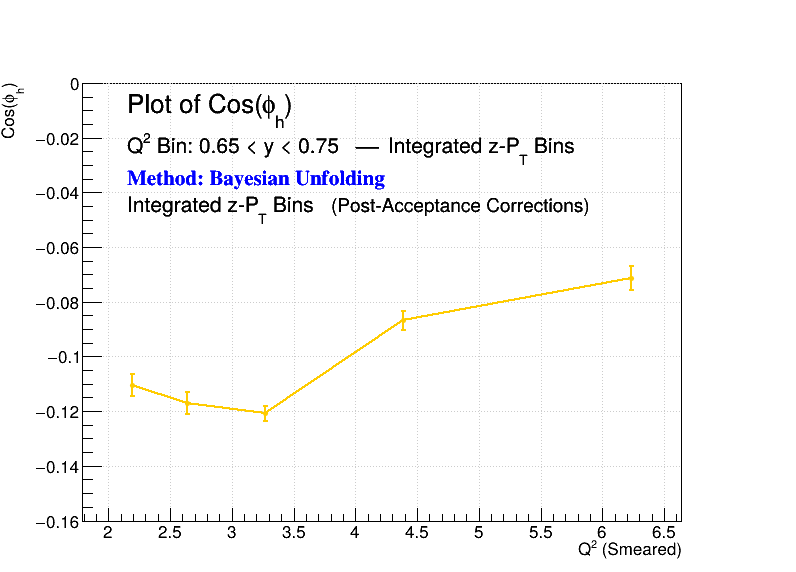

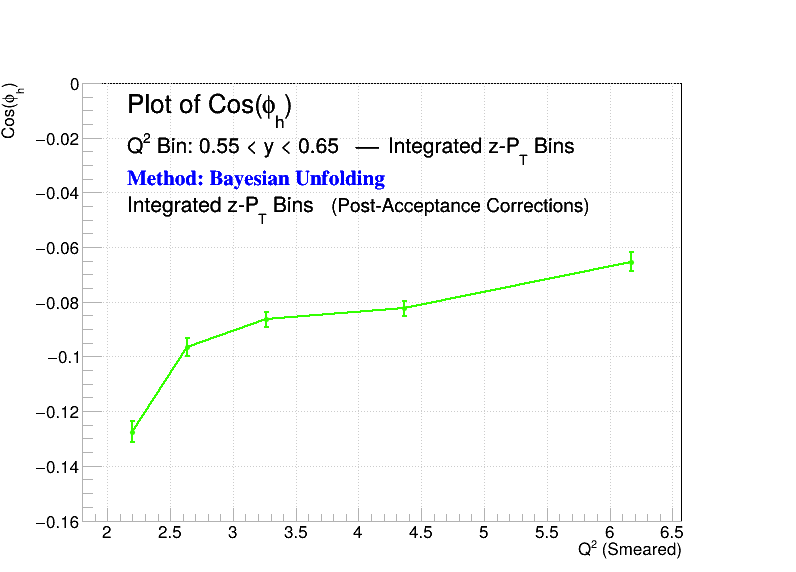

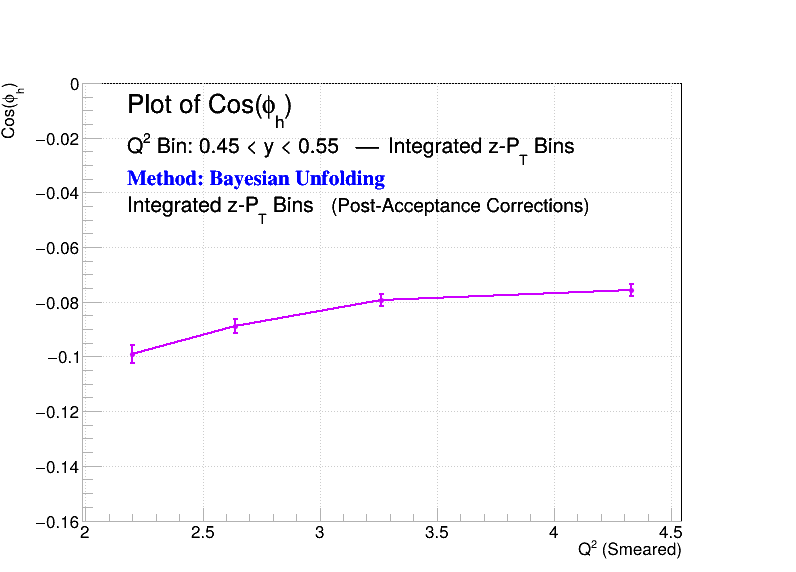

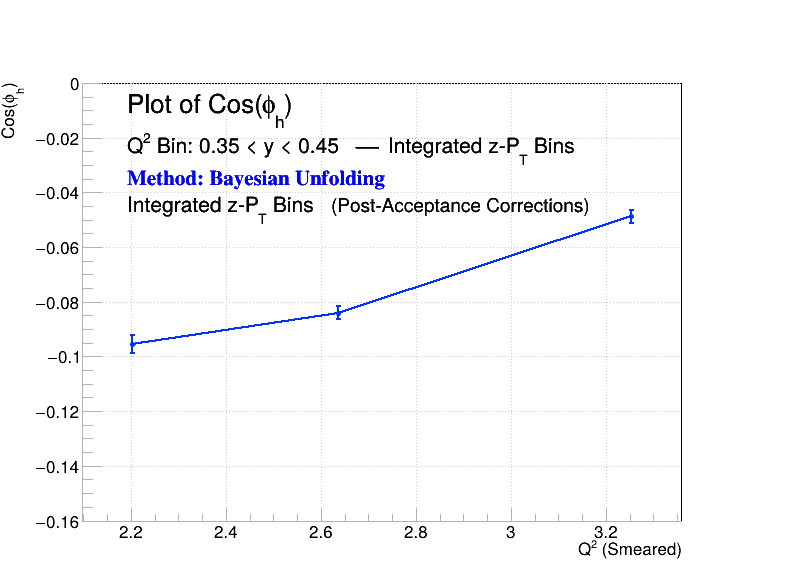

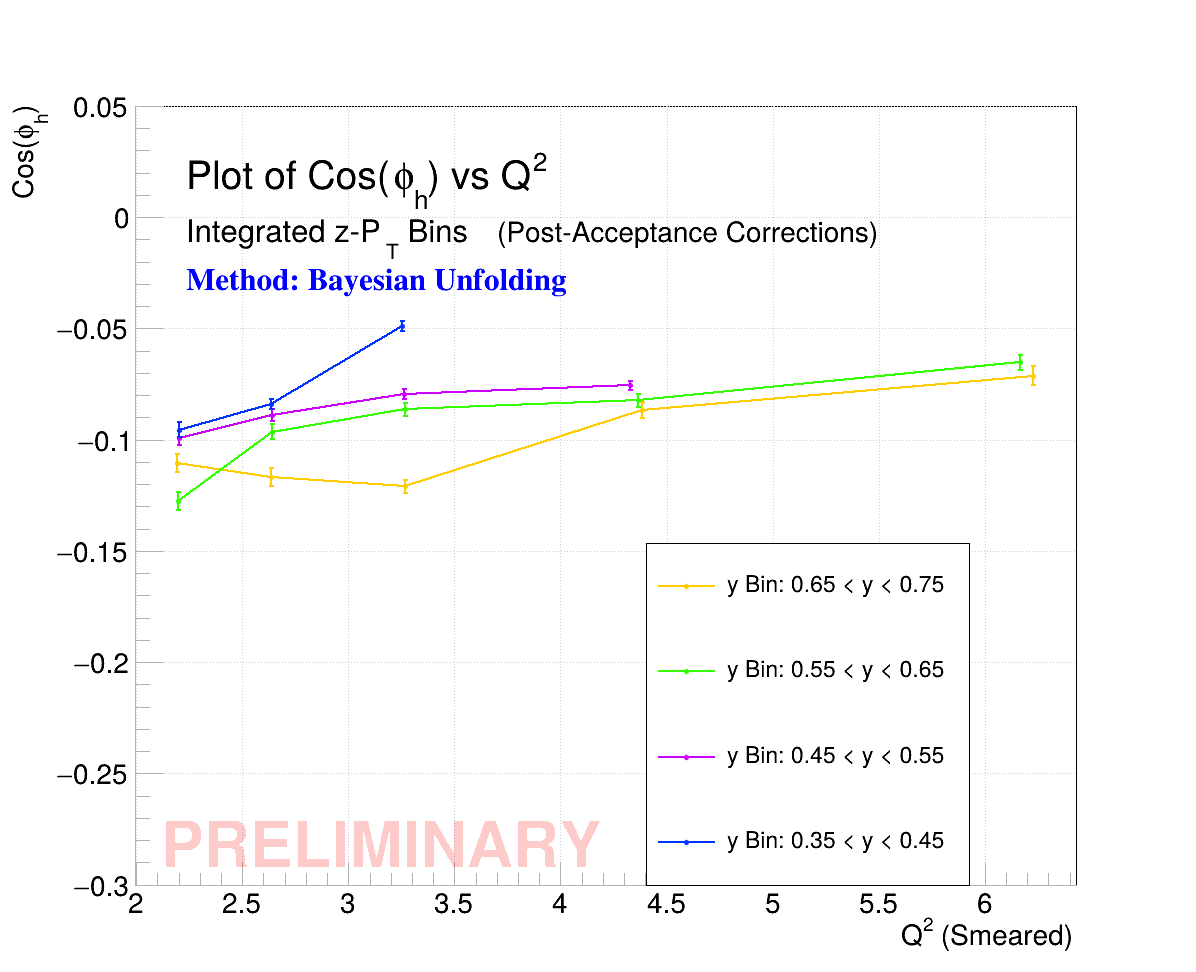

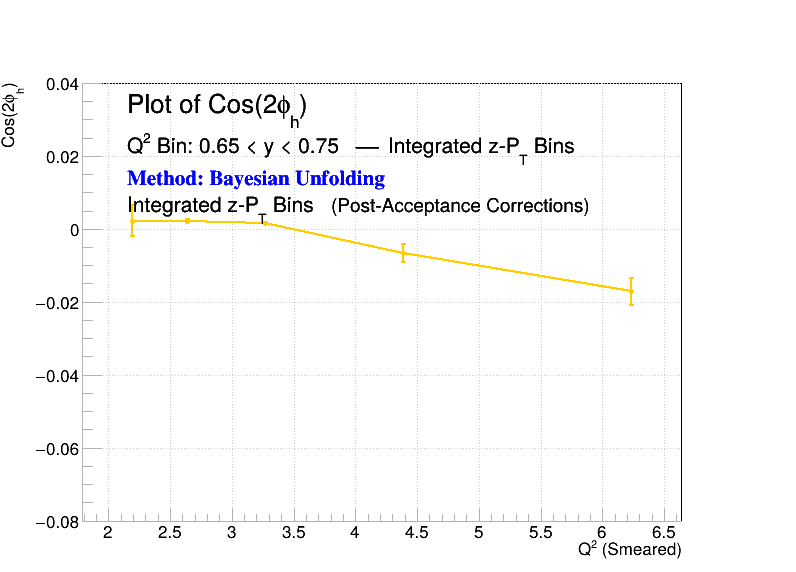

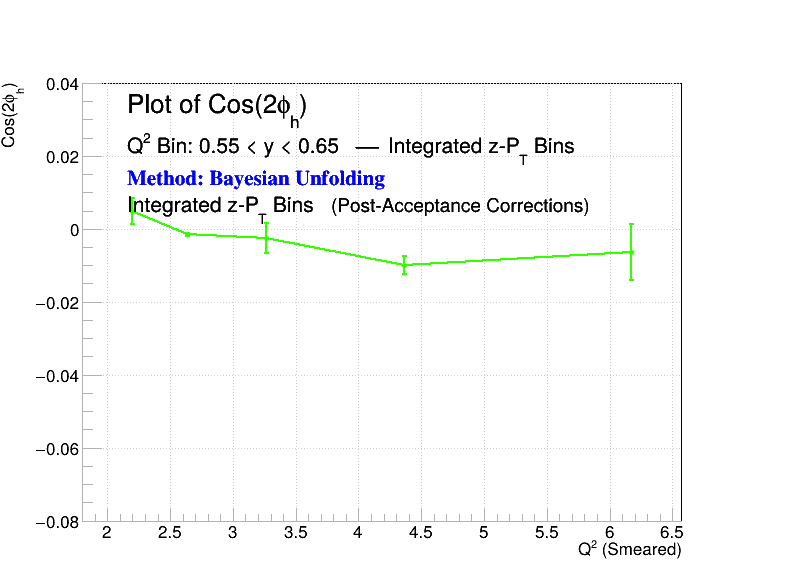

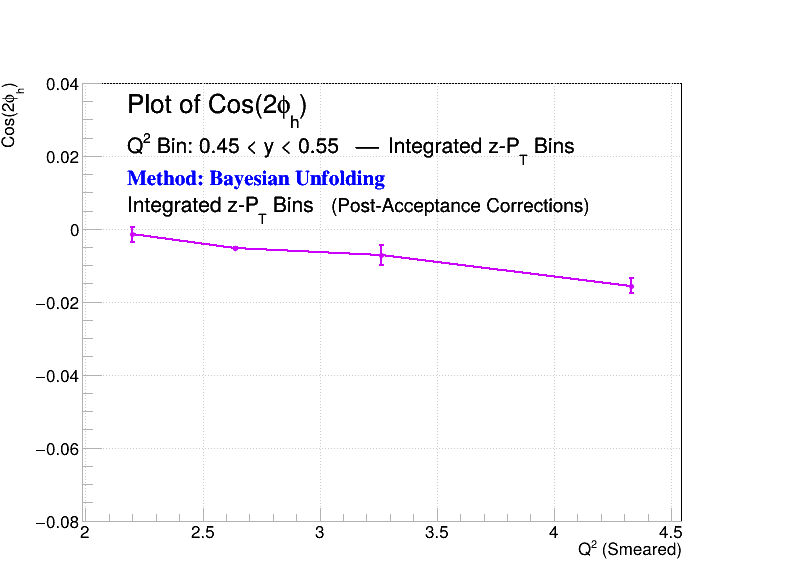

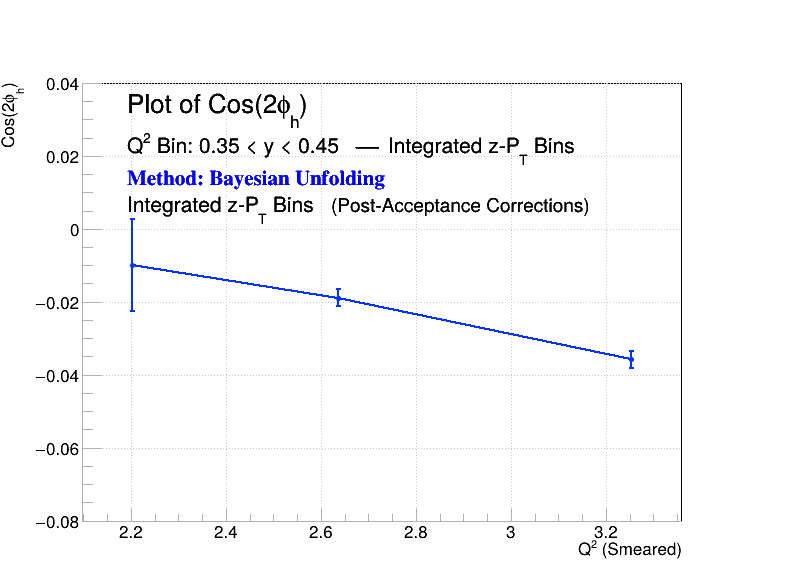

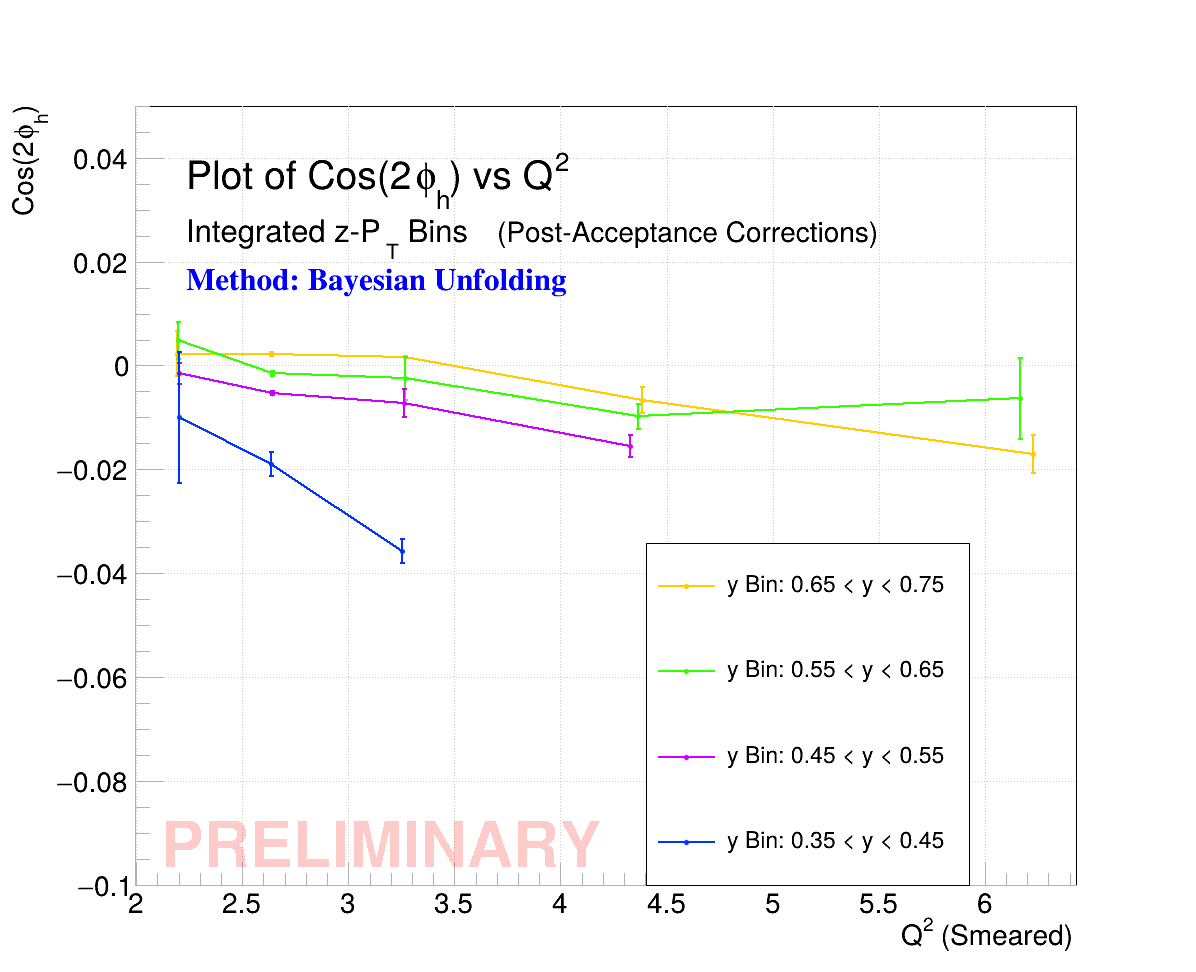

In [21]:
if(True):
    def create_legend(x1, y1, x2, y2, nColumns=1, Legend_Title="Bin (Range) Information"):
        legend_create = ROOT.TLegend(x1, y1, x2, y2)
        legend_create.SetNColumns(nColumns)  # Start with 1 column
        legend_create.SetHeader("".join(["#scale[1.35]{", str(Legend_Title), "}"]), "C") # option "C" allows to center the header
        return legend_create
    
    
    Make_Plots_Q = True
    
    # Histo_Type = "3D"
    Histo_Type = "Skip"
    Smear_Type = "SMEARED "
    # Smear_Type = ""
    Fit___Type = "Bin-by-Bin Correction"
    Fit___Type = "Bayesian Unfolding"
    # Fit___Type = "Generated Plot"
    Parameters_to_Compare = ["B", "C"]
    # Parameters_to_Compare = ["B"]
    
    Comparison_Output = {}
    
    Q2_bin_group_list = [1, 2, 3, 4, 5]
    y_bin_group_list  = [1, 2, 3, 4]
    
    Q2_bin_group_def = {"Group_1": [1, 2, 3,  4, ""], "Group_2": [5, 6,  7,  8, ""], "Group_3": [9, 10, 11, 12, ""], "Group_4": [13, 14, 15, "", ""], "Group_5": [16, 17, "", ""]}
    y__bin_group_def = {"Group_1": [1, 5, 9, 13, 16], "Group_2": [2, 6, 10, 14, 17], "Group_3": [3,  7, 11, 15, ""], "Group_4": [4,   8, 12, "", ""], "Group_5": ["", "", "", ""]}
    
    
    # # if(Cut_Proton_Q):
    # Q2_bin_group_list = [1, 2, 3, 4, 5]
    # y_bin_group_list  = [1, 2, 3]
    
    # # Cuts bins 4, 8, 11, 12, 15, and 17
    # Q2_bin_group_def = {"Group_1": [1, 2, 3, "", ""], "Group_2": [5, 6,  7, "", ""], "Group_3": [9, 10, "", "", ""], "Group_4": [13, 14, "", "", ""], "Group_5": [16, "", "", ""]}
    # y__bin_group_def = {"Group_1": [1, 5, 9, 13, 16], "Group_2": [2, 6, 10, 14, ""], "Group_3": [3,  7, "", "", ""], "Group_4": ["", "", "", "", ""], "Group_5": ["", "", "", ""]}
    
    Extra_Title_Info = ""
    
    for Par___Type      in Parameters_to_Compare:
        for Q2_bin_group in Q2_bin_group_list:
            Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
            # if(Cut_Proton_Q):
            # Q2_y_Bin_Groups = [1, 2, 3] if(Q2_bin_group == 1) else [5, 6, 7] if(Q2_bin_group == 2) else [9, 10] if(Q2_bin_group == 3) else [13, 14] if(Q2_bin_group == 4) else [16]
            Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"] = []
            for Q2_y_Bin     in Q2_y_Bin_Groups:
                y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
                num_pT_cols   = 7 if(Q2_y_Bin in [1, 9])            else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
                z_row, pT_col = 0, 0
                try:
                    type(Comparison_Output[f"Par_{Par___Type}_y_Bin_{y_bin_group}"])
                except:
                    Comparison_Output[f"Par_{Par___Type}_y_Bin_{y_bin_group}"] = []
                # for z_pT_Bin    in range(-1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                for z_pT_Bin    in range(-1, 0):
                    if(z_pT_Bin   in [-1]):
                        z_pT_Bin = "Integrated"
                        Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                    elif(z_pT_Bin in [0]):
                        z_pT_Bin = "All"
                        Extra_Title_Info = ""
    #                     z_pT_Bin = "Integrated"
    #                     Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                    else:
                        if(Cut_Proton_Q):
                            continue
                        if((z_pT_Bin-1)%num_pT_cols == 0):
                            z_row += 1
                            pT_col = 0
                        pT_col += 1
                    if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                        continue
                    Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                    Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                    if("ERROR" in [Moment_Value, Moment_Value_Error]):
                        print(f"{color.Error}{Bin___Type}{color.END}")
                        print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                        print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                    else:
                        Appending_Bin_Info = [float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin]
                        for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                            color_ii = ROOT.kOrange if(group_num in [1])                                    else ROOT.kSpring if(group_num in [2])                                    else ROOT.kViolet if(group_num in [3])                                    else ROOT.kAzure if(group_num in [4])                                    else ROOT.kPink
                            color_jj = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                            if(z_pT_Bin in ["All", 0, "0", "Integrated"]):
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"].append([Appending_Bin_Info, color_ii])
                            else:
                                try:
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                                except:
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]   = []
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                                try:
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])
                                except:
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"] = []
                                    Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])
    
    
    for ii in Comparison_Output:
        print(f"\n\n{ii}:\n\t{Comparison_Output[ii]}")
    
    if(Make_Plots_Q):
        y_values = {}
        y_errors = {}
        x_values = {}
        x_errors = {}
        n_points = {}
        graph    = {}
        canvas   = {}
        multi_graph = {}
        legend   = {}
        latex    = {}
        multi_graph_canvas = {}
    
        # # # 'Group_to_Plot' determines whether the Q2 rows are used or if the y columns are looped over
        Group_to_Plot = "Q2"
        Group_to_Plot = "y"
    
    
        bin_group_list = Q2_bin_group_list if(Group_to_Plot in ["Q2"]) else y_bin_group_list
    
        # Do not let Group_to_Plot = Function_of_Variable
        Function_of_Variable = "Q2"
        # Function_of_Variable = "y"
        # Function_of_Variable = "xB"
    
    
        if(Function_of_Variable in [Group_to_Plot]):
            raise("Do not let Group_to_Plot = Function_of_Variable")
    
    
        for Par___Type in Parameters_to_Compare:
            multi_graph[Par___Type] = ROOT.TMultiGraph()
            multi_graph[Par___Type].SetName(Par___Type)
            TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", "}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
            if(Extra_Title_Info not in [""]):
                TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins", "".join([str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else " - Proton MM Cut" if(Cut_Proton_Q) else ""])))
            elif(Tagged_Proton_Q):
                TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins}", "Integrated z-P_{T} Bins#scale[0.85]{ - Tagged Proton}}"))
            elif(Cut_Proton_Q):
                TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins}", "Integrated z-P_{T} Bins#scale[0.85]{ - Proton MM Cut}}"))
            multi_graph[Par___Type].SetTitle(TitleMG)
    #         legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
            legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.49)
            for bin_group in bin_group_list:
                # Separate the data into y_values, y_errors, and x_values
                key = f"Par_{Par___Type}_{Group_to_Plot}_Bin_{bin_group}"
                color_ii = Comparison_Output[key][0][1]
                y_values[key] = array('d', [point[0][0] for point in Comparison_Output[key]])
                y_errors[key] = array('d', [point[0][1] for point in Comparison_Output[key]])
                x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"mean_{Function_of_Variable}")  for point in Comparison_Output[key]])
                x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"Error_{Function_of_Variable}") for point in Comparison_Output[key]])
    
                # Create a TGraphErrors object
                n_points[key] = len(Comparison_Output[key])
                graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])
    
                # Customize the graph
                bin_title = str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], return_type=Group_to_Plot)).replace("Q2", "Q^{2}")
                
                Binning_Title = "".join([Function_of_Variable if(Function_of_Variable not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title), " #topbar Integrated z-P_{T} Bins"])
                Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
                if(Extra_Title_Info not in [""]):
                    Title = "".join(["#splitline{", str(Title), "}{", str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else " - Proton MM Cut" if(Cut_Proton_Q) else "", "}"])
                graph[key].SetTitle(str(Title))
                graph[key].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
                graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
                graph[key].SetMarkerStyle(8)
                graph[key].SetMarkerSize(0.5)
                graph[key].SetLineWidth(2)
                graph[key].SetLineColor(color_ii)
                graph[key].SetMarkerColor(color_ii)
    
                # Add the graph to the TMultiGraph
                multi_graph[Par___Type].Add(graph[key])
    #             legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: #scale[0.75]{", str(bin_title), "}"])
                legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title)])
                Integrated_z__range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="z_Max")
                Integrated_pT_range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="pT_Max")
                # legend_title = "".join(["#scale[0.35]{#splitline{", str(legend_title), "}{#scale[0.6]{#splitline{z Range:    ", str(Integrated_z__range), "}{P_{T} Range: ", str(Integrated_pT_range), "}}}}"])
                legend[Par___Type].AddEntry(graph[key], legend_title, "lp")
    
                # Create a canvas and draw the individual graph
                canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
                # Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
                Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.05, up_add=0.05, down_add=0.1)
                graph[key].Draw("APL")
                # graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
                graph[key].GetYaxis().SetRangeUser(-0.16 if(str(Par___Type) in ["B"]) else -0.08, 0.0 if(str(Par___Type) in ["B"]) else 0.04)
            
    #             graph[key].GetYaxis().SetRangeUser(-1.0 if(str(Par___Type) in ["B"]) else -0.45, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
        #         canvas[key].Draw()
    
            # Create a canvas for the TMultiGraph for the current Par___Type
            multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
            # Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
            # Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.05, up_add=0.05, down_add=0.1)
            Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.125, right_add=0, up_add=0.01, down_add=0.1)
            multi_graph[Par___Type].Draw("APL")
    #         multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
            # multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.5 if(str(Par___Type) in ["B"]) else -0.35, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
            # multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.16 if(str(Par___Type) in ["B"]) else -0.08, 0.0 if(str(Par___Type) in ["B"]) else 0.04)
            multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.3 if(str(Par___Type) in ["B"]) else -0.1, 0.05 if(str(Par___Type) in ["B"]) else 0.05)
            
            
            multi_graph[Par___Type].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
            multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
            legend[Par___Type].Draw()
    
            latex[Par___Type] = ROOT.TLatex()
            latex[Par___Type].SetTextSize(0.08)
            latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
            latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates
    
            # Customize the combined plot (set title, axis labels, etc.)
            multi_graph_canvas[Par___Type].Update()
            multi_graph_canvas[Par___Type].Draw()
            save_name = "".join(["Fit_Par_", str(Par___Type), "_METHOD_SMEAR_phi_t_VS_", str(Function_of_Variable), "_in_", str(Group_to_Plot), "_Bins.pdf"])
            save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
            save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
            if(Extra_Title_Info not in [""]):
                save_name = f"Integrated_{save_name}"
            if(Tagged_Proton_Q):
                save_name = f"Tagged_Proton_{save_name}"
            if(Cut_Proton_Q):
                save_name = f"Proton_MM_Cut_{save_name}"
                
                
            # save_name = str(save_name).replace("Par_B", "Cos_phi")
            # save_name = str(save_name).replace("Par_C", "Cos2phi")
    
            # Saving Plots
            if(not True):
                print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
                multi_graph_canvas[Par___Type].SaveAs(save_name)
            else:
                print(f"Not Saving: {save_name}")
    else:
        print(f"\n{color.RED}Not making plots right now (set 'Make_Plots_Q = True' to make them){color.END}\n")
    
    
        
        
    # Initialize variables
    Legend_Groups = {}
    dummy_objects = {}
    data_points_for_plotting = {}
    max_rows_per_column = 7  # Set the max number of rows per column
    
    for Par___Type in Parameters_to_Compare:
        for Q2_bin_group in Q2_bin_group_list:
            Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
            for Q2_y_Bin     in Q2_y_Bin_Groups:
                y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
                for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                    color_ii = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                    try:
                        # Legend_Groups[f"{bin_group}_Bin_All"]
                        Legend_Groups[f"{bin_group}_Bin_Integrated"]
                    except:
                        # print(f"\nCreating {color.BOLD}'{bin_group}_Bin_{group_num}'{color.END}\n")
                        # Legend_Groups[f"{bin_group}_Bin_All"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=1, Legend_Title=str("".join([str(bin_group).replace("Q2", "Q^{2}"), " Bin Ranges Information"])))
                        # Legend_Groups[f"{bin_group}_Bin_All"].SetName(f"{bin_group}_Bin_All")
                        Legend_Groups[f"{bin_group}_Bin_Integrated"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=1, Legend_Title=str("".join([str(bin_group).replace("Q2", "Q^{2}"), " Bin Ranges Information"])))
                        Legend_Groups[f"{bin_group}_Bin_Integrated"].SetName(f"{bin_group}_Bin_Integrated")
                    for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"]:
                        try:
                            if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}"]):
                                data_points_for_plotting[f"{Par___Type}_{bin_group}"].append(ii)
                            # else:
                            #     print(f"\n{color.Error}'{ii}' is already in data_points_for_plotting[...]{color.END}\n")
                        except:
                            data_points_for_plotting[f"{Par___Type}_{bin_group}"] = [ii]
    
                    # Add entry to legend if the color changes
                    if(f"{bin_group}_Group_color_{color_ii}" not in dummy_objects):
                        # Create dummy TGraph if it doesn't exist for this color
                        dummy_objects[f"{bin_group}_Group_color_{color_ii}"] = ROOT.TGraph()
                        dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetMarkerColor(color_ii)
                        dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetLineColor(color_ii)
                        dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetMarkerStyle(20)
    
                        # Add the entry to the legend
                        Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
        #                 Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type="y" if(bin_group in ["Q2"]) else "Q2")), "}}"])
                        Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                        Legend_title = Legend_title.replace("Q2", "Q^{2}")
                        # Legend_Groups[f"{bin_group}_Bin_All"].AddEntry(dummy_objects[f"{bin_group}_Group_color_{color_ii}"], Legend_title, "PL")
                        Legend_Groups[f"{bin_group}_Bin_Integrated"].AddEntry(dummy_objects[f"{bin_group}_Group_color_{color_ii}"], Legend_title, "PL")
    
    
        for Q2_bin_group in Q2_bin_group_list:
            Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
            # Q2_y_Bin_Groups = [1, 2, 3]    if(Q2_bin_group == 1) else [5, 6, 7]    if(Q2_bin_group == 2) else [9, 10]         if(Q2_bin_group == 3) else [13, 14]     if(Q2_bin_group == 4) else [16]
            for Q2_y_Bin     in Q2_y_Bin_Groups:
                y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
                # y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14])                     else 3 if(Q2_y_Bin in [3, 7])         else 4
                for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                    color_ii = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                    ############################################
                    ###==========###   z-Bins   ###==========###
                    ############################################
                    try:
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"]
                    except:
                        # print(f"\nCreating {color.BOLD}'{bin_group}_Bin_{group_num}_z_Bins'{color.END}\n")
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column, Legend_Title=str("".join(["#splitline{", str(bin_group).replace("Q2", "Q^{2}"), " and z Bin Ranges Information}{#scale[0.65]{x_{B} Info given relative to the Integratated z-P_{T} Bins}}"])))
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].SetName(f"{bin_group}_Bin_{group_num}_z_Bins")
                    for z_row in range(1, max_rows_per_column + 1):
                        try:
        #                     print(f"Adding: Comparison_Output['Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}'] (type:", type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}']), f""")
        # \tAdding: '{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}'""")
        #                     type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}'])
                            for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
        #                         jj = ii.copy()
        #                         jj.append(color_ii + z_row + 1)
                                try:
                                    if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"]):
                                        data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"].append(ii)
                                except:
                                    data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"] = [ii]
    
    
                            # Add entry to legend if the color changes
                            if(f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}" not in dummy_objects):
                                # Create dummy TGraph if it doesn't exist for this color
                                dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"] = ROOT.TGraph()
                                dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetMarkerColor(color_ii + z_row + 1)
                                dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetLineColor(color_ii   + z_row + 1)
                                dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetMarkerStyle(20)
    
                                # Add the entry to the legend
                                Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
                                Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                                Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")),       "}}"])
                                Legend_title = Legend_title.replace("Q2", "Q^{2}")
                                Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].AddEntry(dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"], Legend_title, "PL")
                        except:
                            # print(f"{color.RED}No 'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                            # Fill the rest of the row with blank entries
                            if(z_row not in dummy_objects):
                                dummy_objects[z_row] = ROOT.TGraph()
                                dummy_objects[z_row].SetMarkerColor(0)  # Invisible color
                            Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].AddEntry(dummy_objects[z_row], "", "P")
                    ############################################
                    ###==========###   pT-Bins   ###==========###
                    ############################################
                    try:
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"]
                    except:
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column, Legend_Title=str("".join(["#splitline{", str(bin_group).replace("Q2", "Q^{2}"), " and P_{T} Bin Ranges Information}{#scale[0.65]{x_{B} Info given relative to the Integratated z-P_{T} Bins}}"])))
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].SetName(f"{bin_group}_Bin_{group_num}_pT_Bins")
                    for pT_row in range(1, max_rows_per_column + 1):
                        try:
                            # type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_row}'])
                            for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_row}"]:
        #                         jj = ii.copy()
        #                         jj.append(color_ii + pT_row + 1)
                                try:
                                    if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"]):
                                        data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"].append(ii)
                                except:
                                    data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"] = [ii]
    
                            # Add entry to legend if the color changes
                            if(f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}" not in dummy_objects):
                                # Create dummy TGraph if it doesn't exist for this color
                                dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"] = ROOT.TGraph()
                                dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetMarkerColor(color_ii + pT_row + 1)
                                dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetLineColor(color_ii   + pT_row + 1)
                                dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetMarkerStyle(20)
    
                                # Add the entry to the legend
                                Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
                                Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                                Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=pT_row, return_type="pT")),       "}}"])
                                Legend_title = Legend_title.replace("Q2", "Q^{2}")
                                Legend_title = Legend_title.replace("pT", "P_{T}")
                                Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].AddEntry(dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"], Legend_title, "PL")
                        except:
                            # print(f"{color.RED}No 'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                            # Fill the rest of the row with blank entries
                            if(pT_row not in dummy_objects):
                                dummy_objects[pT_row] = ROOT.TGraph()
                                dummy_objects[pT_row].SetMarkerColor(0)  # Invisible color
                            Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].AddEntry(dummy_objects[pT_row], "", "P")
    
    # for ii in Legend_Groups:
    #     print(ii)
    # Draw the legend
    # canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
    # Legend_Groups[f"Q2_Bin_1_pT_Bins"].Draw()
    # canvas.Modified()
    # canvas.Update()
    # canvas.Draw()
    
    
    # print("\nDone\n")
        
    
    print("\n\nDONE\n\n")
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")

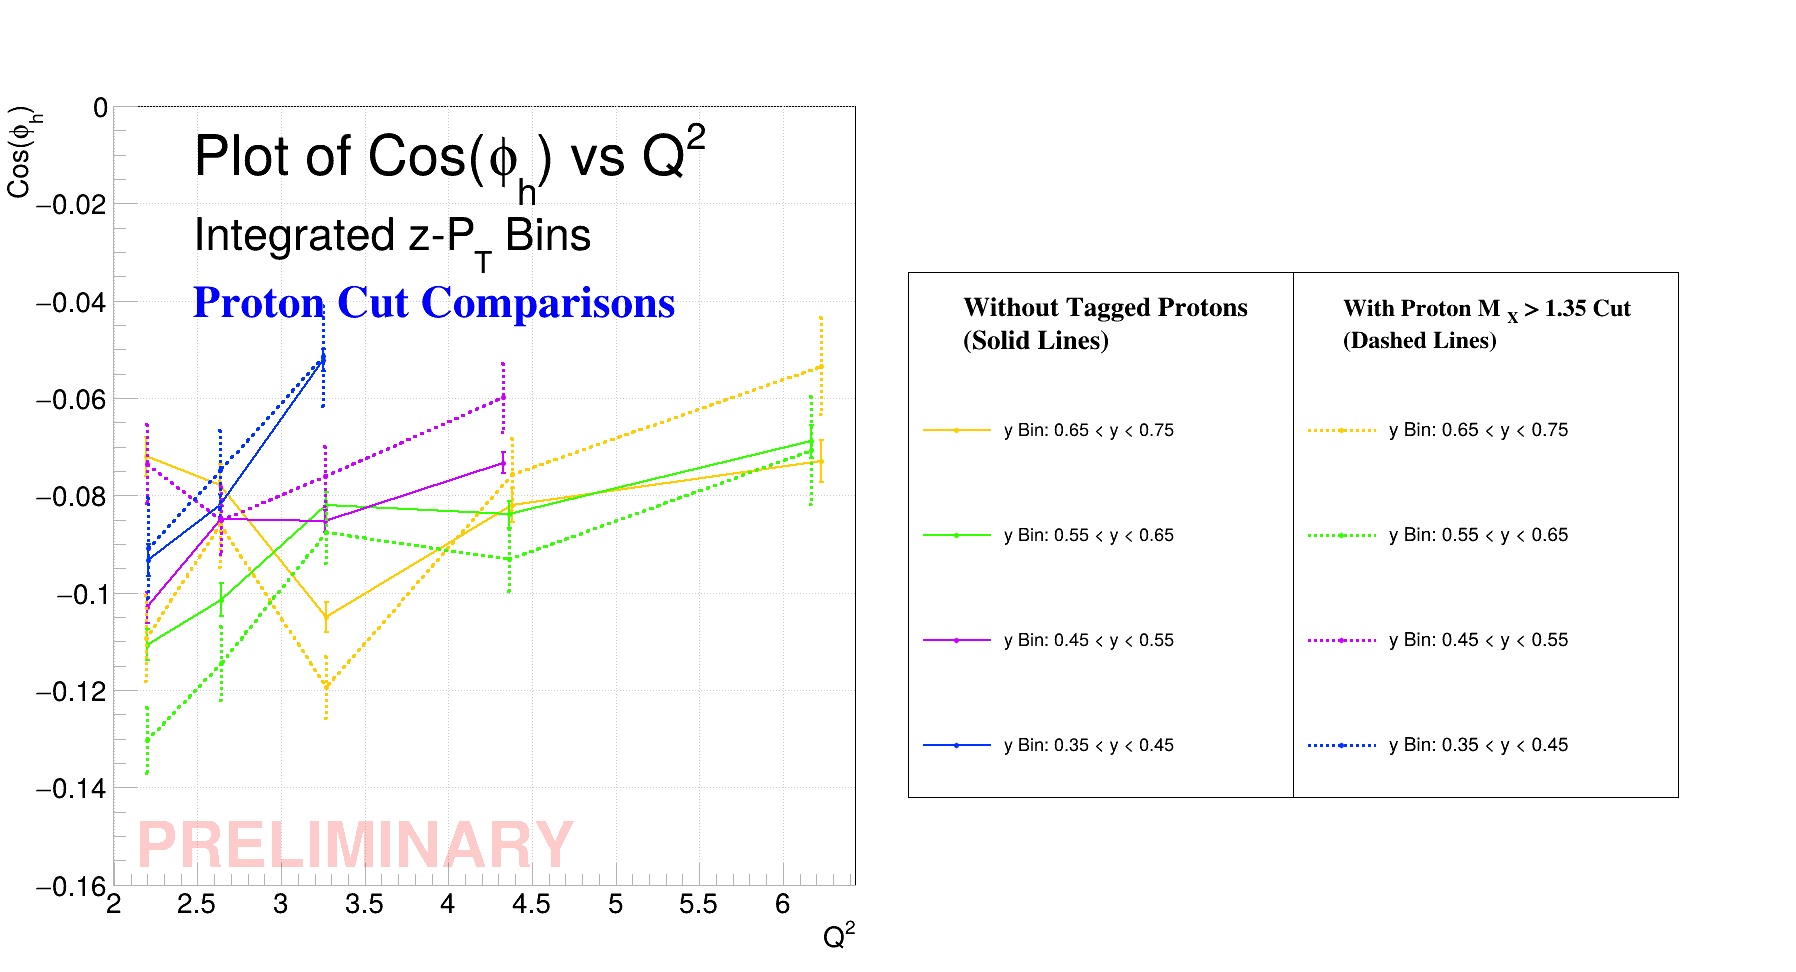

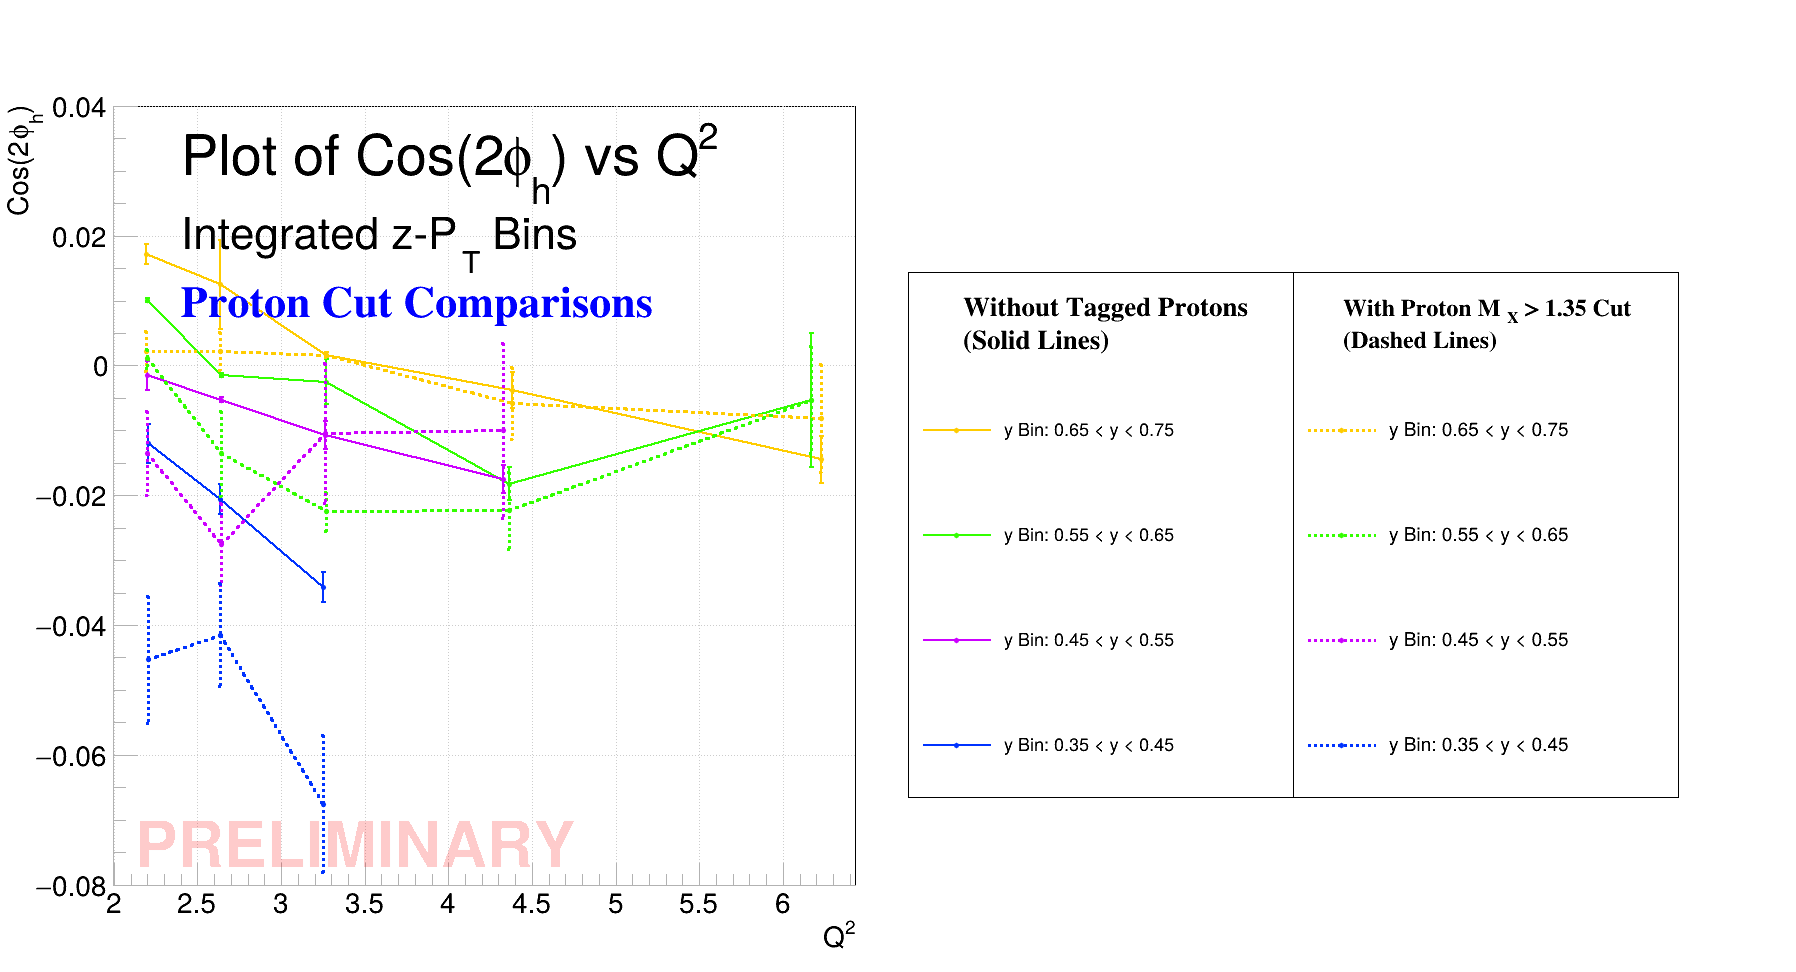

In [22]:
for ii in multi_graph_canvas:
    multi_graph_canvas[ii].Draw()

In [23]:
# STOP
# # for ii in data_points_for_plotting:
# #     print(f"\n{ii})\n\t{data_points_for_plotting[ii]}\n")

In [24]:
# # Generic code that is used to show which Q2/y/z/pT row the individual kinematic bin lies in
# Bin_Rows_Output = {}

# Q2_bin_group_list = [1, 2, 3, 4, 5]

# for Q2_bin_group in Q2_bin_group_list:
#     Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
#     Bin_Rows_Output[f"Q2_bin_group_{Q2_bin_group}"] = []
#     for Q2_y_Bin        in Q2_y_Bin_Groups:
#         y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
#         num_pT_cols   = 7 if(Q2_y_Bin in [1, 9])            else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
#         z_row, pT_col = 0, 0
#         try:
#             type(Bin_Rows_Output[f"y_bin_group_{y_bin_group}"])
#         except:
#             Bin_Rows_Output[f"y_bin_group_{y_bin_group}"] = []
#         for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
#             if(z_pT_Bin in [0]):
#                 z_pT_Bin = "All"
#             else:
#                 if((z_pT_Bin-1)%num_pT_cols == 0):
#                     z_row += 1
#                     pT_col = 0
#                 pT_col += 1
#             if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
#                 continue
#             for bin_group, group_num in [["Q2", Q2_bin_group], ["y", y_bin_group]]:
#                 if(z_pT_Bin in ["All", 0, "0"]):
#                     Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}"].append([["Q2-y Bin", Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                 else:
#                     try:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([["Q2-y Bin",   Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                     except:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]   = []
#                     try:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([["Q2-y Bin", Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                     except:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"] = []

                
                
# # # print(f"Bin_Rows_Output = {Bin_Rows_Output}")
# # print("\nBin_Rows_Output = {")
# # for ii in Bin_Rows_Output:
# #     if("Q2_bin" in str(ii)):
# #         print(f"\n'{ii}':\n\t{Bin_Rows_Output[ii]}")
# # print("}")

# print("\nDONE")

# Making Overlaping Plots from Different Configurations

In [25]:
file_path_1 = 'SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_Smeared.txt'
file_path_2 = 'SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Tagged_Proton_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_TagProton_Unsmeared.txt'
file_path_3 = 'SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Tagged_Proton_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_ProtonCut_Unsmeared.txt'


file_content_1 = ""
file_content_2 = ""
file_content_3 = ""
for files_path in glob.glob(file_path_1):
    with open(files_path, 'r') as file:
        file_content_1 += file.read()
        print(f"{color.BOLD}File: {color.BLUE}{files_path}{color.END_B} has been found and added to 'file_content_1'...{color.END}")
print("")
for files_path in glob.glob(file_path_2):
    with open(files_path, 'r') as file:
        file_content_2 += file.read()
        print(f"{color.BOLD}File: {color.BLUE}{files_path}{color.END_B} has been found and added to 'file_content_2'...{color.END}")
print("")
for files_path in glob.glob(file_path_3):
    with open(files_path, 'r') as file:
        file_content_3 += file.read()
        print(f"{color.BOLD}File: {color.BLUE}{files_path}{color.END_B} has been found and added to 'file_content_3'...{color.END}")

file_content_1 = file_content_1.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content_1 = file_content_1.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")
file_content_2 = file_content_2.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content_2 = file_content_2.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")
file_content_3 = file_content_3.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content_3 = file_content_3.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")

print(f"\n{color.BOLD}'file_content_1', 'file_content_2', and 'file_content_3'{color.END} has been updated\n")

File: SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_Smeared.txt has been found and added to 'file_content_1'...

File: SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Tagged_Proton_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_TagProton_Unsmeared.txt has been found and added to 'file_content_2'...

File: SIDIS_python_Images_From_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024/Parameters_Tagged_Proton_Pass_2_New_Integrated_Bins_Test_FC_14_V1_11_10_2024_Q2_y_Bins_Combined_ProtonCut_Unsmeared.txt has been found and added to 'file_content_3'...

'file_content_1', 'file_content_2', and 'file_content_3' has been updated



In [56]:
def create_legend(x1, y1, x2, y2, nColumns=1, Legend_Title="Bin (Range) Information"):
    legend_create = ROOT.TLegend(x1, y1, x2, y2)
    legend_create.SetNColumns(nColumns)  # Start with 1 column
    legend_create.SetHeader("".join(["#scale[1.35]{", str(Legend_Title), "}"]), "C") # option "C" allows to center the header
    return legend_create


Make_Plots_Q = True

# Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
# Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]

Comparison_Output = {}

Q2_bin_group_list = [1, 2, 3, 4, 5]
y_bin_group_list  = [1, 2, 3, 4]
xB_bin_group_list = [1, 2]

Q2_bin_group_def = {"Group_1": [1, 2,  3,  4, ""], "Group_2": [5,  6,  7,  8, ""], "Group_3": [9,  10, 11, 12, ""], "Group_4": [13, 14, 15, "", ""], "Group_5": [16, 17, "", ""]}
y__bin_group_def = {"Group_1": [1, 5,  9, 13, 16], "Group_2": [2,  6, 10, 14, 17], "Group_3": [3,   7, 11, 15, ""], "Group_4": [4,   8, 12, "", ""], "Group_5": ["", "", "", ""]}
xB_bin_group_def = {"Group_1": [4, 7, 10, "", ""], "Group_2": [8, 11, 13, "", ""], "Group_3": ["", "", "", "", ""], "Group_4": ["", "", "", "", ""], "Group_5": ["", "", "", ""]}



# # if(Cut_Proton_Q):
# Q2_bin_group_list = [1, 2, 3, 4, 5]
# y_bin_group_list  = [1, 2, 3]

# # Cuts bins 4, 8, 11, 12, 15, and 17
# Q2_bin_group_def = {"Group_1": [1, 2, 3, "", ""], "Group_2": [5, 6,  7, "", ""], "Group_3": [9, 10, "", "", ""], "Group_4": [13, 14, "", "", ""], "Group_5": [16, "", "", ""]}
# y__bin_group_def = {"Group_1": [1, 5, 9, 13, 16], "Group_2": [2, 6, 10, 14, ""], "Group_3": [3,  7, "", "", ""], "Group_4": ["", "", "", "", ""], "Group_5": ["", "", "", ""]}

Extra_Title_Info = ""

file_configurations = []
# file_configurations = [[file_content, Histo_Type, Smear_Type, Fit___Type, Config_Title], [file_content_2, Histo_Type_2, Smear_Type_2, Fit___Type_2, Config_Title_2]]
# Configuration 1:
# file_configurations.append([file_content_1, Histo_Type, Smear_Type, Fit___Type, f"{root_color.Bold}{{#scale[1.5]{{#splitline{{Bayesian Unfolding}}{{Smeared Without Protons}}}}}}"])
# # file_configurations.append([file_content_2, Histo_Type, "",         Fit___Type, f"{root_color.Bold}{{#scale[1.25]{{#splitline{{Bayesian Unfolding}}{{With Tagged Protons}}}}}}"])
# file_configurations.append([file_content_3, Histo_Type, "",         Fit___Type, f"{root_color.Bold}{{#scale[1.25]{{#splitline{{Bayesian Unfolding}}{{With Proton M_{{X}} > 1.35 Cut}}}}}}"])

file_configurations.append([file_content_1, Histo_Type, Smear_Type, Fit___Type, f"{root_color.Bold}{{#scale[1.5]{{#splitline{{Without Tagged Protons}}{{(Solid Lines)}}}}}}"])
file_configurations.append([file_content_2, Histo_Type, "",         Fit___Type, f"{root_color.Bold}{{#scale[1.25]{{#splitline{{With Tagged Protons}}{{(Dashed Lines)}}}}}}"])
# file_configurations.append([file_content_3, Histo_Type, "",         Fit___Type, f"{root_color.Bold}{{#scale[1.25]{{#splitline{{With Proton M_{{X}} > 1.35 Cut}}{{(Dashed Lines)}}}}}}"])

# Define 'Comparison_Title' based on how you want the TMultigraph Title to look when plotting the set configurations
# Comparison_Title = "Tagged Proton/Proton Cut Comparisons"

Comparison_Title = "Tagged Proton Comparisons"
Save_comparison  = "Tagged_Proton_Comparison"
# Comparison_Title = "Proton Cut Comparisons"
# Save_comparison  = "Proton_Cut_Comparison"

for Par___Type      in Parameters_to_Compare:
    for config_index, config in enumerate(file_configurations):
        current_file_content, Histo_Type, Smear_Type, Fit___Type, Config_Title = config
        for Q2_bin_group in Q2_bin_group_list:
            # Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
            # # if(Cut_Proton_Q):
            # Q2_y_Bin_Groups = [1, 2, 3] if(Q2_bin_group == 1) else [5, 6, 7] if(Q2_bin_group == 2) else [9, 10] if(Q2_bin_group == 3) else [13, 14] if(Q2_bin_group == 4) else [16]
            Q2_y_Bin_Groups = Q2_bin_group_def[f"Group_{Q2_bin_group}"]
            Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"] = []
            for Q2_y_Bin     in Q2_y_Bin_Groups:
                if(Q2_y_Bin in [""]):
                    continue
                y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2,  6, 10, 14, 17])                    else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
                xB_bin_group  = 1 if(Q2_y_Bin in [4, 7, 10])        else 2 if(Q2_y_Bin in [8, 11, 13])                            else 3
                num_pT_cols   = 7 if(Q2_y_Bin in [1, 9])            else 6 if(Q2_y_Bin in [2,  3,  4,  5,  6, 7, 10, 14, 16, 17]) else 5
                z_row, pT_col = 0, 0
                try:
                    type(Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_y_Bin_{y_bin_group}"])
                except:
                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_y_Bin_{y_bin_group}"] = []
                try:
                    type(Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_xB_Bin_{xB_bin_group}"])
                except:
                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_xB_Bin_{xB_bin_group}"] = []
                for z_pT_Bin    in range(-1, 0):
                    if(z_pT_Bin   in [-1]):
                        z_pT_Bin = "Integrated"
                        Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                    elif(z_pT_Bin in [0]):
                        z_pT_Bin = "All"
                        Extra_Title_Info = ""
                        # z_pT_Bin = "Integrated"
                        # Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                    else:
                        if(Cut_Proton_Q):
                            continue
                        if((z_pT_Bin-1)%num_pT_cols == 0):
                            z_row += 1
                            pT_col = 0
                        pT_col += 1
                    if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                        continue
                    Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                    Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=current_file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                    if("ERROR" in [Moment_Value, Moment_Value_Error]):
                        print(f"{color.Error}{Bin___Type}{color.END}")
                        print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                        print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                    else:
                        Appending_Bin_Info = [float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin]
                        for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def], ["xB", xB_bin_group, xB_bin_group_def]]:
                            # if(bin_group in ["xB"] and group_num >   2):
                            #     continue
                            color_ii = ROOT.kOrange if(group_num in [1])                                    else ROOT.kSpring if(group_num in [2])                                    else ROOT.kViolet if(group_num in [3])                                    else ROOT.kAzure if(group_num in [4])                                    else ROOT.kPink
                            color_jj = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                            if(z_pT_Bin in ["All", 0, "0", "Integrated"]):
                                Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}"].append([Appending_Bin_Info, color_ii])
                            else:
                                try:
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                                except:
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]   = []
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                                try:
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])
                                except:
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"] = []
                                    Comparison_Output[f"Config_{config_index}_Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])


# for ii in Comparison_Output:
#     print(f"\n\n{ii}:\n\t{Comparison_Output[ii]}")

if(Make_Plots_Q):
    y_values = {}
    y_errors = {}
    x_values = {}
    x_errors = {}
    n_points = {}
    graph    = {}
    canvas   = {}
    multi_graph = {}
    legend   = {}
    latex    = {}
    multi_graph_canvas = {}

    num_configs = len(file_configurations)
    legend_width = 0.95 / num_configs

    # # # 'Group_to_Plot' determines whether the Q2 rows are used or if the y columns are looped over
    Group_to_Plot = "Q2"
    Group_to_Plot = "y"
    Group_to_Plot = "xB"


    bin_group_list = Q2_bin_group_list if(Group_to_Plot in ["Q2"]) else y_bin_group_list if(Group_to_Plot in ["y"]) else xB_bin_group_list

    # Do not let Group_to_Plot = Function_of_Variable
    Function_of_Variable = "Q2"
    # Function_of_Variable = "y"
    # Function_of_Variable = "xB"


    if(Function_of_Variable in [Group_to_Plot]):
        raise("Do not let Group_to_Plot = Function_of_Variable")

    for Par___Type in Parameters_to_Compare:
        multi_graph[Par___Type] = ROOT.TMultiGraph()
        multi_graph[Par___Type].SetName(Par___Type)
        
        TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", "}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{", str(Comparison_Title), "}}}"])

        # if(Extra_Title_Info not in [""]):
        #     TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins", "".join([str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else " - Proton MM Cut" if(Cut_Proton_Q) else ""])))
        # elif(Tagged_Proton_Q):
        #     TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins}", "Integrated z-P_{T} Bins#scale[0.85]{ - Tagged Proton}}"))
        # elif(Cut_Proton_Q):
        #     TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins}", "Integrated z-P_{T} Bins#scale[0.85]{ - Proton MM Cut}}"))
        multi_graph[Par___Type].SetTitle(TitleMG)

        for config_index, config in enumerate(file_configurations):
            current_file_content, Histo_Type, Smear_Type, Fit___Type, Config_Title = config
            # Calculate legend positions
            x1 = 0.01 + config_index * legend_width  # Start position for each legend
            x2 = x1 + legend_width                  # End position for each legend
            y1 = 0.2                                # Fixed y-coordinate for bottom
            y2 = 0.8                                # Fixed y-coordinate for top
            legend[f"Config_{config_index}_{Par___Type}"] = ROOT.TLegend(x1, y1, x2, y2)
            legend[f"Config_{config_index}_{Par___Type}"].SetHeader(Config_Title, "C")
            for bin_group in bin_group_list:
                # Separate the data into y_values, y_errors, and x_values
                key = f"Config_{config_index}_Par_{Par___Type}_{Group_to_Plot}_Bin_{bin_group}"
                color_ii = Comparison_Output[key][0][1]
                y_values[key] = array('d', [point[0][0] for point in Comparison_Output[key]])
                y_errors[key] = array('d', [point[0][1] for point in Comparison_Output[key]])
                x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"mean_{Function_of_Variable}")  for point in Comparison_Output[key]])
                x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"Error_{Function_of_Variable}") for point in Comparison_Output[key]])
    
                # Create a TGraphErrors object
                n_points[key] = len(Comparison_Output[key])
                graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])
    
                # Customize the graph
                bin_title = str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], return_type=Group_to_Plot)).replace("Q2", "Q^{2}")
                bin_title = bin_title.replace("xB", "x_{B}")
                
                Binning_Title = "".join([Function_of_Variable if(Function_of_Variable not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title), " #topbar Integrated z-P_{T} Bins"])
                Binning_Title = Binning_Title.replace("xB", "x_{B}")
                Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
                if(Extra_Title_Info not in [""]):
                    Title = "".join(["#splitline{", str(Title), "}{", str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else " - Proton MM Cut" if(Cut_Proton_Q) else "", "}"])
                graph[key].SetTitle(str(Title))
                graph[key].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
                graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
                graph[key].SetMarkerStyle(8)
                graph[key].SetMarkerSize(0.5)
                graph[key].SetLineWidth(2 + config_index)
                graph[key].SetLineStyle(1 + config_index)
                graph[key].SetLineColor(color_ii)
                graph[key].SetMarkerColor(color_ii)
    
                # Add the graph to the TMultiGraph
                multi_graph[Par___Type].Add(graph[key])
                # legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: #scale[0.75]{", str(bin_title), "}"])
                legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title)])
                legend_title = legend_title.replace("xB", "x_{B}")
                Integrated_z__range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="z_Max")
                Integrated_pT_range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="pT_Max")
                # legend_title = "".join(["#scale[0.35]{#splitline{", str(legend_title), "}{#scale[0.6]{#splitline{z Range:    ", str(Integrated_z__range), "}{P_{T} Range: ", str(Integrated_pT_range), "}}}}"])
                legend[f"Config_{config_index}_{Par___Type}"].AddEntry(graph[key], legend_title, "lp")
    
                # # Create a canvas and draw the individual graph
                # canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
                # Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.05, up_add=0.05, down_add=0.1)
                # graph[key].Draw("APL")
                # graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)

        # Create a canvas for the TMultiGraph for the current Par___Type
        # multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
        multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=2, Num_Rows=1, Size_X=1800, Size_Y=1000, cd_Space=0)
        Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.125, right_add=0.05, up_add=0.01, down_add=0.1)
        multi_graph[Par___Type].Draw("APL")
        # multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.5 if(str(Par___Type) in ["B"]) else -0.35, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
        # multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.2 if(str(Par___Type) in ["B"]) else -0.1, 0.05 if(str(Par___Type) in ["B"]) else 0.1)
        multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.16 if(str(Par___Type) in ["B"]) else -0.08, 0 if(str(Par___Type) in ["B"]) else 0.04)
        multi_graph[Par___Type].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")

        latex[Par___Type] = ROOT.TLatex()
        latex[Par___Type].SetTextSize(0.08)
        latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
        latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

        Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=2, left_add=0.05, right_add=0, up_add=0.01, down_add=0.1)
        for config_index in range(0, len(file_configurations)):
            legend[f"Config_{config_index}_{Par___Type}"].Draw()
        
        # Customize the combined plot (set title, axis labels, etc.)
        multi_graph_canvas[Par___Type].Update()
        multi_graph_canvas[Par___Type].Draw()
        save_name = "".join(["Fit_Par_", str(Par___Type), "_METHOD_SMEAR_phi_t_VS_", str(Function_of_Variable), "_in_", str(Group_to_Plot), "_Bins.pdf"])
        save_name = save_name.replace("METHOD", Save_comparison)
        # if(Extra_Title_Info not in [""]):
        #     save_name = f"Integrated_{save_name}"
        # if(Tagged_Proton_Q):
        #     save_name = f"Tagged_Proton_{save_name}"
        # if(Cut_Proton_Q):
        #     save_name = f"Proton_MM_Cut_{save_name}"
            
            
        # save_name = str(save_name).replace("Par_B", "Cos_phi")
        # save_name = str(save_name).replace("Par_C", "Cos2phi")

        # Saving Plots
        if(not True):
            print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
            multi_graph_canvas[Par___Type].SaveAs(save_name)
        else:
            print(f"Not Saving: {save_name}")
else:
    print(f"\n{color.RED}Not making plots right now (set 'Make_Plots_Q = True' to make them){color.END}\n")



print("\n\nDONE\n\n")


Not Saving: Fit_Par_B_Tagged_Proton_Comparison_SMEAR_phi_t_VS_Q2_in_xB_Bins.pdf
Not Saving: Fit_Par_C_Tagged_Proton_Comparison_SMEAR_phi_t_VS_Q2_in_xB_Bins.pdf


DONE




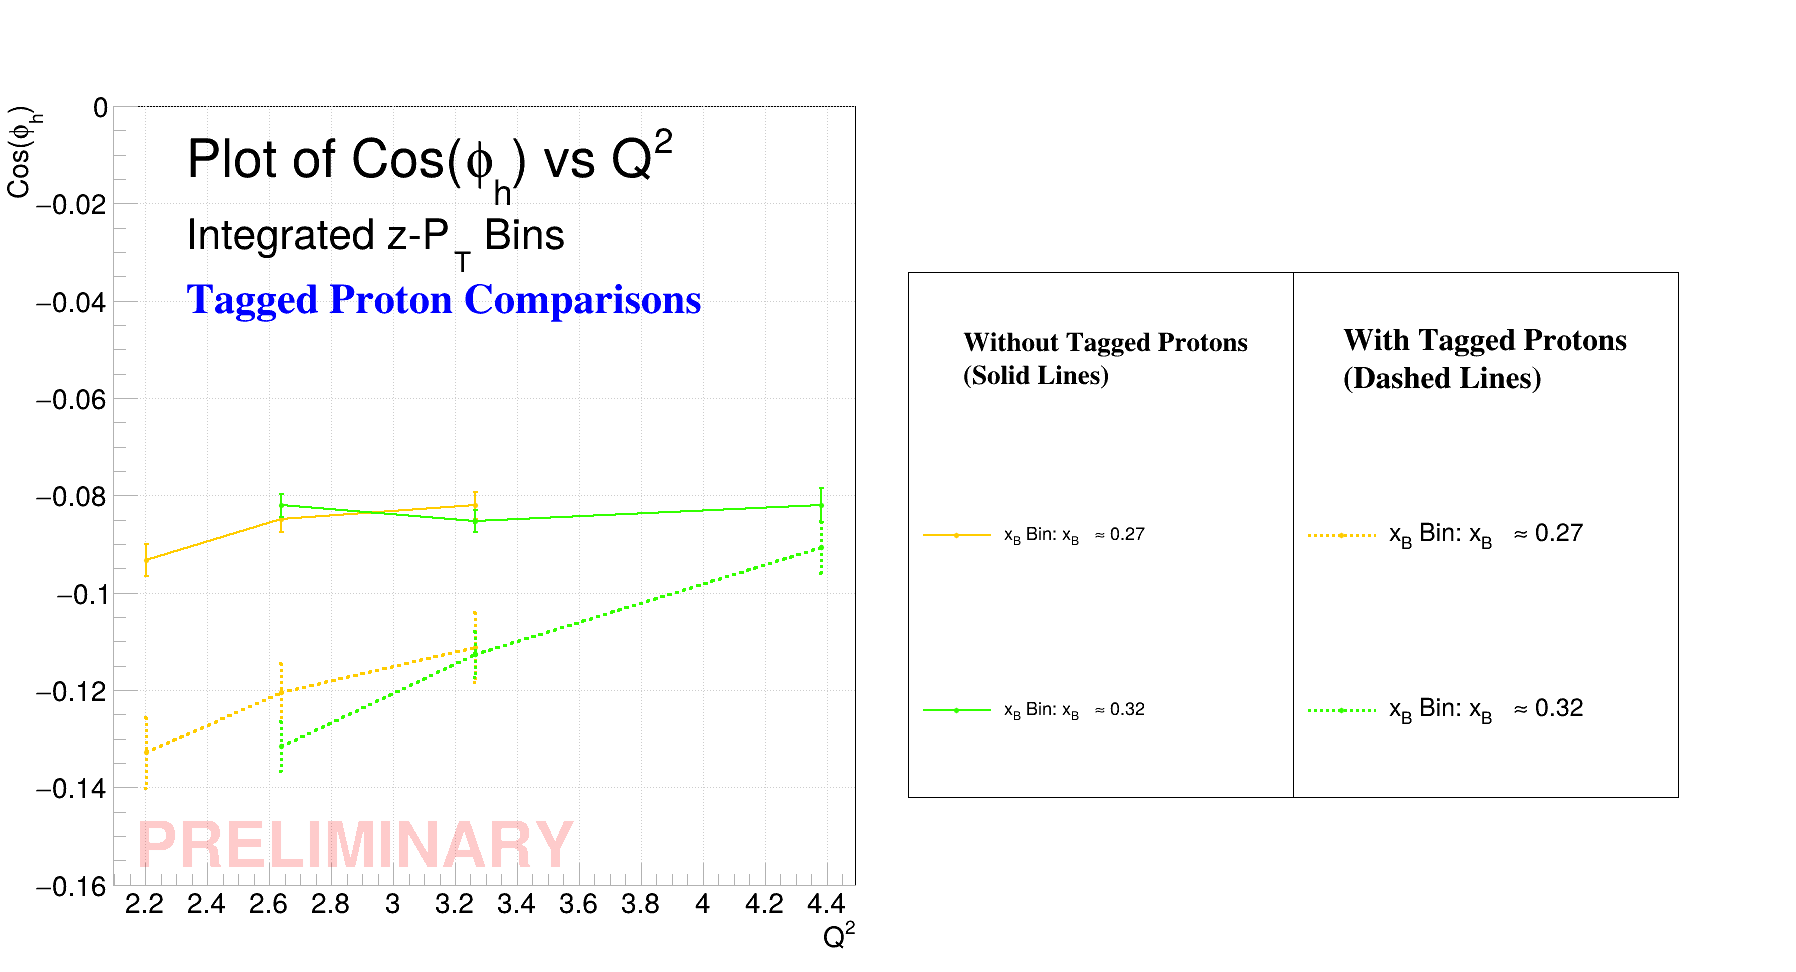

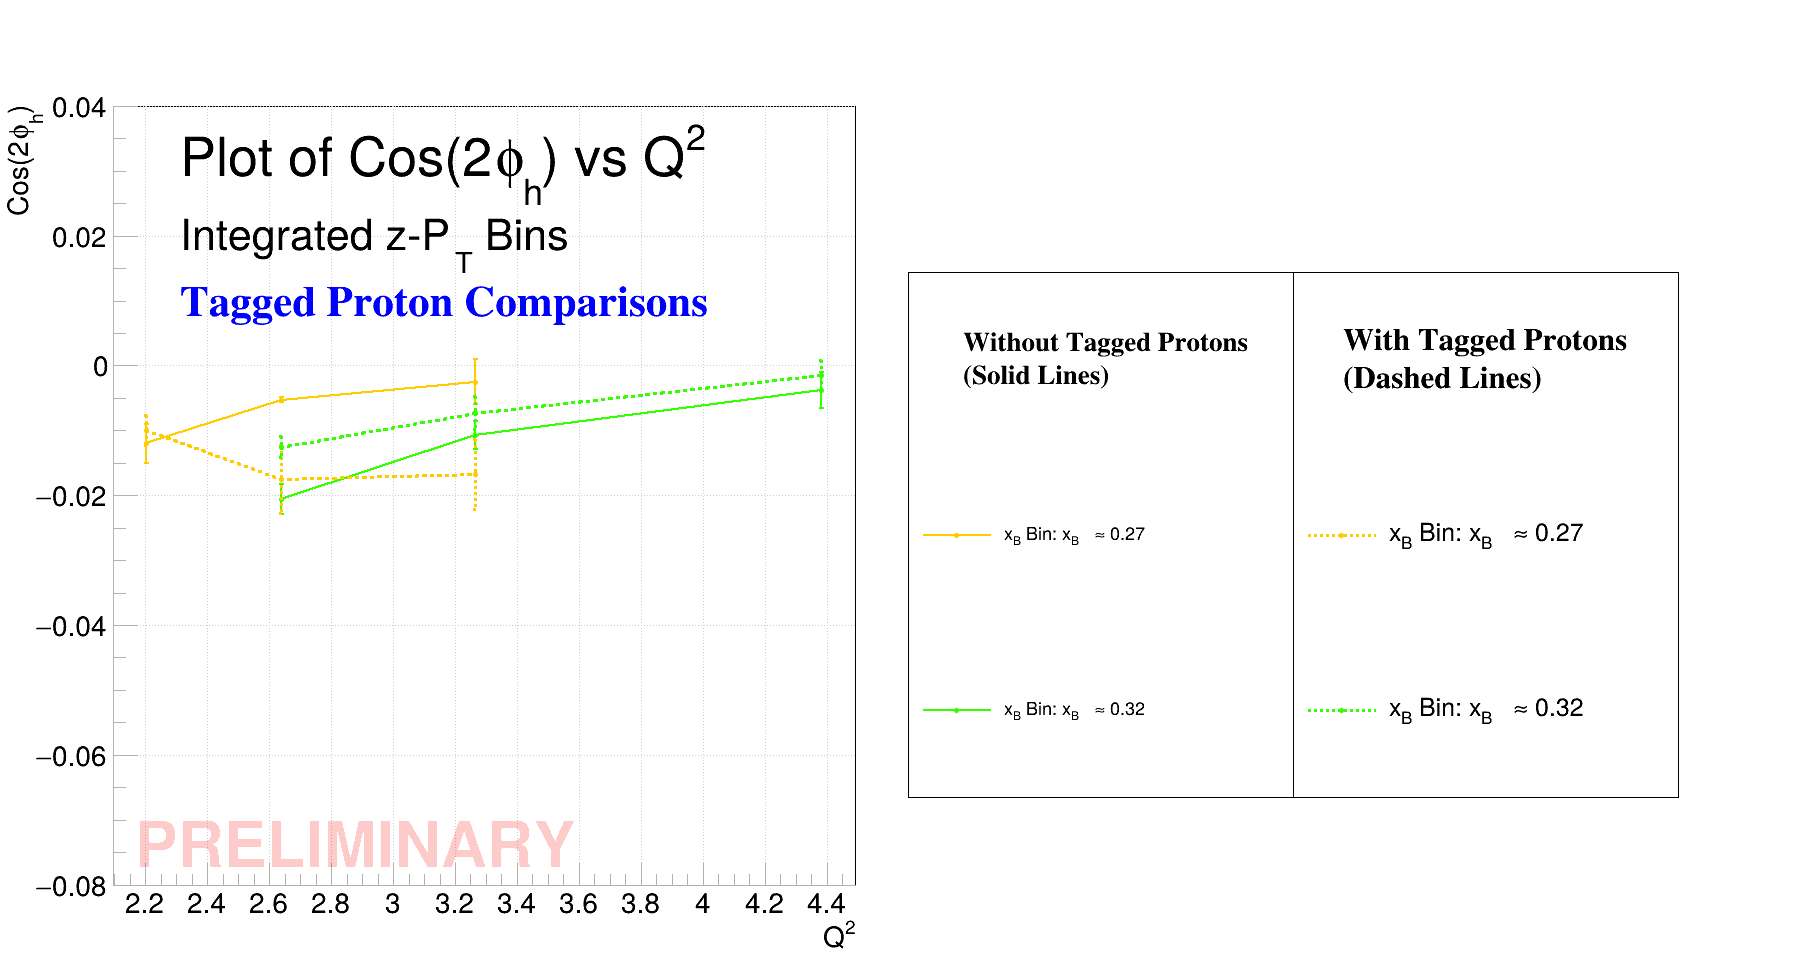

In [57]:
for ii in multi_graph_canvas:
    multi_graph_canvas[ii].Draw()

In [ ]:
# import ROOT

# # Assume 'file_configurations' is a list of tuples (histo, histoTitle)
# file_configurations = [
#     (ROOT.TH1F("histo1", "Histogram 1", 100, -4, 4), "Histogram 1"),
#     (ROOT.TH1F("histo2", "Histogram 2", 100, -4, 4), "Histogram 2"),
#     # (ROOT.TH1F("histo3", "Histogram 3", 100, -4, 4), "Histogram 3"),
#     # Add more histograms as needed...
# ]

# # Fill the histograms with random data for this example
# for histo, _ in file_configurations:
#     histo.FillRandom("gaus", 1000)

# # Create a TCanvas and divide it into two pads
# canvas = ROOT.TCanvas("canvas", "Canvas with Legends", 800, 600)
# canvas.Divide(2, 1)  # Divide the canvas into two horizontal pads

# # Initialize a dictionary to store the legends
# legends = {}

# # Determine the width of each legend based on the number of configurations
# num_configs = len(file_configurations)
# legend_width = 0.95 / num_configs  # Distribute legends evenly across the pad (0.8 is the total NDC width available)

# # Loop over the file configurations to create histograms and legends
# for config_index, (histo, histoTitle) in enumerate(file_configurations):
#     # Draw the histogram in the first pad
#     canvas.cd(1)
#     histo.SetLineColor(config_index + 2)  # Set different colors for each histogram
#     histo.Draw("same")

#     # Calculate legend positions
#     x1 = 0.01 + config_index * legend_width  # Start position for each legend
#     x2 = x1 + legend_width                  # End position for each legend
#     y1 = 0.2                                # Fixed y-coordinate for bottom
#     y2 = 0.8                                # Fixed y-coordinate for top

#     # Create legends with titles
#     legends[config_index] = ROOT.TLegend(x1, y1, x2, y2)  # Set legend coordinates
#     legends[config_index].SetHeader(histoTitle, "C")      # Title with centered alignment
#     legends[config_index].AddEntry(histo, histoTitle, "l")

#     # Draw the legends in the second pad
#     canvas.cd(2)
#     legends[config_index].Draw()

# # Update the canvas
# canvas.Update()

In [ ]:
# canvas.Draw()

.

.

.

In [ ]:
stop

## Making 3D Plots

### Q2/y vs xB/z/pT (Integrated z-pT)

In [ ]:
# Function to convert 3D to 2D coordinates
def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]


Par___Type  = "B"

bin_group = "Q2"

var_x = "Q2"
var_y = "xB"

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

# data_points = Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"]
data_points = data_points_for_plotting[f"{Par___Type}_{bin_group}"]

# Extracting and grouping points by color
grouped_points = {}
for Point_Info, color_ii in data_points:
    z, ez, Q2_y_bin, z_pT_bin = Point_Info
    y, ey = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_y}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_y}")
    x, ex = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_x}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_x}")
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_{bin_group}_Bin_{group_num}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
Legend_Groups[f"{bin_group}_Bin_All"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
Variable_Plot_Ranges = {"Q2": [2, 7], "y": [0.35, 0.75], "z": [0.1, 0.9], "pT":[0, 1.1] , 'xB': [0.1, 0.8], "B": [-0.2, 0.05], "C": [-0.2, 0.15]}
min_x, max_x = Variable_Plot_Ranges[var_x]
min_y, max_y = Variable_Plot_Ranges[var_y]
min_z, max_z = Variable_Plot_Ranges[Par___Type]

Binning_Title = ""
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", str(var_x), " vs ", str(var_y), "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; ", str(var_x), " ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", str(var_y), " ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])
Title = str(str(str(Title).replace("Q2", "Q^{2}")).replace("pT", "P_{T}")).replace("xB", "x_{B}")

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
# #         label = f"({var_x}:{x:.3f}, {var_y}:{y:.3f}, Moment:{z:.3f})"
#         label = f"({var_x}:{x:.2f}, {var_y}:{y:.2f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()

Save_Name = f"Par_{Par___Type}_vs_{var_x}_vs_{var_y}_in_{bin_group}_Groups_for_Integrated_z_pT.pdf"
print(f"Save_Name = {Save_Name}")
if(not True):
    canvas.SaveAs(Save_Name)
else:
    print(f"{color.RED}Did not save{color.END}")


# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

### Q2/y vs xB/z/pT (Individual z-pT)

In [ ]:
Par___Type  = "C"

bin_group = "y"
group_num = 1

var_group = "z"


var_x = "pT"
var_y = "Q2"

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

data_points = data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_{var_group}_Bins"]

# Extracting and grouping points by color
grouped_points = {}
for Point_Info, color_ii in data_points:
    z, ez, Q2_y_bin, z_pT_bin = Point_Info
    y, ey = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_y}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_y}")
    x, ex = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_x}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_x}")
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_{bin_group}_Bin_{group_num}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
# legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].Draw()
Legend_Groups[f"{bin_group}_Bin_{group_num}_{var_group}_Bins"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
min_x, max_x =  0, 1.1 # Q2 range
min_y, max_y =  2, 7   # pT range
min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




y_bin_title = round(0.75 - 0.1*(group_num-1), 2)
Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()



# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

In [ ]:
# stop

.

.

.

## For Q2 Bin Groups

In [ ]:
from array import array
ROOT.gStyle.SetTitleOffset(1.75,'y')

Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
# Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]


Make_xB_Plots = True

latex = {}
Comparison_Output = {}

Q2_bin_group_list = [1, 2, 3, 4, 5]


for Par___Type      in Parameters_to_Compare:
    for Q2_bin_group in Q2_bin_group_list:
        Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"] = []
        for Q2_y_Bin        in Q2_y_Bin_Groups:
            num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
            z_row = 0
            for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                if(z_pT_Bin in [0]):
                    z_pT_Bin = "All"
                else:
                    if((z_pT_Bin-1)%num_pT_cols == 0):
                        z_row += 1
                    try:
                        type(Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    except:
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"] = []
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    continue
                Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                if("ERROR" in [Moment_Value, Moment_Value_Error]):
                    print(f"{color.Error}{Bin___Type}{color.END}")
                    print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                    print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                else:
                    if(z_pT_Bin in ["All", 0, "0"]):
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                    else:
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                
                
# print(f"Comparison_Output = {Comparison_Output}")


y_values = {}
y_errors = {}
x_values = {}
x_errors = {}
n_points = {}
graph    = {}
canvas   = {}
multi_graph = {}
legend   = {}
multi_graph_canvas = {}

for Par___Type in Parameters_to_Compare:
    # Create a TMultiGraph to hold all the graphs for the current Par___Type
    multi_graph[Par___Type] = ROOT.TMultiGraph()
    multi_graph[Par___Type].SetName(Par___Type)
    TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", "y" if(not Make_xB_Plots) else "x_{B}", "}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
    multi_graph[Par___Type].SetTitle(TitleMG)
    legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
    for Q2_bin_group in Q2_bin_group_list:
        color_ii = ROOT.kOrange if(Q2_bin_group in [1]) else ROOT.kSpring if(Q2_bin_group in [2]) else ROOT.kViolet if(Q2_bin_group in [3]) else ROOT.kAzure if(Q2_bin_group in [4]) else ROOT.kPink

        # Separate the data into y_values, y_errors, and x_values
        key = f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"
        y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
        y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
        x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="mean_y"  if(not Make_xB_Plots) else "mean_xB")  for point in Comparison_Output[key]])
        x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="Error_y" if(not Make_xB_Plots) else "Error_xB") for point in Comparison_Output[key]])

        # Create a TGraphErrors object
        n_points[key] = len(Comparison_Output[key])
        graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

        # Customize the graph
        Q2_bin_title = str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][2], return_type="Q2")).replace("Q2", "Q^{2}")
        Binning_Title = "".join(["Q^{2} Bin: ", str(Q2_bin_title), " #topbar Integrated z-P_{T} Bins"])
        Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        graph[key].SetTitle(str(Title))
        graph[key].GetXaxis().SetTitle("".join(["y " if(not Make_xB_Plots) else "x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        graph[key].SetMarkerStyle(8)
        graph[key].SetMarkerSize(0.5)
        graph[key].SetLineWidth(2)
        graph[key].SetLineColor(color_ii)
        graph[key].SetMarkerColor(color_ii)

        # Add the graph to the TMultiGraph
        multi_graph[Par___Type].Add(graph[key])
        legend[Par___Type].AddEntry(graph[key], "".join(["Q^{2} Bin: ", str(Q2_bin_title)]), "lp")

        # Create a canvas and draw the individual graph
        canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
        Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        graph[key].Draw("APL")
        graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
#         canvas[key].Draw()

    # Create a canvas for the TMultiGraph for the current Par___Type
    multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
    Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
    multi_graph[Par___Type].Draw("APL")
    multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
    multi_graph[Par___Type].GetXaxis().SetTitle("".join(["y " if(not Make_xB_Plots) else "x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
    multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
    legend[Par___Type].Draw()
    
    latex[Par___Type] = ROOT.TLatex()
    latex[Par___Type].SetTextSize(0.08)
    latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
    latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

    # Customize the combined plot (set title, axis labels, etc.)
    multi_graph_canvas[Par___Type].Update()
    multi_graph_canvas[Par___Type].Draw()
    save_name = "".join(["Fit_Par_", str(Par___Type), "_METHOD_SMEAR_phi_t_VS_", "y" if(not Make_xB_Plots) else "xB", ".pdf"])  
    save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
    save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
    
    # Saving Plots
    if(not True):
        print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
        multi_graph_canvas[Par___Type].SaveAs(save_name)
    else:
        print(f"Not Saving: {save_name}")
        

        



print("\nDONE")

.

.

## For y Bin Groups:

In [ ]:
from array import array
ROOT.gStyle.SetTitleOffset(1.75,'y')

Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
# Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]


Make_xB_Plots =  True

latex = {}
Comparison_Output = {}

y_bin_group_list = [1, 2, 3, 4]

# for Q2_y_Bin               in range(1, 18):
#     for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
# for Q2_y_Bin               in range(1, 4):
for Par___Type      in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}"] = []
        if(Make_xB_Plots):
            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"] = []
        for Q2_y_Bin        in Q2_y_Bin_Groups:
            num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
            z_row = 0
            # for z_pT_Bin    in range(0, 1):
            for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                if(z_pT_Bin in [0]):
                    z_pT_Bin = "All"
                else:
                    if((z_pT_Bin-1)%num_pT_cols == 0):
                        z_row += 1
                    try:
                        type(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    except:
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"] = []
                    if(Make_xB_Plots):
                        try:
                            type(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"])
                        except:
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"] = []
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    continue
                Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                if("ERROR" in [Moment_Value, Moment_Value_Error]):
                    print(f"{color.Error}{Bin___Type}{color.END}")
                    print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                    print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                else:
                    if(z_pT_Bin in ["All", 0, "0"]):
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}"].append([float(Moment_Value),                                                                      float(Moment_Value_Error), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_pT"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_pT")])
                    else:
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([float(Moment_Value),                                    float(Moment_Value_Error), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_pT"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_pT")])
                    if(Make_xB_Plots):
                        if(z_pT_Bin in ["All", 0, "0"]):
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                        else:
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                
                
# print(f"Comparison_Output = {Comparison_Output}")


y_values = {}
y_errors = {}
x_values = {}
x_errors = {}
n_points = {}
graph    = {}
canvas   = {}
multi_graph = {}
legend   = {}
multi_graph_canvas = {}

for Par___Type in Parameters_to_Compare:
    # Create a TMultiGraph to hold all the graphs for the current Par___Type
    multi_graph[Par___Type] = ROOT.TMultiGraph()
    multi_graph[Par___Type].SetName(Par___Type)
    TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2}}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
    multi_graph[Par___Type].SetTitle(TitleMG)
    legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
    for y_bin_group in y_bin_group_list:
        color_ii = ROOT.kSpring if(y_bin_group in [1]) else ROOT.kViolet if(y_bin_group in [2]) else ROOT.kAzure if(y_bin_group in [3]) else ROOT.kPink

        # Separate the data into y_values, y_errors, and x_values
        key = f"Par_{Par___Type}_Y_Bin_{y_bin_group}"
        y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
        y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
        x_values[key] = array('d', [point[2] for point in Comparison_Output[key]])
        x_errors[key] = array('d', [point[3] for point in Comparison_Output[key]])

        # Create a TGraphErrors object
        n_points[key] = len(Comparison_Output[key])
        graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

        # Customize the graph
        y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
        Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title), " #topbar Integrated z-P_{T} Bins"])
        Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        graph[key].SetTitle(str(Title))
        graph[key].GetXaxis().SetTitle("".join(["Q^{2} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        graph[key].SetMarkerStyle(8)
        graph[key].SetMarkerSize(0.5)
        graph[key].SetLineWidth(2)
        graph[key].SetLineColor(color_ii)
        graph[key].SetMarkerColor(color_ii)

        # Add the graph to the TMultiGraph
        multi_graph[Par___Type].Add(graph[key])
        legend[Par___Type].AddEntry(graph[key], "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)]), "lp")

        # Create a canvas and draw the individual graph
        canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
        Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        graph[key].Draw("APL")
        graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
#         canvas[key].Draw()

    # Create a canvas for the TMultiGraph for the current Par___Type
    multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
    Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
    multi_graph[Par___Type].Draw("APL")
    multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
    multi_graph[Par___Type].GetXaxis().SetTitle("".join(["Q^{2} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
    multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
    legend[Par___Type].Draw()
    
    latex[Par___Type] = ROOT.TLatex()
    latex[Par___Type].SetTextSize(0.08)
    latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
    latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

    # Customize the combined plot (set title, axis labels, etc.)
    multi_graph_canvas[Par___Type].Update()
    multi_graph_canvas[Par___Type].Draw()
    save_name = f"Fit_Par_{Par___Type}_METHOD_SMEAR_phi_t_VS_Q2.pdf"
    save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
    save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
    
    
    # Saving the Moments vs Q2 Plots
    if(not True):
        print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
        multi_graph_canvas[Par___Type].SaveAs(save_name)
    else:
        print(f"Not Saving: {save_name}")
        
        
    if(Make_xB_Plots):
        # Create a TMultiGraph to hold all the graphs for the current Par___Type
        multi_graph[f"xB_{Par___Type}"] = ROOT.TMultiGraph()
        multi_graph[f"xB_{Par___Type}"].SetName(f"xB_{Par___Type}")
        TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs x_{B}}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        multi_graph[f"xB_{Par___Type}"].SetTitle(TitleMG)
        legend[f"xB_{Par___Type}"] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
        for y_bin_group in y_bin_group_list:
            color_ii = ROOT.kSpring if(y_bin_group in [1]) else ROOT.kViolet if(y_bin_group in [2]) else ROOT.kAzure if(y_bin_group in [3]) else ROOT.kPink

            # Separate the data into y_values, y_errors, and x_values
            key = f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"
            
            # print(f"\n\n\nComparison_Output[{key}] = ", Comparison_Output[key])
            y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
            y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
            x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="mean_xB")  for point in Comparison_Output[key]])
            x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="Error_xB") for point in Comparison_Output[key]])

            # Create a TGraphErrors object
            n_points[key] = len(Comparison_Output[key])
            graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

            # Customize the graph
            y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
            Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title), " #topbar Integrated z-P_{T} Bins"])
            Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
            graph[key].SetTitle(str(Title))
            graph[key].GetXaxis().SetTitle("".join(["x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
            graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
            graph[key].SetMarkerStyle(8)
            graph[key].SetMarkerSize(0.5)
            graph[key].SetLineWidth(2)
            graph[key].SetLineColor(color_ii)
            graph[key].SetMarkerColor(color_ii)

            # Add the graph to the TMultiGraph
            multi_graph[f"xB_{Par___Type}"].Add(graph[key])
            legend[f"xB_{Par___Type}"].AddEntry(graph[key], "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)]), "lp")

            # Create a canvas and draw the individual graph
            canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
            Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
            graph[key].Draw("APL")
            graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
            # canvas[key].Draw()

        # Create a canvas for the TMultiGraph for the current Par___Type
        multi_graph_canvas[f"xB_{Par___Type}"] = Canvas_Create(Name=f"Combined_xB_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
        Draw_Canvas(canvas=multi_graph_canvas[f"xB_{Par___Type}"], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        multi_graph[f"xB_{Par___Type}"].Draw("APL")
        multi_graph[f"xB_{Par___Type}"].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
        multi_graph[f"xB_{Par___Type}"].GetXaxis().SetTitle("".join(["x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        multi_graph[f"xB_{Par___Type}"].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        legend[f"xB_{Par___Type}"].Draw()

        latex[f"xB_{Par___Type}"] = ROOT.TLatex()
        latex[f"xB_{Par___Type}"].SetTextSize(0.08)
        latex[f"xB_{Par___Type}"].SetTextColorAlpha(ROOT.kRed, 0.2)
        latex[f"xB_{Par___Type}"].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

        # Customize the combined plot (set title, axis labels, etc.)
        multi_graph_canvas[f"xB_{Par___Type}"].Update()
        multi_graph_canvas[f"xB_{Par___Type}"].Draw()
        save_name = f"Fit_Par_{Par___Type}_METHOD_SMEAR_phi_t_VS_xB.pdf"
        save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
        save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")


        # Saving the Moments vs xB Plots
        if(not True):
            print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
            multi_graph_canvas[f"xB_{Par___Type}"].SaveAs(save_name)
        else:
            print(f"Not Saving: {save_name}")
        
    
    




print("\nDONE")

In [ ]:
# for ii in Comparison_Output:
#     print(ii)

In [ ]:
# for ii in Comparison_Output:
#     if(("z_Bin_1" in ii) or ("z_Bin_2" in ii)):
#         print(ii)
#         print(f"\t{len(Comparison_Output[ii])}")
#         for jj in Comparison_Output[ii]:
#             print(f"\t{jj}")
data_points_temp = {}
for Par___Type in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
        if(y_bin_group != 1):
            break
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        color_count = 1
        data_points_temp[Par___Type] = []
        for Q2_y_Bin in Q2_y_Bin_Groups:
            if(Q2_y_Bin not in [1, 5]):
                break
            color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
            color_count += 1
            for z_row in range(1, 2):
                # data_points_temp[Par___Type] = []
                try:
                    # length = len(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    # print(f"Par_{Par___Type}_Y_Bin_{y_bin_group}_z_Bin_{z_row} --> {length}")
                    for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
                        jj = ii.copy()
                        jj.append(color_ii+z_row+1)
                        data_points_temp[Par___Type].append(jj)
                except:
                    print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                    break

                
print(data_points_temp[Par___Type])

print("\nDone\n")

In [ ]:
# import ROOT


# # Maximum number of rows per column
# max_rows_per_column = 10
# current_row = 0
# current_column = 1

# legend = {}

# # Dummy objects to add to the legend
# dummy_objects = {}

# data_points_temp = {}
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if(y_bin_group != 1):
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []
#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(1)  # Start with 1 column
#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             if(Q2_y_Bin not in [1, 5, 9, 13]):
#                 break
#             color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)
                        
#                         # Add entry to legend
#                         if(current_row >= max_rows_per_column):
#                             current_row = 0
#                             current_column += 1
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(current_column)

#                         # Create dummy TGraph if it doesn't exist for this color
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)
                            
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                             current_row += 1
#                 except:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT


# # Maximum number of rows per column
# max_rows_per_column = 6
# current_row = 0
# current_column = 1

# legend = {}

# # Dummy objects to add to the legend
# dummy_objects = {}

# data_points_temp = {}
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if(y_bin_group != 1):
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []
#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(1)  # Start with 1 column
#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)
                        
#                         # Add entry to legend
#                         if(current_row >= max_rows_per_column):
#                             current_row = 0
#                             current_column += 1
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(current_column)

#                         # Create dummy TGraph if it doesn't exist for this color
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)
                            
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                             current_row += 1
#                 except:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT

# # Function to create a new TLegend
# def create_legend(x1, y1, x2, y2):
#     legend = ROOT.TLegend(x1, y1, x2, y2)
#     legend.SetNColumns(1)  # Start with 1 column
#     return legend

# # Initialize variables
# legend = {}
# dummy_objects = {}
# data_points_temp = {}

# # Loop through parameters to compare
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if y_bin_group != 1:
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []

#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = create_legend(0.1, 0.7, 0.9, 0.9)

#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             color_ii = ROOT.kOrange if color_count == 1 else ROOT.kSpring if color_count == 2 else ROOT.kViolet if color_count == 3 else ROOT.kAzure if color_count == 4 else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)

#                         # Add entry to legend if the color changes
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             # Create dummy TGraph if it doesn't exist for this color
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)

#                             # Add the entry to the legend
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                 except KeyError:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

#         # Dynamically set the number of columns based on the number of unique Q2_y_Bin values
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(len(Q2_y_Bin_Groups))

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# Function to create a new TLegend
def create_legend(x1, y1, x2, y2, nColumns=1):
    legend = ROOT.TLegend(x1, y1, x2, y2)
    legend.SetNColumns(nColumns)  # Start with 1 column
    legend.SetHeader("#scale[1.5]{Q^{2}-y Bin and z Bin (Range) Information}", "C") # option "C" allows to center the header
    return legend

# Initialize variables
legend = {}
dummy_objects = {}
data_points_temp = {}
max_rows_per_column = 6  # Set the max number of rows per column

# Loop through parameters to compare
for Par___Type in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
#         del dummy_objects
#         dummy_objects = {}
        if(y_bin_group != 1):
            continue
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        color_count = 1
        data_points_temp[f"{Par___Type}_{y_bin_group}"] = []

        # Create the TLegend
        try:
            legend[f"y_bin_group_{y_bin_group}"]
        except:
            legend[f"y_bin_group_{y_bin_group}"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column)
        # legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column)
        for Q2_y_Bin in Q2_y_Bin_Groups:
#             if(Q2_y_Bin not in [1]):
#                 break
            color_ii = ROOT.kOrange if(color_count == 1) else ROOT.kSpring if(color_count == 2) else ROOT.kViolet if(color_count == 3) else ROOT.kAzure if(color_count == 4) else ROOT.kPink
            color_count += 1
            for z_row in range(1, max_rows_per_column + 1):
                try:
                    for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
                        jj = ii.copy()
                        jj.append(color_ii + z_row + 1)
                        data_points_temp[f"{Par___Type}_{y_bin_group}"].append(jj)

                        # Add entry to legend if the color changes
                        if((color_ii + z_row + 1) not in dummy_objects):
                            # Create dummy TGraph if it doesn't exist for this color
                            dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
                            dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
                            dummy_objects[color_ii + z_row + 1].SetLineColor(color_ii + z_row + 1)
                            dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)

                            # print(str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")))
                            # Add the entry to the legend
                            Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")), "}}"])
                            # legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], Legend_title, "PL")
                            legend[f"y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], Legend_title, "PL")
                except:
                    # print(f"{color.RED}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                    # Fill the rest of the row with blank entries
                    if(z_row not in dummy_objects):
                        dummy_objects[z_row] = ROOT.TGraph()
                        dummy_objects[z_row].SetMarkerColor(0)  # Invisible color
#                     legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[z_row], "", "P")
                    legend[f"y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[z_row], "", "P")

# Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()
print("\nDone\n")

# del legend

In [ ]:
z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color and errors
# data_points = [
#     [10, 1, 0.2, 0.1, 0.1, 0.1, ROOT.kRed], [12, 1.5, 0.4, 0.1, 0.1, 0.1, ROOT.kRed], [14, 2, 0.6, 0.1, 0.1, 0.1, ROOT.kRed],
#     [15, 2, 1.2, 0.1, 0.1, 0.1, ROOT.kBlue], [17, 2.5, 1.4, 0.1, 0.1, 0.1, ROOT.kBlue], [19, 3, 1.6, 0.1, 0.1, 0.1, ROOT.kBlue],
#     [20, 3, 0.8, 0.1, 0.1, 0.1, ROOT.kGreen], [22, 3.5, 1.0, 0.1, 0.1, 0.1, ROOT.kGreen], [24, 4, 1.2, 0.1, 0.1, 0.1, ROOT.kGreen],
#     [25, 4, 1.5, 0.1, 0.1, 0.1, ROOT.kYellow], [27, 4.5, 1.7, 0.1, 0.1, 0.1, ROOT.kYellow], [29, 5, 1.9, 0.1, 0.1, 0.1, ROOT.kYellow],
#     [30, 5, 2.0, 0.1, 0.1, 0.1, ROOT.kMagenta], [32, 5.5, 2.2, 0.1, 0.1, 0.1, ROOT.kMagenta], [34, 6, 2.4, 0.1, 0.1, 0.1, ROOT.kMagenta]
# ]

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, x, ex, y, ey, color_ii in data_points:
#     if(color_ii not in grouped_points):
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0 text")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []

# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     n_points = len(x_vals)
#     x_values = array('d',  x_vals)
#     y_values = array('d',  y_vals)
#     z_values = array('d',  z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)

#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME text")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for i in range(n_points):
#         polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

# # Add grid lines in the x-y plane
# x_min, x_max = min([p[1] for p in data_points]), max([p[1] for p in data_points])
# y_min, y_max = min([p[0] for p in data_points]), max([p[0] for p in data_points])
# grid_lines = 10  # Number of grid lines

# # Draw vertical grid lines
# for i in range(grid_lines + 1):
#     x = x_min + (x_max - x_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x, y_min, 0)
#     line.SetPoint(1, x, y_max, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")
    
# # Draw horizontal grid lines
# for i in range(grid_lines + 1):
#     y = y_min + (y_max - y_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x_min, y, 0)
#     line.SetPoint(1, x_max, y, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()


In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color and errors
# data_points = [
#     [0.2, 0.1, 10, 1, 0.1, 0.1, ROOT.kRed], [0.4, 0.1, 12, 1.5, 0.1, 0.1, ROOT.kRed], [0.6, 0.1, 14, 2, 0.1, 0.1, ROOT.kRed],
#     [1.2, 0.1, 15, 2, 0.1, 0.1, ROOT.kBlue], [1.4, 0.1, 17, 2.5, 0.1, 0.1, ROOT.kBlue], [1.6, 0.1, 19, 3, 0.1, 0.1, ROOT.kBlue],
#     [0.8, 0.1, 20, 3, 0.1, 0.1, ROOT.kGreen], [1.0, 0.1, 22, 3.5, 0.1, 0.1, ROOT.kGreen], [1.2, 0.1, 24, 4, 0.1, 0.1, ROOT.kGreen],
#     [1.5, 0.1, 25, 4, 0.1, 0.1, ROOT.kYellow], [1.7, 0.1, 27, 4.5, 0.1, 0.1, ROOT.kYellow], [1.9, 0.1, 29, 5, 0.1, 0.1, ROOT.kYellow],
#     [2.0, 0.1, 30, 5, 0.1, 0.1, ROOT.kMagenta], [2.2, 0.1, 32, 5.5, 0.1, 0.1, ROOT.kMagenta], [2.4, 0.1, 34, 6, 0.1, 0.1, ROOT.kMagenta]
# ]

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, y, ey, x, ex, color_ii in data_points:
#     if color_ii not in grouped_points:
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Function to convert 3D to 2D coordinates
# def convert_3d_to_2d(view, x, y, z):
#     pw = array('d', [x, y, z])
#     pn = array('d', [0.0, 0.0, 0.0])
#     view.WCtoNDC(pw, pn)
#     return pn[0], pn[1]

# # Set axis ranges
# graph3d.GetXaxis().SetLimits(0,    10)  # X-axis range
# graph3d.GetYaxis().SetRangeUser(0, 40)  # Y-axis range
# graph3d.GetZaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)  # Z-axis range

# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []
# text_all = {}
# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     n_points = len(x_vals)
#     x_values = array('d', x_vals)
#     y_values = array('d', y_vals)
#     z_values = array('d', z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)

#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for i in range(n_points):
#         polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#         # Convert 3D coordinates to 2D
#         winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.02)
# #         text_all[label].Draw()

# # Add grid lines in the x-y plane
# x_min, x_max = min([p[4] for p in data_points]), max([p[4] for p in data_points])
# y_min, y_max = min([p[2] for p in data_points]), max([p[2] for p in data_points])
# grid_lines = 10  # Number of grid lines

# # Draw vertical grid lines
# for i in range(grid_lines + 1):
#     x = x_min + (x_max - x_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x, y_min, 0)
#     line.SetPoint(1, x, y_max, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")
    
# # Draw horizontal grid lines
# for i in range(grid_lines + 1):
#     y = y_min + (y_max - y_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x_min, y, 0)
#     line.SetPoint(1, x_max, y, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")

    
    
# canvas.Update()

# # Set axis ranges
# graph3d.GetXaxis().SetRangeUser(0, 1.1)  # X-axis range
# graph3d.GetYaxis().SetRangeUser(2, 7)  # Y-axis range
# graph3d.GetZaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)  # Z-axis range

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT
# from array import array


# # Function to convert 3D to 2D coordinates
# def convert_3d_to_2d(view, x, y, z):
#     pw = array('d', [x, y, z])
#     pn = array('d', [0.0, 0.0, 0.0])
#     view.WCtoNDC(pw, pn)
#     return pn[0], pn[1]


# # def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, y, ey, x, ex, color_ii in data_points:
#     if color_ii not in grouped_points:
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)



# # Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)



# # Create an empty histogram with the desired axis ranges
# min_x, max_x =  0, 1.1 # Q2 range
# min_y, max_y =  2, 7   # pT range
# min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




# y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
# Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
# Binning_Title = "Test"
# Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
# Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
# Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
# Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

# hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
# hist.Draw("BOX")


# # Update the pad to ensure the TView object is created
# ROOT.gPad.Update()

# # Retrieve the TView object
# view = ROOT.gPad.GetView()
# if(not view):
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # # Set the view angles using RotateView
# # theta = 30  # Angle for rotation around the x-axis
# # phi = 30    # Angle for rotation around the y-axis
# # view.RotateView(theta, phi)

# # Update the canvas to reflect the changes
# canvas.Modified()
# canvas.Update()





# # # Create a legend
# # legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# # legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []
# text_all = {}
# # added_colors = set()

# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
# #     if(color_ii not in added_colors):
# #         dummy_graph = ROOT.TGraph()
# #         dummy_graph.SetMarkerColor(color_ii)
# #         dummy_graph.SetMarkerStyle(20)
# #         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
# #         added_colors.add(color_ii)

#     n_points  = len(x_vals)
#     x_values  = array('d', x_vals)
#     y_values  = array('d', y_vals)
#     z_values  = array('d', z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)



#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for ii in range(n_points):
#         polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)



#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#         # Convert 3D coordinates to 2D
#         winx, winy = convert_3d_to_2d(view, x, y, z)

# #         # Add text labels with coordinates
# #         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
# #         text_all[label] = ROOT.TText(winx, winy, label)
# #         text_all[label].SetTextSize(0.01)
# #         text_all[label].Draw()


# # grid_lines = 10  # Number of grid lines

# # # Draw vertical grid lines
# # for ii in range(grid_lines + 1):
# #     x = min_x + (max_x - min_x) / grid_lines * ii
# #     line = ROOT.TPolyLine3D(2)
# #     line.SetPoint(0, x, min_y, min_z)
# #     line.SetPoint(1, x, max_y, min_z)
# #     line.SetLineColor(17)
# #     line.SetLineStyle(3)
# #     line.Draw("SAME")

# # # Draw horizontal grid lines
# # for ii in range(grid_lines + 1):
# #     y = min_y + (max_y - min_y) / grid_lines * ii
# #     line = ROOT.TPolyLine3D(2)
# #     line.SetPoint(0, min_x, y, min_z)
# #     line.SetPoint(1, max_x, y, min_z)
# #     line.SetLineColor(17)
# #     line.SetLineStyle(3)
# #     line.Draw("SAME")


# # # Draw the legend
# # legend.Draw()

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()



# # return canvas
    
# # print("Done")

# # canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# # canvas_out.Draw()

In [ ]:
# stop

In [ ]:
import ROOT
from array import array


# Function to convert 3D to 2D coordinates
def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]


Par___Type  = "C"
y_bin_group = 1

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

data_points = data_points_temp[f"{Par___Type}_{y_bin_group}"]

# Extracting and grouping points by color
grouped_points = {}
for z, ez, y, ey, x, ex, color_ii in data_points:
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
# legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].Draw()
legend[f"y_bin_group_{y_bin_group}"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
min_x, max_x =  0, 1.1 # Q2 range
min_y, max_y =  2, 7   # pT range
min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# Create/Draw the TGraph2D on top of the histogram
graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()



# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

In [ ]:
print(Get_Bin_Center_Function(Q2_y_Bin=16, z_pT_Bin=25, Variable="All"))
print(z_pT_bin_values_New(Q2_Y_Bin_Num=16, Bin=5, return_type="z"))

In [ ]:
# stop

In [ ]:
import ROOT
from array import array

def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]

def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):
    # Extracting and grouping points by color
    grouped_points = {}
    for z, ez, y, ey, x, ex, color_ii in data_points:
        if color_ii not in grouped_points:
            grouped_points[color_ii] = ([], [], [], [], [], [])
        grouped_points[color_ii][0].append(x)
        grouped_points[color_ii][1].append(y)
        grouped_points[color_ii][2].append(z)
        grouped_points[color_ii][3].append(ex)
        grouped_points[color_ii][4].append(ey)
        grouped_points[color_ii][5].append(ez)

    # Create a canvas
    canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)

    # Create an empty histogram with the desired axis ranges
    min_x, max_x = 0, 1.1  # Q2 range
    min_y, max_y = 2, 7    # pT range
    min_z, max_z = -0.9 if str(Par___Type) in ["B"] else -0.35, 0.2 if str(Par___Type) in ["B"] else 0.25

    y_bin_title = round(0.75 - 0.1 * (y_bin_group - 1), 2)
    Binning_Title = "".join(["y Bin: ", str(round(y_bin_title - 0.1, 2)), " < y < ", str(y_bin_title)])
    Title = "".join([
        "#splitline{#splitline{#scale[1.25]{Plot of ",
        "Cos(#phi_{h})" if Par___Type in ["B"] else "Cos(2#phi_{h})",
        " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{",
        "{#color[4]{Method: ", str(Fit___Type), "}}}"
    ])
    Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if Smear_Type not in [""] else ""])
    Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if Smear_Type not in [""] else ""])
    Title = "".join([str(Title), "; ", "Cos(#phi_{h})" if Par___Type in ["B"] else "Cos(2#phi_{h})"])

    hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
    hist.Draw("BOX")

    # Initialize TView to ensure proper 3D drawing
    view = ROOT.TView.CreateView(1)
    view.SetRange(min_x, min_y, min_z, max_x, max_y, max_z)
    ROOT.gPad.SetView(view)
    ROOT.gPad.Update()

    # Set the view angles using RotateView
    theta = 60  # Angle for rotation around the x-axis
    phi = 30    # Angle for rotation around the y-axis
    view.RotateView(theta, phi)

    # Create a legend
    legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
    legend.SetHeader("Legend", "C")

    # Create/Draw the TGraph2D on top of the histogram
    graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
    graph3d.Draw("P0 SAME")

    # Draw points, lines, and error bars
    poly_markers = []
    poly_lines = []
    text_all = {}
    added_colors = set()

    for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
        if color_ii not in added_colors:
            dummy_graph = ROOT.TGraph()
            dummy_graph.SetMarkerColor(color_ii)
            dummy_graph.SetMarkerStyle(20)
            legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
            added_colors.add(color_ii)

        n_points = len(x_vals)
        x_values = array('d', x_vals)
        y_values = array('d', y_vals)
        z_values = array('d', z_vals)
        ex_values = array('d', ex_vals)
        ey_values = array('d', ey_vals)
        ez_values = array('d', ez_vals)

        # Create and draw TGraph2DErrors
        graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
        graph3d_err.SetMarkerColor(color_ii)
        graph3d_err.SetMarkerStyle(20)
        graph3d_err.SetMarkerSize(1.5)
        graph3d_err.Draw("P SAME")

        # Draw lines
        polyline = ROOT.TPolyLine3D(n_points)
        for ii in range(n_points):
            polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
        polyline.SetLineColor(color_ii)
        polyline.SetLineWidth(2)
        polyline.Draw("SAME")
        poly_lines.append(polyline)

        # Draw points separately to ensure they are on top of the lines
        for x, y, z in zip(x_vals, y_vals, z_vals):
            pm3d = ROOT.TPolyMarker3D(1)
            pm3d.SetPoint(0, x, y, z)
            pm3d.SetMarkerColor(color_ii)
            pm3d.SetMarkerStyle(20)
            pm3d.SetMarkerSize(1.5)
            pm3d.Draw("SAME P")
            poly_markers.append(pm3d)

            # Convert 3D coordinates to 2D
            winx, winy = convert_3d_to_2d(view, x, y, z)

            # Add text labels with coordinates
            label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
            text_all[label] = ROOT.TText(winx, winy, label)
            text_all[label].SetTextSize(0.01)
            text_all[label].Draw()

    grid_lines = 10  # Number of grid lines

    # Draw vertical grid lines
    for ii in range(grid_lines + 1):
        x = min_x + (max_x - min_x) / grid_lines * ii
        line = ROOT.TPolyLine3D(2)
        line.SetPoint(0, x, min_y, min_z)
        line.SetPoint(1, x, max_y, min_z)
        line.SetLineColor(17)
        line.SetLineStyle(3)
        line.Draw("SAME")

    # Draw horizontal grid lines
    for ii in range(grid_lines + 1):
        y = min_y + (max_y - min_y) / grid_lines * ii
        line = ROOT.TPolyLine3D(2)
        line.SetPoint(0, min_x, y, min_z)
        line.SetPoint(1, max_x, y, min_z)
        line.SetLineColor(17)
        line.SetLineStyle(3)
        line.Draw("SAME")

    # Draw the legend
    legend.Draw()

    # Update the canvas to display all elements
    canvas.Modified()
    canvas.Update()

    return [canvas, hist, graph3d]
#     return [canvas, hist, legend, graph3d]


# canvas_out, hist_out, legend_out, graph3d_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
canvas_out, hist_out, graph3d_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="C", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
canvas_out.Draw()

print("Done")

In [ ]:
import ROOT
from array import array

# Example data for 3D plot with multiple points for each color and errors
data_points = [
    [10, 1, 0.2, 0.1, 0.1, 0.1, ROOT.kRed], [12, 1.5, 0.4, 0.1, 0.1, 0.1, ROOT.kRed], [14, 2, 0.6, 0.1, 0.1, 0.1, ROOT.kRed],
    [15, 2, 1.2, 0.1, 0.1, 0.1, ROOT.kBlue], [17, 2.5, 1.4, 0.1, 0.1, 0.1, ROOT.kBlue], [19, 3, 1.6, 0.1, 0.1, 0.1, ROOT.kBlue],
    [20, 3, 0.8, 0.1, 0.1, 0.1, ROOT.kGreen], [22, 3.5, 1.0, 0.1, 0.1, 0.1, ROOT.kGreen], [24, 4, 1.2, 0.1, 0.1, 0.1, ROOT.kGreen],
    [25, 4, 1.5, 0.1, 0.1, 0.1, ROOT.kYellow], [27, 4.5, 1.7, 0.1, 0.1, 0.1, ROOT.kYellow], [29, 5, 1.9, 0.1, 0.1, 0.1, ROOT.kYellow],
    [30, 5, 2.0, 0.1, 0.1, 0.1, ROOT.kMagenta], [32, 5.5, 2.2, 0.1, 0.1, 0.1, ROOT.kMagenta], [34, 6, 2.4, 0.1, 0.1, 0.1, ROOT.kMagenta]
]

# Extracting and grouping points by color
grouped_points = {}
for y, x, z, ex, ey, ez, color_ii in data_points:
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)

# Create a canvas and draw a base graph to set up the 3D view
canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
graph3d.Draw("P0")

# Initialize TView to ensure proper 3D drawing
ROOT.gPad.Update()
view = ROOT.gPad.GetView()
if not view:
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Draw points, lines, and error bars
poly_markers = []
poly_lines = []

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
    n_points = len(x_vals)
    x_values = array('d', x_vals)
    y_values = array('d', y_vals)
    z_values = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)

    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for i in range(n_points):
        polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)

    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

# Add grid lines in the x-y plane
x_min, x_max = min([p[1] for p in data_points]), max([p[1] for p in data_points])
y_min, y_max = min([p[0] for p in data_points]), max([p[0] for p in data_points])
grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for i in range(grid_lines + 1):
    x = x_min + (x_max - x_min) / grid_lines * i
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, y_min, 0)
    line.SetPoint(1, x, y_max, 0)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")
    
# Draw horizontal grid lines
for i in range(grid_lines + 1):
    y = y_min + (y_max - y_min) / grid_lines * i
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x_min, y, 0)
    line.SetPoint(1, x_max, y, 0)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()

In [ ]:
stop

In [ ]:
from MyCommonAnalysisFunction_richcap import *
for Q2_y_Bin     in range(1, 18):
    num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
    z_row = 0
    for z_pT_Bin in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
        if((z_pT_Bin not in ["All", 0, "0"]) and ((z_pT_Bin-1)%num_pT_cols == 0)):
            z_row += 1
            print("")
        if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
            continue
        if(z_pT_Bin in [0]):
            z_pT_Bin = "All"
        Bin___Type = f"Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
        if(z_pT_Bin not in ["All", 0, "0"]):
            Bin___Type = f"{Bin___Type}{color.BOLD} \t- Row {z_row}{color.END}"
            # if(z_pT_Bin%num_pT_cols == 0):
            #     z_row += 1
            #     print("")
        else:
            print("")
        print(Bin___Type)

In [ ]:
skip_condition_z_pT_bins(Q2_Y_BIN=1, Z_PT_BIN=36, BINNING_METHOD="Y_bin")

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot
# data_points = [
#     [10, 1, 0.2, ROOT.kRed],  # [y_value, x_value, z_value, color]
#     [12, 2, 1.1, ROOT.kRed],
#     [18, 3, 0.9, ROOT.kRed],
#     [22, 4, 1.3, ROOT.kRed],
#     [30, 5, 2.0, ROOT.kMagenta],
#     [15, 2, 1.2, ROOT.kBlue],
#     [20, 3, 0.8, ROOT.kGreen],
#     [25, 4, 1.5, ROOT.kYellow],
#     [30, 5, 2.0, ROOT.kMagenta]
# ]

# # Extracting x, y, and z values from data_points
# x_values = array('d', [point[1] for point in data_points])
# y_values = array('d', [point[0] for point in data_points])
# z_values = array('d', [point[2] for point in data_points])
# colors = [point[3] for point in data_points]

# # Create TGraph2D to define the axis range
# graph3d = ROOT.TGraph2D(len(data_points), x_values, y_values, z_values)
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")

# # Create a canvas and draw the graph to set up the view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Keep a list of TPolyMarker3D to ensure they are not garbage collected
# poly_markers = []

# # Draw points with specific colors using TPolyMarker3D
# for i, (y, x, z, color) in enumerate(data_points):
#     pm3d = ROOT.TPolyMarker3D(1)
#     pm3d.SetPoint(0, x, y, z)
#     pm3d.SetMarkerColor(color)
#     pm3d.SetMarkerStyle(20)
#     pm3d.SetMarkerSize(1.5)
#     pm3d.Draw("SAME PL")  # Draw each point separately
#     poly_markers.append(pm3d)  # Store the marker to prevent garbage collection

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color
# data_points = [
#     [10, 1, 0.2, ROOT.kRed], [12, 1.5, 0.4, ROOT.kRed], [14, 2, 0.6, ROOT.kRed],
#     [15, 2, 1.2, ROOT.kBlue], [17, 2.5, 1.4, ROOT.kBlue], [19, 3, 1.6, ROOT.kBlue],
#     [20, 3, 0.8, ROOT.kGreen], [22, 3.5, 1.0, ROOT.kGreen], [24, 4, 1.2, ROOT.kGreen],
#     [25, 4, 1.5, ROOT.kYellow], [27, 4.5, 1.7, ROOT.kYellow], [29, 5, 1.9, ROOT.kYellow],
#     [30, 5, 2.0, ROOT.kMagenta], [32, 5.5, 2.2, ROOT.kMagenta], [34, 6, 2.4, ROOT.kMagenta]
# ]

# # Extracting and grouping points by color
# grouped_points = {}
# for y, x, z, color in data_points:
#     if color not in grouped_points:
#         grouped_points[color] = ([], [], [])
#     grouped_points[color][0].append(x)
#     grouped_points[color][1].append(y)
#     grouped_points[color][2].append(z)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Draw points and lines
# poly_markers = []
# poly_lines = []

# for color, (x_vals, y_vals, z_vals) in grouped_points.items():
#     # Draw points
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(len(x_vals))
#     for i, (x, y, z) in enumerate(zip(x_vals, y_vals, z_vals)):
#         polyline.SetPoint(i, x, y, z)
#     polyline.SetLineColor(color)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()

In [ ]:
Text_output = '''
Bin 1-1 ;Parameter B ;-0.058752781 ; 0.019127163 ;-0.212546804 ; 0.155868053 ;-0.169418651 ; 0.121191863 ;-0.091496963 ; 0.068387564 ;-0.117237326 ; 0.028988017 ;0.05723985 ; 0.039475493 ;-0.121147324 ; 0.045959439 
Bin 1-1 ;Parameter C ;0.017620822 ; 0.013155325 ;-0.061380736 ; 0.042812797 ;-0.003882208 ; 0.002770609 ;-0.041247181 ; 0.029207178 ;0.035458765 ; 0.018439099 ;0.048586227 ; 0.036422145 ;-0.014648136 ; 0.010637682 
Bin 1-2 ;Parameter B ;-0.097067744 ; 0.020698183 ;0.009885234 ; 0.006584157 ;-0.282387185 ; 0.074081404 ;-0.125982251 ; 0.052292675 ;-0.116290925 ; 0.048636431 ;-0.046254848 ; 0.02950976 ;-0.054478376 ; 0.0388736 
Bin 1-2 ;Parameter C ;0.02848994 ; 0.010621323 ;0.042141982 ; 0.02918433 ;-0.046463712 ; 0.034501585 ;0.013399523 ; 0.009559875 ;0.056373821 ; 0.041158062 ;0.029163523 ; 0.020134124 ;0.035835119 ; 0.026629156 
Bin 1-3 ;Parameter B ;-0.114389442 ; 0.061527809 ;-0.251470407 ; 0.080931859 ;-0.098992076 ; 0.072539214 ;-0.264717594 ; 0.061452445 ;-0.233102827 ; 0.043140483 ;-0.135398741 ; 0.040221428 ;-0.020895641 ; 0.013886677 
Bin 1-3 ;Parameter C ;0.017407547 ; 0.022415606 ;-0.075705355 ; 0.05611067 ;0.046918373 ; 0.035005897 ;-0.132237596 ; 0.036482578 ;-0.001998909 ; 0.001442284 ;0.001782413 ; 0.001321057 ;0.064720244 ; 0.022436429 
Bin 1-4 ;Parameter B ;-0.217837284 ; 0.008130016 ;-0.220424384 ; 0.049712518 ;-0.308697742 ; 0.024876074 ;-0.146748249 ; 0.023741491 ;-0.253026642 ; 0.023694547 ;-0.214389714 ; 0.032679306 ;-0.213223635 ; 0.022883026 
Bin 12-14 ;Parameter C ;-0.010000001 ; 0.001327181 ;-0.020766412 ; 0.011375749 ;-0.010000031 ; 0.019711971 ;-0.010000224 ; 0.013064568 ;-0.010000002 ; 0.004229693 ;-0.038061207 ; 0.024714622 ;-0.010000001 ; 0.013686061 
'''

# Split the text into lines
lines = Text_output.strip().splitlines()

# Dictionary to store parsed results
Fit_Parameters = {}

for line in lines:
    if(line.strip()):  # Only process non-empty lines
        parts = line.split(';')
        
        # Extract dictionary key from the first two parts
        key = f'({parts[0].strip()})_({parts[1].strip()})'
        
        # Extract and group the remaining numbers
        values = [float(x.strip()) for x in parts[2:]]
        grouped_values = [[values[i], values[i+1]] for i in range(0, len(values), 2)]
        
        # Assign to dictionary
        Fit_Parameters[key] = grouped_values

# Define a function to format the lists with aligned numbers
def format_fit_parameters(fit_params):
    output = []
    for key, value in fit_params.items():
        # Format each number with a width of 12 characters, aligned with 9 decimal places
        formatted_values = ', '.join(
            f"[{num[0]:>12.9f}, {num[1]:>12.9f}]" for num in value
        )
        # Format the entire line
        output.append("".join([f'Fit_Parameters["{key}"]'.ljust(43), f' = [{formatted_values}]']))
    return '\n'.join(output)

# Generate and print the formatted output
print(format_fit_parameters(Fit_Parameters))

In [ ]:
####################################################################################################################################################################
##==========##==========## Function for Smaller (Unfolded) Individual z-pT binned Images  ##==========##==========##==========##==========##==========##==========##
####################################################################################################################################################################

def Unfolded_Individual_Bin_Images(Histogram_List_All, Default_Histo_Name, Q2_Y_Bin="All", Z_PT_Bin="All", Multi_Dim_Option="Off"):
    if(f"(z_pT_Bin_{Z_PT_Bin})" not in Default_Histo_Name):
        Default_Histo_Name = Default_Histo_Name.replace("(z_pT_Bin_All)", f"(z_pT_Bin_{Z_PT_Bin})")
        
    if(Multi_Dim_Option in ["Only"]):
        Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", ("(Multi_Dim_Q2_y_Bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_Q2_Y_Bin_phi_t)") if((str(Q2_Y_Bin) in ["All", "0"]) or (str(Z_PT_Bin) in ["All", "0"])) else "(Multi_Dim_z_pT_Bin_y_bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_z_pT_Bin_Y_bin_phi_t)")
        if((str(Q2_Y_Bin) not in ["All", "0"]) and (str(Z_PT_Bin) not in ["All", "0"])):
            Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")
        Default_Histo_Name = Default_Histo_Name.replace("Multi_Dim_Q2_Y_Bin_phi_t", "Multi_Dim_z_pT_Bin_Y_bin_phi_t")
        Default_Histo_Name = Default_Histo_Name.replace("Multi_Dim_Q2_y_Bin_phi_t", "Multi_Dim_z_pT_Bin_Y_bin_phi_t")
    if(Multi_Dim_Option in ["5D"]):
        Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", "(MultiDim_Q2_y_z_pT_phi_h)")
        Default_Histo_Name = Default_Histo_Name.replace("(1D)",    "(MultiDim_5D_Histo)")
    if(Multi_Dim_Option in ["3D"]):
        Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", "(MultiDim_z_pT_Bin_Y_bin_phi_t)")
        Default_Histo_Name = Default_Histo_Name.replace("(1D)",    "(MultiDim_3D_Histo)")
            
    if(Multi_Dim_Option in ["Q2_y", "z_pT"]):
        Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", ("(Multi_Dim_Q2_y_Bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_Q2_Y_Bin_phi_t)") if(Multi_Dim_Option in ["Q2_y"])                                       else "(Multi_Dim_z_pT_Bin_y_bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_z_pT_Bin_Y_bin_phi_t)")
        if((str(Z_PT_Bin) not in ["All", "0"]) or ((str(Q2_Y_Bin) not in ["All", "0"]) and (Multi_Dim_Option in ["Q2_y"]))):
            Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")

    if(("(1D)" in Default_Histo_Name) and (("(Multi_Dim_Q2_y_Bin_phi_t)" in Default_Histo_Name) or ("(Multi_Dim_Q2_Y_Bin_phi_t)" in Default_Histo_Name)) and (str(Q2_Y_Bin) not in ["All", "0"])):
        Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")
        
    Default_Histo_Name = Default_Histo_Name.replace("(z_pT_Bin_0)",          "(z_pT_Bin_All)")

    if(Cut_ProQ):
        Default_Histo_Name = Default_Histo_Name.replace("(Data_Type)_(SMEAR=", "(Data_Type)_(Proton)_(SMEAR=")
    
    if(Fit_Test):
        fit_function_title         = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))"
        if(Multi_Dim_Option in ["Off"]):
            if(not extra_function_terms):
                fit_function_title = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))"
            else:
                fit_function_title = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}) + D Cos(3#phi_{h}))"
        elif(Multi_Dim_Option     in ["5D", "3D"]):
            fit_function_title = f"#splitline{{Fitted Multidimensionally with: A (1 + B Cos(#phi_{{h}}) + C Cos(2#phi_{{h}}))}}{{{Multi_Dim_Option} Unfolding}}"
        elif(Multi_Dim_Option not in ["Fitted", "Only"]):
            fit_function_title = "".join(["Plotted with #splitline{#color[", str(root_color.Pink), "]{Multidimensional Unfolding}}{",                       "Q^{2}-y-#phi_{h} Unfolding" if(str(Z_PT_Bin) in ["All", "0"]) else "z-P_{T}-#phi_{h} Unfolding", "}"])
        else:
            if(not extra_function_terms):
                fit_function_title = "".join(["#splitline{Fitted Multidimensionally with: A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))}{",                    "Q^{2}-y-#phi_{h} Unfolding" if((Multi_Dim_Option in ["Q2_y"]) or ((str(Z_PT_Bin) in ["All", "0"]) and (Multi_Dim_Option not in ["z_pT"]))) else "z-P_{T}-#phi_{h} Unfolding", "}"])
            else:
                fit_function_title = "".join(["#splitline{Fitted Multidimensionally with: A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}) + D Cos(3#phi_{h}))}{", "Q^{2}-y-#phi_{h} Unfolding" if((Multi_Dim_Option in ["Q2_y"]) or ((str(Z_PT_Bin) in ["All", "0"]) and (Multi_Dim_Option not in ["z_pT"]))) else "z-P_{T}-#phi_{h} Unfolding", "}"])
    else:
        fit_function_title = ""
    Bin_Title = "".join([root_color.Bold, "{#scale[1.25]{#color[", str(root_color.Red), "]{", "All Binned Events}" if(str(Q2_Y_Bin) in ["All", "0"]) else "".join(["Q^{2}-y Bin: ", str(Q2_Y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: ", str(Z_PT_Bin) if(str(Z_PT_Bin) not in ["0"]) else "All", "}"]), "}}"])
    if(Standard_Histogram_Title_Addition not in [""]):
        Bin_Title = "".join(["#splitline{", str(Bin_Title), "}{", str(Standard_Histogram_Title_Addition), "}"])
    Sector_Title, Sector__Save = "", ""
    if(any(sec in Default_Histo_Name for sec in ["pipsec_", "esec_"])):
        Sector_Title = "#pi^{+} Sector !" if("pipsec_" in str(Default_Histo_Name)) else "Electron Sector !"
        Sector__Save = "pipsec_!"         if("pipsec_" in str(Default_Histo_Name)) else "esec_!"
        for sec in range(1, 7):
            if(f"sec_{sec}" in str(Default_Histo_Name)):
                Sector_Title = Sector_Title.replace("!", str(sec))
                Sector__Save = Sector__Save.replace("!", str(sec))
                break
        if("pipsec_" not in str(Default_Histo_Name)):
            print(f"\nDefault_Histo_Name = {Default_Histo_Name}\n")
    if(Sector_Title not in [""]):
        Bin_Title = f"#splitline{{{Bin_Title}}}{{{Sector_Title}}}"
    
    Small_Bin_Canvas       = Canvas_Create(Name=Default_Histo_Name.replace("Data_Type", "CANVAS_Unfolded"), Num_Columns=1, Num_Rows=2, Size_X=1200, Size_Y=1100, cd_Space=0)
    Small_Bin_Canvas_Row_1 = Small_Bin_Canvas.cd(1)
    Small_Bin_Canvas_Row_2 = Small_Bin_Canvas.cd(2)
    Small_Bin_Canvas_Row_1.Divide(2, 1, 0)
    Small_Bin_Canvas_Row_2.Divide(2, 1, 0)

    if("z_pT_Bin_Integrated" not in Default_Histo_Name):
        ExREAL_1D = Histogram_List_All[str(str(Default_Histo_Name.replace("Data_Type", "rdf")).replace("Smear", "''" if(not Sim_Test) else "Smear"))]
        MC_REC_1D = Histogram_List_All[str(Default_Histo_Name.replace("Data_Type",     "mdf"))]
        MC_GEN_1D = Histogram_List_All[str(Default_Histo_Name.replace("Data_Type",     "gdf")).replace("Smear", "''")]
    else:
        ExREAL_1D_name = str(str(Default_Histo_Name.replace("Data_Type", "rdf")).replace("Smear", "''" if(not Sim_Test) else "Smear"))
        MC_REC_1D_name = str(Default_Histo_Name.replace("Data_Type",     "mdf"))
        MC_GEN_1D_name = str(Default_Histo_Name.replace("Data_Type",     "gdf")).replace("Smear", "''")
        for names in [ExREAL_1D_name, MC_REC_1D_name, MC_GEN_1D_name]:
            if(names not in Histogram_List_All):
                if(names == ExREAL_1D_name):
                    ExREAL_1D_name = ExREAL_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
                if(names == MC_REC_1D_name):
                    MC_REC_1D_name = MC_REC_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
                if(names == MC_GEN_1D_name):
                    MC_GEN_1D_name = MC_GEN_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
        ExREAL_1D = Histogram_List_All[ExREAL_1D_name]
        MC_REC_1D = Histogram_List_All[MC_REC_1D_name]
        MC_GEN_1D = Histogram_List_All[MC_GEN_1D_name]
        del ExREAL_1D_name
        del MC_REC_1D_name
        del MC_GEN_1D_name
    
    if(Sim_Test):
        ExTRUE_1D = Histogram_List_All[str(str(Default_Histo_Name.replace("Data_Type", "tdf")).replace("Smear", "''"))]
    else:
        ExTRUE_1D = "N/A"

    # print(f"Default_Histo_Name            = {Default_Histo_Name}")
    UNFOLD_Bin = Histogram_List_All[str(Default_Histo_Name.replace('Data_Type',      'Bin'))].Clone(f"{Histogram_List_All[str(Default_Histo_Name.replace('Data_Type',      'Bin'))].GetName()}__Bin_{Sector__Save}")
    # print(f"Default_Histo_Name (Bin)      = {Default_Histo_Name.replace('Data_Type', 'Bin')}")
    UNFOLD_Bay = Histogram_List_All[str(Default_Histo_Name.replace('Data_Type',      'Bayesian'))].Clone(f"{Histogram_List_All[str(Default_Histo_Name.replace('Data_Type', 'Bayesian'))].GetName()}__Bay_{Sector__Save}")
    # print(f"Default_Histo_Name (Bayesian) = {Default_Histo_Name.replace('Data_Type', 'Bayesian')}")
    if(UNFOLD_Bin.GetName() == UNFOLD_Bay.GetName()):
        UNFOLD_Bin.SetName(f"{UNFOLD_Bin.GetName()}_Bin")
        UNFOLD_Bay.SetName(f"{UNFOLD_Bay.GetName()}_Bay")
        print(f"UNFOLD_Bin.GetName() = {UNFOLD_Bin.GetName()}")
        print(f"UNFOLD_Bay.GetName() = {UNFOLD_Bay.GetName()}")

    ##################################################################### ################################################################
    #####==========#####     Setting Axis Range      #####==========##### ################################################################
    ##################################################################### ################################################################
    try:
        ExREAL_1D.GetXaxis().SetRange(1,      ExREAL_1D.GetXaxis().GetNbins()  + 1)
        MC_REC_1D.GetXaxis().SetRange(1,      MC_REC_1D.GetXaxis().GetNbins()  + 1)
        MC_GEN_1D.GetXaxis().SetRange(1,      MC_GEN_1D.GetXaxis().GetNbins()  + 1)
        if(ExTRUE_1D not in ["N/A"]):
            ExTRUE_1D.GetXaxis().SetRange(1,  ExTRUE_1D.GetXaxis().GetNbins()  + 1)
        UNFOLD_Bin.GetXaxis().SetRange(1,     UNFOLD_Bin.GetXaxis().GetNbins() + 1)
        UNFOLD_Bay.GetXaxis().SetRange(1,     UNFOLD_Bay.GetXaxis().GetNbins() + 1)
        
        if(("phi_t" in str(Default_Histo_Name)) or ("MultiDim_Q2_y_z_pT_phi_h" in str(Default_Histo_Name))):
            ExREAL_1D.GetXaxis().SetRangeUser(0,  360)
            MC_REC_1D.GetXaxis().SetRangeUser(0,  360)
            MC_GEN_1D.GetXaxis().SetRangeUser(0,  360)
            UNFOLD_Bin.GetXaxis().SetRangeUser(0, 360)
            UNFOLD_Bay.GetXaxis().SetRangeUser(0, 360)
            if(ExTRUE_1D not in ["N/A"]):
                ExTRUE_1D.GetXaxis().SetRangeUser(0,  360)
    except:
        print(f"{color.Error}\nERROR IN Axis Ranges...{color.END}\n{color.Error}ERROR:\n{color.END_R}{traceback.format_exc()}{color.END}")
    ##################################################################### ################################################################
    #####==========#####     Setting Axis Range      #####==========##### ################################################################
    ##################################################################### ################################################################
    #####==========#####        Legend Setup         #####==========##### ################################################################
    ##################################################################### ################################################################
    Legends_REC = ROOT.TLegend(0.35, 0.25, 0.75, 0.5)
    Legends_REC.SetNColumns(1)
    Legends_REC.SetBorderSize(0)
    Legends_REC.SetFillColor(0)
    Legends_REC.SetFillStyle(0)
    ##################################################################### ################################################################
    #####==========#####        Legend Setup         #####==========##### ################################################################
    ##################################################################### ################################################################
    #####==========#####  Setting Histogram Colors   #####==========##### ################################################################
    ##################################################################### ################################################################
    DRAW_NORMALIZE = not True
    Default_Uncorrected_Titles = "#splitline{#scale[1.35]{Pre-"
    if(str(Multi_Dim_Option) in ["5D", "3D"]):
        Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}{Multi_Dim_Option} Unfolded"
    elif(str(Multi_Dim_Option) not in ["Off"]):
        Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}3D Unfolded (Old)"
    else:
        Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}Unfolded"
    Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles} Distributions #phi_{{h}}}}}}{{{Bin_Title}}}; #phi_{{h}}"
    Default___Corrected_Titles = f"#splitline{{#splitline{{{root_color.Bold}{{Fitted #color[ROOT_COLOR]{{CORRECTION_NAME}} Distribution of #phi_{{h}}}}}}{{{root_color.Bold}{{{fit_function_title}}}}}}}{{{Bin_Title}}}; #phi_{{h}}"
    if('Smear' in str(Default_Histo_Name)):
        Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles} (Smeared)"
        Default___Corrected_Titles = f"{Default___Corrected_Titles} (Smeared)"
    if(DRAW_NORMALIZE):
        Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}; Normalized"
        Default___Corrected_Titles = f"{Default___Corrected_Titles}; Normalized"
    
    ##################################################################### ################################################################
    #####==========#####   Experimental Histogram    #####==========##### ################################################################
    ExREAL_1D.SetTitle(Default_Uncorrected_Titles)
    ExREAL_1D.SetLineColor(root_color.Blue)
    ExREAL_1D.SetLineWidth(2)
    ExREAL_1D.SetLineStyle(1)
    ExREAL_1D.SetMarkerColor(root_color.Blue)
    ExREAL_1D.SetMarkerSize(1)
    ExREAL_1D.SetMarkerStyle(21)
    #####==========#####      MC REC Histogram       #####==========##### ################################################################
    MC_REC_1D.SetTitle(Default_Uncorrected_Titles)
    MC_REC_1D.SetLineColor(root_color.Red)
    MC_REC_1D.SetLineWidth(2)
    MC_REC_1D.SetLineStyle(1)
    MC_REC_1D.SetMarkerColor(root_color.Red)
    MC_REC_1D.SetMarkerSize(1)
    MC_REC_1D.SetMarkerStyle(22)
    #####==========#####      MC GEN Histogram       #####==========##### ################################################################ ################################################################
    MC_GEN_1D.SetTitle(Default_Uncorrected_Titles)
    MC_GEN_1D.SetLineColor(root_color.Green)
    MC_GEN_1D.SetLineWidth(3  if("Multi_Dim" not in str(Default_Histo_Name)) else 1)
    MC_GEN_1D.SetLineStyle(1)
    MC_GEN_1D.SetMarkerColor(root_color.Green)
    MC_GEN_1D.SetMarkerSize(1 if("Multi_Dim" not in str(Default_Histo_Name)) else 0.5)
    MC_GEN_1D.SetMarkerStyle(20)
    #####==========#####      MC TRUE Histogram      #####==========##### ################################################################ ################################################################
    if(ExTRUE_1D not in ["N/A"]):
        ExTRUE_1D.SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Cyan))).replace("CORRECTION_NAME", "True"))
        ExTRUE_1D.SetLineColor(root_color.Cyan)
        ExTRUE_1D.SetLineWidth(3  if("Multi_Dim" not in str(Default_Histo_Name)) else 1)
        ExTRUE_1D.SetLineStyle(1)
        ExTRUE_1D.SetMarkerColor(root_color.Cyan)
        ExTRUE_1D.SetMarkerSize(1 if("Multi_Dim" not in str(Default_Histo_Name)) else 0.5)
        ExTRUE_1D.SetMarkerStyle(20)
    #####==========#####    Unfold Bin Histogram     #####==========##### ################################################################ ################################################################ ################################################################
    UNFOLD_Bin.SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Brown))).replace("CORRECTION_NAME", "Bin-By-Bin"))
    UNFOLD_Bin.SetLineColor(root_color.Brown)
    UNFOLD_Bin.SetLineWidth(2)
    UNFOLD_Bin.SetLineStyle(1)
    UNFOLD_Bin.SetMarkerColor(root_color.Brown)
    UNFOLD_Bin.SetMarkerSize(1.5)
    UNFOLD_Bin.SetMarkerStyle(21)
    #####==========#####   Unfold Bayes Histogram    #####==========##### ################################################################ ################################################################ ################################################################
    UNFOLD_Bay.SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Teal))).replace("CORRECTION_NAME", "RooUnfold Bayesian"))
    UNFOLD_Bay.SetLineColor(root_color.Teal)
    UNFOLD_Bay.SetLineWidth(2)
    UNFOLD_Bay.SetLineStyle(1)
    UNFOLD_Bay.SetMarkerColor(root_color.Teal)
    UNFOLD_Bay.SetMarkerSize(1)
    UNFOLD_Bay.SetMarkerStyle(21)
    ##################################################################### ################################################################ ################################################################ ################################################################
    #####==========#####  Setting Histogram Colors   #####==========##### ################################################################ ################################################################
    ##################################################################### ################################################################
    
    ##################################################################### ################################################################
    #####==========#####     Setting Axis Range      #####==========##### ################################################################
    ##################################################################### ################################################################
    
    
    ######################################################################################
    ###==============###==============================================###==============###
    ###==============###   Openning Canvas Pads to Draw Histograms    ###==============###
    ###==============###==============================================###==============###
    ######################################################################################
    
    
    ########################################################################## ###################################################################
    ##==========##==========##     Row 1 - CD 1     ##==========##==========## ###################################################################
    ########################################################################## ###################################################################
    ##=====##=====##   Drawing the Pre-Unfolded Histograms    ##=====##=====## ###################################################################
    # Draw_Canvas(canvas=Small_Bin_Canvas_Row_1, cd_num=1, left_add=0.075, right_add=0.075, up_add=0.1, down_add=0.1)
    Draw_Canvas(Small_Bin_Canvas_Row_1, 1, 0.15)
    ExREAL_1D_Norm     = ExREAL_1D.DrawNormalized("H P E0 same")
    MC_REC_1D_Norm     = MC_REC_1D.DrawNormalized("H P E0 same")
    MC_GEN_1D_Norm     = MC_GEN_1D.DrawNormalized("H P E0 same")
    configure_stat_box(hist=ExREAL_1D_Norm, show_entries=False, canvas=Small_Bin_Canvas_Row_1)
    configure_stat_box(hist=MC_REC_1D_Norm, show_entries=False, canvas=Small_Bin_Canvas_Row_1)
    configure_stat_box(hist=MC_GEN_1D_Norm, show_entries=False, canvas=Small_Bin_Canvas_Row_1)
    statbox_move(Histogram=ExREAL_1D_Norm, Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    statbox_move(Histogram=MC_REC_1D_Norm, Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    statbox_move(Histogram=MC_GEN_1D_Norm, Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    statbox_move(Histogram=ExREAL_1D,      Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    statbox_move(Histogram=MC_REC_1D,      Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    statbox_move(Histogram=MC_GEN_1D,      Canvas=Small_Bin_Canvas_Row_1, Print_Method="off")
    ExREAL_1D_Norm.SetStats(0)
    MC_REC_1D_Norm.SetStats(0)
    MC_GEN_1D_Norm.SetStats(0)
        
    Max_Pre_Unfolded = max([ExREAL_1D_Norm.GetBinContent(ExREAL_1D_Norm.GetMaximumBin()), MC_REC_1D_Norm.GetBinContent(MC_REC_1D_Norm.GetMaximumBin()), MC_GEN_1D_Norm.GetBinContent(MC_GEN_1D_Norm.GetMaximumBin())])
        
    ExREAL_1D_Norm.GetYaxis().SetRangeUser(0,     1.2*Max_Pre_Unfolded)
    MC_REC_1D_Norm.GetYaxis().SetRangeUser(0,     1.2*Max_Pre_Unfolded)
    MC_GEN_1D_Norm.GetYaxis().SetRangeUser(0,     1.2*Max_Pre_Unfolded)
        
    Legends_REC.AddEntry(ExREAL_1D_Norm,     "#scale[2]{Experimental}", "lpE")
    Legends_REC.AddEntry(MC_REC_1D_Norm,     "#scale[2]{MC REC}",       "lpE")
    Legends_REC.AddEntry(MC_GEN_1D_Norm,     "#scale[2]{MC GEN}",       "lpE")
    Legends_REC.Draw("same")
    ##=====##=====##   Drawing the Pre-Unfolded Histograms    ##=====##=====## ###################################################################
    ########################################################################## ###################################################################
    ##==========##==========##     Row 2 - CD 1     ##==========##==========## ###################################################################
    ########################################################################## ###################################################################
    ##=====##=====##     Drawing the Bayesian Histograms      ##=====##=====## ###################################################################
    Draw_Canvas(Small_Bin_Canvas_Row_2, 1, 0.15)
    if(DRAW_NORMALIZE):
        UNFOLD_Bay_Norm = UNFOLD_Bay.DrawNormalized("H P E0 same")
        UNFOLD_Bay_Norm.GetYaxis().SetRangeUser(0, 1.2*(UNFOLD_Bay_Norm.GetBinContent(UNFOLD_Bay_Norm.GetMaximumBin())))
        
        for ii in range(0, UNFOLD_Bay_Norm.GetNbinsX() + 1, 1):
            if(UNFOLD_Bay_Norm.GetBinError(ii) > 0.01):
                print(f"{color.RED}\nRooUnfold (Bayesian) Bin {ii} has a large error (after normalizing)...{color.END}")
                UNFOLD_Bay_Norm.SetBinContent(ii, 0)
                UNFOLD_Bay_Norm.SetBinError(ii,   0)
        if(Fit_Test):
            UNFOLD_Bay_Fitted = Fitting_Phi_Function(Histo_To_Fit=UNFOLD_Bay_Norm, Method="bayes", Special=[Q2_Y_Bin, Z_PT_Bin])
            UNFOLD_Bay_Fitted[1].Draw("H P E0 same")
            statbox_move(Histogram=UNFOLD_Bay_Fitted[0], Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
    else:
        UNFOLD_Bay.Draw("H P E0 same")
        configure_stat_box(hist=UNFOLD_Bay, show_entries=True, canvas=Small_Bin_Canvas)
        UNFOLD_Bay.GetYaxis().SetRangeUser(0, 1.2*(UNFOLD_Bay.GetBinContent(UNFOLD_Bay.GetMaximumBin())))
        statbox_move(Histogram=UNFOLD_Bay, Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
    ##=====##=====##     Drawing the Bayesian Histograms      ##=====##=====## ###################################################################
    ########################################################################## ###################################################################
    ##==========##==========##     Row 1 - CD 2     ##==========##==========## ###################################################################
    ########################################################################## ###################################################################
    ##=====##=====##    Drawing the 'True' Histogram          ##=====##=====## ###################################################################
    if(ExTRUE_1D not in ["N/A"]):
        Draw_Canvas(Small_Bin_Canvas_Row_1, 2, 0.15)
        if(DRAW_NORMALIZE):
            ExTRUE_1D_Norm = ExTRUE_1D.DrawNormalized("H P E0 same")
            ExTRUE_1D_Norm.GetYaxis().SetRangeUser(0, 1.2*(ExTRUE_1D_Norm.GetBinContent(ExTRUE_1D_Norm.GetMaximumBin())))
            for ii in range(0, ExTRUE_1D_Norm.GetNbinsX() + 1, 1):
                if(ExTRUE_1D_Norm.GetBinError(ii) > 0.01):
                    print(f"{color.RED}\n(tdf) Bin {ii} has a large error (after normalizing)...{color.END}")
                    ExTRUE_1D_Norm.SetBinContent(ii, 0)
                    ExTRUE_1D_Norm.SetBinError(ii,   0)
            if(Fit_Test):
                UNFOLD_SVD_Fitted = Fitting_Phi_Function(Histo_To_Fit=ExTRUE_1D_Norm, Method="tdf", Special=[Q2_Y_Bin, Z_PT_Bin])
                UNFOLD_SVD_Fitted[1].Draw("H P E0 same")
                statbox_move(Histogram=UNFOLD_SVD_Fitted[0], Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
        else:
            ExTRUE_1D.Draw("H P E0 same")
            configure_stat_box(hist=ExTRUE_1D, show_entries=True, canvas=Small_Bin_Canvas)
            ExTRUE_1D.GetYaxis().SetRangeUser(0, 1.2*(ExTRUE_1D.GetBinContent(ExTRUE_1D.GetMaximumBin())))
            statbox_move(Histogram=ExTRUE_1D, Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
    ##=====##=====##    Drawing the SVD Unfold Histograms     ##=====##=====## ###################################################################
    ########################################################################## ###################################################################
    ##==========##==========##     Row 2 - CD 2     ##==========##==========## ###################################################################
    ########################################################################## ###################################################################
    ##=====##=====##    Drawing the Bin-by-Bin Histograms     ##=====##=====## ###################################################################
    Draw_Canvas(Small_Bin_Canvas_Row_2, 2, 0.15)
    if(DRAW_NORMALIZE):
        UNFOLD_Bin_Norm = UNFOLD_Bin.DrawNormalized("H P E0 same")
        UNFOLD_Bin_Norm.GetYaxis().SetRangeUser(0, 1.2*(UNFOLD_Bin_Norm.GetBinContent(UNFOLD_Bin_Norm.GetMaximumBin())))
        for ii in range(0, UNFOLD_Bin_Norm.GetNbinsX() + 1, 1):
            if(UNFOLD_Bin_Norm.GetBinError(ii) > 0.01):
                print(f"{color.RED}\n(Bin-by-Bin Unfolded) Bin {ii} has a large error (after normalizing)...{color.END}")
                UNFOLD_Bin_Norm.SetBinContent(ii,  0)
                UNFOLD_Bin_Norm.SetBinError(ii,    0)
        if(Fit_Test):
            UNFOLD_Bin_Fitted = Fitting_Phi_Function(Histo_To_Fit=UNFOLD_Bin_Norm, Method="bbb", Special=[Q2_Y_Bin, Z_PT_Bin])
            UNFOLD_Bin_Fitted[1].Draw("H P E0 same")
            configure_stat_box(hist=UNFOLD_Bin_Fitted[1], show_entries=True, canvas=Small_Bin_Canvas)
            statbox_move(Histogram=UNFOLD_Bin_Fitted[0], Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
    else:
        UNFOLD_Bin.Draw("H P E0 same")
        UNFOLD_Bin.GetYaxis().SetRangeUser(0, 1.2*(UNFOLD_Bin.GetBinContent(UNFOLD_Bin.GetMaximumBin())))
        configure_stat_box(hist=UNFOLD_Bin, show_entries=True, canvas=Small_Bin_Canvas)
        statbox_move(Histogram=UNFOLD_Bin, Canvas=Small_Bin_Canvas, Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
    ##=====##=====##    Drawing the Bin-by-Bin Histograms     ##=====##=====## ###################################################################
    ########################################################################## ###################################################################


    #########################################################################################################################
    ##==================================#################################################==================================##
    ##==========##==========##==========##    Done Drawing Histograms to Canvas Pads   ##==========##==========##==========##
    ##==================================#################################################==================================##
    #########################################################################################################################
    
    
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    if(("phi_t)" in Default_Histo_Name) or ("phi_h)" in Default_Histo_Name)):
        bin_label = f"Q2_xB_Bin_{Q2_Y_Bin if(str(Q2_Y_Bin) not in ['0']) else 'All'}_z_pT_Bin_{Z_PT_Bin if(str(Z_PT_Bin) not in ['0']) else 'All'}"
        suffix = "_Unfolded_Histos_Smeared" if("Smear" in Default_Histo_Name) else "_Unfolded_Histos"
        Save_Name = f"Response_Matrix_Normal_{bin_label}{suffix}{File_Save_Format}"
    else:
        Save_Name = f"{Default_Histo_Name}_Unfolded_Histos{File_Save_Format}".replace("(", "").replace(")", "")
    
    # Optional renaming/formatting adjustments
    replacements = {
        "Multi_Dim_Histo_Multi_Dim":                 "Multi_Dim_Histo",
        "_Q2_xB_Bin_":                               "_Q2_y_Bin_" if(any(b in Binning_Method for b in ["y", "Y"])) else "_Q2_xB_Bin_",
        "Q2_y_Bin_phi_h":                            "Q2_y_phi_h",
        "z_pT_Bin_y_bin_phi_h":                      "z_pT_phi_h",
        "z_pT_Bin_Y_bin_phi_h":                      "z_pT_phi_h",
        "Multi_5D_Unfold_5D_MultiDim_5D":            "Multi_5D_Unfold",
        "Multi_5D_Unfold_5D_Response_Matrix_Normal": "Multi_5D_Unfold_Response_Matrix_Normal",
        "Multi_3D_Unfold_3D_MultiDim_3D":            "Multi_3D_Unfold",
        "Multi_3D_Unfold_3D_Response_Matrix_Normal": "Multi_3D_Unfold_Response_Matrix_Normal",
        f"_{File_Save_Format}": File_Save_Format,
        "__": "_"
    }
    
    # Prefix additions
    if(Multi_Dim_Option not in ["Off", "5D", "3D"]):
        Save_Name = f"Multi_Unfold_{Multi_Dim_Option}_{Save_Name}"
    elif(Multi_Dim_Option in ["5D", "3D"]):
        Save_Name = f"Multi_{Multi_Dim_Option}_Unfold_{Multi_Dim_Option}_{Save_Name}"
    if(Sim_Test):
        Save_Name = f"Sim_Test_{Save_Name}"
    if(Sector__Save):
        Save_Name = Save_Name.replace(File_Save_Format, f"_{Sector__Save}{File_Save_Format}")
    if(Cut_ProQ and f"_ProtonCut{File_Save_Format}" not in Save_Name):
        Save_Name = Save_Name.replace(File_Save_Format, f"_ProtonCut{File_Save_Format}")
    elif(Tag_ProQ and all(tag not in Save_Name for tag in [f"_TagProton{File_Save_Format}", f"_ProtonCut{File_Save_Format}"])):
        Save_Name = Save_Name.replace(File_Save_Format, f"_TagProton{File_Save_Format}")
    
    for old, new in replacements.items():
        Save_Name = Save_Name.replace(old, new)
    
    if(Saving_Q):
        if("root" in str(File_Save_Format)):
            Small_Bin_Canvas.SetName(Save_Name.replace(".root", ""))
        Small_Bin_Canvas.SaveAs(Save_Name)
        del Small_Bin_Canvas
    print(f"{'Saved' if(Saving_Q) else 'Would be Saving'}: {color.BBLUE}{Save_Name}{color.END}")
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################

    
####################################################################################################################################################################
##==========##==========## Function for Smaller (Unfolded) Individual z-pT binned Images  ##==========##==========##==========##==========##==========##==========##
####################################################################################################################################################################

In [ ]:
"""#splitline{#scale[1.2]{#pi^{+} Sector 5}}{#splitline{#splitline{#font[22]{Fitted #color[30]{RooUnfold Bayesian} Distribution of #phi_{h}}}{#font[22]{}}}{#splitline{#font[22]{#scale[1.25]{#color[2]{Q^{2}-y Bin: 1} #topbar #color[2]{z-P_{T} Bin: All}}}}{Pass 2}}"""
"""#splitline{#scale[1.2]{#pi^{+} Sector 5}}{#splitline{#splitline{#font[22]{Fitted #color[30]{RooUnfold Bayesian} Distribution of #phi_{h}}}{#font[22]{}}}{#splitline{#font[22]{#scale[1.25]{#color[2]{Q^{2}-y Bin: 1} #topbar #color[2]{z-P_{T} Bin: All}}}}{Pass 2}}}"""

In [ ]:

####################################################################################################################################################################
##==========##==========##   Function for Individual Sector Dependent Unfolding Images    ##==========##==========##==========##==========##==========##==========##
####################################################################################################################################################################

def Unfolded_Sector_Dependent_Images(Histogram_List_All, Default_Histo_Name, Q2_Y_Bin="All", Z_PT_Bin="All", Multi_Dim_Option="Off", Sector_Ranges=["All"]):
    if(any(sec in Default_Histo_Name for sec in ["pipsec_", "esec_"])):
        Sector_Type = "pip" if("pipsec_" in Default_Histo_Name) else "e"
        
        if(f"(z_pT_Bin_{Z_PT_Bin})" not in Default_Histo_Name):
            Default_Histo_Name = Default_Histo_Name.replace("(z_pT_Bin_All)", f"(z_pT_Bin_{Z_PT_Bin})")
        
        print(f"Default_Histo_Name = {Default_Histo_Name}")

        Q2_y_Histo_rdf_Initial_Name = str(str(str(Default_Histo_Name.replace(f"({Sector_Type}sec_SECTOR)_(phi_t)",  "(Q2)_(y)")).replace("Smear", "''")).replace("Data_Type", "rdf")).replace("(1D)", "(Normal_2D)")
        z_pT_Histo_rdf_Initial_Name = str(str(str(Default_Histo_Name.replace(f"({Sector_Type}sec_SECTOR)_(phi_t)",  "(z)_(pT)")).replace("Smear", "''")).replace("Data_Type", "rdf")).replace("(1D)", "(Normal_2D)")
        Q2xB_Histo_rdf_Initial_Name = str(str(str(Default_Histo_Name.replace(f"({Sector_Type}sec_SECTOR)_(phi_t)", "(Q2)_(xB)")).replace("Smear", "''")).replace("Data_Type", "rdf")).replace("(1D)", "(Normal_2D)")
            
        if(Multi_Dim_Option in ["Only"]):
            Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", ("(Multi_Dim_Q2_y_Bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_Q2_Y_Bin_phi_t)") if((str(Q2_Y_Bin) in ["All", "0"]) or (str(Z_PT_Bin) in ["All", "0"])) else "(Multi_Dim_z_pT_Bin_y_bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_z_pT_Bin_Y_bin_phi_t)")
            if((str(Q2_Y_Bin) not in ["All", "0"]) and (str(Z_PT_Bin) not in ["All", "0"])):
                Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")
            Default_Histo_Name = Default_Histo_Name.replace("Multi_Dim_Q2_Y_Bin_phi_t", "Multi_Dim_z_pT_Bin_Y_bin_phi_t")
            Default_Histo_Name = Default_Histo_Name.replace("Multi_Dim_Q2_y_Bin_phi_t", "Multi_Dim_z_pT_Bin_Y_bin_phi_t")
        if(Multi_Dim_Option in ["5D"]):
            Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", "(MultiDim_Q2_y_z_pT_phi_h)")
            Default_Histo_Name = Default_Histo_Name.replace("(1D)",    "(MultiDim_5D_Histo)")
        if(Multi_Dim_Option in ["3D"]):
            Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", "(MultiDim_z_pT_Bin_Y_bin_phi_t)")
            Default_Histo_Name = Default_Histo_Name.replace("(1D)",    "(MultiDim_3D_Histo)")
                
        if(Multi_Dim_Option in ["Q2_y", "z_pT"]):
            Default_Histo_Name = Default_Histo_Name.replace("(phi_t)", ("(Multi_Dim_Q2_y_Bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_Q2_Y_Bin_phi_t)") if(Multi_Dim_Option in ["Q2_y"])                                       else "(Multi_Dim_z_pT_Bin_y_bin_phi_t)" if("y" in Binning_Method) else "(Multi_Dim_z_pT_Bin_Y_bin_phi_t)")
            if((str(Z_PT_Bin) not in ["All", "0"]) or ((str(Q2_Y_Bin) not in ["All", "0"]) and (Multi_Dim_Option in ["Q2_y"]))):
                Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")
        if(("(1D)" in Default_Histo_Name) and (("(Multi_Dim_Q2_y_Bin_phi_t)" in Default_Histo_Name) or ("(Multi_Dim_Q2_Y_Bin_phi_t)" in Default_Histo_Name)) and (str(Q2_Y_Bin) not in ["All", "0"])):
            Default_Histo_Name = Default_Histo_Name.replace("(1D)", "(Multi-Dim Histo)")
            
        Default_Histo_Name = Default_Histo_Name.replace("(z_pT_Bin_0)", "(z_pT_Bin_All)")
        
        if(Cut_ProQ):
            Default_Histo_Name = Default_Histo_Name.replace("(Data_Type)_(SMEAR=", "(Data_Type)_(Proton)_(SMEAR=")
        if(Fit_Test):
            fit_function_title         = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))"
            if(Multi_Dim_Option in ["Off"]):
                if(not extra_function_terms):
                    fit_function_title = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))"
                else:
                    fit_function_title = "Fit Function = A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}) + D Cos(3#phi_{h}))"
            elif(Multi_Dim_Option     in ["5D", "3D"]):
                fit_function_title = f"#splitline{{Fitted Multidimensionally with: A (1 + B Cos(#phi_{{h}}) + C Cos(2#phi_{{h}}))}}{{{Multi_Dim_Option} Unfolding}}"
            elif(Multi_Dim_Option not in ["Fitted", "Only"]):
                fit_function_title = "".join(["Plotted with #splitline{#color[", str(root_color.Pink), "]{Multidimensional Unfolding}}{",                       "Q^{2}-y-#phi_{h} Unfolding" if(str(Z_PT_Bin) in ["All", "0"]) else "z-P_{T}-#phi_{h} Unfolding", "}"])
            else:
                if(not extra_function_terms):
                    fit_function_title = "".join(["#splitline{Fitted Multidimensionally with: A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}))}{",                    "Q^{2}-y-#phi_{h} Unfolding" if((Multi_Dim_Option in ["Q2_y"]) or ((str(Z_PT_Bin) in ["All", "0"]) and (Multi_Dim_Option not in ["z_pT"]))) else "z-P_{T}-#phi_{h} Unfolding", "}"])
                else:
                    fit_function_title = "".join(["#splitline{Fitted Multidimensionally with: A (1 + B Cos(#phi_{h}) + C Cos(2#phi_{h}) + D Cos(3#phi_{h}))}{", "Q^{2}-y-#phi_{h} Unfolding" if((Multi_Dim_Option in ["Q2_y"]) or ((str(Z_PT_Bin) in ["All", "0"]) and (Multi_Dim_Option not in ["z_pT"]))) else "z-P_{T}-#phi_{h} Unfolding", "}"])
        else:
            fit_function_title = ""
        Bin_Title = "".join([root_color.Bold, "{#scale[1.25]{#color[", str(root_color.Red), "]{", "All Binned Events}" if(str(Q2_Y_Bin) in ["All", "0"]) else "".join(["Q^{2}-y Bin: ", str(Q2_Y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: ", str(Z_PT_Bin) if(str(Z_PT_Bin) not in ["0"]) else "All", "}"]), "}}"])
        if(Standard_Histogram_Title_Addition not in [""]):
            Bin_Title = f"#splitline{{{Bin_Title}}}{{{Standard_Histogram_Title_Addition}}}"
            
        Sector_Bin_Canvas = Canvas_Create(Name=Default_Histo_Name.replace("Data_Type", f"CANVAS_{Sector_Type}_Sector_Unfolding"), Num_Columns=4 if(Fit_Test) else 2, Num_Rows=1, Size_X=2000, Size_Y=2000, cd_Space=0)
        
        ################################################################################################################################################################################################################################################################################################################################################################################################################
        ##===============##     2D Histos     ##===============## ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        Pad_Col0 = Sector_Bin_Canvas.cd(1)                        ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        Pad_Col0.Divide(1, 3, 0)
        Q2_y_Histo_rdf_Initial = Histogram_List_All[Q2_y_Histo_rdf_Initial_Name]
        z_pT_Histo_rdf_Initial = Histogram_List_All[z_pT_Histo_rdf_Initial_Name]
        Q2xB_Histo_rdf_Initial = Histogram_List_All[Q2xB_Histo_rdf_Initial_Name]
        Drawing_Histo_Set = {}
        ######################################################### ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        ##===============##     3D Slices     ##===============## ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        if("3D" in str(type(Q2_y_Histo_rdf_Initial))):
            bin_Histo_2D_0, bin_Histo_2D_1 = Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(1), Q2_y_Histo_rdf_Initial.GetXaxis().FindBin(Q2_y_Histo_rdf_Initial.GetNbinsX())
            Q2_y_Histo_rdf_Initial.GetXaxis().SetRange(bin_Histo_2D_0, bin_Histo_2D_1)
            Q2_y_Name = str(Q2_y_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[Q2_y_Name] = Q2_y_Histo_rdf_Initial.Project3D('yz e')
            Drawing_Histo_Set[Q2_y_Name].SetName(Q2_y_Name)
            Drawing_Histo_Title = (str(Drawing_Histo_Set[Q2_y_Name].GetTitle()).replace("yz projection", "")).replace(f"Q^{{2}}-y Bin: {Q2_Y_Bin}", "".join([root_color.Bold, "{#scale[1.25]{#color[", str(root_color.Red), "]{Q^{2}-y Bin: ", str(Q2_Y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: All}}}"]))
            Drawing_Histo_Title = str(Drawing_Histo_Title).replace("Cut: Complete Set of SIDIS Cuts", "")
            Drawing_Histo_Set[Q2_y_Name].SetTitle(Drawing_Histo_Title)
        else:
            Q2_y_Name = str(Q2_y_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[Q2_y_Name] = Q2_y_Histo_rdf_Initial
            print("Using Q2_y_Histo_rdf_Initial =", str(Q2_y_Histo_rdf_Initial))
        if("3D" in str(type(Q2xB_Histo_rdf_Initial))):
            bin_Histo_2D_0, bin_Histo_2D_1 = Q2xB_Histo_rdf_Initial.GetXaxis().FindBin(1), Q2xB_Histo_rdf_Initial.GetXaxis().FindBin(Q2xB_Histo_rdf_Initial.GetNbinsX())
            Q2xB_Histo_rdf_Initial.GetXaxis().SetRange(bin_Histo_2D_0, bin_Histo_2D_1)
            Q2xB_Name = str(Q2xB_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[Q2xB_Name] = Q2xB_Histo_rdf_Initial.Project3D('yz e')
            Drawing_Histo_Set[Q2xB_Name].SetName(Q2xB_Name)
            Drawing_Histo_Title = (str(Drawing_Histo_Set[Q2xB_Name].GetTitle()).replace("yz projection", "")).replace(f"Q^{{2}}-y Bin: {Q2_Y_Bin}", "".join([root_color.Bold, "{#scale[1.25]{#color[", str(root_color.Red), "]{Q^{2}-y Bin: ", str(Q2_Y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: All}}}"]))
            Drawing_Histo_Title = str(Drawing_Histo_Title).replace("Cut: Complete Set of SIDIS Cuts", "")
            Drawing_Histo_Set[Q2xB_Name].SetTitle(Drawing_Histo_Title)
        else:
            Q2xB_Name = str(Q2xB_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[Q2xB_Name] = Q2xB_Histo_rdf_Initial
            print("Using Q2xB_Histo_rdf_Initial =", str(Q2xB_Histo_rdf_Initial))
        if("3D" in str(type(z_pT_Histo_rdf_Initial))):
            bin_Histo_2D_0, bin_Histo_2D_1 = z_pT_Histo_rdf_Initial.GetXaxis().FindBin(1), z_pT_Histo_rdf_Initial.GetXaxis().FindBin(z_pT_Histo_rdf_Initial.GetNbinsX())
            z_pT_Histo_rdf_Initial.GetXaxis().SetRange(bin_Histo_2D_0, bin_Histo_2D_1)
            z_pT_Name = str(z_pT_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[z_pT_Name] = z_pT_Histo_rdf_Initial.Project3D('yz e')
            Drawing_Histo_Set[z_pT_Name].SetName(z_pT_Name)
            Drawing_Histo_Title = (str(Drawing_Histo_Set[z_pT_Name].GetTitle()).replace("yz projection", "")).replace(f"Q^{{2}}-y Bin: {Q2_Y_Bin}", "".join([root_color.Bold, "{#scale[1.25]{#color[", str(root_color.Red), "]{Q^{2}-y Bin: ", str(Q2_Y_Bin), "} #topbar #color[", str(root_color.Red), "]{z-P_{T} Bin: All}}}"]))
            Drawing_Histo_Title = str(Drawing_Histo_Title).replace("Cut: Complete Set of SIDIS Cuts", "")
            Drawing_Histo_Set[z_pT_Name].SetTitle(Drawing_Histo_Title)
        else:
            z_pT_Name = str(z_pT_Histo_rdf_Initial.GetName())
            Drawing_Histo_Set[z_pT_Name] = z_pT_Histo_rdf_Initial
            print("Using z_pT_Histo_rdf_Initial =", str(z_pT_Histo_rdf_Initial))
        if((str(Standard_Histogram_Title_Addition) not in [""]) and ((str(Standard_Histogram_Title_Addition) not in str(Drawing_Histo_Set[Q2xB_Name].GetTitle())) or (str(Standard_Histogram_Title_Addition) not in str(Drawing_Histo_Set[z_pT_Name].GetTitle())) or ((str(Standard_Histogram_Title_Addition) not in str(Drawing_Histo_Set[Q2_y_Name].GetTitle()))))):
            Drawing_Histo_Set[Q2_y_Name].SetTitle("".join(["#splitline{", str(Drawing_Histo_Set[Q2_y_Name].GetTitle()), "}{", str(Standard_Histogram_Title_Addition), "}"]))
            Drawing_Histo_Set[Q2xB_Name].SetTitle("".join(["#splitline{", str(Drawing_Histo_Set[Q2xB_Name].GetTitle()), "}{", str(Standard_Histogram_Title_Addition), "}"]))
            Drawing_Histo_Set[z_pT_Name].SetTitle("".join(["#splitline{", str(Drawing_Histo_Set[z_pT_Name].GetTitle()), "}{", str(Standard_Histogram_Title_Addition), "}"]))
        ##===============##     3D Slices     ##===============## ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        ######################################################### ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        # 1. Q² vs y plot
        Draw_Canvas(canvas=Pad_Col0, cd_num=1, left_add=0.15, right_add=0.15, up_add=0.15, down_add=0.15)
        Drawing_Histo_Set[Q2_y_Name].GetYaxis().SetRangeUser(1, 9)
        Drawing_Histo_Set[Q2_y_Name].SetStats(ROOT.kTRUE)
        Drawing_Histo_Set[Q2_y_Name].Draw("colz")
        for Q2_Y_Bin_ii in range(1, 18):
            color_ii = ROOT.kRed if(str(Q2_Y_Bin) in [str(Q2_Y_Bin_ii), "0", "All"]) else ROOT.kBlack
            Drawing_Histo_Set[f"Q2_Y_Bin_{Q2_Y_Bin_ii}"] = Draw_Q2_Y_Bins(Input_Bin=Q2_Y_Bin_ii)
            for line in Drawing_Histo_Set[f"Q2_Y_Bin_{Q2_Y_Bin_ii}"]:
                line.SetLineColor(color_ii)
                line.SetLineWidth(4 if(color_ii == ROOT.kRed) else 2)
                line.DrawClone("same")
        draw_annotations(annotations)
        draw_border_around_current_pad()
        # 2. z vs pT plot
        Draw_Canvas(canvas=Pad_Col0, cd_num=2, left_add=0.15, right_add=0.15, up_add=0.15, down_add=0.15)
        if("Integrate)" in Default_Histo_Name):
            Drawing_Histo_Set[z_pT_Name].GetXaxis().SetRangeUser(0, 0.5)
            Drawing_Histo_Set[z_pT_Name].GetYaxis().SetRangeUser(0.1, 0.9)
        else:
            Drawing_Histo_Set[z_pT_Name].GetXaxis().SetRangeUser(0, 1.2)
            Drawing_Histo_Set[z_pT_Name].GetYaxis().SetRangeUser(0.1, 1)
        Drawing_Histo_Set[z_pT_Name].SetStats(ROOT.kTRUE)
        Drawing_Histo_Set[z_pT_Name].Draw("colz")
        Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_Y_Bin, Select_z_pT_bin=Z_PT_Bin)
        draw_annotations(annotations)
        draw_border_around_current_pad()
        # 3. Q² vs xB plot
        Draw_Canvas(canvas=Pad_Col0, cd_num=3, left_add=0.15, right_add=0.15, up_add=0.15, down_add=0.15)
        Drawing_Histo_Set[Q2xB_Name].GetXaxis().SetRangeUser(0.1, 0.75)
        Drawing_Histo_Set[Q2xB_Name].GetYaxis().SetRangeUser(1, 9)
        Drawing_Histo_Set[Q2xB_Name].SetStats(ROOT.kTRUE)
        Drawing_Histo_Set[Q2xB_Name].Draw("colz")
        for Q2_Y_Bin_ii in range(1, 18):
            color_ii = ROOT.kRed if(str(Q2_Y_Bin) in [str(Q2_Y_Bin_ii), "0", "All"]) else ROOT.kBlack
            Drawing_Histo_Set[f"Q2_xB_borders_Q2_Y_Bin_{Q2_Y_Bin_ii}"] = Draw_Q2_Y_Bins(Input_Bin=Q2_Y_Bin_ii, Use_xB=True)
            for line in Drawing_Histo_Set[f"Q2_xB_borders_Q2_Y_Bin_{Q2_Y_Bin_ii}"]:
                line.SetLineColor(color_ii)
                line.SetLineWidth(4 if(color_ii == ROOT.kRed) else 2)
                line.DrawClone("same")
        draw_annotations(annotations)
        draw_border_around_current_pad()                          ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        ##===============##     2D Histos     ##===============## ############ ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
        ################################################################################################################################################################################################################################################################################################################################################################################################################
        
        # Access and subdivide the first column into N rows × 3 columns (based on Sector_Ranges)
        Pad_Col1 = Sector_Bin_Canvas.cd(2)
        Pad_Col1.Divide(1, len(Sector_Ranges), 0)
        Pad_Col1_rows = {}
        for cd_num, sec in enumerate(Sector_Ranges):
            Pad_Col1_rows[sec] = Pad_Col1.cd(cd_num+1)
            if(Sim_Test):
                Pad_Col1_rows[sec].Divide(4, 1, 0)
            else:
                Pad_Col1_rows[sec].Divide(3, 1, 0)

        if(Fit_Test):
            # Access and subdivide the second column into 2 rows
            Pad_Col2 = Sector_Bin_Canvas.cd(3)
            Pad_Col2.Divide(1, 2, 0)
            
            # Access and subdivide the third column into 2 rows
            Pad_Col3 = Sector_Bin_Canvas.cd(4)
            Pad_Col3.Divide(1, 2, 0)

        Sector_Title_Base = "#pi^{+} Sector !" if(Sector_Type in ["pip"]) else "Electron Sector !"
        Default_Histo_Name_In = Default_Histo_Name
        ExREAL_1D,       MC_REC_1D,         MC_GEN_1D                          = {}, {}, {}
        ExTRUE_1D,       UNFOLD_Bin,        UNFOLD_Bay                         = {}, {}, {}
        ExREAL_1D_Norm,  MC_REC_1D_Norm,    MC_GEN_1D_Norm,  ExTRUE_1D_Norm    = {}, {}, {}, {}
        UNFOLD_Bay_Norm, UNFOLD_Bay_Fitted, UNFOLD_Bin_Norm, UNFOLD_Bin_Fitted = {}, {}, {}, {}

        ##################################################################### ################################################################
        #####==========#####        Legend Setup         #####==========##### ################################################################
        Legends_REC = ROOT.TLegend(0.35, 0.25, 0.75, 0.5)
        Legends_REC.SetNColumns(1)
        Legends_REC.SetBorderSize(0)
        Legends_REC.SetFillColor(0)
        Legends_REC.SetFillStyle(0)
        #####==========#####        Legend Setup         #####==========##### ################################################################
        ##################################################################### ################################################################
        for Sectors in Sector_Ranges:
            Sectors = str(Sectors)
            if(Sectors in ["All", "0"]):
                Sector_Title = ""
                Default_Histo_Name = Default_Histo_Name_In.replace(f"{Sector_Type}sec_SECTOR)_", "")
            else:
                Sector_Title = Sector_Title_Base.replace("!", str(Sectors))
                Default_Histo_Name = Default_Histo_Name_In.replace(f"{Sector_Type}sec_SECTOR)_", f"{Sector_Type}sec_{Sectors})_")
            
            if("z_pT_Bin_Integrated" not in Default_Histo_Name):
                ExREAL_1D[Sectors] = Histogram_List_All[str(str(Default_Histo_Name.replace("Data_Type", "rdf")).replace("Smear", "''" if(not Sim_Test) else "Smear"))]
                MC_REC_1D[Sectors] = Histogram_List_All[str(Default_Histo_Name.replace("Data_Type",     "mdf"))]
                MC_GEN_1D[Sectors] = Histogram_List_All[str(Default_Histo_Name.replace("Data_Type",     "gdf")).replace("Smear", "''")]
            else:
                ExREAL_1D_name = str(str(Default_Histo_Name.replace("Data_Type", "rdf")).replace("Smear", "''" if(not Sim_Test) else "Smear"))
                MC_REC_1D_name = str(Default_Histo_Name.replace("Data_Type",     "mdf"))
                MC_GEN_1D_name = str(Default_Histo_Name.replace("Data_Type",     "gdf")).replace("Smear", "''")
                for names in [ExREAL_1D_name, MC_REC_1D_name, MC_GEN_1D_name]:
                    if(names not in Histogram_List_All):
                        if(names == ExREAL_1D_name):
                            ExREAL_1D_name = ExREAL_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
                        if(names == MC_REC_1D_name):
                            MC_REC_1D_name = MC_REC_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
                        if(names == MC_GEN_1D_name):
                            MC_GEN_1D_name = MC_GEN_1D_name.replace("(z_pT_Bin_Integrated)", "(z_pT_Bin_All)")
                ExREAL_1D[Sectors] = Histogram_List_All[ExREAL_1D_name]
                MC_REC_1D[Sectors] = Histogram_List_All[MC_REC_1D_name]
                MC_GEN_1D[Sectors] = Histogram_List_All[MC_GEN_1D_name]
                del ExREAL_1D_name
                del MC_REC_1D_name
                del MC_GEN_1D_name
            
            if(Sim_Test):
                ExTRUE_1D[Sectors] = Histogram_List_All[str(str(Default_Histo_Name.replace("Data_Type", "tdf")).replace("Smear", "''"))]
            else:
                ExTRUE_1D[Sectors] = "N/A"
        
            UNFOLD_Bin[Sectors] = Histogram_List_All[str(Default_Histo_Name.replace('Data_Type',      'Bin'))].Clone(f"{Histogram_List_All[str(Default_Histo_Name.replace('Data_Type',      'Bin'))].GetName()}__Bin_{Sector__Save}")
            UNFOLD_Bay[Sectors] = Histogram_List_All[str(Default_Histo_Name.replace('Data_Type', 'Bayesian'))].Clone(f"{Histogram_List_All[str(Default_Histo_Name.replace('Data_Type', 'Bayesian'))].GetName()}__Bay_{Sector__Save}")
            if(UNFOLD_Bin[Sectors].GetName() == UNFOLD_Bay[Sectors].GetName()):
                UNFOLD_Bin[Sectors].SetName(f"{UNFOLD_Bin[Sectors].GetName()}_Bin")
                UNFOLD_Bay[Sectors].SetName(f"{UNFOLD_Bay[Sectors].GetName()}_Bay")
                print(f"\nUNFOLD_Bin.GetName() = {UNFOLD_Bin[Sectors].GetName()}")
                print(f"UNFOLD_Bay.GetName() = {UNFOLD_Bay[Sectors].GetName()}\n")
        
            ##################################################################### ################################################################
            #####==========#####     Setting Axis Range      #####==========##### ################################################################
            ##################################################################### ################################################################
            try:
                ExREAL_1D[Sectors].GetXaxis().SetRange(1,     ExREAL_1D[Sectors].GetXaxis().GetNbins()  + 1)
                MC_REC_1D[Sectors].GetXaxis().SetRange(1,     MC_REC_1D[Sectors].GetXaxis().GetNbins()  + 1)
                MC_GEN_1D[Sectors].GetXaxis().SetRange(1,     MC_GEN_1D[Sectors].GetXaxis().GetNbins()  + 1)
                if(ExTRUE_1D[Sectors] not in ["N/A"]):
                    ExTRUE_1D[Sectors].GetXaxis().SetRange(1, ExTRUE_1D[Sectors].GetXaxis().GetNbins()  + 1)
                UNFOLD_Bin[Sectors].GetXaxis().SetRange(1,    UNFOLD_Bin[Sectors].GetXaxis().GetNbins() + 1)
                UNFOLD_Bay[Sectors].GetXaxis().SetRange(1,    UNFOLD_Bay[Sectors].GetXaxis().GetNbins() + 1)
                
                if(("phi_t" in str(Default_Histo_Name)) or ("MultiDim_Q2_y_z_pT_phi_h" in str(Default_Histo_Name))):
                    ExREAL_1D[Sectors].GetXaxis().SetRangeUser(0,     360)
                    MC_REC_1D[Sectors].GetXaxis().SetRangeUser(0,     360)
                    MC_GEN_1D[Sectors].GetXaxis().SetRangeUser(0,     360)
                    UNFOLD_Bin[Sectors].GetXaxis().SetRangeUser(0,    360)
                    UNFOLD_Bay[Sectors].GetXaxis().SetRangeUser(0,    360)
                    if(ExTRUE_1D[Sectors] not in ["N/A"]):
                        ExTRUE_1D[Sectors].GetXaxis().SetRangeUser(0, 360)
            except:
                print(f"{color.Error}\nERROR IN Axis Ranges...{color.END}\n{color.Error}ERROR:\n{color.END_R}{traceback.format_exc()}{color.END}")
            ##################################################################### ################################################################
            #####==========#####     Setting Axis Range      #####==========##### ################################################################
            #####==========#####  Setting Histogram Colors   #####==========##### ################################################################
            ##################################################################### ################################################################
            DRAW_NORMALIZE = not True
            Default_Uncorrected_Titles = "#splitline{#scale[1.35]{Pre-"
            if(str(Multi_Dim_Option) in ["5D", "3D"]):
                Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}{Multi_Dim_Option} Unfolded"
            elif(str(Multi_Dim_Option) not in ["Off"]):
                Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}3D Unfolded (Old)"
            else:
                Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}Unfolded"
            Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles} Distributions #phi_{{h}}}}}}{{{Bin_Title}}}; #phi_{{h}}"
            Default___Corrected_Titles = f"#splitline{{#splitline{{{root_color.Bold}{{Fitted #color[ROOT_COLOR]{{CORRECTION_NAME}} Distribution of #phi_{{h}}}}}}{{{root_color.Bold}{{{fit_function_title}}}}}}}{{{Bin_Title}}}; #phi_{{h}}"
            if('Smear' in str(Default_Histo_Name)):
                Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles} (Smeared)"
                Default___Corrected_Titles = f"{Default___Corrected_Titles} (Smeared)"
            if(DRAW_NORMALIZE):
                Default_Uncorrected_Titles = f"{Default_Uncorrected_Titles}; Normalized"
                Default___Corrected_Titles = f"{Default___Corrected_Titles}; Normalized"
    
            if(Sector_Title not in [""]):
                Default_Uncorrected_Titles = f"#splitline{{#scale[1.2]{{{Sector_Title}}}}}{{{Default_Uncorrected_Titles}}}"
                Default___Corrected_Titles = f"#splitline{{#scale[1.2]{{{Sector_Title}}}}}{{{Default___Corrected_Titles}}}"
            
            ##################################################################### ################################################################
            #####==========#####   Experimental Histogram    #####==========##### ################################################################
            ExREAL_1D[Sectors].SetTitle(Default_Uncorrected_Titles)
            ExREAL_1D[Sectors].SetLineColor(root_color.Blue)
            ExREAL_1D[Sectors].SetLineWidth(2)
            ExREAL_1D[Sectors].SetLineStyle(1)
            ExREAL_1D[Sectors].SetMarkerColor(root_color.Blue)
            ExREAL_1D[Sectors].SetMarkerSize(1)
            ExREAL_1D[Sectors].SetMarkerStyle(21)
            #####==========#####      MC REC Histogram       #####==========##### ################################################################
            MC_REC_1D[Sectors].SetTitle(Default_Uncorrected_Titles)
            MC_REC_1D[Sectors].SetLineColor(root_color.Red)
            MC_REC_1D[Sectors].SetLineWidth(2)
            MC_REC_1D[Sectors].SetLineStyle(1)
            MC_REC_1D[Sectors].SetMarkerColor(root_color.Red)
            MC_REC_1D[Sectors].SetMarkerSize(1)
            MC_REC_1D[Sectors].SetMarkerStyle(22)
            #####==========#####      MC GEN Histogram       #####==========##### ################################################################ ################################################################
            MC_GEN_1D[Sectors].SetTitle(Default_Uncorrected_Titles)
            MC_GEN_1D[Sectors].SetLineColor(root_color.Green)
            MC_GEN_1D[Sectors].SetLineWidth(3  if("Multi_Dim" not in str(Default_Histo_Name)) else 1)
            MC_GEN_1D[Sectors].SetLineStyle(1)
            MC_GEN_1D[Sectors].SetMarkerColor(root_color.Green)
            MC_GEN_1D[Sectors].SetMarkerSize(1 if("Multi_Dim" not in str(Default_Histo_Name)) else 0.5)
            MC_GEN_1D[Sectors].SetMarkerStyle(20)
            #####==========#####      MC TRUE Histogram      #####==========##### ################################################################ ################################################################
            if(ExTRUE_1D[Sectors] not in ["N/A"]):
                ExTRUE_1D[Sectors].SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Cyan))).replace("CORRECTION_NAME", "True"))
                ExTRUE_1D[Sectors].SetLineColor(root_color.Cyan)
                ExTRUE_1D[Sectors].SetLineWidth(3  if("Multi_Dim" not in str(Default_Histo_Name)) else 1)
                ExTRUE_1D[Sectors].SetLineStyle(1)
                ExTRUE_1D[Sectors].SetMarkerColor(root_color.Cyan)
                ExTRUE_1D[Sectors].SetMarkerSize(1 if("Multi_Dim" not in str(Default_Histo_Name)) else 0.5)
                ExTRUE_1D[Sectors].SetMarkerStyle(20)
            #####==========#####    Unfold Bin Histogram     #####==========##### ################################################################ ################################################################
            UNFOLD_Bin[Sectors].SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Brown))).replace("CORRECTION_NAME", "Bin-By-Bin"))
            UNFOLD_Bin[Sectors].SetLineColor(root_color.Brown)
            UNFOLD_Bin[Sectors].SetLineWidth(2)
            UNFOLD_Bin[Sectors].SetLineStyle(1)
            UNFOLD_Bin[Sectors].SetMarkerColor(root_color.Brown)
            UNFOLD_Bin[Sectors].SetMarkerSize(1.5)
            UNFOLD_Bin[Sectors].SetMarkerStyle(21)
            #####==========#####   Unfold Bayes Histogram    #####==========##### ################################################################ ################################################################
            UNFOLD_Bay[Sectors].SetTitle(str(Default___Corrected_Titles.replace("ROOT_COLOR", str(root_color.Teal))).replace("CORRECTION_NAME", "RooUnfold Bayesian"))
            UNFOLD_Bay[Sectors].SetLineColor(root_color.Teal)
            UNFOLD_Bay[Sectors].SetLineWidth(2)
            UNFOLD_Bay[Sectors].SetLineStyle(1)
            UNFOLD_Bay[Sectors].SetMarkerColor(root_color.Teal)
            UNFOLD_Bay[Sectors].SetMarkerSize(1)
            UNFOLD_Bay[Sectors].SetMarkerStyle(21)
            ##################################################################### ################################################################ ################################################################
            #####==========#####  Setting Histogram Colors   #####==========##### ################################################################ ################################################################
            ##################################################################### ################################################################
            
            ######################################################################################
            ###==============###   Openning Canvas Pads to Draw Histograms    ###==============###
            ######################################################################################
            Y_axis_range = 1.3
            ########################################################################## ###################################################################
            ##=====##=====##   Drawing the Pre-Unfolded Histograms    ##=====##=====## ###################################################################
            Draw_Canvas(Pad_Col1_rows[Sectors], 1, 0.15)
            ExREAL_1D_Norm[Sectors]= ExREAL_1D[Sectors].DrawNormalized("H P E0 same")
            MC_REC_1D_Norm[Sectors]= MC_REC_1D[Sectors].DrawNormalized("H P E0 same")
            MC_GEN_1D_Norm[Sectors]= MC_GEN_1D[Sectors].DrawNormalized("H P E0 same")
            configure_stat_box(hist=ExREAL_1D_Norm[Sectors], show_entries=False, canvas=Pad_Col1_rows[Sectors])
            configure_stat_box(hist=MC_REC_1D_Norm[Sectors], show_entries=False, canvas=Pad_Col1_rows[Sectors])
            configure_stat_box(hist=MC_GEN_1D_Norm[Sectors], show_entries=False, canvas=Pad_Col1_rows[Sectors])
            statbox_move(Histogram=ExREAL_1D_Norm[Sectors],  Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            statbox_move(Histogram=MC_REC_1D_Norm[Sectors],  Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            statbox_move(Histogram=MC_GEN_1D_Norm[Sectors],  Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            statbox_move(Histogram=ExREAL_1D[Sectors],       Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            statbox_move(Histogram=MC_REC_1D[Sectors],       Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            statbox_move(Histogram=MC_GEN_1D[Sectors],       Canvas=Pad_Col1_rows[Sectors], Print_Method="off")
            ExREAL_1D_Norm[Sectors].SetStats(0)
            MC_REC_1D_Norm[Sectors].SetStats(0)
            MC_GEN_1D_Norm[Sectors].SetStats(0)
            Max_Pre_Unfolded = max([ExREAL_1D_Norm[Sectors].GetBinContent(ExREAL_1D_Norm[Sectors].GetMaximumBin()), MC_REC_1D_Norm[Sectors].GetBinContent(MC_REC_1D_Norm[Sectors].GetMaximumBin()), MC_GEN_1D_Norm[Sectors].GetBinContent(MC_GEN_1D_Norm[Sectors].GetMaximumBin())])
            ExREAL_1D_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*Max_Pre_Unfolded)
            MC_REC_1D_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*Max_Pre_Unfolded)
            MC_GEN_1D_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*Max_Pre_Unfolded)
            if(str(Sectors) == str(Sector_Ranges[0])):
                Legends_REC.AddEntry(ExREAL_1D_Norm[Sectors],  "#scale[2]{Experimental}", "lpE")
                Legends_REC.AddEntry(MC_REC_1D_Norm[Sectors],  "#scale[2]{MC REC}",       "lpE")
                Legends_REC.AddEntry(MC_GEN_1D_Norm[Sectors],  "#scale[2]{MC GEN}",       "lpE")
                Legends_REC.Draw("same")
            ##=====##=====##   Drawing the Pre-Unfolded Histograms    ##=====##=====## ###################################################################
            ########################################################################## ###################################################################
            ##=====##=====##     Drawing the Bayesian Histograms      ##=====##=====## ###################################################################
            Draw_Canvas(Pad_Col1_rows[Sectors], 2, 0.15)
            if(DRAW_NORMALIZE):
                UNFOLD_Bay_Norm[Sectors] = UNFOLD_Bay[Sectors].DrawNormalized("H P E0 same")
                UNFOLD_Bay_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(UNFOLD_Bay_Norm[Sectors].GetBinContent(UNFOLD_Bay_Norm[Sectors].GetMaximumBin())))
                for ii in range(0, UNFOLD_Bay_Norm[Sectors].GetNbinsX() + 1, 1):
                    if(UNFOLD_Bay_Norm[Sectors].GetBinError(ii) > 0.01):
                        print(f"{color.RED}\nRooUnfold (Bayesian) Bin {ii} has a large error (after normalizing)...{color.END}")
                        UNFOLD_Bay_Norm[Sectors].SetBinContent(ii, 0)
                        UNFOLD_Bay_Norm[Sectors].SetBinError(ii,   0)
                if(Fit_Test):
                    UNFOLD_Bay_Fitted[Sectors] = Fitting_Phi_Function(Histo_To_Fit=UNFOLD_Bay_Norm[Sectors], Method="bayes", Special=[Q2_Y_Bin, Z_PT_Bin])
                    UNFOLD_Bay_Fitted[Sectors][1].Draw("H P E0 same")
                    statbox_move(Histogram=UNFOLD_Bay_Fitted[Sectors][0], Canvas=Pad_Col1_rows[Sectors], Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
            else:
                UNFOLD_Bay[Sectors].Draw("H P E0 same")
                UNFOLD_Bay[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(UNFOLD_Bay[Sectors].GetBinContent(UNFOLD_Bay[Sectors].GetMaximumBin())))
                configure_stat_box(hist=UNFOLD_Bay[Sectors],   show_entries=True, canvas=Pad_Col1_rows[Sectors])
                statbox_move(Histogram=UNFOLD_Bay[Sectors],    Canvas=Pad_Col1_rows[Sectors], Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
            ##=====##=====##     Drawing the Bayesian Histograms      ##=====##=====## ###################################################################
            ########################################################################## ###################################################################
            ##=====##=====##    Drawing the 'True' Histogram          ##=====##=====## ###################################################################
            if(ExTRUE_1D[Sectors] not in ["N/A"]):
                Draw_Canvas(Pad_Col1_rows[Sectors], 4, 0.15)
                if(DRAW_NORMALIZE):
                    ExTRUE_1D_Norm[Sectors] = ExTRUE_1D[Sectors].DrawNormalized("H P E0 same")
                    ExTRUE_1D_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(ExTRUE_1D_Norm[Sectors].GetBinContent(ExTRUE_1D_Norm[Sectors].GetMaximumBin())))
                    for ii in range(0, ExTRUE_1D_Norm[Sectors].GetNbinsX() + 1, 1):
                        if(ExTRUE_1D_Norm[Sectors].GetBinError(ii) > 0.01):
                            print(f"{color.RED}\n(tdf) Bin {ii} has a large error (after normalizing)...{color.END}")
                            ExTRUE_1D_Norm[Sectors].SetBinContent(ii, 0)
                            ExTRUE_1D_Norm[Sectors].SetBinError(ii,   0)
                else:
                    ExTRUE_1D[Sectors].Draw("H P E0 same")
                    ExTRUE_1D[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(ExTRUE_1D[Sectors].GetBinContent(ExTRUE_1D[Sectors].GetMaximumBin())))
                    configure_stat_box(hist=ExTRUE_1D[Sectors],   show_entries=True, canvas=Pad_Col1_rows[Sectors])
                    statbox_move(Histogram=ExTRUE_1D[Sectors],    Canvas=Pad_Col1_rows[Sectors], Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
            ##=====##=====##    Drawing the 'True' Histogram          ##=====##=====## ###################################################################
            ########################################################################## ###################################################################
            ##=====##=====##    Drawing the Bin-by-Bin Histograms     ##=====##=====## ###################################################################
            Draw_Canvas(Pad_Col1_rows[Sectors], 3, 0.15)
            if(DRAW_NORMALIZE):
                UNFOLD_Bin_Norm[Sectors] = UNFOLD_Bin[Sectors].DrawNormalized("H P E0 same")
                UNFOLD_Bin_Norm[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(UNFOLD_Bin_Norm[Sectors].GetBinContent(UNFOLD_Bin_Norm[Sectors].GetMaximumBin())))
                for ii in range(0, UNFOLD_Bin_Norm[Sectors].GetNbinsX() + 1, 1):
                    if(UNFOLD_Bin_Norm[Sectors].GetBinError(ii) > 0.01):
                        print(f"{color.RED}\n(Bin-by-Bin Unfolded) Bin {ii} has a large error (after normalizing)...{color.END}")
                        UNFOLD_Bin_Norm[Sectors].SetBinContent(ii,  0)
                        UNFOLD_Bin_Norm[Sectors].SetBinError(ii,    0)
                if(Fit_Test):
                    UNFOLD_Bin_Fitted[Sectors] = Fitting_Phi_Function(Histo_To_Fit=UNFOLD_Bin_Norm[Sectors], Method="bbb", Special=[Q2_Y_Bin, Z_PT_Bin])
                    UNFOLD_Bin_Fitted[Sectors][1].Draw("H P E0 same")
                    configure_stat_box(hist=UNFOLD_Bin_Fitted[Sectors][1], show_entries=True, canvas=Pad_Col1_rows[Sectors])
                    statbox_move(Histogram=UNFOLD_Bin_Fitted[Sectors][0],  Canvas=Pad_Col1_rows[Sectors], Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
            else:
                UNFOLD_Bin[Sectors].Draw("H P E0 same")
                UNFOLD_Bin[Sectors].GetYaxis().SetRangeUser(0, Y_axis_range*(UNFOLD_Bin[Sectors].GetBinContent(UNFOLD_Bin[Sectors].GetMaximumBin())))
                configure_stat_box(hist=UNFOLD_Bin[Sectors],   show_entries=True, canvas=Pad_Col1_rows[Sectors])
                statbox_move(Histogram=UNFOLD_Bin[Sectors],    Canvas=Pad_Col1_rows[Sectors], Default_Stat_Obj="", Y1_add=0.25, Y2_add=0.45, X1_add=0.35, X2_add=0.75)
            ##=====##=====##    Drawing the Bin-by-Bin Histograms     ##=====##=====## ###################################################################
            ########################################################################## ###################################################################
        
            #########################################################################################################################
            ##==========##==========##==========##    Done Drawing Histograms to Sector Pads   ##==========##==========##==========##
        #############################################################################################################################
        ##==========##==========##==========##           Drawing Moments vs Sector Plots       ##==========##==========##==========##
        #############################################################################################################################
        if(Fit_Test):
            for num, Cor_Type in enumerate([UNFOLD_Bin_Fitted, UNFOLD_Bay_Fitted]):
                Unfolding_Type = "Bin-by-Bin" if(num == 0) else "Bayesian" 
                for Parameter_Type in ["B", "C"]:
                    key = f"(Bin:{Q2_Y_Bin}-{Z_PT_Bin})_(Unfold_with_{Unfolding_Type})_(Par_{Parameter_Type})_({Sector_Type})"
                    if(Parameter_Type in ["B"]):
                        Parameter_Type_Title = "Cos(#phi_{h})"
                    else:
                        Parameter_Type_Title = "Cos(2#phi_{h})"
                    y_values = []
                    y_errors = []
                    for sec in ["All", "1", "2", "3", "4", "5", "6"]:
                        if(((sec == "All") and all(sec_check not in Sector_Ranges for sec_check in ["All", "0", 0])) or ((sec != "All") and all(str(sec_check) != sec for sec_check in Sector_Ranges))):
                            print(f"{color.Error}Sector_Ranges did not include Sector {sec} (Setting measurement to 0){color.END}")
                            y_values.append(0)
                            y_errors.append(0)
                        else:
                            y_values.append(Cor_Type[Sectors][4 if(Parameter_Type in ["B"]) else 5][0])
                            y_errors.append(Cor_Type[Sectors][4 if(Parameter_Type in ["B"]) else 5][1])
                    x_values = range(7) # Assumes the 6 foward sectors + 'All Sectors'
                    
                    # --- stats calculations ---
                    M_all         = y_values[0]
                    sigma_all     = y_errors[0]
                    sector_vals   = y_values[1:]
                    sector_errs   = y_errors[1:]
                    M_mean        = sum(sector_vals) / len(sector_vals)
                    sigma_sector  = math.sqrt(sum((v - M_mean)**2 for v in sector_vals)/ (len(sector_vals) - 1))
                    sigma_mean    = math.sqrt(sum(e*e for e in sector_errs)) / len(sector_errs)
                    # compute per‐sector percent differences
                    percent_errors = [abs(v - M_all) / abs(M_all) * 100 for v in sector_vals]
                    avg_pct_error  = sum(percent_errors) / len(percent_errors)
                    # --- end stats ---
                    # Create TGraphErrors
                    n_points = len(x_values)
                    graph[key] = ROOT.TGraphErrors(n_points)
                    for i in range(n_points):
                        graph[key].SetPoint(i, x_values[i], y_values[i])
                        graph[key].SetPointError(i, 0, y_errors[i])
                    if("p" in Sector_Type):
                        graph[key].SetTitle(
                            f"#splitline{{#splitline{{Plot of {Parameter_Type_Title} vs #pi^{{+}} Sectors}}"
                            f"{{Q^{{2}}-y-z-P_{{T}} Bin: {Q2_Y_Bin}-{Z_PT_Bin}}}}}{{Correction Method: {Unfolding_Type}}};"
                            f" Pion Sector; {Parameter_Type_Title}")
                    else:
                        graph[key].SetTitle(
                            f"#splitline{{#splitline{{Plot of {Parameter_Type_Title} vs Electron Sectors}}"
                            f"{{Q^{{2}}-y-z-P_{{T}} Bin: {Q2_Y_Bin}-{Z_PT_Bin}}}}}{{Correction Method: {Unfolding_Type}}};"
                            f" Electron Sector; {Parameter_Type_Title}")
                    graph[key].SetMarkerStyle(21)
                    graph[key].SetMarkerColor(ROOT.kBrown if(num == 0) else ROOT.kTeal)
                    graph[key].SetLineColor(ROOT.kBrown   if(num == 0) else ROOT.kTeal)
            
                    if(num == 0):
                        Pad_Col2.cd(1 if(Parameter_Type in ["B"]) else 2)
                    else:
                        Pad_Col3.cd(1 if(Parameter_Type in ["B"]) else 2)
                    pad1 = ROOT.TPad(f"pad1_{key}", f"pad1_{key}", 0.00, 0.00, 0.50, 1.00)
                    pad2 = ROOT.TPad(f"pad2_{key}", f"pad2_{key}", 0.50, 0.00, 1.00, 1.00)
                    pad1.SetRightMargin(0.01)
                    pad2.SetLeftMargin(0.15)
                    pad1.Draw()
                    pad2.Draw()
                    # —— Left pad: the graph ——
                    pad1.cd()
                    graph[key].Draw("APL")
                    graph[key].GetXaxis().SetLimits(-0.5, n_points-0.5)
                    graph[key].GetYaxis().SetRangeUser(-0.15, 0.1)
                    line[key] = ROOT.TLine(-0.5, 0, n_points-0.5, 0)
                    line[key].SetLineColor(ROOT.kBlack)
                    line[key].Draw()
                    draw_annotations(annotations)
                    # —— Right pad: the stats box ——
                    pad2.cd()
                    stats = ROOT.TLatex()
                    stats.SetTextFont(42)
                    stats.SetNDC()
                    
                    start_h     = 0.9
                    line_height = 0.06
                    # 1) Header for individual sectors
                    stats.SetTextSize(0.05)
                    stats.DrawLatex(0.10, start_h, f"Individual Sector Measurements of {Parameter_Type_Title}:")
                    # 2) All‐point first, largest text
                    stats.SetTextSize(0.045)
                    stats.DrawLatex(0.10, start_h-line_height,   f"All Sectors:        {M_all:8.5f} #pm {sigma_all:8.5f}")
                    # 3) List each sector
                    for j, (val, err, pct) in enumerate(zip(sector_vals, sector_errs, percent_errors)):
                        y = ((start_h-line_height) - 0.75*(line_height*(2*j+1))) if(j > 0) else ((start_h-line_height) - 0.8*(line_height*(j+1)))
                        stats.SetTextSize(0.035)
                        stats.DrawLatex(0.10, y,                    f"         Sector {j+1}:          {val:8.5f}   #pm {err:8.5f}")
                        stats.SetTextSize(0.03)
                        stats.DrawLatex(0.10, y - 0.75*line_height, f"                                       % Diff from All: {pct:6.2f}%")
                    # 4) Mean and Std Dev at bottom, slightly larger text
                    mean_y = (start_h-line_height) - 0.8*(line_height*(2*len(sector_vals)+1))
                    mErr_y = mean_y - (0.75*line_height)
                    std_y  = mErr_y - (0.75*line_height)
                    stats.SetTextSize(0.04)
                    stats.DrawLatex(0.10, mean_y, f"Mean of Sectors:   {M_mean:8.5f}  #pm {sigma_mean:8.5f}")
                    stats.SetTextSize(0.03)
                    stats.DrawLatex(0.10, mErr_y, f"                                       % Diff from All: {avg_pct_error:6.2f}%")
                    stats.SetTextSize(0.035)
                    stats.DrawLatex(0.10, std_y,  f"Std Dev of Sectors:  {sigma_sector:8.5f}")
                    for i, sector in enumerate(["All", "1", "2", "3", "4", "5", "6"]):
                        graph[key].GetXaxis().ChangeLabel(i+1, -1, -1, -1, -1, -1, sector)
            
                    if(num == 0):
                        Pad_Col2.Update()
                        # Pad_Col2.Draw()
                    else:
                        Pad_Col3.Update()
                        # Pad_Col3.Draw()
                    Sector_Bin_Canvas.Update()
        #########################################################################################################################
        ##==========##==========##==========##    Done Drawing Histograms to Canvas Pads   ##==========##==========##==========##
        #########################################################################################################################
                
        ##################################################################### ################################################################ ################################################################ ################################################################ #####################
        #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
        ##################################################################### ################################################################ ################################################################ ################################################################ #####################
        if(("phi_t)" in Default_Histo_Name) or ("phi_h)" in Default_Histo_Name)):
            bin_label = f"Q2_xB_Bin_{Q2_Y_Bin if(str(Q2_Y_Bin) not in ['0']) else 'All'}_z_pT_Bin_{Z_PT_Bin if(str(Z_PT_Bin) not in ['0']) else 'All'}"
            suffix = "_Unfolded_Histos_Smeared" if("Smear" in Default_Histo_Name) else "_Unfolded_Histos"
            Save_Name = f"{Sector_Type}Sector_Dependence_{bin_label}{suffix}{File_Save_Format}"
        else:
            Save_Name = f"{Default_Histo_Name}_Sector_Dependence_Unfolded_Histos{File_Save_Format}".replace("(", "").replace(")", "")
        # Optional renaming/formatting adjustments
        replacements = {
            "Multi_Dim_Histo_Multi_Dim":                 "Multi_Dim_Histo",
            "_Q2_xB_Bin_":                               "_Q2_y_Bin_" if(any(b in Binning_Method for b in ["y", "Y"])) else "_Q2_xB_Bin_",
            "Q2_y_Bin_phi_h":                            "Q2_y_phi_h",
            "z_pT_Bin_y_bin_phi_h":                      "z_pT_phi_h",
            "z_pT_Bin_Y_bin_phi_h":                      "z_pT_phi_h",
            "Multi_5D_Unfold_5D_MultiDim_5D":            "Multi_5D_Unfold",
            "Multi_5D_Unfold_5D_Response_Matrix_Normal": "Multi_5D_Unfold_Response_Matrix_Normal",
            "Multi_3D_Unfold_3D_MultiDim_3D":            "Multi_3D_Unfold",
            "Multi_3D_Unfold_3D_Response_Matrix_Normal": "Multi_3D_Unfold_Response_Matrix_Normal",
            f"_{File_Save_Format}": File_Save_Format,
            "__": "_"}
        
        if(Multi_Dim_Option not in ["Off", "5D", "3D"]):
            Save_Name = f"Multi_Unfold_{Multi_Dim_Option}_{Save_Name}"
        elif(Multi_Dim_Option in ["5D", "3D"]):
            Save_Name = f"Multi_{Multi_Dim_Option}_Unfold_{Save_Name}"
        if(Sim_Test):
            Save_Name = f"Sim_Test_{Save_Name}"
        if(Cut_ProQ and f"_ProtonCut{File_Save_Format}" not in Save_Name):
            Save_Name = Save_Name.replace(File_Save_Format, f"_ProtonCut{File_Save_Format}")
        elif(Tag_ProQ and all(tag not in Save_Name for tag in [f"_TagProton{File_Save_Format}", f"_ProtonCut{File_Save_Format}"])):
            Save_Name = Save_Name.replace(File_Save_Format, f"_TagProton{File_Save_Format}")
        for old, new in replacements.items():
            Save_Name = Save_Name.replace(old, new)
        if(Saving_Q):
            if("root" in str(File_Save_Format)):
                Small_Bin_Canvas.SetName(Save_Name.replace(".root", ""))
            Small_Bin_Canvas.SaveAs(Save_Name)
            del Small_Bin_Canvas
        print(f"{'Saved' if(Saving_Q) else 'Would be Saving'}: {color.BBLUE}{Save_Name}{color.END}")
        ##################################################################### ################################################################ ################################################################ ################################################################ #####################
        #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
        ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    else:
        print(f"{color.Error}Did not pass 'Sector Info' properly to Default_Histo_Name = {Default_Histo_Name} (requires 'pipsec_' or 'esec_'){color.END}")
    
####################################################################################################################################################################
##==========##==========##   Function for Individual Sector Dependent Unfolding Images    ##==========##==========##==========##==========##==========##==========##
####################################################################################################################################################################


In [ ]:
# Define annotation sets (dictionary array)
annotations = [
    {"text": "PRELIMINARY",
    "x": 0.155, "y": 0.16,   # NDC coordinates (bottom-left)
    "color": ROOT.kRed,
    "alpha": 0.2,
    "size": 0.085,
    "align": 11,  # bottom-left
    },
    {"text": "Pass 2",
    "x": 0.845, "y": 0.16,   # NDC coordinates (bottom-right)
    "color": ROOT.kGray + 2,
    "alpha": 0.4,
    "size": 0.055,
    "align": 31,  # bottom-right
    }]

# Function to draw annotations
def draw_annotations(annotations):
    for ann in annotations:
        text = ROOT.TLatex()
        text.SetNDC(True)
        text.SetTextAlign(ann["align"])
        text.SetTextColorAlpha(ann["color"], ann.get("alpha", 1.0))
        text.SetTextSize(ann["size"])
        text.DrawLatex(ann["x"], ann["y"], ann["text"])

# Persistent list to store lines and prevent them from being garbage collected
__pad_edge_lines = []
def draw_border_around_current_pad(color=ROOT.kBlack, width=5):
    # Draws a black border around the full TPad (edge-to-edge in canvas NDC space).
    pad = ROOT.gPad
    if(not pad):
        print("No current pad selected.")
        return
    canvas = pad.GetCanvas()
    # Get this pad’s position in canvas-NDC space
    x1 = pad.GetXlowNDC()
    y1 = pad.GetYlowNDC()
    x2 = x1 + pad.GetWNDC()
    y2 = y1 + pad.GetHNDC()
    # Switch to canvas to draw in global NDC space
    canvas.cd()
    # Draw four lines forming the border
    lines = [ROOT.TLine(x1, y1, x2, y1),  # bottom
             ROOT.TLine(x2, y1, x2, y2),  # right
             ROOT.TLine(x2, y2, x1, y2),  # top
             ROOT.TLine(x1, y2, x1, y1),  # left
    ]
    for line in lines:
        line.SetLineColor(color)
        line.SetLineWidth(width)
        line.SetNDC(True)
        line.Draw("same")
        __pad_edge_lines.append(line)  # Keep reference


In [12]:
Out_Put = ['Histo_To_Fit', "Fitting_Function",  ["Fit_Chisquared", "Fit_ndf"], ["A_Unfold", "A_Unfold_Error"], ["B_Unfold", "B_Unfold_Error"], ["C_Unfold", "C_Unfold_Error"]]
Parameter_Type = "C"

print(Out_Put[4 if(Parameter_Type in ["B"]) else 5][0])

C_Unfold


In [13]:
for num, Cor_Type in enumerate(["UNFOLD_Bay_Fitted", "UNFOLD_Bin_Fitted"]):
    print(f"     num = {num}")
    print(f"Cor_Type = {Cor_Type}")

     num = 0
Cor_Type = UNFOLD_Bay_Fitted
     num = 1
Cor_Type = UNFOLD_Bin_Fitted


In [ ]:

import ROOT
import math   # --- ADDED: for pure‐Python stats

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

# Data setup
sectors = ["All", "1", "2", "3", "4", "5", "6"]

graph, canvas, line = {}, {}, {}, {}

Q2_Y_Bin
Z_PT_Bin

Parameter_Type_list = ["B", "C"]
# Parameter_Type_list = ["B"]

for num, Cor_Type in enumerate([UNFOLD_Bin_Fitted, UNFOLD_Bay_Fitted]):
    Unfolding_Type = "Bin-by-Bin" if(num == 0) else "Bayesian" 
    for Parameter_Type in ["B", "C"]:
        key = f"(Bin:{Q2_Y_Bin}-{Z_PT_Bin})_(Unfold_with_{Unfolding_Type})_(Par_{Parameter_Type})_({Sector_Type})"
        if(Parameter_Type in ["B"]):
            Parameter_Type_Title = "Cos(#phi_{h})"
        else:
            Parameter_Type_Title = "Cos(2#phi_{h})"
        y_values = []
        y_errors = []
        for sec in ["All", "1", "2", "3", "4", "5", "6"]:
            if(((sec == "All") and all(sec_check not in Sector_Ranges for sec_check in ["All", "0", 0])) or ((sec != "All") and all(str(sec_check) != sec for sec_check in Sector_Ranges))):
                print(f"{color.Error}Sector_Ranges did not include Sector {sec} (Setting measurement to 0){color.END}")
                y_values.append(0)
                y_errors.append(0)
            y_values.append(Cor_Type[Sectors][4 if(Parameter_Type in ["B"]) else 5][0])
            y_errors.append(Cor_Type[Sectors][4 if(Parameter_Type in ["B"]) else 5][1])
        x_values = range(7) # Assumes the 6 foward sectors + 'All Sectors'
        
        # --- ADDED: stats calculations ---
        M_all         = y_values[0]
        sigma_all     = y_errors[0]
        sector_vals   = y_values[1:]
        sector_errs   = y_errors[1:]
        M_mean        = sum(sector_vals) / len(sector_vals)
        sigma_sector  = math.sqrt(sum((v - M_mean)**2 for v in sector_vals)/ (len(sector_vals) - 1))
        sigma_mean    = math.sqrt(sum(e*e for e in sector_errs)) / len(sector_errs)
        # compute per‐sector percent differences
        percent_errors = [abs(v - M_all) / abs(M_all) * 100 for v in sector_vals]
        avg_pct_error  = sum(percent_errors) / len(percent_errors)
        # --- end stats ---
        # Create TGraphErrors
        n_points = len(x_values)
        graph[key] = ROOT.TGraphErrors(n_points)
        for i in range(n_points):
            graph[key].SetPoint(i, x_values[i], y_values[i])
            graph[key].SetPointError(i, 0, y_errors[i])
        
        # Style the graph
        if("p" in Sector_Type):
            graph[key].SetTitle(
                f"#splitline{{#splitline{{Plot of {Parameter_Type_Title} vs #pi^{{+}} Sectors}}"
                f"{{Q^{{2}}-y-z-P_{{T}} Bin: {Q2_Y_Bin}-{Z_PT_Bin}}}}}{{Correction Method: {Unfolding_Type}}};"
                f" Pion Sector; {Parameter_Type_Title}")
        else:
            graph[key].SetTitle(
                f"#splitline{{#splitline{{Plot of {Parameter_Type_Title} vs Electron Sectors}}"
                f"{{Q^{{2}}-y-z-P_{{T}} Bin: {Q2_Y_Bin}-{Z_PT_Bin}}}}}{{Correction Method: {Unfolding_Type}}};"
                f" Electron Sector; {Parameter_Type_Title}")
        graph[key].SetMarkerStyle(21)
        graph[key].SetMarkerColor(ROOT.kBrown if(num == 0) else ROOT.kTeal)
        graph[key].SetLineColor(ROOT.kBrown   if(num == 0) else ROOT.kTeal)

        if(num == 0):
            Pad_Col2.cd(1 if(Parameter_Type in ["B"]) else 2)
        else:
            Pad_Col3.cd(1 if(Parameter_Type in ["B"]) else 2)
        pad1 = ROOT.TPad(f"pad1_{key}", f"pad1_{key}", 0.00, 0.00, 0.50, 1.00)
        pad2 = ROOT.TPad(f"pad2_{key}", f"pad2_{key}", 0.50, 0.00, 1.00, 1.00)
        pad1.SetRightMargin(0.01)
        pad2.SetLeftMargin(0.15)
        pad1.Draw()
        pad2.Draw()
        # —— Left pad: the graph ——
        pad1.cd()
        graph[key].Draw("APL")
        graph[key].GetXaxis().SetLimits(-0.5, n_points-0.5)
        graph[key].GetYaxis().SetRangeUser(-0.15, 0.1)
        line[key] = ROOT.TLine(-0.5, 0, n_points-0.5, 0)
        line[key].SetLineColor(ROOT.kBlack)
        line[key].Draw()
        draw_annotations(annotations)
        # —— Right pad: the stats box ——
        pad2.cd()
        stats = ROOT.TLatex()
        stats.SetTextFont(42)
        stats.SetNDC()
        
        start_h     = 0.9
        line_height = 0.06
        # 1) Header for individual sectors
        stats.SetTextSize(0.05)
        stats.DrawLatex(0.10, start_h, f"Individual Sector Measurements of {Parameter_Type_Title}:")
        # 2) All‐point first, largest text
        stats.SetTextSize(0.045)
        stats.DrawLatex(0.10, start_h-line_height,   f"All Sectors:        {M_all:8.5f} #pm {sigma_all:8.5f}")
        # 3) List each sector
        for j, (val, err, pct) in enumerate(zip(sector_vals, sector_errs, percent_errors)):
            y = ((start_h-line_height) - 0.75*(line_height*(2*j+1))) if(j > 0) else ((start_h-line_height) - 0.8*(line_height*(j+1)))
            stats.SetTextSize(0.035)
            stats.DrawLatex(0.10, y,                    f"         Sector {j+1}:          {val:8.5f}   #pm {err:8.5f}")
            stats.SetTextSize(0.03)
            stats.DrawLatex(0.10, y - 0.75*line_height, f"                                       % Diff from All: {pct:6.2f}%")
        # 4) Mean and Std Dev at bottom, slightly larger text
        mean_y = (start_h-line_height) - 0.8*(line_height*(2*len(sector_vals)+1))
        mErr_y = mean_y - (0.75*line_height)
        std_y  = mErr_y - (0.75*line_height)
        stats.SetTextSize(0.04)
        stats.DrawLatex(0.10, mean_y, f"Mean of Sectors:   {M_mean:8.5f}  #pm {sigma_mean:8.5f}")
        stats.SetTextSize(0.03)
        stats.DrawLatex(0.10, mErr_y, f"                                       % Diff from All: {avg_pct_error:6.2f}%")
        stats.SetTextSize(0.035)
        stats.DrawLatex(0.10, std_y,  f"Std Dev of Sectors:  {sigma_sector:8.5f}")
        for i, sector in enumerate(["All", "1", "2", "3", "4", "5", "6"]):
            graph[key].GetXaxis().ChangeLabel(i+1, -1, -1, -1, -1, -1, sector)

        if(num == 0):
            Pad_Col2.Update()
            # Pad_Col2.Draw()
        else:
            Pad_Col3.Update()
            # Pad_Col3.Draw()
        Sector_Bin_Canvas.Update()
        # Sector_Bin_Canvas.Draw()
print("Done")


In [17]:
import ROOT

In [1]:
test = (["no_cut", "cut_Gen", "cut_Exgen", "no_cut_Integrate"] + [f"no_cut{extra}eS{n}{s}" for n in range(1, 7) for s in ("a", "o") for extra in ("_", "_Integrate_")])
print(test)

['no_cut', 'cut_Gen', 'cut_Exgen', 'no_cut_Integrate', 'no_cut_eS1a', 'no_cut_Integrate_eS1a', 'no_cut_eS1o', 'no_cut_Integrate_eS1o', 'no_cut_eS2a', 'no_cut_Integrate_eS2a', 'no_cut_eS2o', 'no_cut_Integrate_eS2o', 'no_cut_eS3a', 'no_cut_Integrate_eS3a', 'no_cut_eS3o', 'no_cut_Integrate_eS3o', 'no_cut_eS4a', 'no_cut_Integrate_eS4a', 'no_cut_eS4o', 'no_cut_Integrate_eS4o', 'no_cut_eS5a', 'no_cut_Integrate_eS5a', 'no_cut_eS5o', 'no_cut_Integrate_eS5o', 'no_cut_eS6a', 'no_cut_Integrate_eS6a', 'no_cut_eS6o', 'no_cut_Integrate_eS6o']
